# Redistricting - Rankin, MS School Board 

### Code used to generate a sample of redistricting plans that optimize for a plan with less precinct splits

************************

Draw a illustrative map that:
- keeping deviations under +4%. 
- consider the number of students when developing your new lines. 

ideal:
- Decreases compactness score
- Decreases splits of VTDs and precincts
- Creates a coalition district of Asian and Hispanic population. 

Questions:
- Performance? estimate how any Gingles district might be able to perform as part of your illustrative map 
estimate of the number of students that may be serviced by each district and consider the number of students when developing your new lines. 


In [124]:
import maup
import pandas as pd
import geopandas as gp
import random
import os
import re
import warnings
warnings.filterwarnings('ignore')

**Load data**

In [125]:
current_dist = gp.read_file("./raw_data/current_districts/rankin_school_districts_2022.geojson")
# pearl = gp.read_file("./raw_data/current_districts/pearl-school-district.shp")
vtd_2020 = gp.read_file("./raw_data/tl_2020_28_vtd20/tl_2020_28_vtd20-rankin_county.shp")
# elec_2020 = pd.read_csv("./raw_data/Election_Data_MS.v05/election_data_MS.v05.csv")
blocks_2020 = gp.read_file("./raw_data/ms_pl2020_b/ms_pl2020_p1_b-rankin_county.shp")
cvap_2022 = pd.read_csv("./raw_data/ACS_2022/ms_cvap_2022_2020_b/ms_cvap_2022_2020_b.csv")
acs_race_2022 = gp.read_file("./raw_data/ACS_2022/ms_race_2022_bg/ms_race_2022_bg.shp")
acs_race_2022 = acs_race_2022[acs_race_2022['COUNTYFP'] == '121']
acs_poverty_2022 = pd.read_csv("./raw_data/ACS_2022/ms_pov_2022_bg/ms_pov_2022_bg.csv")
acs_educ_2022 = pd.read_csv("raw_data/ACS_2022/ms_edu_2022_bg/ms_edu_2022_bg.csv")

In [126]:
current_dist = current_dist.to_crs(epsg=4326)
# pearl = pearl.to_crs(epsg=4326)
vtd_2020 = vtd_2020.to_crs(epsg=4326)
blocks_2020 = blocks_2020.to_crs(epsg=4326)
acs_race_2022 = acs_race_2022.to_crs(epsg=4326)

current_dist["geometry"] = current_dist.buffer(0)
vtd_2020["geometry"] = vtd_2020.buffer(0)
blocks_2020["geometry"] = blocks_2020.buffer(0)
acs_race_2022['geometry'] = acs_race_2022.buffer(0)

In [127]:
# ### join election data to blocks
# blocks_cvap_2022.GEOID20 = blocks_cvap_2022.GEOID20.astype(str)
# blocks_2020= blocks_2020.merge(blocks_cvap_2022, on='GEOID20', how='left')

### Prorate Election Data from precincts to blocks

In [128]:
# # OTHER vote column
# prec_2020['G20PREDOTH'] = prec_2020[[col for col in prec_2020.columns if "PRE" in col and col not in ('G20PREDBID', 'G20PRERTRU', 'PRECINCT')]].sum(axis=1)
# prec_2020[[col for col in prec_2020.columns if "PRE" in col]]

In [129]:
# elec_columns = ['G20PREDBID', 'G20PRERTRU', 'G20PREDOTH']
# prec_2020[elec_columns] = prec_2020[elec_columns].astype(int)
# assignment = maup.assign(blocks_2020, prec_2020)
# weights_elec = blocks_2020.P0010001  / assignment.map(blocks_2020.P0010001.groupby(assignment).sum()).fillna(0)
# prorated_elec = maup.prorate(assignment, prec_2020[elec_columns], weights_elec)

# blocks_2020[elec_columns] = prorated_elec

In [130]:
# blocks_2020['CVAP_POC'] = blocks_2020[['CVAP_2OM22', 'CVAP_HSP22', 'CVAP_AIA22', 'CVAP_ASN22', 'CVAP_BLK22']].sum(axis=1)

### join CVAP data to blocks

In [131]:
cvap_2022.GEOID20 = cvap_2022.GEOID20.astype(str)
blocks_2020= blocks_2020.merge(cvap_2022, on='GEOID20', how='left')

### Prorate data from ACS 2022 Block-Groups to census blocks

In [132]:
# acs_race_2022
# acs_poverty_2022 
# acs_educ_2022

In [133]:
pop_columns = [col for col in acs_race_2022.columns if "22" in col]
bg_to_blocks_assignment = maup.assign(blocks_2020, acs_race_2022)
# Prorate the ACS totals according to each block's share of the overall block group population:
weights = blocks_2020.P0010001  / bg_to_blocks_assignment.map(blocks_2020.P0010001.groupby(bg_to_blocks_assignment).sum())#.fillna(0)
prorated = maup.prorate(bg_to_blocks_assignment, acs_race_2022[pop_columns], weights)

blocks_2020[pop_columns] = prorated

In [134]:
blocks_2020['CVAP_POC'] = blocks_2020[['CVAP_2OM22', 'CVAP_HSP22', 'CVAP_AIA22', 'CVAP_ASN22', 'CVAP_BLK22']].sum(axis=1)
blocks_2020['CVAP_COALITION'] = blocks_2020[['CVAP_HSP22', 'CVAP_ASN22']].sum(axis=1)

### Assign blocks to VTDs

In [135]:
# vtd_2020[['VTDST20', 'GEOID20', 'NAME20', 'NAMELSAD20']]

In [136]:
vtd_assign = maup.assign(blocks_2020, vtd_2020)
blocks_2020['VTD'] = [vtd_2020.iloc[x]['VTDST20'] for x in vtd_assign.tolist()]

### Filter blocks to just Rankin School Board Area

<Axes: >

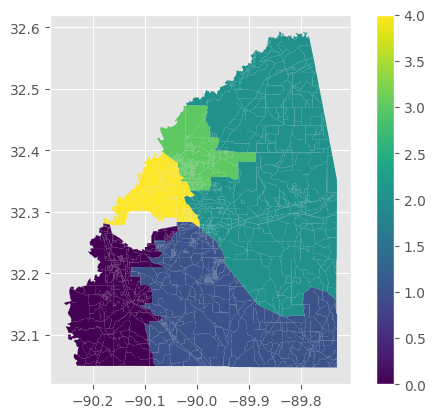

In [137]:
blocks_2020_rankin = blocks_2020[blocks_2020['current_di']!=5]
blocks_2020_rankin.plot(column='current_di', legend=True)

In [138]:
blocks_2020_rankin['TOT_POP22'].sum()

135082.03529294132

In [139]:
blocks_2020_rankin.groupby('current_di').TOT_POP22.sum()

current_di
0    28761.495834
1    25276.914366
2    25760.571977
3    27986.008391
4    27297.044725
Name: TOT_POP22, dtype: float64

In [140]:
blocks_2020_rankin.groupby('current_di').CVAP_TOT22.sum()

current_di
0    22272
1    19005
2    19560
3    20694
4    21136
Name: CVAP_TOT22, dtype: int64

### MCMC Prep

In [141]:
import networkx as nx
from functools import partial
import matplotlib.pyplot as plt
import json
import numpy as np
from statistics import mean
plt.style.use('ggplot')

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    GeographicPartition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import polsby_popper
from gerrychain.tree import bipartition_tree
from gerrychain.optimization import SingleMetricOptimizer, Gingleator
from gerrychain.proposals import recom
from gerrychain.updaters.locality_split_scores import LocalitySplits
from gerrychain.constraints import contiguous
from gerrytools.scoring import gingles_districts, demographic_shares, reock
random.seed(99)

In [142]:
state_abbr = "MS"
state_fip = "28"
num_districts = 5
unique_label = "GEOID20"
pop_col = "TOT_POP22"

In [143]:
blocks_2020_select = blocks_2020_rankin[['GEOID20', 'current_di', 'TOT_POP22', 'CVAP_TOT22', 'CVAP_POC', 'CVAP_COALITION', 'total_mi_1', 'VTD', 'geometry']]

In [144]:
# create graph
graph = Graph.from_geodataframe(blocks_2020_select)
graph.add_data(blocks_2020_select,list(blocks_2020_select))

Questions to address:
Draw a illustrative map that:
- keeping deviations under +4%. 
- consider the number of students when developing your new lines. 

ideal
- Decreases compactness score
- Decreases splits of VTDs and precincts
- Creates a coalition district of Asian and Hispanic population. 

Questions:
Performance? estimate how any Gingles district might be able to perform as part of your illustrative map 
estimate of the number of students that may be serviced by each district and consider the number of students when developing your new lines


In [145]:
### Custom updaters
class PartValue:
    def __init__(self, col=None, state=state_abbr, num=None):
        self.col = col
        self.state = state
        self.num = num

    def get_val(self, partition):
        return list(map(lambda x: partition.graph.nodes[x].get(self.col), graph.node_indices))
    
    def new_districts(partition):
        return list(map(lambda x: partition.assignment[x], graph.node_indices))
    
    def calc_reock(partition):
        geos_ids = PartValue(col='GEOID20').get_val(partition)
        new_dist = PartValue.new_districts(partition)
        assignment_df = pd.DataFrame({
            "GEOID20": geos_ids,
            "DIST": new_dist}
        )
        return reock().apply(blocks_2020[['GEOID20', 'geometry']].to_crs(epsg=5070).merge(assignment_df, on='GEOID20', how='left').dissolve(by='DIST'))
    

class SavePart:
    def __init__(self, state=state_abbr, num=None, dir = None):
        self.state = state
        self.num = num
        self.dir = dir
        
    def save_assignment(self, partition):
        geos_ids = PartValue(col='GEOID20').get_val(partition)
        new_dist = PartValue.new_districts(partition)
        assignment_df = pd.DataFrame({
                "GEOID20": geos_ids,
                "DIST": new_dist}
            )
        output_name = f"{self.state}_part_{str(self.num)}.txt",
        if self.dir is not None:
            output_name = f"{self.dir}/{self.state}_part_{str(self.num)}.txt"
        return(assignment_df.to_csv(output_name, index=False))


In [146]:
updater = {
    "population": updaters.Tally("TOT_POP22", alias="population"),
    "students": updaters.Tally("total_mi_1", alias="students"),
    "cvap": updaters.Tally("CVAP_TOT22", alias="cvap"),
    "cvap_poc": updaters.Tally("CVAP_POC", alias="cvap_poc"),
    "cvap_coalition": updaters.Tally("CVAP_POC", alias="cvap_poc"),
    "reock" : PartValue.calc_reock,
    "vtd_splits": LocalitySplits("vtd_splits", col_id='VTD', pop_col='TOT_POP22')
}

initial_partition = GeographicPartition(
    graph,
    assignment="current_di",
    updaters=updater
)

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

proposal = partial(
    recom,
    pop_col="TOT_POP22",
    pop_target=ideal_population,
    epsilon=0.04,
    node_repeats=2,
    method = partial(
        bipartition_tree,
        max_attempts=5,
        allow_pair_reselection=True 
    )
)

what is population deviation of current districts?

ACS 2022 total pop: 134,996
ideal pop: 26999.2
current population devation: 12.91% (abs((25276 / 26999.2) - (28762 / 26999.2)) * 100)

In [147]:
# White alone P0010003
# Black or African American alone P0010004
# American Indian and Alaska Native alone P0010005
# Asian alone P0010006
# Native Hawaiian and Other Pacific Islander alone P0010007
# Some other race alone P0010008
# P0020002

In [148]:
# population check
TOTPOP = sum(graph.nodes()[n]['TOT_POP22'] for n in graph.nodes())
print(TOTPOP)
blocks_2020_rankin.TOT_POP22.sum()

135082.03529294115


135082.03529294132

Current plan:
- 24 precincts are split (70 splits total)
- compactness (bigger is better):
  Reock	0.4203
  Polsby-Popper	0.2715


In [149]:
vtd_split_optimizer = lambda part: list(part['vtd_splits'].values())[0]

optimizer_splits = SingleMetricOptimizer(
    proposal=proposal,
    constraints=[contiguous],
    initial_state=initial_partition,
    optimization_metric=vtd_split_optimizer,
    maximize=False
)

In [150]:
init_vtd_split = list(initial_partition['vtd_splits'].values())[0]
init_reock = mean(initial_partition['reock'].values())
init_polsby = mean(polsby_popper(initial_partition).values())

In [151]:
print(init_vtd_split, init_reock, init_polsby,)

65 0.4282905990367799 0.2731395049380234


In [152]:
tot_pop = []
pop_dev = []
student_pop = []

cvap_pop = []
cvap_poc = []
cvap_coalition = []

gingles_scores = []
poc_props = []

reock_min = []
reock_avg = []
polsby_popper_min = []
polsby_popper_avg = []

vtd_splits = []

t = 0
with open("./output/MS_output.jsonl", "w") as f:
    for i, part in enumerate(optimizer_splits.short_bursts(5, 20000, with_progress_bar=True)):
        
        tot_pop.append(part["population"])
        student_pop.append(part["students"])
        cvap_pop.append(part["cvap"])
        cvap_poc.append(part["cvap_poc"])
        cvap_coalition.append(part["cvap_coalition"])
        
        dev = abs((min(part["population"].values()) / ideal_population) - (max(part["population"].values()) / ideal_population))
        pop_dev.append(dev)
        
        reock_min.append(min(part['reock'].values()))
        reock_score = mean(part['reock'].values())
        reock_avg.append(reock_score)
        
        polsby_popper_min.append(min(polsby_popper(part).values()))
        polsby_score = mean(polsby_popper(part).values())
        polsby_popper_avg.append(polsby_score)
        
        vtd_split = int(list(part['vtd_splits'].values())[0])
        vtd_splits.append(vtd_split)
        
        pp = demographic_shares({"cvap": ["cvap_poc"]})[0].apply(part)
        gd = gingles_districts({"cvap": ["cvap_coalition"]}, threshold=0.5)[0].apply(part)
        poc_props.append(pp)
        gingles_scores.append(gd)

        if dev <= .04 and vtd_split < init_vtd_split and (reock_score > init_reock or polsby_score > init_polsby):
            SavePart(num=t, dir='./output/').save_assignment(part)
            print(t, gd, dev, 'splits:', round(vtd_split, 4), 'reock:', round(reock_score, 4), 'polsby:', round(polsby_score, 4))

        data = {
            "step": t,
            "populations": part["population"],
            "students": part["students"],
            "vtd_splits": vtd_split,
            "reock_score": reock_score,
            "polsby_score": polsby_score,
            "cvap_poc_prop": pp,
            "cvap_coalition_tot": part["cvap_coalition"],
            "cvap_poc_tot": part["cvap_poc"],
            "cvap_tot": part["cvap"],
            "gingles_districts" : gd,
        }
            
        # Add newline character to separate entries in JSONL file
        f.write(json.dumps(data) + "\n")
        t +=1

  0%|          | 422/100000 [03:47<13:02:55,  2.12it/s]

421 0 0.03836471294268784 splits: 62 reock: 0.4421 polsby: 0.2587


  0%|          | 424/100000 [03:49<15:13:27,  1.82it/s]

423 0 0.024018646316890768 splits: 63 reock: 0.4511 polsby: 0.2694


  0%|          | 467/100000 [04:12<12:53:14,  2.15it/s]

466 0 0.03401373678486341 splits: 60 reock: 0.4462 polsby: 0.2751


  0%|          | 468/100000 [04:13<14:25:39,  1.92it/s]

467 0 0.038228814599862604 splits: 62 reock: 0.4463 polsby: 0.2616


  0%|          | 469/100000 [04:14<15:19:22,  1.80it/s]

468 0 0.038228814599862604 splits: 62 reock: 0.4505 polsby: 0.2689


  0%|          | 477/100000 [04:18<14:15:55,  1.94it/s]

476 0 0.031705755286973614 splits: 62 reock: 0.4557 polsby: 0.2413


  0%|          | 482/100000 [04:21<15:26:08,  1.79it/s]

481 0 0.03401373678486497 splits: 60 reock: 0.4465 polsby: 0.2757


  0%|          | 483/100000 [04:22<16:03:11,  1.72it/s]

482 0 0.030276072065974047 splits: 63 reock: 0.4347 polsby: 0.2556


  1%|          | 518/100000 [04:41<15:41:18,  1.76it/s]

517 0 0.036179245657361525 splits: 61 reock: 0.4654 polsby: 0.2866


  1%|          | 527/100000 [04:46<13:17:02,  2.08it/s]

526 0 0.03224951252506525 splits: 62 reock: 0.4587 polsby: 0.2752


  1%|          | 528/100000 [04:46<14:27:43,  1.91it/s]

527 0 0.03926893114046526 splits: 64 reock: 0.4724 polsby: 0.2638


  1%|          | 530/100000 [04:48<16:20:36,  1.69it/s]

529 0 0.03926893114046526 splits: 62 reock: 0.4761 polsby: 0.2573


  1%|          | 539/100000 [04:53<17:35:36,  1.57it/s]

538 0 0.034527465121518164 splits: 61 reock: 0.4468 polsby: 0.2525


  1%|          | 547/100000 [04:57<13:21:39,  2.07it/s]

546 0 0.03436399705869997 splits: 61 reock: 0.4601 polsby: 0.2756


  1%|          | 548/100000 [04:58<15:21:09,  1.80it/s]

547 0 0.03409258065721987 splits: 60 reock: 0.4601 polsby: 0.2759


  1%|          | 557/100000 [05:02<12:48:16,  2.16it/s]

556 0 0.03785005127579022 splits: 60 reock: 0.4607 polsby: 0.2779


  1%|          | 562/100000 [05:05<13:17:56,  2.08it/s]

561 0 0.03785005127579022 splits: 62 reock: 0.4567 polsby: 0.2585


  1%|          | 563/100000 [05:06<14:14:51,  1.94it/s]

562 0 0.03749954943708533 splits: 62 reock: 0.4582 polsby: 0.2601


  1%|          | 572/100000 [05:10<13:04:56,  2.11it/s]

571 0 0.03785005127579022 splits: 61 reock: 0.462 polsby: 0.2735


  1%|          | 573/100000 [05:11<14:21:10,  1.92it/s]

572 0 0.0357355667421555 splits: 60 reock: 0.4471 polsby: 0.2719


  1%|          | 574/100000 [05:12<15:39:18,  1.76it/s]

573 0 0.03961495222062017 splits: 61 reock: 0.4362 polsby: 0.258


  1%|          | 580/100000 [05:15<15:28:09,  1.79it/s]

580 0 0.0357355667421555 splits: 64 reock: 0.4471 polsby: 0.2719


  1%|          | 582/100000 [05:16<12:37:35,  2.19it/s]

581 0 0.0357355667421555 splits: 60 reock: 0.449 polsby: 0.2709


  1%|          | 584/100000 [05:17<14:44:00,  1.87it/s]

583 0 0.0357355667421555 splits: 60 reock: 0.4612 polsby: 0.2818


  1%|          | 585/100000 [05:17<15:43:36,  1.76it/s]

585 0 0.0357355667421555 splits: 61 reock: 0.4612 polsby: 0.2818


  1%|          | 592/100000 [05:21<14:10:10,  1.95it/s]

591 0 0.0357355667421555 splits: 61 reock: 0.4623 polsby: 0.2818


  1%|          | 600/100000 [05:26<16:54:04,  1.63it/s]

600 0 0.0357355667421555 splits: 64 reock: 0.4612 polsby: 0.2818


  1%|          | 602/100000 [05:27<14:03:29,  1.96it/s]

601 0 0.037541271971390344 splits: 61 reock: 0.4705 polsby: 0.2977


  1%|          | 613/100000 [05:33<15:20:26,  1.80it/s]

612 0 0.03931820638230443 splits: 61 reock: 0.5004 polsby: 0.2621


  1%|          | 615/100000 [05:35<17:10:23,  1.61it/s]

615 0 0.0357355667421555 splits: 61 reock: 0.4612 polsby: 0.2818


  1%|          | 617/100000 [05:35<13:47:34,  2.00it/s]

616 0 0.03965069286902456 splits: 62 reock: 0.4921 polsby: 0.2867


  1%|          | 627/100000 [05:41<13:35:53,  2.03it/s]

626 0 0.0357355667421555 splits: 63 reock: 0.4475 polsby: 0.2544


  1%|          | 630/100000 [05:43<16:17:26,  1.69it/s]

630 0 0.0357355667421555 splits: 64 reock: 0.4612 polsby: 0.2818


  1%|          | 634/100000 [05:45<16:37:17,  1.66it/s]

633 0 0.03969445729751708 splits: 64 reock: 0.4507 polsby: 0.2431


  1%|          | 635/100000 [05:45<16:49:00,  1.64it/s]

634 0 0.03311019701725604 splits: 64 reock: 0.4319 polsby: 0.2317
635 0 0.0357355667421555 splits: 64 reock: 0.4612 polsby: 0.2818


  1%|          | 640/100000 [05:48<16:04:56,  1.72it/s]

640 0 0.0357355667421555 splits: 62 reock: 0.4612 polsby: 0.2818


  1%|          | 648/100000 [05:52<14:19:34,  1.93it/s]

647 0 0.03479925782784554 splits: 64 reock: 0.4318 polsby: 0.2519


  1%|          | 649/100000 [05:53<15:10:39,  1.82it/s]

648 0 0.034690515977122915 splits: 64 reock: 0.4315 polsby: 0.2546


  1%|          | 697/100000 [06:18<13:49:49,  1.99it/s]

696 0 0.0357355667421555 splits: 61 reock: 0.4462 polsby: 0.2491


  1%|          | 698/100000 [06:19<14:43:38,  1.87it/s]

697 0 0.0357355667421555 splits: 61 reock: 0.4461 polsby: 0.2485


  1%|          | 713/100000 [06:28<15:52:34,  1.74it/s]

712 0 0.039961781105027905 splits: 61 reock: 0.4488 polsby: 0.2704


  1%|          | 714/100000 [06:28<16:49:34,  1.64it/s]

713 0 0.036758901741409944 splits: 63 reock: 0.4426 polsby: 0.2567


  1%|          | 763/100000 [06:54<14:41:48,  1.88it/s]

762 0 0.027314069978670474 splits: 62 reock: 0.4455 polsby: 0.2653


  1%|          | 764/100000 [06:55<15:20:19,  1.80it/s]

763 0 0.03706672204373129 splits: 62 reock: 0.4368 polsby: 0.2564


  1%|          | 765/100000 [06:56<15:50:52,  1.74it/s]

764 0 0.037091970951856346 splits: 64 reock: 0.4308 polsby: 0.2409


  1%|          | 793/100000 [07:11<15:25:20,  1.79it/s]

792 0 0.03709256509018766 splits: 60 reock: 0.4547 polsby: 0.2664


  1%|          | 794/100000 [07:12<15:55:29,  1.73it/s]

793 0 0.038196184758656826 splits: 60 reock: 0.468 polsby: 0.2773


  1%|          | 877/100000 [07:55<12:35:07,  2.19it/s]

876 0 0.03878493891810286 splits: 61 reock: 0.4597 polsby: 0.2671


  1%|          | 878/100000 [07:55<13:32:26,  2.03it/s]

877 0 0.03665340024957919 splits: 62 reock: 0.4583 polsby: 0.2599


  1%|          | 909/100000 [08:12<15:33:48,  1.77it/s]

908 0 0.03891426382213503 splits: 63 reock: 0.4378 polsby: 0.239


  1%|          | 913/100000 [08:14<14:20:09,  1.92it/s]

912 0 0.0343373115136989 splits: 60 reock: 0.4302 polsby: 0.2433


  1%|          | 927/100000 [08:21<13:23:55,  2.05it/s]

926 0 0.0343373115136989 splits: 60 reock: 0.4502 polsby: 0.2548


  1%|          | 928/100000 [08:22<14:10:46,  1.94it/s]

927 0 0.021569291265252533 splits: 62 reock: 0.4407 polsby: 0.2488


  1%|          | 972/100000 [08:45<12:39:10,  2.17it/s]

971 0 0.0343373115136989 splits: 64 reock: 0.4554 polsby: 0.2672


  1%|          | 1009/100000 [09:04<14:43:13,  1.87it/s]

1008 0 0.03966707630687338 splits: 62 reock: 0.4648 polsby: 0.2724


  1%|          | 1012/100000 [09:05<12:52:43,  2.14it/s]

1011 0 0.0343373115136989 splits: 61 reock: 0.4636 polsby: 0.2745


  1%|          | 1035/100000 [09:18<17:24:50,  1.58it/s]

1034 0 0.03827474737949277 splits: 62 reock: 0.4557 polsby: 0.2588


  1%|          | 1082/100000 [09:42<12:45:39,  2.15it/s]

1081 0 0.0356048194908003 splits: 63 reock: 0.451 polsby: 0.256


  1%|          | 1083/100000 [09:43<13:46:34,  1.99it/s]

1082 0 0.02647130079925586 splits: 64 reock: 0.4519 polsby: 0.2477


  1%|          | 1144/100000 [10:15<15:31:23,  1.77it/s]

1143 0 0.030031589701402073 splits: 62 reock: 0.4563 polsby: 0.2795


  1%|          | 1149/100000 [10:18<15:20:45,  1.79it/s]

1148 0 0.03486241920630728 splits: 62 reock: 0.4544 polsby: 0.2474


  1%|▏         | 1464/100000 [13:06<14:55:40,  1.83it/s]

1463 0 0.03670687787823301 splits: 60 reock: 0.4739 polsby: 0.2571


  1%|▏         | 1470/100000 [13:09<16:47:48,  1.63it/s]

1469 0 0.03968311804750291 splits: 64 reock: 0.4335 polsby: 0.2335


  2%|▏         | 1637/100000 [14:37<12:23:23,  2.21it/s]

1636 0 0.032342820834140196 splits: 62 reock: 0.4338 polsby: 0.2371


  2%|▏         | 1638/100000 [14:38<13:20:58,  2.05it/s]

1637 0 0.03367881476062229 splits: 64 reock: 0.443 polsby: 0.2679


  2%|▏         | 1665/100000 [14:53<16:06:15,  1.70it/s]

1664 0 0.0365155705236494 splits: 61 reock: 0.4505 polsby: 0.2187


  2%|▏         | 1702/100000 [15:12<12:58:40,  2.10it/s]

1701 0 0.038429299746448486 splits: 59 reock: 0.4692 polsby: 0.247


  2%|▏         | 1703/100000 [15:13<14:09:08,  1.93it/s]

1702 0 0.039756294207019205 splits: 60 reock: 0.4708 polsby: 0.2477


  2%|▏         | 1704/100000 [15:14<15:00:00,  1.82it/s]

1703 0 0.039756294207019205 splits: 60 reock: 0.4555 polsby: 0.2379


  2%|▏         | 1709/100000 [15:16<14:41:13,  1.86it/s]

1708 0 0.02921245328305422 splits: 62 reock: 0.4526 polsby: 0.259


  2%|▏         | 1733/100000 [15:28<14:07:53,  1.93it/s]

1732 0 0.02921245328305333 splits: 59 reock: 0.4596 polsby: 0.272


  2%|▏         | 1734/100000 [15:29<15:06:55,  1.81it/s]

1733 0 0.02921245328305333 splits: 59 reock: 0.4588 polsby: 0.2515


  2%|▏         | 1735/100000 [15:30<16:34:19,  1.65it/s]

1734 0 0.03364235747562749 splits: 59 reock: 0.4649 polsby: 0.2644


  2%|▏         | 1739/100000 [15:32<15:12:10,  1.80it/s]

1738 0 0.02888189236325278 splits: 62 reock: 0.478 polsby: 0.2602


  2%|▏         | 1742/100000 [15:33<13:08:14,  2.08it/s]

1741 0 0.02921245328305333 splits: 61 reock: 0.44 polsby: 0.2321


  2%|▏         | 1743/100000 [15:34<14:04:11,  1.94it/s]

1742 0 0.038819039003428646 splits: 57 reock: 0.463 polsby: 0.2652


  2%|▏         | 1745/100000 [15:35<15:14:42,  1.79it/s]

1745 0 0.038819039003428646 splits: 62 reock: 0.463 polsby: 0.2652


  2%|▏         | 1750/100000 [15:38<15:53:08,  1.72it/s]

1750 0 0.038819039003428646 splits: 61 reock: 0.463 polsby: 0.2652


  2%|▏         | 1752/100000 [15:38<12:51:28,  2.12it/s]

1751 0 0.0364819472090302 splits: 58 reock: 0.4631 polsby: 0.2671


  2%|▏         | 1755/100000 [15:40<15:57:56,  1.71it/s]

1755 0 0.038819039003428646 splits: 61 reock: 0.463 polsby: 0.2652


  2%|▏         | 1760/100000 [15:43<16:16:00,  1.68it/s]

1760 0 0.038819039003428646 splits: 64 reock: 0.463 polsby: 0.2652


  2%|▏         | 1765/100000 [15:46<17:32:49,  1.56it/s]

1765 0 0.038819039003428646 splits: 63 reock: 0.463 polsby: 0.2652


  2%|▏         | 1767/100000 [15:47<14:08:57,  1.93it/s]

1766 0 0.02921245328305333 splits: 59 reock: 0.4626 polsby: 0.2453


  2%|▏         | 1817/100000 [16:13<13:02:19,  2.09it/s]

1816 0 0.035303898888389695 splits: 58 reock: 0.4335 polsby: 0.2389


  2%|▏         | 1853/100000 [16:33<13:49:13,  1.97it/s]

1852 0 0.03536031126980754 splits: 63 reock: 0.4417 polsby: 0.2329


  2%|▏         | 1858/100000 [16:35<14:03:15,  1.94it/s]

1857 0 0.03814802725600086 splits: 62 reock: 0.4447 polsby: 0.2359


  2%|▏         | 1859/100000 [16:36<15:35:14,  1.75it/s]

1858 0 0.03851846987108287 splits: 60 reock: 0.4525 polsby: 0.2381


  2%|▏         | 1879/100000 [16:47<14:51:52,  1.83it/s]

1878 0 0.03914452012421399 splits: 60 reock: 0.4516 polsby: 0.2396


  2%|▏         | 1880/100000 [16:47<16:05:45,  1.69it/s]

1879 0 0.035509349060080964 splits: 61 reock: 0.4516 polsby: 0.2373


  2%|▏         | 1883/100000 [16:49<14:11:36,  1.92it/s]

1882 0 0.039467015626287294 splits: 58 reock: 0.443 polsby: 0.2492


  2%|▏         | 1904/100000 [17:00<15:13:54,  1.79it/s]

1903 0 0.036701292604155666 splits: 61 reock: 0.4503 polsby: 0.2632


  2%|▏         | 1905/100000 [17:01<16:04:48,  1.69it/s]

1904 0 0.038772556119811785 splits: 62 reock: 0.4466 polsby: 0.2601


  2%|▏         | 1922/100000 [17:10<12:57:50,  2.10it/s]

1921 0 0.03285242672008515 splits: 60 reock: 0.4467 polsby: 0.2735


  2%|▏         | 1934/100000 [17:16<15:23:03,  1.77it/s]

1933 0 0.025933919979993947 splits: 64 reock: 0.4588 polsby: 0.2624


  2%|▏         | 1943/100000 [17:21<14:17:02,  1.91it/s]

1942 0 0.03524656851766339 splits: 62 reock: 0.4736 polsby: 0.2372


  2%|▏         | 1972/100000 [17:37<14:05:37,  1.93it/s]

1971 0 0.029294084622979888 splits: 60 reock: 0.4933 polsby: 0.2927


  2%|▏         | 2004/100000 [17:54<14:36:15,  1.86it/s]

2003 0 0.033573248585775484 splits: 64 reock: 0.44 polsby: 0.2065


  2%|▏         | 2007/100000 [17:55<13:35:00,  2.00it/s]

2006 0 0.027278217627959567 splits: 60 reock: 0.4914 polsby: 0.283


  2%|▏         | 2022/100000 [18:03<13:05:54,  2.08it/s]

2021 0 0.033573248585775484 splits: 59 reock: 0.476 polsby: 0.241


  2%|▏         | 2023/100000 [18:04<14:08:03,  1.93it/s]

2022 0 0.033573248585775484 splits: 62 reock: 0.4379 polsby: 0.2253


  2%|▏         | 2073/100000 [18:31<14:15:33,  1.91it/s]

2072 0 0.038197024828375836 splits: 61 reock: 0.4733 polsby: 0.2841


  2%|▏         | 2223/100000 [19:51<14:15:40,  1.90it/s]

2222 0 0.037191949529462365 splits: 62 reock: 0.4803 polsby: 0.275


  2%|▏         | 2430/100000 [21:43<15:37:49,  1.73it/s]

2429 0 0.034073181125162666 splits: 63 reock: 0.4301 polsby: 0.2413


  3%|▎         | 2512/100000 [22:27<13:39:50,  1.98it/s]

2511 0 0.038367900616459005 splits: 63 reock: 0.4312 polsby: 0.2348


  3%|▎         | 2603/100000 [23:17<14:11:56,  1.91it/s]

2602 0 0.038367900616459005 splits: 63 reock: 0.4419 polsby: 0.2676


  3%|▎         | 2607/100000 [23:19<13:08:48,  2.06it/s]

2606 0 0.038367900616459005 splits: 59 reock: 0.4291 polsby: 0.2423


  3%|▎         | 2627/100000 [23:30<12:54:24,  2.10it/s]

2626 0 0.038367900616459005 splits: 61 reock: 0.4307 polsby: 0.2387


  3%|▎         | 2652/100000 [23:44<13:55:30,  1.94it/s]

2651 0 0.03809648421498446 splits: 60 reock: 0.47 polsby: 0.2564


  3%|▎         | 2653/100000 [23:44<15:01:51,  1.80it/s]

2652 0 0.03809648421498446 splits: 60 reock: 0.4564 polsby: 0.2276


  3%|▎         | 2654/100000 [23:45<15:46:15,  1.71it/s]

2653 0 0.03420549357116487 splits: 61 reock: 0.4454 polsby: 0.2331


  3%|▎         | 2670/100000 [23:54<16:11:46,  1.67it/s]

2669 0 0.03702605881662113 splits: 64 reock: 0.433 polsby: 0.2199


  3%|▎         | 2683/100000 [24:00<14:00:36,  1.93it/s]

2682 0 0.03809648421498446 splits: 61 reock: 0.4329 polsby: 0.2417


  3%|▎         | 2684/100000 [24:01<14:55:04,  1.81it/s]

2683 0 0.03416134878527721 splits: 62 reock: 0.4325 polsby: 0.2416


  3%|▎         | 2685/100000 [24:02<15:42:20,  1.72it/s]

2684 0 0.03809648421498446 splits: 61 reock: 0.4329 polsby: 0.245


  3%|▎         | 2693/100000 [24:06<14:50:02,  1.82it/s]

2692 0 0.03809648421498446 splits: 62 reock: 0.4412 polsby: 0.2595


  3%|▎         | 2699/100000 [24:10<15:47:24,  1.71it/s]

2698 0 0.038367900616459005 splits: 61 reock: 0.4548 polsby: 0.2494


  3%|▎         | 2727/100000 [24:24<13:27:44,  2.01it/s]

2726 0 0.037356179268736356 splits: 58 reock: 0.472 polsby: 0.2698


  3%|▎         | 2744/100000 [24:34<15:22:45,  1.76it/s]

2743 0 0.02159201035418412 splits: 64 reock: 0.4435 polsby: 0.2324


  3%|▎         | 2752/100000 [24:38<13:12:04,  2.05it/s]

2751 0 0.03958102791993312 splits: 58 reock: 0.4642 polsby: 0.2734


  3%|▎         | 2757/100000 [24:41<13:24:34,  2.01it/s]

2756 0 0.039373840335155674 splits: 58 reock: 0.46 polsby: 0.2715


  3%|▎         | 2792/100000 [25:00<14:43:33,  1.83it/s]

2791 0 0.039373840335155674 splits: 59 reock: 0.4379 polsby: 0.257


  3%|▎         | 2827/100000 [25:19<12:52:32,  2.10it/s]

2826 0 0.039373840335155674 splits: 59 reock: 0.4467 polsby: 0.2542


  3%|▎         | 2828/100000 [25:20<14:00:41,  1.93it/s]

2827 0 0.0354872951180879 splits: 61 reock: 0.4362 polsby: 0.2635


  3%|▎         | 2829/100000 [25:20<15:48:19,  1.71it/s]

2828 0 0.0290709666120631 splits: 63 reock: 0.43 polsby: 0.2364


  3%|▎         | 2832/100000 [25:22<13:29:22,  2.00it/s]

2831 0 0.039373840335155674 splits: 59 reock: 0.4648 polsby: 0.2715


  3%|▎         | 2894/100000 [25:56<15:17:12,  1.76it/s]

2893 0 0.039373840335155674 splits: 59 reock: 0.4433 polsby: 0.2534


  3%|▎         | 2895/100000 [25:56<15:58:31,  1.69it/s]

2894 0 0.026679172935725526 splits: 60 reock: 0.4489 polsby: 0.2587


  3%|▎         | 2897/100000 [25:57<13:08:12,  2.05it/s]

2896 0 0.039373840335155674 splits: 58 reock: 0.4708 polsby: 0.2966


  3%|▎         | 2934/100000 [26:17<15:17:05,  1.76it/s]

2933 0 0.033605128955027985 splits: 62 reock: 0.4381 polsby: 0.2134


  3%|▎         | 2937/100000 [26:18<13:20:25,  2.02it/s]

2936 0 0.03348357965476334 splits: 59 reock: 0.4723 polsby: 0.2751


  3%|▎         | 2954/100000 [26:28<15:15:56,  1.77it/s]

2953 0 0.03969574930452813 splits: 61 reock: 0.4728 polsby: 0.2479


  3%|▎         | 2957/100000 [26:29<12:51:27,  2.10it/s]

2956 0 0.03496744493918935 splits: 63 reock: 0.4327 polsby: 0.2269


  3%|▎         | 2959/100000 [26:31<16:52:21,  1.60it/s]

2958 0 0.03348357965476334 splits: 60 reock: 0.437 polsby: 0.2464


  3%|▎         | 2960/100000 [26:31<17:22:35,  1.55it/s]

2959 0 0.03348357965476334 splits: 59 reock: 0.4803 polsby: 0.2975


  3%|▎         | 2962/100000 [26:32<13:53:59,  1.94it/s]

2961 0 0.03348357965476334 splits: 59 reock: 0.457 polsby: 0.2651


  3%|▎         | 2988/100000 [26:46<13:31:35,  1.99it/s]

2987 0 0.03348357965476334 splits: 58 reock: 0.4774 polsby: 0.2821


  3%|▎         | 3007/100000 [26:56<12:51:59,  2.09it/s]

3006 0 0.037093629652486526 splits: 59 reock: 0.4726 polsby: 0.2896


  3%|▎         | 3008/100000 [26:57<13:59:12,  1.93it/s]

3007 0 0.037093629652486526 splits: 64 reock: 0.4775 polsby: 0.2749


  3%|▎         | 3014/100000 [27:00<14:36:09,  1.84it/s]

3013 0 0.039607237255110506 splits: 63 reock: 0.4433 polsby: 0.2276


  3%|▎         | 3015/100000 [27:01<15:47:20,  1.71it/s]

3014 0 0.039607237255110506 splits: 64 reock: 0.4401 polsby: 0.2552


  3%|▎         | 3017/100000 [27:02<12:45:42,  2.11it/s]

3016 0 0.03709362965248786 splits: 60 reock: 0.4416 polsby: 0.2531


  3%|▎         | 3018/100000 [27:02<14:14:36,  1.89it/s]

3017 0 0.03709362965248786 splits: 60 reock: 0.4682 polsby: 0.2753


  3%|▎         | 3025/100000 [27:06<14:58:51,  1.80it/s]

3024 0 0.03361577609542399 splits: 63 reock: 0.433 polsby: 0.275


  3%|▎         | 3039/100000 [27:13<15:42:02,  1.72it/s]

3038 0 0.03709362965248786 splits: 61 reock: 0.4708 polsby: 0.2797


  3%|▎         | 3040/100000 [27:14<16:14:04,  1.66it/s]

3039 0 0.033518998660904464 splits: 63 reock: 0.4641 polsby: 0.2532


  3%|▎         | 3052/100000 [27:20<13:40:46,  1.97it/s]

3051 0 0.03709362965248786 splits: 59 reock: 0.4671 polsby: 0.2457


  3%|▎         | 3055/100000 [27:22<16:07:14,  1.67it/s]

3054 0 0.03262725174655112 splits: 64 reock: 0.4667 polsby: 0.2225


  3%|▎         | 3057/100000 [27:23<13:03:50,  2.06it/s]

3056 0 0.03709362965248786 splits: 59 reock: 0.4688 polsby: 0.2802


  3%|▎         | 3058/100000 [27:24<14:19:32,  1.88it/s]

3057 0 0.03709362965248786 splits: 58 reock: 0.4639 polsby: 0.2956


  3%|▎         | 3062/100000 [27:26<12:34:24,  2.14it/s]

3061 0 0.03709362965248786 splits: 57 reock: 0.4784 polsby: 0.2861


  3%|▎         | 3065/100000 [27:27<15:13:57,  1.77it/s]

3065 0 0.03709362965248786 splits: 64 reock: 0.4784 polsby: 0.2861


  3%|▎         | 3067/100000 [27:28<12:58:12,  2.08it/s]

3066 0 0.03709362965248786 splits: 60 reock: 0.4568 polsby: 0.2866


  3%|▎         | 3068/100000 [27:29<14:25:26,  1.87it/s]

3067 0 0.035289384113447064 splits: 63 reock: 0.441 polsby: 0.2533


  3%|▎         | 3070/100000 [27:30<16:39:17,  1.62it/s]

3070 0 0.03709362965248786 splits: 64 reock: 0.4784 polsby: 0.2861


  3%|▎         | 3075/100000 [27:33<15:59:37,  1.68it/s]

3075 0 0.03709362965248786 splits: 64 reock: 0.4784 polsby: 0.2861


  3%|▎         | 3077/100000 [27:34<12:46:46,  2.11it/s]

3076 0 0.03805925423125822 splits: 58 reock: 0.4644 polsby: 0.2676


  3%|▎         | 3078/100000 [27:34<13:55:06,  1.93it/s]

3077 0 0.03805925423125822 splits: 64 reock: 0.4285 polsby: 0.2266


  3%|▎         | 3080/100000 [27:36<15:44:23,  1.71it/s]

3080 0 0.03709362965248786 splits: 63 reock: 0.4784 polsby: 0.2861


  3%|▎         | 3082/100000 [27:36<12:50:41,  2.10it/s]

3081 0 0.03709362965248786 splits: 60 reock: 0.4381 polsby: 0.2588


  3%|▎         | 3087/100000 [27:39<13:04:29,  2.06it/s]

3086 0 0.03313916709180631 splits: 58 reock: 0.4652 polsby: 0.267


  3%|▎         | 3090/100000 [27:41<16:16:58,  1.65it/s]

3089 0 0.03313916709180631 splits: 59 reock: 0.4347 polsby: 0.2426
3090 0 0.03709362965248786 splits: 59 reock: 0.4784 polsby: 0.2861


  3%|▎         | 3107/100000 [27:50<13:17:04,  2.03it/s]

3106 0 0.03970373169763042 splits: 57 reock: 0.4779 polsby: 0.2789


  3%|▎         | 3113/100000 [27:54<14:23:19,  1.87it/s]

3112 0 0.03755684297334139 splits: 58 reock: 0.4774 polsby: 0.2872


  3%|▎         | 3117/100000 [27:56<13:08:43,  2.05it/s]

3116 0 0.037756814095520896 splits: 59 reock: 0.4696 polsby: 0.2595


  3%|▎         | 3118/100000 [27:57<14:16:18,  1.89it/s]

3117 0 0.036773137568292036 splits: 62 reock: 0.4493 polsby: 0.2523


  3%|▎         | 3120/100000 [27:58<16:12:06,  1.66it/s]

3120 0 0.03970373169763042 splits: 62 reock: 0.4779 polsby: 0.2789


  3%|▎         | 3125/100000 [28:01<15:57:35,  1.69it/s]

3125 0 0.03970373169763042 splits: 62 reock: 0.4779 polsby: 0.2789


  3%|▎         | 3127/100000 [28:01<13:16:53,  2.03it/s]

3126 0 0.03527197458464426 splits: 58 reock: 0.4685 polsby: 0.2685


  3%|▎         | 3128/100000 [28:02<14:49:30,  1.82it/s]

3127 0 0.03546480709476507 splits: 60 reock: 0.4709 polsby: 0.266


  3%|▎         | 3130/100000 [28:04<17:53:09,  1.50it/s]

3130 0 0.03970373169763042 splits: 60 reock: 0.4779 polsby: 0.2789


  3%|▎         | 3132/100000 [28:04<14:13:45,  1.89it/s]

3131 0 0.024976090422164532 splits: 59 reock: 0.4672 polsby: 0.2604


  3%|▎         | 3133/100000 [28:05<15:25:00,  1.75it/s]

3132 0 0.02674225443611533 splits: 60 reock: 0.4671 polsby: 0.2421


  3%|▎         | 3134/100000 [28:06<15:59:41,  1.68it/s]

3133 0 0.03691721477685572 splits: 62 reock: 0.4549 polsby: 0.233


  3%|▎         | 3135/100000 [28:07<16:39:58,  1.61it/s]

3134 0 0.024244529259511594 splits: 64 reock: 0.4491 polsby: 0.2307
3135 0 0.03970373169763042 splits: 64 reock: 0.4779 polsby: 0.2789


  3%|▎         | 3137/100000 [28:07<13:45:04,  1.96it/s]

3136 0 0.027257259981943838 splits: 59 reock: 0.4383 polsby: 0.2344


  3%|▎         | 3140/100000 [28:09<16:18:36,  1.65it/s]

3140 0 0.03970373169763042 splits: 64 reock: 0.4779 polsby: 0.2789


  3%|▎         | 3160/100000 [28:20<15:07:04,  1.78it/s]

3160 0 0.03970373169763042 splits: 63 reock: 0.4779 polsby: 0.2789


  3%|▎         | 3174/100000 [28:27<14:56:05,  1.80it/s]

3173 0 0.03348599945655584 splits: 62 reock: 0.4636 polsby: 0.2578


  3%|▎         | 3175/100000 [28:28<15:52:07,  1.69it/s]

3174 0 0.03348599945655584 splits: 62 reock: 0.4298 polsby: 0.2419


  3%|▎         | 3220/100000 [28:52<16:05:16,  1.67it/s]

3219 0 0.03466308964394116 splits: 62 reock: 0.4709 polsby: 0.2584


  3%|▎         | 3235/100000 [29:00<16:16:13,  1.65it/s]

3234 0 0.02538756972887435 splits: 63 reock: 0.4421 polsby: 0.2459


  3%|▎         | 3267/100000 [29:16<12:42:22,  2.11it/s]

3266 0 0.027402806612639607 splits: 57 reock: 0.4774 polsby: 0.2751


  3%|▎         | 3270/100000 [29:18<16:06:53,  1.67it/s]

3270 0 0.027402806612639607 splits: 61 reock: 0.4774 polsby: 0.2751


  3%|▎         | 3283/100000 [29:25<14:10:44,  1.89it/s]

3282 0 0.03977750332387231 splits: 59 reock: 0.4629 polsby: 0.2579


  3%|▎         | 3388/100000 [30:22<14:30:55,  1.85it/s]

3387 0 0.0374812037180845 splits: 62 reock: 0.4476 polsby: 0.2462


  3%|▎         | 3402/100000 [30:30<12:51:51,  2.09it/s]

3401 0 0.03727370871792102 splits: 58 reock: 0.4579 polsby: 0.2584


  3%|▎         | 3438/100000 [30:49<14:05:25,  1.90it/s]

3437 0 0.03952383844224261 splits: 60 reock: 0.478 polsby: 0.2769


  3%|▎         | 3453/100000 [30:58<15:34:02,  1.72it/s]

3452 0 0.03519452459746086 splits: 61 reock: 0.434 polsby: 0.2424


  3%|▎         | 3454/100000 [30:58<16:12:23,  1.65it/s]

3453 0 0.03519452459746086 splits: 62 reock: 0.445 polsby: 0.2388


  3%|▎         | 3477/100000 [31:10<12:53:09,  2.08it/s]

3476 0 0.03987093453211388 splits: 59 reock: 0.4456 polsby: 0.2509


  3%|▎         | 3490/100000 [31:17<16:01:32,  1.67it/s]

3489 0 0.03263629603057039 splits: 63 reock: 0.4335 polsby: 0.2768


  4%|▎         | 3693/100000 [33:06<14:44:18,  1.82it/s]

3692 0 0.037076924670225275 splits: 59 reock: 0.4903 polsby: 0.3031


  4%|▎         | 3727/100000 [33:24<13:13:26,  2.02it/s]

3726 0 0.03689100267197443 splits: 59 reock: 0.4895 polsby: 0.268


  4%|▎         | 3729/100000 [33:26<15:04:25,  1.77it/s]

3728 0 0.03911428770424463 splits: 62 reock: 0.476 polsby: 0.2421


  4%|▍         | 3752/100000 [33:37<12:13:21,  2.19it/s]

3751 0 0.02589237983938697 splits: 60 reock: 0.484 polsby: 0.2647


  4%|▍         | 3754/100000 [33:38<14:32:26,  1.84it/s]

3753 0 0.03290698252410984 splits: 64 reock: 0.4536 polsby: 0.2331


  4%|▍         | 3774/100000 [33:49<15:26:57,  1.73it/s]

3773 0 0.034510944400203636 splits: 59 reock: 0.4729 polsby: 0.2508


  4%|▍         | 3775/100000 [33:49<16:12:48,  1.65it/s]

3774 0 0.02750498009631308 splits: 59 reock: 0.4319 polsby: 0.2265


  4%|▍         | 3779/100000 [33:51<14:55:10,  1.79it/s]

3778 0 0.032213103930061715 splits: 60 reock: 0.4786 polsby: 0.2605


  4%|▍         | 3780/100000 [33:52<15:48:10,  1.69it/s]

3779 0 0.03808796266499137 splits: 61 reock: 0.4809 polsby: 0.244


  4%|▍         | 3894/100000 [34:52<16:20:45,  1.63it/s]

3893 0 0.039739446003454804 splits: 61 reock: 0.488 polsby: 0.2481


  4%|▍         | 3920/100000 [35:06<15:21:33,  1.74it/s]

3919 0 0.03316147182789875 splits: 62 reock: 0.4288 polsby: 0.2211


  4%|▍         | 3944/100000 [35:19<16:01:38,  1.66it/s]

3943 0 0.0344936606068752 splits: 58 reock: 0.4852 polsby: 0.2413


  4%|▍         | 3969/100000 [35:32<14:29:32,  1.84it/s]

3968 0 0.03693801403908381 splits: 61 reock: 0.4489 polsby: 0.26


  4%|▍         | 3989/100000 [35:42<14:20:24,  1.86it/s]

3988 0 0.037931513650019455 splits: 61 reock: 0.4951 polsby: 0.2527


  4%|▍         | 4014/100000 [35:55<14:46:22,  1.80it/s]

4013 0 0.03096155106221865 splits: 60 reock: 0.4631 polsby: 0.274


  4%|▍         | 4015/100000 [35:56<15:30:19,  1.72it/s]

4014 0 0.023874824927088478 splits: 61 reock: 0.4369 polsby: 0.2479


  4%|▍         | 4017/100000 [35:57<12:59:53,  2.05it/s]

4016 0 0.039779472347730715 splits: 61 reock: 0.4685 polsby: 0.2615


  4%|▍         | 4037/100000 [36:07<12:33:19,  2.12it/s]

4036 0 0.03201781188962105 splits: 62 reock: 0.4453 polsby: 0.2546


  4%|▍         | 4045/100000 [36:12<15:07:12,  1.76it/s]

4044 0 0.022788364790121696 splits: 61 reock: 0.4771 polsby: 0.2564


  4%|▍         | 4052/100000 [36:15<11:59:25,  2.22it/s]

4051 0 0.034897458690697825 splits: 59 reock: 0.5043 polsby: 0.2931


  4%|▍         | 4062/100000 [36:20<12:12:58,  2.18it/s]

4061 0 0.03249353047661507 splits: 59 reock: 0.5156 polsby: 0.2754


  4%|▍         | 4064/100000 [36:21<14:19:59,  1.86it/s]

4063 0 0.03604834539221102 splits: 64 reock: 0.4979 polsby: 0.2498


  4%|▍         | 4077/100000 [36:28<13:04:13,  2.04it/s]

4076 0 0.03973344754467267 splits: 59 reock: 0.4943 polsby: 0.2827


  4%|▍         | 4127/100000 [36:55<12:15:37,  2.17it/s]

4126 0 0.0370094683000155 splits: 56 reock: 0.4846 polsby: 0.2485


  4%|▍         | 4130/100000 [36:57<14:50:01,  1.80it/s]

4130 0 0.0370094683000155 splits: 61 reock: 0.4846 polsby: 0.2485


  4%|▍         | 4135/100000 [36:59<15:58:30,  1.67it/s]

4135 0 0.0370094683000155 splits: 63 reock: 0.4846 polsby: 0.2485


  4%|▍         | 4137/100000 [37:00<13:19:59,  2.00it/s]

4136 0 0.0370094683000155 splits: 60 reock: 0.4781 polsby: 0.2159


  4%|▍         | 4145/100000 [37:05<15:49:33,  1.68it/s]

4145 0 0.0370094683000155 splits: 63 reock: 0.4846 polsby: 0.2485


  4%|▍         | 4173/100000 [37:19<13:15:19,  2.01it/s]

4172 0 0.03854313951803723 splits: 61 reock: 0.4336 polsby: 0.2365


  4%|▍         | 4197/100000 [37:31<11:55:10,  2.23it/s]

4196 0 0.034260816489140034 splits: 58 reock: 0.4924 polsby: 0.2708


  4%|▍         | 4198/100000 [37:32<13:09:55,  2.02it/s]

4197 0 0.034260816489140034 splits: 63 reock: 0.4576 polsby: 0.2434


  4%|▍         | 4224/100000 [37:46<15:43:43,  1.69it/s]

4223 0 0.03938125417741678 splits: 64 reock: 0.4664 polsby: 0.2257


  4%|▍         | 4228/100000 [37:48<14:19:17,  1.86it/s]

4227 0 0.032424031538962894 splits: 63 reock: 0.4391 polsby: 0.2259


  4%|▍         | 4230/100000 [37:50<16:16:27,  1.63it/s]

4229 0 0.03508860979252648 splits: 63 reock: 0.4942 polsby: 0.231


  4%|▍         | 4252/100000 [38:01<13:15:40,  2.01it/s]

4251 0 0.032017811889621495 splits: 60 reock: 0.4821 polsby: 0.2496


  4%|▍         | 4277/100000 [38:15<12:28:09,  2.13it/s]

4276 0 0.0370339251577273 splits: 59 reock: 0.5033 polsby: 0.2591


  4%|▍         | 4283/100000 [38:18<14:04:22,  1.89it/s]

4282 0 0.03903729141203116 splits: 62 reock: 0.4872 polsby: 0.2469


  4%|▍         | 4324/100000 [38:40<15:53:21,  1.67it/s]

4323 0 0.03201781188962194 splits: 63 reock: 0.4736 polsby: 0.2193


  4%|▍         | 4327/100000 [38:41<13:34:14,  1.96it/s]

4326 0 0.03833365693704238 splits: 56 reock: 0.5031 polsby: 0.2685


  4%|▍         | 4328/100000 [38:42<15:10:15,  1.75it/s]

4327 0 0.03400434309226552 splits: 59 reock: 0.4548 polsby: 0.2282


  4%|▍         | 4330/100000 [38:43<16:14:58,  1.64it/s]

4330 0 0.03833365693704238 splits: 59 reock: 0.5031 polsby: 0.2685


  4%|▍         | 4332/100000 [38:44<13:08:09,  2.02it/s]

4331 0 0.03201781188962194 splits: 58 reock: 0.5109 polsby: 0.2779


  4%|▍         | 4333/100000 [38:45<14:11:42,  1.87it/s]

4332 0 0.022835487562530066 splits: 60 reock: 0.5105 polsby: 0.2758


  4%|▍         | 4335/100000 [38:46<15:33:34,  1.71it/s]

4335 0 0.03833365693704238 splits: 62 reock: 0.5031 polsby: 0.2685


  4%|▍         | 4337/100000 [38:47<13:05:31,  2.03it/s]

4336 0 0.03833365693704238 splits: 61 reock: 0.4814 polsby: 0.2332


  4%|▍         | 4345/100000 [38:52<16:12:13,  1.64it/s]

4345 0 0.03833365693704238 splits: 64 reock: 0.5031 polsby: 0.2685


  4%|▍         | 4350/100000 [38:54<15:34:00,  1.71it/s]

4350 0 0.03833365693704238 splits: 62 reock: 0.5031 polsby: 0.2685


  4%|▍         | 4353/100000 [38:56<14:11:38,  1.87it/s]

4352 0 0.03400434309226552 splits: 57 reock: 0.4859 polsby: 0.2632


  4%|▍         | 4354/100000 [38:56<14:58:49,  1.77it/s]

4353 0 0.034021595798052306 splits: 59 reock: 0.4362 polsby: 0.2438


  4%|▍         | 4355/100000 [38:57<15:32:25,  1.71it/s]

4355 0 0.03833365693704238 splits: 60 reock: 0.5031 polsby: 0.2685


  4%|▍         | 4357/100000 [38:58<12:52:08,  2.06it/s]

4356 0 0.03400434309226552 splits: 58 reock: 0.444 polsby: 0.2398


  4%|▍         | 4359/100000 [38:59<14:50:07,  1.79it/s]

4358 0 0.03400434309226552 splits: 62 reock: 0.4397 polsby: 0.2202


  4%|▍         | 4360/100000 [39:00<16:14:23,  1.64it/s]

4360 0 0.03833365693704238 splits: 62 reock: 0.5031 polsby: 0.2685


  4%|▍         | 4362/100000 [39:01<13:00:46,  2.04it/s]

4361 0 0.03991921574083601 splits: 56 reock: 0.4868 polsby: 0.2394


  4%|▍         | 4363/100000 [39:01<14:25:36,  1.84it/s]

4362 0 0.027688498044845078 splits: 57 reock: 0.4856 polsby: 0.2376


  4%|▍         | 4369/100000 [39:05<14:45:45,  1.80it/s]

4368 0 0.03571918506888605 splits: 57 reock: 0.4845 polsby: 0.2698


  4%|▍         | 4370/100000 [39:05<16:13:33,  1.64it/s]

4369 0 0.03571918506888605 splits: 59 reock: 0.4785 polsby: 0.267


  4%|▍         | 4387/100000 [39:14<12:23:58,  2.14it/s]

4386 0 0.03737711128430554 splits: 62 reock: 0.4692 polsby: 0.2458


  4%|▍         | 4402/100000 [39:22<12:17:00,  2.16it/s]

4401 0 0.032017811889621495 splits: 62 reock: 0.4385 polsby: 0.2672


  4%|▍         | 4440/100000 [39:42<15:26:07,  1.72it/s]

4439 0 0.035739771533478515 splits: 60 reock: 0.4621 polsby: 0.2279


  4%|▍         | 4442/100000 [39:43<12:51:00,  2.07it/s]

4441 0 0.029707267282343186 splits: 57 reock: 0.492 polsby: 0.2523


  4%|▍         | 4453/100000 [39:49<13:28:48,  1.97it/s]

4452 0 0.029878000689136153 splits: 60 reock: 0.4622 polsby: 0.2428


  5%|▍         | 4513/100000 [40:20<14:02:07,  1.89it/s]

4512 0 0.030435313938845687 splits: 62 reock: 0.4496 polsby: 0.2457


  5%|▍         | 4519/100000 [40:24<14:56:28,  1.78it/s]

4518 0 0.032017811889621495 splits: 61 reock: 0.4882 polsby: 0.2575


  5%|▍         | 4520/100000 [40:24<15:35:15,  1.70it/s]

4519 0 0.03986442468771956 splits: 62 reock: 0.4493 polsby: 0.2267


  5%|▍         | 4563/100000 [40:47<14:28:07,  1.83it/s]

4562 0 0.02825149018962647 splits: 59 reock: 0.4558 polsby: 0.2481


  5%|▍         | 4618/100000 [41:16<15:26:32,  1.72it/s]

4617 0 0.03903215384127978 splits: 63 reock: 0.4773 polsby: 0.2409


  5%|▍         | 4637/100000 [41:26<12:30:13,  2.12it/s]

4636 0 0.036541900749987644 splits: 62 reock: 0.4635 polsby: 0.2073


  5%|▍         | 4758/100000 [42:30<13:44:32,  1.93it/s]

4757 0 0.035344058917231136 splits: 63 reock: 0.4514 polsby: 0.2288


  5%|▍         | 4764/100000 [42:34<14:57:27,  1.77it/s]

4763 0 0.03289874313232177 splits: 57 reock: 0.5027 polsby: 0.2975


  5%|▍         | 4765/100000 [42:34<15:22:35,  1.72it/s]

4764 0 0.03201781188962283 splits: 64 reock: 0.4416 polsby: 0.261


  5%|▍         | 4783/100000 [42:43<14:17:07,  1.85it/s]

4782 0 0.03861025705711485 splits: 59 reock: 0.4735 polsby: 0.2655


  5%|▍         | 4805/100000 [42:55<15:12:27,  1.74it/s]

4804 0 0.030989442150801016 splits: 64 reock: 0.4665 polsby: 0.2288


  5%|▍         | 4823/100000 [43:05<13:33:00,  1.95it/s]

4822 0 0.03322970441423001 splits: 60 reock: 0.4488 polsby: 0.2284


  5%|▍         | 4824/100000 [43:05<14:30:02,  1.82it/s]

4823 0 0.03313812375587988 splits: 62 reock: 0.4529 polsby: 0.2121


  5%|▍         | 4825/100000 [43:06<15:17:06,  1.73it/s]

4824 0 0.02533538737009655 splits: 60 reock: 0.4735 polsby: 0.2168


  5%|▍         | 4849/100000 [43:18<14:08:14,  1.87it/s]

4848 0 0.034742137296821074 splits: 63 reock: 0.4751 polsby: 0.2464


  5%|▍         | 4850/100000 [43:19<14:50:54,  1.78it/s]

4849 0 0.034742137296821074 splits: 63 reock: 0.5001 polsby: 0.2358


  5%|▍         | 4854/100000 [43:21<14:32:42,  1.82it/s]

4853 0 0.03833695912980006 splits: 62 reock: 0.4747 polsby: 0.2081


  5%|▍         | 4889/100000 [43:39<15:38:26,  1.69it/s]

4888 0 0.03201781188962127 splits: 61 reock: 0.5015 polsby: 0.2497


  5%|▍         | 4898/100000 [43:44<13:52:36,  1.90it/s]

4897 0 0.03201781188962127 splits: 64 reock: 0.4594 polsby: 0.232


  5%|▍         | 4968/100000 [44:22<14:33:46,  1.81it/s]

4967 0 0.0317463954881434 splits: 61 reock: 0.4521 polsby: 0.2484


  5%|▍         | 4972/100000 [44:24<12:38:00,  2.09it/s]

4971 0 0.03548583115959114 splits: 58 reock: 0.496 polsby: 0.2718


  5%|▍         | 4973/100000 [44:25<13:57:36,  1.89it/s]

4972 0 0.03612691187790573 splits: 58 reock: 0.4977 polsby: 0.2743


  5%|▍         | 4974/100000 [44:25<14:38:47,  1.80it/s]

4973 0 0.03612691187790573 splits: 61 reock: 0.4685 polsby: 0.2513


  5%|▍         | 4980/100000 [44:29<15:03:56,  1.75it/s]

4979 0 0.03686032327748601 splits: 59 reock: 0.4834 polsby: 0.2508


  5%|▌         | 5030/100000 [44:55<14:45:57,  1.79it/s]

5029 0 0.031161364957129623 splits: 60 reock: 0.4439 polsby: 0.2756


  5%|▌         | 5038/100000 [44:59<13:19:01,  1.98it/s]

5037 0 0.02987519135988803 splits: 59 reock: 0.4678 polsby: 0.2268


  5%|▌         | 5039/100000 [44:59<14:12:51,  1.86it/s]

5038 0 0.031052763936306738 splits: 59 reock: 0.4658 polsby: 0.2362


  5%|▌         | 5044/100000 [45:02<14:29:52,  1.82it/s]

5043 0 0.0297351750083773 splits: 62 reock: 0.488 polsby: 0.2385


  5%|▌         | 5059/100000 [45:10<14:53:17,  1.77it/s]

5058 0 0.03857522664023183 splits: 59 reock: 0.4615 polsby: 0.2328


  5%|▌         | 5083/100000 [45:22<13:00:59,  2.03it/s]

5082 0 0.03700624079895176 splits: 59 reock: 0.4861 polsby: 0.25


  5%|▌         | 5089/100000 [45:26<16:04:50,  1.64it/s]

5088 0 0.039790885283434774 splits: 62 reock: 0.4622 polsby: 0.2506


  5%|▌         | 5090/100000 [45:26<16:10:48,  1.63it/s]

5089 0 0.038270814364891215 splits: 61 reock: 0.4879 polsby: 0.2607


  5%|▌         | 5122/100000 [45:43<12:33:51,  2.10it/s]

5121 0 0.03853508159660479 splits: 57 reock: 0.4875 polsby: 0.2608


  5%|▌         | 5148/100000 [45:56<13:45:18,  1.92it/s]

5147 0 0.03315052117850159 splits: 63 reock: 0.4593 polsby: 0.2616


  5%|▌         | 5152/100000 [45:58<12:55:33,  2.04it/s]

5151 0 0.03862391512691643 splits: 57 reock: 0.4968 polsby: 0.2799


  5%|▌         | 5153/100000 [45:59<13:42:38,  1.92it/s]

5152 0 0.03862391512691643 splits: 63 reock: 0.498 polsby: 0.2594


  5%|▌         | 5154/100000 [45:59<14:23:34,  1.83it/s]

5153 0 0.03925735129120567 splits: 58 reock: 0.4988 polsby: 0.2874


  5%|▌         | 5159/100000 [46:02<13:53:14,  1.90it/s]

5158 0 0.03960669419584595 splits: 59 reock: 0.4859 polsby: 0.2415


  5%|▌         | 5160/100000 [46:02<14:37:34,  1.80it/s]

5159 0 0.0346613981846855 splits: 62 reock: 0.4403 polsby: 0.1993


  5%|▌         | 5182/100000 [46:13<12:03:24,  2.18it/s]

5181 0 0.03853508159660479 splits: 56 reock: 0.4897 polsby: 0.2635


  5%|▌         | 5183/100000 [46:14<13:10:19,  2.00it/s]

5182 0 0.03853508159660479 splits: 61 reock: 0.4637 polsby: 0.2492


  5%|▌         | 5185/100000 [46:15<15:08:33,  1.74it/s]

5184 0 0.03853508159660479 splits: 58 reock: 0.4836 polsby: 0.2576
5185 0 0.03853508159660479 splits: 58 reock: 0.4897 polsby: 0.2635


  5%|▌         | 5188/100000 [46:17<13:19:56,  1.98it/s]

5187 0 0.034879305890351264 splits: 60 reock: 0.4602 polsby: 0.222


  5%|▌         | 5195/100000 [46:21<16:49:51,  1.56it/s]

5194 0 0.028989215810952595 splits: 62 reock: 0.486 polsby: 0.2429
5195 0 0.03853508159660479 splits: 62 reock: 0.4897 polsby: 0.2635


  5%|▌         | 5197/100000 [46:21<13:36:03,  1.94it/s]

5196 0 0.03853508159660479 splits: 60 reock: 0.4515 polsby: 0.2436


  5%|▌         | 5198/100000 [46:22<14:36:18,  1.80it/s]

5197 0 0.03653438165080258 splits: 63 reock: 0.4516 polsby: 0.2425


  5%|▌         | 5200/100000 [46:23<15:20:40,  1.72it/s]

5200 0 0.03853508159660479 splits: 64 reock: 0.4897 polsby: 0.2635


  5%|▌         | 5208/100000 [46:27<13:49:28,  1.90it/s]

5207 0 0.039020605733984026 splits: 58 reock: 0.4937 polsby: 0.2701


  5%|▌         | 5213/100000 [46:30<13:23:14,  1.97it/s]

5212 0 0.038560583524328895 splits: 62 reock: 0.4515 polsby: 0.2538


  5%|▌         | 5215/100000 [46:31<14:47:29,  1.78it/s]

5214 0 0.03915304733856628 splits: 62 reock: 0.4307 polsby: 0.2719


  5%|▌         | 5250/100000 [46:50<15:13:46,  1.73it/s]

5249 0 0.027630925352769453 splits: 60 reock: 0.4503 polsby: 0.2125


  5%|▌         | 5259/100000 [46:54<14:19:31,  1.84it/s]

5258 0 0.03854554225284057 splits: 58 reock: 0.492 polsby: 0.2405


  5%|▌         | 5260/100000 [46:55<15:06:05,  1.74it/s]

5259 0 0.03580823185382276 splits: 60 reock: 0.4671 polsby: 0.214


  5%|▌         | 5293/100000 [47:13<13:34:36,  1.94it/s]

5292 0 0.024970664334565962 splits: 59 reock: 0.461 polsby: 0.248


  5%|▌         | 5300/100000 [47:17<15:34:18,  1.69it/s]

5299 0 0.014704475919680715 splits: 63 reock: 0.4453 polsby: 0.2343


  5%|▌         | 5307/100000 [47:20<13:53:00,  1.89it/s]

5306 0 0.0342057677518286 splits: 61 reock: 0.4574 polsby: 0.242


  5%|▌         | 5308/100000 [47:21<14:33:39,  1.81it/s]

5307 0 0.0342057677518286 splits: 61 reock: 0.4575 polsby: 0.2431


  5%|▌         | 5310/100000 [47:22<15:23:00,  1.71it/s]

5309 0 0.03740375395136919 splits: 58 reock: 0.4665 polsby: 0.2847


  5%|▌         | 5347/100000 [47:41<12:03:00,  2.18it/s]

5346 0 0.03731600667264501 splits: 57 reock: 0.5038 polsby: 0.281


  5%|▌         | 5363/100000 [47:49<13:18:59,  1.97it/s]

5362 0 0.03731600667264501 splits: 60 reock: 0.4762 polsby: 0.2263


  5%|▌         | 5364/100000 [47:50<14:18:41,  1.84it/s]

5363 0 0.039111331913451286 splits: 59 reock: 0.5073 polsby: 0.2563


  5%|▌         | 5377/100000 [47:57<12:38:09,  2.08it/s]

5376 0 0.03853508159660568 splits: 56 reock: 0.4883 polsby: 0.2569


  5%|▌         | 5380/100000 [47:58<14:46:58,  1.78it/s]

5380 0 0.03853508159660568 splits: 62 reock: 0.4883 polsby: 0.2569


  5%|▌         | 5447/100000 [48:34<12:33:58,  2.09it/s]

5446 0 0.033885143864514244 splits: 57 reock: 0.4474 polsby: 0.2318


  5%|▌         | 5448/100000 [48:35<13:38:08,  1.93it/s]

5447 0 0.03932179650819667 splits: 56 reock: 0.4651 polsby: 0.2563


  5%|▌         | 5450/100000 [48:36<15:11:07,  1.73it/s]

5449 0 0.037497952801128775 splits: 60 reock: 0.4668 polsby: 0.2447
5450 0 0.03932179650819667 splits: 60 reock: 0.4651 polsby: 0.2563


  5%|▌         | 5452/100000 [48:37<12:23:11,  2.12it/s]

5451 0 0.03932179650819689 splits: 57 reock: 0.4651 polsby: 0.2563


  5%|▌         | 5454/100000 [48:38<13:55:27,  1.89it/s]

5453 0 0.03221915776402495 splits: 60 reock: 0.4369 polsby: 0.2587


  5%|▌         | 5455/100000 [48:39<14:41:39,  1.79it/s]

5455 0 0.03932179650819667 splits: 58 reock: 0.4651 polsby: 0.2563


  5%|▌         | 5478/100000 [48:50<13:17:13,  1.98it/s]

5477 0 0.03966589239101914 splits: 57 reock: 0.4436 polsby: 0.2562


  5%|▌         | 5488/100000 [48:56<13:36:05,  1.93it/s]

5487 0 0.033885143864514244 splits: 59 reock: 0.4475 polsby: 0.2616


  6%|▌         | 5508/100000 [49:06<13:03:03,  2.01it/s]

5507 0 0.03683098172390209 splits: 59 reock: 0.4654 polsby: 0.2467


  6%|▌         | 5554/100000 [49:31<15:46:24,  1.66it/s]

5553 0 0.037532010304197505 splits: 60 reock: 0.4965 polsby: 0.2378


  6%|▌         | 5555/100000 [49:32<16:26:31,  1.60it/s]

5554 0 0.038784491401065546 splits: 64 reock: 0.4914 polsby: 0.2142


  6%|▌         | 5563/100000 [49:36<14:37:28,  1.79it/s]

5562 0 0.03106493114007436 splits: 59 reock: 0.4642 polsby: 0.2037


  6%|▌         | 5630/100000 [50:12<14:42:59,  1.78it/s]

5629 0 0.032767035951593027 splits: 63 reock: 0.4601 polsby: 0.2201


  6%|▌         | 5660/100000 [50:28<15:10:53,  1.73it/s]

5659 0 0.026576947480189683 splits: 63 reock: 0.4418 polsby: 0.2042


  6%|▌         | 5668/100000 [50:32<13:43:09,  1.91it/s]

5667 0 0.03057322145955632 splits: 58 reock: 0.4412 polsby: 0.2271


  6%|▌         | 5754/100000 [51:18<14:19:03,  1.83it/s]

5753 0 0.03324188458286037 splits: 61 reock: 0.476 polsby: 0.2449


  6%|▌         | 5755/100000 [51:19<14:50:05,  1.76it/s]

5754 0 0.030737118424504994 splits: 60 reock: 0.4831 polsby: 0.2511


  6%|▌         | 5758/100000 [51:20<13:04:25,  2.00it/s]

5757 0 0.03944024683558445 splits: 61 reock: 0.4684 polsby: 0.2494


  6%|▌         | 5775/100000 [51:29<15:06:55,  1.73it/s]

5774 0 0.033759705883458 splits: 63 reock: 0.4903 polsby: 0.2411


  6%|▌         | 5893/100000 [52:31<13:11:41,  1.98it/s]

5892 0 0.03892431334048496 splits: 59 reock: 0.4549 polsby: 0.2168


  6%|▌         | 5897/100000 [52:33<11:59:57,  2.18it/s]

5896 0 0.037455280906223076 splits: 60 reock: 0.4673 polsby: 0.2192


  6%|▌         | 5899/100000 [52:34<13:57:44,  1.87it/s]

5898 0 0.032531736562842695 splits: 61 reock: 0.4711 polsby: 0.2381


  6%|▌         | 5914/100000 [52:42<14:15:20,  1.83it/s]

5913 0 0.03690657732257785 splits: 61 reock: 0.4859 polsby: 0.2321


  6%|▌         | 5955/100000 [53:04<15:12:34,  1.72it/s]

5954 0 0.03481603324512417 splits: 63 reock: 0.4651 polsby: 0.2033


  6%|▌         | 6034/100000 [53:46<14:44:02,  1.77it/s]

6033 0 0.03874489565346728 splits: 59 reock: 0.4886 polsby: 0.2325


  6%|▌         | 6120/100000 [54:32<14:39:32,  1.78it/s]

6119 0 0.03731980294007253 splits: 63 reock: 0.4736 polsby: 0.258


  6%|▌         | 6159/100000 [54:53<14:35:24,  1.79it/s]

6158 0 0.037771529645305724 splits: 62 reock: 0.4369 polsby: 0.2147


  6%|▌         | 6195/100000 [55:13<17:02:43,  1.53it/s]

6194 0 0.0325472227924305 splits: 59 reock: 0.4515 polsby: 0.2308


  6%|▌         | 6208/100000 [55:20<14:23:57,  1.81it/s]

6207 0 0.03026306631353115 splits: 56 reock: 0.4633 polsby: 0.2677


  6%|▌         | 6237/100000 [55:35<12:03:44,  2.16it/s]

6236 0 0.036038762845058914 splits: 57 reock: 0.4536 polsby: 0.2201


  6%|▌         | 6238/100000 [55:35<13:27:57,  1.93it/s]

6237 0 0.030875508569307653 splits: 58 reock: 0.4298 polsby: 0.218


  6%|▋         | 6378/100000 [56:50<13:10:31,  1.97it/s]

6377 0 0.032530561957848314 splits: 56 reock: 0.4585 polsby: 0.2673


  6%|▋         | 6380/100000 [56:52<14:49:10,  1.75it/s]

6379 0 0.032530561957848314 splits: 56 reock: 0.4425 polsby: 0.2608


  6%|▋         | 6382/100000 [56:52<11:53:15,  2.19it/s]

6381 0 0.03127355449393754 splits: 56 reock: 0.4888 polsby: 0.2567


  6%|▋         | 6392/100000 [56:57<11:55:56,  2.18it/s]

6391 0 0.03260728722415418 splits: 59 reock: 0.4343 polsby: 0.2316


  6%|▋         | 6428/100000 [57:17<12:47:37,  2.03it/s]

6427 0 0.03510546989335861 splits: 60 reock: 0.4554 polsby: 0.2297


  6%|▋         | 6429/100000 [57:17<13:53:23,  1.87it/s]

6428 0 0.03472418750806816 splits: 62 reock: 0.4575 polsby: 0.1961


  6%|▋         | 6493/100000 [57:52<13:20:35,  1.95it/s]

6492 0 0.03665303669394848 splits: 62 reock: 0.4535 polsby: 0.2469


  7%|▋         | 6552/100000 [58:22<11:49:41,  2.19it/s]

6551 0 0.03286418756496423 splits: 55 reock: 0.4681 polsby: 0.2808


  7%|▋         | 6560/100000 [58:26<14:09:48,  1.83it/s]

6560 0 0.03286418756496423 splits: 60 reock: 0.4681 polsby: 0.2808


  7%|▋         | 6565/100000 [58:29<15:10:29,  1.71it/s]

6565 0 0.03286418756496423 splits: 60 reock: 0.4681 polsby: 0.2808


  7%|▋         | 6570/100000 [58:32<15:28:11,  1.68it/s]

6570 0 0.03286418756496423 splits: 63 reock: 0.4681 polsby: 0.2808


  7%|▋         | 6572/100000 [58:33<12:20:50,  2.10it/s]

6571 0 0.03233055934988738 splits: 58 reock: 0.4541 polsby: 0.2666


  7%|▋         | 6577/100000 [58:35<12:26:50,  2.08it/s]

6576 0 0.03286418756496423 splits: 55 reock: 0.461 polsby: 0.2751


  7%|▋         | 6580/100000 [58:37<14:49:13,  1.75it/s]

6580 0 0.03286418756496423 splits: 64 reock: 0.461 polsby: 0.2751


  7%|▋         | 6585/100000 [58:40<15:07:15,  1.72it/s]

6585 0 0.03286418756496423 splits: 63 reock: 0.461 polsby: 0.2751


  7%|▋         | 6587/100000 [58:41<12:19:56,  2.10it/s]

6586 0 0.03286418756496423 splits: 55 reock: 0.4683 polsby: 0.2781


  7%|▋         | 6594/100000 [58:45<14:26:40,  1.80it/s]

6593 0 0.03286418756496423 splits: 55 reock: 0.4693 polsby: 0.2677


  7%|▋         | 6602/100000 [58:49<11:49:22,  2.19it/s]

6601 0 0.03306345223471174 splits: 55 reock: 0.4629 polsby: 0.2573


  7%|▋         | 6603/100000 [58:49<12:57:11,  2.00it/s]

6602 0 0.03703098075310285 splits: 57 reock: 0.4613 polsby: 0.2459


  7%|▋         | 6605/100000 [58:50<14:37:54,  1.77it/s]

6604 0 0.0351710726580865 splits: 57 reock: 0.4659 polsby: 0.2472
6605 0 0.03306345223471174 splits: 57 reock: 0.4629 polsby: 0.2573


  7%|▋         | 6610/100000 [58:53<14:43:31,  1.76it/s]

6610 0 0.03306345223471174 splits: 62 reock: 0.4629 polsby: 0.2573


  7%|▋         | 6612/100000 [58:54<11:56:10,  2.17it/s]

6611 0 0.03241721056685831 splits: 56 reock: 0.4627 polsby: 0.2525


  7%|▋         | 6614/100000 [58:55<14:07:10,  1.84it/s]

6613 0 0.03987974835902819 splits: 56 reock: 0.4769 polsby: 0.2758


  7%|▋         | 6615/100000 [58:56<14:41:51,  1.76it/s]

6615 0 0.03306345223471174 splits: 60 reock: 0.4629 polsby: 0.2573


  7%|▋         | 6680/100000 [59:31<15:05:46,  1.72it/s]

6679 0 0.03420324180830747 splits: 57 reock: 0.4705 polsby: 0.2261


  7%|▋         | 6682/100000 [59:31<12:21:15,  2.10it/s]

6681 0 0.03260886492008408 splits: 59 reock: 0.4905 polsby: 0.2004


  7%|▋         | 6683/100000 [59:32<14:06:33,  1.84it/s]

6682 0 0.036036659574278374 splits: 60 reock: 0.4855 polsby: 0.2322


  7%|▋         | 6689/100000 [59:35<14:56:05,  1.74it/s]

6688 0 0.031925856237825734 splits: 60 reock: 0.4861 polsby: 0.1898


  7%|▋         | 6692/100000 [59:37<12:32:05,  2.07it/s]

6691 0 0.03934266525039409 splits: 56 reock: 0.4883 polsby: 0.2192


  7%|▋         | 6698/100000 [59:40<13:20:07,  1.94it/s]

6697 0 0.03952397917909223 splits: 59 reock: 0.4404 polsby: 0.1691


  7%|▋         | 6703/100000 [59:43<13:22:03,  1.94it/s]

6702 0 0.034576298044375675 splits: 57 reock: 0.4319 polsby: 0.193


  7%|▋         | 6712/100000 [59:47<12:35:00,  2.06it/s]

6711 0 0.029739472766600383 splits: 61 reock: 0.4296 polsby: 0.1658


  7%|▋         | 6718/100000 [59:51<15:11:53,  1.70it/s]

6717 0 0.033968928659704245 splits: 64 reock: 0.4373 polsby: 0.1904


  7%|▋         | 6723/100000 [59:54<13:53:28,  1.87it/s]

6722 0 0.029649295426350752 splits: 61 reock: 0.4664 polsby: 0.1935


  7%|▋         | 6734/100000 [59:59<13:52:59,  1.87it/s]

6733 0 0.03265480112129515 splits: 58 reock: 0.4569 polsby: 0.2351


  7%|▋         | 6754/100000 [1:00:10<14:28:16,  1.79it/s]

6753 0 0.0371819233974644 splits: 61 reock: 0.4629 polsby: 0.2438


  7%|▋         | 6784/100000 [1:00:26<14:32:50,  1.78it/s]

6783 0 0.0236678489591039 splits: 62 reock: 0.4413 polsby: 0.2399


  7%|▋         | 6788/100000 [1:00:28<13:13:03,  1.96it/s]

6787 0 0.03417396758062774 splits: 59 reock: 0.4546 polsby: 0.254


  7%|▋         | 6803/100000 [1:00:36<13:00:27,  1.99it/s]

6802 0 0.03519845826928125 splits: 56 reock: 0.453 polsby: 0.2491


  7%|▋         | 6804/100000 [1:00:37<14:08:41,  1.83it/s]

6803 0 0.031984119259554133 splits: 59 reock: 0.4626 polsby: 0.2347


  7%|▋         | 6805/100000 [1:00:37<14:48:36,  1.75it/s]

6804 0 0.031984119259554133 splits: 60 reock: 0.4627 polsby: 0.2319


  7%|▋         | 6849/100000 [1:01:00<13:40:27,  1.89it/s]

6848 0 0.03327562379835958 splits: 61 reock: 0.4875 polsby: 0.2418


  7%|▋         | 6863/100000 [1:01:08<13:19:57,  1.94it/s]

6862 0 0.03418517813835176 splits: 61 reock: 0.4358 polsby: 0.2249


  7%|▋         | 6865/100000 [1:01:09<14:56:09,  1.73it/s]

6864 0 0.02853394422814315 splits: 64 reock: 0.4321 polsby: 0.2141


  7%|▋         | 6877/100000 [1:01:15<12:00:48,  2.15it/s]

6876 0 0.034730204176842916 splits: 59 reock: 0.4989 polsby: 0.2414


  7%|▋         | 6878/100000 [1:01:15<13:21:27,  1.94it/s]

6877 0 0.024655189503998365 splits: 61 reock: 0.493 polsby: 0.2511


  7%|▋         | 6909/100000 [1:01:32<14:12:46,  1.82it/s]

6908 0 0.03789492057969923 splits: 62 reock: 0.4601 polsby: 0.1901


  7%|▋         | 6910/100000 [1:01:33<14:50:03,  1.74it/s]

6909 0 0.030063489411707778 splits: 64 reock: 0.46 polsby: 0.1902


  7%|▋         | 6919/100000 [1:01:37<14:10:20,  1.82it/s]

6918 0 0.03316494847555762 splits: 62 reock: 0.4766 polsby: 0.2271


  7%|▋         | 6920/100000 [1:01:38<14:50:38,  1.74it/s]

6919 0 0.03924426058247632 splits: 62 reock: 0.4756 polsby: 0.242


  7%|▋         | 6925/100000 [1:01:40<14:46:18,  1.75it/s]

6924 0 0.03806467116867929 splits: 62 reock: 0.4511 polsby: 0.2547


  7%|▋         | 6949/100000 [1:01:53<14:13:36,  1.82it/s]

6948 0 0.03731575092106665 splits: 63 reock: 0.4755 polsby: 0.2472


  7%|▋         | 7069/100000 [1:02:57<14:08:57,  1.82it/s]

7068 0 0.03382777867224607 splits: 64 reock: 0.442 polsby: 0.2231


  7%|▋         | 7095/100000 [1:03:11<14:26:30,  1.79it/s]

7094 0 0.036197748417013065 splits: 63 reock: 0.4472 polsby: 0.2454


  7%|▋         | 7230/100000 [1:04:25<15:06:48,  1.71it/s]

7229 0 0.03831269325139097 splits: 60 reock: 0.4441 polsby: 0.2507


  7%|▋         | 7235/100000 [1:04:27<14:23:49,  1.79it/s]

7234 0 0.025762575224242523 splits: 63 reock: 0.4548 polsby: 0.2451


  7%|▋         | 7244/100000 [1:04:32<14:15:46,  1.81it/s]

7243 0 0.037767274565232656 splits: 57 reock: 0.4371 polsby: 0.2266


  7%|▋         | 7318/100000 [1:05:11<13:21:36,  1.93it/s]

7317 0 0.03427175012434247 splits: 59 reock: 0.4887 polsby: 0.2443


  7%|▋         | 7319/100000 [1:05:12<14:39:53,  1.76it/s]

7318 0 0.03385543590229001 splits: 62 reock: 0.451 polsby: 0.2073


  7%|▋         | 7323/100000 [1:05:14<13:06:37,  1.96it/s]

7322 0 0.03859122472076337 splits: 58 reock: 0.4527 polsby: 0.2328


  7%|▋         | 7324/100000 [1:05:14<14:00:41,  1.84it/s]

7323 0 0.03566853146001092 splits: 58 reock: 0.4544 polsby: 0.2124


  7%|▋         | 7448/100000 [1:06:21<13:20:07,  1.93it/s]

7447 0 0.03786278894077577 splits: 63 reock: 0.4312 polsby: 0.1962


  7%|▋         | 7483/100000 [1:06:40<13:16:42,  1.94it/s]

7482 0 0.03174082614086271 splits: 61 reock: 0.494 polsby: 0.2347


  8%|▊         | 7510/100000 [1:06:55<16:07:38,  1.59it/s]

7509 0 0.03169025626538202 splits: 60 reock: 0.4657 polsby: 0.2437


  8%|▊         | 7569/100000 [1:07:26<13:37:33,  1.88it/s]

7568 0 0.021750078657476357 splits: 60 reock: 0.4303 polsby: 0.2433


  8%|▊         | 7620/100000 [1:07:53<14:34:27,  1.76it/s]

7619 0 0.010059200019866599 splits: 61 reock: 0.4513 polsby: 0.2168


  8%|▊         | 7662/100000 [1:08:14<13:54:33,  1.84it/s]

7661 0 0.02960339449219529 splits: 55 reock: 0.465 polsby: 0.2614


  8%|▊         | 7663/100000 [1:08:15<14:45:46,  1.74it/s]

7662 0 0.03310664372298955 splits: 56 reock: 0.4591 polsby: 0.2379


  8%|▊         | 7664/100000 [1:08:16<15:32:49,  1.65it/s]

7663 0 0.03425196183829815 splits: 56 reock: 0.4483 polsby: 0.2735


  8%|▊         | 7674/100000 [1:08:21<13:41:51,  1.87it/s]

7673 0 0.03556006215842944 splits: 57 reock: 0.436 polsby: 0.2522


  8%|▊         | 7694/100000 [1:08:32<13:32:31,  1.89it/s]

7693 0 0.03977007415532219 splits: 62 reock: 0.4568 polsby: 0.2752


  8%|▊         | 7744/100000 [1:08:58<13:13:25,  1.94it/s]

7743 0 0.033991163387029455 splits: 57 reock: 0.4417 polsby: 0.2367


  8%|▊         | 7745/100000 [1:08:58<14:07:37,  1.81it/s]

7744 0 0.032163169258499935 splits: 62 reock: 0.4475 polsby: 0.2288


  8%|▊         | 7748/100000 [1:08:59<13:02:22,  1.97it/s]

7747 0 0.033991163387029455 splits: 58 reock: 0.4423 polsby: 0.2226


  8%|▊         | 7772/100000 [1:09:12<11:35:57,  2.21it/s]

7771 0 0.03567705812077193 splits: 61 reock: 0.4292 polsby: 0.2313


  8%|▊         | 7783/100000 [1:09:18<12:37:58,  2.03it/s]

7782 0 0.032584759694395005 splits: 62 reock: 0.4417 polsby: 0.2209


  8%|▊         | 7804/100000 [1:09:29<13:43:02,  1.87it/s]

7803 0 0.03466695993397828 splits: 58 reock: 0.4634 polsby: 0.2537


  8%|▊         | 7805/100000 [1:09:30<14:20:58,  1.78it/s]

7804 0 0.03466695993397828 splits: 62 reock: 0.4542 polsby: 0.2431


  8%|▊         | 7812/100000 [1:09:33<11:34:57,  2.21it/s]

7811 0 0.03441940859180859 splits: 55 reock: 0.4838 polsby: 0.2859


  8%|▊         | 7814/100000 [1:09:34<15:56:02,  1.61it/s]

7813 0 0.03441940859180859 splits: 58 reock: 0.4292 polsby: 0.2486


  8%|▊         | 7827/100000 [1:09:41<11:58:33,  2.14it/s]

7826 0 0.0369621776117135 splits: 59 reock: 0.4562 polsby: 0.2685


  8%|▊         | 7830/100000 [1:09:43<14:28:12,  1.77it/s]

7829 0 0.03969167676472485 splits: 62 reock: 0.483 polsby: 0.2519


  8%|▊         | 7842/100000 [1:09:49<12:07:34,  2.11it/s]

7841 0 0.038334737901721705 splits: 56 reock: 0.4623 polsby: 0.2546


  8%|▊         | 7843/100000 [1:09:50<13:14:30,  1.93it/s]

7842 0 0.03259141446327907 splits: 58 reock: 0.4582 polsby: 0.2506


  8%|▊         | 7882/100000 [1:10:10<11:49:50,  2.16it/s]

7881 0 0.03466871776004199 splits: 56 reock: 0.4672 polsby: 0.2501


  8%|▊         | 7883/100000 [1:10:10<13:13:05,  1.94it/s]

7882 0 0.02724908267734172 splits: 59 reock: 0.4476 polsby: 0.2275


  8%|▊         | 7892/100000 [1:10:15<12:06:22,  2.11it/s]

7891 0 0.03680632137848716 splits: 56 reock: 0.4808 polsby: 0.248


  8%|▊         | 7903/100000 [1:10:21<13:23:12,  1.91it/s]

7902 0 0.032303283131025595 splits: 62 reock: 0.4355 polsby: 0.2465


  8%|▊         | 7904/100000 [1:10:22<14:49:43,  1.73it/s]

7903 0 0.032303283131025595 splits: 62 reock: 0.4504 polsby: 0.2383


  8%|▊         | 7905/100000 [1:10:22<15:07:50,  1.69it/s]

7904 0 0.032303283131025595 splits: 60 reock: 0.4748 polsby: 0.2554


  8%|▊         | 7909/100000 [1:10:24<13:46:32,  1.86it/s]

7908 0 0.03382552762921043 splits: 63 reock: 0.4488 polsby: 0.2384


  8%|▊         | 7917/100000 [1:10:28<13:13:52,  1.93it/s]

7916 0 0.03466871776004199 splits: 57 reock: 0.4672 polsby: 0.2587


  8%|▊         | 7919/100000 [1:10:30<14:48:18,  1.73it/s]

7918 0 0.03466871776004199 splits: 59 reock: 0.4495 polsby: 0.24


  8%|▊         | 7920/100000 [1:10:30<15:07:29,  1.69it/s]

7919 0 0.03466871776004199 splits: 61 reock: 0.449 polsby: 0.2407


  8%|▊         | 7922/100000 [1:10:31<12:07:27,  2.11it/s]

7921 0 0.03900223398203895 splits: 56 reock: 0.4799 polsby: 0.2375


  8%|▊         | 7923/100000 [1:10:31<13:10:41,  1.94it/s]

7922 0 0.03900223398203895 splits: 59 reock: 0.4315 polsby: 0.2116


  8%|▊         | 7977/100000 [1:11:00<12:47:40,  2.00it/s]

7976 0 0.0368104997214469 splits: 56 reock: 0.4923 polsby: 0.2499


  8%|▊         | 7978/100000 [1:11:01<13:44:50,  1.86it/s]

7977 0 0.034690866319523006 splits: 56 reock: 0.4822 polsby: 0.2251


  8%|▊         | 7983/100000 [1:11:03<13:07:04,  1.95it/s]

7982 0 0.02478739656483786 splits: 64 reock: 0.4556 polsby: 0.2366


  8%|▊         | 7987/100000 [1:11:05<12:44:44,  2.01it/s]

7986 0 0.0368104997214469 splits: 55 reock: 0.482 polsby: 0.2485


  8%|▊         | 7988/100000 [1:11:06<13:39:51,  1.87it/s]

7987 0 0.03987255261134515 splits: 55 reock: 0.4989 polsby: 0.2464


  8%|▊         | 7989/100000 [1:11:07<14:41:36,  1.74it/s]

7988 0 0.0368104997214469 splits: 59 reock: 0.49 polsby: 0.2238


  8%|▊         | 8062/100000 [1:11:44<11:24:09,  2.24it/s]

8061 0 0.0368104997214469 splits: 56 reock: 0.4542 polsby: 0.2238


  8%|▊         | 8072/100000 [1:11:50<11:47:50,  2.16it/s]

8071 0 0.03935326874135181 splits: 58 reock: 0.4563 polsby: 0.2629


  8%|▊         | 8103/100000 [1:12:06<13:08:21,  1.94it/s]

8102 0 0.0368104997214469 splits: 60 reock: 0.4497 polsby: 0.208


  8%|▊         | 8128/100000 [1:12:19<12:36:49,  2.02it/s]

8127 0 0.03320543419932709 splits: 56 reock: 0.4413 polsby: 0.2265


  8%|▊         | 8129/100000 [1:12:19<13:45:32,  1.85it/s]

8128 0 0.03750693834005492 splits: 58 reock: 0.4333 polsby: 0.2646


  8%|▊         | 8168/100000 [1:12:40<12:46:40,  2.00it/s]

8167 0 0.039717818956103934 splits: 61 reock: 0.4651 polsby: 0.2351


  8%|▊         | 8198/100000 [1:12:55<12:58:34,  1.97it/s]

8197 0 0.02758699427126421 splits: 62 reock: 0.4477 polsby: 0.2675


  8%|▊         | 8199/100000 [1:12:56<13:36:41,  1.87it/s]

8198 0 0.032629750451486084 splits: 63 reock: 0.462 polsby: 0.2471


  8%|▊         | 8204/100000 [1:12:58<13:14:48,  1.92it/s]

8203 0 0.0321185657618559 splits: 57 reock: 0.4766 polsby: 0.2975


  8%|▊         | 8205/100000 [1:12:59<13:47:35,  1.85it/s]

8204 0 0.030248936918177094 splits: 60 reock: 0.4372 polsby: 0.2572


  8%|▊         | 8217/100000 [1:13:05<12:49:19,  1.99it/s]

8216 0 0.03195775741969864 splits: 56 reock: 0.4849 polsby: 0.3058


  8%|▊         | 8223/100000 [1:13:08<13:19:32,  1.91it/s]

8222 0 0.02758699427126421 splits: 59 reock: 0.4882 polsby: 0.2797


  8%|▊         | 8224/100000 [1:13:09<14:01:40,  1.82it/s]

8223 0 0.03593928043670436 splits: 59 reock: 0.4805 polsby: 0.2724


  8%|▊         | 8225/100000 [1:13:10<14:30:49,  1.76it/s]

8224 0 0.03294153550169476 splits: 60 reock: 0.4797 polsby: 0.274


  8%|▊         | 8267/100000 [1:13:31<11:24:42,  2.23it/s]

8266 0 0.03806540301179717 splits: 57 reock: 0.4853 polsby: 0.2822


  8%|▊         | 8268/100000 [1:13:32<12:52:11,  1.98it/s]

8267 0 0.033912782708577005 splits: 62 reock: 0.4843 polsby: 0.2854


  8%|▊         | 8290/100000 [1:13:44<14:28:53,  1.76it/s]

8289 0 0.03490828598831208 splits: 62 reock: 0.4696 polsby: 0.2441


  8%|▊         | 8323/100000 [1:14:00<12:54:22,  1.97it/s]

8322 0 0.039069646157251836 splits: 57 reock: 0.4451 polsby: 0.2496


  8%|▊         | 8432/100000 [1:14:57<11:49:48,  2.15it/s]

8431 0 0.03782184956590107 splits: 55 reock: 0.4905 polsby: 0.2373


  8%|▊         | 8475/100000 [1:15:21<14:45:21,  1.72it/s]

8474 0 0.03860389542754228 splits: 62 reock: 0.4486 polsby: 0.2228


  9%|▊         | 8538/100000 [1:15:54<13:25:39,  1.89it/s]

8537 0 0.029170504035167855 splits: 58 reock: 0.4884 polsby: 0.2337


  9%|▊         | 8539/100000 [1:15:55<16:28:14,  1.54it/s]

8538 0 0.028811503067305844 splits: 63 reock: 0.4426 polsby: 0.2147


  9%|▊         | 8570/100000 [1:16:11<14:48:00,  1.72it/s]

8569 0 0.029038326834353922 splits: 61 reock: 0.4316 polsby: 0.2244


  9%|▊         | 8603/100000 [1:16:29<13:30:24,  1.88it/s]

8602 0 0.0253864548473014 splits: 64 reock: 0.4733 polsby: 0.2385


  9%|▊         | 8654/100000 [1:16:56<13:56:57,  1.82it/s]

8653 0 0.03912020693035079 splits: 62 reock: 0.4991 polsby: 0.2521


  9%|▊         | 8658/100000 [1:16:58<13:03:24,  1.94it/s]

8657 0 0.03154768409091113 splits: 60 reock: 0.4542 polsby: 0.2293


  9%|▊         | 8659/100000 [1:16:59<13:54:53,  1.82it/s]

8658 0 0.03154768409091113 splits: 60 reock: 0.4631 polsby: 0.2441


  9%|▊         | 8660/100000 [1:17:00<14:23:20,  1.76it/s]

8659 0 0.03521032294045445 splits: 61 reock: 0.4791 polsby: 0.2352


  9%|▊         | 8687/100000 [1:17:13<11:51:28,  2.14it/s]

8686 0 0.037872598697260895 splits: 54 reock: 0.4919 polsby: 0.2616


  9%|▊         | 8688/100000 [1:17:14<12:47:04,  1.98it/s]

8687 0 0.037872598697260895 splits: 56 reock: 0.5089 polsby: 0.269


  9%|▊         | 8690/100000 [1:17:15<14:39:21,  1.73it/s]

8690 0 0.037872598697260895 splits: 58 reock: 0.4919 polsby: 0.2616


  9%|▊         | 8694/100000 [1:17:17<14:11:36,  1.79it/s]

8693 0 0.03559390908677251 splits: 61 reock: 0.4645 polsby: 0.221


  9%|▊         | 8695/100000 [1:17:18<15:15:08,  1.66it/s]

8694 0 0.03559390908677251 splits: 64 reock: 0.4643 polsby: 0.2125
8695 0 0.037872598697260895 splits: 64 reock: 0.4919 polsby: 0.2616


  9%|▊         | 8708/100000 [1:17:25<13:27:42,  1.88it/s]

8707 0 0.03982261149274691 splits: 55 reock: 0.4859 polsby: 0.2614


  9%|▊         | 8710/100000 [1:17:26<14:53:44,  1.70it/s]

8710 0 0.037872598697260895 splits: 61 reock: 0.4919 polsby: 0.2616


  9%|▊         | 8715/100000 [1:17:29<14:38:25,  1.73it/s]

8715 0 0.037872598697260895 splits: 57 reock: 0.4919 polsby: 0.2616


  9%|▊         | 8728/100000 [1:17:35<12:34:10,  2.02it/s]

8727 0 0.03481087048003262 splits: 56 reock: 0.4707 polsby: 0.2379


  9%|▉         | 8767/100000 [1:17:56<12:08:01,  2.09it/s]

8766 0 0.037899002413240734 splits: 54 reock: 0.4997 polsby: 0.2545


  9%|▉         | 8770/100000 [1:17:58<14:20:34,  1.77it/s]

8770 0 0.037899002413240734 splits: 62 reock: 0.4997 polsby: 0.2545


  9%|▉         | 8772/100000 [1:17:58<11:57:52,  2.12it/s]

8771 0 0.037899002413240734 splits: 56 reock: 0.4758 polsby: 0.2317


  9%|▉         | 8774/100000 [1:18:00<13:51:28,  1.83it/s]

8773 0 0.034819631961739206 splits: 57 reock: 0.4672 polsby: 0.2376


  9%|▉         | 8775/100000 [1:18:00<14:27:49,  1.75it/s]

8775 0 0.037899002413240734 splits: 62 reock: 0.4997 polsby: 0.2545


  9%|▉         | 8777/100000 [1:18:01<11:45:30,  2.16it/s]

8776 0 0.037899002413240734 splits: 55 reock: 0.499 polsby: 0.2435


  9%|▉         | 8778/100000 [1:18:01<12:48:00,  1.98it/s]

8777 0 0.037899002413240734 splits: 62 reock: 0.4606 polsby: 0.197


  9%|▉         | 8780/100000 [1:18:03<14:54:49,  1.70it/s]

8780 0 0.037899002413240734 splits: 61 reock: 0.4997 polsby: 0.2545


  9%|▉         | 8788/100000 [1:18:07<12:33:17,  2.02it/s]

8787 0 0.035852109392267906 splits: 56 reock: 0.489 polsby: 0.2452


  9%|▉         | 8790/100000 [1:18:08<14:41:50,  1.72it/s]

8789 0 0.03454061856728685 splits: 57 reock: 0.4783 polsby: 0.2231


  9%|▉         | 8799/100000 [1:18:13<13:55:21,  1.82it/s]

8798 0 0.03573392614194926 splits: 57 reock: 0.4931 polsby: 0.2345


  9%|▉         | 8800/100000 [1:18:13<14:47:38,  1.71it/s]

8799 0 0.03573392614194926 splits: 59 reock: 0.4396 polsby: 0.23


  9%|▉         | 8823/100000 [1:18:25<12:31:08,  2.02it/s]

8822 0 0.02808028726593048 splits: 58 reock: 0.4504 polsby: 0.2292


  9%|▉         | 8824/100000 [1:18:26<13:19:14,  1.90it/s]

8823 0 0.03983400995454345 splits: 60 reock: 0.4311 polsby: 0.233


  9%|▉         | 8832/100000 [1:18:30<11:39:50,  2.17it/s]

8831 0 0.032710702209651554 splits: 57 reock: 0.4621 polsby: 0.229


  9%|▉         | 8842/100000 [1:18:35<11:52:41,  2.13it/s]

8841 0 0.03517471526878657 splits: 57 reock: 0.4915 polsby: 0.2609


  9%|▉         | 8848/100000 [1:18:39<12:53:26,  1.96it/s]

8847 0 0.03499922457562632 splits: 56 reock: 0.4786 polsby: 0.2258


  9%|▉         | 8868/100000 [1:18:49<15:15:01,  1.66it/s]

8867 0 0.0367185103100276 splits: 55 reock: 0.4841 polsby: 0.2442


  9%|▉         | 8870/100000 [1:18:51<15:33:01,  1.63it/s]

8869 0 0.0367185103100276 splits: 59 reock: 0.4953 polsby: 0.2287


  9%|▉         | 8872/100000 [1:18:51<12:25:44,  2.04it/s]

8871 0 0.038677472836706306 splits: 54 reock: 0.498 polsby: 0.2522


  9%|▉         | 8873/100000 [1:18:52<14:13:41,  1.78it/s]

8872 0 0.032311562376284075 splits: 56 reock: 0.4974 polsby: 0.2525


  9%|▉         | 8875/100000 [1:18:53<15:12:22,  1.66it/s]

8874 0 0.03818891320811202 splits: 59 reock: 0.4519 polsby: 0.2548
8875 0 0.038677472836706306 splits: 59 reock: 0.498 polsby: 0.2522


  9%|▉         | 8877/100000 [1:18:54<12:35:53,  2.01it/s]

8876 0 0.032311562376284075 splits: 58 reock: 0.4951 polsby: 0.2423


  9%|▉         | 8885/100000 [1:18:59<14:31:53,  1.74it/s]

8885 0 0.038677472836706306 splits: 64 reock: 0.498 polsby: 0.2522


  9%|▉         | 8887/100000 [1:18:59<11:40:58,  2.17it/s]

8886 0 0.034139556504813595 splits: 61 reock: 0.4447 polsby: 0.2507


  9%|▉         | 8888/100000 [1:19:00<13:17:39,  1.90it/s]

8887 0 0.034139556504813595 splits: 59 reock: 0.4616 polsby: 0.2333


  9%|▉         | 8890/100000 [1:19:01<14:37:08,  1.73it/s]

8890 0 0.038677472836706306 splits: 55 reock: 0.498 polsby: 0.2522


  9%|▉         | 8892/100000 [1:19:02<11:52:56,  2.13it/s]

8891 0 0.038677472836706306 splits: 58 reock: 0.5032 polsby: 0.2189


  9%|▉         | 8893/100000 [1:19:02<12:51:15,  1.97it/s]

8892 0 0.038677472836706306 splits: 58 reock: 0.5159 polsby: 0.2515


  9%|▉         | 8898/100000 [1:19:05<13:32:34,  1.87it/s]

8897 0 0.037136904183254105 splits: 61 reock: 0.4303 polsby: 0.2474


  9%|▉         | 8900/100000 [1:19:06<14:43:18,  1.72it/s]

8900 0 0.038677472836706306 splits: 61 reock: 0.498 polsby: 0.2522


  9%|▉         | 8905/100000 [1:19:09<14:28:47,  1.75it/s]

8905 0 0.038677472836706306 splits: 62 reock: 0.498 polsby: 0.2522


  9%|▉         | 8912/100000 [1:19:12<11:48:28,  2.14it/s]

8911 0 0.026343012405387056 splits: 59 reock: 0.4754 polsby: 0.24


  9%|▉         | 8914/100000 [1:19:14<13:42:43,  1.85it/s]

8913 0 0.02795062255363545 splits: 58 reock: 0.4611 polsby: 0.2325


  9%|▉         | 8923/100000 [1:19:19<13:12:51,  1.91it/s]

8922 0 0.028581770768715486 splits: 58 reock: 0.4926 polsby: 0.227


  9%|▉         | 8924/100000 [1:19:19<13:54:50,  1.82it/s]

8923 0 0.032177899256456755 splits: 58 reock: 0.4616 polsby: 0.2499


  9%|▉         | 8925/100000 [1:19:20<14:33:01,  1.74it/s]

8924 0 0.035232892137178284 splits: 59 reock: 0.4608 polsby: 0.2494


  9%|▉         | 8987/100000 [1:19:53<11:57:11,  2.12it/s]

8986 0 0.035356836734035224 splits: 58 reock: 0.4544 polsby: 0.2255


  9%|▉         | 8997/100000 [1:19:58<11:38:45,  2.17it/s]

8996 0 0.03823922422499859 splits: 57 reock: 0.4413 polsby: 0.2232


  9%|▉         | 9032/100000 [1:20:16<11:57:31,  2.11it/s]

9031 0 0.03673476661342201 splits: 59 reock: 0.48 polsby: 0.236


  9%|▉         | 9034/100000 [1:20:18<14:12:30,  1.78it/s]

9033 0 0.03673476661342201 splits: 62 reock: 0.4426 polsby: 0.2287


  9%|▉         | 9038/100000 [1:20:20<12:57:09,  1.95it/s]

9037 0 0.036404151219861625 splits: 58 reock: 0.488 polsby: 0.2509


  9%|▉         | 9040/100000 [1:20:21<14:15:20,  1.77it/s]

9039 0 0.03491811312125648 splits: 61 reock: 0.4683 polsby: 0.2404


  9%|▉         | 9049/100000 [1:20:26<13:58:49,  1.81it/s]

9048 0 0.0332733644641523 splits: 59 reock: 0.4869 polsby: 0.2285


  9%|▉         | 9057/100000 [1:20:30<11:47:03,  2.14it/s]

9056 0 0.03693738448255335 splits: 54 reock: 0.4905 polsby: 0.2472


  9%|▉         | 9060/100000 [1:20:31<14:27:59,  1.75it/s]

9060 0 0.03693738448255335 splits: 58 reock: 0.4905 polsby: 0.2472


  9%|▉         | 9062/100000 [1:20:32<11:49:02,  2.14it/s]

9061 0 0.03693738448255335 splits: 55 reock: 0.4405 polsby: 0.2582


  9%|▉         | 9065/100000 [1:20:34<15:04:51,  1.67it/s]

9065 0 0.03693738448255335 splits: 59 reock: 0.4905 polsby: 0.2472


  9%|▉         | 9068/100000 [1:20:35<13:00:08,  1.94it/s]

9067 0 0.037362491794956876 splits: 61 reock: 0.4668 polsby: 0.2454


  9%|▉         | 9072/100000 [1:20:37<11:33:48,  2.18it/s]

9071 0 0.03922770073778792 splits: 54 reock: 0.492 polsby: 0.2598


  9%|▉         | 9075/100000 [1:20:39<13:48:34,  1.83it/s]

9075 0 0.03922770073778792 splits: 57 reock: 0.492 polsby: 0.2598


  9%|▉         | 9077/100000 [1:20:40<11:23:51,  2.22it/s]

9076 0 0.0373997066092584 splits: 56 reock: 0.4911 polsby: 0.2593


  9%|▉         | 9080/100000 [1:20:42<14:40:58,  1.72it/s]

9080 0 0.03922770073778792 splits: 60 reock: 0.492 polsby: 0.2598


  9%|▉         | 9082/100000 [1:20:43<11:59:15,  2.11it/s]

9081 0 0.0373997066092584 splits: 60 reock: 0.4688 polsby: 0.2245


  9%|▉         | 9085/100000 [1:20:45<14:57:54,  1.69it/s]

9085 0 0.03922770073778792 splits: 62 reock: 0.492 polsby: 0.2598


  9%|▉         | 9092/100000 [1:20:48<12:49:24,  1.97it/s]

9091 0 0.03968866338213939 splits: 56 reock: 0.4868 polsby: 0.2204


  9%|▉         | 9099/100000 [1:20:52<13:42:34,  1.84it/s]

9098 0 0.032575543862350176 splits: 60 reock: 0.4474 polsby: 0.2479


  9%|▉         | 9100/100000 [1:20:53<14:16:34,  1.77it/s]

9099 0 0.02989466576833466 splits: 62 reock: 0.4635 polsby: 0.2529


  9%|▉         | 9103/100000 [1:20:54<12:36:07,  2.00it/s]

9102 0 0.035412739984377106 splits: 59 reock: 0.4509 polsby: 0.2456


  9%|▉         | 9108/100000 [1:20:57<12:38:04,  2.00it/s]

9107 0 0.03772092443593067 splits: 54 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9110/100000 [1:20:58<15:13:38,  1.66it/s]

9110 0 0.03772092443593067 splits: 63 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9112/100000 [1:20:59<12:12:38,  2.07it/s]

9111 0 0.03509610490558934 splits: 59 reock: 0.4686 polsby: 0.2206


  9%|▉         | 9120/100000 [1:21:03<14:11:49,  1.78it/s]

9120 0 0.03772092443593067 splits: 63 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9125/100000 [1:21:06<14:56:16,  1.69it/s]

9125 0 0.03772092443593067 splits: 62 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9127/100000 [1:21:07<11:59:10,  2.11it/s]

9126 0 0.03772092443593067 splits: 59 reock: 0.4625 polsby: 0.2113


  9%|▉         | 9128/100000 [1:21:07<13:41:31,  1.84it/s]

9127 0 0.025777795617576316 splits: 62 reock: 0.4537 polsby: 0.2066


  9%|▉         | 9130/100000 [1:21:09<14:39:06,  1.72it/s]

9130 0 0.03772092443593067 splits: 61 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9132/100000 [1:21:09<12:12:54,  2.07it/s]

9131 0 0.03326811077705982 splits: 57 reock: 0.498 polsby: 0.2535


  9%|▉         | 9133/100000 [1:21:10<12:51:49,  1.96it/s]

9132 0 0.03450824924491647 splits: 58 reock: 0.4486 polsby: 0.2544


  9%|▉         | 9135/100000 [1:21:11<14:29:38,  1.74it/s]

9135 0 0.03772092443593067 splits: 63 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9137/100000 [1:21:12<11:45:37,  2.15it/s]

9136 0 0.03772092443593067 splits: 57 reock: 0.4718 polsby: 0.2327


  9%|▉         | 9138/100000 [1:21:12<12:44:55,  1.98it/s]

9137 0 0.03772092443593067 splits: 60 reock: 0.4315 polsby: 0.2281


  9%|▉         | 9142/100000 [1:21:14<11:30:46,  2.19it/s]

9141 0 0.03772092443593067 splits: 56 reock: 0.471 polsby: 0.2334


  9%|▉         | 9145/100000 [1:21:16<14:39:38,  1.72it/s]

9145 0 0.03772092443593067 splits: 64 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9150/100000 [1:21:19<15:40:25,  1.61it/s]

9150 0 0.03772092443593067 splits: 61 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9155/100000 [1:21:22<14:53:34,  1.69it/s]

9155 0 0.03772092443593067 splits: 59 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9160/100000 [1:21:25<14:29:44,  1.74it/s]

9160 0 0.03772092443593067 splits: 58 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9163/100000 [1:21:26<13:02:41,  1.93it/s]

9162 0 0.03752841909716731 splits: 55 reock: 0.4798 polsby: 0.2306


  9%|▉         | 9165/100000 [1:21:27<14:15:15,  1.77it/s]

9165 0 0.03772092443593067 splits: 59 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9170/100000 [1:21:30<14:26:22,  1.75it/s]

9169 0 0.03326811077705982 splits: 62 reock: 0.4411 polsby: 0.226
9170 0 0.03772092443593067 splits: 62 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9175/100000 [1:21:32<13:55:56,  1.81it/s]

9175 0 0.03772092443593067 splits: 61 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9180/100000 [1:21:35<14:38:29,  1.72it/s]

9180 0 0.03772092443593067 splits: 64 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9183/100000 [1:21:36<13:24:52,  1.88it/s]

9182 0 0.03886490506283247 splits: 56 reock: 0.4888 polsby: 0.2467


  9%|▉         | 9185/100000 [1:21:38<15:03:59,  1.67it/s]

9185 0 0.03772092443593067 splits: 64 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9187/100000 [1:21:38<12:04:40,  2.09it/s]

9186 0 0.03509610490558934 splits: 57 reock: 0.4619 polsby: 0.2169


  9%|▉         | 9188/100000 [1:21:39<13:02:09,  1.94it/s]

9187 0 0.03509610490558934 splits: 60 reock: 0.4622 polsby: 0.2139


  9%|▉         | 9189/100000 [1:21:40<14:15:16,  1.77it/s]

9188 0 0.03509610490558934 splits: 62 reock: 0.4514 polsby: 0.2016


  9%|▉         | 9190/100000 [1:21:40<14:59:18,  1.68it/s]

9190 0 0.03772092443593067 splits: 63 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9192/100000 [1:21:41<12:09:26,  2.07it/s]

9191 0 0.03326811077705982 splits: 56 reock: 0.481 polsby: 0.247


  9%|▉         | 9193/100000 [1:21:42<13:15:16,  1.90it/s]

9192 0 0.030919308170498816 splits: 61 reock: 0.4805 polsby: 0.2282


  9%|▉         | 9195/100000 [1:21:43<15:14:00,  1.66it/s]

9195 0 0.03772092443593067 splits: 64 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9197/100000 [1:21:44<12:07:39,  2.08it/s]

9196 0 0.03772092443593067 splits: 56 reock: 0.4795 polsby: 0.236


  9%|▉         | 9198/100000 [1:21:44<13:11:50,  1.91it/s]

9197 0 0.0397107850993329 splits: 55 reock: 0.4808 polsby: 0.2495


  9%|▉         | 9200/100000 [1:21:46<14:25:54,  1.75it/s]

9200 0 0.03772092443593067 splits: 62 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9207/100000 [1:21:49<12:03:51,  2.09it/s]

9206 0 0.03509610490558934 splits: 56 reock: 0.4891 polsby: 0.2391


  9%|▉         | 9210/100000 [1:21:52<17:24:36,  1.45it/s]

9210 0 0.03772092443593067 splits: 62 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9212/100000 [1:21:52<13:32:11,  1.86it/s]

9211 0 0.03509610490558934 splits: 57 reock: 0.4526 polsby: 0.2234


  9%|▉         | 9215/100000 [1:21:54<15:00:47,  1.68it/s]

9215 0 0.03772092443593067 splits: 61 reock: 0.4919 polsby: 0.2493


  9%|▉         | 9225/100000 [1:22:00<14:40:54,  1.72it/s]

9224 0 0.03927402202674768 splits: 62 reock: 0.4789 polsby: 0.2112


  9%|▉         | 9272/100000 [1:22:25<11:57:36,  2.11it/s]

9271 0 0.030595173721965407 splits: 60 reock: 0.462 polsby: 0.2068


  9%|▉         | 9274/100000 [1:22:26<13:53:21,  1.81it/s]

9273 0 0.024926127533048903 splits: 58 reock: 0.4737 polsby: 0.2435


  9%|▉         | 9277/100000 [1:22:27<11:48:03,  2.14it/s]

9276 0 0.03157291411735841 splits: 59 reock: 0.4785 polsby: 0.2273


  9%|▉         | 9287/100000 [1:22:32<11:46:24,  2.14it/s]

9286 0 0.03860905844020179 splits: 58 reock: 0.4796 polsby: 0.2221


  9%|▉         | 9312/100000 [1:22:46<12:01:54,  2.09it/s]

9311 0 0.037960341945303844 splits: 59 reock: 0.4402 polsby: 0.2019


  9%|▉         | 9319/100000 [1:22:49<13:34:03,  1.86it/s]

9318 0 0.03972613231563449 splits: 57 reock: 0.4484 polsby: 0.2419


  9%|▉         | 9320/100000 [1:22:50<14:15:02,  1.77it/s]

9319 0 0.03107978554480395 splits: 62 reock: 0.4483 polsby: 0.2209


  9%|▉         | 9339/100000 [1:23:01<13:43:47,  1.83it/s]

9338 0 0.03215948979611172 splits: 61 reock: 0.4344 polsby: 0.2022


  9%|▉         | 9340/100000 [1:23:01<14:22:06,  1.75it/s]

9339 0 0.03215948979611172 splits: 62 reock: 0.4634 polsby: 0.2234


  9%|▉         | 9342/100000 [1:23:02<11:41:16,  2.15it/s]

9341 0 0.03933454752417387 splits: 54 reock: 0.4913 polsby: 0.2571


  9%|▉         | 9343/100000 [1:23:03<14:10:21,  1.78it/s]

9342 0 0.03750655339564435 splits: 61 reock: 0.4664 polsby: 0.2264


  9%|▉         | 9350/100000 [1:23:07<15:26:46,  1.63it/s]

9350 0 0.03933454752417387 splits: 59 reock: 0.4913 polsby: 0.2571


  9%|▉         | 9355/100000 [1:23:10<14:54:30,  1.69it/s]

9355 0 0.03933454752417387 splits: 61 reock: 0.4913 polsby: 0.2571


  9%|▉         | 9360/100000 [1:23:12<15:14:47,  1.65it/s]

9360 0 0.03933454752417387 splits: 58 reock: 0.4913 polsby: 0.2571


  9%|▉         | 9365/100000 [1:23:15<15:34:29,  1.62it/s]

9365 0 0.03933454752417387 splits: 56 reock: 0.4913 polsby: 0.2571


  9%|▉         | 9367/100000 [1:23:16<12:27:00,  2.02it/s]

9366 0 0.03750655339564435 splits: 62 reock: 0.4601 polsby: 0.2232


  9%|▉         | 9370/100000 [1:23:18<14:36:06,  1.72it/s]

9370 0 0.03933454752417387 splits: 61 reock: 0.4913 polsby: 0.2571


  9%|▉         | 9375/100000 [1:23:20<14:42:53,  1.71it/s]

9375 0 0.03933454752417387 splits: 60 reock: 0.4913 polsby: 0.2571


  9%|▉         | 9377/100000 [1:23:21<11:51:29,  2.12it/s]

9376 0 0.033482481817346144 splits: 55 reock: 0.4698 polsby: 0.2684


  9%|▉         | 9380/100000 [1:23:23<15:28:09,  1.63it/s]

9380 0 0.03933454752417387 splits: 60 reock: 0.4913 polsby: 0.2571


  9%|▉         | 9384/100000 [1:23:25<13:41:38,  1.84it/s]

9383 0 0.033482481817346144 splits: 57 reock: 0.4443 polsby: 0.2481


  9%|▉         | 9385/100000 [1:23:26<14:10:15,  1.78it/s]

9385 0 0.03933454752417387 splits: 62 reock: 0.4913 polsby: 0.2571


  9%|▉         | 9390/100000 [1:23:28<14:10:31,  1.78it/s]

9390 0 0.03933454752417387 splits: 59 reock: 0.4913 polsby: 0.2571


  9%|▉         | 9393/100000 [1:23:30<13:00:41,  1.93it/s]

9392 0 0.03452238451900813 splits: 58 reock: 0.446 polsby: 0.2439


  9%|▉         | 9413/100000 [1:23:41<13:50:07,  1.82it/s]

9412 0 0.03249244353182701 splits: 58 reock: 0.4773 polsby: 0.2355


  9%|▉         | 9477/100000 [1:24:15<12:03:07,  2.09it/s]

9476 0 0.030325587561720324 splits: 59 reock: 0.4531 polsby: 0.217


  9%|▉         | 9478/100000 [1:24:16<13:11:14,  1.91it/s]

9477 0 0.030325587561720324 splits: 61 reock: 0.4387 polsby: 0.209


  9%|▉         | 9479/100000 [1:24:17<14:29:32,  1.74it/s]

9478 0 0.020416440098624644 splits: 62 reock: 0.4324 polsby: 0.2092


  9%|▉         | 9480/100000 [1:24:18<17:43:34,  1.42it/s]

9479 0 0.03547234718408909 splits: 62 reock: 0.4289 polsby: 0.1962


  9%|▉         | 9492/100000 [1:24:24<12:25:20,  2.02it/s]

9491 0 0.031077689876247372 splits: 58 reock: 0.4742 polsby: 0.211


 10%|▉         | 9519/100000 [1:24:39<13:59:29,  1.80it/s]

9518 0 0.030182478301912785 splits: 62 reock: 0.4727 polsby: 0.2044


 10%|▉         | 9520/100000 [1:24:39<14:48:03,  1.70it/s]

9519 0 0.027681838715603813 splits: 64 reock: 0.4672 polsby: 0.2055


 10%|▉         | 9523/100000 [1:24:41<14:17:01,  1.76it/s]

9522 0 0.027081272488647556 splits: 57 reock: 0.5071 polsby: 0.2186


 10%|▉         | 9542/100000 [1:24:51<13:12:58,  1.90it/s]

9541 0 0.032447815170992156 splits: 59 reock: 0.4456 polsby: 0.2044


 10%|▉         | 9543/100000 [1:24:52<13:57:34,  1.80it/s]

9542 0 0.032447815170992156 splits: 61 reock: 0.4583 polsby: 0.2019


 10%|▉         | 9544/100000 [1:24:53<14:39:28,  1.71it/s]

9543 0 0.029698064717833206 splits: 61 reock: 0.461 polsby: 0.194


 10%|▉         | 9545/100000 [1:24:53<15:42:49,  1.60it/s]

9544 0 0.030429939066567546 splits: 63 reock: 0.4702 polsby: 0.1923


 10%|▉         | 9558/100000 [1:25:00<13:26:57,  1.87it/s]

9557 0 0.0381061292177961 splits: 60 reock: 0.4437 polsby: 0.2154


 10%|▉         | 9559/100000 [1:25:01<14:21:12,  1.75it/s]

9558 0 0.034357576477415885 splits: 60 reock: 0.4613 polsby: 0.2612


 10%|▉         | 9560/100000 [1:25:01<15:01:23,  1.67it/s]

9559 0 0.02695393865354867 splits: 62 reock: 0.4356 polsby: 0.2409


 10%|▉         | 9568/100000 [1:25:05<12:57:58,  1.94it/s]

9567 0 0.038898713672368856 splits: 58 reock: 0.4864 polsby: 0.252


 10%|▉         | 9587/100000 [1:25:15<11:37:02,  2.16it/s]

9586 0 0.03873083615478301 splits: 55 reock: 0.4614 polsby: 0.2445


 10%|▉         | 9594/100000 [1:25:19<13:54:36,  1.81it/s]

9593 0 0.035782940763011806 splits: 60 reock: 0.4846 polsby: 0.2182


 10%|▉         | 9628/100000 [1:25:38<13:09:50,  1.91it/s]

9627 0 0.03295470986962434 splits: 64 reock: 0.4406 polsby: 0.19


 10%|▉         | 9632/100000 [1:25:40<12:03:48,  2.08it/s]

9631 0 0.035302343601155695 splits: 60 reock: 0.4609 polsby: 0.202


 10%|▉         | 9633/100000 [1:25:40<13:05:48,  1.92it/s]

9632 0 0.023996548000527862 splits: 64 reock: 0.4582 polsby: 0.1947


 10%|▉         | 9657/100000 [1:25:53<12:30:32,  2.01it/s]

9656 0 0.03359684146637465 splits: 56 reock: 0.4877 polsby: 0.2308


 10%|▉         | 9663/100000 [1:25:57<16:19:34,  1.54it/s]

9662 0 0.029841621528871043 splits: 59 reock: 0.4606 polsby: 0.2038


 10%|▉         | 9690/100000 [1:26:12<14:22:30,  1.75it/s]

9689 0 0.023164868840697905 splits: 63 reock: 0.4877 polsby: 0.2264


 10%|▉         | 9700/100000 [1:26:17<14:47:17,  1.70it/s]

9699 0 0.03826412841081872 splits: 55 reock: 0.4905 polsby: 0.2587


 10%|▉         | 9707/100000 [1:26:20<12:01:11,  2.09it/s]

9706 0 0.036363515512392586 splits: 57 reock: 0.4504 polsby: 0.2242


 10%|▉         | 9712/100000 [1:26:23<12:04:29,  2.08it/s]

9711 0 0.032099805273478 splits: 56 reock: 0.4646 polsby: 0.2468


 10%|▉         | 9713/100000 [1:26:24<13:02:49,  1.92it/s]

9712 0 0.032099805273478 splits: 60 reock: 0.463 polsby: 0.2417


 10%|▉         | 9714/100000 [1:26:24<14:07:07,  1.78it/s]

9713 0 0.027618709441387 splits: 61 reock: 0.4632 polsby: 0.2412


 10%|▉         | 9742/100000 [1:26:39<12:09:33,  2.06it/s]

9741 0 0.03523815137256647 splits: 60 reock: 0.4689 polsby: 0.2208


 10%|▉         | 9755/100000 [1:26:47<15:18:58,  1.64it/s]

9754 0 0.03497230270350227 splits: 60 reock: 0.5048 polsby: 0.245


 10%|▉         | 9762/100000 [1:26:50<12:09:07,  2.06it/s]

9761 0 0.03812850319654959 splits: 54 reock: 0.4986 polsby: 0.2348


 10%|▉         | 9770/100000 [1:26:55<14:49:02,  1.69it/s]

9770 0 0.03812850319654959 splits: 64 reock: 0.4986 polsby: 0.2348


 10%|▉         | 9772/100000 [1:26:56<12:08:07,  2.07it/s]

9771 0 0.03864860760790256 splits: 56 reock: 0.5107 polsby: 0.223


 10%|▉         | 9775/100000 [1:26:58<15:03:06,  1.67it/s]

9775 0 0.03812850319654959 splits: 58 reock: 0.4986 polsby: 0.2348


 10%|▉         | 9780/100000 [1:27:01<17:19:07,  1.45it/s]

9780 0 0.03812850319654959 splits: 63 reock: 0.4986 polsby: 0.2348


 10%|▉         | 9788/100000 [1:27:05<13:51:26,  1.81it/s]

9787 0 0.03812850319654959 splits: 58 reock: 0.4489 polsby: 0.2291


 10%|▉         | 9790/100000 [1:27:07<15:29:46,  1.62it/s]

9790 0 0.03812850319654959 splits: 62 reock: 0.4986 polsby: 0.2348


 10%|▉         | 9792/100000 [1:27:07<12:25:25,  2.02it/s]

9791 0 0.03468852614497042 splits: 58 reock: 0.498 polsby: 0.2297


 10%|▉         | 9798/100000 [1:27:11<13:35:49,  1.84it/s]

9797 0 0.03468852614497042 splits: 59 reock: 0.4968 polsby: 0.2178


 10%|▉         | 9800/100000 [1:27:12<15:37:09,  1.60it/s]

9800 0 0.03812850319654959 splits: 61 reock: 0.4986 polsby: 0.2348


 10%|▉         | 9814/100000 [1:27:20<14:17:40,  1.75it/s]

9813 0 0.03660459206392941 splits: 63 reock: 0.4366 polsby: 0.2148


 10%|▉         | 9837/100000 [1:27:32<12:01:23,  2.08it/s]

9836 0 0.038789392299787395 splits: 54 reock: 0.4991 polsby: 0.2486


 10%|▉         | 9840/100000 [1:27:34<14:40:57,  1.71it/s]

9839 0 0.03679475687158984 splits: 56 reock: 0.4903 polsby: 0.2427
9840 0 0.038789392299787395 splits: 56 reock: 0.4991 polsby: 0.2486


 10%|▉         | 9845/100000 [1:27:37<16:16:11,  1.54it/s]

9845 0 0.038789392299787395 splits: 64 reock: 0.4991 polsby: 0.2486


 10%|▉         | 9850/100000 [1:27:39<14:48:02,  1.69it/s]

9850 0 0.038789392299787395 splits: 60 reock: 0.4991 polsby: 0.2486


 10%|▉         | 9855/100000 [1:27:42<16:14:29,  1.54it/s]

9855 0 0.038789392299787395 splits: 63 reock: 0.4991 polsby: 0.2486


 10%|▉         | 9857/100000 [1:27:43<12:44:12,  1.97it/s]

9856 0 0.038789392299787395 splits: 54 reock: 0.4991 polsby: 0.2486


 10%|▉         | 9860/100000 [1:27:45<15:16:27,  1.64it/s]

9860 0 0.038789392299787395 splits: 62 reock: 0.4991 polsby: 0.2486


 10%|▉         | 9862/100000 [1:27:46<12:21:58,  2.02it/s]

9861 0 0.03402763704173262 splits: 58 reock: 0.4523 polsby: 0.236


 10%|▉         | 9863/100000 [1:27:46<13:19:25,  1.88it/s]

9862 0 0.03918121334584346 splits: 58 reock: 0.4456 polsby: 0.2349


 10%|▉         | 9864/100000 [1:27:47<14:24:13,  1.74it/s]

9863 0 0.03979845121806358 splits: 60 reock: 0.4506 polsby: 0.2265


 10%|▉         | 9870/100000 [1:27:50<14:54:01,  1.68it/s]

9870 0 0.038789392299787395 splits: 63 reock: 0.4991 polsby: 0.2486


 10%|▉         | 9902/100000 [1:28:07<12:20:30,  2.03it/s]

9901 0 0.039968332243611404 splits: 58 reock: 0.4605 polsby: 0.2375


 10%|▉         | 9914/100000 [1:28:14<13:56:07,  1.80it/s]

9913 0 0.03307840486087832 splits: 58 reock: 0.4886 polsby: 0.2342


 10%|▉         | 9932/100000 [1:28:23<11:47:54,  2.12it/s]

9931 0 0.03981474227467341 splits: 54 reock: 0.4758 polsby: 0.2295


 10%|▉         | 9935/100000 [1:28:25<14:42:00,  1.70it/s]

9934 0 0.03981474227467341 splits: 59 reock: 0.4699 polsby: 0.2082
9935 0 0.03981474227467341 splits: 59 reock: 0.4758 polsby: 0.2295


 10%|▉         | 9940/100000 [1:28:28<15:07:41,  1.65it/s]

9939 0 0.03630952873782056 splits: 56 reock: 0.4354 polsby: 0.2268
9940 0 0.03981474227467341 splits: 56 reock: 0.4758 polsby: 0.2295


 10%|▉         | 9950/100000 [1:28:34<15:04:43,  1.66it/s]

9950 0 0.03981474227467341 splits: 60 reock: 0.4758 polsby: 0.2295


 10%|▉         | 9955/100000 [1:28:37<14:47:00,  1.69it/s]

9955 0 0.03981474227467341 splits: 60 reock: 0.4758 polsby: 0.2295


 10%|▉         | 9960/100000 [1:28:39<14:27:29,  1.73it/s]

9959 0 0.0322245903743813 splits: 60 reock: 0.4572 polsby: 0.2339


 10%|▉         | 9973/100000 [1:28:46<13:08:57,  1.90it/s]

9972 0 0.033415699843396984 splits: 62 reock: 0.4435 polsby: 0.2231


 10%|█         | 10005/100000 [1:29:04<14:32:12,  1.72it/s]

10004 0 0.036578760652978826 splits: 62 reock: 0.5092 polsby: 0.2558


 10%|█         | 10015/100000 [1:29:09<14:54:04,  1.68it/s]

10014 0 0.03331532513249458 splits: 58 reock: 0.4398 polsby: 0.2448


 10%|█         | 10017/100000 [1:29:10<11:56:43,  2.09it/s]

10016 0 0.03338655632341225 splits: 57 reock: 0.4833 polsby: 0.2374


 10%|█         | 10024/100000 [1:29:14<13:50:48,  1.80it/s]

10023 0 0.0333954303596683 splits: 56 reock: 0.4856 polsby: 0.2507


 10%|█         | 10027/100000 [1:29:15<12:00:36,  2.08it/s]

10026 0 0.03731094385022793 splits: 56 reock: 0.4869 polsby: 0.2444


 10%|█         | 10029/100000 [1:29:17<14:29:15,  1.73it/s]

10028 0 0.03603385344116794 splits: 61 reock: 0.4777 polsby: 0.2268


 10%|█         | 10033/100000 [1:29:19<13:08:45,  1.90it/s]

10032 0 0.03260178856975249 splits: 56 reock: 0.4804 polsby: 0.2205


 10%|█         | 10067/100000 [1:29:37<11:55:43,  2.09it/s]

10066 0 0.033674367410775896 splits: 57 reock: 0.4878 polsby: 0.2553


 10%|█         | 10103/100000 [1:29:56<12:52:42,  1.94it/s]

10102 0 0.030649369772519308 splits: 60 reock: 0.4845 polsby: 0.2243


 10%|█         | 10114/100000 [1:30:02<14:44:20,  1.69it/s]

10113 0 0.027623198746625444 splits: 58 reock: 0.4457 polsby: 0.2353


 10%|█         | 10122/100000 [1:30:06<12:17:41,  2.03it/s]

10121 0 0.036708650452340286 splits: 58 reock: 0.4898 polsby: 0.2329


 10%|█         | 10137/100000 [1:30:14<12:09:37,  2.05it/s]

10136 0 0.038118704263915615 splits: 62 reock: 0.4538 polsby: 0.2165


 10%|█         | 10157/100000 [1:30:25<11:29:24,  2.17it/s]

10156 0 0.02950478853693017 splits: 57 reock: 0.4717 polsby: 0.2356


 10%|█         | 10158/100000 [1:30:26<12:45:23,  1.96it/s]

10157 0 0.03763038967330634 splits: 59 reock: 0.4643 polsby: 0.2218


 10%|█         | 10160/100000 [1:30:27<14:34:44,  1.71it/s]

10159 0 0.03301766692300778 splits: 63 reock: 0.4326 polsby: 0.2187


 10%|█         | 10182/100000 [1:30:39<12:29:51,  2.00it/s]

10181 0 0.03616502614209538 splits: 57 reock: 0.465 polsby: 0.2391


 10%|█         | 10197/100000 [1:30:47<11:32:37,  2.16it/s]

10196 0 0.034894584293507225 splits: 61 reock: 0.4491 polsby: 0.1916


 10%|█         | 10223/100000 [1:31:01<14:04:07,  1.77it/s]

10222 0 0.026098703875958917 splits: 59 reock: 0.4455 polsby: 0.2237


 10%|█         | 10237/100000 [1:31:08<11:54:16,  2.09it/s]

10236 0 0.029203788413548426 splits: 59 reock: 0.466 polsby: 0.2272


 10%|█         | 10242/100000 [1:31:11<11:59:08,  2.08it/s]

10241 0 0.0345347604302092 splits: 61 reock: 0.4737 polsby: 0.2094


 10%|█         | 10243/100000 [1:31:11<12:50:51,  1.94it/s]

10242 0 0.03750102150011281 splits: 60 reock: 0.4722 polsby: 0.2154


 10%|█         | 10258/100000 [1:31:19<12:47:11,  1.95it/s]

10257 0 0.037033948862922994 splits: 62 reock: 0.4817 polsby: 0.2272


 10%|█         | 10259/100000 [1:31:20<13:41:39,  1.82it/s]

10258 0 0.031117677902690932 splits: 61 reock: 0.4915 polsby: 0.2521


 10%|█         | 10283/100000 [1:31:32<12:16:45,  2.03it/s]

10282 0 0.0322459992093902 splits: 56 reock: 0.4487 polsby: 0.2128


 10%|█         | 10285/100000 [1:31:33<14:28:18,  1.72it/s]

10284 0 0.038733586700075096 splits: 58 reock: 0.4503 polsby: 0.2424


 10%|█         | 10288/100000 [1:31:35<12:38:00,  1.97it/s]

10287 0 0.03822867642014027 splits: 64 reock: 0.4733 polsby: 0.2307


 10%|█         | 10308/100000 [1:31:46<12:39:33,  1.97it/s]

10307 0 0.03259685128745293 splits: 64 reock: 0.4605 polsby: 0.2074


 10%|█         | 10310/100000 [1:31:47<14:21:44,  1.73it/s]

10309 0 0.03259685128745293 splits: 59 reock: 0.4728 polsby: 0.2224


 10%|█         | 10317/100000 [1:31:50<11:48:34,  2.11it/s]

10316 0 0.03465332484528172 splits: 62 reock: 0.4553 polsby: 0.2147


 10%|█         | 10330/100000 [1:31:58<14:23:34,  1.73it/s]

10329 0 0.032774555885704326 splits: 58 reock: 0.4303 polsby: 0.2352


 10%|█         | 10332/100000 [1:31:58<11:41:28,  2.13it/s]

10331 0 0.0322459992093902 splits: 57 reock: 0.4298 polsby: 0.2471


 10%|█         | 10358/100000 [1:32:12<14:07:01,  1.76it/s]

10357 0 0.032425314824149676 splits: 60 reock: 0.4865 polsby: 0.2447


 10%|█         | 10359/100000 [1:32:13<14:42:40,  1.69it/s]

10358 0 0.02872100473753114 splits: 60 reock: 0.4838 polsby: 0.243


 10%|█         | 10372/100000 [1:32:20<12:08:09,  2.05it/s]

10371 0 0.032496166436869145 splits: 60 reock: 0.4578 polsby: 0.2298


 10%|█         | 10373/100000 [1:32:20<12:59:31,  1.92it/s]

10372 0 0.032496166436869145 splits: 55 reock: 0.467 polsby: 0.2556


 10%|█         | 10374/100000 [1:32:21<13:44:09,  1.81it/s]

10373 0 0.03961928552924754 splits: 55 reock: 0.4576 polsby: 0.2425


 10%|█         | 10375/100000 [1:32:21<14:17:09,  1.74it/s]

10374 0 0.02998653997494871 splits: 58 reock: 0.4382 polsby: 0.2282


 10%|█         | 10392/100000 [1:32:30<11:48:22,  2.11it/s]

10391 0 0.032496166436869145 splits: 55 reock: 0.4493 polsby: 0.2453


 10%|█         | 10414/100000 [1:32:42<13:56:54,  1.78it/s]

10413 0 0.032953911206813125 splits: 58 reock: 0.4601 polsby: 0.2278


 10%|█         | 10442/100000 [1:32:58<12:26:52,  2.00it/s]

10441 0 0.038005383535585024 splits: 57 reock: 0.5013 polsby: 0.263


 10%|█         | 10443/100000 [1:32:58<13:14:49,  1.88it/s]

10442 0 0.03734107856453206 splits: 60 reock: 0.4625 polsby: 0.237


 10%|█         | 10453/100000 [1:33:04<13:04:55,  1.90it/s]

10452 0 0.03284053863759184 splits: 60 reock: 0.4615 polsby: 0.2308


 10%|█         | 10454/100000 [1:33:04<13:45:01,  1.81it/s]

10453 0 0.03284053863759184 splits: 61 reock: 0.4496 polsby: 0.2266


 10%|█         | 10472/100000 [1:33:13<11:40:22,  2.13it/s]

10471 0 0.03277663019090282 splits: 58 reock: 0.4575 polsby: 0.2422


 10%|█         | 10473/100000 [1:33:14<12:44:24,  1.95it/s]

10472 0 0.03277663019090282 splits: 61 reock: 0.4398 polsby: 0.2247


 10%|█         | 10489/100000 [1:33:23<13:44:21,  1.81it/s]

10488 0 0.02686635358425793 splits: 63 reock: 0.4517 polsby: 0.2289


 10%|█         | 10494/100000 [1:33:26<13:39:10,  1.82it/s]

10493 0 0.0397407857044797 splits: 60 reock: 0.4994 polsby: 0.2379


 10%|█         | 10495/100000 [1:33:26<14:20:02,  1.73it/s]

10494 0 0.03664390578928023 splits: 60 reock: 0.4973 polsby: 0.2181


 11%|█         | 10519/100000 [1:33:39<14:12:00,  1.75it/s]

10518 0 0.03499858304720638 splits: 58 reock: 0.4633 polsby: 0.2056


 11%|█         | 10523/100000 [1:33:41<13:32:38,  1.84it/s]

10522 0 0.03757612878260119 splits: 56 reock: 0.4772 polsby: 0.2563


 11%|█         | 10524/100000 [1:33:42<14:09:01,  1.76it/s]

10523 0 0.03144413380307287 splits: 59 reock: 0.4324 polsby: 0.2574


 11%|█         | 10543/100000 [1:33:51<12:38:31,  1.97it/s]

10542 0 0.03131372632889007 splits: 63 reock: 0.4559 polsby: 0.2227


 11%|█         | 10544/100000 [1:33:52<13:25:38,  1.85it/s]

10543 0 0.03820937774685618 splits: 64 reock: 0.4489 polsby: 0.2216


 11%|█         | 10564/100000 [1:34:02<13:17:13,  1.87it/s]

10563 0 0.030073447886217797 splits: 56 reock: 0.4419 polsby: 0.2257


 11%|█         | 10603/100000 [1:34:23<13:04:48,  1.90it/s]

10602 0 0.03610729093864706 splits: 58 reock: 0.4707 polsby: 0.1811


 11%|█         | 10604/100000 [1:34:23<13:50:50,  1.79it/s]

10603 0 0.03610729093864706 splits: 62 reock: 0.4308 polsby: 0.1835


 11%|█         | 10619/100000 [1:34:31<13:32:00,  1.83it/s]

10618 0 0.038486804922870155 splits: 59 reock: 0.4483 polsby: 0.2469


 11%|█         | 10628/100000 [1:34:36<12:43:33,  1.95it/s]

10627 0 0.02811072544110982 splits: 58 reock: 0.4854 polsby: 0.2424


 11%|█         | 10630/100000 [1:34:37<14:50:15,  1.67it/s]

10629 0 0.031064362243257038 splits: 60 reock: 0.4398 polsby: 0.2119


 11%|█         | 10657/100000 [1:34:51<11:59:46,  2.07it/s]

10656 0 0.039772123913096924 splits: 58 reock: 0.4502 polsby: 0.242


 11%|█         | 10659/100000 [1:34:52<13:45:24,  1.80it/s]

10658 0 0.03877621181372304 splits: 62 reock: 0.4411 polsby: 0.2138


 11%|█         | 10660/100000 [1:34:53<14:35:45,  1.70it/s]

10659 0 0.03482459690271167 splits: 61 reock: 0.4614 polsby: 0.232


 11%|█         | 10723/100000 [1:35:28<12:59:34,  1.91it/s]

10722 0 0.038159281797051414 splits: 58 reock: 0.4591 polsby: 0.253


 11%|█         | 10742/100000 [1:35:38<12:10:00,  2.04it/s]

10741 0 0.028491476504314717 splits: 55 reock: 0.4903 polsby: 0.2459


 11%|█         | 10743/100000 [1:35:39<13:08:23,  1.89it/s]

10742 0 0.026366947836351406 splits: 57 reock: 0.485 polsby: 0.26


 11%|█         | 10744/100000 [1:35:39<13:47:45,  1.80it/s]

10743 0 0.03084813184699431 splits: 61 reock: 0.4521 polsby: 0.233


 11%|█         | 10798/100000 [1:36:09<12:51:34,  1.93it/s]

10797 0 0.034484168946252725 splits: 59 reock: 0.4447 polsby: 0.2459


 11%|█         | 10853/100000 [1:36:39<13:34:40,  1.82it/s]

10852 0 0.033484335776836516 splits: 57 reock: 0.4874 polsby: 0.2447


 11%|█         | 10854/100000 [1:36:40<14:10:18,  1.75it/s]

10853 0 0.03397646427387524 splits: 59 reock: 0.5116 polsby: 0.2443


 11%|█         | 10857/100000 [1:36:41<12:33:34,  1.97it/s]

10856 0 0.03348675597678907 splits: 57 reock: 0.4799 polsby: 0.2162


 11%|█         | 10873/100000 [1:36:50<13:56:15,  1.78it/s]

10872 0 0.03861914382706699 splits: 57 reock: 0.4728 polsby: 0.2233


 11%|█         | 10877/100000 [1:36:52<12:16:56,  2.02it/s]

10876 0 0.03487690138882993 splits: 59 reock: 0.4562 polsby: 0.2245


 11%|█         | 10882/100000 [1:36:55<11:50:54,  2.09it/s]

10881 0 0.03624084469907041 splits: 58 reock: 0.4583 polsby: 0.2044


 11%|█         | 10938/100000 [1:37:25<12:33:05,  1.97it/s]

10937 0 0.0370859919298987 splits: 59 reock: 0.4617 polsby: 0.2121


 11%|█         | 10939/100000 [1:37:26<13:48:27,  1.79it/s]

10938 0 0.028581988267843306 splits: 62 reock: 0.4636 polsby: 0.2153


 11%|█         | 10942/100000 [1:37:27<11:58:50,  2.06it/s]

10941 0 0.03958616352031796 splits: 54 reock: 0.4835 polsby: 0.2376


 11%|█         | 10945/100000 [1:37:29<14:44:36,  1.68it/s]

10945 0 0.03958616352031796 splits: 64 reock: 0.4835 polsby: 0.2376


 11%|█         | 10947/100000 [1:37:30<11:57:15,  2.07it/s]

10946 0 0.03958616352031796 splits: 57 reock: 0.4822 polsby: 0.2264


 11%|█         | 10950/100000 [1:37:32<15:21:42,  1.61it/s]

10950 0 0.03958616352031796 splits: 63 reock: 0.4835 polsby: 0.2376


 11%|█         | 10965/100000 [1:37:40<14:14:03,  1.74it/s]

10965 0 0.03958616352031796 splits: 60 reock: 0.4835 polsby: 0.2376


 11%|█         | 10988/100000 [1:37:53<13:35:30,  1.82it/s]

10987 0 0.034041735008757734 splits: 60 reock: 0.4299 polsby: 0.2121


 11%|█         | 11022/100000 [1:38:11<11:24:46,  2.17it/s]

11021 0 0.0393545558236319 splits: 58 reock: 0.4769 polsby: 0.2272


 11%|█         | 11023/100000 [1:38:12<12:24:33,  1.99it/s]

11022 0 0.0393545558236319 splits: 59 reock: 0.4555 polsby: 0.2365


 11%|█         | 11025/100000 [1:38:13<13:39:09,  1.81it/s]

11024 0 0.0393545558236319 splits: 60 reock: 0.441 polsby: 0.2376


 11%|█         | 11029/100000 [1:38:15<14:11:31,  1.74it/s]

11028 0 0.03993256823856217 splits: 61 reock: 0.4397 polsby: 0.2579


 11%|█         | 11034/100000 [1:38:18<14:51:24,  1.66it/s]

11033 0 0.03709580488582298 splits: 56 reock: 0.4789 polsby: 0.2147


 11%|█         | 11035/100000 [1:38:19<15:04:35,  1.64it/s]

11034 0 0.025729117613617403 splits: 58 reock: 0.4527 polsby: 0.2073


 11%|█         | 11042/100000 [1:38:22<11:25:25,  2.16it/s]

11041 0 0.03908505159732356 splits: 54 reock: 0.4828 polsby: 0.2433


 11%|█         | 11043/100000 [1:38:23<12:31:13,  1.97it/s]

11042 0 0.03908505159732356 splits: 58 reock: 0.4664 polsby: 0.2266


 11%|█         | 11048/100000 [1:38:25<12:56:32,  1.91it/s]

11047 0 0.0369741386177167 splits: 56 reock: 0.4722 polsby: 0.2565


 11%|█         | 11049/100000 [1:38:26<14:08:16,  1.75it/s]

11048 0 0.0369741386177167 splits: 59 reock: 0.4718 polsby: 0.2436


 11%|█         | 11054/100000 [1:38:29<13:33:35,  1.82it/s]

11053 0 0.03961387856274046 splits: 58 reock: 0.4854 polsby: 0.2506


 11%|█         | 11072/100000 [1:38:38<11:42:34,  2.11it/s]

11071 0 0.035339844397235254 splits: 59 reock: 0.4973 polsby: 0.2445


 11%|█         | 11087/100000 [1:38:46<11:34:10,  2.13it/s]

11086 0 0.03224169833078083 splits: 60 reock: 0.4955 polsby: 0.2398


 11%|█         | 11097/100000 [1:38:51<13:24:00,  1.84it/s]

11096 0 0.0317013976184044 splits: 58 reock: 0.5067 polsby: 0.2387


 11%|█         | 11099/100000 [1:38:53<14:23:50,  1.72it/s]

11098 0 0.0317013976184044 splits: 58 reock: 0.5082 polsby: 0.2426


 11%|█         | 11100/100000 [1:38:53<14:47:32,  1.67it/s]

11099 0 0.0317013976184044 splits: 60 reock: 0.489 polsby: 0.2225


 11%|█         | 11102/100000 [1:38:54<11:52:07,  2.08it/s]

11101 0 0.036173387267649404 splits: 55 reock: 0.4457 polsby: 0.2543


 11%|█         | 11112/100000 [1:38:59<11:20:33,  2.18it/s]

11111 0 0.03260039041259166 splits: 57 reock: 0.4383 polsby: 0.256


 11%|█         | 11115/100000 [1:39:01<14:06:19,  1.75it/s]

11114 0 0.029617083212592377 splits: 58 reock: 0.4447 polsby: 0.2415


 11%|█         | 11127/100000 [1:39:07<11:31:40,  2.14it/s]

11126 0 0.031445077341121896 splits: 56 reock: 0.4487 polsby: 0.249


 11%|█         | 11132/100000 [1:39:10<11:51:58,  2.08it/s]

11131 0 0.031445077341121896 splits: 57 reock: 0.4455 polsby: 0.2294


 11%|█         | 11133/100000 [1:39:10<12:53:29,  1.91it/s]

11132 0 0.03936132871587028 splits: 63 reock: 0.4356 polsby: 0.1996


 11%|█         | 11139/100000 [1:39:14<13:41:03,  1.80it/s]

11138 0 0.0296872188742352 splits: 59 reock: 0.479 polsby: 0.2515


 11%|█         | 11142/100000 [1:39:15<11:40:54,  2.11it/s]

11141 0 0.031445077341121896 splits: 58 reock: 0.437 polsby: 0.2457


 11%|█         | 11143/100000 [1:39:16<12:43:56,  1.94it/s]

11142 0 0.031445077341121896 splits: 57 reock: 0.4749 polsby: 0.2343


 11%|█         | 11145/100000 [1:39:17<13:56:09,  1.77it/s]

11144 0 0.03995475849262342 splits: 60 reock: 0.4744 polsby: 0.24


 11%|█         | 11147/100000 [1:39:17<11:16:50,  2.19it/s]

11146 0 0.029617083212592377 splits: 60 reock: 0.4356 polsby: 0.2374


 11%|█         | 11167/100000 [1:39:28<11:27:51,  2.15it/s]

11166 0 0.03215186757524713 splits: 56 reock: 0.4861 polsby: 0.2262


 11%|█         | 11168/100000 [1:39:28<12:37:17,  1.96it/s]

11167 0 0.03918165864649703 splits: 56 reock: 0.4525 polsby: 0.2233


 11%|█         | 11169/100000 [1:39:29<13:26:14,  1.84it/s]

11168 0 0.03918165864649703 splits: 60 reock: 0.4454 polsby: 0.2052


 11%|█         | 11172/100000 [1:39:31<13:48:25,  1.79it/s]

11171 0 0.03374958710142939 splits: 58 reock: 0.4755 polsby: 0.2317


 11%|█         | 11173/100000 [1:39:31<14:12:15,  1.74it/s]

11172 0 0.03374958710142939 splits: 61 reock: 0.4616 polsby: 0.2478


 11%|█         | 11174/100000 [1:39:32<14:36:27,  1.69it/s]

11173 0 0.033054996832114436 splits: 61 reock: 0.4617 polsby: 0.2463


 11%|█         | 11175/100000 [1:39:33<15:00:57,  1.64it/s]

11174 0 0.033054996832114436 splits: 59 reock: 0.475 polsby: 0.2633


 11%|█         | 11177/100000 [1:39:33<12:04:14,  2.04it/s]

11176 0 0.031544846089710754 splits: 60 reock: 0.4498 polsby: 0.2282


 11%|█         | 11178/100000 [1:39:34<13:10:26,  1.87it/s]

11177 0 0.03522341591359768 splits: 61 reock: 0.435 polsby: 0.2172


 11%|█         | 11182/100000 [1:39:36<11:26:30,  2.16it/s]

11181 0 0.038307877385200695 splits: 54 reock: 0.4825 polsby: 0.2353


 11%|█         | 11185/100000 [1:39:38<14:45:46,  1.67it/s]

11185 0 0.038307877385200695 splits: 61 reock: 0.4825 polsby: 0.2353


 11%|█         | 11190/100000 [1:39:40<14:06:51,  1.75it/s]

11190 0 0.038307877385200695 splits: 63 reock: 0.4825 polsby: 0.2353


 11%|█         | 11192/100000 [1:39:41<11:27:40,  2.15it/s]

11191 0 0.038307877385200695 splits: 60 reock: 0.4494 polsby: 0.2489


 11%|█         | 11200/100000 [1:39:46<14:06:23,  1.75it/s]

11199 0 0.02750822183219792 splits: 59 reock: 0.4585 polsby: 0.2222


 11%|█         | 11223/100000 [1:39:57<12:46:02,  1.93it/s]

11222 0 0.03976490011257805 splits: 62 reock: 0.4486 polsby: 0.208


 11%|█         | 11224/100000 [1:39:58<13:31:57,  1.82it/s]

11223 0 0.032211282980140976 splits: 56 reock: 0.482 polsby: 0.2357


 11%|█         | 11238/100000 [1:40:05<12:17:15,  2.01it/s]

11237 0 0.03791499306625701 splits: 61 reock: 0.4363 polsby: 0.2263


 11%|█         | 11242/100000 [1:40:07<11:18:29,  2.18it/s]

11241 0 0.027781810055829248 splits: 58 reock: 0.4789 polsby: 0.2194


 11%|█▏        | 11272/100000 [1:40:24<12:05:40,  2.04it/s]

11271 0 0.029109946244650242 splits: 55 reock: 0.4618 polsby: 0.2089


 11%|█▏        | 11273/100000 [1:40:24<13:02:02,  1.89it/s]

11272 0 0.0324168796809714 splits: 58 reock: 0.4998 polsby: 0.2418


 11%|█▏        | 11274/100000 [1:40:25<13:40:30,  1.80it/s]

11273 0 0.027281952116120722 splits: 62 reock: 0.5032 polsby: 0.2348


 11%|█▏        | 11275/100000 [1:40:26<14:29:03,  1.70it/s]

11274 0 0.027281952116120722 splits: 63 reock: 0.4774 polsby: 0.2336


 11%|█▏        | 11318/100000 [1:40:49<12:40:45,  1.94it/s]

11317 0 0.029162265718756797 splits: 62 reock: 0.4445 polsby: 0.1942


 11%|█▏        | 11338/100000 [1:41:00<12:33:27,  1.96it/s]

11337 0 0.035498212315124955 splits: 61 reock: 0.4471 polsby: 0.2392


 11%|█▏        | 11339/100000 [1:41:00<13:10:58,  1.87it/s]

11338 0 0.03745863664214355 splits: 64 reock: 0.4529 polsby: 0.2399


 11%|█▏        | 11357/100000 [1:41:10<11:53:12,  2.07it/s]

11356 0 0.03922751397916657 splits: 54 reock: 0.4906 polsby: 0.2416


 11%|█▏        | 11360/100000 [1:41:12<13:49:25,  1.78it/s]

11360 0 0.03922751397916657 splits: 62 reock: 0.4906 polsby: 0.2416


 11%|█▏        | 11362/100000 [1:41:12<11:13:33,  2.19it/s]

11361 0 0.03689675703332729 splits: 58 reock: 0.4897 polsby: 0.2254


 11%|█▏        | 11365/100000 [1:41:14<13:44:43,  1.79it/s]

11365 0 0.03922751397916657 splits: 59 reock: 0.4906 polsby: 0.2416


 11%|█▏        | 11367/100000 [1:41:15<11:25:13,  2.16it/s]

11366 0 0.039289576081835365 splits: 59 reock: 0.4833 polsby: 0.233


 11%|█▏        | 11368/100000 [1:41:16<12:35:30,  1.96it/s]

11367 0 0.03702088123866498 splits: 62 reock: 0.465 polsby: 0.2228


 11%|█▏        | 11369/100000 [1:41:16<13:26:40,  1.83it/s]

11368 0 0.03975583458190113 splits: 60 reock: 0.4625 polsby: 0.2324


 11%|█▏        | 11370/100000 [1:41:17<14:35:18,  1.69it/s]

11370 0 0.03922751397916657 splits: 63 reock: 0.4906 polsby: 0.2416


 11%|█▏        | 11375/100000 [1:41:20<14:16:27,  1.72it/s]

11375 0 0.03922751397916657 splits: 61 reock: 0.4906 polsby: 0.2416


 11%|█▏        | 11377/100000 [1:41:20<11:39:57,  2.11it/s]

11376 0 0.03982889485886021 splits: 57 reock: 0.4456 polsby: 0.212


 11%|█▏        | 11380/100000 [1:41:22<14:39:52,  1.68it/s]

11380 0 0.03922751397916657 splits: 60 reock: 0.4906 polsby: 0.2416


 11%|█▏        | 11385/100000 [1:41:25<14:47:50,  1.66it/s]

11385 0 0.03922751397916657 splits: 64 reock: 0.4906 polsby: 0.2416


 11%|█▏        | 11387/100000 [1:41:26<11:50:52,  2.08it/s]

11386 0 0.03689675703332729 splits: 59 reock: 0.4855 polsby: 0.2143


 11%|█▏        | 11402/100000 [1:41:34<11:38:28,  2.11it/s]

11401 0 0.027304849411164733 splits: 58 reock: 0.4482 polsby: 0.2314


 11%|█▏        | 11403/100000 [1:41:34<12:36:15,  1.95it/s]

11402 0 0.027304849411164733 splits: 60 reock: 0.4353 polsby: 0.2226


 11%|█▏        | 11464/100000 [1:42:06<13:29:55,  1.82it/s]

11463 0 0.02905255395498374 splits: 63 reock: 0.438 polsby: 0.1927


 11%|█▏        | 11465/100000 [1:42:07<14:06:14,  1.74it/s]

11464 0 0.025473888697672087 splits: 63 reock: 0.4354 polsby: 0.2058


 11%|█▏        | 11467/100000 [1:42:08<11:25:41,  2.15it/s]

11466 0 0.03997544148386678 splits: 54 reock: 0.4832 polsby: 0.2427


 11%|█▏        | 11470/100000 [1:42:10<14:13:42,  1.73it/s]

11470 0 0.03997544148386678 splits: 60 reock: 0.4832 polsby: 0.2427


 11%|█▏        | 11475/100000 [1:42:12<14:03:00,  1.75it/s]

11475 0 0.03997544148386678 splits: 64 reock: 0.4832 polsby: 0.2427


 11%|█▏        | 11485/100000 [1:42:18<16:17:51,  1.51it/s]

11485 0 0.03997544148386678 splits: 63 reock: 0.4832 polsby: 0.2427


 11%|█▏        | 11487/100000 [1:42:19<12:47:07,  1.92it/s]

11486 0 0.03814744735533726 splits: 62 reock: 0.4612 polsby: 0.2231


 12%|█▏        | 11502/100000 [1:42:26<11:13:56,  2.19it/s]

11501 0 0.03997544148386678 splits: 57 reock: 0.4583 polsby: 0.2456


 12%|█▏        | 11503/100000 [1:42:27<12:21:14,  1.99it/s]

11502 0 0.03997544148386678 splits: 58 reock: 0.4557 polsby: 0.2314


 12%|█▏        | 11504/100000 [1:42:28<13:11:31,  1.86it/s]

11503 0 0.03810921228501296 splits: 60 reock: 0.4549 polsby: 0.2213


 12%|█▏        | 11505/100000 [1:42:28<14:08:38,  1.74it/s]

11504 0 0.03810921228501296 splits: 59 reock: 0.4379 polsby: 0.1983
11505 0 0.03997544148386678 splits: 59 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11507/100000 [1:42:29<11:55:54,  2.06it/s]

11506 0 0.03814744735533726 splits: 56 reock: 0.4886 polsby: 0.2542


 12%|█▏        | 11508/100000 [1:42:30<13:20:35,  1.84it/s]

11507 0 0.03814744735533726 splits: 58 reock: 0.486 polsby: 0.2293


 12%|█▏        | 11510/100000 [1:42:31<14:33:39,  1.69it/s]

11510 0 0.03997544148386678 splits: 64 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11520/100000 [1:42:36<14:03:52,  1.75it/s]

11520 0 0.03997544148386678 splits: 57 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11522/100000 [1:42:37<11:46:44,  2.09it/s]

11521 0 0.03987518852780292 splits: 59 reock: 0.4906 polsby: 0.2303


 12%|█▏        | 11527/100000 [1:42:40<11:58:56,  2.05it/s]

11526 0 0.03814744735533726 splits: 56 reock: 0.4792 polsby: 0.2435


 12%|█▏        | 11530/100000 [1:42:42<14:12:07,  1.73it/s]

11530 0 0.03997544148386678 splits: 61 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11535/100000 [1:42:44<14:00:12,  1.75it/s]

11535 0 0.03997544148386678 splits: 62 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11538/100000 [1:42:46<13:12:18,  1.86it/s]

11537 0 0.03917500570512 splits: 58 reock: 0.4689 polsby: 0.2281


 12%|█▏        | 11540/100000 [1:42:47<14:17:51,  1.72it/s]

11540 0 0.03997544148386678 splits: 63 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11542/100000 [1:42:48<11:46:16,  2.09it/s]

11541 0 0.03997544148386678 splits: 57 reock: 0.4955 polsby: 0.2358


 12%|█▏        | 11545/100000 [1:42:50<14:13:41,  1.73it/s]

11545 0 0.03997544148386678 splits: 58 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11547/100000 [1:42:50<11:46:03,  2.09it/s]

11546 0 0.03980787428463939 splits: 58 reock: 0.4818 polsby: 0.2274


 12%|█▏        | 11548/100000 [1:42:51<12:52:36,  1.91it/s]

11547 0 0.03814744735533726 splits: 59 reock: 0.468 polsby: 0.2325


 12%|█▏        | 11552/100000 [1:42:53<11:54:57,  2.06it/s]

11551 0 0.03997544148386678 splits: 55 reock: 0.4451 polsby: 0.2385


 12%|█▏        | 11553/100000 [1:42:54<15:20:53,  1.60it/s]

11552 0 0.03458588735474155 splits: 57 reock: 0.4443 polsby: 0.2307


 12%|█▏        | 11555/100000 [1:42:55<15:47:14,  1.56it/s]

11555 0 0.03997544148386678 splits: 61 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11562/100000 [1:42:59<12:33:46,  1.96it/s]

11561 0 0.03614882952862719 splits: 55 reock: 0.466 polsby: 0.2494


 12%|█▏        | 11570/100000 [1:43:03<13:57:18,  1.76it/s]

11570 0 0.03997544148386678 splits: 62 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11572/100000 [1:43:04<11:18:22,  2.17it/s]

11571 0 0.03981983021544855 splits: 58 reock: 0.478 polsby: 0.2576


 12%|█▏        | 11575/100000 [1:43:06<14:58:50,  1.64it/s]

11574 0 0.03957135482225205 splits: 60 reock: 0.4622 polsby: 0.2504
11575 0 0.03997544148386678 splits: 60 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11577/100000 [1:43:07<12:44:17,  1.93it/s]

11576 0 0.039975441483873 splits: 55 reock: 0.4814 polsby: 0.2338


 12%|█▏        | 11580/100000 [1:43:09<14:36:23,  1.68it/s]

11580 0 0.03997544148386678 splits: 57 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11582/100000 [1:43:09<11:44:30,  2.09it/s]

11581 0 0.03997544148386678 splits: 56 reock: 0.4362 polsby: 0.2392


 12%|█▏        | 11584/100000 [1:43:11<13:29:43,  1.82it/s]

11583 0 0.03997544148386678 splits: 59 reock: 0.4353 polsby: 0.2313


 12%|█▏        | 11585/100000 [1:43:11<14:06:54,  1.74it/s]

11585 0 0.03997544148386678 splits: 61 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11590/100000 [1:43:14<14:58:38,  1.64it/s]

11590 0 0.03997544148386678 splits: 60 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11592/100000 [1:43:15<12:17:34,  2.00it/s]

11591 0 0.03814744735533726 splits: 60 reock: 0.4446 polsby: 0.2269


 12%|█▏        | 11595/100000 [1:43:17<15:19:25,  1.60it/s]

11595 0 0.03997544148386678 splits: 60 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11605/100000 [1:43:23<14:56:16,  1.64it/s]

11605 0 0.03997544148386678 splits: 59 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11607/100000 [1:43:24<12:03:56,  2.03it/s]

11606 0 0.03614882952862719 splits: 58 reock: 0.461 polsby: 0.2165


 12%|█▏        | 11615/100000 [1:43:28<14:40:18,  1.67it/s]

11615 0 0.03997544148386678 splits: 63 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11617/100000 [1:43:29<11:47:42,  2.08it/s]

11616 0 0.03614882952862719 splits: 57 reock: 0.4821 polsby: 0.2337


 12%|█▏        | 11618/100000 [1:43:30<12:50:16,  1.91it/s]

11617 0 0.03614882952862719 splits: 58 reock: 0.4814 polsby: 0.2233


 12%|█▏        | 11619/100000 [1:43:30<14:37:06,  1.68it/s]

11618 0 0.03614882952862719 splits: 59 reock: 0.4649 polsby: 0.2294


 12%|█▏        | 11620/100000 [1:43:31<14:59:23,  1.64it/s]

11620 0 0.03997544148386678 splits: 62 reock: 0.4832 polsby: 0.2427


 12%|█▏        | 11627/100000 [1:43:34<11:17:29,  2.17it/s]

11626 0 0.03151630853204601 splits: 55 reock: 0.4748 polsby: 0.2771


 12%|█▏        | 11629/100000 [1:43:36<13:13:09,  1.86it/s]

11628 0 0.03181658443487112 splits: 62 reock: 0.4867 polsby: 0.2315


 12%|█▏        | 11630/100000 [1:43:36<13:56:05,  1.76it/s]

11629 0 0.03019930638474244 splits: 64 reock: 0.4662 polsby: 0.2214


 12%|█▏        | 11632/100000 [1:43:37<11:34:27,  2.12it/s]

11631 0 0.02968831440351649 splits: 59 reock: 0.4745 polsby: 0.238


 12%|█▏        | 11633/100000 [1:43:38<13:01:37,  1.88it/s]

11632 0 0.035299693640950314 splits: 59 reock: 0.4817 polsby: 0.2394


 12%|█▏        | 11638/100000 [1:43:40<12:23:10,  1.98it/s]

11637 0 0.03750419387279025 splits: 63 reock: 0.4352 polsby: 0.2188


 12%|█▏        | 11647/100000 [1:43:45<11:30:26,  2.13it/s]

11646 0 0.039602122275051777 splits: 59 reock: 0.4648 polsby: 0.2505


 12%|█▏        | 11648/100000 [1:43:45<12:26:24,  1.97it/s]

11647 0 0.039602122275051777 splits: 64 reock: 0.4625 polsby: 0.221


 12%|█▏        | 11650/100000 [1:43:47<13:48:58,  1.78it/s]

11649 0 0.039602122275051777 splits: 64 reock: 0.4422 polsby: 0.2319


 12%|█▏        | 11664/100000 [1:43:54<13:52:19,  1.77it/s]

11663 0 0.037752710200445905 splits: 64 reock: 0.4687 polsby: 0.214


 12%|█▏        | 11665/100000 [1:43:55<14:24:13,  1.70it/s]

11664 0 0.02737946542617309 splits: 64 reock: 0.4709 polsby: 0.2123


 12%|█▏        | 11669/100000 [1:43:56<13:23:41,  1.83it/s]

11668 0 0.03699909129646106 splits: 61 reock: 0.4723 polsby: 0.2807


 12%|█▏        | 11690/100000 [1:44:08<14:07:38,  1.74it/s]

11689 0 0.02968831440351649 splits: 61 reock: 0.4385 polsby: 0.254


 12%|█▏        | 11692/100000 [1:44:09<11:22:56,  2.16it/s]

11691 0 0.03332032495654769 splits: 57 reock: 0.4878 polsby: 0.2528


 12%|█▏        | 11693/100000 [1:44:10<12:46:35,  1.92it/s]

11692 0 0.033728570079246456 splits: 58 reock: 0.4794 polsby: 0.241


 12%|█▏        | 11703/100000 [1:44:15<12:10:00,  2.02it/s]

11702 0 0.03458840044985456 splits: 56 reock: 0.4327 polsby: 0.2679


 12%|█▏        | 11727/100000 [1:44:27<11:48:37,  2.08it/s]

11726 0 0.0384053538984378 splits: 58 reock: 0.4715 polsby: 0.2118


 12%|█▏        | 11738/100000 [1:44:33<12:09:44,  2.02it/s]

11737 0 0.03523856728743169 splits: 59 reock: 0.4938 polsby: 0.2492


 12%|█▏        | 11745/100000 [1:44:37<13:59:05,  1.75it/s]

11744 0 0.03921226085419205 splits: 56 reock: 0.4651 polsby: 0.2496


 12%|█▏        | 11747/100000 [1:44:38<11:33:53,  2.12it/s]

11746 0 0.039643316502074866 splits: 60 reock: 0.4407 polsby: 0.2393


 12%|█▏        | 11752/100000 [1:44:41<12:32:25,  1.95it/s]

11751 0 0.02761361030526366 splits: 58 reock: 0.4362 polsby: 0.2417


 12%|█▏        | 11753/100000 [1:44:41<13:18:35,  1.84it/s]

11752 0 0.03902955473040326 splits: 58 reock: 0.4285 polsby: 0.2182


 12%|█▏        | 11754/100000 [1:44:42<14:11:42,  1.73it/s]

11753 0 0.03902955473040326 splits: 58 reock: 0.4325 polsby: 0.2287


 12%|█▏        | 11762/100000 [1:44:46<11:26:59,  2.14it/s]

11761 0 0.024827214652585083 splits: 57 reock: 0.4728 polsby: 0.243


 12%|█▏        | 11854/100000 [1:45:35<13:49:04,  1.77it/s]

11853 0 0.03572278841346943 splits: 61 reock: 0.4908 polsby: 0.2033


 12%|█▏        | 11855/100000 [1:45:36<14:22:15,  1.70it/s]

11854 0 0.036807991236588955 splits: 62 reock: 0.4946 polsby: 0.196


 12%|█▏        | 11858/100000 [1:45:37<12:37:23,  1.94it/s]

11857 0 0.035294055237541255 splits: 58 reock: 0.4915 polsby: 0.2328


 12%|█▏        | 11859/100000 [1:45:38<13:47:18,  1.78it/s]

11858 0 0.039459950793817145 splits: 61 reock: 0.4645 polsby: 0.2143


 12%|█▏        | 11862/100000 [1:45:39<11:38:38,  2.10it/s]

11861 0 0.035294055237541255 splits: 56 reock: 0.4813 polsby: 0.2503


 12%|█▏        | 11863/100000 [1:45:40<13:10:14,  1.86it/s]

11862 0 0.039735289396237605 splits: 64 reock: 0.4478 polsby: 0.1868


 12%|█▏        | 11872/100000 [1:45:45<11:39:17,  2.10it/s]

11871 0 0.039002221646423196 splits: 60 reock: 0.48 polsby: 0.2369


 12%|█▏        | 11877/100000 [1:45:48<11:58:06,  2.05it/s]

11876 0 0.035294055237541255 splits: 56 reock: 0.4818 polsby: 0.2333


 12%|█▏        | 11883/100000 [1:45:51<12:34:22,  1.95it/s]

11882 0 0.02821376359544492 splits: 62 reock: 0.4666 polsby: 0.2125


 12%|█▏        | 11884/100000 [1:45:51<13:19:55,  1.84it/s]

11883 0 0.037245467392149845 splits: 61 reock: 0.4913 polsby: 0.2453


 12%|█▏        | 11887/100000 [1:45:53<11:25:14,  2.14it/s]

11886 0 0.035294055237541255 splits: 57 reock: 0.43 polsby: 0.2298


 12%|█▏        | 11888/100000 [1:45:53<12:20:30,  1.98it/s]

11887 0 0.035294055237541255 splits: 56 reock: 0.4832 polsby: 0.2451


 12%|█▏        | 11924/100000 [1:46:12<13:18:07,  1.84it/s]

11923 0 0.025465243153226402 splits: 63 reock: 0.4509 polsby: 0.2188


 12%|█▏        | 11929/100000 [1:46:15<13:26:21,  1.82it/s]

11928 0 0.039822920695914865 splits: 64 reock: 0.4477 polsby: 0.2377


 12%|█▏        | 11933/100000 [1:46:17<12:41:18,  1.93it/s]

11932 0 0.035294055237541255 splits: 59 reock: 0.4766 polsby: 0.2343


 12%|█▏        | 11937/100000 [1:46:19<11:18:48,  2.16it/s]

11936 0 0.035294055237541255 splits: 55 reock: 0.4804 polsby: 0.2545


 12%|█▏        | 11972/100000 [1:46:38<11:13:46,  2.18it/s]

11971 0 0.036384506509931636 splits: 55 reock: 0.4788 polsby: 0.2552


 12%|█▏        | 12042/100000 [1:47:14<11:32:06,  2.12it/s]

12041 0 0.03705155540932903 splits: 56 reock: 0.4584 polsby: 0.2229


 12%|█▏        | 12053/100000 [1:47:20<12:28:12,  1.96it/s]

12052 0 0.036155682389549915 splits: 56 reock: 0.4616 polsby: 0.2104


 12%|█▏        | 12057/100000 [1:47:22<11:32:47,  2.12it/s]

12056 0 0.03776141538821254 splits: 58 reock: 0.4354 polsby: 0.2407


 12%|█▏        | 12068/100000 [1:47:28<12:32:36,  1.95it/s]

12067 0 0.02709199456475042 splits: 61 reock: 0.4722 polsby: 0.237


 12%|█▏        | 12069/100000 [1:47:29<13:29:23,  1.81it/s]

12068 0 0.035333975215400826 splits: 63 reock: 0.4386 polsby: 0.2267


 12%|█▏        | 12070/100000 [1:47:30<14:12:16,  1.72it/s]

12069 0 0.03116749743383096 splits: 63 reock: 0.437 polsby: 0.2245


 12%|█▏        | 12072/100000 [1:47:30<11:52:36,  2.06it/s]

12071 0 0.0252640004362209 splits: 60 reock: 0.4598 polsby: 0.2311


 12%|█▏        | 12083/100000 [1:47:37<12:42:21,  1.92it/s]

12082 0 0.03775237620110505 splits: 62 reock: 0.4741 polsby: 0.2221


 12%|█▏        | 12084/100000 [1:47:37<13:24:25,  1.82it/s]

12083 0 0.03775237620110505 splits: 61 reock: 0.4747 polsby: 0.2344


 12%|█▏        | 12092/100000 [1:47:41<11:28:55,  2.13it/s]

12091 0 0.034645857110533695 splits: 59 reock: 0.4482 polsby: 0.2426


 12%|█▏        | 12093/100000 [1:47:42<12:56:50,  1.89it/s]

12092 0 0.03412467078739201 splits: 64 reock: 0.4407 polsby: 0.2232


 12%|█▏        | 12132/100000 [1:48:02<11:19:24,  2.16it/s]

12131 0 0.027615971799345718 splits: 58 reock: 0.4425 polsby: 0.2484


 12%|█▏        | 12137/100000 [1:48:05<11:13:36,  2.17it/s]

12136 0 0.0362874344328743 splits: 58 reock: 0.4382 polsby: 0.2316


 12%|█▏        | 12154/100000 [1:48:15<13:58:18,  1.75it/s]

12153 0 0.028185821326736415 splits: 56 reock: 0.4699 polsby: 0.235


 12%|█▏        | 12155/100000 [1:48:15<14:38:07,  1.67it/s]

12154 0 0.028185821326736415 splits: 62 reock: 0.4419 polsby: 0.2112


 12%|█▏        | 12157/100000 [1:48:16<11:43:08,  2.08it/s]

12156 0 0.028185821326736415 splits: 57 reock: 0.4973 polsby: 0.2621


 12%|█▏        | 12160/100000 [1:48:18<13:55:05,  1.75it/s]

12159 0 0.026449139373592723 splits: 58 reock: 0.4644 polsby: 0.2379


 12%|█▏        | 12163/100000 [1:48:19<12:38:15,  1.93it/s]

12162 0 0.03020803387890103 splits: 57 reock: 0.4715 polsby: 0.2289


 12%|█▏        | 12194/100000 [1:48:36<13:35:39,  1.79it/s]

12193 0 0.034495629510401526 splits: 63 reock: 0.4361 polsby: 0.2446


 12%|█▏        | 12218/100000 [1:48:50<13:36:38,  1.79it/s]

12217 0 0.039913897898046335 splits: 61 reock: 0.4395 polsby: 0.2249


 12%|█▏        | 12220/100000 [1:48:51<15:06:35,  1.61it/s]

12219 0 0.039752960468251275 splits: 62 reock: 0.4474 polsby: 0.238


 12%|█▏        | 12257/100000 [1:49:10<12:23:54,  1.97it/s]

12256 0 0.02861395630819974 splits: 56 reock: 0.4819 polsby: 0.2478


 12%|█▏        | 12278/100000 [1:49:21<12:33:31,  1.94it/s]

12277 0 0.02685544049998778 splits: 60 reock: 0.4347 polsby: 0.2209


 12%|█▏        | 12289/100000 [1:49:27<13:03:01,  1.87it/s]

12288 0 0.03769281383940937 splits: 59 reock: 0.4848 polsby: 0.2439


 12%|█▏        | 12298/100000 [1:49:32<12:44:21,  1.91it/s]

12297 0 0.03437892557115907 splits: 56 reock: 0.4635 polsby: 0.2325


 12%|█▏        | 12300/100000 [1:49:33<13:58:09,  1.74it/s]

12299 0 0.038664563950023156 splits: 58 reock: 0.4693 polsby: 0.231


 12%|█▏        | 12413/100000 [1:50:32<12:03:56,  2.02it/s]

12412 0 0.03978466239153633 splits: 64 reock: 0.4596 polsby: 0.2283


 12%|█▏        | 12467/100000 [1:51:01<11:33:26,  2.10it/s]

12466 0 0.03859912570179702 splits: 58 reock: 0.4848 polsby: 0.2449


 12%|█▏        | 12499/100000 [1:51:18<13:35:19,  1.79it/s]

12498 0 0.023644961074477333 splits: 59 reock: 0.4573 polsby: 0.2499


 13%|█▎        | 12518/100000 [1:51:28<14:21:38,  1.69it/s]

12517 0 0.034896862428117736 splits: 58 reock: 0.4699 polsby: 0.2556


 13%|█▎        | 12672/100000 [1:52:50<11:08:39,  2.18it/s]

12671 0 0.03814744735534337 splits: 60 reock: 0.4318 polsby: 0.2363


 13%|█▎        | 12703/100000 [1:53:06<12:09:38,  1.99it/s]

12702 0 0.03646152672466263 splits: 59 reock: 0.4966 polsby: 0.2545


 13%|█▎        | 12718/100000 [1:53:15<12:42:57,  1.91it/s]

12717 0 0.03674103412571805 splits: 56 reock: 0.4387 polsby: 0.2322


 13%|█▎        | 12788/100000 [1:53:52<12:17:04,  1.97it/s]

12787 0 0.036506531681459564 splits: 61 reock: 0.4913 polsby: 0.2418


 13%|█▎        | 12797/100000 [1:53:57<11:20:34,  2.14it/s]

12796 0 0.022832801113374046 splits: 55 reock: 0.4464 polsby: 0.2501


 13%|█▎        | 12805/100000 [1:54:01<13:54:53,  1.74it/s]

12804 0 0.027477078718747827 splits: 62 reock: 0.4495 polsby: 0.2082


 13%|█▎        | 12825/100000 [1:54:12<13:50:43,  1.75it/s]

12824 0 0.03968634521285397 splits: 62 reock: 0.4987 polsby: 0.2366


 13%|█▎        | 12829/100000 [1:54:14<14:33:43,  1.66it/s]

12828 0 0.03349724947083954 splits: 58 reock: 0.4452 polsby: 0.2573


 13%|█▎        | 12843/100000 [1:54:22<14:21:15,  1.69it/s]

12842 0 0.03332606681893613 splits: 56 reock: 0.4921 polsby: 0.2647


 13%|█▎        | 12844/100000 [1:54:23<14:57:48,  1.62it/s]

12843 0 0.03332606681893613 splits: 59 reock: 0.4896 polsby: 0.2745


 13%|█▎        | 12845/100000 [1:54:24<15:10:42,  1.59it/s]

12844 0 0.03520517838955595 splits: 60 reock: 0.4744 polsby: 0.2567


 13%|█▎        | 12945/100000 [1:55:17<15:05:34,  1.60it/s]

12944 0 0.03167996087451641 splits: 62 reock: 0.4539 polsby: 0.2456


 13%|█▎        | 12974/100000 [1:55:33<13:14:06,  1.83it/s]

12973 0 0.026098953460340746 splits: 58 reock: 0.4559 polsby: 0.2281


 13%|█▎        | 12975/100000 [1:55:33<13:47:20,  1.75it/s]

12974 0 0.03161859489611263 splits: 60 reock: 0.4304 polsby: 0.243


 13%|█▎        | 13020/100000 [1:55:57<13:51:04,  1.74it/s]

13019 0 0.0397784221521178 splits: 61 reock: 0.4527 polsby: 0.242


 13%|█▎        | 13028/100000 [1:56:02<13:08:27,  1.84it/s]

13027 0 0.036727962024523664 splits: 55 reock: 0.482 polsby: 0.2382


 13%|█▎        | 13032/100000 [1:56:04<12:04:59,  2.00it/s]

13031 0 0.03128781510200174 splits: 55 reock: 0.4662 polsby: 0.2577


 13%|█▎        | 13057/100000 [1:56:17<11:26:32,  2.11it/s]

13056 0 0.03337681981354068 splits: 54 reock: 0.4707 polsby: 0.2541


 13%|█▎        | 13058/100000 [1:56:17<12:27:37,  1.94it/s]

13057 0 0.036262567660943934 splits: 58 reock: 0.4692 polsby: 0.2409


 13%|█▎        | 13060/100000 [1:56:19<14:33:47,  1.66it/s]

13059 0 0.03437903614304638 splits: 61 reock: 0.4597 polsby: 0.246
13060 0 0.03337681981354068 splits: 61 reock: 0.4707 polsby: 0.2541


 13%|█▎        | 13063/100000 [1:56:20<13:21:56,  1.81it/s]

13062 0 0.03129445103835127 splits: 60 reock: 0.4406 polsby: 0.236


 13%|█▎        | 13065/100000 [1:56:22<14:32:17,  1.66it/s]

13065 0 0.03337681981354068 splits: 61 reock: 0.4707 polsby: 0.2541


 13%|█▎        | 13067/100000 [1:56:22<11:39:54,  2.07it/s]

13066 0 0.031221434544975724 splits: 58 reock: 0.4694 polsby: 0.2475


 13%|█▎        | 13070/100000 [1:56:24<14:10:35,  1.70it/s]

13070 0 0.03337681981354068 splits: 64 reock: 0.4707 polsby: 0.2541


 13%|█▎        | 13118/100000 [1:56:50<12:04:38,  2.00it/s]

13117 0 0.03366485317561241 splits: 61 reock: 0.4591 polsby: 0.2458


 13%|█▎        | 13227/100000 [1:57:49<11:18:20,  2.13it/s]

13226 0 0.03159624902038782 splits: 59 reock: 0.4446 polsby: 0.2551


 13%|█▎        | 13228/100000 [1:57:50<12:13:01,  1.97it/s]

13227 0 0.0326727368296833 splits: 61 reock: 0.444 polsby: 0.2371


 13%|█▎        | 13260/100000 [1:58:08<14:04:31,  1.71it/s]

13259 0 0.03910746518916841 splits: 61 reock: 0.4368 polsby: 0.2728


 13%|█▎        | 13292/100000 [1:58:23<11:01:51,  2.18it/s]

13291 0 0.031055370349171052 splits: 61 reock: 0.4514 polsby: 0.2399


 13%|█▎        | 13295/100000 [1:58:25<13:45:34,  1.75it/s]

13294 0 0.023030022520507898 splits: 55 reock: 0.4505 polsby: 0.271


 13%|█▎        | 13297/100000 [1:58:26<11:07:28,  2.16it/s]

13296 0 0.03651681247806826 splits: 57 reock: 0.4416 polsby: 0.2798


 13%|█▎        | 13298/100000 [1:58:27<11:56:54,  2.02it/s]

13297 0 0.032420238248082156 splits: 58 reock: 0.4445 polsby: 0.266


 13%|█▎        | 13300/100000 [1:58:28<13:35:46,  1.77it/s]

13299 0 0.032121728415988926 splits: 61 reock: 0.419 polsby: 0.2854


 13%|█▎        | 13322/100000 [1:58:39<11:20:05,  2.12it/s]

13321 0 0.037253561065277996 splits: 56 reock: 0.4326 polsby: 0.2842


 13%|█▎        | 13324/100000 [1:58:41<13:06:10,  1.84it/s]

13323 0 0.031533280108368866 splits: 60 reock: 0.4553 polsby: 0.2803


 13%|█▎        | 13325/100000 [1:58:41<13:37:35,  1.77it/s]

13324 0 0.034181524833078014 splits: 61 reock: 0.4571 polsby: 0.2808


 13%|█▎        | 13327/100000 [1:58:42<11:53:01,  2.03it/s]

13326 0 0.03145896017565308 splits: 56 reock: 0.439 polsby: 0.2566


 13%|█▎        | 13333/100000 [1:58:45<12:04:05,  1.99it/s]

13332 0 0.034482462252264034 splits: 59 reock: 0.4547 polsby: 0.232


 13%|█▎        | 13334/100000 [1:58:46<13:34:14,  1.77it/s]

13333 0 0.021869530815484373 splits: 59 reock: 0.4344 polsby: 0.23


 13%|█▎        | 13342/100000 [1:58:50<11:38:09,  2.07it/s]

13341 0 0.03897057421892436 splits: 60 reock: 0.4297 polsby: 0.2567


 13%|█▎        | 13343/100000 [1:58:51<12:21:03,  1.95it/s]

13342 0 0.0348321831670515 splits: 62 reock: 0.4302 polsby: 0.2429


 13%|█▎        | 13380/100000 [1:59:11<14:17:18,  1.68it/s]

13379 0 0.02632437177553537 splits: 58 reock: 0.4549 polsby: 0.223


 13%|█▎        | 13382/100000 [1:59:11<11:33:49,  2.08it/s]

13381 0 0.038480904825881845 splits: 56 reock: 0.4433 polsby: 0.2937


 13%|█▎        | 13383/100000 [1:59:12<13:36:52,  1.77it/s]

13382 0 0.038480904825881845 splits: 57 reock: 0.4445 polsby: 0.2856


 13%|█▎        | 13393/100000 [1:59:17<12:01:09,  2.00it/s]

13392 0 0.02576844677341461 splits: 56 reock: 0.4411 polsby: 0.2933


 13%|█▎        | 13398/100000 [1:59:20<11:55:04,  2.02it/s]

13397 0 0.030312000725123855 splits: 58 reock: 0.4505 polsby: 0.2593


 13%|█▎        | 13412/100000 [1:59:27<11:26:26,  2.10it/s]

13411 0 0.0292092176919031 splits: 55 reock: 0.4472 polsby: 0.2577


 13%|█▎        | 13437/100000 [1:59:41<11:11:23,  2.15it/s]

13436 0 0.03778403305953948 splits: 57 reock: 0.4421 polsby: 0.2742


 13%|█▎        | 13463/100000 [1:59:55<12:12:29,  1.97it/s]

13462 0 0.0398014794444298 splits: 57 reock: 0.4423 polsby: 0.2737


 13%|█▎        | 13470/100000 [1:59:59<13:23:13,  1.80it/s]

13469 0 0.03528255963629623 splits: 62 reock: 0.432 polsby: 0.27


 14%|█▎        | 13502/100000 [2:00:15<10:54:02,  2.20it/s]

13501 0 0.028590936380618492 splits: 59 reock: 0.4426 polsby: 0.2303


 14%|█▎        | 13512/100000 [2:00:20<11:00:22,  2.18it/s]

13511 0 0.02444237194693155 splits: 58 reock: 0.4313 polsby: 0.2404


 14%|█▎        | 13513/100000 [2:00:21<12:08:37,  1.98it/s]

13512 0 0.030989470774596017 splits: 61 reock: 0.4649 polsby: 0.2301


 14%|█▎        | 13514/100000 [2:00:21<13:17:23,  1.81it/s]

13513 0 0.027562254013255738 splits: 64 reock: 0.465 polsby: 0.2282


 14%|█▎        | 13558/100000 [2:00:45<12:20:44,  1.94it/s]

13557 0 0.031111358507985742 splits: 60 reock: 0.4516 polsby: 0.224


 14%|█▎        | 13569/100000 [2:00:51<12:43:19,  1.89it/s]

13568 0 0.031187953228166698 splits: 59 reock: 0.4737 polsby: 0.2216


 14%|█▎        | 13584/100000 [2:00:58<12:36:16,  1.90it/s]

13583 0 0.03877372075320562 splits: 62 reock: 0.4382 polsby: 0.2575


 14%|█▎        | 13597/100000 [2:01:05<11:00:25,  2.18it/s]

13596 0 0.030366955068284796 splits: 57 reock: 0.4493 polsby: 0.2691


 14%|█▎        | 13617/100000 [2:01:16<12:07:15,  1.98it/s]

13616 0 0.023810329981634126 splits: 56 reock: 0.4468 polsby: 0.2651


 14%|█▎        | 13647/100000 [2:01:32<14:38:05,  1.64it/s]

13646 0 0.03896132929390839 splits: 57 reock: 0.4339 polsby: 0.2658


 14%|█▎        | 13667/100000 [2:01:43<11:46:29,  2.04it/s]

13666 0 0.022832801113374046 splits: 57 reock: 0.4466 polsby: 0.2599


 14%|█▎        | 13669/100000 [2:01:44<13:41:22,  1.75it/s]

13668 0 0.029078020426283158 splits: 59 reock: 0.4555 polsby: 0.2446


 14%|█▎        | 13670/100000 [2:01:45<14:08:28,  1.70it/s]

13669 0 0.03158800711126131 splits: 62 reock: 0.4524 polsby: 0.2272


 14%|█▎        | 13727/100000 [2:02:14<11:17:46,  2.12it/s]

13726 0 0.02919891206367209 splits: 58 reock: 0.4387 polsby: 0.2385


 14%|█▎        | 13747/100000 [2:02:25<10:48:38,  2.22it/s]

13746 0 0.03973152980937755 splits: 57 reock: 0.4431 polsby: 0.2771


 14%|█▍        | 13777/100000 [2:02:41<13:24:27,  1.79it/s]

13776 0 0.03734444317465935 splits: 58 reock: 0.4345 polsby: 0.2448


 14%|█▍        | 13778/100000 [2:02:41<13:48:43,  1.73it/s]

13777 0 0.02704550255250593 splits: 56 reock: 0.4379 polsby: 0.2642


 14%|█▍        | 13792/100000 [2:02:49<11:08:16,  2.15it/s]

13791 0 0.022832801113374046 splits: 55 reock: 0.4417 polsby: 0.2799


 14%|█▍        | 13793/100000 [2:02:49<11:58:36,  2.00it/s]

13792 0 0.03250648469211603 splits: 56 reock: 0.4409 polsby: 0.2783


 14%|█▍        | 13952/100000 [2:04:14<11:42:45,  2.04it/s]

13951 0 0.03888913189382048 splits: 57 reock: 0.4539 polsby: 0.2375


 14%|█▍        | 13960/100000 [2:04:18<13:28:22,  1.77it/s]

13959 0 0.02877747044324508 splits: 62 reock: 0.4346 polsby: 0.2437


 14%|█▍        | 13970/100000 [2:04:24<13:56:22,  1.71it/s]

13969 0 0.03856782676888215 splits: 59 reock: 0.4551 polsby: 0.2471


 14%|█▍        | 14032/100000 [2:04:58<15:49:53,  1.51it/s]

14031 0 0.03294379651973489 splits: 56 reock: 0.4908 polsby: 0.2469


 14%|█▍        | 14040/100000 [2:05:03<14:41:27,  1.63it/s]

14039 0 0.03759113041128537 splits: 59 reock: 0.4297 polsby: 0.2374


 14%|█▍        | 14064/100000 [2:05:15<12:32:55,  1.90it/s]

14063 0 0.02597276687960204 splits: 60 reock: 0.4482 polsby: 0.2538


 14%|█▍        | 14072/100000 [2:05:19<10:54:29,  2.19it/s]

14071 0 0.03766713431588031 splits: 60 reock: 0.4501 polsby: 0.2291


 14%|█▍        | 14175/100000 [2:06:17<14:08:23,  1.69it/s]

14174 0 0.03311866502742267 splits: 61 reock: 0.4449 polsby: 0.2637


 14%|█▍        | 14212/100000 [2:06:35<11:10:45,  2.13it/s]

14211 0 0.013724212468971597 splits: 57 reock: 0.4549 polsby: 0.2227


 14%|█▍        | 14213/100000 [2:06:36<12:07:03,  1.97it/s]

14212 0 0.02496130593819157 splits: 59 reock: 0.4574 polsby: 0.2215


 14%|█▍        | 14214/100000 [2:06:37<13:06:02,  1.82it/s]

14213 0 0.029411939945576893 splits: 59 reock: 0.4496 polsby: 0.2318


 14%|█▍        | 14215/100000 [2:06:37<13:42:44,  1.74it/s]

14214 0 0.03458497100562241 splits: 61 reock: 0.4497 polsby: 0.231


 14%|█▍        | 14492/100000 [2:09:05<12:03:12,  1.97it/s]

14491 0 0.03400457149388669 splits: 58 reock: 0.4447 polsby: 0.234


 14%|█▍        | 14493/100000 [2:09:06<13:07:24,  1.81it/s]

14492 0 0.03718589662906391 splits: 57 reock: 0.435 polsby: 0.2757


 15%|█▍        | 14520/100000 [2:09:20<14:00:12,  1.70it/s]

14519 0 0.034980079859732394 splits: 59 reock: 0.4339 polsby: 0.2171


 15%|█▍        | 14558/100000 [2:09:40<12:18:52,  1.93it/s]

14557 0 0.039630920719149754 splits: 60 reock: 0.4409 polsby: 0.2351


 15%|█▍        | 14582/100000 [2:09:53<11:17:28,  2.10it/s]

14581 0 0.035301861449212324 splits: 55 reock: 0.4803 polsby: 0.2676


 15%|█▍        | 14584/100000 [2:09:55<13:20:05,  1.78it/s]

14583 0 0.03576599759909205 splits: 61 reock: 0.4602 polsby: 0.2472


 15%|█▍        | 14585/100000 [2:09:56<13:58:07,  1.70it/s]

14584 0 0.037292319808285956 splits: 62 reock: 0.46 polsby: 0.2524


 15%|█▍        | 14610/100000 [2:10:09<13:32:14,  1.75it/s]

14609 0 0.03921244204204177 splits: 55 reock: 0.4806 polsby: 0.2666


 15%|█▍        | 14910/100000 [2:12:52<13:57:30,  1.69it/s]

14909 0 0.03449277193357281 splits: 64 reock: 0.4385 polsby: 0.2166


 15%|█▍        | 14978/100000 [2:13:27<11:54:14,  1.98it/s]

14977 0 0.03311866502742267 splits: 57 reock: 0.4837 polsby: 0.2898


 15%|█▌        | 15019/100000 [2:13:50<12:56:27,  1.82it/s]

15018 0 0.036218431001521445 splits: 60 reock: 0.4369 polsby: 0.2617


 15%|█▌        | 15022/100000 [2:13:52<11:18:03,  2.09it/s]

15021 0 0.020312889849214644 splits: 61 reock: 0.4363 polsby: 0.2144


 15%|█▌        | 15023/100000 [2:13:52<12:19:00,  1.92it/s]

15022 0 0.020312889849214644 splits: 56 reock: 0.4872 polsby: 0.2461


 15%|█▌        | 15027/100000 [2:13:54<11:56:12,  1.98it/s]

15026 0 0.03508698337932725 splits: 57 reock: 0.4638 polsby: 0.2452


 15%|█▌        | 15209/100000 [2:15:33<13:13:26,  1.78it/s]

15208 0 0.02257775548053631 splits: 62 reock: 0.4613 polsby: 0.2085


 15%|█▌        | 15217/100000 [2:15:37<11:53:45,  1.98it/s]

15216 0 0.03964650136689263 splits: 56 reock: 0.4577 polsby: 0.2505


 15%|█▌        | 15269/100000 [2:16:06<12:37:36,  1.86it/s]

15268 0 0.03658176700959792 splits: 62 reock: 0.4375 polsby: 0.2649


 15%|█▌        | 15272/100000 [2:16:08<10:50:30,  2.17it/s]

15271 0 0.03964650136689263 splits: 59 reock: 0.4692 polsby: 0.2411


 15%|█▌        | 15342/100000 [2:16:45<11:02:52,  2.13it/s]

15341 0 0.03964650136689263 splits: 56 reock: 0.44 polsby: 0.2383


 15%|█▌        | 15368/100000 [2:17:00<14:57:03,  1.57it/s]

15367 0 0.029687283664062925 splits: 57 reock: 0.4482 polsby: 0.2292


 15%|█▌        | 15395/100000 [2:17:14<13:17:10,  1.77it/s]

15394 0 0.03954799515441121 splits: 58 reock: 0.4679 polsby: 0.2142


 15%|█▌        | 15405/100000 [2:17:20<13:27:18,  1.75it/s]

15404 0 0.027049865273261364 splits: 62 reock: 0.4472 polsby: 0.2367


 16%|█▌        | 15802/100000 [2:20:53<10:51:17,  2.15it/s]

15801 0 0.03571449984992714 splits: 57 reock: 0.4764 polsby: 0.2387


 16%|█▌        | 15817/100000 [2:21:01<10:55:35,  2.14it/s]

15816 0 0.03482997701834578 splits: 55 reock: 0.467 polsby: 0.2512


 16%|█▌        | 15822/100000 [2:21:03<11:28:56,  2.04it/s]

15821 0 0.03566217705097785 splits: 59 reock: 0.4348 polsby: 0.2488


 16%|█▌        | 15824/100000 [2:21:05<13:40:22,  1.71it/s]

15823 0 0.03675282325957119 splits: 63 reock: 0.4359 polsby: 0.2381


 16%|█▌        | 15863/100000 [2:21:27<11:56:18,  1.96it/s]

15862 0 0.03433940680221104 splits: 58 reock: 0.4527 polsby: 0.2474


 16%|█▌        | 15969/100000 [2:22:24<12:40:48,  1.84it/s]

15968 0 0.019203733713194504 splits: 59 reock: 0.4317 polsby: 0.2478


 16%|█▌        | 15970/100000 [2:22:24<13:36:57,  1.71it/s]

15969 0 0.019203733713194504 splits: 59 reock: 0.4295 polsby: 0.251


 16%|█▌        | 16044/100000 [2:23:04<12:31:32,  1.86it/s]

16043 0 0.025766657654101244 splits: 59 reock: 0.4399 polsby: 0.2371


 16%|█▌        | 16079/100000 [2:23:23<12:38:09,  1.84it/s]

16078 0 0.02484340702798371 splits: 62 reock: 0.4572 polsby: 0.2665


 16%|█▌        | 16093/100000 [2:23:30<12:14:14,  1.90it/s]

16092 0 0.03161287969761084 splits: 57 reock: 0.4569 polsby: 0.2474


 16%|█▌        | 16099/100000 [2:23:34<12:37:16,  1.85it/s]

16098 0 0.02024170493292976 splits: 62 reock: 0.4384 polsby: 0.2174


 16%|█▌        | 16102/100000 [2:23:35<10:55:13,  2.13it/s]

16101 0 0.03311866502741467 splits: 57 reock: 0.4453 polsby: 0.2388


 16%|█▌        | 16103/100000 [2:23:36<11:54:12,  1.96it/s]

16102 0 0.03311866502741467 splits: 58 reock: 0.4533 polsby: 0.2285


 16%|█▌        | 16104/100000 [2:23:36<12:43:33,  1.83it/s]

16103 0 0.033589182968992826 splits: 59 reock: 0.4532 polsby: 0.2282


 16%|█▌        | 16105/100000 [2:23:37<13:47:21,  1.69it/s]

16104 0 0.03958006949753923 splits: 60 reock: 0.4572 polsby: 0.2367


 16%|█▌        | 16155/100000 [2:24:04<13:07:46,  1.77it/s]

16154 0 0.03876914160403033 splits: 62 reock: 0.4805 polsby: 0.2553


 16%|█▌        | 16203/100000 [2:24:29<11:53:40,  1.96it/s]

16202 0 0.035836440309865214 splits: 58 reock: 0.4409 polsby: 0.2254


 16%|█▌        | 16204/100000 [2:24:30<13:01:44,  1.79it/s]

16203 0 0.03729865722877779 splits: 60 reock: 0.4672 polsby: 0.2334


 16%|█▌        | 16205/100000 [2:24:30<13:49:10,  1.68it/s]

16204 0 0.03968318045258945 splits: 59 reock: 0.4706 polsby: 0.2228


 16%|█▌        | 16207/100000 [2:24:31<11:05:04,  2.10it/s]

16206 0 0.035836440309865214 splits: 56 reock: 0.4359 polsby: 0.2267


 16%|█▋        | 16269/100000 [2:25:04<13:08:04,  1.77it/s]

16268 0 0.02827182156406316 splits: 62 reock: 0.4286 polsby: 0.1972


 16%|█▋        | 16330/100000 [2:25:37<13:32:35,  1.72it/s]

16329 0 0.035618723984789935 splits: 60 reock: 0.4719 polsby: 0.2395


 17%|█▋        | 16528/100000 [2:27:25<12:37:48,  1.84it/s]

16527 0 0.0388412206382629 splits: 61 reock: 0.4431 polsby: 0.2124


 17%|█▋        | 16553/100000 [2:27:39<12:28:35,  1.86it/s]

16552 0 0.03657834085460998 splits: 55 reock: 0.4471 polsby: 0.2609


 17%|█▋        | 16599/100000 [2:28:04<13:33:56,  1.71it/s]

16598 0 0.024855251487119756 splits: 58 reock: 0.4579 polsby: 0.2296


 17%|█▋        | 16600/100000 [2:28:05<14:01:43,  1.65it/s]

16599 0 0.0185491948789428 splits: 63 reock: 0.4316 polsby: 0.2091


 17%|█▋        | 16607/100000 [2:28:08<11:18:12,  2.05it/s]

16606 0 0.037537090904824155 splits: 56 reock: 0.446 polsby: 0.2415


 17%|█▋        | 16608/100000 [2:28:09<12:19:39,  1.88it/s]

16607 0 0.035991073739005675 splits: 63 reock: 0.4293 polsby: 0.2266


 17%|█▋        | 16628/100000 [2:28:20<11:32:12,  2.01it/s]

16627 0 0.03831200958037462 splits: 56 reock: 0.4484 polsby: 0.2455


 17%|█▋        | 16632/100000 [2:28:22<10:53:50,  2.13it/s]

16631 0 0.03506163167142262 splits: 58 reock: 0.4444 polsby: 0.2317


 17%|█▋        | 16637/100000 [2:28:24<11:23:52,  2.03it/s]

16636 0 0.03992221340710633 splits: 56 reock: 0.4756 polsby: 0.2381


 17%|█▋        | 16647/100000 [2:28:30<11:40:01,  1.98it/s]

16646 0 0.027870901863268904 splits: 58 reock: 0.4288 polsby: 0.2195


 17%|█▋        | 16653/100000 [2:28:33<12:14:53,  1.89it/s]

16652 0 0.035964592143311824 splits: 54 reock: 0.4324 polsby: 0.247


 17%|█▋        | 16654/100000 [2:28:34<13:02:55,  1.77it/s]

16653 0 0.035964592143311824 splits: 56 reock: 0.4304 polsby: 0.2428


 17%|█▋        | 16655/100000 [2:28:35<13:23:53,  1.73it/s]

16655 0 0.035964592143311824 splits: 62 reock: 0.4324 polsby: 0.247


 17%|█▋        | 16660/100000 [2:28:37<13:11:52,  1.75it/s]

16660 0 0.035964592143311824 splits: 62 reock: 0.4324 polsby: 0.247


 17%|█▋        | 16662/100000 [2:28:38<10:43:13,  2.16it/s]

16661 0 0.039539859680939204 splits: 55 reock: 0.4378 polsby: 0.2576


 17%|█▋        | 16667/100000 [2:28:41<11:01:51,  2.10it/s]

16666 0 0.023200086595491665 splits: 56 reock: 0.4321 polsby: 0.2447


 17%|█▋        | 16668/100000 [2:28:41<12:06:06,  1.91it/s]

16667 0 0.027768320942124447 splits: 57 reock: 0.4741 polsby: 0.2488


 17%|█▋        | 16670/100000 [2:28:43<13:52:03,  1.67it/s]

16670 0 0.035964592143311824 splits: 63 reock: 0.4324 polsby: 0.247


 17%|█▋        | 16680/100000 [2:28:48<13:02:27,  1.77it/s]

16680 0 0.035964592143311824 splits: 64 reock: 0.4324 polsby: 0.247


 17%|█▋        | 16703/100000 [2:29:00<12:07:31,  1.91it/s]

16702 0 0.034333932657016564 splits: 55 reock: 0.433 polsby: 0.2444


 17%|█▋        | 16745/100000 [2:29:23<13:41:26,  1.69it/s]

16744 0 0.03649224389046757 splits: 59 reock: 0.4639 polsby: 0.2234


 17%|█▋        | 16753/100000 [2:29:27<11:36:21,  1.99it/s]

16752 0 0.03831200958037462 splits: 55 reock: 0.4858 polsby: 0.2796


 17%|█▋        | 16755/100000 [2:29:28<13:01:47,  1.77it/s]

16754 0 0.03831200958037462 splits: 55 reock: 0.4852 polsby: 0.2811


 17%|█▋        | 16767/100000 [2:29:34<10:36:06,  2.18it/s]

16766 0 0.034333932657016564 splits: 54 reock: 0.449 polsby: 0.2449


 17%|█▋        | 16770/100000 [2:29:36<13:42:23,  1.69it/s]

16770 0 0.034333932657016564 splits: 59 reock: 0.449 polsby: 0.2449


 17%|█▋        | 16775/100000 [2:29:39<13:37:08,  1.70it/s]

16775 0 0.034333932657016564 splits: 60 reock: 0.449 polsby: 0.2449


 17%|█▋        | 16823/100000 [2:30:05<12:37:07,  1.83it/s]

16822 0 0.03668156390992683 splits: 55 reock: 0.44 polsby: 0.2276


 17%|█▋        | 16824/100000 [2:30:06<13:18:22,  1.74it/s]

16823 0 0.03237369628867792 splits: 57 reock: 0.4396 polsby: 0.2325


 17%|█▋        | 16888/100000 [2:30:42<12:11:19,  1.89it/s]

16887 0 0.034333932657016564 splits: 54 reock: 0.4414 polsby: 0.2445


 17%|█▋        | 16890/100000 [2:30:43<13:21:43,  1.73it/s]

16890 0 0.034333932657016564 splits: 62 reock: 0.4414 polsby: 0.2445


 17%|█▋        | 16948/100000 [2:31:14<12:06:14,  1.91it/s]

16947 0 0.03840357477803413 splits: 57 reock: 0.4473 polsby: 0.2362


 17%|█▋        | 16952/100000 [2:31:16<10:56:26,  2.11it/s]

16951 0 0.030506644958219087 splits: 58 reock: 0.4641 polsby: 0.2383


 17%|█▋        | 16964/100000 [2:31:23<13:54:18,  1.66it/s]

16963 0 0.03953878747885475 splits: 61 reock: 0.4544 polsby: 0.2356


 17%|█▋        | 16965/100000 [2:31:24<14:17:18,  1.61it/s]

16964 0 0.03953878747885475 splits: 64 reock: 0.4612 polsby: 0.2335


 17%|█▋        | 16969/100000 [2:31:26<13:08:06,  1.76it/s]

16968 0 0.03657834085460998 splits: 56 reock: 0.4729 polsby: 0.2521


 17%|█▋        | 17003/100000 [2:31:43<11:38:26,  1.98it/s]

17002 0 0.034333932657016564 splits: 56 reock: 0.4478 polsby: 0.2472


 17%|█▋        | 17038/100000 [2:32:03<13:25:47,  1.72it/s]

17037 0 0.038684270359827466 splits: 58 reock: 0.4651 polsby: 0.2313


 17%|█▋        | 17059/100000 [2:32:15<12:57:25,  1.78it/s]

17058 0 0.0246586379617455 splits: 58 reock: 0.4349 polsby: 0.2391


 17%|█▋        | 17060/100000 [2:32:15<13:40:28,  1.68it/s]

17059 0 0.02935968914651166 splits: 59 reock: 0.4467 polsby: 0.2355


 17%|█▋        | 17067/100000 [2:32:19<11:09:35,  2.06it/s]

17066 0 0.03920154485563487 splits: 54 reock: 0.4573 polsby: 0.2509


 17%|█▋        | 17102/100000 [2:32:38<11:10:00,  2.06it/s]

17101 0 0.039612066300175 splits: 54 reock: 0.4579 polsby: 0.2667


 17%|█▋        | 17105/100000 [2:32:40<13:17:14,  1.73it/s]

17105 0 0.039612066300175 splits: 61 reock: 0.4579 polsby: 0.2667


 17%|█▋        | 17107/100000 [2:32:41<10:39:13,  2.16it/s]

17106 0 0.039612066300175 splits: 56 reock: 0.4804 polsby: 0.271


 17%|█▋        | 17109/100000 [2:32:42<12:28:22,  1.85it/s]

17108 0 0.03729370900300377 splits: 61 reock: 0.4663 polsby: 0.233


 17%|█▋        | 17115/100000 [2:32:45<13:25:09,  1.72it/s]

17115 0 0.039612066300175 splits: 62 reock: 0.4579 polsby: 0.2667


 17%|█▋        | 17167/100000 [2:33:13<12:25:16,  1.85it/s]

17166 0 0.034333932657016564 splits: 54 reock: 0.4509 polsby: 0.2652


 17%|█▋        | 17168/100000 [2:33:14<13:00:33,  1.77it/s]

17167 0 0.034333932657016564 splits: 54 reock: 0.4578 polsby: 0.2542


 17%|█▋        | 17170/100000 [2:33:15<14:01:48,  1.64it/s]

17169 0 0.03231997711636281 splits: 59 reock: 0.437 polsby: 0.2217
17170 0 0.034333932657016564 splits: 59 reock: 0.4578 polsby: 0.2542


 17%|█▋        | 17172/100000 [2:33:16<11:32:58,  1.99it/s]

17171 0 0.03279613292775396 splits: 58 reock: 0.46 polsby: 0.2461


 17%|█▋        | 17175/100000 [2:33:18<13:42:08,  1.68it/s]

17175 0 0.034333932657016564 splits: 64 reock: 0.4578 polsby: 0.2542


 17%|█▋        | 17205/100000 [2:33:34<12:57:13,  1.78it/s]

17204 0 0.03264504108531607 splits: 62 reock: 0.4389 polsby: 0.2032


 17%|█▋        | 17217/100000 [2:33:39<10:47:54,  2.13it/s]

17216 0 0.0387421522363085 splits: 54 reock: 0.4476 polsby: 0.2401


 17%|█▋        | 17220/100000 [2:33:42<13:42:25,  1.68it/s]

17220 0 0.0387421522363085 splits: 62 reock: 0.4476 polsby: 0.2401


 17%|█▋        | 17225/100000 [2:33:44<13:41:00,  1.68it/s]

17224 0 0.037660084091617585 splits: 62 reock: 0.4328 polsby: 0.2014
17225 0 0.0387421522363085 splits: 62 reock: 0.4476 polsby: 0.2401


 17%|█▋        | 17230/100000 [2:33:47<14:44:08,  1.56it/s]

17230 0 0.0387421522363085 splits: 64 reock: 0.4476 polsby: 0.2401


 17%|█▋        | 17235/100000 [2:33:50<14:23:20,  1.60it/s]

17235 0 0.0387421522363085 splits: 62 reock: 0.4476 polsby: 0.2401


 17%|█▋        | 17238/100000 [2:33:52<15:57:05,  1.44it/s]

17237 0 0.039461863101044825 splits: 58 reock: 0.437 polsby: 0.253


 17%|█▋        | 17239/100000 [2:33:53<16:33:55,  1.39it/s]

17238 0 0.03972044063098967 splits: 59 reock: 0.4378 polsby: 0.2516


 17%|█▋        | 17245/100000 [2:33:56<14:22:48,  1.60it/s]

17245 0 0.0387421522363085 splits: 58 reock: 0.4476 polsby: 0.2401


 17%|█▋        | 17340/100000 [2:34:47<13:21:15,  1.72it/s]

17339 0 0.03098073959447989 splits: 57 reock: 0.4943 polsby: 0.2435


 17%|█▋        | 17367/100000 [2:35:01<10:37:56,  2.16it/s]

17366 0 0.03831200958037817 splits: 55 reock: 0.4265 polsby: 0.2858


 17%|█▋        | 17390/100000 [2:35:14<14:10:14,  1.62it/s]

17389 0 0.03831200958037817 splits: 56 reock: 0.4867 polsby: 0.2779


 17%|█▋        | 17398/100000 [2:35:18<11:43:37,  1.96it/s]

17397 0 0.03831200958037817 splits: 54 reock: 0.4837 polsby: 0.2686


 17%|█▋        | 17400/100000 [2:35:19<13:29:34,  1.70it/s]

17400 0 0.03831200958037817 splits: 56 reock: 0.4837 polsby: 0.2686


 17%|█▋        | 17402/100000 [2:35:20<11:48:24,  1.94it/s]

17401 0 0.03674404745775062 splits: 61 reock: 0.4371 polsby: 0.2276


 17%|█▋        | 17405/100000 [2:35:22<13:50:23,  1.66it/s]

17405 0 0.03831200958037817 splits: 61 reock: 0.4837 polsby: 0.2686


 17%|█▋        | 17407/100000 [2:35:23<11:10:43,  2.05it/s]

17406 0 0.039771292549458104 splits: 58 reock: 0.4895 polsby: 0.2342


 17%|█▋        | 17410/100000 [2:35:25<13:08:01,  1.75it/s]

17410 0 0.03831200958037817 splits: 61 reock: 0.4837 polsby: 0.2686


 17%|█▋        | 17412/100000 [2:35:25<10:42:57,  2.14it/s]

17411 0 0.01839169249176109 splits: 61 reock: 0.4848 polsby: 0.2225


 17%|█▋        | 17420/100000 [2:35:30<13:09:04,  1.74it/s]

17420 0 0.03831200958037817 splits: 62 reock: 0.4837 polsby: 0.2686


 17%|█▋        | 17422/100000 [2:35:31<10:54:06,  2.10it/s]

17421 0 0.03831200958037817 splits: 56 reock: 0.4823 polsby: 0.2762


 17%|█▋        | 17427/100000 [2:35:33<11:05:02,  2.07it/s]

17426 0 0.03831200958037817 splits: 54 reock: 0.4839 polsby: 0.2753


 17%|█▋        | 17430/100000 [2:35:35<13:34:50,  1.69it/s]

17430 0 0.03831200958037817 splits: 63 reock: 0.4839 polsby: 0.2753


 17%|█▋        | 17433/100000 [2:35:37<11:43:00,  1.96it/s]

17432 0 0.03831200958037817 splits: 54 reock: 0.4802 polsby: 0.2701


 17%|█▋        | 17435/100000 [2:35:38<12:58:22,  1.77it/s]

17435 0 0.03831200958037817 splits: 61 reock: 0.4802 polsby: 0.2701


 17%|█▋        | 17454/100000 [2:35:48<12:21:54,  1.85it/s]

17453 0 0.03831200958037817 splits: 55 reock: 0.4768 polsby: 0.2839


 17%|█▋        | 17482/100000 [2:36:03<11:11:31,  2.05it/s]

17481 0 0.03831200958037817 splits: 54 reock: 0.4862 polsby: 0.2865


 17%|█▋        | 17483/100000 [2:36:04<11:57:46,  1.92it/s]

17482 0 0.02869063912845271 splits: 56 reock: 0.467 polsby: 0.277


 17%|█▋        | 17484/100000 [2:36:04<12:56:23,  1.77it/s]

17483 0 0.03458912691914717 splits: 58 reock: 0.4554 polsby: 0.25


 17%|█▋        | 17485/100000 [2:36:05<13:17:10,  1.73it/s]

17485 0 0.03831200958037817 splits: 64 reock: 0.4862 polsby: 0.2865


 17%|█▋        | 17490/100000 [2:36:07<12:43:32,  1.80it/s]

17490 0 0.03831200958037817 splits: 64 reock: 0.4862 polsby: 0.2865


 17%|█▋        | 17495/100000 [2:36:10<12:58:56,  1.77it/s]

17495 0 0.03831200958037817 splits: 59 reock: 0.4862 polsby: 0.2865


 18%|█▊        | 17500/100000 [2:36:12<12:39:58,  1.81it/s]

17500 0 0.03831200958037817 splits: 59 reock: 0.4862 polsby: 0.2865


 18%|█▊        | 17504/100000 [2:36:14<12:19:10,  1.86it/s]

17503 0 0.03751167041742842 splits: 60 reock: 0.4616 polsby: 0.2486


 18%|█▊        | 17505/100000 [2:36:15<13:17:38,  1.72it/s]

17505 0 0.03831200958037817 splits: 61 reock: 0.4862 polsby: 0.2865


 18%|█▊        | 17512/100000 [2:36:18<10:28:02,  2.19it/s]

17511 0 0.03170764154635752 splits: 57 reock: 0.4673 polsby: 0.2672


 18%|█▊        | 17513/100000 [2:36:19<11:30:59,  1.99it/s]

17512 0 0.03170764154635752 splits: 57 reock: 0.4591 polsby: 0.2483


 18%|█▊        | 17514/100000 [2:36:20<12:46:52,  1.79it/s]

17513 0 0.029710053079996968 splits: 57 reock: 0.4722 polsby: 0.2456


 18%|█▊        | 17515/100000 [2:36:20<13:14:43,  1.73it/s]

17515 0 0.03831200958037817 splits: 57 reock: 0.4862 polsby: 0.2865


 18%|█▊        | 17522/100000 [2:36:24<12:29:45,  1.83it/s]

17521 0 0.039990357062526405 splits: 55 reock: 0.4767 polsby: 0.2737


 18%|█▊        | 17525/100000 [2:36:26<13:41:42,  1.67it/s]

17525 0 0.03831200958037817 splits: 60 reock: 0.4862 polsby: 0.2865


 18%|█▊        | 17530/100000 [2:36:29<13:50:34,  1.65it/s]

17530 0 0.03831200958037817 splits: 57 reock: 0.4862 polsby: 0.2865


 18%|█▊        | 17535/100000 [2:36:31<13:59:23,  1.64it/s]

17535 0 0.03831200958037817 splits: 62 reock: 0.4862 polsby: 0.2865


 18%|█▊        | 17540/100000 [2:36:34<13:15:39,  1.73it/s]

17540 0 0.03831200958037817 splits: 62 reock: 0.4862 polsby: 0.2865


 18%|█▊        | 17564/100000 [2:36:47<13:19:18,  1.72it/s]

17563 0 0.03303922703938089 splits: 63 reock: 0.4933 polsby: 0.2307


 18%|█▊        | 17570/100000 [2:36:52<18:18:43,  1.25it/s]

17569 0 0.03992621760933868 splits: 58 reock: 0.4372 polsby: 0.2362


 18%|█▊        | 17627/100000 [2:37:22<10:59:54,  2.08it/s]

17626 0 0.03831200958037817 splits: 54 reock: 0.4855 polsby: 0.2914


 18%|█▊        | 17628/100000 [2:37:23<11:53:30,  1.92it/s]

17627 0 0.03799906538680142 splits: 58 reock: 0.4935 polsby: 0.2675


 18%|█▊        | 17630/100000 [2:37:24<13:27:40,  1.70it/s]

17630 0 0.03831200958037817 splits: 63 reock: 0.4855 polsby: 0.2914


 18%|█▊        | 17632/100000 [2:37:25<10:53:05,  2.10it/s]

17631 0 0.03841623938405592 splits: 58 reock: 0.4846 polsby: 0.2831


 18%|█▊        | 17635/100000 [2:37:27<13:20:28,  1.71it/s]

17635 0 0.03831200958037817 splits: 59 reock: 0.4855 polsby: 0.2914


 18%|█▊        | 17642/100000 [2:37:30<10:33:47,  2.17it/s]

17641 0 0.03831200958037817 splits: 54 reock: 0.4558 polsby: 0.2767


 18%|█▊        | 17645/100000 [2:37:32<15:14:32,  1.50it/s]

17645 0 0.03831200958037817 splits: 64 reock: 0.4558 polsby: 0.2767


 18%|█▊        | 17650/100000 [2:37:35<13:26:56,  1.70it/s]

17650 0 0.03831200958037817 splits: 64 reock: 0.4558 polsby: 0.2767


 18%|█▊        | 17655/100000 [2:37:38<13:34:51,  1.68it/s]

17655 0 0.03831200958037817 splits: 63 reock: 0.4558 polsby: 0.2767


 18%|█▊        | 17665/100000 [2:37:43<13:03:11,  1.75it/s]

17664 0 0.03731558129939594 splits: 62 reock: 0.4324 polsby: 0.226


 18%|█▊        | 17669/100000 [2:37:45<13:14:57,  1.73it/s]

17668 0 0.03820571828913355 splits: 59 reock: 0.4849 polsby: 0.234


 18%|█▊        | 17670/100000 [2:37:46<14:20:40,  1.59it/s]

17669 0 0.0331551334131559 splits: 63 reock: 0.475 polsby: 0.2528


 18%|█▊        | 17692/100000 [2:37:57<10:34:11,  2.16it/s]

17691 0 0.03831200958037817 splits: 54 reock: 0.4696 polsby: 0.2605


 18%|█▊        | 17702/100000 [2:38:02<10:41:34,  2.14it/s]

17701 0 0.035647915326189716 splits: 56 reock: 0.4751 polsby: 0.2702


 18%|█▊        | 17717/100000 [2:38:10<10:29:42,  2.18it/s]

17716 0 0.035647915326189716 splits: 55 reock: 0.4781 polsby: 0.2527


 18%|█▊        | 17724/100000 [2:38:14<15:43:58,  1.45it/s]

17723 0 0.03755346087458533 splits: 56 reock: 0.4749 polsby: 0.2702


 18%|█▊        | 17757/100000 [2:38:32<11:31:52,  1.98it/s]

17756 0 0.03831200958037817 splits: 54 reock: 0.4841 polsby: 0.2729


 18%|█▊        | 17758/100000 [2:38:32<12:35:27,  1.81it/s]

17757 0 0.0354129736037988 splits: 56 reock: 0.4641 polsby: 0.2285


 18%|█▊        | 17760/100000 [2:38:34<14:00:30,  1.63it/s]

17760 0 0.03831200958037817 splits: 63 reock: 0.4841 polsby: 0.2729


 18%|█▊        | 17765/100000 [2:38:36<13:43:39,  1.66it/s]

17764 0 0.029589704255124083 splits: 63 reock: 0.461 polsby: 0.2056


 18%|█▊        | 17804/100000 [2:38:57<12:27:43,  1.83it/s]

17803 0 0.03383786599453131 splits: 63 reock: 0.4325 polsby: 0.2281


 18%|█▊        | 17805/100000 [2:38:58<13:20:57,  1.71it/s]

17804 0 0.029158973862072557 splits: 64 reock: 0.4368 polsby: 0.244


 18%|█▊        | 17903/100000 [2:39:51<11:52:51,  1.92it/s]

17902 0 0.03629653937724797 splits: 56 reock: 0.4949 polsby: 0.2557


 18%|█▊        | 17904/100000 [2:39:52<12:34:50,  1.81it/s]

17903 0 0.03918209867492606 splits: 58 reock: 0.4719 polsby: 0.2399


 18%|█▊        | 17905/100000 [2:39:52<13:22:02,  1.71it/s]

17904 0 0.039686718518401 splits: 59 reock: 0.5096 polsby: 0.2627


 18%|█▊        | 17932/100000 [2:40:06<10:42:48,  2.13it/s]

17931 0 0.03831200958037817 splits: 54 reock: 0.4764 polsby: 0.2798


 18%|█▊        | 17935/100000 [2:40:08<13:00:16,  1.75it/s]

17935 0 0.03831200958037817 splits: 61 reock: 0.4764 polsby: 0.2798


 18%|█▊        | 17938/100000 [2:40:10<11:24:04,  2.00it/s]

17937 0 0.03930710803160031 splits: 58 reock: 0.474 polsby: 0.2529


 18%|█▊        | 17939/100000 [2:40:10<12:11:51,  1.87it/s]

17938 0 0.03357576456866984 splits: 57 reock: 0.4758 polsby: 0.2786


 18%|█▊        | 17940/100000 [2:40:11<12:54:32,  1.77it/s]

17940 0 0.03831200958037817 splits: 56 reock: 0.4764 polsby: 0.2798


 18%|█▊        | 17945/100000 [2:40:14<13:23:08,  1.70it/s]

17945 0 0.03831200958037817 splits: 63 reock: 0.4764 polsby: 0.2798


 18%|█▊        | 17947/100000 [2:40:14<10:51:49,  2.10it/s]

17946 0 0.03831200958037817 splits: 60 reock: 0.4861 polsby: 0.2608


 18%|█▊        | 17953/100000 [2:40:18<12:04:35,  1.89it/s]

17952 0 0.034550419735791316 splits: 57 reock: 0.4425 polsby: 0.2363


 18%|█▊        | 17955/100000 [2:40:19<13:27:58,  1.69it/s]

17955 0 0.03831200958037817 splits: 64 reock: 0.4764 polsby: 0.2798


 18%|█▊        | 17960/100000 [2:40:22<14:22:25,  1.59it/s]

17960 0 0.03831200958037817 splits: 59 reock: 0.4764 polsby: 0.2798


 18%|█▊        | 17980/100000 [2:40:33<13:49:41,  1.65it/s]

17979 0 0.03299863418044113 splits: 60 reock: 0.4707 polsby: 0.2406


 18%|█▊        | 18057/100000 [2:41:15<10:41:04,  2.13it/s]

18056 0 0.03831200958037817 splits: 55 reock: 0.4724 polsby: 0.2742


 18%|█▊        | 18157/100000 [2:42:10<10:28:37,  2.17it/s]

18156 0 0.03831200958037817 splits: 55 reock: 0.4461 polsby: 0.2728


 18%|█▊        | 18237/100000 [2:42:53<11:40:16,  1.95it/s]

18236 0 0.03831200958037817 splits: 55 reock: 0.4683 polsby: 0.2696


 18%|█▊        | 18267/100000 [2:43:10<10:51:42,  2.09it/s]

18266 0 0.03831200958037817 splits: 55 reock: 0.4481 polsby: 0.2682


 18%|█▊        | 18293/100000 [2:43:23<11:33:43,  1.96it/s]

18292 0 0.023603149507772647 splits: 56 reock: 0.4945 polsby: 0.2606


 18%|█▊        | 18342/100000 [2:43:51<11:54:04,  1.91it/s]

18341 0 0.03831200958037817 splits: 55 reock: 0.4479 polsby: 0.2729


 18%|█▊        | 18363/100000 [2:44:03<12:08:58,  1.87it/s]

18362 0 0.03852920752987221 splits: 56 reock: 0.447 polsby: 0.2449


 18%|█▊        | 18392/100000 [2:44:18<10:47:19,  2.10it/s]

18391 0 0.03831200958037817 splits: 55 reock: 0.4683 polsby: 0.2814


 18%|█▊        | 18393/100000 [2:44:19<11:44:47,  1.93it/s]

18392 0 0.03414465941779099 splits: 59 reock: 0.467 polsby: 0.2727


 18%|█▊        | 18418/100000 [2:44:32<11:41:10,  1.94it/s]

18417 0 0.03930549620427004 splits: 59 reock: 0.4579 polsby: 0.2572


 19%|█▊        | 18522/100000 [2:45:28<10:37:23,  2.13it/s]

18521 0 0.03470594107601066 splits: 56 reock: 0.4801 polsby: 0.2351


 19%|█▊        | 18523/100000 [2:45:29<11:28:18,  1.97it/s]

18522 0 0.03662537428108248 splits: 57 reock: 0.4768 polsby: 0.26


 19%|█▊        | 18524/100000 [2:45:29<12:40:29,  1.79it/s]

18523 0 0.025484420666223695 splits: 57 reock: 0.4562 polsby: 0.246


 19%|█▊        | 18525/100000 [2:45:30<13:15:38,  1.71it/s]

18524 0 0.023043520857996325 splits: 59 reock: 0.4539 polsby: 0.2595


 19%|█▊        | 18538/100000 [2:45:37<12:36:34,  1.79it/s]

18537 0 0.0241763838495469 splits: 62 reock: 0.4449 polsby: 0.1962


 19%|█▊        | 18539/100000 [2:45:38<13:44:22,  1.65it/s]

18538 0 0.029950884036025527 splits: 62 reock: 0.4446 polsby: 0.1961


 19%|█▊        | 18547/100000 [2:45:42<10:38:36,  2.13it/s]

18546 0 0.03474034985261132 splits: 58 reock: 0.4502 polsby: 0.2333


 19%|█▊        | 18548/100000 [2:45:42<11:33:49,  1.96it/s]

18547 0 0.034686084752063806 splits: 60 reock: 0.4491 polsby: 0.2353


 19%|█▊        | 18593/100000 [2:46:07<11:36:03,  1.95it/s]

18592 0 0.03831200958037817 splits: 62 reock: 0.439 polsby: 0.2289


 19%|█▊        | 18617/100000 [2:46:19<10:09:22,  2.23it/s]

18616 0 0.03831200958037817 splits: 54 reock: 0.4857 polsby: 0.2762


 19%|█▊        | 18620/100000 [2:46:21<12:45:43,  1.77it/s]

18620 0 0.03831200958037817 splits: 62 reock: 0.4857 polsby: 0.2762


 19%|█▊        | 18629/100000 [2:46:26<15:02:10,  1.50it/s]

18628 0 0.03860179679033193 splits: 60 reock: 0.4347 polsby: 0.2428


 19%|█▊        | 18647/100000 [2:46:36<11:18:11,  2.00it/s]

18646 0 0.03831200958037817 splits: 54 reock: 0.4719 polsby: 0.2652


 19%|█▊        | 18677/100000 [2:46:51<10:28:42,  2.16it/s]

18676 0 0.03831200958037817 splits: 55 reock: 0.4612 polsby: 0.2509


 19%|█▊        | 18717/100000 [2:47:13<10:38:14,  2.12it/s]

18716 0 0.03856493231823832 splits: 54 reock: 0.4791 polsby: 0.2767


 19%|█▊        | 18727/100000 [2:47:18<10:19:06,  2.19it/s]

18726 0 0.03831200958037817 splits: 54 reock: 0.4778 polsby: 0.2738


 19%|█▊        | 18728/100000 [2:47:19<11:21:16,  1.99it/s]

18727 0 0.03775515674372365 splits: 57 reock: 0.4377 polsby: 0.2296


 19%|█▊        | 18732/100000 [2:47:21<10:40:14,  2.12it/s]

18731 0 0.03831200958037817 splits: 54 reock: 0.479 polsby: 0.2613


 19%|█▊        | 18733/100000 [2:47:21<12:15:35,  1.84it/s]

18732 0 0.01625038083364827 splits: 60 reock: 0.4962 polsby: 0.2385


 19%|█▊        | 18740/100000 [2:47:25<12:48:48,  1.76it/s]

18740 0 0.03831200958037817 splits: 61 reock: 0.479 polsby: 0.2613


 19%|█▊        | 18745/100000 [2:47:28<13:02:59,  1.73it/s]

18745 0 0.03831200958037817 splits: 60 reock: 0.479 polsby: 0.2613


 19%|█▊        | 18747/100000 [2:47:29<10:37:41,  2.12it/s]

18746 0 0.03831200958037817 splits: 54 reock: 0.4671 polsby: 0.2612


 19%|█▉        | 18750/100000 [2:47:30<13:01:08,  1.73it/s]

18750 0 0.03831200958037817 splits: 62 reock: 0.4671 polsby: 0.2612


 19%|█▉        | 18755/100000 [2:47:33<12:49:43,  1.76it/s]

18755 0 0.03831200958037817 splits: 62 reock: 0.4671 polsby: 0.2612


 19%|█▉        | 18825/100000 [2:48:12<13:16:49,  1.70it/s]

18824 0 0.030153959143512266 splits: 61 reock: 0.4542 polsby: 0.2216


 19%|█▉        | 18897/100000 [2:48:50<10:59:33,  2.05it/s]

18896 0 0.03831200958037817 splits: 54 reock: 0.4597 polsby: 0.2681


 19%|█▉        | 18900/100000 [2:48:52<12:52:29,  1.75it/s]

18900 0 0.03831200958037817 splits: 58 reock: 0.4597 polsby: 0.2681


 19%|█▉        | 18903/100000 [2:48:53<11:19:02,  1.99it/s]

18902 0 0.028052258719798995 splits: 56 reock: 0.4509 polsby: 0.2504


 19%|█▉        | 18905/100000 [2:48:55<12:38:05,  1.78it/s]

18905 0 0.03831200958037817 splits: 58 reock: 0.4597 polsby: 0.2681


 19%|█▉        | 18910/100000 [2:48:57<13:32:25,  1.66it/s]

18910 0 0.03831200958037817 splits: 60 reock: 0.4597 polsby: 0.2681


 19%|█▉        | 18912/100000 [2:48:58<10:50:59,  2.08it/s]

18911 0 0.03831200958037817 splits: 54 reock: 0.4848 polsby: 0.2765


 19%|█▉        | 18915/100000 [2:49:00<12:48:23,  1.76it/s]

18915 0 0.03831200958037817 splits: 60 reock: 0.4848 polsby: 0.2765


 19%|█▉        | 18917/100000 [2:49:01<10:36:25,  2.12it/s]

18916 0 0.023350434844441992 splits: 59 reock: 0.476 polsby: 0.226


 19%|█▉        | 18920/100000 [2:49:03<13:05:27,  1.72it/s]

18920 0 0.03831200958037817 splits: 63 reock: 0.4848 polsby: 0.2765


 19%|█▉        | 18925/100000 [2:49:05<13:09:09,  1.71it/s]

18924 0 0.019741453861466196 splits: 62 reock: 0.4706 polsby: 0.2526
18925 0 0.03831200958037817 splits: 62 reock: 0.4848 polsby: 0.2765


 19%|█▉        | 18927/100000 [2:49:06<10:40:32,  2.11it/s]

18926 0 0.036850701116055595 splits: 61 reock: 0.4657 polsby: 0.2344


 19%|█▉        | 18930/100000 [2:49:08<12:51:37,  1.75it/s]

18930 0 0.03831200958037817 splits: 62 reock: 0.4848 polsby: 0.2765


 19%|█▉        | 18932/100000 [2:49:09<10:29:49,  2.15it/s]

18931 0 0.03831200958037817 splits: 54 reock: 0.4839 polsby: 0.2719


 19%|█▉        | 18933/100000 [2:49:09<11:58:29,  1.88it/s]

18932 0 0.03831200958037817 splits: 61 reock: 0.4349 polsby: 0.2433


 19%|█▉        | 18934/100000 [2:49:10<13:08:36,  1.71it/s]

18933 0 0.03935074424921803 splits: 57 reock: 0.4797 polsby: 0.2779


 19%|█▉        | 18935/100000 [2:49:11<13:16:54,  1.70it/s]

18935 0 0.03831200958037817 splits: 57 reock: 0.4839 polsby: 0.2719


 19%|█▉        | 18940/100000 [2:49:13<13:50:29,  1.63it/s]

18940 0 0.03831200958037817 splits: 64 reock: 0.4839 polsby: 0.2719


 19%|█▉        | 18942/100000 [2:49:14<11:11:57,  2.01it/s]

18941 0 0.03831200958037817 splits: 54 reock: 0.4805 polsby: 0.2674


 19%|█▉        | 18945/100000 [2:49:16<13:15:17,  1.70it/s]

18945 0 0.03831200958037817 splits: 62 reock: 0.4805 polsby: 0.2674


 19%|█▉        | 18947/100000 [2:49:17<10:38:58,  2.11it/s]

18946 0 0.03831200958037817 splits: 54 reock: 0.4689 polsby: 0.2712


 19%|█▉        | 18953/100000 [2:49:20<11:23:25,  1.98it/s]

18952 0 0.03807219958878949 splits: 62 reock: 0.4359 polsby: 0.2174


 19%|█▉        | 18958/100000 [2:49:23<11:13:49,  2.00it/s]

18957 0 0.020982681958908955 splits: 58 reock: 0.4894 polsby: 0.2642


 19%|█▉        | 18960/100000 [2:49:24<12:32:51,  1.79it/s]

18960 0 0.03831200958037817 splits: 61 reock: 0.4689 polsby: 0.2712


 19%|█▉        | 18964/100000 [2:49:26<12:09:21,  1.85it/s]

18963 0 0.03456661903938718 splits: 55 reock: 0.4685 polsby: 0.2665


 19%|█▉        | 18965/100000 [2:49:26<12:43:18,  1.77it/s]

18965 0 0.03831200958037817 splits: 56 reock: 0.4689 polsby: 0.2712


 19%|█▉        | 18997/100000 [2:49:44<11:10:03,  2.01it/s]

18996 0 0.03831200958037817 splits: 54 reock: 0.4684 polsby: 0.2684


 19%|█▉        | 19004/100000 [2:49:48<12:03:31,  1.87it/s]

19003 0 0.039564016408896396 splits: 58 reock: 0.4349 polsby: 0.2348


 19%|█▉        | 19128/100000 [2:50:54<11:12:45,  2.00it/s]

19127 0 0.031191912389900378 splits: 60 reock: 0.443 polsby: 0.2585


 19%|█▉        | 19189/100000 [2:51:27<12:44:16,  1.76it/s]

19188 0 0.039826983166918684 splits: 62 reock: 0.4664 polsby: 0.2812


 19%|█▉        | 19190/100000 [2:51:28<13:17:07,  1.69it/s]

19189 0 0.03344604627206038 splits: 58 reock: 0.4542 polsby: 0.2699


 19%|█▉        | 19213/100000 [2:51:39<11:15:47,  1.99it/s]

19212 0 0.03374365141224156 splits: 57 reock: 0.4501 polsby: 0.2494


 19%|█▉        | 19233/100000 [2:51:50<11:09:29,  2.01it/s]

19232 0 0.03134442513025182 splits: 62 reock: 0.4381 polsby: 0.2633


 19%|█▉        | 19318/100000 [2:52:35<11:11:28,  2.00it/s]

19317 0 0.03901973988548757 splits: 59 reock: 0.4684 polsby: 0.2348


 19%|█▉        | 19329/100000 [2:52:41<12:22:15,  1.81it/s]

19328 0 0.03613749655638265 splits: 61 reock: 0.4549 polsby: 0.2378


 19%|█▉        | 19450/100000 [2:53:48<12:45:44,  1.75it/s]

19449 0 0.036171736964311196 splits: 61 reock: 0.434 polsby: 0.2457


 19%|█▉        | 19453/100000 [2:53:49<11:35:15,  1.93it/s]

19452 0 0.015673089517394878 splits: 56 reock: 0.458 polsby: 0.262


 19%|█▉        | 19455/100000 [2:53:50<12:40:57,  1.76it/s]

19454 0 0.02080824039774609 splits: 59 reock: 0.4787 polsby: 0.2429


 20%|█▉        | 19519/100000 [2:54:25<12:04:00,  1.85it/s]

19518 0 0.025163027556561857 splits: 58 reock: 0.4529 polsby: 0.2221


 20%|█▉        | 19522/100000 [2:54:26<10:16:02,  2.18it/s]

19521 0 0.018509112966476282 splits: 59 reock: 0.4757 polsby: 0.2271


 20%|█▉        | 19523/100000 [2:54:27<11:34:48,  1.93it/s]

19522 0 0.026949702044174906 splits: 64 reock: 0.4526 polsby: 0.1898


 20%|█▉        | 19525/100000 [2:54:28<13:30:49,  1.65it/s]

19524 0 0.037928416559935174 splits: 58 reock: 0.4905 polsby: 0.2388


 20%|█▉        | 19527/100000 [2:54:29<10:43:02,  2.09it/s]

19526 0 0.018806489431975937 splits: 57 reock: 0.4785 polsby: 0.2362


 20%|█▉        | 19532/100000 [2:54:31<10:13:59,  2.18it/s]

19531 0 0.03164804069089 splits: 58 reock: 0.4409 polsby: 0.2419


 20%|█▉        | 19533/100000 [2:54:32<11:09:38,  2.00it/s]

19532 0 0.03175601856868926 splits: 58 reock: 0.4402 polsby: 0.2561


 20%|█▉        | 19534/100000 [2:54:33<12:20:49,  1.81it/s]

19533 0 0.021378090708368713 splits: 59 reock: 0.4504 polsby: 0.2307


 20%|█▉        | 19535/100000 [2:54:33<13:46:09,  1.62it/s]

19534 0 0.0329722544882608 splits: 59 reock: 0.4573 polsby: 0.2229


 20%|█▉        | 19559/100000 [2:54:46<11:55:02,  1.87it/s]

19558 0 0.02438444940624851 splits: 59 reock: 0.4532 polsby: 0.2416


 20%|█▉        | 19560/100000 [2:54:47<12:35:33,  1.77it/s]

19559 0 0.03326441624191445 splits: 63 reock: 0.4348 polsby: 0.2245


 20%|█▉        | 19743/100000 [2:56:24<11:16:40,  1.98it/s]

19742 0 0.016802194687255412 splits: 58 reock: 0.482 polsby: 0.2547


 20%|█▉        | 19744/100000 [2:56:24<12:04:08,  1.85it/s]

19743 0 0.0350238400530658 splits: 63 reock: 0.4737 polsby: 0.2375


 20%|█▉        | 19747/100000 [2:56:26<11:00:38,  2.02it/s]

19746 0 0.012605366706119003 splits: 58 reock: 0.4323 polsby: 0.2232


 20%|█▉        | 19800/100000 [2:56:54<12:15:40,  1.82it/s]

19799 0 0.01671069059183572 splits: 60 reock: 0.4972 polsby: 0.2777


 20%|█▉        | 19853/100000 [2:57:22<11:23:41,  1.95it/s]

19852 0 0.0351745070014885 splits: 58 reock: 0.4604 polsby: 0.2701


 20%|█▉        | 19854/100000 [2:57:23<12:10:13,  1.83it/s]

19853 0 0.03784979176738268 splits: 59 reock: 0.4462 polsby: 0.2603


 20%|█▉        | 19968/100000 [2:58:24<11:05:23,  2.00it/s]

19967 0 0.03662408112407789 splits: 60 reock: 0.4825 polsby: 0.2647


 20%|█▉        | 19969/100000 [2:58:25<11:46:44,  1.89it/s]

19968 0 0.03933460477017592 splits: 61 reock: 0.486 polsby: 0.2622


 20%|█▉        | 19989/100000 [2:58:36<12:16:04,  1.81it/s]

19988 0 0.021903970414786755 splits: 62 reock: 0.483 polsby: 0.2182


 20%|█▉        | 19990/100000 [2:58:36<12:46:42,  1.74it/s]

19989 0 0.021110341981018577 splits: 59 reock: 0.4838 polsby: 0.2444


 20%|██        | 20065/100000 [2:59:17<12:58:06,  1.71it/s]

20064 0 0.03950828705999676 splits: 63 reock: 0.4464 polsby: 0.193


 20%|██        | 20072/100000 [2:59:20<10:41:42,  2.08it/s]

20071 0 0.03517702179637461 splits: 58 reock: 0.4565 polsby: 0.2678


 20%|██        | 20073/100000 [2:59:21<11:27:31,  1.94it/s]

20072 0 0.03517702179637461 splits: 59 reock: 0.4469 polsby: 0.2671


 20%|██        | 20074/100000 [2:59:21<12:15:31,  1.81it/s]

20073 0 0.03974672967851933 splits: 58 reock: 0.4518 polsby: 0.2498


 20%|██        | 20153/100000 [3:00:04<11:22:59,  1.95it/s]

20152 0 0.03864516867110879 splits: 56 reock: 0.4556 polsby: 0.2625


 20%|██        | 20158/100000 [3:00:06<11:01:47,  2.01it/s]

20157 0 0.030660997478990537 splits: 62 reock: 0.4649 polsby: 0.2602


 20%|██        | 20175/100000 [3:00:16<12:45:11,  1.74it/s]

20174 0 0.029369768860455503 splits: 61 reock: 0.4936 polsby: 0.2448


 20%|██        | 20238/100000 [3:00:49<11:36:26,  1.91it/s]

20237 0 0.028064655727911947 splits: 60 reock: 0.449 polsby: 0.2522


 20%|██        | 20315/100000 [3:01:31<13:39:20,  1.62it/s]

20314 0 0.023394263423792694 splits: 63 reock: 0.4546 polsby: 0.2492


 20%|██        | 20330/100000 [3:01:39<13:13:37,  1.67it/s]

20329 0 0.035007983360247574 splits: 63 reock: 0.4688 polsby: 0.2326


 20%|██        | 20427/100000 [3:02:32<11:41:46,  1.89it/s]

20426 0 0.03782703616928118 splits: 57 reock: 0.4331 polsby: 0.2197


 20%|██        | 20494/100000 [3:03:09<12:01:30,  1.84it/s]

20493 0 0.03224305348569634 splits: 62 reock: 0.4489 polsby: 0.2329


 20%|██        | 20495/100000 [3:03:09<12:35:09,  1.75it/s]

20494 0 0.03279446087662685 splits: 61 reock: 0.4481 polsby: 0.2388


 21%|██        | 20600/100000 [3:04:06<13:48:55,  1.60it/s]

20599 0 0.03856309442490358 splits: 63 reock: 0.4605 polsby: 0.2216


 21%|██        | 20602/100000 [3:04:07<11:02:40,  2.00it/s]

20601 0 0.039722694516718726 splits: 57 reock: 0.4591 polsby: 0.2461


 21%|██        | 20609/100000 [3:04:11<11:58:17,  1.84it/s]

20608 0 0.03881652728186291 splits: 57 reock: 0.4441 polsby: 0.2272


 21%|██        | 20653/100000 [3:04:34<11:22:34,  1.94it/s]

20652 0 0.035502404866844084 splits: 59 reock: 0.4542 polsby: 0.2174


 21%|██        | 20709/100000 [3:05:05<11:51:05,  1.86it/s]

20708 0 0.02685272644500092 splits: 57 reock: 0.4539 polsby: 0.2417


 21%|██        | 20750/100000 [3:05:27<13:23:40,  1.64it/s]

20749 0 0.028738927460754238 splits: 62 reock: 0.4747 polsby: 0.2083


 21%|██        | 20783/100000 [3:05:44<11:31:34,  1.91it/s]

20782 0 0.024647299553930635 splits: 60 reock: 0.4417 polsby: 0.2496


 21%|██        | 20784/100000 [3:05:45<12:08:39,  1.81it/s]

20783 0 0.03251986675169771 splits: 62 reock: 0.4541 polsby: 0.2429


 21%|██        | 20785/100000 [3:05:46<12:47:26,  1.72it/s]

20784 0 0.03251986675169771 splits: 61 reock: 0.5108 polsby: 0.2327


 21%|██        | 20843/100000 [3:06:16<10:57:22,  2.01it/s]

20842 0 0.02416264714762273 splits: 59 reock: 0.4679 polsby: 0.2497


 21%|██        | 20867/100000 [3:06:29<10:05:13,  2.18it/s]

20866 0 0.03604853376622785 splits: 56 reock: 0.456 polsby: 0.2648


 21%|██        | 20868/100000 [3:06:30<11:26:29,  1.92it/s]

20867 0 0.03878080425315822 splits: 62 reock: 0.4415 polsby: 0.2359


 21%|██        | 20877/100000 [3:06:35<10:11:12,  2.16it/s]

20876 0 0.030442878923511274 splits: 59 reock: 0.4692 polsby: 0.2456


 21%|██        | 20878/100000 [3:06:35<11:01:42,  1.99it/s]

20877 0 0.030442878923511274 splits: 63 reock: 0.4801 polsby: 0.251


 21%|██        | 20887/100000 [3:06:40<10:18:26,  2.13it/s]

20886 0 0.03837286547789598 splits: 55 reock: 0.4426 polsby: 0.254


 21%|██        | 21044/100000 [3:08:05<12:59:28,  1.69it/s]

21043 0 0.03148756110769768 splits: 59 reock: 0.4354 polsby: 0.2174


 21%|██        | 21153/100000 [3:09:04<12:22:04,  1.77it/s]

21152 0 0.036039084048641645 splits: 57 reock: 0.4845 polsby: 0.2721


 21%|██        | 21185/100000 [3:09:21<13:01:59,  1.68it/s]

21184 0 0.035414804703227665 splits: 56 reock: 0.4737 polsby: 0.2879


 21%|██        | 21213/100000 [3:09:36<11:20:18,  1.93it/s]

21212 0 0.03839139234560962 splits: 64 reock: 0.4412 polsby: 0.2354


 21%|██        | 21238/100000 [3:09:49<11:29:45,  1.90it/s]

21237 0 0.03762792944121285 splits: 60 reock: 0.5018 polsby: 0.2517


 21%|██        | 21240/100000 [3:09:51<12:50:45,  1.70it/s]

21239 0 0.02624438759555625 splits: 61 reock: 0.4974 polsby: 0.254


 21%|██▏       | 21254/100000 [3:09:59<11:49:17,  1.85it/s]

21253 0 0.03575049950663889 splits: 59 reock: 0.4789 polsby: 0.2775


 21%|██▏       | 21255/100000 [3:09:59<12:18:07,  1.78it/s]

21254 0 0.026433698136374084 splits: 62 reock: 0.4304 polsby: 0.2396


 21%|██▏       | 21263/100000 [3:10:03<11:15:57,  1.94it/s]

21262 0 0.03347341437594398 splits: 62 reock: 0.4366 polsby: 0.2188


 21%|██▏       | 21345/100000 [3:10:48<12:24:13,  1.76it/s]

21344 0 0.03950313608087719 splits: 60 reock: 0.4581 polsby: 0.2172


 21%|██▏       | 21354/100000 [3:10:53<12:14:22,  1.78it/s]

21353 0 0.03691545807250107 splits: 62 reock: 0.4478 polsby: 0.2175


 21%|██▏       | 21427/100000 [3:11:32<10:28:14,  2.08it/s]

21426 0 0.030193608897417845 splits: 59 reock: 0.4756 polsby: 0.2184


 21%|██▏       | 21429/100000 [3:11:33<11:51:20,  1.84it/s]

21428 0 0.02434828224665353 splits: 57 reock: 0.4664 polsby: 0.2316


 21%|██▏       | 21439/100000 [3:11:38<12:04:33,  1.81it/s]

21438 0 0.037314814593015555 splits: 62 reock: 0.4317 polsby: 0.2416


 21%|██▏       | 21453/100000 [3:11:45<10:53:29,  2.00it/s]

21452 0 0.033046815752866276 splits: 57 reock: 0.497 polsby: 0.2615


 21%|██▏       | 21494/100000 [3:12:07<11:40:39,  1.87it/s]

21493 0 0.033154892650249956 splits: 59 reock: 0.4336 polsby: 0.2387


 22%|██▏       | 21558/100000 [3:12:40<11:00:18,  1.98it/s]

21557 0 0.03313319016710803 splits: 61 reock: 0.4731 polsby: 0.243


 22%|██▏       | 21659/100000 [3:13:35<11:59:48,  1.81it/s]

21658 0 0.034578657496896925 splits: 58 reock: 0.4583 polsby: 0.2384


 22%|██▏       | 21745/100000 [3:14:21<12:27:41,  1.74it/s]

21744 0 0.031175430751265276 splits: 59 reock: 0.4448 polsby: 0.2228


 22%|██▏       | 21758/100000 [3:14:27<10:50:11,  2.01it/s]

21757 0 0.026783369898218945 splits: 62 reock: 0.4452 polsby: 0.218


 22%|██▏       | 21790/100000 [3:14:45<12:29:59,  1.74it/s]

21789 0 0.03898827659995652 splits: 61 reock: 0.4609 polsby: 0.2461


 22%|██▏       | 21874/100000 [3:15:31<12:37:08,  1.72it/s]

21873 0 0.03916568193104564 splits: 56 reock: 0.4419 polsby: 0.2306


 22%|██▏       | 21894/100000 [3:15:42<11:43:09,  1.85it/s]

21893 0 0.032592804775244066 splits: 60 reock: 0.4506 polsby: 0.2699


 22%|██▏       | 21914/100000 [3:15:52<11:38:39,  1.86it/s]

21913 0 0.031123226622730815 splits: 61 reock: 0.4536 polsby: 0.2138


 22%|██▏       | 21958/100000 [3:16:15<10:49:23,  2.00it/s]

21957 0 0.037901494427367455 splits: 58 reock: 0.4374 polsby: 0.222


 22%|██▏       | 21959/100000 [3:16:16<12:03:57,  1.80it/s]

21958 0 0.038649048866856384 splits: 62 reock: 0.4473 polsby: 0.2224


 22%|██▏       | 22048/100000 [3:17:04<11:11:24,  1.94it/s]

22047 0 0.036923293112872124 splits: 60 reock: 0.4832 polsby: 0.2611


 22%|██▏       | 22054/100000 [3:17:08<12:07:03,  1.79it/s]

22053 0 0.029931567700327788 splits: 61 reock: 0.45 polsby: 0.2276


 22%|██▏       | 22133/100000 [3:17:51<14:52:00,  1.45it/s]

22132 0 0.03393074227745152 splits: 58 reock: 0.4863 polsby: 0.2721


 22%|██▏       | 22193/100000 [3:18:23<12:15:50,  1.76it/s]

22192 0 0.03484166477679673 splits: 59 reock: 0.459 polsby: 0.251


 22%|██▏       | 22195/100000 [3:18:24<13:00:38,  1.66it/s]

22194 0 0.038343681316817646 splits: 58 reock: 0.4497 polsby: 0.2556


 22%|██▏       | 22217/100000 [3:18:35<9:55:39,  2.18it/s] 

22216 0 0.030927968599183675 splits: 59 reock: 0.4897 polsby: 0.262


 22%|██▏       | 22218/100000 [3:18:36<11:09:54,  1.94it/s]

22217 0 0.020716289661535825 splits: 64 reock: 0.4829 polsby: 0.2543


 22%|██▏       | 22239/100000 [3:18:47<12:00:32,  1.80it/s]

22238 0 0.020125444037347506 splits: 59 reock: 0.4758 polsby: 0.2451


 22%|██▏       | 22240/100000 [3:18:48<12:27:44,  1.73it/s]

22239 0 0.018466664571459845 splits: 61 reock: 0.4905 polsby: 0.2453


 22%|██▏       | 22250/100000 [3:18:53<13:02:33,  1.66it/s]

22249 0 0.03786253238475723 splits: 62 reock: 0.4645 polsby: 0.2439


 22%|██▏       | 22258/100000 [3:18:57<11:13:16,  1.92it/s]

22257 0 0.027357991974285567 splits: 61 reock: 0.5131 polsby: 0.2606


 22%|██▏       | 22259/100000 [3:18:58<11:51:00,  1.82it/s]

22258 0 0.024383415612645565 splits: 61 reock: 0.5023 polsby: 0.2619


 22%|██▏       | 22297/100000 [3:19:19<10:09:46,  2.12it/s]

22296 0 0.0390673885634496 splits: 58 reock: 0.4736 polsby: 0.2546


 22%|██▏       | 22299/100000 [3:19:20<11:49:20,  1.83it/s]

22298 0 0.03605831558349948 splits: 58 reock: 0.4753 polsby: 0.2565


 22%|██▏       | 22320/100000 [3:19:31<12:09:43,  1.77it/s]

22319 0 0.034902799640873394 splits: 59 reock: 0.4659 polsby: 0.2123


 22%|██▏       | 22433/100000 [3:20:32<11:17:24,  1.91it/s]

22432 0 0.03704219829673716 splits: 57 reock: 0.4799 polsby: 0.2379


 22%|██▏       | 22443/100000 [3:20:37<11:44:23,  1.84it/s]

22442 0 0.039283700564398116 splits: 57 reock: 0.4731 polsby: 0.2494


 22%|██▏       | 22463/100000 [3:20:49<12:36:20,  1.71it/s]

22462 0 0.03500756281714956 splits: 61 reock: 0.4587 polsby: 0.2069


 22%|██▏       | 22472/100000 [3:20:53<10:08:03,  2.13it/s]

22471 0 0.03152091067328977 splits: 56 reock: 0.4443 polsby: 0.2328


 23%|██▎       | 22572/100000 [3:21:47<11:01:52,  1.95it/s]

22571 0 0.0396344068751594 splits: 58 reock: 0.4473 polsby: 0.2498


 23%|██▎       | 22587/100000 [3:21:55<10:15:04,  2.10it/s]

22586 0 0.0396344068751594 splits: 56 reock: 0.4927 polsby: 0.2651


 23%|██▎       | 22914/100000 [3:24:50<11:20:42,  1.89it/s]

22913 0 0.03598955842188789 splits: 57 reock: 0.4321 polsby: 0.2677


 23%|██▎       | 22915/100000 [3:24:51<12:09:25,  1.76it/s]

22914 0 0.03809683019075005 splits: 59 reock: 0.4459 polsby: 0.2525


 23%|██▎       | 23079/100000 [3:26:21<11:32:06,  1.85it/s]

23078 0 0.03570666696487379 splits: 61 reock: 0.4425 polsby: 0.226


 23%|██▎       | 23080/100000 [3:26:22<12:31:50,  1.71it/s]

23079 0 0.026345743137111688 splits: 61 reock: 0.4513 polsby: 0.218


 23%|██▎       | 23088/100000 [3:26:25<10:39:14,  2.01it/s]

23087 0 0.03137235197162491 splits: 59 reock: 0.4434 polsby: 0.231


 23%|██▎       | 23089/100000 [3:26:26<11:31:02,  1.85it/s]

23088 0 0.03621363195836558 splits: 60 reock: 0.4545 polsby: 0.2407


 23%|██▎       | 23115/100000 [3:26:40<12:17:08,  1.74it/s]

23114 0 0.03820272171231298 splits: 58 reock: 0.4792 polsby: 0.2567


 23%|██▎       | 23132/100000 [3:26:49<12:02:48,  1.77it/s]

23131 0 0.014237671920623418 splits: 56 reock: 0.4868 polsby: 0.2435


 23%|██▎       | 23135/100000 [3:26:51<12:59:21,  1.64it/s]

23134 0 0.02743830141203396 splits: 62 reock: 0.4978 polsby: 0.2453


 23%|██▎       | 23215/100000 [3:27:33<12:16:22,  1.74it/s]

23214 0 0.03448162579776448 splits: 59 reock: 0.4865 polsby: 0.2086


 23%|██▎       | 23218/100000 [3:27:34<10:55:09,  1.95it/s]

23217 0 0.03956502799937156 splits: 63 reock: 0.4651 polsby: 0.2478


 23%|██▎       | 23227/100000 [3:27:39<9:53:48,  2.15it/s] 

23226 0 0.03956502799937156 splits: 56 reock: 0.4647 polsby: 0.2742


 23%|██▎       | 23384/100000 [3:29:03<12:05:43,  1.76it/s]

23383 0 0.025326409253832227 splits: 57 reock: 0.463 polsby: 0.2564


 23%|██▎       | 23473/100000 [3:29:51<11:05:23,  1.92it/s]

23472 0 0.03735896155356677 splits: 57 reock: 0.4745 polsby: 0.2238


 23%|██▎       | 23474/100000 [3:29:52<11:43:08,  1.81it/s]

23473 0 0.0168962257880374 splits: 57 reock: 0.475 polsby: 0.2316


 23%|██▎       | 23484/100000 [3:29:58<12:11:50,  1.74it/s]

23483 0 0.038054237156928794 splits: 59 reock: 0.467 polsby: 0.2259


 23%|██▎       | 23485/100000 [3:29:58<12:37:35,  1.68it/s]

23484 0 0.03510123341647309 splits: 59 reock: 0.4657 polsby: 0.2178


 23%|██▎       | 23488/100000 [3:30:00<11:30:00,  1.85it/s]

23487 0 0.0378780212289993 splits: 57 reock: 0.5034 polsby: 0.2566


 24%|██▎       | 23503/100000 [3:30:08<11:32:50,  1.84it/s]

23502 0 0.03980148179666654 splits: 58 reock: 0.4292 polsby: 0.1976


 24%|██▎       | 23545/100000 [3:30:31<11:58:24,  1.77it/s]

23544 0 0.039112836882418955 splits: 62 reock: 0.4373 polsby: 0.2121


 24%|██▎       | 23648/100000 [3:31:26<11:35:38,  1.83it/s]

23647 0 0.038539587249977636 splits: 58 reock: 0.4834 polsby: 0.2503


 24%|██▍       | 23787/100000 [3:32:41<9:49:27,  2.15it/s] 

23786 0 0.03776729132954204 splits: 56 reock: 0.4413 polsby: 0.2415


 24%|██▍       | 23799/100000 [3:32:48<12:02:48,  1.76it/s]

23798 0 0.03685272230923775 splits: 64 reock: 0.4379 polsby: 0.2549


 24%|██▍       | 23809/100000 [3:32:53<12:06:48,  1.75it/s]

23808 0 0.02921027665719611 splits: 58 reock: 0.451 polsby: 0.2285


 24%|██▍       | 23823/100000 [3:33:00<11:05:03,  1.91it/s]

23822 0 0.024801194342004895 splits: 59 reock: 0.4655 polsby: 0.2708


 24%|██▍       | 23825/100000 [3:33:02<12:23:31,  1.71it/s]

23824 0 0.03913615911712842 splits: 63 reock: 0.4662 polsby: 0.2757


 24%|██▍       | 23862/100000 [3:33:21<9:55:30,  2.13it/s] 

23861 0 0.03934586545569452 splits: 56 reock: 0.4507 polsby: 0.2436


 24%|██▍       | 23880/100000 [3:33:31<12:34:53,  1.68it/s]

23879 0 0.03484567419276241 splits: 57 reock: 0.4724 polsby: 0.2742


 24%|██▍       | 23904/100000 [3:33:44<11:58:46,  1.76it/s]

23903 0 0.02013871074011897 splits: 64 reock: 0.4449 polsby: 0.2139


 24%|██▍       | 23945/100000 [3:34:07<11:59:59,  1.76it/s]

23944 0 0.0369733293402027 splits: 59 reock: 0.4879 polsby: 0.2602


 24%|██▍       | 24054/100000 [3:35:07<11:37:48,  1.81it/s]

24053 0 0.03891442059256456 splits: 57 reock: 0.4303 polsby: 0.2427


 24%|██▍       | 24194/100000 [3:36:23<12:31:17,  1.68it/s]

24193 0 0.03684625583354029 splits: 60 reock: 0.4355 polsby: 0.2524


 24%|██▍       | 24195/100000 [3:36:24<13:08:19,  1.60it/s]

24194 0 0.03684625583354029 splits: 62 reock: 0.4381 polsby: 0.2598


 24%|██▍       | 24463/100000 [3:38:50<11:26:54,  1.83it/s]

24462 0 0.03342517525622468 splits: 61 reock: 0.4325 polsby: 0.2158


 24%|██▍       | 24464/100000 [3:38:51<12:04:43,  1.74it/s]

24463 0 0.03711147412393978 splits: 61 reock: 0.4676 polsby: 0.2536


 25%|██▍       | 24504/100000 [3:39:13<11:19:11,  1.85it/s]

24503 0 0.03837627549643141 splits: 61 reock: 0.4568 polsby: 0.2381


 25%|██▍       | 24505/100000 [3:39:14<12:05:03,  1.74it/s]

24504 0 0.03837627549643141 splits: 57 reock: 0.4607 polsby: 0.2615


 25%|██▍       | 24514/100000 [3:39:18<11:22:09,  1.84it/s]

24513 0 0.01474897013191212 splits: 61 reock: 0.4524 polsby: 0.2346


 25%|██▍       | 24574/100000 [3:39:51<11:09:34,  1.88it/s]

24573 0 0.030242006828262613 splits: 58 reock: 0.4571 polsby: 0.2415


 25%|██▍       | 24630/100000 [3:40:21<12:00:10,  1.74it/s]

24629 0 0.028726791319369283 splits: 60 reock: 0.4588 polsby: 0.2251


 25%|██▍       | 24688/100000 [3:40:52<10:46:38,  1.94it/s]

24687 0 0.028811218642708858 splits: 56 reock: 0.4808 polsby: 0.2472


 25%|██▍       | 24689/100000 [3:40:52<11:30:28,  1.82it/s]

24688 0 0.027406348961152127 splits: 61 reock: 0.5108 polsby: 0.2425


 25%|██▍       | 24713/100000 [3:41:05<10:37:32,  1.97it/s]

24712 0 0.03059638003870868 splits: 58 reock: 0.4551 polsby: 0.2887


 25%|██▍       | 24719/100000 [3:41:08<11:41:37,  1.79it/s]

24718 0 0.01847035743483083 splits: 60 reock: 0.4624 polsby: 0.2557


 25%|██▍       | 24745/100000 [3:41:23<12:23:16,  1.69it/s]

24744 0 0.0278913263737115 splits: 64 reock: 0.4382 polsby: 0.1999


 25%|██▍       | 24848/100000 [3:42:18<10:56:36,  1.91it/s]

24847 0 0.03483768829691003 splits: 63 reock: 0.4597 polsby: 0.2239


 25%|██▍       | 24850/100000 [3:42:20<12:11:39,  1.71it/s]

24849 0 0.039889606232630825 splits: 64 reock: 0.434 polsby: 0.2007


 25%|██▍       | 24874/100000 [3:42:33<11:14:23,  1.86it/s]

24873 0 0.03899774731304584 splits: 63 reock: 0.4442 polsby: 0.2532


 25%|██▍       | 24878/100000 [3:42:35<10:57:40,  1.90it/s]

24877 0 0.020881211710970682 splits: 58 reock: 0.4569 polsby: 0.2221


 25%|██▍       | 24933/100000 [3:43:04<10:39:39,  1.96it/s]

24932 0 0.0360227615234503 splits: 59 reock: 0.4411 polsby: 0.2307


 25%|██▌       | 25217/100000 [3:45:37<9:44:40,  2.13it/s] 

25216 0 0.02678448287572377 splits: 58 reock: 0.4284 polsby: 0.2205


 25%|██▌       | 25219/100000 [3:45:38<11:21:45,  1.83it/s]

25218 0 0.02678448287572377 splits: 63 reock: 0.4417 polsby: 0.2085


 25%|██▌       | 25330/100000 [3:46:39<12:29:13,  1.66it/s]

25329 0 0.01781655551611605 splits: 60 reock: 0.4787 polsby: 0.2381


 25%|██▌       | 25350/100000 [3:46:49<11:46:41,  1.76it/s]

25349 0 0.03145190363166772 splits: 61 reock: 0.4851 polsby: 0.2553


 25%|██▌       | 25434/100000 [3:47:35<11:28:18,  1.81it/s]

25433 0 0.018028409627404596 splits: 60 reock: 0.4758 polsby: 0.2179


 25%|██▌       | 25435/100000 [3:47:36<12:19:43,  1.68it/s]

25434 0 0.017866034988494706 splits: 63 reock: 0.4657 polsby: 0.2121


 25%|██▌       | 25488/100000 [3:48:04<10:58:10,  1.89it/s]

25487 0 0.030574355728585356 splits: 57 reock: 0.4834 polsby: 0.2356


 25%|██▌       | 25489/100000 [3:48:05<11:50:35,  1.75it/s]

25488 0 0.030574355728585356 splits: 64 reock: 0.4335 polsby: 0.2131


 26%|██▌       | 25519/100000 [3:48:21<11:13:54,  1.84it/s]

25518 0 0.038678548098999954 splits: 59 reock: 0.4443 polsby: 0.2287


 26%|██▌       | 25520/100000 [3:48:22<11:49:31,  1.75it/s]

25519 0 0.038678548098999954 splits: 59 reock: 0.4437 polsby: 0.2303


 26%|██▌       | 25545/100000 [3:48:36<12:36:41,  1.64it/s]

25544 0 0.03587649510492397 splits: 64 reock: 0.47 polsby: 0.2389


 26%|██▌       | 25769/100000 [3:50:34<11:11:16,  1.84it/s]

25768 0 0.035055359571968925 splits: 63 reock: 0.4411 polsby: 0.2449


 26%|██▌       | 25785/100000 [3:50:43<11:37:10,  1.77it/s]

25784 0 0.020807456975821204 splits: 64 reock: 0.4733 polsby: 0.2348


 26%|██▌       | 25799/100000 [3:50:50<11:14:09,  1.83it/s]

25798 0 0.027622769260559732 splits: 61 reock: 0.4609 polsby: 0.2365


 26%|██▌       | 25800/100000 [3:50:51<11:43:13,  1.76it/s]

25799 0 0.026803951598978193 splits: 63 reock: 0.489 polsby: 0.2422


 26%|██▌       | 25918/100000 [3:51:55<10:39:37,  1.93it/s]

25917 0 0.03921054063409002 splits: 61 reock: 0.48 polsby: 0.2534


 26%|██▌       | 26002/100000 [3:52:40<9:37:12,  2.14it/s] 

26001 0 0.021558722833178834 splits: 55 reock: 0.4538 polsby: 0.2671


 26%|██▌       | 26067/100000 [3:53:16<9:53:30,  2.08it/s] 

26066 0 0.02818279610533403 splits: 59 reock: 0.4758 polsby: 0.2405


 26%|██▌       | 26078/100000 [3:53:23<12:23:14,  1.66it/s]

26077 0 0.03846597878123703 splits: 56 reock: 0.4601 polsby: 0.2648


 26%|██▌       | 26087/100000 [3:53:28<10:22:25,  1.98it/s]

26086 0 0.03985726748371066 splits: 57 reock: 0.4444 polsby: 0.2502


 26%|██▌       | 26188/100000 [3:54:23<11:51:07,  1.73it/s]

26187 0 0.034068728233000445 splits: 61 reock: 0.4475 polsby: 0.2214


 26%|██▋       | 26267/100000 [3:55:06<10:33:59,  1.94it/s]

26266 0 0.024490152560598832 splits: 57 reock: 0.474 polsby: 0.2467


 26%|██▋       | 26285/100000 [3:55:16<11:59:27,  1.71it/s]

26284 0 0.02069671277826246 splits: 62 reock: 0.4357 polsby: 0.2074


 26%|██▋       | 26293/100000 [3:55:20<10:29:08,  1.95it/s]

26292 0 0.017306257366872524 splits: 56 reock: 0.4728 polsby: 0.2403


 26%|██▋       | 26307/100000 [3:55:27<10:10:25,  2.01it/s]

26306 0 0.021608587230906195 splits: 57 reock: 0.4451 polsby: 0.2201


 26%|██▋       | 26308/100000 [3:55:28<10:55:35,  1.87it/s]

26307 0 0.03960791784964057 splits: 61 reock: 0.447 polsby: 0.2111


 26%|██▋       | 26313/100000 [3:55:31<10:47:55,  1.90it/s]

26312 0 0.029835526357220532 splits: 57 reock: 0.4612 polsby: 0.2598


 26%|██▋       | 26320/100000 [3:55:35<11:56:52,  1.71it/s]

26319 0 0.03608040872252816 splits: 56 reock: 0.4437 polsby: 0.2291


 26%|██▋       | 26329/100000 [3:55:40<14:16:59,  1.43it/s]

26328 0 0.02817272437705154 splits: 57 reock: 0.4602 polsby: 0.2489


 26%|██▋       | 26330/100000 [3:55:41<14:19:14,  1.43it/s]

26329 0 0.02623031741897419 splits: 58 reock: 0.4541 polsby: 0.2373


 26%|██▋       | 26334/100000 [3:55:43<12:18:53,  1.66it/s]

26333 0 0.035358825871185995 splits: 59 reock: 0.4549 polsby: 0.2225


 26%|██▋       | 26472/100000 [3:56:55<9:24:21,  2.17it/s] 

26471 0 0.023237331014551832 splits: 56 reock: 0.4631 polsby: 0.2678


 26%|██▋       | 26473/100000 [3:56:56<10:16:55,  1.99it/s]

26472 0 0.0283323680416937 splits: 57 reock: 0.4771 polsby: 0.2658


 26%|██▋       | 26474/100000 [3:56:57<10:58:43,  1.86it/s]

26473 0 0.029512742280792703 splits: 62 reock: 0.4332 polsby: 0.2418


 26%|██▋       | 26492/100000 [3:57:06<10:38:31,  1.92it/s]

26491 0 0.03908034778270497 splits: 57 reock: 0.4665 polsby: 0.2543


 26%|██▋       | 26493/100000 [3:57:07<11:52:31,  1.72it/s]

26492 0 0.026427500160779882 splits: 57 reock: 0.4605 polsby: 0.2554


 27%|██▋       | 26527/100000 [3:57:25<9:36:38,  2.12it/s] 

26526 0 0.032352385152058516 splits: 59 reock: 0.4775 polsby: 0.2609


 27%|██▋       | 26528/100000 [3:57:26<10:43:28,  1.90it/s]

26527 0 0.03262651217155077 splits: 59 reock: 0.4743 polsby: 0.2546


 27%|██▋       | 26543/100000 [3:57:34<10:47:42,  1.89it/s]

26542 0 0.024083396566731308 splits: 57 reock: 0.4614 polsby: 0.2422


 27%|██▋       | 26544/100000 [3:57:35<11:40:02,  1.75it/s]

26543 0 0.029300143416927438 splits: 57 reock: 0.4634 polsby: 0.263


 27%|██▋       | 26545/100000 [3:57:36<12:04:39,  1.69it/s]

26544 0 0.024494329087007882 splits: 57 reock: 0.4547 polsby: 0.2451


 27%|██▋       | 26603/100000 [3:58:07<11:25:56,  1.78it/s]

26602 0 0.03917709455920182 splits: 54 reock: 0.4763 polsby: 0.2612


 27%|██▋       | 26605/100000 [3:58:08<12:32:18,  1.63it/s]

26604 0 0.03920204491390544 splits: 61 reock: 0.4557 polsby: 0.2189
26605 0 0.03917709455920182 splits: 61 reock: 0.4763 polsby: 0.2612


 27%|██▋       | 26608/100000 [3:58:10<11:08:56,  1.83it/s]

26607 0 0.020595960785185552 splits: 59 reock: 0.4711 polsby: 0.2428


 27%|██▋       | 26610/100000 [3:58:11<12:00:22,  1.70it/s]

26610 0 0.03917709455920182 splits: 63 reock: 0.4763 polsby: 0.2612


 27%|██▋       | 26612/100000 [3:58:12<9:42:34,  2.10it/s] 

26611 0 0.03953832445612404 splits: 56 reock: 0.4466 polsby: 0.2698


 27%|██▋       | 26617/100000 [3:58:15<10:52:48,  1.87it/s]

26616 0 0.03979736744950935 splits: 57 reock: 0.4593 polsby: 0.2378


 27%|██▋       | 26618/100000 [3:58:16<11:25:05,  1.79it/s]

26617 0 0.039139669508898134 splits: 58 reock: 0.4603 polsby: 0.2573


 27%|██▋       | 26652/100000 [3:58:34<9:51:09,  2.07it/s] 

26651 0 0.02772256785806504 splits: 57 reock: 0.4486 polsby: 0.236


 27%|██▋       | 26653/100000 [3:58:35<10:46:40,  1.89it/s]

26652 0 0.03762670612368235 splits: 61 reock: 0.4473 polsby: 0.2444


 27%|██▋       | 26673/100000 [3:58:45<11:01:47,  1.85it/s]

26672 0 0.0254767749519762 splits: 61 reock: 0.431 polsby: 0.2106


 27%|██▋       | 26674/100000 [3:58:46<12:04:44,  1.69it/s]

26673 0 0.025645601948918406 splits: 62 reock: 0.429 polsby: 0.2106


 27%|██▋       | 26693/100000 [3:58:57<10:23:52,  1.96it/s]

26692 0 0.02729366895781049 splits: 56 reock: 0.4734 polsby: 0.2708


 27%|██▋       | 26694/100000 [3:58:57<11:07:37,  1.83it/s]

26693 0 0.02722283911327661 splits: 59 reock: 0.4403 polsby: 0.2351


 27%|██▋       | 26699/100000 [3:59:00<11:00:36,  1.85it/s]

26698 0 0.03042065142439576 splits: 59 reock: 0.4602 polsby: 0.2573


 27%|██▋       | 26753/100000 [3:59:29<11:15:01,  1.81it/s]

26752 0 0.038356377932373786 splits: 58 reock: 0.4771 polsby: 0.2349


 27%|██▋       | 26769/100000 [3:59:38<11:26:28,  1.78it/s]

26768 0 0.032022788975719196 splits: 57 reock: 0.4669 polsby: 0.2559


 27%|██▋       | 26792/100000 [3:59:50<9:55:27,  2.05it/s] 

26791 0 0.025666209754255043 splits: 59 reock: 0.4524 polsby: 0.2337


 27%|██▋       | 26808/100000 [4:00:00<11:33:48,  1.76it/s]

26807 0 0.03834768185855575 splits: 61 reock: 0.4611 polsby: 0.2571


 27%|██▋       | 26809/100000 [4:00:00<12:13:43,  1.66it/s]

26808 0 0.032525453544010485 splits: 63 reock: 0.4616 polsby: 0.2532


 27%|██▋       | 26827/100000 [4:00:10<9:59:22,  2.03it/s] 

26826 0 0.024345528000771166 splits: 58 reock: 0.4555 polsby: 0.2467


 27%|██▋       | 26828/100000 [4:00:10<10:46:48,  1.89it/s]

26827 0 0.032756649803503124 splits: 62 reock: 0.4357 polsby: 0.2706


 27%|██▋       | 26839/100000 [4:00:17<11:35:27,  1.75it/s]

26838 0 0.037687182400712005 splits: 62 reock: 0.4493 polsby: 0.2207


 27%|██▋       | 26850/100000 [4:00:23<11:33:20,  1.76it/s]

26849 0 0.03794536097406842 splits: 62 reock: 0.4903 polsby: 0.2726


 27%|██▋       | 26863/100000 [4:00:30<12:15:43,  1.66it/s]

26862 0 0.03851217162900755 splits: 60 reock: 0.486 polsby: 0.244


 27%|██▋       | 26864/100000 [4:00:31<12:36:51,  1.61it/s]

26863 0 0.03851217162900755 splits: 63 reock: 0.446 polsby: 0.2279


 27%|██▋       | 26868/100000 [4:00:33<10:48:10,  1.88it/s]

26867 0 0.026620326540462758 splits: 59 reock: 0.4495 polsby: 0.239


 27%|██▋       | 26870/100000 [4:00:34<12:08:35,  1.67it/s]

26869 0 0.015453621201301226 splits: 63 reock: 0.4478 polsby: 0.2253


 27%|██▋       | 26873/100000 [4:00:35<10:49:55,  1.88it/s]

26872 0 0.034001622238768014 splits: 59 reock: 0.4624 polsby: 0.242


 27%|██▋       | 26897/100000 [4:00:48<9:23:40,  2.16it/s] 

26896 0 0.023872210373584224 splits: 58 reock: 0.4609 polsby: 0.2615


 27%|██▋       | 26898/100000 [4:00:48<10:19:16,  1.97it/s]

26897 0 0.03155848231497538 splits: 58 reock: 0.4682 polsby: 0.277


 27%|██▋       | 26912/100000 [4:00:56<9:28:55,  2.14it/s] 

26911 0 0.03964038240000245 splits: 60 reock: 0.4293 polsby: 0.2204


 27%|██▋       | 26918/100000 [4:00:59<10:37:20,  1.91it/s]

26917 0 0.023498740781733196 splits: 59 reock: 0.434 polsby: 0.2404


 27%|██▋       | 26919/100000 [4:01:00<11:14:11,  1.81it/s]

26918 0 0.035452683002475616 splits: 60 reock: 0.4347 polsby: 0.2504


 27%|██▋       | 26928/100000 [4:01:04<10:33:33,  1.92it/s]

26927 0 0.03370042726108946 splits: 57 reock: 0.4525 polsby: 0.2388


 27%|██▋       | 26929/100000 [4:01:05<11:13:36,  1.81it/s]

26928 0 0.03370042726108946 splits: 58 reock: 0.4366 polsby: 0.2295


 27%|██▋       | 26938/100000 [4:01:11<11:23:49,  1.78it/s]

26937 0 0.030258036550704914 splits: 64 reock: 0.444 polsby: 0.2059


 27%|██▋       | 26947/100000 [4:01:15<9:35:28,  2.12it/s] 

26946 0 0.038387262726618854 splits: 59 reock: 0.4526 polsby: 0.246


 27%|██▋       | 26948/100000 [4:01:16<10:30:49,  1.93it/s]

26947 0 0.038387262726618854 splits: 59 reock: 0.4508 polsby: 0.2283


 27%|██▋       | 26983/100000 [4:01:34<10:34:48,  1.92it/s]

26982 0 0.029834222194788707 splits: 57 reock: 0.4448 polsby: 0.2599


 27%|██▋       | 26984/100000 [4:01:35<11:28:55,  1.77it/s]

26983 0 0.029834222194788707 splits: 58 reock: 0.4387 polsby: 0.2474


 27%|██▋       | 26985/100000 [4:01:36<12:11:11,  1.66it/s]

26984 0 0.033564719767893214 splits: 57 reock: 0.448 polsby: 0.2583


 27%|██▋       | 26999/100000 [4:01:44<14:31:49,  1.40it/s]

26998 0 0.023569655203158124 splits: 62 reock: 0.4429 polsby: 0.2323


 27%|██▋       | 27000/100000 [4:01:44<14:32:03,  1.40it/s]

26999 0 0.024784407921131235 splits: 63 reock: 0.4448 polsby: 0.2154


 27%|██▋       | 27002/100000 [4:01:45<11:08:11,  1.82it/s]

27001 0 0.02614107610037264 splits: 59 reock: 0.4392 polsby: 0.2198


 27%|██▋       | 27003/100000 [4:01:46<12:02:50,  1.68it/s]

27002 0 0.02614107610037264 splits: 61 reock: 0.4291 polsby: 0.2076


 27%|██▋       | 27027/100000 [4:01:58<9:29:24,  2.14it/s] 

27026 0 0.03512275549234922 splits: 58 reock: 0.4677 polsby: 0.2465


 27%|██▋       | 27037/100000 [4:02:04<9:22:09,  2.16it/s] 

27036 0 0.03523714106815912 splits: 57 reock: 0.47 polsby: 0.2568


 27%|██▋       | 27039/100000 [4:02:05<11:43:48,  1.73it/s]

27038 0 0.03990087617547178 splits: 56 reock: 0.4696 polsby: 0.257


 27%|██▋       | 27077/100000 [4:02:24<9:27:11,  2.14it/s] 

27076 0 0.035746689383520325 splits: 59 reock: 0.4692 polsby: 0.2443


 27%|██▋       | 27084/100000 [4:02:29<11:52:27,  1.71it/s]

27083 0 0.03656874327505566 splits: 62 reock: 0.4501 polsby: 0.2478


 27%|██▋       | 27085/100000 [4:02:30<12:09:00,  1.67it/s]

27084 0 0.02239782360185516 splits: 63 reock: 0.4416 polsby: 0.2474


 27%|██▋       | 27103/100000 [4:02:39<11:15:56,  1.80it/s]

27102 0 0.03145663281716582 splits: 60 reock: 0.4786 polsby: 0.2856


 27%|██▋       | 27137/100000 [4:02:57<9:27:16,  2.14it/s] 

27136 0 0.02776273765855608 splits: 61 reock: 0.4293 polsby: 0.2284


 27%|██▋       | 27138/100000 [4:02:58<10:24:16,  1.95it/s]

27137 0 0.028190982863339986 splits: 61 reock: 0.4299 polsby: 0.2305


 27%|██▋       | 27158/100000 [4:03:09<10:47:32,  1.87it/s]

27157 0 0.03944174985724258 splits: 58 reock: 0.5028 polsby: 0.2623


 27%|██▋       | 27194/100000 [4:03:29<11:31:25,  1.75it/s]

27193 0 0.029737335120617825 splits: 62 reock: 0.4933 polsby: 0.2377


 27%|██▋       | 27250/100000 [4:04:00<11:40:28,  1.73it/s]

27249 0 0.03370701656967279 splits: 62 reock: 0.4564 polsby: 0.2171


 27%|██▋       | 27263/100000 [4:04:07<10:40:01,  1.89it/s]

27262 0 0.030721760818366084 splits: 61 reock: 0.4692 polsby: 0.2478


 27%|██▋       | 27282/100000 [4:04:17<9:46:04,  2.07it/s] 

27281 0 0.02858024189554098 splits: 56 reock: 0.4644 polsby: 0.2407


 27%|██▋       | 27290/100000 [4:04:22<12:54:04,  1.57it/s]

27289 0 0.03764306323910316 splits: 57 reock: 0.4538 polsby: 0.2406


 27%|██▋       | 27293/100000 [4:04:23<11:14:19,  1.80it/s]

27292 0 0.035254922551378964 splits: 57 reock: 0.5063 polsby: 0.2585


 27%|██▋       | 27294/100000 [4:04:24<11:49:19,  1.71it/s]

27293 0 0.035254922551378964 splits: 56 reock: 0.4857 polsby: 0.2678


 27%|██▋       | 27295/100000 [4:04:25<12:14:52,  1.65it/s]

27294 0 0.03832256919096344 splits: 58 reock: 0.4583 polsby: 0.2437


 27%|██▋       | 27304/100000 [4:04:29<11:18:19,  1.79it/s]

27303 0 0.027237242582165644 splits: 63 reock: 0.4618 polsby: 0.2316


 27%|██▋       | 27305/100000 [4:04:30<12:00:42,  1.68it/s]

27304 0 0.008886582747165472 splits: 64 reock: 0.4858 polsby: 0.2481


 27%|██▋       | 27309/100000 [4:04:32<11:19:32,  1.78it/s]

27308 0 0.03569560907558378 splits: 63 reock: 0.4768 polsby: 0.2228


 27%|██▋       | 27314/100000 [4:04:35<10:57:51,  1.84it/s]

27313 0 0.03500258932161204 splits: 62 reock: 0.4428 polsby: 0.2153


 27%|██▋       | 27320/100000 [4:04:38<11:35:14,  1.74it/s]

27319 0 0.02239104951812365 splits: 63 reock: 0.4889 polsby: 0.2293


 27%|██▋       | 27343/100000 [4:04:50<10:12:29,  1.98it/s]

27342 0 0.03426588754305071 splits: 60 reock: 0.4418 polsby: 0.2427


 27%|██▋       | 27344/100000 [4:04:51<11:22:22,  1.77it/s]

27343 0 0.037895077895426565 splits: 61 reock: 0.4331 polsby: 0.2137


 27%|██▋       | 27345/100000 [4:04:51<12:15:22,  1.65it/s]

27344 0 0.03295016288430186 splits: 61 reock: 0.4389 polsby: 0.2283


 27%|██▋       | 27363/100000 [4:05:01<12:05:13,  1.67it/s]

27362 0 0.03854616848284809 splits: 61 reock: 0.4292 polsby: 0.1934


 27%|██▋       | 27378/100000 [4:05:09<10:43:31,  1.88it/s]

27377 0 0.03950180719656016 splits: 60 reock: 0.457 polsby: 0.2372


 27%|██▋       | 27402/100000 [4:05:22<9:29:56,  2.12it/s] 

27401 0 0.03950180719656016 splits: 60 reock: 0.4436 polsby: 0.2298


 27%|██▋       | 27407/100000 [4:05:25<10:01:56,  2.01it/s]

27406 0 0.03950180719656016 splits: 57 reock: 0.4485 polsby: 0.2467


 27%|██▋       | 27419/100000 [4:05:32<11:29:50,  1.75it/s]

27418 0 0.03376725112985646 splits: 63 reock: 0.4533 polsby: 0.2069


 27%|██▋       | 27444/100000 [4:05:46<11:27:44,  1.76it/s]

27443 0 0.03737026886692252 splits: 61 reock: 0.4528 polsby: 0.2531


 27%|██▋       | 27494/100000 [4:06:12<10:48:59,  1.86it/s]

27493 0 0.018426033393746488 splits: 61 reock: 0.4708 polsby: 0.2515


 28%|██▊       | 27512/100000 [4:06:22<9:31:06,  2.12it/s] 

27511 0 0.03939581846941598 splits: 59 reock: 0.4419 polsby: 0.2257


 28%|██▊       | 27513/100000 [4:06:23<10:32:55,  1.91it/s]

27512 0 0.03939581846941598 splits: 57 reock: 0.45 polsby: 0.2435


 28%|██▊       | 27583/100000 [4:06:59<10:15:07,  1.96it/s]

27582 0 0.03554645311540883 splits: 58 reock: 0.4752 polsby: 0.2541


 28%|██▊       | 27584/100000 [4:07:01<14:49:28,  1.36it/s]

27583 0 0.03246695044812575 splits: 60 reock: 0.479 polsby: 0.234


 28%|██▊       | 27593/100000 [4:07:05<10:42:04,  1.88it/s]

27592 0 0.037316912083269815 splits: 60 reock: 0.4498 polsby: 0.224


 28%|██▊       | 27608/100000 [4:07:13<10:02:11,  2.00it/s]

27607 0 0.03327822945059922 splits: 58 reock: 0.4965 polsby: 0.2455


 28%|██▊       | 27658/100000 [4:07:40<10:21:04,  1.94it/s]

27657 0 0.03591856933005344 splits: 55 reock: 0.458 polsby: 0.2545


 28%|██▊       | 27674/100000 [4:07:49<11:35:52,  1.73it/s]

27673 0 0.02804663937928431 splits: 59 reock: 0.4773 polsby: 0.2401


 28%|██▊       | 27687/100000 [4:07:56<9:59:43,  2.01it/s] 

27686 0 0.03241699322196978 splits: 56 reock: 0.4709 polsby: 0.2516


 28%|██▊       | 27697/100000 [4:08:01<10:02:05,  2.00it/s]

27696 0 0.03591856933005344 splits: 55 reock: 0.4618 polsby: 0.2563


 28%|██▊       | 27698/100000 [4:08:02<10:41:56,  1.88it/s]

27697 0 0.030695115431613407 splits: 56 reock: 0.4638 polsby: 0.2613


 28%|██▊       | 27719/100000 [4:08:13<11:00:20,  1.82it/s]

27718 0 0.03586771363331509 splits: 61 reock: 0.4355 polsby: 0.2068


 28%|██▊       | 27824/100000 [4:09:11<11:15:24,  1.78it/s]

27823 0 0.03602063715553916 splits: 60 reock: 0.4903 polsby: 0.2586


 28%|██▊       | 27875/100000 [4:09:41<13:15:01,  1.51it/s]

27874 0 0.03022061618670213 splits: 64 reock: 0.4341 polsby: 0.221


 28%|██▊       | 27877/100000 [4:09:41<10:32:02,  1.90it/s]

27876 0 0.0397941722546038 splits: 57 reock: 0.4552 polsby: 0.2313


 28%|██▊       | 27887/100000 [4:09:47<9:49:12,  2.04it/s] 

27886 0 0.02796617699525461 splits: 55 reock: 0.4567 polsby: 0.2534


 28%|██▊       | 27888/100000 [4:09:48<10:39:48,  1.88it/s]

27887 0 0.026112923429513657 splits: 58 reock: 0.4614 polsby: 0.2513


 28%|██▊       | 27899/100000 [4:09:54<11:01:13,  1.82it/s]

27898 0 0.036019546974854544 splits: 58 reock: 0.4413 polsby: 0.2333


 28%|██▊       | 27907/100000 [4:09:59<10:12:37,  1.96it/s]

27906 0 0.038546609685427224 splits: 59 reock: 0.4382 polsby: 0.2442


 28%|██▊       | 27912/100000 [4:10:01<9:53:37,  2.02it/s] 

27911 0 0.026222176307370892 splits: 56 reock: 0.4887 polsby: 0.2754


 28%|██▊       | 27913/100000 [4:10:02<10:37:51,  1.88it/s]

27912 0 0.03806737470183574 splits: 57 reock: 0.4758 polsby: 0.2589


 28%|██▊       | 27914/100000 [4:10:03<11:08:18,  1.80it/s]

27913 0 0.01858643974517249 splits: 57 reock: 0.4911 polsby: 0.2581


 28%|██▊       | 27915/100000 [4:10:03<11:41:26,  1.71it/s]

27914 0 0.018000005898061833 splits: 58 reock: 0.4856 polsby: 0.2477


 28%|██▊       | 27917/100000 [4:10:04<9:32:07,  2.10it/s] 

27916 0 0.03736693146456127 splits: 56 reock: 0.4953 polsby: 0.2641


 28%|██▊       | 27928/100000 [4:10:10<10:31:29,  1.90it/s]

27927 0 0.03420937342084729 splits: 63 reock: 0.4598 polsby: 0.2188


 28%|██▊       | 27930/100000 [4:10:11<11:44:09,  1.71it/s]

27929 0 0.0306154706299524 splits: 62 reock: 0.4977 polsby: 0.2398


 28%|██▊       | 27932/100000 [4:10:12<9:27:09,  2.12it/s] 

27931 0 0.03067599049135239 splits: 59 reock: 0.4467 polsby: 0.2439


 28%|██▊       | 27938/100000 [4:10:15<10:07:32,  1.98it/s]

27937 0 0.03922138431288613 splits: 59 reock: 0.4478 polsby: 0.239


 28%|██▊       | 27939/100000 [4:10:16<10:51:48,  1.84it/s]

27938 0 0.03623721775009936 splits: 61 reock: 0.4452 polsby: 0.2435


 28%|██▊       | 27963/100000 [4:10:28<10:28:46,  1.91it/s]

27962 0 0.0390466819637314 splits: 57 reock: 0.4256 polsby: 0.279


 28%|██▊       | 27968/100000 [4:10:31<10:37:51,  1.88it/s]

27967 0 0.030096017402136965 splits: 56 reock: 0.4526 polsby: 0.2467


 28%|██▊       | 27983/100000 [4:10:40<10:21:37,  1.93it/s]

27982 0 0.03319867792067277 splits: 59 reock: 0.4461 polsby: 0.2347


 28%|██▊       | 27987/100000 [4:10:42<9:41:58,  2.06it/s] 

27986 0 0.0315239138130915 splits: 58 reock: 0.4364 polsby: 0.2248


 28%|██▊       | 28000/100000 [4:10:49<11:11:46,  1.79it/s]

27999 0 0.01761929493990788 splits: 61 reock: 0.436 polsby: 0.228


 28%|██▊       | 28008/100000 [4:10:53<10:21:46,  1.93it/s]

28007 0 0.022911088508025035 splits: 58 reock: 0.4424 polsby: 0.2253


 28%|██▊       | 28009/100000 [4:10:54<11:04:40,  1.81it/s]

28008 0 0.02318339006176262 splits: 60 reock: 0.4818 polsby: 0.2363


 28%|██▊       | 28039/100000 [4:11:09<10:55:16,  1.83it/s]

28038 0 0.02403542187587604 splits: 60 reock: 0.4313 polsby: 0.2071


 28%|██▊       | 28080/100000 [4:11:33<11:32:02,  1.73it/s]

28079 0 0.039769353192145473 splits: 59 reock: 0.4628 polsby: 0.252


 28%|██▊       | 28244/100000 [4:13:00<10:47:09,  1.85it/s]

28243 0 0.03664121327233749 splits: 61 reock: 0.4396 polsby: 0.2195


 28%|██▊       | 28289/100000 [4:13:25<10:47:59,  1.84it/s]

28288 0 0.03051118694041155 splits: 56 reock: 0.4597 polsby: 0.2566


 28%|██▊       | 28290/100000 [4:13:25<11:18:05,  1.76it/s]

28289 0 0.033037013174086916 splits: 55 reock: 0.4578 polsby: 0.2693


 28%|██▊       | 28318/100000 [4:13:40<10:07:55,  1.97it/s]

28317 0 0.038696687987227474 splits: 58 reock: 0.4551 polsby: 0.2461


 28%|██▊       | 28335/100000 [4:13:50<11:53:05,  1.67it/s]

28334 0 0.028770516602887097 splits: 59 reock: 0.4297 polsby: 0.2189


 28%|██▊       | 28358/100000 [4:14:02<10:14:01,  1.94it/s]

28357 0 0.029311657507865796 splits: 57 reock: 0.4628 polsby: 0.2454


 28%|██▊       | 28362/100000 [4:14:04<9:22:51,  2.12it/s] 

28361 0 0.02198632939091516 splits: 58 reock: 0.4834 polsby: 0.2315


 28%|██▊       | 28499/100000 [4:15:20<11:20:32,  1.75it/s]

28498 0 0.031190363258170484 splits: 59 reock: 0.4861 polsby: 0.2486


 29%|██▊       | 28513/100000 [4:15:27<9:51:34,  2.01it/s] 

28512 0 0.038272587773421796 splits: 58 reock: 0.4611 polsby: 0.2399


 29%|██▊       | 28514/100000 [4:15:27<10:32:38,  1.88it/s]

28513 0 0.02986848961343147 splits: 60 reock: 0.454 polsby: 0.2418


 29%|██▊       | 28580/100000 [4:16:03<11:19:57,  1.75it/s]

28579 0 0.02901691186349198 splits: 57 reock: 0.4601 polsby: 0.2435


 29%|██▊       | 28600/100000 [4:16:15<11:44:28,  1.69it/s]

28599 0 0.0369968925714923 splits: 63 reock: 0.4463 polsby: 0.2131


 29%|██▊       | 28603/100000 [4:16:16<10:17:12,  1.93it/s]

28602 0 0.037810495441739755 splits: 57 reock: 0.4481 polsby: 0.2331


 29%|██▊       | 28660/100000 [4:16:46<11:18:46,  1.75it/s]

28659 0 0.03399163603589639 splits: 61 reock: 0.4583 polsby: 0.2375


 29%|██▊       | 28670/100000 [4:16:52<12:33:40,  1.58it/s]

28669 0 0.034167851193011134 splits: 61 reock: 0.4538 polsby: 0.2303


 29%|██▊       | 28728/100000 [4:17:22<9:50:43,  2.01it/s] 

28727 0 0.027198315505478243 splits: 57 reock: 0.451 polsby: 0.2255


 29%|██▉       | 28753/100000 [4:17:36<10:22:12,  1.91it/s]

28752 0 0.031047919408536906 splits: 63 reock: 0.4802 polsby: 0.2527


 29%|██▉       | 28830/100000 [4:18:19<11:32:56,  1.71it/s]

28829 0 0.034705744403745964 splits: 62 reock: 0.4681 polsby: 0.2496


 29%|██▉       | 28843/100000 [4:18:25<10:19:58,  1.91it/s]

28842 0 0.03863910420486394 splits: 58 reock: 0.4708 polsby: 0.2027


 29%|██▉       | 28845/100000 [4:18:27<12:09:08,  1.63it/s]

28844 0 0.027432680344709137 splits: 61 reock: 0.4472 polsby: 0.1945


 29%|██▉       | 28880/100000 [4:18:47<11:36:53,  1.70it/s]

28879 0 0.03806005004702506 splits: 60 reock: 0.433 polsby: 0.2026


 29%|██▉       | 28909/100000 [4:19:02<10:54:28,  1.81it/s]

28908 0 0.034745219367982805 splits: 60 reock: 0.4466 polsby: 0.224


 29%|██▉       | 28913/100000 [4:19:04<10:17:54,  1.92it/s]

28912 0 0.03067627951305696 splits: 58 reock: 0.4525 polsby: 0.241


 29%|██▉       | 28977/100000 [4:19:39<9:36:35,  2.05it/s] 

28976 0 0.02407648744322244 splits: 60 reock: 0.4352 polsby: 0.2157


 29%|██▉       | 29008/100000 [4:19:58<10:40:31,  1.85it/s]

29007 0 0.03735062171982373 splits: 61 reock: 0.4704 polsby: 0.2319


 29%|██▉       | 29060/100000 [4:20:25<11:04:38,  1.78it/s]

29059 0 0.03505071582306174 splits: 58 reock: 0.464 polsby: 0.26


 29%|██▉       | 29144/100000 [4:21:11<12:02:25,  1.63it/s]

29143 0 0.019274420444754914 splits: 63 reock: 0.4391 polsby: 0.2005


 29%|██▉       | 29183/100000 [4:21:31<9:53:09,  1.99it/s] 

29182 0 0.03883895088395706 splits: 56 reock: 0.4654 polsby: 0.2736


 29%|██▉       | 29185/100000 [4:21:33<11:05:59,  1.77it/s]

29184 0 0.039971430112687556 splits: 60 reock: 0.4719 polsby: 0.2539


 29%|██▉       | 29203/100000 [4:21:42<10:07:27,  1.94it/s]

29202 0 0.034169745158862064 splits: 61 reock: 0.4394 polsby: 0.2367


 29%|██▉       | 29210/100000 [4:21:47<12:22:54,  1.59it/s]

29209 0 0.03561456993744394 splits: 63 reock: 0.4489 polsby: 0.2376


 29%|██▉       | 29239/100000 [4:22:02<11:12:03,  1.75it/s]

29238 0 0.03258038246635531 splits: 59 reock: 0.4284 polsby: 0.2046


 29%|██▉       | 29254/100000 [4:22:10<11:04:10,  1.78it/s]

29253 0 0.025059348793888936 splits: 60 reock: 0.4442 polsby: 0.2017


 29%|██▉       | 29255/100000 [4:22:11<11:44:32,  1.67it/s]

29254 0 0.02444711067129357 splits: 58 reock: 0.4784 polsby: 0.2401


 29%|██▉       | 29270/100000 [4:22:18<11:01:35,  1.78it/s]

29269 0 0.027757864114373754 splits: 58 reock: 0.4817 polsby: 0.228


 29%|██▉       | 29309/100000 [4:22:40<11:36:04,  1.69it/s]

29308 0 0.021764459524541313 splits: 58 reock: 0.4392 polsby: 0.2341


 29%|██▉       | 29310/100000 [4:22:40<11:55:20,  1.65it/s]

29309 0 0.03434812170269874 splits: 59 reock: 0.4376 polsby: 0.2301


 29%|██▉       | 29327/100000 [4:22:49<9:40:47,  2.03it/s] 

29326 0 0.03939039093096819 splits: 59 reock: 0.4518 polsby: 0.2368


 29%|██▉       | 29342/100000 [4:22:57<9:11:24,  2.14it/s] 

29341 0 0.03879783532292069 splits: 57 reock: 0.4391 polsby: 0.2425


 29%|██▉       | 29370/100000 [4:23:13<11:45:58,  1.67it/s]

29369 0 0.037714363921013905 splits: 62 reock: 0.4514 polsby: 0.2266


 29%|██▉       | 29439/100000 [4:23:50<11:34:04,  1.69it/s]

29438 0 0.03733911001152801 splits: 61 reock: 0.486 polsby: 0.2345


 29%|██▉       | 29448/100000 [4:23:54<10:35:09,  1.85it/s]

29447 0 0.03205796595121546 splits: 57 reock: 0.4398 polsby: 0.2583


 29%|██▉       | 29465/100000 [4:24:04<11:59:42,  1.63it/s]

29464 0 0.038455044660900106 splits: 61 reock: 0.4349 polsby: 0.2368


 29%|██▉       | 29475/100000 [4:24:09<11:22:49,  1.72it/s]

29474 0 0.039195364014402156 splits: 57 reock: 0.4695 polsby: 0.2444


 30%|██▉       | 29505/100000 [4:24:25<11:48:38,  1.66it/s]

29504 0 0.03895721394545659 splits: 57 reock: 0.4947 polsby: 0.2431


 30%|██▉       | 29530/100000 [4:24:39<11:02:02,  1.77it/s]

29529 0 0.0327539617840914 splits: 60 reock: 0.4307 polsby: 0.222


 30%|██▉       | 29554/100000 [4:24:51<10:50:20,  1.81it/s]

29553 0 0.03248767343080672 splits: 60 reock: 0.46 polsby: 0.2375


 30%|██▉       | 29555/100000 [4:24:52<11:18:06,  1.73it/s]

29554 0 0.022898957763751948 splits: 61 reock: 0.4349 polsby: 0.2653


 30%|██▉       | 29589/100000 [4:25:11<11:37:38,  1.68it/s]

29588 0 0.03976935319214581 splits: 58 reock: 0.4473 polsby: 0.2467


 30%|██▉       | 29595/100000 [4:25:14<12:35:04,  1.55it/s]

29594 0 0.03625698400747657 splits: 60 reock: 0.4543 polsby: 0.2264


 30%|██▉       | 29610/100000 [4:25:23<11:42:53,  1.67it/s]

29609 0 0.027820410869452417 splits: 62 reock: 0.4284 polsby: 0.2364


 30%|██▉       | 29649/100000 [4:25:44<12:35:26,  1.55it/s]

29648 0 0.03721978485446975 splits: 56 reock: 0.455 polsby: 0.2486


 30%|██▉       | 29758/100000 [4:26:43<10:02:53,  1.94it/s]

29757 0 0.018902059163650176 splits: 59 reock: 0.4393 polsby: 0.2438


 30%|██▉       | 29759/100000 [4:26:43<10:50:21,  1.80it/s]

29758 0 0.034330452871455974 splits: 62 reock: 0.463 polsby: 0.2327


 30%|██▉       | 29823/100000 [4:27:18<10:02:21,  1.94it/s]

29822 0 0.03350647908159521 splits: 58 reock: 0.4638 polsby: 0.2481


 30%|██▉       | 29824/100000 [4:27:18<10:39:35,  1.83it/s]

29823 0 0.03350647908159521 splits: 58 reock: 0.463 polsby: 0.2508


 30%|██▉       | 29825/100000 [4:27:19<11:24:36,  1.71it/s]

29824 0 0.03547830834814991 splits: 61 reock: 0.4329 polsby: 0.2589


 30%|██▉       | 29848/100000 [4:27:32<12:18:24,  1.58it/s]

29847 0 0.015883639089435908 splits: 62 reock: 0.4425 polsby: 0.2471


 30%|██▉       | 29865/100000 [4:27:41<11:24:48,  1.71it/s]

29864 0 0.034672792279248243 splits: 61 reock: 0.4394 polsby: 0.2417


 30%|██▉       | 29918/100000 [4:28:09<9:50:38,  1.98it/s] 

29917 0 0.01647888898187988 splits: 61 reock: 0.4295 polsby: 0.2803


 30%|██▉       | 29978/100000 [4:28:43<12:23:44,  1.57it/s]

29977 0 0.027966176995254388 splits: 57 reock: 0.4476 polsby: 0.2265


 30%|███       | 30033/100000 [4:29:11<9:53:53,  1.96it/s] 

30032 0 0.029615176489358408 splits: 62 reock: 0.4732 polsby: 0.2431


 30%|███       | 30034/100000 [4:29:12<10:30:42,  1.85it/s]

30033 0 0.0394089180880427 splits: 63 reock: 0.4704 polsby: 0.2405


 30%|███       | 30065/100000 [4:29:29<11:08:01,  1.74it/s]

30064 0 0.03220051303954374 splits: 62 reock: 0.4332 polsby: 0.2233


 30%|███       | 30075/100000 [4:29:34<11:27:25,  1.70it/s]

30074 0 0.03558879482555588 splits: 60 reock: 0.4625 polsby: 0.2458


 30%|███       | 30164/100000 [4:30:22<10:49:37,  1.79it/s]

30163 0 0.03847660831513533 splits: 63 reock: 0.4336 polsby: 0.2113


 30%|███       | 30198/100000 [4:30:41<10:51:32,  1.79it/s]

30197 0 0.03184430226225532 splits: 62 reock: 0.4287 polsby: 0.1903


 30%|███       | 30199/100000 [4:30:42<11:27:05,  1.69it/s]

30198 0 0.032344980852102245 splits: 64 reock: 0.4332 polsby: 0.1956


 30%|███       | 30214/100000 [4:30:50<11:09:25,  1.74it/s]

30213 0 0.03584400480322858 splits: 61 reock: 0.4512 polsby: 0.2349


 30%|███       | 30234/100000 [4:31:01<10:45:46,  1.80it/s]

30233 0 0.0383940833420936 splits: 63 reock: 0.4675 polsby: 0.2331


 30%|███       | 30235/100000 [4:31:02<11:26:55,  1.69it/s]

30234 0 0.03199391265670093 splits: 63 reock: 0.4785 polsby: 0.2347


 30%|███       | 30297/100000 [4:31:35<9:04:32,  2.13it/s] 

30296 0 0.0333034824600168 splits: 58 reock: 0.4504 polsby: 0.2093


 30%|███       | 30302/100000 [4:31:38<9:00:32,  2.15it/s] 

30301 0 0.0333034824600168 splits: 57 reock: 0.4366 polsby: 0.2106


 30%|███       | 30303/100000 [4:31:38<9:54:27,  1.95it/s]

30302 0 0.0333034824600168 splits: 56 reock: 0.4602 polsby: 0.2228


 30%|███       | 30304/100000 [4:31:39<10:31:05,  1.84it/s]

30303 0 0.01597851216865398 splits: 56 reock: 0.4668 polsby: 0.2632


 30%|███       | 30368/100000 [4:32:14<10:02:05,  1.93it/s]

30367 0 0.038224607366584284 splits: 61 reock: 0.4601 polsby: 0.2218


 30%|███       | 30429/100000 [4:32:47<10:36:28,  1.82it/s]

30428 0 0.03875483800507795 splits: 57 reock: 0.4724 polsby: 0.2385


 30%|███       | 30462/100000 [4:33:05<9:07:10,  2.12it/s] 

30461 0 0.03633463597723152 splits: 59 reock: 0.4332 polsby: 0.222


 30%|███       | 30467/100000 [4:33:08<8:55:46,  2.16it/s] 

30466 0 0.02916072676270476 splits: 56 reock: 0.4423 polsby: 0.2515


 30%|███       | 30469/100000 [4:33:09<10:41:25,  1.81it/s]

30468 0 0.037468172854701054 splits: 58 reock: 0.4485 polsby: 0.2414


 31%|███       | 30508/100000 [4:33:29<9:49:07,  1.97it/s] 

30507 0 0.039769353192146806 splits: 58 reock: 0.4663 polsby: 0.2524


 31%|███       | 30514/100000 [4:33:33<10:28:13,  1.84it/s]

30513 0 0.02239515734734876 splits: 60 reock: 0.449 polsby: 0.2498


 31%|███       | 30525/100000 [4:33:39<12:11:59,  1.58it/s]

30524 0 0.03710592897275311 splits: 62 reock: 0.4624 polsby: 0.2133


 31%|███       | 30548/100000 [4:33:52<9:51:46,  1.96it/s] 

30547 0 0.03611212495397109 splits: 59 reock: 0.4359 polsby: 0.2179


 31%|███       | 30567/100000 [4:34:02<9:18:41,  2.07it/s] 

30566 0 0.03611212495397109 splits: 57 reock: 0.4579 polsby: 0.2224


 31%|███       | 30569/100000 [4:34:03<11:00:02,  1.75it/s]

30568 0 0.0368797865368371 splits: 59 reock: 0.4364 polsby: 0.2435


 31%|███       | 30587/100000 [4:34:13<10:34:24,  1.82it/s]

30586 0 0.03611212495397109 splits: 58 reock: 0.4569 polsby: 0.2138


 31%|███       | 30629/100000 [4:34:36<10:31:01,  1.83it/s]

30628 0 0.039697562135980635 splits: 62 reock: 0.4765 polsby: 0.2376


 31%|███       | 30688/100000 [4:35:07<10:08:49,  1.90it/s]

30687 0 0.038551586942166094 splits: 58 reock: 0.4344 polsby: 0.2168


 31%|███       | 30693/100000 [4:35:10<10:06:02,  1.91it/s]

30692 0 0.035922701022119696 splits: 59 reock: 0.4556 polsby: 0.2155


 31%|███       | 30695/100000 [4:35:11<11:36:44,  1.66it/s]

30694 0 0.03868659171445499 splits: 60 reock: 0.4418 polsby: 0.205


 31%|███       | 30795/100000 [4:36:06<11:35:32,  1.66it/s]

30794 0 0.03411265026925647 splits: 59 reock: 0.4412 polsby: 0.2511


 31%|███       | 30833/100000 [4:36:26<10:04:45,  1.91it/s]

30832 0 0.03988050902622864 splits: 59 reock: 0.4644 polsby: 0.2565


 31%|███       | 30834/100000 [4:36:27<10:43:18,  1.79it/s]

30833 0 0.038712722060316396 splits: 60 reock: 0.4584 polsby: 0.2485


 31%|███       | 30873/100000 [4:36:48<9:59:38,  1.92it/s] 

30872 0 0.03232203160702407 splits: 56 reock: 0.4915 polsby: 0.2531


 31%|███       | 30904/100000 [4:37:05<10:39:33,  1.80it/s]

30903 0 0.037100696079435 splits: 57 reock: 0.4551 polsby: 0.2481


 31%|███       | 30909/100000 [4:37:07<10:23:54,  1.85it/s]

30908 0 0.024296733632440004 splits: 60 reock: 0.4322 polsby: 0.2796


 31%|███       | 30910/100000 [4:37:08<11:15:05,  1.71it/s]

30909 0 0.02544410563183308 splits: 60 reock: 0.4435 polsby: 0.2543


 31%|███       | 30958/100000 [4:37:34<9:49:46,  1.95it/s] 

30957 0 0.034323691659629674 splits: 59 reock: 0.4471 polsby: 0.2452


 31%|███       | 31120/100000 [4:39:00<10:45:35,  1.78it/s]

31119 0 0.03236843631838382 splits: 58 reock: 0.4494 polsby: 0.2315


 31%|███       | 31160/100000 [4:39:22<10:57:42,  1.74it/s]

31159 0 0.03193780841197347 splits: 59 reock: 0.4587 polsby: 0.2345


 31%|███       | 31200/100000 [4:39:43<10:38:49,  1.79it/s]

31199 0 0.024651610792420064 splits: 60 reock: 0.4943 polsby: 0.2751


 31%|███       | 31222/100000 [4:39:54<8:53:47,  2.15it/s] 

31221 0 0.03760395567783603 splits: 56 reock: 0.4713 polsby: 0.2675


 31%|███       | 31233/100000 [4:40:01<10:04:59,  1.89it/s]

31232 0 0.03962543580422806 splits: 59 reock: 0.448 polsby: 0.2429


 31%|███▏      | 31272/100000 [4:40:21<9:28:11,  2.02it/s] 

31271 0 0.024432571923069468 splits: 57 reock: 0.4544 polsby: 0.2563


 31%|███▏      | 31299/100000 [4:40:37<10:58:30,  1.74it/s]

31298 0 0.03862974328966884 splits: 57 reock: 0.475 polsby: 0.241


 31%|███▏      | 31353/100000 [4:41:07<10:53:54,  1.75it/s]

31352 0 0.02600817402346456 splits: 61 reock: 0.4571 polsby: 0.2834


 31%|███▏      | 31354/100000 [4:41:08<11:25:05,  1.67it/s]

31353 0 0.039431171165954626 splits: 61 reock: 0.466 polsby: 0.2419


 31%|███▏      | 31405/100000 [4:41:37<11:20:48,  1.68it/s]

31404 0 0.03087704791532664 splits: 61 reock: 0.4356 polsby: 0.2294


 32%|███▏      | 31565/100000 [4:43:05<11:43:27,  1.62it/s]

31564 0 0.03783703593507515 splits: 64 reock: 0.4423 polsby: 0.2341


 32%|███▏      | 31650/100000 [4:43:50<11:14:24,  1.69it/s]

31649 0 0.031814578281913586 splits: 61 reock: 0.4379 polsby: 0.2383


 32%|███▏      | 31672/100000 [4:44:01<8:59:40,  2.11it/s] 

31671 0 0.038121034520403274 splits: 55 reock: 0.4432 polsby: 0.2655


 32%|███▏      | 31673/100000 [4:44:02<9:43:42,  1.95it/s]

31672 0 0.036456011016141154 splits: 58 reock: 0.4421 polsby: 0.2664


 32%|███▏      | 31674/100000 [4:44:03<13:25:57,  1.41it/s]

31673 0 0.030990380241995408 splits: 60 reock: 0.4792 polsby: 0.2777


 32%|███▏      | 31675/100000 [4:44:04<13:13:33,  1.43it/s]

31674 0 0.03792213984017423 splits: 64 reock: 0.4997 polsby: 0.258


 32%|███▏      | 31679/100000 [4:44:06<11:05:45,  1.71it/s]

31678 0 0.024349700741356006 splits: 63 reock: 0.4487 polsby: 0.2547


 32%|███▏      | 31682/100000 [4:44:08<9:57:46,  1.90it/s] 

31681 0 0.03365550692633601 splits: 57 reock: 0.4444 polsby: 0.2402


 32%|███▏      | 31690/100000 [4:44:12<10:58:37,  1.73it/s]

31689 0 0.0258182074305503 splits: 60 reock: 0.4329 polsby: 0.2399


 32%|███▏      | 31707/100000 [4:44:21<8:54:57,  2.13it/s] 

31706 0 0.03522639833267771 splits: 57 reock: 0.4682 polsby: 0.2439


 32%|███▏      | 31734/100000 [4:44:35<10:28:53,  1.81it/s]

31733 0 0.03520073720372041 splits: 64 reock: 0.4294 polsby: 0.2705


 32%|███▏      | 31960/100000 [4:46:40<11:16:59,  1.68it/s]

31959 0 0.035217218476049195 splits: 62 reock: 0.4543 polsby: 0.2102


 32%|███▏      | 32004/100000 [4:47:04<10:26:39,  1.81it/s]

32003 0 0.037728803863852356 splits: 58 reock: 0.4533 polsby: 0.2679


 32%|███▏      | 32023/100000 [4:47:14<9:56:00,  1.90it/s] 

32022 0 0.03953738110036953 splits: 58 reock: 0.441 polsby: 0.2362


 32%|███▏      | 32050/100000 [4:47:29<10:55:31,  1.73it/s]

32049 0 0.035122568478173744 splits: 61 reock: 0.4878 polsby: 0.2508


 32%|███▏      | 32053/100000 [4:47:30<9:50:11,  1.92it/s] 

32052 0 0.030114921568228148 splits: 60 reock: 0.4344 polsby: 0.2379


 32%|███▏      | 32057/100000 [4:47:33<10:26:24,  1.81it/s]

32056 0 0.03444114457051117 splits: 57 reock: 0.4649 polsby: 0.2442


 32%|███▏      | 32062/100000 [4:47:36<9:43:48,  1.94it/s] 

32061 0 0.030239782322453945 splits: 58 reock: 0.4701 polsby: 0.2493


 32%|███▏      | 32064/100000 [4:47:37<11:08:07,  1.69it/s]

32063 0 0.03805361542527952 splits: 59 reock: 0.4716 polsby: 0.246


 32%|███▏      | 32094/100000 [4:47:53<11:15:30,  1.68it/s]

32093 0 0.0279781744119032 splits: 64 reock: 0.4489 polsby: 0.206


 32%|███▏      | 32105/100000 [4:47:59<10:48:05,  1.75it/s]

32104 0 0.036765631030223345 splits: 58 reock: 0.4479 polsby: 0.212


 32%|███▏      | 32107/100000 [4:48:00<8:55:21,  2.11it/s] 

32106 0 0.03791760239217257 splits: 57 reock: 0.4303 polsby: 0.2456


 32%|███▏      | 32127/100000 [4:48:11<9:15:13,  2.04it/s] 

32126 0 0.036765631030223345 splits: 55 reock: 0.4475 polsby: 0.2396


 32%|███▏      | 32137/100000 [4:48:17<8:56:15,  2.11it/s] 

32136 0 0.036765631030223345 splits: 57 reock: 0.4798 polsby: 0.2483


 32%|███▏      | 32152/100000 [4:48:25<8:53:25,  2.12it/s] 

32151 0 0.03791760239217257 splits: 55 reock: 0.4618 polsby: 0.2438


 32%|███▏      | 32165/100000 [4:48:32<11:20:41,  1.66it/s]

32164 0 0.03491465188810838 splits: 61 reock: 0.4687 polsby: 0.2172


 32%|███▏      | 32198/100000 [4:48:50<9:48:57,  1.92it/s] 

32197 0 0.03791760239217257 splits: 58 reock: 0.4841 polsby: 0.2711


 32%|███▏      | 32217/100000 [4:49:00<9:07:23,  2.06it/s] 

32216 0 0.03791760239217257 splits: 57 reock: 0.4478 polsby: 0.2195


 32%|███▏      | 32268/100000 [4:49:28<9:52:49,  1.90it/s] 

32267 0 0.020050421306715305 splits: 60 reock: 0.4556 polsby: 0.2221


 32%|███▏      | 32278/100000 [4:49:34<10:01:24,  1.88it/s]

32277 0 0.030927360308747875 splits: 61 reock: 0.4609 polsby: 0.2508


 32%|███▏      | 32287/100000 [4:49:38<8:57:32,  2.10it/s] 

32286 0 0.031172084469403893 splits: 56 reock: 0.446 polsby: 0.245


 32%|███▏      | 32288/100000 [4:49:39<9:48:09,  1.92it/s]

32287 0 0.028073300912512478 splits: 58 reock: 0.4456 polsby: 0.2372


 32%|███▏      | 32290/100000 [4:49:40<11:17:03,  1.67it/s]

32289 0 0.03704509438485304 splits: 62 reock: 0.4378 polsby: 0.2161


 32%|███▏      | 32303/100000 [4:49:47<10:12:24,  1.84it/s]

32302 0 0.03407223607033094 splits: 60 reock: 0.4475 polsby: 0.2589


 32%|███▏      | 32304/100000 [4:49:48<10:42:46,  1.76it/s]

32303 0 0.027740309426707466 splits: 64 reock: 0.4437 polsby: 0.2286


 32%|███▏      | 32390/100000 [4:50:36<10:49:47,  1.73it/s]

32389 0 0.03886326815416741 splits: 57 reock: 0.4689 polsby: 0.2398


 32%|███▏      | 32439/100000 [4:51:01<10:48:22,  1.74it/s]

32438 0 0.01433265581576837 splits: 59 reock: 0.4424 polsby: 0.2259


 32%|███▏      | 32440/100000 [4:51:02<11:23:33,  1.65it/s]

32439 0 0.011590410745518587 splits: 63 reock: 0.4525 polsby: 0.2171


 32%|███▏      | 32468/100000 [4:51:17<9:55:28,  1.89it/s] 

32467 0 0.03875155696349741 splits: 56 reock: 0.4378 polsby: 0.2415


 32%|███▏      | 32472/100000 [4:51:19<8:59:20,  2.09it/s] 

32471 0 0.03838060513317765 splits: 56 reock: 0.4447 polsby: 0.2344


 32%|███▏      | 32473/100000 [4:51:20<9:43:02,  1.93it/s]

32472 0 0.03838060513317765 splits: 58 reock: 0.4527 polsby: 0.2341


 33%|███▎      | 32508/100000 [4:51:39<9:51:02,  1.90it/s] 

32507 0 0.025775711198768647 splits: 58 reock: 0.4375 polsby: 0.2188


 33%|███▎      | 32509/100000 [4:51:40<10:34:44,  1.77it/s]

32508 0 0.025775711198768647 splits: 62 reock: 0.4599 polsby: 0.2163


 33%|███▎      | 32538/100000 [4:51:56<10:04:52,  1.86it/s]

32537 0 0.037805453533796274 splits: 57 reock: 0.4607 polsby: 0.2276


 33%|███▎      | 32578/100000 [4:52:19<12:23:05,  1.51it/s]

32577 0 0.03870780485229475 splits: 59 reock: 0.4557 polsby: 0.2327


 33%|███▎      | 32624/100000 [4:52:45<12:16:59,  1.52it/s]

32623 0 0.026908037469285384 splits: 60 reock: 0.4514 polsby: 0.203


 33%|███▎      | 32625/100000 [4:52:46<12:21:18,  1.51it/s]

32624 0 0.023150251514261533 splits: 60 reock: 0.4573 polsby: 0.2073


 33%|███▎      | 32627/100000 [4:52:46<9:52:27,  1.90it/s] 

32626 0 0.03919976382880186 splits: 56 reock: 0.4343 polsby: 0.2306


 33%|███▎      | 32629/100000 [4:52:48<10:51:32,  1.72it/s]

32628 0 0.039800723044439934 splits: 60 reock: 0.4582 polsby: 0.2268


 33%|███▎      | 32630/100000 [4:52:48<11:21:19,  1.65it/s]

32629 0 0.03986767320715523 splits: 63 reock: 0.4536 polsby: 0.2417


 33%|███▎      | 32645/100000 [4:52:57<11:43:27,  1.60it/s]

32644 0 0.027055277092827956 splits: 64 reock: 0.4509 polsby: 0.2231


 33%|███▎      | 32765/100000 [4:54:02<11:47:32,  1.58it/s]

32764 0 0.03198884565938631 splits: 62 reock: 0.4586 polsby: 0.2413


 33%|███▎      | 32819/100000 [4:54:30<10:28:26,  1.78it/s]

32818 0 0.03633157230204298 splits: 60 reock: 0.4505 polsby: 0.2161


 33%|███▎      | 32820/100000 [4:54:31<10:54:46,  1.71it/s]

32819 0 0.036018258248092794 splits: 60 reock: 0.4566 polsby: 0.223


 33%|███▎      | 32904/100000 [4:55:16<10:22:01,  1.80it/s]

32903 0 0.015260126035974264 splits: 62 reock: 0.4534 polsby: 0.2509


 33%|███▎      | 32964/100000 [4:55:49<10:47:49,  1.72it/s]

32963 0 0.030614779892611188 splits: 59 reock: 0.4457 polsby: 0.2282


 33%|███▎      | 33189/100000 [4:57:53<11:10:39,  1.66it/s]

33188 0 0.014846888920494128 splits: 63 reock: 0.4364 polsby: 0.2102


 33%|███▎      | 33209/100000 [4:58:04<10:15:04,  1.81it/s]

33208 0 0.034001393005398284 splits: 58 reock: 0.4886 polsby: 0.2321


 33%|███▎      | 33450/100000 [5:00:16<10:50:22,  1.71it/s]

33449 0 0.03912507688327471 splits: 62 reock: 0.478 polsby: 0.2453


 34%|███▎      | 33567/100000 [5:01:20<8:43:34,  2.11it/s] 

33566 0 0.039738384140449834 splits: 57 reock: 0.4566 polsby: 0.2475


 34%|███▎      | 33690/100000 [5:02:27<11:44:04,  1.57it/s]

33689 0 0.032927513160319055 splits: 61 reock: 0.4456 polsby: 0.2263


 34%|███▎      | 33702/100000 [5:02:34<9:10:22,  2.01it/s] 

33701 0 0.03760223980709265 splits: 57 reock: 0.4657 polsby: 0.2483


 34%|███▎      | 33749/100000 [5:03:00<11:00:13,  1.67it/s]

33748 0 0.035172196095210384 splits: 63 reock: 0.4339 polsby: 0.2047


 34%|███▍      | 33809/100000 [5:03:34<10:39:55,  1.72it/s]

33808 0 0.03738729930191731 splits: 62 reock: 0.4312 polsby: 0.2345


 34%|███▍      | 33932/100000 [5:04:41<8:53:29,  2.06it/s] 

33931 0 0.03540849312287009 splits: 59 reock: 0.4931 polsby: 0.246


 34%|███▍      | 33933/100000 [5:04:42<9:41:49,  1.89it/s]

33932 0 0.029646114137648616 splits: 59 reock: 0.4938 polsby: 0.2413


 34%|███▍      | 33934/100000 [5:04:43<10:18:46,  1.78it/s]

33933 0 0.029646114137648616 splits: 59 reock: 0.4936 polsby: 0.2484


 34%|███▍      | 33962/100000 [5:04:57<8:50:50,  2.07it/s] 

33961 0 0.03343003736397421 splits: 58 reock: 0.4598 polsby: 0.2185


 34%|███▍      | 33963/100000 [5:04:58<9:43:11,  1.89it/s]

33962 0 0.03302889709430756 splits: 61 reock: 0.443 polsby: 0.2056


 34%|███▍      | 34104/100000 [5:06:17<11:01:46,  1.66it/s]

34103 0 0.012730325379341823 splits: 63 reock: 0.4573 polsby: 0.2092


 34%|███▍      | 34109/100000 [5:06:20<10:27:22,  1.75it/s]

34108 0 0.030669891608164468 splits: 59 reock: 0.4548 polsby: 0.2104


 34%|███▍      | 34110/100000 [5:06:21<11:11:39,  1.64it/s]

34109 0 0.02981329545323752 splits: 63 reock: 0.4628 polsby: 0.2007


 34%|███▍      | 34167/100000 [5:06:52<11:40:54,  1.57it/s]

34166 0 0.03810396374106939 splits: 55 reock: 0.4603 polsby: 0.2395


 34%|███▍      | 34195/100000 [5:07:08<11:00:09,  1.66it/s]

34194 0 0.03508401283914908 splits: 64 reock: 0.4373 polsby: 0.2256


 34%|███▍      | 34285/100000 [5:07:56<10:43:26,  1.70it/s]

34284 0 0.0292817145537676 splits: 59 reock: 0.46 polsby: 0.2287


 34%|███▍      | 34332/100000 [5:08:22<8:50:29,  2.06it/s] 

34331 0 0.017074375541571762 splits: 57 reock: 0.4933 polsby: 0.2536


 34%|███▍      | 34343/100000 [5:08:28<10:41:06,  1.71it/s]

34342 0 0.03434891905146864 splits: 56 reock: 0.4505 polsby: 0.22


 34%|███▍      | 34352/100000 [5:08:33<8:45:28,  2.08it/s] 

34351 0 0.01960199757245218 splits: 56 reock: 0.4737 polsby: 0.2657


 34%|███▍      | 34354/100000 [5:08:34<10:01:17,  1.82it/s]

34353 0 0.024476440430974078 splits: 60 reock: 0.4352 polsby: 0.2407


 34%|███▍      | 34423/100000 [5:09:11<9:10:33,  1.99it/s] 

34422 0 0.024364820225292072 splits: 59 reock: 0.4839 polsby: 0.2137


 34%|███▍      | 34439/100000 [5:09:20<12:22:17,  1.47it/s]

34438 0 0.02697705238290471 splits: 62 reock: 0.4659 polsby: 0.2085


 34%|███▍      | 34453/100000 [5:09:28<9:05:38,  2.00it/s] 

34452 0 0.03475093718956823 splits: 60 reock: 0.4731 polsby: 0.2063


 34%|███▍      | 34463/100000 [5:09:33<9:16:34,  1.96it/s] 

34462 0 0.039256419937239606 splits: 62 reock: 0.4649 polsby: 0.2271


 34%|███▍      | 34467/100000 [5:09:35<8:25:10,  2.16it/s] 

34466 0 0.033634083439389006 splits: 57 reock: 0.442 polsby: 0.2156


 35%|███▍      | 34574/100000 [5:10:33<9:53:30,  1.84it/s] 

34573 0 0.03525849550389071 splits: 58 reock: 0.4687 polsby: 0.2416


 35%|███▍      | 34578/100000 [5:10:35<12:22:08,  1.47it/s]

34577 0 0.03824731152098815 splits: 57 reock: 0.4678 polsby: 0.2188


 35%|███▍      | 34599/100000 [5:10:47<9:42:04,  1.87it/s] 

34598 0 0.031088032831547374 splits: 62 reock: 0.4631 polsby: 0.2578


 35%|███▍      | 34600/100000 [5:10:47<10:32:50,  1.72it/s]

34599 0 0.030773869519977737 splits: 63 reock: 0.4396 polsby: 0.2407


 35%|███▍      | 34602/100000 [5:10:48<8:31:03,  2.13it/s] 

34601 0 0.03137137651790123 splits: 56 reock: 0.466 polsby: 0.2397


 35%|███▍      | 34677/100000 [5:11:29<8:58:45,  2.02it/s] 

34676 0 0.02719848814769643 splits: 58 reock: 0.4634 polsby: 0.2314


 35%|███▍      | 34678/100000 [5:11:30<9:45:58,  1.86it/s]

34677 0 0.03484979865852034 splits: 64 reock: 0.4719 polsby: 0.207


 35%|███▍      | 34679/100000 [5:11:30<10:24:18,  1.74it/s]

34678 0 0.02725048209462866 splits: 60 reock: 0.4636 polsby: 0.2216


 35%|███▍      | 34680/100000 [5:11:31<11:08:49,  1.63it/s]

34679 0 0.01993408606189573 splits: 60 reock: 0.4766 polsby: 0.2402


 35%|███▍      | 34688/100000 [5:11:35<10:08:52,  1.79it/s]

34687 0 0.02636407663096685 splits: 60 reock: 0.5008 polsby: 0.2441


 35%|███▍      | 34689/100000 [5:11:36<10:52:22,  1.67it/s]

34688 0 0.02569733585038736 splits: 61 reock: 0.48 polsby: 0.2321


 35%|███▍      | 34810/100000 [5:12:42<10:24:40,  1.74it/s]

34809 0 0.025879517009050557 splits: 62 reock: 0.4444 polsby: 0.2346


 35%|███▌      | 35028/100000 [5:14:41<9:10:10,  1.97it/s] 

35027 0 0.036492120514458826 splits: 54 reock: 0.4529 polsby: 0.2235


 35%|███▌      | 35030/100000 [5:14:42<10:46:50,  1.67it/s]

35030 0 0.036492120514458826 splits: 59 reock: 0.4529 polsby: 0.2235


 35%|███▌      | 35032/100000 [5:14:43<8:39:49,  2.08it/s] 

35031 0 0.036492120514458826 splits: 61 reock: 0.446 polsby: 0.2147


 35%|███▌      | 35035/100000 [5:14:45<10:40:31,  1.69it/s]

35035 0 0.036492120514458826 splits: 58 reock: 0.4529 polsby: 0.2235


 35%|███▌      | 35040/100000 [5:14:48<11:03:20,  1.63it/s]

35040 0 0.036492120514458826 splits: 63 reock: 0.4529 polsby: 0.2235


 35%|███▌      | 35045/100000 [5:14:51<11:57:01,  1.51it/s]

35045 0 0.036492120514458826 splits: 57 reock: 0.4529 polsby: 0.2235


 35%|███▌      | 35055/100000 [5:14:57<10:45:00,  1.68it/s]

35055 0 0.036492120514458826 splits: 64 reock: 0.4529 polsby: 0.2235


 35%|███▌      | 35063/100000 [5:15:00<9:15:06,  1.95it/s] 

35062 0 0.03723379051046227 splits: 57 reock: 0.4635 polsby: 0.2372


 35%|███▌      | 35064/100000 [5:15:01<9:53:16,  1.82it/s]

35063 0 0.03723379051046227 splits: 61 reock: 0.4807 polsby: 0.2339


 35%|███▌      | 35072/100000 [5:15:05<8:33:04,  2.11it/s] 

35071 0 0.03559576163011324 splits: 56 reock: 0.4357 polsby: 0.2142


 35%|███▌      | 35074/100000 [5:15:06<10:24:52,  1.73it/s]

35073 0 0.03878867849971457 splits: 58 reock: 0.4362 polsby: 0.245


 35%|███▌      | 35095/100000 [5:15:18<10:34:18,  1.71it/s]

35094 0 0.03984013306190781 splits: 62 reock: 0.4444 polsby: 0.2318


 35%|███▌      | 35100/100000 [5:15:21<10:47:52,  1.67it/s]

35099 0 0.03620025776904334 splits: 59 reock: 0.4383 polsby: 0.2509


 35%|███▌      | 35133/100000 [5:15:39<9:25:05,  1.91it/s] 

35132 0 0.03735381869752041 splits: 59 reock: 0.4563 polsby: 0.2017


 35%|███▌      | 35158/100000 [5:15:53<9:21:56,  1.92it/s] 

35157 0 0.03257147196042354 splits: 57 reock: 0.4698 polsby: 0.2215


 35%|███▌      | 35197/100000 [5:16:14<8:31:55,  2.11it/s] 

35196 0 0.03257147196042354 splits: 57 reock: 0.4295 polsby: 0.2134


 35%|███▌      | 35205/100000 [5:16:19<10:18:28,  1.75it/s]

35204 0 0.030697103071998688 splits: 61 reock: 0.4639 polsby: 0.2775


 35%|███▌      | 35242/100000 [5:16:38<8:41:40,  2.07it/s] 

35241 0 0.03614679344927296 splits: 54 reock: 0.4539 polsby: 0.243


 35%|███▌      | 35245/100000 [5:16:40<10:50:02,  1.66it/s]

35244 0 0.03991342900391526 splits: 58 reock: 0.4496 polsby: 0.2167
35245 0 0.03614679344927296 splits: 58 reock: 0.4539 polsby: 0.243


 35%|███▌      | 35250/100000 [5:16:44<14:02:35,  1.28it/s]

35250 0 0.03614679344927296 splits: 62 reock: 0.4539 polsby: 0.243


 35%|███▌      | 35255/100000 [5:16:46<11:45:17,  1.53it/s]

35255 0 0.03614679344927296 splits: 62 reock: 0.4539 polsby: 0.243


 35%|███▌      | 35260/100000 [5:16:49<10:42:56,  1.68it/s]

35260 0 0.03614679344927296 splits: 59 reock: 0.4539 polsby: 0.243


 35%|███▌      | 35267/100000 [5:16:52<8:30:29,  2.11it/s] 

35266 0 0.03559576163011324 splits: 56 reock: 0.4689 polsby: 0.2682


 35%|███▌      | 35303/100000 [5:17:12<9:58:02,  1.80it/s] 

35302 0 0.0391839922670576 splits: 59 reock: 0.4642 polsby: 0.2302


 35%|███▌      | 35304/100000 [5:17:13<10:33:37,  1.70it/s]

35303 0 0.03190645644188983 splits: 60 reock: 0.484 polsby: 0.2422


 35%|███▌      | 35305/100000 [5:17:13<10:55:02,  1.65it/s]

35304 0 0.034756750323948316 splits: 61 reock: 0.4822 polsby: 0.2426


 35%|███▌      | 35327/100000 [5:17:25<9:14:39,  1.94it/s] 

35326 0 0.03783373321074868 splits: 56 reock: 0.4771 polsby: 0.2517


 35%|███▌      | 35337/100000 [5:17:30<8:28:55,  2.12it/s] 

35336 0 0.03775948245499161 splits: 54 reock: 0.4531 polsby: 0.2402


 35%|███▌      | 35372/100000 [5:17:49<8:41:33,  2.07it/s] 

35371 0 0.03997252089246328 splits: 59 reock: 0.4288 polsby: 0.2175


 35%|███▌      | 35389/100000 [5:17:59<10:13:47,  1.75it/s]

35388 0 0.03335501506058591 splits: 57 reock: 0.4561 polsby: 0.2475


 35%|███▌      | 35390/100000 [5:18:00<13:54:39,  1.29it/s]

35389 0 0.03141233721270709 splits: 60 reock: 0.4517 polsby: 0.2506


 35%|███▌      | 35417/100000 [5:18:14<8:21:39,  2.15it/s] 

35416 0 0.03335501506058591 splits: 58 reock: 0.4561 polsby: 0.2377


 35%|███▌      | 35418/100000 [5:18:15<9:30:08,  1.89it/s]

35417 0 0.03933808921467641 splits: 64 reock: 0.4318 polsby: 0.2271


 35%|███▌      | 35443/100000 [5:18:28<9:08:38,  1.96it/s] 

35442 0 0.03260044178416799 splits: 60 reock: 0.4414 polsby: 0.2811


 35%|███▌      | 35459/100000 [5:18:37<9:59:11,  1.80it/s] 

35458 0 0.029950067557903415 splits: 59 reock: 0.4494 polsby: 0.2265


 35%|███▌      | 35487/100000 [5:18:52<8:34:13,  2.09it/s] 

35486 0 0.03369074982756415 splits: 57 reock: 0.4456 polsby: 0.2249


 35%|███▌      | 35488/100000 [5:18:53<9:20:35,  1.92it/s]

35487 0 0.03904586100275986 splits: 60 reock: 0.4557 polsby: 0.235


 35%|███▌      | 35489/100000 [5:18:54<10:11:35,  1.76it/s]

35488 0 0.038883406110454044 splits: 59 reock: 0.4616 polsby: 0.2327


 35%|███▌      | 35490/100000 [5:18:54<10:37:32,  1.69it/s]

35489 0 0.038883406110454044 splits: 62 reock: 0.4491 polsby: 0.2352


 36%|███▌      | 35502/100000 [5:19:01<8:58:51,  1.99it/s] 

35501 0 0.03685910535851089 splits: 54 reock: 0.4615 polsby: 0.2528


 36%|███▌      | 35503/100000 [5:19:01<9:38:06,  1.86it/s]

35502 0 0.02492765388578555 splits: 60 reock: 0.4726 polsby: 0.2336


 36%|███▌      | 35505/100000 [5:19:03<10:52:01,  1.65it/s]

35504 0 0.02492765388578555 splits: 56 reock: 0.4766 polsby: 0.2396
35505 0 0.03685910535851089 splits: 56 reock: 0.4615 polsby: 0.2528


 36%|███▌      | 35510/100000 [5:19:05<10:32:29,  1.70it/s]

35509 0 0.025790058990424636 splits: 59 reock: 0.4595 polsby: 0.2568
35510 0 0.03685910535851089 splits: 59 reock: 0.4615 polsby: 0.2528


 36%|███▌      | 35513/100000 [5:19:07<9:35:53,  1.87it/s] 

35512 0 0.034860559228340526 splits: 57 reock: 0.4353 polsby: 0.2524


 36%|███▌      | 35519/100000 [5:19:10<10:13:09,  1.75it/s]

35518 0 0.013239833748738938 splits: 58 reock: 0.449 polsby: 0.2505


 36%|███▌      | 35520/100000 [5:19:11<10:44:21,  1.67it/s]

35520 0 0.03685910535851089 splits: 59 reock: 0.4615 polsby: 0.2528


 36%|███▌      | 35522/100000 [5:19:12<8:54:07,  2.01it/s] 

35521 0 0.03680831787113914 splits: 56 reock: 0.4366 polsby: 0.2494


 36%|███▌      | 35527/100000 [5:19:14<8:30:18,  2.11it/s] 

35526 0 0.02492765388578555 splits: 56 reock: 0.4774 polsby: 0.2444


 36%|███▌      | 35528/100000 [5:19:15<9:26:46,  1.90it/s]

35527 0 0.022672985000547263 splits: 62 reock: 0.4345 polsby: 0.2422


 36%|███▌      | 35535/100000 [5:19:19<10:52:31,  1.65it/s]

35535 0 0.03685910535851089 splits: 63 reock: 0.4615 polsby: 0.2528


 36%|███▌      | 35542/100000 [5:19:23<10:11:34,  1.76it/s]

35541 0 0.038956634378299215 splits: 56 reock: 0.4632 polsby: 0.2589


 36%|███▌      | 35545/100000 [5:19:25<10:51:55,  1.65it/s]

35544 0 0.02399593894373042 splits: 64 reock: 0.4313 polsby: 0.22


 36%|███▌      | 35607/100000 [5:19:58<8:26:25,  2.12it/s] 

35606 0 0.03702721250562835 splits: 54 reock: 0.4605 polsby: 0.2458


 36%|███▌      | 35610/100000 [5:20:00<10:35:44,  1.69it/s]

35610 0 0.03702721250562835 splits: 62 reock: 0.4605 polsby: 0.2458


 36%|███▌      | 35615/100000 [5:20:04<13:19:49,  1.34it/s]

35615 0 0.03702721250562835 splits: 59 reock: 0.4605 polsby: 0.2458


 36%|███▌      | 35620/100000 [5:20:06<11:38:30,  1.54it/s]

35620 0 0.03702721250562835 splits: 61 reock: 0.4605 polsby: 0.2458


 36%|███▌      | 35622/100000 [5:20:07<9:12:04,  1.94it/s] 

35621 0 0.03559576163011324 splits: 54 reock: 0.4606 polsby: 0.2455


 36%|███▌      | 35650/100000 [5:20:23<10:22:44,  1.72it/s]

35649 0 0.03434292623219082 splits: 62 reock: 0.4315 polsby: 0.2526


 36%|███▌      | 35685/100000 [5:20:41<10:21:32,  1.72it/s]

35684 0 0.02919579823390006 splits: 64 reock: 0.4734 polsby: 0.252


 36%|███▌      | 35702/100000 [5:20:50<8:49:47,  2.02it/s] 

35701 0 0.0362942851266288 splits: 56 reock: 0.4501 polsby: 0.2307


 36%|███▌      | 35704/100000 [5:20:52<10:18:42,  1.73it/s]

35703 0 0.03645076098466404 splits: 61 reock: 0.4425 polsby: 0.22


 36%|███▌      | 35720/100000 [5:21:00<10:48:19,  1.65it/s]

35719 0 0.030869386821305578 splits: 64 reock: 0.4487 polsby: 0.2211


 36%|███▌      | 35724/100000 [5:21:02<10:52:10,  1.64it/s]

35723 0 0.039484688592503536 splits: 57 reock: 0.465 polsby: 0.2273


 36%|███▌      | 35742/100000 [5:21:12<8:25:55,  2.12it/s] 

35741 0 0.03559576163011324 splits: 55 reock: 0.4526 polsby: 0.2427


 36%|███▌      | 35824/100000 [5:21:58<12:05:23,  1.47it/s]

35823 0 0.03956319296336963 splits: 58 reock: 0.4537 polsby: 0.2444


 36%|███▌      | 35825/100000 [5:21:58<12:01:02,  1.48it/s]

35824 0 0.0378455131420109 splits: 60 reock: 0.4419 polsby: 0.2518


 36%|███▌      | 35849/100000 [5:22:11<10:15:03,  1.74it/s]

35848 0 0.03734497172037088 splits: 63 reock: 0.4468 polsby: 0.1818


 36%|███▌      | 35850/100000 [5:22:12<10:52:55,  1.64it/s]

35849 0 0.029202942917078367 splits: 63 reock: 0.4573 polsby: 0.1959


 36%|███▌      | 35883/100000 [5:22:30<10:45:38,  1.66it/s]

35882 0 0.03824264593550153 splits: 57 reock: 0.4868 polsby: 0.2442


 36%|███▌      | 35925/100000 [5:22:53<10:22:35,  1.72it/s]

35924 0 0.03291400958929902 splits: 60 reock: 0.4534 polsby: 0.2374


 36%|███▌      | 36032/100000 [5:23:52<8:32:52,  2.08it/s] 

36031 0 0.0354424586169122 splits: 57 reock: 0.4453 polsby: 0.2536


 36%|███▌      | 36037/100000 [5:23:55<8:38:55,  2.05it/s] 

36036 0 0.03618482736073769 splits: 57 reock: 0.4522 polsby: 0.2228


 36%|███▌      | 36157/100000 [5:25:01<8:17:04,  2.14it/s] 

36156 0 0.03016181981948307 splits: 54 reock: 0.485 polsby: 0.2463


 36%|███▌      | 36160/100000 [5:25:03<10:19:03,  1.72it/s]

36160 0 0.03016181981948307 splits: 58 reock: 0.485 polsby: 0.2463


 36%|███▌      | 36163/100000 [5:25:04<9:32:33,  1.86it/s] 

36162 0 0.013549600634213288 splits: 60 reock: 0.4535 polsby: 0.1998


 36%|███▌      | 36164/100000 [5:25:05<10:25:25,  1.70it/s]

36163 0 0.013549600634213288 splits: 57 reock: 0.4651 polsby: 0.2149


 36%|███▌      | 36165/100000 [5:25:06<10:48:27,  1.64it/s]

36164 0 0.03180544518007389 splits: 57 reock: 0.4657 polsby: 0.2187
36165 0 0.03016181981948307 splits: 57 reock: 0.485 polsby: 0.2463


 36%|███▌      | 36167/100000 [5:25:07<8:53:18,  1.99it/s] 

36166 0 0.0375854690269275 splits: 56 reock: 0.4701 polsby: 0.233


 36%|███▌      | 36168/100000 [5:25:07<9:44:22,  1.82it/s]

36167 0 0.02800608556483286 splits: 57 reock: 0.4601 polsby: 0.2255


 36%|███▌      | 36169/100000 [5:25:08<10:29:08,  1.69it/s]

36168 0 0.02851987426859559 splits: 56 reock: 0.4627 polsby: 0.2263


 36%|███▌      | 36170/100000 [5:25:09<10:48:36,  1.64it/s]

36169 0 0.035880876268003514 splits: 57 reock: 0.4316 polsby: 0.2051
36170 0 0.03016181981948307 splits: 57 reock: 0.485 polsby: 0.2463


 36%|███▌      | 36177/100000 [5:25:12<9:08:34,  1.94it/s] 

36176 0 0.03016181981948307 splits: 58 reock: 0.4302 polsby: 0.1935


 36%|███▌      | 36179/100000 [5:25:14<10:22:13,  1.71it/s]

36178 0 0.03136279293136479 splits: 61 reock: 0.4349 polsby: 0.209


 36%|███▌      | 36180/100000 [5:25:14<10:52:01,  1.63it/s]

36180 0 0.03016181981948307 splits: 59 reock: 0.485 polsby: 0.2463


 36%|███▌      | 36182/100000 [5:25:15<8:44:57,  2.03it/s] 

36181 0 0.037975378648479774 splits: 55 reock: 0.4319 polsby: 0.2605


 36%|███▌      | 36183/100000 [5:25:16<9:20:34,  1.90it/s]

36182 0 0.037608943670540906 splits: 58 reock: 0.4491 polsby: 0.2524


 36%|███▌      | 36185/100000 [5:25:17<10:08:57,  1.75it/s]

36185 0 0.03016181981948307 splits: 61 reock: 0.485 polsby: 0.2463


 36%|███▌      | 36187/100000 [5:25:18<8:45:55,  2.02it/s] 

36186 0 0.02265591355906249 splits: 58 reock: 0.4296 polsby: 0.2244


 36%|███▌      | 36190/100000 [5:25:20<10:40:08,  1.66it/s]

36190 0 0.03016181981948307 splits: 64 reock: 0.485 polsby: 0.2463


 36%|███▌      | 36192/100000 [5:25:20<8:34:12,  2.07it/s] 

36191 0 0.02837923113979801 splits: 61 reock: 0.4888 polsby: 0.2479


 36%|███▌      | 36193/100000 [5:25:21<9:39:32,  1.83it/s]

36192 0 0.016649906310273743 splits: 60 reock: 0.4997 polsby: 0.2465


 36%|███▌      | 36195/100000 [5:25:23<12:46:04,  1.39it/s]

36195 0 0.03016181981948307 splits: 63 reock: 0.485 polsby: 0.2463


 36%|███▌      | 36197/100000 [5:25:24<9:52:07,  1.80it/s] 

36196 0 0.03429404953474813 splits: 55 reock: 0.4672 polsby: 0.2082


 36%|███▌      | 36205/100000 [5:25:28<10:21:37,  1.71it/s]

36205 0 0.03016181981948307 splits: 58 reock: 0.485 polsby: 0.2463


 36%|███▌      | 36207/100000 [5:25:29<8:37:10,  2.06it/s] 

36206 0 0.03016181981948307 splits: 55 reock: 0.4809 polsby: 0.2365


 36%|███▌      | 36208/100000 [5:25:30<9:26:22,  1.88it/s]

36207 0 0.0345901606670167 splits: 58 reock: 0.4419 polsby: 0.2251


 36%|███▌      | 36212/100000 [5:25:32<8:38:09,  2.05it/s] 

36211 0 0.03016181981948307 splits: 54 reock: 0.485 polsby: 0.2463


 36%|███▌      | 36227/100000 [5:25:40<8:29:29,  2.09it/s] 

36226 0 0.026524830977959324 splits: 57 reock: 0.4819 polsby: 0.2497


 36%|███▌      | 36237/100000 [5:25:46<8:22:43,  2.11it/s] 

36236 0 0.03985448733371477 splits: 57 reock: 0.4535 polsby: 0.237


 36%|███▌      | 36242/100000 [5:25:48<8:22:20,  2.12it/s] 

36241 0 0.02316148370423432 splits: 54 reock: 0.4786 polsby: 0.2518


 36%|███▌      | 36243/100000 [5:25:49<9:28:16,  1.87it/s]

36242 0 0.039384098513814414 splits: 56 reock: 0.4319 polsby: 0.247


 36%|███▌      | 36245/100000 [5:25:50<10:28:42,  1.69it/s]

36245 0 0.02316148370423432 splits: 59 reock: 0.4786 polsby: 0.2518


 36%|███▌      | 36247/100000 [5:25:51<8:31:08,  2.08it/s] 

36246 0 0.02316148370423432 splits: 57 reock: 0.4733 polsby: 0.2335


 36%|███▌      | 36248/100000 [5:25:52<9:13:33,  1.92it/s]

36247 0 0.03661150619487674 splits: 60 reock: 0.4722 polsby: 0.227


 36%|███▌      | 36249/100000 [5:25:52<9:51:13,  1.80it/s]

36248 0 0.03432286758050018 splits: 63 reock: 0.4639 polsby: 0.2147


 36%|███▋      | 36262/100000 [5:25:59<8:27:15,  2.09it/s] 

36261 0 0.02316148370423432 splits: 57 reock: 0.473 polsby: 0.2284


 36%|███▋      | 36263/100000 [5:26:00<9:15:25,  1.91it/s]

36262 0 0.02327308718490262 splits: 59 reock: 0.4895 polsby: 0.2326


 36%|███▋      | 36264/100000 [5:26:00<10:02:14,  1.76it/s]

36263 0 0.019546705403744147 splits: 59 reock: 0.4926 polsby: 0.2333


 36%|███▋      | 36265/100000 [5:26:01<10:29:18,  1.69it/s]

36264 0 0.029158510345620003 splits: 58 reock: 0.473 polsby: 0.2357
36265 0 0.02316148370423432 splits: 58 reock: 0.4786 polsby: 0.2518


 36%|███▋      | 36267/100000 [5:26:02<11:06:11,  1.59it/s]

36266 0 0.02316148370423432 splits: 56 reock: 0.4643 polsby: 0.2363


 36%|███▋      | 36269/100000 [5:26:04<11:57:05,  1.48it/s]

36268 0 0.03883736777412794 splits: 61 reock: 0.4658 polsby: 0.211


 36%|███▋      | 36270/100000 [5:26:05<12:00:52,  1.47it/s]

36270 0 0.02316148370423432 splits: 61 reock: 0.4786 polsby: 0.2518


 36%|███▋      | 36275/100000 [5:26:07<11:04:32,  1.60it/s]

36275 0 0.02316148370423432 splits: 59 reock: 0.4786 polsby: 0.2518


 36%|███▋      | 36277/100000 [5:26:08<8:58:26,  1.97it/s] 

36276 0 0.034085759649376546 splits: 54 reock: 0.4843 polsby: 0.2523


 36%|███▋      | 36280/100000 [5:26:10<10:38:58,  1.66it/s]

36280 0 0.034085759649376546 splits: 60 reock: 0.4843 polsby: 0.2523


 36%|███▋      | 36285/100000 [5:26:13<10:14:52,  1.73it/s]

36285 0 0.034085759649376546 splits: 60 reock: 0.4843 polsby: 0.2523


 36%|███▋      | 36287/100000 [5:26:13<8:26:46,  2.10it/s] 

36286 0 0.03902068121020019 splits: 57 reock: 0.493 polsby: 0.2521


 36%|███▋      | 36288/100000 [5:26:14<9:06:17,  1.94it/s]

36287 0 0.03715193374886028 splits: 59 reock: 0.4928 polsby: 0.248


 36%|███▋      | 36290/100000 [5:26:16<11:08:16,  1.59it/s]

36290 0 0.034085759649376546 splits: 62 reock: 0.4843 polsby: 0.2523


 36%|███▋      | 36324/100000 [5:26:33<9:39:06,  1.83it/s] 

36323 0 0.0371688207205898 splits: 63 reock: 0.4543 polsby: 0.2558


 36%|███▋      | 36397/100000 [5:27:13<8:22:11,  2.11it/s] 

36396 0 0.02903658636305928 splits: 59 reock: 0.4659 polsby: 0.2324


 36%|███▋      | 36398/100000 [5:27:13<9:10:32,  1.93it/s]

36397 0 0.0381043236005032 splits: 62 reock: 0.4643 polsby: 0.2255


 36%|███▋      | 36402/100000 [5:27:15<8:53:09,  1.99it/s] 

36401 0 0.03372544859192417 splits: 58 reock: 0.4998 polsby: 0.261


 36%|███▋      | 36403/100000 [5:27:16<9:29:54,  1.86it/s]

36402 0 0.03372544859192417 splits: 63 reock: 0.5038 polsby: 0.2493


 36%|███▋      | 36422/100000 [5:27:27<8:11:50,  2.15it/s] 

36421 0 0.03860065019980985 splits: 54 reock: 0.4607 polsby: 0.2507


 36%|███▋      | 36423/100000 [5:27:27<8:59:03,  1.97it/s]

36422 0 0.038191648483961727 splits: 57 reock: 0.4641 polsby: 0.2409


 36%|███▋      | 36425/100000 [5:27:29<10:19:02,  1.71it/s]

36425 0 0.03860065019980985 splits: 61 reock: 0.4607 polsby: 0.2507


 36%|███▋      | 36430/100000 [5:27:31<10:21:37,  1.70it/s]

36430 0 0.03860065019980985 splits: 63 reock: 0.4607 polsby: 0.2507


 36%|███▋      | 36435/100000 [5:27:34<10:44:17,  1.64it/s]

36435 0 0.03860065019980985 splits: 60 reock: 0.4607 polsby: 0.2507


 36%|███▋      | 36437/100000 [5:27:35<8:41:08,  2.03it/s] 

36436 0 0.032881452954641066 splits: 61 reock: 0.4333 polsby: 0.225


 36%|███▋      | 36447/100000 [5:27:41<8:34:21,  2.06it/s] 

36446 0 0.0213418858968748 splits: 54 reock: 0.4565 polsby: 0.2393


 36%|███▋      | 36450/100000 [5:27:43<10:53:39,  1.62it/s]

36450 0 0.0213418858968748 splits: 63 reock: 0.4565 polsby: 0.2393


 36%|███▋      | 36452/100000 [5:27:43<8:56:17,  1.97it/s] 

36451 0 0.023230241192783163 splits: 54 reock: 0.4509 polsby: 0.2268


 36%|███▋      | 36455/100000 [5:27:45<10:46:44,  1.64it/s]

36455 0 0.023230241192783163 splits: 59 reock: 0.4509 polsby: 0.2268


 36%|███▋      | 36457/100000 [5:27:46<8:37:22,  2.05it/s] 

36456 0 0.03341021865066707 splits: 56 reock: 0.4488 polsby: 0.2218


 36%|███▋      | 36458/100000 [5:27:47<9:30:04,  1.86it/s]

36457 0 0.0361533076663747 splits: 59 reock: 0.4373 polsby: 0.2236


 36%|███▋      | 36464/100000 [5:27:50<9:56:03,  1.78it/s] 

36463 0 0.02870966041498757 splits: 56 reock: 0.4518 polsby: 0.254


 36%|███▋      | 36480/100000 [5:28:00<11:24:21,  1.55it/s]

36479 0 0.03455197630353202 splits: 61 reock: 0.4426 polsby: 0.1959


 36%|███▋      | 36487/100000 [5:28:03<8:53:59,  1.98it/s] 

36486 0 0.029006930688385557 splits: 56 reock: 0.4598 polsby: 0.2287


 36%|███▋      | 36498/100000 [5:28:09<9:39:32,  1.83it/s] 

36497 0 0.028666776747052203 splits: 61 reock: 0.442 polsby: 0.2109


 36%|███▋      | 36499/100000 [5:28:10<10:09:40,  1.74it/s]

36498 0 0.0381206019491197 splits: 61 reock: 0.4347 polsby: 0.2071


 37%|███▋      | 36504/100000 [5:28:13<9:42:29,  1.82it/s] 

36503 0 0.03658224158894463 splits: 59 reock: 0.4554 polsby: 0.2474


 37%|███▋      | 36552/100000 [5:28:39<8:25:07,  2.09it/s] 

36551 0 0.0333471859529344 splits: 56 reock: 0.4554 polsby: 0.2428


 37%|███▋      | 36562/100000 [5:28:44<8:23:57,  2.10it/s] 

36561 0 0.02458265840069307 splits: 56 reock: 0.4425 polsby: 0.2426


 37%|███▋      | 36563/100000 [5:28:45<9:04:40,  1.94it/s]

36562 0 0.0242162234227542 splits: 56 reock: 0.4419 polsby: 0.245


 37%|███▋      | 36564/100000 [5:28:46<9:46:50,  1.80it/s]

36563 0 0.0165809472506262 splits: 59 reock: 0.4366 polsby: 0.2255


 37%|███▋      | 36565/100000 [5:28:46<10:10:47,  1.73it/s]

36564 0 0.017433731785692963 splits: 61 reock: 0.4475 polsby: 0.2349


 37%|███▋      | 36592/100000 [5:29:00<8:23:28,  2.10it/s] 

36591 0 0.027421450380705203 splits: 58 reock: 0.438 polsby: 0.2003


 37%|███▋      | 36638/100000 [5:29:26<9:46:04,  1.80it/s] 

36637 0 0.02870009860185896 splits: 62 reock: 0.4381 polsby: 0.1881


 37%|███▋      | 36667/100000 [5:29:43<8:31:51,  2.06it/s] 

36666 0 0.021362436352327596 splits: 56 reock: 0.4389 polsby: 0.2309


 37%|███▋      | 36669/100000 [5:29:44<10:04:48,  1.75it/s]

36668 0 0.02099600137438873 splits: 59 reock: 0.4384 polsby: 0.2274


 37%|███▋      | 36773/100000 [5:30:43<9:17:00,  1.89it/s] 

36772 0 0.024712287187317217 splits: 57 reock: 0.4292 polsby: 0.2097


 37%|███▋      | 36774/100000 [5:30:43<9:46:52,  1.80it/s]

36773 0 0.02076268495452538 splits: 59 reock: 0.4437 polsby: 0.2089


 37%|███▋      | 36780/100000 [5:30:47<10:37:16,  1.65it/s]

36779 0 0.024557374400050236 splits: 62 reock: 0.4352 polsby: 0.1949


 37%|███▋      | 36899/100000 [5:31:53<10:20:55,  1.69it/s]

36898 0 0.03914882860856472 splits: 59 reock: 0.4381 polsby: 0.2148


 37%|███▋      | 36935/100000 [5:32:13<13:31:10,  1.30it/s]

36934 0 0.017926836784738054 splits: 55 reock: 0.4446 polsby: 0.2297


 37%|███▋      | 36954/100000 [5:32:24<10:14:34,  1.71it/s]

36953 0 0.037430724042198826 splits: 58 reock: 0.4482 polsby: 0.2085


 37%|███▋      | 37052/100000 [5:33:19<8:27:38,  2.07it/s] 

37051 0 0.025743204957272003 splits: 57 reock: 0.4392 polsby: 0.2373


 37%|███▋      | 37059/100000 [5:33:23<10:24:40,  1.68it/s]

37058 0 0.032889925839133194 splits: 64 reock: 0.4295 polsby: 0.1681


 37%|███▋      | 37087/100000 [5:33:38<8:22:08,  2.09it/s] 

37086 0 0.02363904254406468 splits: 58 reock: 0.4343 polsby: 0.1993


 37%|███▋      | 37088/100000 [5:33:38<9:11:52,  1.90it/s]

37087 0 0.031584714768970956 splits: 63 reock: 0.4578 polsby: 0.1775


 37%|███▋      | 37128/100000 [5:34:01<9:05:17,  1.92it/s] 

37127 0 0.03883046100701315 splits: 56 reock: 0.4434 polsby: 0.2158


 37%|███▋      | 37145/100000 [5:34:10<10:25:17,  1.68it/s]

37144 0 0.03392673803758184 splits: 63 reock: 0.4442 polsby: 0.2009


 37%|███▋      | 37164/100000 [5:34:21<9:52:13,  1.77it/s] 

37163 0 0.03933891838387138 splits: 59 reock: 0.4412 polsby: 0.2172


 37%|███▋      | 37165/100000 [5:34:22<10:39:12,  1.64it/s]

37164 0 0.029540659937738467 splits: 63 reock: 0.4839 polsby: 0.2067


 37%|███▋      | 37172/100000 [5:34:25<8:44:37,  2.00it/s] 

37171 0 0.03599132236904079 splits: 58 reock: 0.4402 polsby: 0.2197


 37%|███▋      | 37194/100000 [5:34:38<9:57:22,  1.75it/s] 

37193 0 0.01489406500519408 splits: 59 reock: 0.4392 polsby: 0.2258


 37%|███▋      | 37230/100000 [5:34:58<13:31:42,  1.29it/s]

37229 0 0.025300172852345093 splits: 57 reock: 0.4489 polsby: 0.2465


 37%|███▋      | 37235/100000 [5:35:01<12:28:19,  1.40it/s]

37234 0 0.0358304960458089 splits: 59 reock: 0.4591 polsby: 0.2276


 37%|███▋      | 37290/100000 [5:35:32<11:33:25,  1.51it/s]

37289 0 0.03324035617055632 splits: 64 reock: 0.4488 polsby: 0.213


 37%|███▋      | 37353/100000 [5:36:06<9:52:30,  1.76it/s] 

37352 0 0.0378965992804412 splits: 55 reock: 0.4849 polsby: 0.2153


 37%|███▋      | 37392/100000 [5:36:26<8:09:58,  2.13it/s] 

37391 0 0.030840037572071655 splits: 58 reock: 0.4322 polsby: 0.2363


 37%|███▋      | 37429/100000 [5:36:47<10:46:05,  1.61it/s]

37428 0 0.01904572486924405 splits: 61 reock: 0.4618 polsby: 0.2135


 37%|███▋      | 37439/100000 [5:36:52<10:02:17,  1.73it/s]

37438 0 0.015886189970040876 splits: 60 reock: 0.4287 polsby: 0.2169


 37%|███▋      | 37440/100000 [5:36:53<10:29:33,  1.66it/s]

37439 0 0.03363527094226104 splits: 63 reock: 0.4417 polsby: 0.2067


 37%|███▋      | 37442/100000 [5:36:54<9:03:29,  1.92it/s] 

37441 0 0.015886189970040876 splits: 56 reock: 0.4441 polsby: 0.2495


 37%|███▋      | 37457/100000 [5:37:02<8:14:38,  2.11it/s] 

37456 0 0.018011915459459904 splits: 60 reock: 0.4615 polsby: 0.2345


 37%|███▋      | 37458/100000 [5:37:03<9:01:09,  1.93it/s]

37457 0 0.01620974964447397 splits: 63 reock: 0.4617 polsby: 0.2271


 37%|███▋      | 37459/100000 [5:37:03<9:41:54,  1.79it/s]

37458 0 0.01540045253008726 splits: 63 reock: 0.4462 polsby: 0.2031


 37%|███▋      | 37468/100000 [5:37:08<9:12:14,  1.89it/s] 

37467 0 0.027162730606858698 splits: 58 reock: 0.4362 polsby: 0.2302


 37%|███▋      | 37488/100000 [5:37:20<9:33:34,  1.82it/s] 

37487 0 0.032573351346835366 splits: 59 reock: 0.4513 polsby: 0.2296


 37%|███▋      | 37497/100000 [5:37:24<8:21:30,  2.08it/s] 

37496 0 0.03403594381588837 splits: 58 reock: 0.4326 polsby: 0.2393


 37%|███▋      | 37498/100000 [5:37:25<9:07:00,  1.90it/s]

37497 0 0.027784254261190355 splits: 61 reock: 0.4325 polsby: 0.2224


 38%|███▊      | 37507/100000 [5:37:30<8:10:20,  2.12it/s] 

37506 0 0.03972746411292605 splits: 54 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37510/100000 [5:37:32<10:40:51,  1.63it/s]

37510 0 0.03972746411292605 splits: 59 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37517/100000 [5:37:35<8:18:23,  2.09it/s] 

37516 0 0.03972746411292605 splits: 56 reock: 0.4518 polsby: 0.2452


 38%|███▊      | 37520/100000 [5:37:37<10:05:06,  1.72it/s]

37520 0 0.03972746411292605 splits: 60 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37522/100000 [5:37:38<8:17:21,  2.09it/s] 

37521 0 0.03258678318386388 splits: 55 reock: 0.4476 polsby: 0.2392


 38%|███▊      | 37523/100000 [5:37:38<9:07:44,  1.90it/s]

37522 0 0.026606245249182425 splits: 59 reock: 0.4671 polsby: 0.2365


 38%|███▊      | 37525/100000 [5:37:40<10:18:46,  1.68it/s]

37525 0 0.03972746411292605 splits: 60 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37527/100000 [5:37:41<8:45:53,  1.98it/s] 

37526 0 0.033744792980679894 splits: 58 reock: 0.4608 polsby: 0.2368


 38%|███▊      | 37532/100000 [5:37:43<8:34:04,  2.03it/s] 

37531 0 0.02457639526274391 splits: 55 reock: 0.4474 polsby: 0.2454


 38%|███▊      | 37533/100000 [5:37:44<9:18:46,  1.86it/s]

37532 0 0.038656849208365096 splits: 60 reock: 0.4353 polsby: 0.2161


 38%|███▊      | 37540/100000 [5:37:48<10:02:07,  1.73it/s]

37540 0 0.03972746411292605 splits: 63 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37545/100000 [5:37:51<9:55:09,  1.75it/s] 

37544 0 0.038976728518255066 splits: 61 reock: 0.4575 polsby: 0.2684
37545 0 0.03972746411292605 splits: 61 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37550/100000 [5:37:54<11:07:02,  1.56it/s]

37550 0 0.03972746411292605 splits: 63 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37555/100000 [5:37:57<10:18:06,  1.68it/s]

37555 0 0.03972746411292605 splits: 62 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37560/100000 [5:37:59<9:58:31,  1.74it/s] 

37560 0 0.03972746411292605 splits: 62 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37565/100000 [5:38:02<10:13:54,  1.70it/s]

37564 0 0.034734526858705816 splits: 62 reock: 0.4328 polsby: 0.2266
37565 0 0.03972746411292605 splits: 62 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37570/100000 [5:38:05<10:13:49,  1.70it/s]

37570 0 0.03972746411292605 splits: 64 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37577/100000 [5:38:08<8:30:17,  2.04it/s] 

37576 0 0.038976728518255066 splits: 58 reock: 0.4305 polsby: 0.2309


 38%|███▊      | 37585/100000 [5:38:13<9:53:45,  1.75it/s] 

37585 0 0.03972746411292605 splits: 59 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37590/100000 [5:38:15<10:12:01,  1.70it/s]

37590 0 0.03972746411292605 splits: 64 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37595/100000 [5:38:18<10:03:43,  1.72it/s]

37595 0 0.03972746411292605 splits: 62 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37598/100000 [5:38:19<8:51:48,  1.96it/s] 

37597 0 0.03951184374223826 splits: 59 reock: 0.4506 polsby: 0.2422


 38%|███▊      | 37600/100000 [5:38:21<10:26:58,  1.66it/s]

37600 0 0.03972746411292605 splits: 58 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37602/100000 [5:38:21<8:41:06,  2.00it/s] 

37601 0 0.038976728518255066 splits: 57 reock: 0.4807 polsby: 0.2652


 38%|███▊      | 37603/100000 [5:38:22<9:14:27,  1.88it/s]

37602 0 0.03634031639482738 splits: 57 reock: 0.4779 polsby: 0.2679


 38%|███▊      | 37604/100000 [5:38:23<9:52:00,  1.76it/s]

37603 0 0.034887009816421455 splits: 61 reock: 0.4901 polsby: 0.2477


 38%|███▊      | 37605/100000 [5:38:23<10:22:53,  1.67it/s]

37605 0 0.03972746411292605 splits: 64 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37610/100000 [5:38:26<10:07:13,  1.71it/s]

37610 0 0.03972746411292605 splits: 60 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37617/100000 [5:38:30<10:56:53,  1.58it/s]

37616 0 0.038976728518255066 splits: 59 reock: 0.4549 polsby: 0.2195


 38%|███▊      | 37625/100000 [5:38:35<10:13:19,  1.69it/s]

37625 0 0.03972746411292605 splits: 63 reock: 0.4627 polsby: 0.2514


 38%|███▊      | 37740/100000 [5:39:36<9:54:53,  1.74it/s] 

37739 0 0.03571747491686739 splits: 58 reock: 0.4295 polsby: 0.2383


 38%|███▊      | 37762/100000 [5:39:47<8:15:05,  2.10it/s] 

37761 0 0.01944308716375953 splits: 60 reock: 0.4328 polsby: 0.2188


 38%|███▊      | 37763/100000 [5:39:48<8:58:09,  1.93it/s]

37762 0 0.030105359189959158 splits: 61 reock: 0.4409 polsby: 0.2325


 38%|███▊      | 37772/100000 [5:39:53<10:03:49,  1.72it/s]

37771 0 0.015578679354281255 splits: 58 reock: 0.4358 polsby: 0.2255


 38%|███▊      | 37777/100000 [5:39:56<8:41:19,  1.99it/s] 

37776 0 0.039637512243971385 splits: 55 reock: 0.4611 polsby: 0.2316


 38%|███▊      | 37810/100000 [5:40:14<9:51:43,  1.75it/s] 

37809 0 0.036636143710353175 splits: 58 reock: 0.4497 polsby: 0.2454


 38%|███▊      | 37813/100000 [5:40:15<9:00:58,  1.92it/s]

37812 0 0.029851035929281844 splits: 58 reock: 0.4339 polsby: 0.2131


 38%|███▊      | 37822/100000 [5:40:20<8:38:54,  2.00it/s] 

37821 0 0.025555915534820728 splits: 59 reock: 0.4556 polsby: 0.2419


 38%|███▊      | 37823/100000 [5:40:20<9:22:02,  1.84it/s]

37822 0 0.01791022663968267 splits: 59 reock: 0.4384 polsby: 0.2049


 38%|███▊      | 37824/100000 [5:40:21<9:51:39,  1.75it/s]

37823 0 0.014286677738101106 splits: 60 reock: 0.4462 polsby: 0.2258


 38%|███▊      | 37877/100000 [5:40:50<8:32:08,  2.02it/s] 

37876 0 0.0374084306007757 splits: 54 reock: 0.4655 polsby: 0.2643


 38%|███▊      | 37880/100000 [5:40:52<10:24:05,  1.66it/s]

37880 0 0.0374084306007757 splits: 63 reock: 0.4655 polsby: 0.2643


 38%|███▊      | 37895/100000 [5:41:00<9:46:35,  1.76it/s] 

37894 0 0.03970120572526992 splits: 59 reock: 0.437 polsby: 0.243


 38%|███▊      | 37897/100000 [5:41:01<7:58:55,  2.16it/s]

37896 0 0.03479196806093421 splits: 58 reock: 0.4581 polsby: 0.2417


 38%|███▊      | 37957/100000 [5:41:33<8:29:00,  2.03it/s] 

37956 0 0.02943357340802688 splits: 59 reock: 0.4435 polsby: 0.2199


 38%|███▊      | 37958/100000 [5:41:34<9:18:43,  1.85it/s]

37957 0 0.023936711635095254 splits: 59 reock: 0.455 polsby: 0.2296


 38%|███▊      | 37959/100000 [5:41:35<10:24:32,  1.66it/s]

37958 0 0.03968852604137707 splits: 62 reock: 0.4384 polsby: 0.2182


 38%|███▊      | 37960/100000 [5:41:35<10:53:04,  1.58it/s]

37959 0 0.03736498236166752 splits: 63 reock: 0.4425 polsby: 0.2239


 38%|███▊      | 37969/100000 [5:41:40<9:17:31,  1.85it/s] 

37968 0 0.03535921196107672 splits: 57 reock: 0.4466 polsby: 0.2475


 38%|███▊      | 37970/100000 [5:41:41<9:48:24,  1.76it/s]

37969 0 0.02081591178770792 splits: 60 reock: 0.4661 polsby: 0.2365


 38%|███▊      | 37978/100000 [5:41:45<8:38:29,  1.99it/s]

37977 0 0.03934752005577691 splits: 62 reock: 0.4766 polsby: 0.2209


 38%|███▊      | 37987/100000 [5:41:50<8:23:21,  2.05it/s] 

37986 0 0.01899392794729693 splits: 56 reock: 0.4695 polsby: 0.2538


 38%|███▊      | 37990/100000 [5:41:52<10:12:44,  1.69it/s]

37989 0 0.02627803775879456 splits: 58 reock: 0.4472 polsby: 0.2351


 38%|███▊      | 38002/100000 [5:41:58<8:04:05,  2.13it/s] 

38001 0 0.0354451144814395 splits: 59 reock: 0.4749 polsby: 0.2381


 38%|███▊      | 38022/100000 [5:42:08<7:58:14,  2.16it/s] 

38021 0 0.0328555680937882 splits: 61 reock: 0.4539 polsby: 0.2221


 38%|███▊      | 38055/100000 [5:42:28<11:38:08,  1.48it/s]

38054 0 0.03071853771392552 splits: 61 reock: 0.4479 polsby: 0.2531


 38%|███▊      | 38100/100000 [5:42:52<9:51:02,  1.75it/s] 

38099 0 0.024430510468692934 splits: 61 reock: 0.4403 polsby: 0.2286


 38%|███▊      | 38103/100000 [5:42:53<9:18:48,  1.85it/s]

38102 0 0.03731168722950129 splits: 64 reock: 0.4633 polsby: 0.2037


 38%|███▊      | 38122/100000 [5:43:03<8:15:37,  2.08it/s] 

38121 0 0.03776968463233554 splits: 58 reock: 0.4972 polsby: 0.2337


 38%|███▊      | 38182/100000 [5:43:36<8:19:22,  2.06it/s] 

38181 0 0.0361465485588196 splits: 57 reock: 0.4693 polsby: 0.2267


 38%|███▊      | 38204/100000 [5:43:49<9:24:51,  1.82it/s] 

38203 0 0.0371647055624893 splits: 58 reock: 0.4659 polsby: 0.2369


 38%|███▊      | 38213/100000 [5:43:54<8:57:22,  1.92it/s]

38212 0 0.03739252479987043 splits: 58 reock: 0.4836 polsby: 0.2247


 38%|███▊      | 38220/100000 [5:43:58<10:14:36,  1.68it/s]

38219 0 0.03553965719970775 splits: 57 reock: 0.4333 polsby: 0.2318


 38%|███▊      | 38254/100000 [5:44:17<9:53:24,  1.73it/s] 

38253 0 0.03033118410240354 splits: 55 reock: 0.4697 polsby: 0.2487


 38%|███▊      | 38255/100000 [5:44:18<10:37:08,  1.62it/s]

38254 0 0.030587765152975566 splits: 57 reock: 0.479 polsby: 0.2664


 38%|███▊      | 38303/100000 [5:44:43<9:04:20,  1.89it/s] 

38302 0 0.03481383733221788 splits: 63 reock: 0.4298 polsby: 0.2034


 38%|███▊      | 38304/100000 [5:44:43<9:53:44,  1.73it/s]

38303 0 0.03554481073631577 splits: 64 reock: 0.451 polsby: 0.2108


 38%|███▊      | 38324/100000 [5:44:55<10:08:06,  1.69it/s]

38323 0 0.03549684185659119 splits: 59 reock: 0.4777 polsby: 0.2481


 38%|███▊      | 38330/100000 [5:44:58<10:13:46,  1.67it/s]

38329 0 0.039629917705126916 splits: 62 reock: 0.4311 polsby: 0.2065


 38%|███▊      | 38344/100000 [5:45:06<9:33:17,  1.79it/s] 

38343 0 0.032730621445699604 splits: 58 reock: 0.4483 polsby: 0.256


 38%|███▊      | 38428/100000 [5:45:51<8:49:12,  1.94it/s] 

38427 0 0.03474833231591701 splits: 56 reock: 0.4564 polsby: 0.2221


 38%|███▊      | 38499/100000 [5:46:31<10:25:46,  1.64it/s]

38498 0 0.03792293390816737 splits: 58 reock: 0.4681 polsby: 0.2336


 39%|███▊      | 38523/100000 [5:46:44<9:16:28,  1.84it/s] 

38522 0 0.03289896767754896 splits: 58 reock: 0.4678 polsby: 0.2887


 39%|███▊      | 38567/100000 [5:47:08<7:44:33,  2.20it/s] 

38566 0 0.03675855562405772 splits: 56 reock: 0.4439 polsby: 0.2319


 39%|███▊      | 38594/100000 [5:47:23<9:36:02,  1.78it/s] 

38593 0 0.039555899563857855 splits: 61 reock: 0.4857 polsby: 0.2292


 39%|███▊      | 38637/100000 [5:47:47<8:05:44,  2.11it/s] 

38636 0 0.03520255222677526 splits: 59 reock: 0.4437 polsby: 0.2287


 39%|███▊      | 38694/100000 [5:48:18<9:26:23,  1.80it/s] 

38693 0 0.030077833375316554 splits: 58 reock: 0.4306 polsby: 0.198


 39%|███▊      | 38695/100000 [5:48:18<10:01:27,  1.70it/s]

38694 0 0.030077833375316554 splits: 61 reock: 0.4406 polsby: 0.1945


 39%|███▉      | 38773/100000 [5:49:00<9:06:54,  1.87it/s] 

38772 0 0.038532381895232004 splits: 61 reock: 0.435 polsby: 0.1922


 39%|███▉      | 38775/100000 [5:49:02<10:09:11,  1.68it/s]

38774 0 0.03189573153763947 splits: 60 reock: 0.4302 polsby: 0.1985


 39%|███▉      | 38828/100000 [5:49:31<9:05:22,  1.87it/s] 

38827 0 0.03841351628003509 splits: 62 reock: 0.4297 polsby: 0.2103


 39%|███▉      | 38839/100000 [5:49:37<10:10:14,  1.67it/s]

38838 0 0.029604078481651364 splits: 62 reock: 0.478 polsby: 0.2555


 39%|███▉      | 38863/100000 [5:49:50<8:52:24,  1.91it/s] 

38862 0 0.039641442401258886 splits: 57 reock: 0.453 polsby: 0.2355


 39%|███▉      | 38912/100000 [5:50:17<9:46:55,  1.73it/s] 

38911 0 0.039747901715666445 splits: 56 reock: 0.4642 polsby: 0.2294


 39%|███▉      | 38928/100000 [5:50:26<9:05:29,  1.87it/s] 

38927 0 0.0332123207497369 splits: 57 reock: 0.4823 polsby: 0.2529


 39%|███▉      | 38947/100000 [5:50:36<8:23:44,  2.02it/s] 

38946 0 0.0332123207497369 splits: 58 reock: 0.4729 polsby: 0.2568


 39%|███▉      | 38975/100000 [5:50:51<9:44:38,  1.74it/s] 

38974 0 0.03808646018892037 splits: 55 reock: 0.4486 polsby: 0.2517


 39%|███▉      | 38978/100000 [5:50:53<8:49:20,  1.92it/s]

38977 0 0.034336743918497836 splits: 56 reock: 0.4581 polsby: 0.2301


 39%|███▉      | 38979/100000 [5:50:54<12:52:00,  1.32it/s]

38978 0 0.022276422679819996 splits: 58 reock: 0.4567 polsby: 0.2166


 39%|███▉      | 38980/100000 [5:50:55<12:54:27,  1.31it/s]

38979 0 0.022182763565980812 splits: 59 reock: 0.4797 polsby: 0.2221


 39%|███▉      | 38982/100000 [5:50:56<9:50:42,  1.72it/s] 

38981 0 0.02460534264285852 splits: 58 reock: 0.438 polsby: 0.2109


 39%|███▉      | 38983/100000 [5:50:57<10:42:00,  1.58it/s]

38982 0 0.025727509377064806 splits: 62 reock: 0.4443 polsby: 0.2005


 39%|███▉      | 38984/100000 [5:50:57<10:54:21,  1.55it/s]

38983 0 0.02937150435366842 splits: 62 reock: 0.4449 polsby: 0.2


 39%|███▉      | 38988/100000 [5:50:59<9:22:29,  1.81it/s] 

38987 0 0.03904038371364016 splits: 59 reock: 0.4318 polsby: 0.2242


 39%|███▉      | 38989/100000 [5:51:00<10:16:42,  1.65it/s]

38988 0 0.0336010303522537 splits: 63 reock: 0.4395 polsby: 0.2272


 39%|███▉      | 39102/100000 [5:52:01<7:40:16,  2.21it/s] 

39101 0 0.03778573546208219 splits: 56 reock: 0.4478 polsby: 0.2389


 39%|███▉      | 39103/100000 [5:52:01<8:27:51,  2.00it/s]

39102 0 0.03778573546208219 splits: 57 reock: 0.4478 polsby: 0.2354


 39%|███▉      | 39123/100000 [5:52:11<8:15:54,  2.05it/s]

39122 0 0.031615824865148134 splits: 59 reock: 0.4804 polsby: 0.2248


 39%|███▉      | 39195/100000 [5:52:52<9:39:23,  1.75it/s] 

39194 0 0.03841423338941752 splits: 58 reock: 0.4323 polsby: 0.2247


 39%|███▉      | 39263/100000 [5:53:30<8:51:38,  1.90it/s] 

39262 0 0.0390413570801893 splits: 60 reock: 0.4524 polsby: 0.2219


 39%|███▉      | 39272/100000 [5:53:34<7:57:28,  2.12it/s]

39271 0 0.037892581460008956 splits: 57 reock: 0.4754 polsby: 0.2407


 39%|███▉      | 39273/100000 [5:53:35<8:42:58,  1.94it/s]

39272 0 0.03674958739331424 splits: 58 reock: 0.4571 polsby: 0.2441


 39%|███▉      | 39283/100000 [5:53:40<9:20:28,  1.81it/s] 

39282 0 0.038936664173398916 splits: 60 reock: 0.4506 polsby: 0.2135


 39%|███▉      | 39284/100000 [5:53:41<10:32:42,  1.60it/s]

39283 0 0.02903293133523055 splits: 59 reock: 0.481 polsby: 0.2317


 39%|███▉      | 39285/100000 [5:53:42<11:08:14,  1.51it/s]

39284 0 0.037056184083839705 splits: 57 reock: 0.477 polsby: 0.2263


 39%|███▉      | 39287/100000 [5:53:43<8:45:20,  1.93it/s] 

39286 0 0.03808069027777117 splits: 56 reock: 0.4716 polsby: 0.2539


 39%|███▉      | 39298/100000 [5:53:49<8:38:43,  1.95it/s] 

39297 0 0.031144694533301487 splits: 62 reock: 0.4701 polsby: 0.2222


 39%|███▉      | 39299/100000 [5:53:49<9:19:59,  1.81it/s]

39298 0 0.03469908018280343 splits: 63 reock: 0.4747 polsby: 0.2153


 39%|███▉      | 39343/100000 [5:54:14<9:14:56,  1.82it/s] 

39342 0 0.020077178414018237 splits: 60 reock: 0.4508 polsby: 0.2321


 39%|███▉      | 39345/100000 [5:54:15<10:23:19,  1.62it/s]

39344 0 0.03618432909720659 splits: 59 reock: 0.4552 polsby: 0.2387


 39%|███▉      | 39368/100000 [5:54:27<8:58:15,  1.88it/s] 

39367 0 0.0055301138558701 splits: 62 reock: 0.4432 polsby: 0.2357


 39%|███▉      | 39414/100000 [5:54:53<9:32:30,  1.76it/s] 

39413 0 0.037214932995460304 splits: 62 reock: 0.4969 polsby: 0.2198


 39%|███▉      | 39415/100000 [5:54:53<9:59:49,  1.68it/s]

39414 0 0.03280415043429863 splits: 62 reock: 0.4863 polsby: 0.2237


 39%|███▉      | 39424/100000 [5:54:58<9:25:30,  1.79it/s]

39423 0 0.009899596700042812 splits: 62 reock: 0.4467 polsby: 0.2108


 39%|███▉      | 39444/100000 [5:55:10<13:07:09,  1.28it/s]

39443 0 0.039503982941248905 splits: 59 reock: 0.47 polsby: 0.2095


 39%|███▉      | 39497/100000 [5:55:39<10:44:32,  1.56it/s]

39496 0 0.03931185663237147 splits: 56 reock: 0.4563 polsby: 0.2707


 39%|███▉      | 39498/100000 [5:55:40<10:54:49,  1.54it/s]

39497 0 0.027059965018455312 splits: 57 reock: 0.4477 polsby: 0.2547


 39%|███▉      | 39499/100000 [5:55:40<11:13:10,  1.50it/s]

39498 0 0.03677515936452136 splits: 59 reock: 0.4336 polsby: 0.246


 40%|███▉      | 39500/100000 [5:55:41<11:10:40,  1.50it/s]

39499 0 0.03635705279058321 splits: 59 reock: 0.4361 polsby: 0.2563


 40%|███▉      | 39505/100000 [5:55:44<10:07:54,  1.66it/s]

39504 0 0.039620926930201916 splits: 61 reock: 0.4813 polsby: 0.2213


 40%|███▉      | 39538/100000 [5:56:01<8:38:55,  1.94it/s] 

39537 0 0.03405747495361777 splits: 58 reock: 0.4349 polsby: 0.2226


 40%|███▉      | 39598/100000 [5:56:34<9:07:27,  1.84it/s] 

39597 0 0.030401965961501687 splits: 57 reock: 0.4745 polsby: 0.2425


 40%|███▉      | 39623/100000 [5:56:47<8:44:13,  1.92it/s] 

39622 0 0.023522839251824745 splits: 59 reock: 0.4822 polsby: 0.2522


 40%|███▉      | 39638/100000 [5:56:55<8:43:57,  1.92it/s] 

39637 0 0.025309159653678415 splits: 64 reock: 0.4537 polsby: 0.1997


 40%|███▉      | 39719/100000 [5:57:41<9:12:20,  1.82it/s] 

39718 0 0.027586125811596918 splits: 59 reock: 0.478 polsby: 0.208


 40%|███▉      | 39720/100000 [5:57:41<9:51:37,  1.70it/s]

39719 0 0.034975062549046254 splits: 59 reock: 0.4837 polsby: 0.2235


 40%|███▉      | 39873/100000 [5:59:04<8:25:49,  1.98it/s] 

39872 0 0.039426055047226294 splits: 59 reock: 0.4343 polsby: 0.2087


 40%|███▉      | 39919/100000 [5:59:28<9:02:52,  1.84it/s] 

39918 0 0.025798415624349702 splits: 59 reock: 0.4283 polsby: 0.1928


 40%|███▉      | 39920/100000 [5:59:29<9:44:59,  1.71it/s]

39919 0 0.026341751695126647 splits: 59 reock: 0.4552 polsby: 0.2001


 40%|███▉      | 39930/100000 [5:59:35<10:44:22,  1.55it/s]

39929 0 0.03711281954228973 splits: 64 reock: 0.472 polsby: 0.2089


 40%|███▉      | 39965/100000 [5:59:54<9:45:52,  1.71it/s] 

39964 0 0.03805328557537668 splits: 58 reock: 0.4423 polsby: 0.2274


 40%|████      | 40104/100000 [6:01:09<9:07:00,  1.82it/s] 

40103 0 0.028434319025074317 splits: 62 reock: 0.4561 polsby: 0.2194


 40%|████      | 40160/100000 [6:01:40<9:43:22,  1.71it/s] 

40159 0 0.0360320669815728 splits: 57 reock: 0.4584 polsby: 0.2421


 40%|████      | 40299/100000 [6:02:57<9:16:13,  1.79it/s] 

40298 0 0.033119219057417326 splits: 64 reock: 0.4327 polsby: 0.1885


 40%|████      | 40300/100000 [6:02:57<9:42:54,  1.71it/s]

40299 0 0.028304936914503087 splits: 64 reock: 0.4408 polsby: 0.2054


 40%|████      | 40320/100000 [6:03:09<10:19:31,  1.61it/s]

40319 0 0.0277169608263923 splits: 62 reock: 0.4718 polsby: 0.2285


 40%|████      | 40415/100000 [6:04:01<9:50:06,  1.68it/s] 

40414 0 0.034519522397768565 splits: 62 reock: 0.4748 polsby: 0.1997


 41%|████      | 40560/100000 [6:05:19<9:30:52,  1.74it/s] 

40559 0 0.030374027937924764 splits: 61 reock: 0.4844 polsby: 0.2108


 41%|████      | 40564/100000 [6:05:21<9:01:04,  1.83it/s]

40563 0 0.03549209466093217 splits: 59 reock: 0.4391 polsby: 0.2089


 41%|████      | 40565/100000 [6:05:22<9:49:57,  1.68it/s]

40564 0 0.036904907432984024 splits: 60 reock: 0.4434 polsby: 0.2202


 41%|████      | 40652/100000 [6:06:09<8:52:56,  1.86it/s] 

40651 0 0.03804155445513624 splits: 58 reock: 0.4498 polsby: 0.2424


 41%|████      | 40778/100000 [6:07:19<8:27:03,  1.95it/s] 

40777 0 0.032232843526765254 splits: 57 reock: 0.4717 polsby: 0.2388


 41%|████      | 40843/100000 [6:07:55<8:29:09,  1.94it/s] 

40842 0 0.039679879232882076 splits: 61 reock: 0.4312 polsby: 0.208


 41%|████      | 40844/100000 [6:07:56<9:06:47,  1.80it/s]

40843 0 0.03866668229992065 splits: 61 reock: 0.4301 polsby: 0.215


 41%|████      | 40865/100000 [6:08:08<9:59:03,  1.65it/s]

40864 0 0.03236701045093815 splits: 62 reock: 0.4851 polsby: 0.2387


 41%|████      | 41079/100000 [6:10:04<12:17:08,  1.33it/s]

41078 0 0.033979723114738514 splits: 64 reock: 0.434 polsby: 0.2327


 41%|████      | 41098/100000 [6:10:14<8:17:23,  1.97it/s] 

41097 0 0.020429660830035612 splits: 56 reock: 0.4369 polsby: 0.231


 41%|████      | 41117/100000 [6:10:24<8:22:33,  1.95it/s]

41116 0 0.03852518027961094 splits: 57 reock: 0.4626 polsby: 0.2254


 41%|████      | 41154/100000 [6:10:45<10:02:41,  1.63it/s]

41153 0 0.03733140879482966 splits: 59 reock: 0.4545 polsby: 0.2126


 41%|████      | 41155/100000 [6:10:45<10:26:29,  1.57it/s]

41154 0 0.03733140879482966 splits: 60 reock: 0.4565 polsby: 0.2357


 41%|████      | 41245/100000 [6:11:34<9:25:44,  1.73it/s] 

41244 0 0.036844459339245184 splits: 56 reock: 0.4867 polsby: 0.2806


 41%|████▏     | 41378/100000 [6:12:47<8:28:45,  1.92it/s] 

41377 0 0.030736807111927722 splits: 56 reock: 0.4567 polsby: 0.2466


 41%|████▏     | 41379/100000 [6:12:47<9:04:33,  1.79it/s]

41378 0 0.03534153857465383 splits: 59 reock: 0.4515 polsby: 0.2378


 41%|████▏     | 41397/100000 [6:12:57<7:59:32,  2.04it/s]

41396 0 0.037547517999347746 splits: 57 reock: 0.4651 polsby: 0.2704


 41%|████▏     | 41437/100000 [6:13:20<8:30:31,  1.91it/s] 

41436 0 0.03810958432441769 splits: 56 reock: 0.4589 polsby: 0.2498


 42%|████▏     | 41519/100000 [6:14:05<8:51:27,  1.83it/s] 

41518 0 0.034102384681394704 splits: 64 reock: 0.439 polsby: 0.2167


 42%|████▏     | 41545/100000 [6:14:19<9:25:38,  1.72it/s] 

41544 0 0.03150574360120495 splits: 60 reock: 0.4875 polsby: 0.2268


 42%|████▏     | 41560/100000 [6:14:28<11:53:25,  1.37it/s]

41559 0 0.036487552830394065 splits: 61 reock: 0.4635 polsby: 0.2284


 42%|████▏     | 41613/100000 [6:14:56<9:10:36,  1.77it/s] 

41612 0 0.03355810424968508 splits: 61 reock: 0.4659 polsby: 0.2294


 42%|████▏     | 41614/100000 [6:14:56<9:32:29,  1.70it/s]

41613 0 0.03863300335746056 splits: 64 reock: 0.4789 polsby: 0.2422


 42%|████▏     | 41657/100000 [6:15:20<7:52:45,  2.06it/s] 

41656 0 0.03603840574521411 splits: 58 reock: 0.4475 polsby: 0.2607


 42%|████▏     | 41668/100000 [6:15:26<8:22:50,  1.93it/s]

41667 0 0.034678325975698976 splits: 62 reock: 0.4308 polsby: 0.2209


 42%|████▏     | 41694/100000 [6:15:40<8:58:40,  1.80it/s] 

41693 0 0.02929714861535837 splits: 61 reock: 0.4751 polsby: 0.2288


 42%|████▏     | 41695/100000 [6:15:41<9:17:35,  1.74it/s]

41694 0 0.020231008196879507 splits: 62 reock: 0.4765 polsby: 0.2256


 42%|████▏     | 41712/100000 [6:15:50<7:42:20,  2.10it/s] 

41711 0 0.030686930785140065 splits: 56 reock: 0.4862 polsby: 0.2376


 42%|████▏     | 41719/100000 [6:15:54<8:48:56,  1.84it/s]

41718 0 0.03778014135369068 splits: 58 reock: 0.4305 polsby: 0.2052


 42%|████▏     | 41863/100000 [6:17:13<8:22:16,  1.93it/s] 

41862 0 0.03776314783774959 splits: 61 reock: 0.4321 polsby: 0.1885


 42%|████▏     | 41864/100000 [6:17:14<9:12:23,  1.75it/s]

41863 0 0.03186955387257884 splits: 60 reock: 0.4353 polsby: 0.2097


 42%|████▏     | 41865/100000 [6:17:14<9:45:13,  1.66it/s]

41864 0 0.02355286812613 splits: 64 reock: 0.4409 polsby: 0.2181


 42%|████▏     | 41879/100000 [6:17:22<8:59:41,  1.79it/s]

41878 0 0.03564476423910812 splits: 60 reock: 0.4621 polsby: 0.2454


 42%|████▏     | 41909/100000 [6:17:39<8:58:28,  1.80it/s] 

41908 0 0.03284267923625395 splits: 63 reock: 0.4796 polsby: 0.2588


 42%|████▏     | 41932/100000 [6:17:51<8:00:25,  2.01it/s]

41931 0 0.037083592501467866 splits: 54 reock: 0.4845 polsby: 0.2663


 42%|████▏     | 41957/100000 [6:18:04<9:27:01,  1.71it/s] 

41956 0 0.027889992691827126 splits: 59 reock: 0.4543 polsby: 0.2263


 42%|████▏     | 41962/100000 [6:18:07<8:10:18,  1.97it/s] 

41961 0 0.03792890602383259 splits: 58 reock: 0.4877 polsby: 0.2783


 42%|████▏     | 41977/100000 [6:18:15<7:42:23,  2.09it/s]

41976 0 0.02564063599342825 splits: 58 reock: 0.4849 polsby: 0.2643


 42%|████▏     | 41992/100000 [6:18:23<8:11:27,  1.97it/s]

41991 0 0.039738665058216216 splits: 59 reock: 0.5 polsby: 0.267


 42%|████▏     | 41993/100000 [6:18:24<8:58:04,  1.80it/s]

41992 0 0.037603397312364284 splits: 60 reock: 0.4801 polsby: 0.2466


 42%|████▏     | 41994/100000 [6:18:25<9:41:26,  1.66it/s]

41993 0 0.037603397312364284 splits: 60 reock: 0.4797 polsby: 0.2459


 42%|████▏     | 42002/100000 [6:18:29<8:02:18,  2.00it/s]

42001 0 0.03901822270549005 splits: 60 reock: 0.4797 polsby: 0.2431


 42%|████▏     | 42007/100000 [6:18:32<7:56:57,  2.03it/s] 

42006 0 0.022534493191342708 splits: 58 reock: 0.4453 polsby: 0.2489


 42%|████▏     | 42009/100000 [6:18:33<9:05:48,  1.77it/s]

42008 0 0.026550626612774186 splits: 60 reock: 0.4467 polsby: 0.2517


 42%|████▏     | 42010/100000 [6:18:34<9:37:16,  1.67it/s]

42009 0 0.03488615771582426 splits: 57 reock: 0.4433 polsby: 0.2747


 42%|████▏     | 42015/100000 [6:18:36<9:45:02,  1.65it/s]

42014 0 0.03950251923847148 splits: 62 reock: 0.4583 polsby: 0.221


 42%|████▏     | 42027/100000 [6:18:43<9:48:30,  1.64it/s] 

42026 0 0.023935397763871435 splits: 59 reock: 0.4651 polsby: 0.2454


 42%|████▏     | 42052/100000 [6:18:57<7:43:53,  2.08it/s] 

42051 0 0.02858027936551566 splits: 60 reock: 0.4857 polsby: 0.2445


 42%|████▏     | 42055/100000 [6:18:59<9:49:23,  1.64it/s]

42054 0 0.027703714175881022 splits: 62 reock: 0.4845 polsby: 0.27


 42%|████▏     | 42083/100000 [6:19:14<8:06:06,  1.99it/s]

42082 0 0.03996389194974048 splits: 61 reock: 0.4502 polsby: 0.2354


 42%|████▏     | 42112/100000 [6:19:30<7:49:32,  2.05it/s] 

42111 0 0.030329898848820203 splits: 59 reock: 0.4776 polsby: 0.2329


 42%|████▏     | 42113/100000 [6:19:31<8:28:12,  1.90it/s]

42112 0 0.03176358545521396 splits: 63 reock: 0.4867 polsby: 0.2158


 42%|████▏     | 42114/100000 [6:19:31<9:00:13,  1.79it/s]

42113 0 0.02686003132200676 splits: 63 reock: 0.4881 polsby: 0.2163


 42%|████▏     | 42140/100000 [6:19:46<9:33:50,  1.68it/s]

42139 0 0.03789441900027812 splits: 64 reock: 0.4437 polsby: 0.223


 42%|████▏     | 42143/100000 [6:19:47<8:22:54,  1.92it/s]

42142 0 0.038252318579124145 splits: 57 reock: 0.4641 polsby: 0.2434


 42%|████▏     | 42152/100000 [6:19:51<7:26:52,  2.16it/s]

42151 0 0.031382365900487263 splits: 59 reock: 0.482 polsby: 0.2621


 42%|████▏     | 42153/100000 [6:19:52<8:11:29,  1.96it/s]

42152 0 0.03591308312897412 splits: 58 reock: 0.4876 polsby: 0.2394


 42%|████▏     | 42187/100000 [6:20:11<7:32:46,  2.13it/s] 

42186 0 0.033578960746364794 splits: 54 reock: 0.4831 polsby: 0.2663


 42%|████▏     | 42190/100000 [6:20:12<9:00:53,  1.78it/s]

42190 0 0.033578960746364794 splits: 62 reock: 0.4831 polsby: 0.2663


 42%|████▏     | 42192/100000 [6:20:13<8:03:40,  1.99it/s]

42191 0 0.021699213512479387 splits: 60 reock: 0.4776 polsby: 0.2361


 42%|████▏     | 42193/100000 [6:20:14<8:42:30,  1.84it/s]

42192 0 0.031052154848482005 splits: 61 reock: 0.457 polsby: 0.2155


 42%|████▏     | 42207/100000 [6:20:21<7:32:16,  2.13it/s] 

42206 0 0.035770970831672466 splits: 59 reock: 0.4516 polsby: 0.2106


 42%|████▏     | 42208/100000 [6:20:22<8:14:47,  1.95it/s]

42207 0 0.02295406262884847 splits: 59 reock: 0.4628 polsby: 0.2308


 42%|████▏     | 42209/100000 [6:20:23<9:09:59,  1.75it/s]

42208 0 0.025644016812572445 splits: 60 reock: 0.4604 polsby: 0.227


 42%|████▏     | 42210/100000 [6:20:23<9:38:59,  1.66it/s]

42210 0 0.033578960746364794 splits: 64 reock: 0.4831 polsby: 0.2663


 42%|████▏     | 42215/100000 [6:20:26<9:52:32,  1.63it/s]

42215 0 0.033578960746364794 splits: 63 reock: 0.4831 polsby: 0.2663


 42%|████▏     | 42222/100000 [6:20:30<7:33:20,  2.12it/s]

42221 0 0.03201119011696296 splits: 54 reock: 0.4726 polsby: 0.2741


 42%|████▏     | 42225/100000 [6:20:31<9:11:16,  1.75it/s]

42225 0 0.03201119011696296 splits: 63 reock: 0.4726 polsby: 0.2741


 42%|████▏     | 42230/100000 [6:20:34<9:07:31,  1.76it/s]

42230 0 0.03201119011696296 splits: 57 reock: 0.4726 polsby: 0.2741


 42%|████▏     | 42232/100000 [6:20:35<7:49:24,  2.05it/s]

42231 0 0.03148547826736303 splits: 57 reock: 0.4795 polsby: 0.2618


 42%|████▏     | 42235/100000 [6:20:37<9:47:43,  1.64it/s]

42235 0 0.03201119011696296 splits: 63 reock: 0.4726 polsby: 0.2741


 42%|████▏     | 42237/100000 [6:20:38<7:50:42,  2.05it/s]

42236 0 0.03597613723439008 splits: 55 reock: 0.4653 polsby: 0.2619


 42%|████▏     | 42242/100000 [6:20:41<10:15:01,  1.57it/s]

42241 0 0.033811138287383025 splits: 62 reock: 0.435 polsby: 0.2281


 42%|████▏     | 42243/100000 [6:20:42<10:27:48,  1.53it/s]

42242 0 0.027114649829953152 splits: 60 reock: 0.4697 polsby: 0.2402


 42%|████▏     | 42244/100000 [6:20:42<11:11:39,  1.43it/s]

42243 0 0.03409657219720652 splits: 64 reock: 0.468 polsby: 0.2133


 42%|████▏     | 42245/100000 [6:20:43<11:25:46,  1.40it/s]

42245 0 0.03201119011696296 splits: 62 reock: 0.4726 polsby: 0.2741


 42%|████▏     | 42248/100000 [6:20:45<9:24:43,  1.70it/s] 

42247 0 0.019445767311361162 splits: 57 reock: 0.4746 polsby: 0.2639


 42%|████▏     | 42249/100000 [6:20:45<10:05:20,  1.59it/s]

42248 0 0.01938602090617325 splits: 62 reock: 0.4467 polsby: 0.2224


 42%|████▏     | 42257/100000 [6:20:49<7:48:33,  2.05it/s] 

42256 0 0.039928337801763636 splits: 58 reock: 0.4331 polsby: 0.2492


 42%|████▏     | 42258/100000 [6:20:50<8:22:16,  1.92it/s]

42257 0 0.03974719131172222 splits: 59 reock: 0.4367 polsby: 0.2398


 42%|████▏     | 42273/100000 [6:20:58<8:19:41,  1.93it/s]

42272 0 0.026516078349654637 splits: 57 reock: 0.4603 polsby: 0.2696


 42%|████▏     | 42274/100000 [6:20:59<8:53:32,  1.80it/s]

42273 0 0.03830542022294814 splits: 60 reock: 0.4299 polsby: 0.2392


 42%|████▏     | 42289/100000 [6:21:06<9:03:11,  1.77it/s]

42288 0 0.03498410835042287 splits: 61 reock: 0.4288 polsby: 0.2275


 42%|████▏     | 42308/100000 [6:21:17<11:00:55,  1.45it/s]

42307 0 0.038357463612928244 splits: 58 reock: 0.4629 polsby: 0.2829


 42%|████▏     | 42320/100000 [6:21:24<9:43:00,  1.65it/s] 

42319 0 0.029207255920968622 splits: 62 reock: 0.4643 polsby: 0.264


 42%|████▏     | 42342/100000 [6:21:35<7:37:29,  2.10it/s]

42341 0 0.025863176782742747 splits: 58 reock: 0.4684 polsby: 0.2672


 42%|████▏     | 42343/100000 [6:21:36<8:13:53,  1.95it/s]

42342 0 0.03631328354498853 splits: 56 reock: 0.4743 polsby: 0.2661


 42%|████▏     | 42344/100000 [6:21:36<9:14:22,  1.73it/s]

42343 0 0.03357033578919866 splits: 62 reock: 0.4691 polsby: 0.2429


 42%|████▏     | 42349/100000 [6:21:39<9:29:54,  1.69it/s] 

42348 0 0.028245812416695215 splits: 62 reock: 0.4458 polsby: 0.2578


 42%|████▏     | 42353/100000 [6:21:41<8:26:43,  1.90it/s]

42352 0 0.01972619172938206 splits: 61 reock: 0.4284 polsby: 0.2317


 42%|████▏     | 42357/100000 [6:21:43<7:42:28,  2.08it/s]

42356 0 0.036980560465207146 splits: 55 reock: 0.4664 polsby: 0.2726


 42%|████▏     | 42358/100000 [6:21:44<8:20:50,  1.92it/s]

42357 0 0.03658099374424861 splits: 58 reock: 0.4422 polsby: 0.2546


 42%|████▏     | 42405/100000 [6:22:09<8:58:20,  1.78it/s] 

42404 0 0.03336835179660724 splits: 63 reock: 0.4834 polsby: 0.2657


 42%|████▏     | 42433/100000 [6:22:24<8:07:50,  1.97it/s]

42432 0 0.037773882627233024 splits: 55 reock: 0.4717 polsby: 0.2746


 42%|████▏     | 42449/100000 [6:22:32<9:23:21,  1.70it/s]

42448 0 0.024862439273884207 splits: 61 reock: 0.4562 polsby: 0.2412


 42%|████▏     | 42450/100000 [6:22:33<9:38:52,  1.66it/s]

42449 0 0.02827131477784517 splits: 63 reock: 0.4575 polsby: 0.2342


 42%|████▏     | 42454/100000 [6:22:35<8:45:52,  1.82it/s]

42453 0 0.03435199988478799 splits: 62 reock: 0.4479 polsby: 0.2325


 42%|████▏     | 42477/100000 [6:22:48<7:35:12,  2.11it/s] 

42476 0 0.039166896990828204 splits: 55 reock: 0.4726 polsby: 0.2822


 42%|████▏     | 42499/100000 [6:23:00<8:55:48,  1.79it/s]

42498 0 0.03971017267880339 splits: 57 reock: 0.4774 polsby: 0.2624


 43%|████▎     | 42507/100000 [6:23:04<7:48:27,  2.05it/s]

42506 0 0.03942097988070892 splits: 55 reock: 0.4758 polsby: 0.2889


 43%|████▎     | 42508/100000 [6:23:05<8:28:39,  1.88it/s]

42507 0 0.013422085173330545 splits: 60 reock: 0.4559 polsby: 0.2664


 43%|████▎     | 42509/100000 [6:23:05<8:58:31,  1.78it/s]

42508 0 0.013795362020336599 splits: 61 reock: 0.4676 polsby: 0.2502


 43%|████▎     | 42510/100000 [6:23:06<9:24:00,  1.70it/s]

42509 0 0.023361536863447885 splits: 62 reock: 0.4822 polsby: 0.2435


 43%|████▎     | 42512/100000 [6:23:07<7:44:01,  2.06it/s]

42511 0 0.03755208001457988 splits: 58 reock: 0.4565 polsby: 0.2501


 43%|████▎     | 42532/100000 [6:23:18<8:05:59,  1.97it/s] 

42531 0 0.038844381041509 splits: 54 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42533/100000 [6:23:19<8:41:25,  1.84it/s]

42532 0 0.012845486334130629 splits: 58 reock: 0.4474 polsby: 0.2534


 43%|████▎     | 42534/100000 [6:23:20<9:04:49,  1.76it/s]

42533 0 0.020039233130635936 splits: 58 reock: 0.4474 polsby: 0.2628


 43%|████▎     | 42535/100000 [6:23:20<9:38:11,  1.66it/s]

42535 0 0.038844381041509 splits: 62 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42540/100000 [6:23:23<9:20:52,  1.71it/s]

42540 0 0.038844381041509 splits: 62 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42542/100000 [6:23:24<7:41:39,  2.07it/s]

42541 0 0.013705314597027951 splits: 58 reock: 0.4743 polsby: 0.2681


 43%|████▎     | 42545/100000 [6:23:26<9:40:06,  1.65it/s]

42545 0 0.038844381041509 splits: 64 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42550/100000 [6:23:28<9:18:26,  1.71it/s]

42550 0 0.038844381041509 splits: 59 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42554/100000 [6:23:31<9:00:11,  1.77it/s]

42553 0 0.038844381041509 splits: 58 reock: 0.4867 polsby: 0.2767


 43%|████▎     | 42555/100000 [6:23:31<9:32:35,  1.67it/s]

42554 0 0.01822865714401456 splits: 62 reock: 0.4693 polsby: 0.2555
42555 0 0.038844381041509 splits: 62 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42560/100000 [6:23:34<9:16:45,  1.72it/s]

42560 0 0.038844381041509 splits: 63 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42569/100000 [6:23:38<8:41:00,  1.84it/s]

42568 0 0.038844381041509 splits: 61 reock: 0.4361 polsby: 0.2443


 43%|████▎     | 42570/100000 [6:23:39<9:12:23,  1.73it/s]

42570 0 0.038844381041509 splits: 64 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42575/100000 [6:23:42<9:25:53,  1.69it/s]

42575 0 0.038844381041509 splits: 63 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42580/100000 [6:23:45<9:23:11,  1.70it/s]

42580 0 0.038844381041509 splits: 57 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42583/100000 [6:23:46<8:26:08,  1.89it/s]

42582 0 0.03566506092528554 splits: 61 reock: 0.4592 polsby: 0.2306


 43%|████▎     | 42585/100000 [6:23:47<9:37:10,  1.66it/s]

42585 0 0.038844381041509 splits: 62 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42589/100000 [6:23:49<9:01:51,  1.77it/s]

42588 0 0.01788812579885979 splits: 59 reock: 0.4344 polsby: 0.2274


 43%|████▎     | 42590/100000 [6:23:50<9:33:31,  1.67it/s]

42589 0 0.021436224945720617 splits: 63 reock: 0.4343 polsby: 0.2237
42590 0 0.038844381041509 splits: 63 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42592/100000 [6:23:51<8:00:44,  1.99it/s]

42591 0 0.018425406275770606 splits: 57 reock: 0.4575 polsby: 0.2472


 43%|████▎     | 42594/100000 [6:23:52<9:13:01,  1.73it/s]

42593 0 0.03860741975764115 splits: 57 reock: 0.4564 polsby: 0.2411


 43%|████▎     | 42595/100000 [6:23:53<9:49:49,  1.62it/s]

42595 0 0.038844381041509 splits: 62 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42605/100000 [6:23:59<9:56:26,  1.60it/s] 

42605 0 0.038844381041509 splits: 63 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42610/100000 [6:24:02<9:49:58,  1.62it/s]

42610 0 0.038844381041509 splits: 59 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42613/100000 [6:24:03<8:30:01,  1.88it/s]

42612 0 0.030078919709996987 splits: 56 reock: 0.4578 polsby: 0.2545


 43%|████▎     | 42614/100000 [6:24:04<9:12:36,  1.73it/s]

42613 0 0.035209241603685104 splits: 59 reock: 0.4587 polsby: 0.2514


 43%|████▎     | 42615/100000 [6:24:05<9:30:12,  1.68it/s]

42615 0 0.038844381041509 splits: 59 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42620/100000 [6:24:07<9:22:29,  1.70it/s]

42620 0 0.038844381041509 splits: 64 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42622/100000 [6:24:08<7:34:44,  2.10it/s]

42621 0 0.038844381041509 splits: 55 reock: 0.4826 polsby: 0.2637


 43%|████▎     | 42625/100000 [6:24:10<9:32:39,  1.67it/s]

42625 0 0.038844381041509 splits: 61 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42630/100000 [6:24:13<9:19:47,  1.71it/s]

42629 0 0.03725637903691592 splits: 61 reock: 0.4602 polsby: 0.2448
42630 0 0.038844381041509 splits: 61 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42632/100000 [6:24:14<7:42:28,  2.07it/s]

42631 0 0.020894759252478523 splits: 59 reock: 0.4557 polsby: 0.2555


 43%|████▎     | 42637/100000 [6:24:16<7:46:17,  2.05it/s]

42636 0 0.03210914217792804 splits: 58 reock: 0.4736 polsby: 0.2549


 43%|████▎     | 42638/100000 [6:24:17<8:25:16,  1.89it/s]

42637 0 0.032107994247178695 splits: 62 reock: 0.4734 polsby: 0.2298


 43%|████▎     | 42639/100000 [6:24:18<9:03:30,  1.76it/s]

42638 0 0.03312551640812811 splits: 63 reock: 0.4638 polsby: 0.2324


 43%|████▎     | 42640/100000 [6:24:18<9:23:19,  1.70it/s]

42640 0 0.038844381041509 splits: 60 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42643/100000 [6:24:20<8:16:44,  1.92it/s]

42642 0 0.039150926099561056 splits: 56 reock: 0.462 polsby: 0.2511


 43%|████▎     | 42645/100000 [6:24:21<9:19:29,  1.71it/s]

42645 0 0.038844381041509 splits: 62 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42650/100000 [6:24:24<9:05:03,  1.75it/s]

42650 0 0.038844381041509 splits: 58 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42654/100000 [6:24:25<8:34:20,  1.86it/s]

42653 0 0.03153335684958636 splits: 59 reock: 0.4523 polsby: 0.2455


 43%|████▎     | 42655/100000 [6:24:26<9:08:00,  1.74it/s]

42655 0 0.038844381041509 splits: 64 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42660/100000 [6:24:29<9:15:28,  1.72it/s]

42660 0 0.038844381041509 splits: 63 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42662/100000 [6:24:29<7:32:09,  2.11it/s]

42661 0 0.03093590620314035 splits: 57 reock: 0.4467 polsby: 0.2382


 43%|████▎     | 42663/100000 [6:24:30<8:22:29,  1.90it/s]

42662 0 0.03298148797594869 splits: 58 reock: 0.4384 polsby: 0.2313


 43%|████▎     | 42665/100000 [6:24:31<9:11:27,  1.73it/s]

42665 0 0.038844381041509 splits: 56 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42670/100000 [6:24:34<9:13:29,  1.73it/s]

42670 0 0.038844381041509 splits: 59 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42680/100000 [6:24:40<9:51:33,  1.61it/s] 

42680 0 0.038844381041509 splits: 64 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42687/100000 [6:24:44<7:48:46,  2.04it/s]

42686 0 0.038844381041509 splits: 56 reock: 0.4896 polsby: 0.2608


 43%|████▎     | 42690/100000 [6:24:46<9:15:36,  1.72it/s]

42690 0 0.038844381041509 splits: 63 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42695/100000 [6:24:48<9:21:26,  1.70it/s]

42695 0 0.038844381041509 splits: 62 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42700/100000 [6:24:51<9:10:45,  1.73it/s]

42700 0 0.038844381041509 splits: 64 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42705/100000 [6:24:53<8:52:41,  1.79it/s]

42705 0 0.038844381041509 splits: 60 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42707/100000 [6:24:54<7:18:37,  2.18it/s]

42706 0 0.038417281729960506 splits: 59 reock: 0.4498 polsby: 0.2359


 43%|████▎     | 42708/100000 [6:24:55<8:04:07,  1.97it/s]

42707 0 0.037380583853042215 splits: 61 reock: 0.4412 polsby: 0.2224


 43%|████▎     | 42712/100000 [6:24:57<7:46:47,  2.05it/s]

42711 0 0.03391847551175664 splits: 56 reock: 0.4649 polsby: 0.2539


 43%|████▎     | 42715/100000 [6:24:59<9:17:14,  1.71it/s]

42714 0 0.007468578855330477 splits: 62 reock: 0.4292 polsby: 0.2135
42715 0 0.038844381041509 splits: 62 reock: 0.4758 polsby: 0.276


 43%|████▎     | 42760/100000 [6:25:24<9:14:44,  1.72it/s] 

42759 0 0.035886869233900165 splits: 63 reock: 0.4529 polsby: 0.2577


 43%|████▎     | 42797/100000 [6:25:43<7:19:53,  2.17it/s]

42796 0 0.03894090189088428 splits: 56 reock: 0.4668 polsby: 0.2758


 43%|████▎     | 42818/100000 [6:25:54<7:57:30,  2.00it/s]

42817 0 0.03828090040216281 splits: 56 reock: 0.4636 polsby: 0.3014


 43%|████▎     | 42823/100000 [6:25:57<10:09:47,  1.56it/s]

42822 0 0.030255372459414454 splits: 56 reock: 0.4809 polsby: 0.2819


 43%|████▎     | 42824/100000 [6:25:58<10:38:14,  1.49it/s]

42823 0 0.038087419670807754 splits: 56 reock: 0.4616 polsby: 0.268


 43%|████▎     | 42844/100000 [6:26:09<8:37:31,  1.84it/s] 

42843 0 0.023359694366446804 splits: 61 reock: 0.4446 polsby: 0.23


 43%|████▎     | 42852/100000 [6:26:13<7:24:16,  2.14it/s]

42851 0 0.03201119011696296 splits: 55 reock: 0.4666 polsby: 0.268


 43%|████▎     | 42869/100000 [6:26:22<8:57:29,  1.77it/s]

42868 0 0.03702202906696572 splits: 59 reock: 0.4603 polsby: 0.2554


 43%|████▎     | 42878/100000 [6:26:27<8:35:37,  1.85it/s]

42877 0 0.03470798518100848 splits: 61 reock: 0.4428 polsby: 0.2388


 43%|████▎     | 42879/100000 [6:26:27<9:02:44,  1.75it/s]

42878 0 0.02511464108988548 splits: 61 reock: 0.4429 polsby: 0.2416


 43%|████▎     | 42880/100000 [6:26:28<9:21:46,  1.69it/s]

42879 0 0.019873715473011977 splits: 61 reock: 0.4432 polsby: 0.253


 43%|████▎     | 42888/100000 [6:26:32<7:59:22,  1.99it/s]

42887 0 0.03463994857868913 splits: 55 reock: 0.4724 polsby: 0.2745


 43%|████▎     | 42889/100000 [6:26:33<8:46:23,  1.81it/s]

42888 0 0.03463994857868913 splits: 57 reock: 0.4392 polsby: 0.262


 43%|████▎     | 42900/100000 [6:26:38<8:58:46,  1.77it/s]

42899 0 0.03895824747752974 splits: 60 reock: 0.4297 polsby: 0.2354


 43%|████▎     | 42903/100000 [6:26:40<8:00:03,  1.98it/s]

42902 0 0.03203570533977862 splits: 59 reock: 0.475 polsby: 0.2703


 43%|████▎     | 42914/100000 [6:26:46<9:09:33,  1.73it/s] 

42913 0 0.026678229279651022 splits: 59 reock: 0.4863 polsby: 0.2711


 43%|████▎     | 42982/100000 [6:27:23<7:32:14,  2.10it/s] 

42981 0 0.02791490861256196 splits: 58 reock: 0.4738 polsby: 0.2846


 43%|████▎     | 43002/100000 [6:27:34<7:21:03,  2.15it/s]

43001 0 0.02939260221232398 splits: 58 reock: 0.4747 polsby: 0.2678


 43%|████▎     | 43032/100000 [6:27:51<10:06:30,  1.57it/s]

43031 0 0.03486224046987896 splits: 59 reock: 0.4741 polsby: 0.2663


 43%|████▎     | 43033/100000 [6:27:52<10:11:59,  1.55it/s]

43032 0 0.01831007307923016 splits: 59 reock: 0.4657 polsby: 0.2654


 43%|████▎     | 43037/100000 [6:27:54<8:11:09,  1.93it/s] 

43036 0 0.039364517016291733 splits: 54 reock: 0.4672 polsby: 0.2903


 43%|████▎     | 43040/100000 [6:27:56<9:21:38,  1.69it/s]

43040 0 0.039364517016291733 splits: 60 reock: 0.4672 polsby: 0.2903


 43%|████▎     | 43045/100000 [6:27:58<9:04:17,  1.74it/s]

43045 0 0.039364517016291733 splits: 61 reock: 0.4672 polsby: 0.2903


 43%|████▎     | 43047/100000 [6:27:59<7:27:45,  2.12it/s]

43046 0 0.014181994263997022 splits: 58 reock: 0.4481 polsby: 0.2568


 43%|████▎     | 43048/100000 [6:27:59<8:04:35,  1.96it/s]

43047 0 0.014181994263997022 splits: 59 reock: 0.4417 polsby: 0.2447


 43%|████▎     | 43050/100000 [6:28:01<9:08:20,  1.73it/s]

43049 0 0.02962942971842475 splits: 63 reock: 0.4509 polsby: 0.2355
43050 0 0.039364517016291733 splits: 63 reock: 0.4672 polsby: 0.2903


 43%|████▎     | 43055/100000 [6:28:03<9:03:53,  1.74it/s]

43055 0 0.039364517016291733 splits: 63 reock: 0.4672 polsby: 0.2903


 43%|████▎     | 43060/100000 [6:28:06<9:12:12,  1.72it/s]

43060 0 0.039364517016291733 splits: 58 reock: 0.4672 polsby: 0.2903


 43%|████▎     | 43062/100000 [6:28:07<7:25:11,  2.13it/s]

43061 0 0.03245295925046909 splits: 57 reock: 0.4712 polsby: 0.2685


 43%|████▎     | 43069/100000 [6:28:11<8:30:31,  1.86it/s]

43068 0 0.034102296078658445 splits: 58 reock: 0.4685 polsby: 0.2688


 43%|████▎     | 43070/100000 [6:28:11<8:58:25,  1.76it/s]

43070 0 0.039364517016291733 splits: 60 reock: 0.4672 polsby: 0.2903


 43%|████▎     | 43073/100000 [6:28:13<8:20:06,  1.90it/s]

43072 0 0.01515801330720945 splits: 58 reock: 0.4558 polsby: 0.268


 43%|████▎     | 43075/100000 [6:28:14<9:22:27,  1.69it/s]

43075 0 0.039364517016291733 splits: 59 reock: 0.4672 polsby: 0.2903


 43%|████▎     | 43079/100000 [6:28:16<8:36:59,  1.84it/s]

43078 0 0.0253586490051817 splits: 63 reock: 0.4458 polsby: 0.259


 43%|████▎     | 43080/100000 [6:28:17<8:56:34,  1.77it/s]

43080 0 0.039364517016291733 splits: 64 reock: 0.4672 polsby: 0.2903


 43%|████▎     | 43098/100000 [6:28:26<8:34:54,  1.84it/s] 

43097 0 0.03134650794046512 splits: 59 reock: 0.4661 polsby: 0.2471


 43%|████▎     | 43147/100000 [6:28:53<7:35:23,  2.08it/s] 

43146 0 0.03446965705393945 splits: 55 reock: 0.4692 polsby: 0.2841


 43%|████▎     | 43148/100000 [6:28:54<8:09:40,  1.94it/s]

43147 0 0.036213792373579134 splits: 59 reock: 0.4416 polsby: 0.2366


 43%|████▎     | 43172/100000 [6:29:07<7:59:48,  1.97it/s] 

43171 0 0.030206331506778428 splits: 57 reock: 0.4583 polsby: 0.2656


 43%|████▎     | 43195/100000 [6:29:21<9:42:12,  1.63it/s] 

43194 0 0.036607647154944245 splits: 61 reock: 0.4312 polsby: 0.2213


 43%|████▎     | 43243/100000 [6:29:48<8:30:10,  1.85it/s] 

43242 0 0.03632534729283443 splits: 61 reock: 0.4631 polsby: 0.2465


 43%|████▎     | 43244/100000 [6:29:49<9:02:22,  1.74it/s]

43243 0 0.03791779461267686 splits: 61 reock: 0.4627 polsby: 0.2639


 43%|████▎     | 43252/100000 [6:29:53<8:06:04,  1.95it/s] 

43251 0 0.03294933992138671 splits: 55 reock: 0.4657 polsby: 0.2696


 43%|████▎     | 43262/100000 [6:29:58<7:20:24,  2.15it/s]

43261 0 0.03201119011696296 splits: 55 reock: 0.4721 polsby: 0.2743


 43%|████▎     | 43263/100000 [6:29:59<8:10:12,  1.93it/s]

43262 0 0.019156829906822215 splits: 60 reock: 0.4872 polsby: 0.2484


 43%|████▎     | 43268/100000 [6:30:02<8:26:07,  1.87it/s]

43267 0 0.03674752709180096 splits: 63 reock: 0.4453 polsby: 0.2416


 43%|████▎     | 43285/100000 [6:30:12<9:53:37,  1.59it/s] 

43284 0 0.03933476840174366 splits: 62 reock: 0.4472 polsby: 0.2288


 43%|████▎     | 43288/100000 [6:30:13<8:32:53,  1.84it/s]

43287 0 0.031033727215497464 splits: 56 reock: 0.457 polsby: 0.254


 43%|████▎     | 43289/100000 [6:30:14<9:00:07,  1.75it/s]

43288 0 0.020245734776762725 splits: 57 reock: 0.4483 polsby: 0.2532


 43%|████▎     | 43290/100000 [6:30:15<9:25:19,  1.67it/s]

43289 0 0.015547195882751663 splits: 59 reock: 0.4668 polsby: 0.2583


 43%|████▎     | 43317/100000 [6:30:29<7:33:45,  2.08it/s]

43316 0 0.039767737197230923 splits: 54 reock: 0.467 polsby: 0.2868


 43%|████▎     | 43320/100000 [6:30:31<9:03:17,  1.74it/s]

43320 0 0.039767737197230923 splits: 62 reock: 0.467 polsby: 0.2868


 43%|████▎     | 43322/100000 [6:30:31<7:24:09,  2.13it/s]

43321 0 0.039767737197230923 splits: 55 reock: 0.4573 polsby: 0.2708


 43%|████▎     | 43323/100000 [6:30:32<8:17:26,  1.90it/s]

43322 0 0.0358304391600317 splits: 58 reock: 0.43 polsby: 0.2376


 43%|████▎     | 43325/100000 [6:30:33<9:31:02,  1.65it/s]

43325 0 0.039767737197230923 splits: 60 reock: 0.467 polsby: 0.2868


 43%|████▎     | 43347/100000 [6:30:45<7:22:18,  2.13it/s]

43346 0 0.036058893901939504 splits: 55 reock: 0.4742 polsby: 0.2688


 43%|████▎     | 43367/100000 [6:30:56<7:20:51,  2.14it/s] 

43366 0 0.03936451701629151 splits: 54 reock: 0.4671 polsby: 0.291


 43%|████▎     | 43368/100000 [6:30:57<8:00:25,  1.96it/s]

43367 0 0.03936451701629151 splits: 56 reock: 0.4607 polsby: 0.2889


 43%|████▎     | 43370/100000 [6:30:58<8:56:51,  1.76it/s]

43370 0 0.03936451701629151 splits: 60 reock: 0.4671 polsby: 0.291


 43%|████▎     | 43372/100000 [6:30:59<7:14:11,  2.17it/s]

43371 0 0.03936451701629151 splits: 59 reock: 0.4738 polsby: 0.2916


 43%|████▎     | 43375/100000 [6:31:01<9:06:26,  1.73it/s]

43375 0 0.03936451701629151 splits: 60 reock: 0.4671 polsby: 0.291


 43%|████▎     | 43377/100000 [6:31:01<7:31:21,  2.09it/s]

43376 0 0.03936451701629151 splits: 58 reock: 0.4556 polsby: 0.2644


 43%|████▎     | 43379/100000 [6:31:03<8:42:29,  1.81it/s]

43378 0 0.03936451701629151 splits: 56 reock: 0.454 polsby: 0.272


 43%|████▎     | 43380/100000 [6:31:03<9:25:50,  1.67it/s]

43380 0 0.03936451701629151 splits: 63 reock: 0.4671 polsby: 0.291


 43%|████▎     | 43385/100000 [6:31:06<9:26:53,  1.66it/s]

43385 0 0.03936451701629151 splits: 60 reock: 0.4671 polsby: 0.291


 43%|████▎     | 43390/100000 [6:31:09<9:00:35,  1.75it/s]

43390 0 0.03936451701629151 splits: 62 reock: 0.4671 polsby: 0.291


 43%|████▎     | 43392/100000 [6:31:09<7:35:37,  2.07it/s]

43391 0 0.03494563751405744 splits: 55 reock: 0.4558 polsby: 0.2538


 43%|████▎     | 43395/100000 [6:31:11<9:01:35,  1.74it/s]

43395 0 0.03936451701629151 splits: 59 reock: 0.4671 polsby: 0.291


 43%|████▎     | 43397/100000 [6:31:12<7:40:12,  2.05it/s]

43396 0 0.025286836761542975 splits: 59 reock: 0.472 polsby: 0.2647


 43%|████▎     | 43415/100000 [6:31:22<9:00:34,  1.74it/s]

43415 0 0.03936451701629151 splits: 58 reock: 0.4671 polsby: 0.291


 43%|████▎     | 43417/100000 [6:31:23<7:20:28,  2.14it/s]

43416 0 0.03936451701629151 splits: 56 reock: 0.4744 polsby: 0.2989


 43%|████▎     | 43419/100000 [6:31:24<8:40:40,  1.81it/s]

43418 0 0.03952553782234669 splits: 61 reock: 0.4388 polsby: 0.235


 43%|████▎     | 43420/100000 [6:31:25<9:20:42,  1.68it/s]

43419 0 0.012172634304437158 splits: 63 reock: 0.44 polsby: 0.2157
43420 0 0.03936451701629151 splits: 63 reock: 0.4671 polsby: 0.291


 43%|████▎     | 43422/100000 [6:31:25<7:32:53,  2.08it/s]

43421 0 0.03936451701629062 splits: 54 reock: 0.4671 polsby: 0.2911


 43%|████▎     | 43425/100000 [6:31:27<9:04:40,  1.73it/s]

43425 0 0.03936451701629062 splits: 63 reock: 0.4671 polsby: 0.2911


 43%|████▎     | 43430/100000 [6:31:31<10:54:14,  1.44it/s]

43430 0 0.03936451701629062 splits: 62 reock: 0.4671 polsby: 0.2911


 43%|████▎     | 43435/100000 [6:31:33<9:45:43,  1.61it/s] 

43435 0 0.03936451701629062 splits: 61 reock: 0.4671 polsby: 0.2911


 43%|████▎     | 43440/100000 [6:31:36<9:16:31,  1.69it/s]

43440 0 0.03936451701629062 splits: 60 reock: 0.4671 polsby: 0.2911


 43%|████▎     | 43442/100000 [6:31:37<7:32:45,  2.08it/s]

43441 0 0.029145078713853412 splits: 58 reock: 0.4843 polsby: 0.2735


 43%|████▎     | 43443/100000 [6:31:37<8:19:36,  1.89it/s]

43442 0 0.03874258245782025 splits: 61 reock: 0.4825 polsby: 0.2638


 43%|████▎     | 43445/100000 [6:31:39<9:27:31,  1.66it/s]

43445 0 0.03936451701629062 splits: 62 reock: 0.4671 polsby: 0.2911


 43%|████▎     | 43455/100000 [6:31:44<9:00:02,  1.75it/s]

43455 0 0.03936451701629062 splits: 59 reock: 0.4671 polsby: 0.2911


 43%|████▎     | 43457/100000 [6:31:45<7:19:16,  2.15it/s]

43456 0 0.03936451701629062 splits: 57 reock: 0.4669 polsby: 0.2619


 43%|████▎     | 43460/100000 [6:31:47<9:09:28,  1.71it/s]

43460 0 0.03936451701629062 splits: 62 reock: 0.4671 polsby: 0.2911


 43%|████▎     | 43467/100000 [6:31:50<7:27:37,  2.10it/s]

43466 0 0.03936451701629062 splits: 56 reock: 0.4425 polsby: 0.2881


 43%|████▎     | 43470/100000 [6:31:52<9:14:02,  1.70it/s]

43470 0 0.03936451701629062 splits: 62 reock: 0.4671 polsby: 0.2911


 43%|████▎     | 43475/100000 [6:31:55<9:03:15,  1.73it/s]

43475 0 0.03936451701629062 splits: 62 reock: 0.4671 polsby: 0.2911


 43%|████▎     | 43482/100000 [6:31:58<7:17:46,  2.15it/s]

43481 0 0.0346929674286055 splits: 55 reock: 0.4683 polsby: 0.2669


 43%|████▎     | 43485/100000 [6:32:00<9:26:38,  1.66it/s]

43485 0 0.03936451701629062 splits: 59 reock: 0.4671 polsby: 0.2911


 43%|████▎     | 43487/100000 [6:32:01<7:54:54,  1.98it/s]

43486 0 0.03936451701629062 splits: 57 reock: 0.4793 polsby: 0.2596


 43%|████▎     | 43490/100000 [6:32:03<9:14:15,  1.70it/s]

43490 0 0.03936451701629062 splits: 63 reock: 0.4671 polsby: 0.2911


 43%|████▎     | 43495/100000 [6:32:05<9:13:41,  1.70it/s]

43495 0 0.03936451701629062 splits: 62 reock: 0.4671 polsby: 0.2911


 43%|████▎     | 43497/100000 [6:32:06<7:30:16,  2.09it/s]

43496 0 0.036926156483525485 splits: 57 reock: 0.4138 polsby: 0.2781


 43%|████▎     | 43498/100000 [6:32:07<8:42:50,  1.80it/s]

43497 0 0.03441137931183902 splits: 62 reock: 0.3996 polsby: 0.285


 44%|████▎     | 43500/100000 [6:32:08<9:52:58,  1.59it/s]

43500 0 0.03936451701629062 splits: 64 reock: 0.4671 polsby: 0.2911


 44%|████▎     | 43504/100000 [6:32:11<10:19:53,  1.52it/s]

43503 0 0.03681654626433972 splits: 61 reock: 0.4446 polsby: 0.2639


 44%|████▎     | 43507/100000 [6:32:12<8:07:57,  1.93it/s] 

43506 0 0.01924989021052481 splits: 57 reock: 0.4662 polsby: 0.2836


 44%|████▎     | 43510/100000 [6:32:14<9:42:34,  1.62it/s]

43510 0 0.03936451701629062 splits: 62 reock: 0.4671 polsby: 0.2911


 44%|████▎     | 43515/100000 [6:32:17<9:30:39,  1.65it/s]

43515 0 0.03936451701629062 splits: 62 reock: 0.4671 polsby: 0.2911


 44%|████▎     | 43522/100000 [6:32:21<8:10:08,  1.92it/s]

43521 0 0.03936451701629062 splits: 55 reock: 0.4646 polsby: 0.2733


 44%|████▎     | 43525/100000 [6:32:23<9:24:22,  1.67it/s]

43525 0 0.03936451701629062 splits: 61 reock: 0.4671 polsby: 0.2911


 44%|████▎     | 43527/100000 [6:32:23<7:36:19,  2.06it/s]

43526 0 0.03936451701629062 splits: 57 reock: 0.4527 polsby: 0.2896


 44%|████▎     | 43528/100000 [6:32:24<8:23:02,  1.87it/s]

43527 0 0.03936451701629062 splits: 60 reock: 0.4195 polsby: 0.2843


 44%|████▎     | 43532/100000 [6:32:26<7:22:51,  2.13it/s]

43531 0 0.024934816421835815 splits: 58 reock: 0.472 polsby: 0.2779


 44%|████▎     | 43533/100000 [6:32:27<8:08:35,  1.93it/s]

43532 0 0.0329622393323431 splits: 61 reock: 0.474 polsby: 0.2773


 44%|████▎     | 43535/100000 [6:32:28<8:53:11,  1.76it/s]

43535 0 0.03936451701629062 splits: 60 reock: 0.4671 polsby: 0.2911


 44%|████▎     | 43539/100000 [6:32:30<8:50:43,  1.77it/s]

43538 0 0.039217834645977945 splits: 63 reock: 0.461 polsby: 0.2261


 44%|████▎     | 43540/100000 [6:32:31<9:19:55,  1.68it/s]

43540 0 0.03936451701629062 splits: 59 reock: 0.4671 polsby: 0.2911


 44%|████▎     | 43542/100000 [6:32:32<7:50:18,  2.00it/s]

43541 0 0.03936451701629062 splits: 55 reock: 0.4621 polsby: 0.3016


 44%|████▎     | 43545/100000 [6:32:34<9:26:21,  1.66it/s]

43545 0 0.03936451701629062 splits: 60 reock: 0.4671 polsby: 0.2911


 44%|████▎     | 43552/100000 [6:32:37<8:25:15,  1.86it/s] 

43551 0 0.03936451701629062 splits: 56 reock: 0.4327 polsby: 0.2919


 44%|████▎     | 43555/100000 [6:32:39<9:41:03,  1.62it/s]

43555 0 0.03936451701629062 splits: 62 reock: 0.4671 polsby: 0.2911


 44%|████▎     | 43557/100000 [6:32:40<7:52:24,  1.99it/s]

43556 0 0.034046241474630756 splits: 54 reock: 0.4737 polsby: 0.2656


 44%|████▎     | 43558/100000 [6:32:41<8:31:28,  1.84it/s]

43557 0 0.029790928645083925 splits: 60 reock: 0.4902 polsby: 0.2489


 44%|████▎     | 43565/100000 [6:32:46<11:27:50,  1.37it/s]

43565 0 0.034046241474630756 splits: 59 reock: 0.4737 polsby: 0.2656


 44%|████▎     | 43567/100000 [6:32:46<8:47:16,  1.78it/s] 

43566 0 0.03366995446946508 splits: 58 reock: 0.4418 polsby: 0.2397


 44%|████▎     | 43568/100000 [6:32:47<9:30:57,  1.65it/s]

43567 0 0.0294773159113505 splits: 57 reock: 0.4497 polsby: 0.2536


 44%|████▎     | 43570/100000 [6:32:48<10:22:16,  1.51it/s]

43570 0 0.034046241474630756 splits: 63 reock: 0.4737 polsby: 0.2656


 44%|████▎     | 43572/100000 [6:32:49<8:17:42,  1.89it/s] 

43571 0 0.039420979880708695 splits: 55 reock: 0.4758 polsby: 0.2883


 44%|████▎     | 43575/100000 [6:32:51<9:32:26,  1.64it/s]

43574 0 0.03399669724693066 splits: 58 reock: 0.4765 polsby: 0.2593
43575 0 0.034046241474630756 splits: 58 reock: 0.4737 polsby: 0.2656


 44%|████▎     | 43603/100000 [6:33:06<8:27:27,  1.85it/s]

43602 0 0.036722952450591206 splits: 60 reock: 0.4353 polsby: 0.2323


 44%|████▎     | 43604/100000 [6:33:06<9:03:08,  1.73it/s]

43603 0 0.02257463490912648 splits: 62 reock: 0.4416 polsby: 0.2208


 44%|████▎     | 43607/100000 [6:33:08<7:49:30,  2.00it/s]

43606 0 0.03441926595471889 splits: 57 reock: 0.4595 polsby: 0.2314


 44%|████▎     | 43619/100000 [6:33:15<8:57:57,  1.75it/s]

43618 0 0.036575871128711857 splits: 60 reock: 0.4438 polsby: 0.2247


 44%|████▎     | 43620/100000 [6:33:15<9:18:03,  1.68it/s]

43619 0 0.028503776478245646 splits: 63 reock: 0.4402 polsby: 0.2041


 44%|████▎     | 43628/100000 [6:33:20<9:13:21,  1.70it/s] 

43627 0 0.0395052332307837 splits: 58 reock: 0.4987 polsby: 0.2612


 44%|████▎     | 43642/100000 [6:33:27<7:23:22,  2.12it/s]

43641 0 0.0395052332307837 splits: 57 reock: 0.4518 polsby: 0.2689


 44%|████▎     | 43652/100000 [6:33:33<7:22:33,  2.12it/s]

43651 0 0.0395052332307837 splits: 56 reock: 0.4659 polsby: 0.2491


 44%|████▎     | 43653/100000 [6:33:33<8:29:26,  1.84it/s]

43652 0 0.034943274698787885 splits: 61 reock: 0.4484 polsby: 0.2098


 44%|████▎     | 43733/100000 [6:34:17<8:17:37,  1.88it/s] 

43732 0 0.039764130962988364 splits: 61 reock: 0.431 polsby: 0.2242


 44%|████▎     | 43734/100000 [6:34:17<8:43:25,  1.79it/s]

43733 0 0.01148140218633753 splits: 63 reock: 0.4309 polsby: 0.2209


 44%|████▍     | 43798/100000 [6:34:53<7:58:54,  1.96it/s] 

43797 0 0.03942097988070614 splits: 57 reock: 0.4572 polsby: 0.2891


 44%|████▍     | 43812/100000 [6:35:00<7:26:56,  2.10it/s]

43811 0 0.03744627476554285 splits: 59 reock: 0.4957 polsby: 0.2357


 44%|████▍     | 43813/100000 [6:35:01<8:04:36,  1.93it/s]

43812 0 0.034461454110094714 splits: 59 reock: 0.4366 polsby: 0.2277


 44%|████▍     | 43817/100000 [6:35:03<7:34:17,  2.06it/s]

43816 0 0.037973242992291656 splits: 57 reock: 0.494 polsby: 0.2466


 44%|████▍     | 43818/100000 [6:35:04<8:27:09,  1.85it/s]

43817 0 0.039903908271748056 splits: 57 reock: 0.4962 polsby: 0.2635


 44%|████▍     | 43819/100000 [6:35:04<9:33:45,  1.63it/s]

43818 0 0.030069205760668405 splits: 59 reock: 0.4339 polsby: 0.2476


 44%|████▍     | 43852/100000 [6:35:23<7:21:57,  2.12it/s] 

43851 0 0.03884286990930075 splits: 59 reock: 0.4485 polsby: 0.2229


 44%|████▍     | 43862/100000 [6:35:28<7:51:30,  1.98it/s]

43861 0 0.03468653638187669 splits: 56 reock: 0.4652 polsby: 0.2566


 44%|████▍     | 43887/100000 [6:35:42<8:06:46,  1.92it/s] 

43886 0 0.0375140774137136 splits: 57 reock: 0.4508 polsby: 0.2539


 44%|████▍     | 43888/100000 [6:35:43<8:33:01,  1.82it/s]

43887 0 0.0375140774137136 splits: 60 reock: 0.465 polsby: 0.2668


 44%|████▍     | 43909/100000 [6:35:54<8:41:05,  1.79it/s]

43908 0 0.021373939685256027 splits: 63 reock: 0.4558 polsby: 0.2243


 44%|████▍     | 43933/100000 [6:36:07<7:57:18,  1.96it/s]

43932 0 0.02295368842083645 splits: 63 reock: 0.4606 polsby: 0.241


 44%|████▍     | 43968/100000 [6:36:26<8:01:36,  1.94it/s] 

43967 0 0.03822287954173231 splits: 63 reock: 0.4579 polsby: 0.2681


 44%|████▍     | 44009/100000 [6:36:48<8:31:42,  1.82it/s]

44008 0 0.03696546051066374 splits: 61 reock: 0.47 polsby: 0.2439


 44%|████▍     | 44010/100000 [6:36:48<8:55:24,  1.74it/s]

44009 0 0.03696546051066374 splits: 57 reock: 0.4779 polsby: 0.2839


 44%|████▍     | 44029/100000 [6:36:59<11:18:24,  1.38it/s]

44028 0 0.03879203745103488 splits: 59 reock: 0.4774 polsby: 0.2514


 44%|████▍     | 44045/100000 [6:37:07<8:55:17,  1.74it/s] 

44044 0 0.036388235759803766 splits: 63 reock: 0.4849 polsby: 0.2262


 44%|████▍     | 44094/100000 [6:37:34<9:24:13,  1.65it/s] 

44093 0 0.03360695645407197 splits: 60 reock: 0.4521 polsby: 0.2432


 44%|████▍     | 44095/100000 [6:37:35<9:38:50,  1.61it/s]

44094 0 0.024017923366168925 splits: 60 reock: 0.4487 polsby: 0.2296


 44%|████▍     | 44109/100000 [6:37:42<8:41:23,  1.79it/s]

44108 0 0.038776472227406766 splits: 63 reock: 0.4406 polsby: 0.2254


 44%|████▍     | 44224/100000 [6:38:43<8:56:33,  1.73it/s] 

44223 0 0.031714790154093064 splits: 62 reock: 0.4503 polsby: 0.236


 44%|████▍     | 44225/100000 [6:38:44<9:15:03,  1.67it/s]

44224 0 0.03428970118010222 splits: 62 reock: 0.4776 polsby: 0.2764


 44%|████▍     | 44289/100000 [6:39:20<8:37:13,  1.80it/s] 

44288 0 0.0381979004155234 splits: 59 reock: 0.436 polsby: 0.2304


 44%|████▍     | 44290/100000 [6:39:21<9:09:48,  1.69it/s]

44289 0 0.017957731247297493 splits: 63 reock: 0.4336 polsby: 0.2127


 44%|████▍     | 44330/100000 [6:39:42<9:29:36,  1.63it/s]

44329 0 0.033201267876247775 splits: 63 reock: 0.4621 polsby: 0.23


 45%|████▍     | 44659/100000 [6:42:40<8:22:30,  1.84it/s] 

44658 0 0.03779222000868332 splits: 58 reock: 0.4347 polsby: 0.2695


 45%|████▍     | 44919/100000 [6:45:02<8:59:45,  1.70it/s] 

44918 0 0.03170472314431827 splits: 64 reock: 0.4591 polsby: 0.2115


 45%|████▍     | 44920/100000 [6:45:02<9:20:00,  1.64it/s]

44919 0 0.02706555818160339 splits: 63 reock: 0.4608 polsby: 0.2179


 45%|████▌     | 45000/100000 [6:45:47<9:47:36,  1.56it/s] 

44999 0 0.03997832614866037 splits: 64 reock: 0.4582 polsby: 0.2551


 45%|████▌     | 45079/100000 [6:46:31<8:40:19,  1.76it/s] 

45078 0 0.030353737573578954 splits: 63 reock: 0.4342 polsby: 0.2466


 45%|████▌     | 45084/100000 [6:46:34<8:42:50,  1.75it/s]

45083 0 0.03701725837855663 splits: 64 reock: 0.4388 polsby: 0.208


 45%|████▌     | 45085/100000 [6:46:35<9:14:33,  1.65it/s]

45084 0 0.02986622770112224 splits: 61 reock: 0.4525 polsby: 0.2212


 45%|████▌     | 45128/100000 [6:46:57<8:03:54,  1.89it/s]

45127 0 0.029446460633670957 splits: 60 reock: 0.4522 polsby: 0.2571


 45%|████▌     | 45154/100000 [6:47:12<8:09:32,  1.87it/s] 

45153 0 0.027413548382189568 splits: 58 reock: 0.455 polsby: 0.2456


 45%|████▌     | 45188/100000 [6:47:30<8:12:59,  1.85it/s]

45187 0 0.018865547005699423 splits: 61 reock: 0.4522 polsby: 0.228


 45%|████▌     | 45230/100000 [6:47:54<9:07:33,  1.67it/s] 

45229 0 0.024989303985646805 splits: 64 reock: 0.4438 polsby: 0.2107


 45%|████▌     | 45279/100000 [6:48:21<8:38:46,  1.76it/s] 

45278 0 0.039996899628167326 splits: 60 reock: 0.4417 polsby: 0.2204


 45%|████▌     | 45280/100000 [6:48:22<9:15:52,  1.64it/s]

45279 0 0.03250977124001242 splits: 61 reock: 0.4415 polsby: 0.216


 45%|████▌     | 45447/100000 [6:49:54<8:45:45,  1.73it/s] 

45446 0 0.03452279677649117 splits: 57 reock: 0.4734 polsby: 0.2524


 45%|████▌     | 45448/100000 [6:49:55<9:04:19,  1.67it/s]

45447 0 0.03512595310842226 splits: 57 reock: 0.4754 polsby: 0.2618


 45%|████▌     | 45497/100000 [6:50:21<7:13:30,  2.10it/s]

45496 0 0.029877514992480148 splits: 55 reock: 0.4787 polsby: 0.2495


 46%|████▌     | 45524/100000 [6:50:37<8:28:05,  1.79it/s] 

45523 0 0.03888048574483505 splits: 61 reock: 0.4703 polsby: 0.2366


 46%|████▌     | 45525/100000 [6:50:37<9:10:02,  1.65it/s]

45524 0 0.03516939083033188 splits: 61 reock: 0.4543 polsby: 0.2204


 46%|████▌     | 45537/100000 [6:50:43<7:17:39,  2.07it/s]

45536 0 0.038545694464122704 splits: 58 reock: 0.4756 polsby: 0.2384


 46%|████▌     | 45574/100000 [6:51:05<8:58:37,  1.68it/s] 

45573 0 0.03773118232016104 splits: 63 reock: 0.493 polsby: 0.2462


 46%|████▌     | 45614/100000 [6:51:27<8:23:50,  1.80it/s]

45613 0 0.03349417416594003 splits: 63 reock: 0.4892 polsby: 0.2174


 46%|████▌     | 45649/100000 [6:51:47<8:46:07,  1.72it/s] 

45648 0 0.03519924180696199 splits: 60 reock: 0.4357 polsby: 0.2185


 46%|████▌     | 45650/100000 [6:51:48<9:05:24,  1.66it/s]

45649 0 0.01170814371718698 splits: 60 reock: 0.4326 polsby: 0.2344


 46%|████▌     | 45975/100000 [6:54:52<9:10:13,  1.64it/s] 

45974 0 0.03223628750238339 splits: 58 reock: 0.4614 polsby: 0.2324


 46%|████▌     | 46243/100000 [6:57:22<7:41:24,  1.94it/s] 

46242 0 0.037609060832440866 splits: 58 reock: 0.4565 polsby: 0.2457


 46%|████▌     | 46244/100000 [6:57:23<8:14:51,  1.81it/s]

46243 0 0.017954494681802435 splits: 62 reock: 0.4506 polsby: 0.2305


 46%|████▌     | 46245/100000 [6:57:24<8:41:48,  1.72it/s]

46244 0 0.02422967572482837 splits: 62 reock: 0.4502 polsby: 0.2317


 46%|████▋     | 46330/100000 [6:58:10<8:37:38,  1.73it/s] 

46329 0 0.034710596747181244 splits: 60 reock: 0.4646 polsby: 0.2283


 46%|████▋     | 46403/100000 [6:58:50<7:48:13,  1.91it/s] 

46402 0 0.0376284906581672 splits: 61 reock: 0.4556 polsby: 0.2494


 46%|████▋     | 46404/100000 [6:58:51<8:15:40,  1.80it/s]

46403 0 0.03660317132469315 splits: 62 reock: 0.4558 polsby: 0.249


 47%|████▋     | 46543/100000 [7:00:06<8:04:29,  1.84it/s] 

46542 0 0.039961017780252184 splits: 56 reock: 0.4939 polsby: 0.2586


 47%|████▋     | 46559/100000 [7:00:15<8:09:50,  1.82it/s]

46558 0 0.03886879668336818 splits: 60 reock: 0.4528 polsby: 0.2271


 47%|████▋     | 46564/100000 [7:00:17<8:24:07,  1.77it/s]

46563 0 0.03929291025125925 splits: 58 reock: 0.471 polsby: 0.2765


 47%|████▋     | 46658/100000 [7:01:09<8:02:48,  1.84it/s] 

46657 0 0.034902772913133706 splits: 64 reock: 0.4319 polsby: 0.2199


 47%|████▋     | 46709/100000 [7:01:38<11:55:36,  1.24it/s]

46708 0 0.035813163034387085 splits: 59 reock: 0.4526 polsby: 0.2199


 47%|████▋     | 46718/100000 [7:01:43<8:31:48,  1.74it/s] 

46717 0 0.03954930734196438 splits: 59 reock: 0.4545 polsby: 0.2336


 47%|████▋     | 46763/100000 [7:02:06<7:31:16,  1.97it/s]

46762 0 0.038112762565237546 splits: 55 reock: 0.4956 polsby: 0.2882


 47%|████▋     | 46863/100000 [7:03:01<7:53:32,  1.87it/s] 

46862 0 0.037095307222349216 splits: 59 reock: 0.4796 polsby: 0.263


 47%|████▋     | 46899/100000 [7:03:20<8:11:15,  1.80it/s]

46898 0 0.03883144872320454 splits: 59 reock: 0.4366 polsby: 0.2349


 47%|████▋     | 46927/100000 [7:03:35<6:50:36,  2.15it/s]

46926 0 0.03067436921799338 splits: 59 reock: 0.4677 polsby: 0.2585


 47%|████▋     | 46928/100000 [7:03:35<7:30:12,  1.96it/s]

46927 0 0.03249311847999936 splits: 60 reock: 0.4685 polsby: 0.2603


 47%|████▋     | 47044/100000 [7:04:41<9:10:53,  1.60it/s] 

47043 0 0.03210750215786806 splits: 63 reock: 0.43 polsby: 0.2279


 47%|████▋     | 47050/100000 [7:04:44<8:40:12,  1.70it/s]

47049 0 0.036090055628052675 splits: 59 reock: 0.4302 polsby: 0.2268


 47%|████▋     | 47084/100000 [7:05:02<8:02:57,  1.83it/s]

47083 0 0.019045665079581053 splits: 61 reock: 0.4363 polsby: 0.2285


 47%|████▋     | 47242/100000 [7:06:29<6:52:54,  2.13it/s] 

47241 0 0.03708826822323241 splits: 59 reock: 0.4634 polsby: 0.2395


 47%|████▋     | 47243/100000 [7:06:30<7:25:47,  1.97it/s]

47242 0 0.03561333374997766 splits: 57 reock: 0.4856 polsby: 0.2576


 47%|████▋     | 47353/100000 [7:07:30<7:31:46,  1.94it/s] 

47352 0 0.038623112090418577 splits: 58 reock: 0.4289 polsby: 0.2446


 47%|████▋     | 47388/100000 [7:07:49<7:46:01,  1.88it/s]

47387 0 0.039753001077456274 splits: 60 reock: 0.4294 polsby: 0.2299


 47%|████▋     | 47397/100000 [7:07:54<7:15:11,  2.01it/s]

47396 0 0.03850406721609101 splits: 57 reock: 0.4454 polsby: 0.229


 47%|████▋     | 47398/100000 [7:07:54<8:00:38,  1.82it/s]

47397 0 0.03886884270081348 splits: 60 reock: 0.4456 polsby: 0.2237


 47%|████▋     | 47404/100000 [7:07:59<9:11:12,  1.59it/s] 

47403 0 0.03551614574422557 splits: 55 reock: 0.4783 polsby: 0.2387


 47%|████▋     | 47418/100000 [7:08:06<7:36:35,  1.92it/s]

47417 0 0.03547309284757494 splits: 61 reock: 0.4616 polsby: 0.2279


 47%|████▋     | 47489/100000 [7:08:45<8:12:11,  1.78it/s] 

47488 0 0.0326534487477913 splits: 59 reock: 0.4584 polsby: 0.2202


 47%|████▋     | 47490/100000 [7:08:46<8:30:54,  1.71it/s]

47489 0 0.0326534487477913 splits: 60 reock: 0.4716 polsby: 0.2368


 48%|████▊     | 47523/100000 [7:09:03<7:48:59,  1.86it/s]

47522 0 0.03069807307239325 splits: 60 reock: 0.4608 polsby: 0.2413


 48%|████▊     | 47524/100000 [7:09:05<10:47:47,  1.35it/s]

47523 0 0.027530693170744303 splits: 61 reock: 0.4432 polsby: 0.2392


 48%|████▊     | 47685/100000 [7:10:34<9:00:54,  1.61it/s] 

47684 0 0.03582730197123862 splits: 60 reock: 0.4712 polsby: 0.2311


 48%|████▊     | 47697/100000 [7:10:40<7:02:56,  2.06it/s]

47696 0 0.025507701957918738 splits: 56 reock: 0.4925 polsby: 0.2455


 48%|████▊     | 47698/100000 [7:10:41<7:38:02,  1.90it/s]

47697 0 0.028704200290811888 splits: 62 reock: 0.4644 polsby: 0.2204


 48%|████▊     | 47754/100000 [7:11:12<8:12:02,  1.77it/s] 

47753 0 0.027784046441283405 splits: 63 reock: 0.4355 polsby: 0.2069


 48%|████▊     | 47842/100000 [7:12:00<7:03:08,  2.05it/s] 

47841 0 0.03917288418159248 splits: 56 reock: 0.4566 polsby: 0.2316


 48%|████▊     | 47887/100000 [7:12:25<7:15:51,  1.99it/s]

47886 0 0.03674784641037643 splits: 57 reock: 0.473 polsby: 0.236


 48%|████▊     | 47889/100000 [7:12:27<8:45:47,  1.65it/s]

47888 0 0.037885963821809865 splits: 62 reock: 0.4466 polsby: 0.2162


 48%|████▊     | 47890/100000 [7:12:27<9:01:13,  1.60it/s]

47889 0 0.03537459590230596 splits: 60 reock: 0.459 polsby: 0.2252


 48%|████▊     | 47898/100000 [7:12:31<7:40:12,  1.89it/s]

47897 0 0.034921966198607435 splits: 59 reock: 0.4858 polsby: 0.2379


 48%|████▊     | 47929/100000 [7:12:49<8:47:45,  1.64it/s] 

47928 0 0.03925805785822034 splits: 56 reock: 0.4806 polsby: 0.2379


 48%|████▊     | 47932/100000 [7:12:50<7:05:46,  2.04it/s]

47931 0 0.03901349890546635 splits: 57 reock: 0.4929 polsby: 0.2388


 48%|████▊     | 47940/100000 [7:12:55<8:15:29,  1.75it/s]

47939 0 0.03938407560281321 splits: 64 reock: 0.4457 polsby: 0.1948


 48%|████▊     | 47970/100000 [7:13:11<8:25:20,  1.72it/s]

47969 0 0.03387349191507616 splits: 61 reock: 0.4676 polsby: 0.2503


 48%|████▊     | 47983/100000 [7:13:17<7:16:19,  1.99it/s]

47982 0 0.031693954305482275 splits: 57 reock: 0.487 polsby: 0.2366


 48%|████▊     | 48003/100000 [7:13:29<7:28:16,  1.93it/s] 

48002 0 0.03775191858828231 splits: 59 reock: 0.4778 polsby: 0.2249


 48%|████▊     | 48004/100000 [7:13:30<7:59:51,  1.81it/s]

48003 0 0.03775191858828231 splits: 61 reock: 0.4471 polsby: 0.2062


 48%|████▊     | 48005/100000 [7:13:30<8:27:57,  1.71it/s]

48004 0 0.03534050148401058 splits: 62 reock: 0.4595 polsby: 0.2156


 48%|████▊     | 48033/100000 [7:13:45<7:43:04,  1.87it/s]

48032 0 0.035471761896832876 splits: 58 reock: 0.4585 polsby: 0.2204


 48%|████▊     | 48034/100000 [7:13:46<8:24:41,  1.72it/s]

48033 0 0.034183555677774424 splits: 62 reock: 0.4629 polsby: 0.2089


 48%|████▊     | 48073/100000 [7:14:07<7:20:10,  1.97it/s] 

48072 0 0.035471761896832876 splits: 59 reock: 0.4535 polsby: 0.2549


 48%|████▊     | 48074/100000 [7:14:08<7:46:10,  1.86it/s]

48073 0 0.038677728686489776 splits: 62 reock: 0.4849 polsby: 0.269


 48%|████▊     | 48083/100000 [7:14:13<7:26:59,  1.94it/s]

48082 0 0.035471761896832876 splits: 61 reock: 0.4289 polsby: 0.2093


 48%|████▊     | 48084/100000 [7:14:14<8:21:06,  1.73it/s]

48083 0 0.035471761896832876 splits: 61 reock: 0.4283 polsby: 0.2013


 48%|████▊     | 48107/100000 [7:14:25<6:47:36,  2.12it/s]

48106 0 0.036911239446006494 splits: 55 reock: 0.4888 polsby: 0.2453


 48%|████▊     | 48177/100000 [7:15:04<7:22:48,  1.95it/s] 

48176 0 0.03945403592119112 splits: 55 reock: 0.4706 polsby: 0.236


 48%|████▊     | 48239/100000 [7:15:39<7:59:24,  1.80it/s] 

48238 0 0.026961844775676203 splits: 59 reock: 0.4843 polsby: 0.2257


 48%|████▊     | 48240/100000 [7:15:40<8:21:56,  1.72it/s]

48239 0 0.0347328235286396 splits: 59 reock: 0.4862 polsby: 0.2229


 48%|████▊     | 48329/100000 [7:16:28<7:53:30,  1.82it/s] 

48328 0 0.03891384894707739 splits: 59 reock: 0.4594 polsby: 0.2457


 48%|████▊     | 48332/100000 [7:16:30<7:02:29,  2.04it/s]

48331 0 0.02696184477567687 splits: 56 reock: 0.4883 polsby: 0.2412


 48%|████▊     | 48333/100000 [7:16:30<7:38:20,  1.88it/s]

48332 0 0.037118183217454415 splits: 56 reock: 0.4924 polsby: 0.2413


 48%|████▊     | 48342/100000 [7:16:36<8:15:23,  1.74it/s] 

48341 0 0.038468225612776075 splits: 59 reock: 0.4414 polsby: 0.2064


 48%|████▊     | 48373/100000 [7:16:53<7:30:17,  1.91it/s]

48372 0 0.030440594763540108 splits: 61 reock: 0.4342 polsby: 0.2139


 48%|████▊     | 48380/100000 [7:16:57<8:09:58,  1.76it/s]

48379 0 0.03980907695071867 splits: 55 reock: 0.4554 polsby: 0.2517


 48%|████▊     | 48428/100000 [7:17:23<7:41:28,  1.86it/s]

48427 0 0.03909032445440419 splits: 59 reock: 0.4825 polsby: 0.2125


 48%|████▊     | 48437/100000 [7:17:28<6:41:33,  2.14it/s]

48436 0 0.03976066179983828 splits: 56 reock: 0.4422 polsby: 0.2405


 48%|████▊     | 48465/100000 [7:17:45<11:03:35,  1.29it/s]

48464 0 0.03939461406632194 splits: 64 reock: 0.4661 polsby: 0.2304


 48%|████▊     | 48483/100000 [7:17:54<7:24:53,  1.93it/s] 

48482 0 0.03290787285803698 splits: 60 reock: 0.4331 polsby: 0.2454


 48%|████▊     | 48484/100000 [7:17:55<8:17:52,  1.72it/s]

48483 0 0.03393113265103731 splits: 60 reock: 0.4615 polsby: 0.223


 48%|████▊     | 48485/100000 [7:17:56<8:45:18,  1.63it/s]

48484 0 0.028278487383550543 splits: 63 reock: 0.4544 polsby: 0.2225


 49%|████▊     | 48513/100000 [7:18:10<7:30:12,  1.91it/s]

48512 0 0.039967309448032284 splits: 59 reock: 0.4359 polsby: 0.2552


 49%|████▊     | 48519/100000 [7:18:14<8:12:00,  1.74it/s]

48518 0 0.039855090902599755 splits: 55 reock: 0.4549 polsby: 0.2616


 49%|████▊     | 48520/100000 [7:18:14<8:41:24,  1.65it/s]

48519 0 0.039855090902599755 splits: 59 reock: 0.4459 polsby: 0.2234


 49%|████▊     | 48534/100000 [7:18:23<8:30:10,  1.68it/s] 

48533 0 0.039855090902599755 splits: 58 reock: 0.4404 polsby: 0.2509


 49%|████▊     | 48557/100000 [7:18:35<7:19:05,  1.95it/s]

48556 0 0.039855090902599755 splits: 58 reock: 0.4486 polsby: 0.2472


 49%|████▊     | 48558/100000 [7:18:36<7:53:26,  1.81it/s]

48557 0 0.038283447848396546 splits: 60 reock: 0.4617 polsby: 0.2455


 49%|████▊     | 48568/100000 [7:18:41<7:31:21,  1.90it/s]

48567 0 0.03758118467927074 splits: 58 reock: 0.4778 polsby: 0.2389


 49%|████▊     | 48569/100000 [7:18:42<8:11:39,  1.74it/s]

48568 0 0.025074545673437254 splits: 59 reock: 0.4779 polsby: 0.2388


 49%|████▊     | 48577/100000 [7:18:46<7:05:31,  2.01it/s]

48576 0 0.03994917121215602 splits: 59 reock: 0.4365 polsby: 0.2399


 49%|████▊     | 48578/100000 [7:18:46<7:36:43,  1.88it/s]

48577 0 0.03994917121215602 splits: 60 reock: 0.4369 polsby: 0.2393


 49%|████▊     | 48583/100000 [7:18:49<7:26:15,  1.92it/s]

48582 0 0.039855090902599755 splits: 59 reock: 0.442 polsby: 0.2425


 49%|████▊     | 48584/100000 [7:18:50<8:04:26,  1.77it/s]

48583 0 0.026802532705964777 splits: 62 reock: 0.4544 polsby: 0.2363


 49%|████▊     | 48585/100000 [7:18:50<8:32:07,  1.67it/s]

48584 0 0.030595872191847007 splits: 62 reock: 0.4926 polsby: 0.2468


 49%|████▊     | 48617/100000 [7:19:07<6:44:06,  2.12it/s]

48616 0 0.039855090902599755 splits: 55 reock: 0.4828 polsby: 0.2534


 49%|████▊     | 48618/100000 [7:19:08<7:21:59,  1.94it/s]

48617 0 0.039855090902599755 splits: 58 reock: 0.4832 polsby: 0.2293


 49%|████▊     | 48620/100000 [7:19:09<8:24:28,  1.70it/s]

48619 0 0.039855090902599755 splits: 57 reock: 0.4737 polsby: 0.2402


 49%|████▊     | 48653/100000 [7:19:27<7:17:05,  1.96it/s]

48652 0 0.03967116241140556 splits: 60 reock: 0.4557 polsby: 0.2333


 49%|████▊     | 48660/100000 [7:19:31<8:24:48,  1.70it/s]

48659 0 0.039855090902599755 splits: 61 reock: 0.4563 polsby: 0.237


 49%|████▊     | 48675/100000 [7:19:38<8:15:35,  1.73it/s]

48674 0 0.0332972396636545 splits: 63 reock: 0.4556 polsby: 0.2177


 49%|████▊     | 48699/100000 [7:19:51<7:31:36,  1.89it/s] 

48698 0 0.03231354440924117 splits: 63 reock: 0.4742 polsby: 0.2506


 49%|████▉     | 48864/100000 [7:21:18<8:02:56,  1.76it/s] 

48863 0 0.036812751819339296 splits: 64 reock: 0.4498 polsby: 0.2532


 49%|████▉     | 48897/100000 [7:21:36<8:09:48,  1.74it/s] 

48896 0 0.03769903172276001 splits: 59 reock: 0.4646 polsby: 0.257


 49%|████▉     | 48898/100000 [7:21:37<8:27:18,  1.68it/s]

48897 0 0.03769903172276656 splits: 60 reock: 0.4595 polsby: 0.2547


 49%|████▉     | 48903/100000 [7:21:39<7:36:42,  1.86it/s]

48902 0 0.03769903172276001 splits: 58 reock: 0.4552 polsby: 0.2509


 49%|████▉     | 48922/100000 [7:21:49<6:29:42,  2.18it/s]

48921 0 0.03769903172276001 splits: 60 reock: 0.4796 polsby: 0.2489


 49%|████▉     | 48930/100000 [7:21:54<8:01:47,  1.77it/s]

48929 0 0.03261516211967597 splits: 63 reock: 0.437 polsby: 0.2464


 49%|████▉     | 48938/100000 [7:21:58<7:05:18,  2.00it/s]

48937 0 0.03824387778853111 splits: 59 reock: 0.4668 polsby: 0.2657


 49%|████▉     | 48940/100000 [7:21:59<8:08:54,  1.74it/s]

48939 0 0.03769903172276001 splits: 58 reock: 0.483 polsby: 0.2723


 49%|████▉     | 48953/100000 [7:22:06<7:21:43,  1.93it/s]

48952 0 0.03931229167954653 splits: 63 reock: 0.4284 polsby: 0.2157


 49%|████▉     | 49020/100000 [7:22:42<8:07:51,  1.74it/s]

49019 0 0.020750648991128995 splits: 61 reock: 0.4335 polsby: 0.2289


 49%|████▉     | 49105/100000 [7:23:28<8:20:09,  1.70it/s] 

49104 0 0.039243463655392996 splits: 61 reock: 0.4363 polsby: 0.2377


 49%|████▉     | 49233/100000 [7:24:36<8:02:12,  1.75it/s] 

49232 0 0.027412334261901372 splits: 64 reock: 0.4311 polsby: 0.2222


 49%|████▉     | 49263/100000 [7:24:52<7:12:56,  1.95it/s]

49262 0 0.032417485951962255 splits: 62 reock: 0.4472 polsby: 0.2689


 49%|████▉     | 49383/100000 [7:25:56<7:21:26,  1.91it/s] 

49382 0 0.017731673200881426 splits: 63 reock: 0.4388 polsby: 0.2424


 49%|████▉     | 49479/100000 [7:26:47<7:59:31,  1.76it/s] 

49478 0 0.036255025352515347 splits: 58 reock: 0.4569 polsby: 0.2273


 50%|████▉     | 49598/100000 [7:27:52<8:27:14,  1.66it/s] 

49597 0 0.02626622648608068 splits: 61 reock: 0.4355 polsby: 0.2406


 50%|████▉     | 49600/100000 [7:27:53<8:50:41,  1.58it/s]

49599 0 0.027254746376855543 splits: 63 reock: 0.4497 polsby: 0.2412


 50%|████▉     | 49835/100000 [7:30:01<8:00:13,  1.74it/s] 

49834 0 0.03974263008409029 splits: 62 reock: 0.4346 polsby: 0.2164


 50%|████▉     | 49879/100000 [7:30:24<7:21:19,  1.89it/s]

49878 0 0.038364594519599615 splits: 57 reock: 0.4324 polsby: 0.2558


 50%|████▉     | 49884/100000 [7:30:27<7:23:40,  1.88it/s]

49883 0 0.03539092636168395 splits: 57 reock: 0.4717 polsby: 0.2729


 50%|████▉     | 49902/100000 [7:30:36<6:44:03,  2.07it/s]

49901 0 0.039016333216898236 splits: 60 reock: 0.4397 polsby: 0.2253


 50%|████▉     | 49913/100000 [7:30:42<7:05:47,  1.96it/s]

49912 0 0.036717255861729914 splits: 58 reock: 0.4595 polsby: 0.2631


 50%|████▉     | 49968/100000 [7:31:10<6:56:50,  2.00it/s]

49967 0 0.03267173653033917 splits: 63 reock: 0.4495 polsby: 0.2119


 50%|████▉     | 49969/100000 [7:31:11<7:27:25,  1.86it/s]

49968 0 0.03267173653033917 splits: 64 reock: 0.4769 polsby: 0.2335


 50%|████▉     | 49973/100000 [7:31:13<6:58:49,  1.99it/s]

49972 0 0.029748987202194654 splits: 60 reock: 0.449 polsby: 0.2446


 50%|████▉     | 49974/100000 [7:31:14<7:50:00,  1.77it/s]

49973 0 0.029748987202194654 splits: 60 reock: 0.4443 polsby: 0.2553


 50%|████▉     | 49975/100000 [7:31:14<8:27:19,  1.64it/s]

49974 0 0.03221447505942032 splits: 63 reock: 0.4402 polsby: 0.2535


 50%|█████     | 50082/100000 [7:32:12<6:44:46,  2.06it/s] 

50081 0 0.03678067829348497 splits: 56 reock: 0.4648 polsby: 0.219


 50%|█████     | 50117/100000 [7:32:31<7:05:21,  1.95it/s]

50116 0 0.03694363801551204 splits: 60 reock: 0.4451 polsby: 0.2263


 50%|█████     | 50129/100000 [7:32:37<7:58:25,  1.74it/s]

50128 0 0.037207973906641434 splits: 58 reock: 0.4868 polsby: 0.2337


 50%|█████     | 50142/100000 [7:32:44<7:09:49,  1.93it/s]

50141 0 0.034687706794517714 splits: 56 reock: 0.4801 polsby: 0.25


 50%|█████     | 50143/100000 [7:32:45<7:35:24,  1.82it/s]

50142 0 0.03609641247522699 splits: 58 reock: 0.4693 polsby: 0.2445


 50%|█████     | 50145/100000 [7:32:46<8:38:34,  1.60it/s]

50144 0 0.034439236821375174 splits: 62 reock: 0.4357 polsby: 0.2078


 50%|█████     | 50147/100000 [7:32:47<6:49:09,  2.03it/s]

50146 0 0.03841317006203093 splits: 58 reock: 0.4882 polsby: 0.2642


 50%|█████     | 50152/100000 [7:32:50<6:37:37,  2.09it/s]

50151 0 0.03959037493347417 splits: 57 reock: 0.4874 polsby: 0.2623


 50%|█████     | 50187/100000 [7:33:09<6:34:12,  2.11it/s]

50186 0 0.039972053745572445 splits: 59 reock: 0.5007 polsby: 0.2592


 50%|█████     | 50269/100000 [7:33:53<7:48:05,  1.77it/s]

50268 0 0.032579885187458024 splits: 62 reock: 0.4553 polsby: 0.2277


 51%|█████     | 50594/100000 [7:36:48<7:33:45,  1.81it/s] 

50593 0 0.03840598045323329 splits: 55 reock: 0.4902 polsby: 0.2936


 51%|█████     | 50595/100000 [7:36:48<7:53:49,  1.74it/s]

50594 0 0.03840598045323329 splits: 55 reock: 0.4887 polsby: 0.289


 51%|█████     | 50709/100000 [7:37:49<7:29:49,  1.83it/s] 

50708 0 0.028172159037823885 splits: 61 reock: 0.4567 polsby: 0.2827


 51%|█████     | 50792/100000 [7:38:34<6:39:31,  2.05it/s]

50791 0 0.03486347917475274 splits: 58 reock: 0.4861 polsby: 0.2812


 51%|█████     | 50793/100000 [7:38:35<7:18:38,  1.87it/s]

50792 0 0.031031936514875125 splits: 60 reock: 0.4865 polsby: 0.2814


 51%|█████     | 50794/100000 [7:38:35<7:37:08,  1.79it/s]

50793 0 0.031031936514875125 splits: 60 reock: 0.4864 polsby: 0.2802


 51%|█████     | 50809/100000 [7:38:44<7:41:33,  1.78it/s]

50808 0 0.03999363667381628 splits: 58 reock: 0.4835 polsby: 0.2488


 51%|█████     | 50840/100000 [7:39:00<7:59:10,  1.71it/s]

50839 0 0.0362193853705447 splits: 62 reock: 0.4506 polsby: 0.2319


 51%|█████     | 50847/100000 [7:39:04<6:22:20,  2.14it/s]

50846 0 0.031865134204985046 splits: 58 reock: 0.485 polsby: 0.2631


 51%|█████     | 50850/100000 [7:39:06<8:22:14,  1.63it/s]

50849 0 0.03467514595009902 splits: 64 reock: 0.4596 polsby: 0.2307


 51%|█████     | 50887/100000 [7:39:26<6:21:41,  2.14it/s] 

50886 0 0.03401461543422801 splits: 56 reock: 0.4893 polsby: 0.262


 51%|█████     | 50897/100000 [7:39:32<6:25:16,  2.12it/s]

50896 0 0.03706863854342324 splits: 57 reock: 0.4813 polsby: 0.2451


 51%|█████     | 50900/100000 [7:39:33<7:40:14,  1.78it/s]

50899 0 0.03816929341277375 splits: 62 reock: 0.4612 polsby: 0.2776


 51%|█████     | 50917/100000 [7:39:42<6:27:08,  2.11it/s]

50916 0 0.038711654335191636 splits: 56 reock: 0.4691 polsby: 0.2601


 51%|█████     | 50930/100000 [7:39:49<7:58:00,  1.71it/s]

50929 0 0.03479880257176737 splits: 60 reock: 0.4346 polsby: 0.2648


 51%|█████     | 50932/100000 [7:39:51<8:29:44,  1.60it/s]

50931 0 0.033969050893938646 splits: 58 reock: 0.4576 polsby: 0.2498


 51%|█████     | 50964/100000 [7:40:08<7:27:05,  1.83it/s]

50963 0 0.027812869220716352 splits: 57 reock: 0.4792 polsby: 0.2617


 51%|█████     | 50965/100000 [7:40:09<7:51:52,  1.73it/s]

50964 0 0.020011369546639846 splits: 58 reock: 0.4528 polsby: 0.2436


 51%|█████     | 50979/100000 [7:40:16<7:41:25,  1.77it/s]

50978 0 0.02799514069506992 splits: 58 reock: 0.455 polsby: 0.279


 51%|█████     | 51010/100000 [7:40:33<8:20:51,  1.63it/s] 

51009 0 0.03650099831308129 splits: 61 reock: 0.4695 polsby: 0.2633


 51%|█████     | 51149/100000 [7:41:47<7:27:45,  1.82it/s]

51148 0 0.02980807229027016 splits: 60 reock: 0.4566 polsby: 0.2692


 51%|█████     | 51170/100000 [7:41:58<7:56:30,  1.71it/s]

51169 0 0.03923331149924769 splits: 62 reock: 0.456 polsby: 0.2609


 51%|█████     | 51175/100000 [7:42:01<8:30:16,  1.59it/s]

51174 0 0.026503933604243524 splits: 61 reock: 0.4662 polsby: 0.2243


 51%|█████     | 51195/100000 [7:42:12<7:45:35,  1.75it/s]

51194 0 0.012241823222516435 splits: 63 reock: 0.4613 polsby: 0.2271


 51%|█████     | 51229/100000 [7:42:30<7:12:04,  1.88it/s]

51228 0 0.03982155810415955 splits: 59 reock: 0.4896 polsby: 0.2444


 51%|█████     | 51230/100000 [7:42:31<7:50:23,  1.73it/s]

51229 0 0.027116426365657142 splits: 61 reock: 0.4449 polsby: 0.227


 51%|█████     | 51239/100000 [7:42:36<7:41:19,  1.76it/s]

51238 0 0.03241642372963427 splits: 59 reock: 0.4851 polsby: 0.2619


 51%|█████▏    | 51257/100000 [7:42:45<6:22:02,  2.13it/s]

51256 0 0.03559926184036766 splits: 55 reock: 0.4827 polsby: 0.2505


 51%|█████▏    | 51260/100000 [7:42:47<7:59:39,  1.69it/s]

51259 0 0.03319374628015692 splits: 58 reock: 0.4506 polsby: 0.236


 51%|█████▏    | 51289/100000 [7:43:03<7:32:50,  1.79it/s]

51288 0 0.031795344081696375 splits: 56 reock: 0.437 polsby: 0.2516


 51%|█████▏    | 51302/100000 [7:43:09<6:13:17,  2.17it/s]

51301 0 0.0393130048995205 splits: 55 reock: 0.4562 polsby: 0.2538


 51%|█████▏    | 51304/100000 [7:43:11<10:00:33,  1.35it/s]

51303 0 0.027868164868180334 splits: 56 reock: 0.4607 polsby: 0.2477


 51%|█████▏    | 51305/100000 [7:43:12<9:38:43,  1.40it/s] 

51304 0 0.018622126347207946 splits: 56 reock: 0.4579 polsby: 0.2408


 51%|█████▏    | 51307/100000 [7:43:12<7:30:11,  1.80it/s]

51306 0 0.03735559113092568 splits: 61 reock: 0.4524 polsby: 0.2479


 51%|█████▏    | 51325/100000 [7:43:22<7:34:26,  1.79it/s]

51324 0 0.024546338277076973 splits: 58 reock: 0.4734 polsby: 0.2637


 51%|█████▏    | 51352/100000 [7:43:36<6:17:42,  2.15it/s]

51351 0 0.03729772942956078 splits: 56 reock: 0.497 polsby: 0.2888


 51%|█████▏    | 51403/100000 [7:44:04<6:51:11,  1.97it/s]

51402 0 0.03952991552849816 splits: 57 reock: 0.4573 polsby: 0.2582


 51%|█████▏    | 51430/100000 [7:44:19<7:56:51,  1.70it/s]

51429 0 0.029843999248521325 splits: 61 reock: 0.4821 polsby: 0.2808


 51%|█████▏    | 51477/100000 [7:44:45<9:02:37,  1.49it/s]

51476 0 0.03407792862027381 splits: 56 reock: 0.4843 polsby: 0.2399


 51%|█████▏    | 51478/100000 [7:44:46<8:58:04,  1.50it/s]

51477 0 0.03162589873660637 splits: 60 reock: 0.4835 polsby: 0.2344


 51%|█████▏    | 51479/100000 [7:44:47<9:10:34,  1.47it/s]

51478 0 0.03162589873660637 splits: 60 reock: 0.4737 polsby: 0.2418


 51%|█████▏    | 51495/100000 [7:44:55<7:39:42,  1.76it/s]

51494 0 0.020860456551686335 splits: 61 reock: 0.4673 polsby: 0.2209


 52%|█████▏    | 51584/100000 [7:45:42<7:26:26,  1.81it/s]

51583 0 0.032200429215719195 splits: 57 reock: 0.4844 polsby: 0.2471


 52%|█████▏    | 51585/100000 [7:45:43<8:11:14,  1.64it/s]

51584 0 0.023425564901713103 splits: 59 reock: 0.4703 polsby: 0.228


 52%|█████▏    | 51587/100000 [7:45:44<6:41:22,  2.01it/s]

51586 0 0.03770709247016257 splits: 56 reock: 0.473 polsby: 0.272


 52%|█████▏    | 51685/100000 [7:46:38<7:26:38,  1.80it/s]

51684 0 0.034530803197960536 splits: 60 reock: 0.4694 polsby: 0.2697


 52%|█████▏    | 51702/100000 [7:46:46<6:13:02,  2.16it/s]

51701 0 0.03470562606805194 splits: 56 reock: 0.4842 polsby: 0.2481


 52%|█████▏    | 51788/100000 [7:47:32<6:56:02,  1.93it/s] 

51787 0 0.01793162280380911 splits: 60 reock: 0.4452 polsby: 0.2665


 52%|█████▏    | 51798/100000 [7:47:38<6:50:28,  1.96it/s]

51797 0 0.0210628840713436 splits: 61 reock: 0.4286 polsby: 0.23


 52%|█████▏    | 51799/100000 [7:47:38<7:20:40,  1.82it/s]

51798 0 0.03752090373270056 splits: 62 reock: 0.4352 polsby: 0.2116


 52%|█████▏    | 51829/100000 [7:47:55<7:20:49,  1.82it/s]

51828 0 0.0294624370437927 splits: 61 reock: 0.4303 polsby: 0.2758


 52%|█████▏    | 51873/100000 [7:48:18<6:45:14,  1.98it/s]

51872 0 0.036274815037945274 splits: 57 reock: 0.4809 polsby: 0.2483


 52%|█████▏    | 51910/100000 [7:48:38<7:43:03,  1.73it/s] 

51909 0 0.037502213022388764 splits: 64 reock: 0.4296 polsby: 0.2303


 52%|█████▏    | 51919/100000 [7:48:42<7:15:04,  1.84it/s]

51918 0 0.03139421216980254 splits: 61 reock: 0.4581 polsby: 0.2472


 52%|█████▏    | 51930/100000 [7:48:48<7:37:23,  1.75it/s]

51929 0 0.0387460400408105 splits: 62 reock: 0.443 polsby: 0.2239


 52%|█████▏    | 51958/100000 [7:49:03<6:59:16,  1.91it/s]

51957 0 0.03023391448800472 splits: 64 reock: 0.4536 polsby: 0.2265


 52%|█████▏    | 52003/100000 [7:49:27<6:39:38,  2.00it/s]

52002 0 0.032971448310055496 splits: 60 reock: 0.4559 polsby: 0.2367


 52%|█████▏    | 52004/100000 [7:49:27<7:12:28,  1.85it/s]

52003 0 0.035595129898536415 splits: 60 reock: 0.4538 polsby: 0.2265


 52%|█████▏    | 52048/100000 [7:49:51<6:52:00,  1.94it/s]

52047 0 0.039465311816420434 splits: 60 reock: 0.4699 polsby: 0.2434


 52%|█████▏    | 52052/100000 [7:49:53<6:53:54,  1.93it/s]

52051 0 0.03795134064492345 splits: 62 reock: 0.4536 polsby: 0.2033


 52%|█████▏    | 52065/100000 [7:50:01<7:42:51,  1.73it/s]

52064 0 0.030547608587180197 splits: 58 reock: 0.4763 polsby: 0.2681


 52%|█████▏    | 52147/100000 [7:50:45<6:19:58,  2.10it/s]

52146 0 0.03523207531947714 splits: 58 reock: 0.4554 polsby: 0.2521


 52%|█████▏    | 52160/100000 [7:50:53<7:46:32,  1.71it/s] 

52159 0 0.024985414971555042 splits: 59 reock: 0.4412 polsby: 0.2518


 52%|█████▏    | 52348/100000 [7:52:34<6:54:51,  1.91it/s] 

52347 0 0.034787261695443106 splits: 57 reock: 0.4818 polsby: 0.2212


 52%|█████▏    | 52352/100000 [7:52:36<6:19:43,  2.09it/s]

52351 0 0.02991264887464029 splits: 57 reock: 0.4463 polsby: 0.2114


 52%|█████▏    | 52373/100000 [7:52:48<6:29:41,  2.04it/s]

52372 0 0.03708886053955418 splits: 60 reock: 0.4764 polsby: 0.272


 52%|█████▏    | 52374/100000 [7:52:48<7:28:40,  1.77it/s]

52373 0 0.03828728097942735 splits: 63 reock: 0.4594 polsby: 0.2524


 52%|█████▏    | 52389/100000 [7:52:56<7:08:45,  1.85it/s]

52388 0 0.03984013837146905 splits: 62 reock: 0.4532 polsby: 0.2458


 53%|█████▎    | 52505/100000 [7:53:59<7:49:27,  1.69it/s]

52504 0 0.03974821761967151 splits: 64 reock: 0.4389 polsby: 0.2095


 53%|█████▎    | 52614/100000 [7:54:59<7:28:11,  1.76it/s] 

52613 0 0.03182956311098695 splits: 62 reock: 0.472 polsby: 0.2316


 53%|█████▎    | 52615/100000 [7:54:59<7:48:30,  1.69it/s]

52614 0 0.032992792475716515 splits: 63 reock: 0.4714 polsby: 0.2423


 53%|█████▎    | 52617/100000 [7:55:00<6:34:09,  2.00it/s]

52616 0 0.03567197850673387 splits: 56 reock: 0.4397 polsby: 0.2135


 53%|█████▎    | 52618/100000 [7:55:01<7:19:54,  1.80it/s]

52617 0 0.020523510032174563 splits: 58 reock: 0.4401 polsby: 0.2118


 53%|█████▎    | 52619/100000 [7:55:01<7:42:25,  1.71it/s]

52618 0 0.038240168900743776 splits: 58 reock: 0.4318 polsby: 0.2166


 53%|█████▎    | 52620/100000 [7:55:02<7:59:52,  1.65it/s]

52619 0 0.03858712807427478 splits: 58 reock: 0.4631 polsby: 0.2417


 53%|█████▎    | 52628/100000 [7:55:06<7:07:05,  1.85it/s]

52627 0 0.03567197850673387 splits: 56 reock: 0.4343 polsby: 0.2324


 53%|█████▎    | 52632/100000 [7:55:08<6:37:41,  1.99it/s]

52631 0 0.0394586941554238 splits: 55 reock: 0.4719 polsby: 0.2644


 53%|█████▎    | 52633/100000 [7:55:09<7:03:57,  1.86it/s]

52632 0 0.0394586941554238 splits: 59 reock: 0.4433 polsby: 0.2452


 53%|█████▎    | 52663/100000 [7:55:26<7:08:24,  1.84it/s] 

52662 0 0.03491229703832399 splits: 59 reock: 0.5025 polsby: 0.273


 53%|█████▎    | 52723/100000 [7:55:59<7:28:05,  1.76it/s]

52722 0 0.03999270927320808 splits: 58 reock: 0.4747 polsby: 0.2146


 53%|█████▎    | 52724/100000 [7:55:59<7:51:03,  1.67it/s]

52723 0 0.03999270927320808 splits: 59 reock: 0.4712 polsby: 0.2108


 53%|█████▎    | 52727/100000 [7:56:01<6:31:22,  2.01it/s]

52726 0 0.03567197850673387 splits: 58 reock: 0.4416 polsby: 0.238


 53%|█████▎    | 52728/100000 [7:56:01<7:10:54,  1.83it/s]

52727 0 0.020116736800072976 splits: 61 reock: 0.4514 polsby: 0.2161


 53%|█████▎    | 52790/100000 [7:56:35<7:37:09,  1.72it/s]

52789 0 0.03997620516685929 splits: 58 reock: 0.4458 polsby: 0.2733


 53%|█████▎    | 52883/100000 [7:57:25<6:57:04,  1.88it/s]

52882 0 0.02849657356726165 splits: 64 reock: 0.4347 polsby: 0.2093


 53%|█████▎    | 52912/100000 [7:57:41<6:19:02,  2.07it/s]

52911 0 0.03558885094182129 splits: 58 reock: 0.4747 polsby: 0.2674


 53%|█████▎    | 52942/100000 [7:57:57<6:08:51,  2.13it/s]

52941 0 0.03888299665458195 splits: 57 reock: 0.4861 polsby: 0.2621


 53%|█████▎    | 53028/100000 [7:58:43<6:34:59,  1.98it/s]

53027 0 0.03806640073433987 splits: 57 reock: 0.4512 polsby: 0.2805


 53%|█████▎    | 53029/100000 [7:58:45<9:43:33,  1.34it/s]

53028 0 0.037836931818081565 splits: 59 reock: 0.4467 polsby: 0.2668


 53%|█████▎    | 53063/100000 [7:59:02<6:48:03,  1.92it/s]

53062 0 0.036519369221043596 splits: 56 reock: 0.4797 polsby: 0.2525


 53%|█████▎    | 53064/100000 [7:59:03<7:15:01,  1.80it/s]

53063 0 0.036519369221043596 splits: 59 reock: 0.4794 polsby: 0.2434


 53%|█████▎    | 53104/100000 [7:59:25<7:10:30,  1.82it/s]

53103 0 0.010925871221721173 splits: 59 reock: 0.459 polsby: 0.2513


 53%|█████▎    | 53105/100000 [7:59:26<7:31:20,  1.73it/s]

53104 0 0.011383239998292938 splits: 61 reock: 0.4604 polsby: 0.2476


 53%|█████▎    | 53117/100000 [7:59:31<5:57:37,  2.18it/s]

53116 0 0.03871155327369846 splits: 59 reock: 0.4584 polsby: 0.2515


 53%|█████▎    | 53118/100000 [7:59:32<6:44:53,  1.93it/s]

53117 0 0.03441929580865266 splits: 59 reock: 0.4574 polsby: 0.2534


 53%|█████▎    | 53120/100000 [7:59:33<7:26:14,  1.75it/s]

53119 0 0.013743792481055062 splits: 61 reock: 0.4576 polsby: 0.2539


 53%|█████▎    | 53154/100000 [7:59:51<7:09:24,  1.82it/s]

53153 0 0.03213917862712079 splits: 61 reock: 0.4348 polsby: 0.2414


 53%|█████▎    | 53203/100000 [8:00:18<6:39:46,  1.95it/s] 

53202 0 0.026250369280566788 splits: 60 reock: 0.4619 polsby: 0.261


 53%|█████▎    | 53222/100000 [8:00:28<6:58:36,  1.86it/s]

53221 0 0.032567374101009516 splits: 57 reock: 0.4648 polsby: 0.2514


 53%|█████▎    | 53223/100000 [8:00:29<7:22:59,  1.76it/s]

53222 0 0.02793562896518431 splits: 56 reock: 0.4854 polsby: 0.2675


 53%|█████▎    | 53229/100000 [8:00:32<7:24:05,  1.76it/s]

53228 0 0.03320050249857398 splits: 59 reock: 0.485 polsby: 0.2296


 53%|█████▎    | 53273/100000 [8:00:56<7:09:00,  1.82it/s]

53272 0 0.012251269711538337 splits: 56 reock: 0.4456 polsby: 0.2131


 53%|█████▎    | 53349/100000 [8:01:38<8:11:42,  1.58it/s]

53348 0 0.032638165847916234 splits: 61 reock: 0.4896 polsby: 0.2693


 54%|█████▎    | 53710/100000 [8:04:53<7:45:48,  1.66it/s]

53709 0 0.03936309903957058 splits: 63 reock: 0.4535 polsby: 0.2335


 54%|█████▍    | 53772/100000 [8:05:26<6:03:14,  2.12it/s]

53771 0 0.03152386021703413 splits: 56 reock: 0.4683 polsby: 0.245


 54%|█████▍    | 53773/100000 [8:05:26<6:48:54,  1.88it/s]

53772 0 0.022396280190089768 splits: 56 reock: 0.4554 polsby: 0.228


 54%|█████▍    | 53774/100000 [8:05:27<7:20:55,  1.75it/s]

53773 0 0.02363133057937672 splits: 57 reock: 0.448 polsby: 0.2205


 54%|█████▍    | 53775/100000 [8:05:28<7:41:52,  1.67it/s]

53774 0 0.031948359300419504 splits: 58 reock: 0.4328 polsby: 0.2167


 54%|█████▍    | 53840/100000 [8:06:03<7:51:00,  1.63it/s]

53839 0 0.03832000438222738 splits: 62 reock: 0.4507 polsby: 0.2499


 54%|█████▍    | 53912/100000 [8:06:42<5:55:55,  2.16it/s]

53911 0 0.039454857228848006 splits: 58 reock: 0.4814 polsby: 0.2533


 54%|█████▍    | 53978/100000 [8:07:18<6:48:17,  1.88it/s]

53977 0 0.021381062405257723 splits: 58 reock: 0.4919 polsby: 0.248


 54%|█████▍    | 53998/100000 [8:07:28<6:30:54,  1.96it/s]

53997 0 0.03378881033705372 splits: 58 reock: 0.4329 polsby: 0.2126


 54%|█████▍    | 54000/100000 [8:07:30<7:16:24,  1.76it/s]

53999 0 0.029853674907350247 splits: 59 reock: 0.4329 polsby: 0.2111


 54%|█████▍    | 54008/100000 [8:07:34<6:34:53,  1.94it/s]

54007 0 0.03392678151912332 splits: 59 reock: 0.5042 polsby: 0.2632


 54%|█████▍    | 54012/100000 [8:07:36<6:11:39,  2.06it/s]

54011 0 0.036615402557237275 splits: 57 reock: 0.4747 polsby: 0.2413


 54%|█████▍    | 54013/100000 [8:07:36<6:40:02,  1.92it/s]

54012 0 0.03043787020323585 splits: 60 reock: 0.4675 polsby: 0.2315


 54%|█████▍    | 54014/100000 [8:07:37<7:19:48,  1.74it/s]

54013 0 0.03043787020323585 splits: 60 reock: 0.4642 polsby: 0.2436


 54%|█████▍    | 54059/100000 [8:08:02<6:48:19,  1.88it/s]

54058 0 0.022189129177116795 splits: 59 reock: 0.4835 polsby: 0.2427


 54%|█████▍    | 54085/100000 [8:08:16<7:16:43,  1.75it/s]

54084 0 0.03867351028807653 splits: 60 reock: 0.4323 polsby: 0.2141


 54%|█████▍    | 54098/100000 [8:08:23<6:47:18,  1.88it/s]

54097 0 0.02570615536368781 splits: 59 reock: 0.462 polsby: 0.208


 54%|█████▍    | 54099/100000 [8:08:24<7:16:30,  1.75it/s]

54098 0 0.027457393890370718 splits: 61 reock: 0.4287 polsby: 0.2011


 54%|█████▍    | 54109/100000 [8:08:29<7:26:25,  1.71it/s]

54108 0 0.022437613319994276 splits: 62 reock: 0.4307 polsby: 0.1886


 54%|█████▍    | 54113/100000 [8:08:31<6:42:25,  1.90it/s]

54112 0 0.03806383766887955 splits: 54 reock: 0.4585 polsby: 0.2663


 54%|█████▍    | 54115/100000 [8:08:33<7:28:56,  1.70it/s]

54115 0 0.03806383766887955 splits: 59 reock: 0.4585 polsby: 0.2663


 54%|█████▍    | 54117/100000 [8:08:33<6:32:44,  1.95it/s]

54116 0 0.03806383766887955 splits: 55 reock: 0.446 polsby: 0.2578


 54%|█████▍    | 54120/100000 [8:08:35<7:52:52,  1.62it/s]

54120 0 0.03806383766887955 splits: 64 reock: 0.4585 polsby: 0.2663


 54%|█████▍    | 54125/100000 [8:08:38<7:51:31,  1.62it/s]

54125 0 0.03806383766887955 splits: 61 reock: 0.4585 polsby: 0.2663


 54%|█████▍    | 54128/100000 [8:08:40<6:59:01,  1.82it/s]

54127 0 0.0398071345624752 splits: 61 reock: 0.4424 polsby: 0.2057


 54%|█████▍    | 54130/100000 [8:08:41<7:50:09,  1.63it/s]

54130 0 0.03806383766887955 splits: 64 reock: 0.4585 polsby: 0.2663


 54%|█████▍    | 54133/100000 [8:08:42<6:41:59,  1.90it/s]

54132 0 0.03993135606352516 splits: 57 reock: 0.4331 polsby: 0.2535


 54%|█████▍    | 54135/100000 [8:08:44<7:38:29,  1.67it/s]

54135 0 0.03806383766887955 splits: 62 reock: 0.4585 polsby: 0.2663


 54%|█████▍    | 54137/100000 [8:08:44<6:11:13,  2.06it/s]

54136 0 0.029974723293948458 splits: 55 reock: 0.4575 polsby: 0.2577


 54%|█████▍    | 54138/100000 [8:08:45<6:46:26,  1.88it/s]

54137 0 0.02159364824277077 splits: 58 reock: 0.4322 polsby: 0.2264


 54%|█████▍    | 54140/100000 [8:08:47<7:53:45,  1.61it/s]

54140 0 0.03806383766887955 splits: 62 reock: 0.4585 polsby: 0.2663


 54%|█████▍    | 54145/100000 [8:08:49<7:23:03,  1.72it/s]

54144 0 0.027087528565192365 splits: 60 reock: 0.4466 polsby: 0.2344
54145 0 0.03806383766887955 splits: 60 reock: 0.4585 polsby: 0.2663


 54%|█████▍    | 54147/100000 [8:08:50<6:05:31,  2.09it/s]

54146 0 0.03723746056143207 splits: 55 reock: 0.4576 polsby: 0.2653


 54%|█████▍    | 54148/100000 [8:08:50<6:47:18,  1.88it/s]

54147 0 0.03723746056143207 splits: 59 reock: 0.4297 polsby: 0.2427


 54%|█████▍    | 54150/100000 [8:08:52<7:33:41,  1.68it/s]

54150 0 0.03806383766887955 splits: 59 reock: 0.4585 polsby: 0.2663


 54%|█████▍    | 54155/100000 [8:08:54<7:23:32,  1.72it/s]

54155 0 0.03806383766887955 splits: 60 reock: 0.4585 polsby: 0.2663


 54%|█████▍    | 54160/100000 [8:08:58<8:19:06,  1.53it/s]

54160 0 0.03806383766887955 splits: 64 reock: 0.4585 polsby: 0.2663


 54%|█████▍    | 54162/100000 [8:08:58<6:35:28,  1.93it/s]

54161 0 0.03818254320502257 splits: 54 reock: 0.455 polsby: 0.2583


 54%|█████▍    | 54163/100000 [8:08:59<7:14:34,  1.76it/s]

54162 0 0.03818254320502257 splits: 57 reock: 0.4536 polsby: 0.2303


 54%|█████▍    | 54164/100000 [8:09:00<7:29:38,  1.70it/s]

54163 0 0.03621516463938601 splits: 58 reock: 0.4558 polsby: 0.2429


 54%|█████▍    | 54165/100000 [8:09:01<7:41:34,  1.66it/s]

54165 0 0.03818254320502257 splits: 59 reock: 0.455 polsby: 0.2583


 54%|█████▍    | 54170/100000 [8:09:03<7:17:06,  1.75it/s]

54170 0 0.03818254320502257 splits: 60 reock: 0.455 polsby: 0.2583


 54%|█████▍    | 54172/100000 [8:09:04<6:13:17,  2.05it/s]

54171 0 0.029974723293948458 splits: 54 reock: 0.4553 polsby: 0.2673


 54%|█████▍    | 54177/100000 [8:09:06<6:02:34,  2.11it/s]

54176 0 0.028899964078887064 splits: 55 reock: 0.4744 polsby: 0.2231


 54%|█████▍    | 54179/100000 [8:09:08<7:04:54,  1.80it/s]

54178 0 0.03952042256025878 splits: 59 reock: 0.4777 polsby: 0.2603


 54%|█████▍    | 54180/100000 [8:09:08<7:29:42,  1.70it/s]

54179 0 0.027637898367269154 splits: 59 reock: 0.4809 polsby: 0.2681
54180 0 0.029974723293948458 splits: 59 reock: 0.4553 polsby: 0.2673


 54%|█████▍    | 54182/100000 [8:09:09<6:10:38,  2.06it/s]

54181 0 0.03219284059923333 splits: 57 reock: 0.4614 polsby: 0.2582


 54%|█████▍    | 54184/100000 [8:09:10<7:01:27,  1.81it/s]

54183 0 0.03219284059923333 splits: 60 reock: 0.4387 polsby: 0.2317


 54%|█████▍    | 54185/100000 [8:09:11<7:17:33,  1.75it/s]

54184 0 0.03219284059923333 splits: 60 reock: 0.4489 polsby: 0.2953
54185 0 0.029974723293948458 splits: 60 reock: 0.4553 polsby: 0.2673


 54%|█████▍    | 54192/100000 [8:09:14<5:51:09,  2.17it/s]

54191 0 0.03281434038407338 splits: 55 reock: 0.4581 polsby: 0.2777


 54%|█████▍    | 54195/100000 [8:09:16<7:26:29,  1.71it/s]

54195 0 0.029974723293948458 splits: 57 reock: 0.4553 polsby: 0.2673


 54%|█████▍    | 54197/100000 [8:09:17<6:04:06,  2.10it/s]

54196 0 0.02422527266717389 splits: 58 reock: 0.4522 polsby: 0.2436


 54%|█████▍    | 54200/100000 [8:09:19<7:25:09,  1.71it/s]

54200 0 0.029974723293948458 splits: 62 reock: 0.4553 polsby: 0.2673


 54%|█████▍    | 54210/100000 [8:09:24<7:08:18,  1.78it/s]

54210 0 0.029974723293948458 splits: 61 reock: 0.4553 polsby: 0.2673


 54%|█████▍    | 54212/100000 [8:09:25<6:01:00,  2.11it/s]

54211 0 0.03615777756624694 splits: 55 reock: 0.4377 polsby: 0.2224


 54%|█████▍    | 54217/100000 [8:09:27<5:56:51,  2.14it/s]

54216 0 0.029974723293948458 splits: 56 reock: 0.4487 polsby: 0.2605


 54%|█████▍    | 54220/100000 [8:09:29<7:16:20,  1.75it/s]

54220 0 0.029974723293948458 splits: 64 reock: 0.4553 polsby: 0.2673


 54%|█████▍    | 54222/100000 [8:09:30<6:03:11,  2.10it/s]

54221 0 0.020066748443833493 splits: 56 reock: 0.4489 polsby: 0.2628


 54%|█████▍    | 54225/100000 [8:09:32<7:25:33,  1.71it/s]

54225 0 0.029974723293948458 splits: 58 reock: 0.4553 polsby: 0.2673


 54%|█████▍    | 54227/100000 [8:09:33<6:05:10,  2.09it/s]

54226 0 0.031707818790549736 splits: 59 reock: 0.4381 polsby: 0.2441


 54%|█████▍    | 54230/100000 [8:09:35<7:11:36,  1.77it/s]

54229 0 0.031707818790549736 splits: 60 reock: 0.4378 polsby: 0.2565
54230 0 0.029974723293948458 splits: 60 reock: 0.4553 polsby: 0.2673


 54%|█████▍    | 54232/100000 [8:09:35<6:04:16,  2.09it/s]

54231 0 0.03945897409504984 splits: 61 reock: 0.444 polsby: 0.2244


 54%|█████▍    | 54235/100000 [8:09:38<7:33:39,  1.68it/s]

54235 0 0.029974723293948458 splits: 64 reock: 0.4553 polsby: 0.2673


 54%|█████▍    | 54252/100000 [8:09:47<6:08:49,  2.07it/s]

54251 0 0.035339282031801034 splits: 54 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54260/100000 [8:09:51<7:12:01,  1.76it/s]

54260 0 0.035339282031801034 splits: 62 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54262/100000 [8:09:52<5:54:56,  2.15it/s]

54261 0 0.0341467451898162 splits: 55 reock: 0.4574 polsby: 0.2801


 54%|█████▍    | 54263/100000 [8:09:53<6:24:07,  1.98it/s]

54262 0 0.0341467451898162 splits: 56 reock: 0.4442 polsby: 0.2761


 54%|█████▍    | 54265/100000 [8:09:54<7:13:27,  1.76it/s]

54265 0 0.035339282031801034 splits: 60 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54270/100000 [8:09:57<7:13:45,  1.76it/s]

54270 0 0.035339282031801034 splits: 63 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54275/100000 [8:09:59<7:32:21,  1.68it/s]

54275 0 0.035339282031801034 splits: 58 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54285/100000 [8:10:05<7:22:10,  1.72it/s]

54285 0 0.035339282031801034 splits: 62 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54287/100000 [8:10:05<5:56:00,  2.14it/s]

54286 0 0.035339282031801034 splits: 59 reock: 0.4466 polsby: 0.25


 54%|█████▍    | 54288/100000 [8:10:06<6:41:41,  1.90it/s]

54287 0 0.02578809577519059 splits: 60 reock: 0.4461 polsby: 0.2521


 54%|█████▍    | 54292/100000 [8:10:08<6:13:51,  2.04it/s]

54291 0 0.036292182350173396 splits: 56 reock: 0.457 polsby: 0.2787


 54%|█████▍    | 54293/100000 [8:10:09<6:37:21,  1.92it/s]

54292 0 0.036292182350173396 splits: 59 reock: 0.4587 polsby: 0.2617


 54%|█████▍    | 54295/100000 [8:10:10<7:11:14,  1.77it/s]

54295 0 0.035339282031801034 splits: 62 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54302/100000 [8:10:13<6:03:41,  2.09it/s]

54301 0 0.021785296263112208 splits: 57 reock: 0.4349 polsby: 0.2487


 54%|█████▍    | 54303/100000 [8:10:14<6:30:17,  1.95it/s]

54302 0 0.021785296263112208 splits: 60 reock: 0.4331 polsby: 0.2512


 54%|█████▍    | 54305/100000 [8:10:15<7:24:07,  1.71it/s]

54305 0 0.035339282031801034 splits: 64 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54308/100000 [8:10:17<6:23:54,  1.98it/s]

54307 0 0.0318239224678496 splits: 55 reock: 0.458 polsby: 0.274


 54%|█████▍    | 54309/100000 [8:10:17<6:55:22,  1.83it/s]

54308 0 0.038526159304069774 splits: 57 reock: 0.4813 polsby: 0.2555


 54%|█████▍    | 54310/100000 [8:10:18<7:36:23,  1.67it/s]

54309 0 0.037183297457078046 splits: 55 reock: 0.4905 polsby: 0.2628
54310 0 0.035339282031801034 splits: 55 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54315/100000 [8:10:21<7:17:50,  1.74it/s]

54315 0 0.035339282031801034 splits: 58 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54320/100000 [8:10:24<9:12:49,  1.38it/s]

54320 0 0.035339282031801034 splits: 62 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54323/100000 [8:10:25<7:25:41,  1.71it/s]

54322 0 0.03791994152561462 splits: 58 reock: 0.4493 polsby: 0.2745


 54%|█████▍    | 54325/100000 [8:10:27<7:43:33,  1.64it/s]

54325 0 0.035339282031801034 splits: 61 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54330/100000 [8:10:29<7:17:56,  1.74it/s]

54330 0 0.035339282031801034 splits: 61 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54332/100000 [8:10:30<5:56:09,  2.14it/s]

54331 0 0.035339282031801034 splits: 56 reock: 0.467 polsby: 0.2567


 54%|█████▍    | 54333/100000 [8:10:31<6:34:21,  1.93it/s]

54332 0 0.03669570767457686 splits: 60 reock: 0.4721 polsby: 0.2421


 54%|█████▍    | 54335/100000 [8:10:32<7:17:21,  1.74it/s]

54335 0 0.035339282031801034 splits: 64 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54340/100000 [8:10:34<7:17:27,  1.74it/s]

54340 0 0.035339282031801034 splits: 59 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54342/100000 [8:10:35<6:03:41,  2.09it/s]

54341 0 0.037329921690512524 splits: 57 reock: 0.453 polsby: 0.2568


 54%|█████▍    | 54343/100000 [8:10:36<6:45:22,  1.88it/s]

54342 0 0.035339282031801034 splits: 58 reock: 0.4503 polsby: 0.2502


 54%|█████▍    | 54345/100000 [8:10:37<7:23:02,  1.72it/s]

54345 0 0.035339282031801034 splits: 60 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54347/100000 [8:10:38<5:58:46,  2.12it/s]

54346 0 0.03535192450140501 splits: 57 reock: 0.4554 polsby: 0.269


 54%|█████▍    | 54352/100000 [8:10:40<5:59:49,  2.11it/s]

54351 0 0.035299887074422 splits: 55 reock: 0.4768 polsby: 0.2588


 54%|█████▍    | 54355/100000 [8:10:42<7:15:57,  1.75it/s]

54355 0 0.035339282031801034 splits: 58 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54357/100000 [8:10:43<6:03:18,  2.09it/s]

54356 0 0.035339282031801034 splits: 55 reock: 0.4459 polsby: 0.2701


 54%|█████▍    | 54358/100000 [8:10:44<6:39:00,  1.91it/s]

54357 0 0.03193269098258311 splits: 56 reock: 0.4455 polsby: 0.2707


 54%|█████▍    | 54360/100000 [8:10:45<7:13:46,  1.75it/s]

54360 0 0.035339282031801034 splits: 61 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54365/100000 [8:10:48<7:41:46,  1.65it/s]

54365 0 0.035339282031801034 splits: 62 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54370/100000 [8:10:51<7:11:01,  1.76it/s]

54370 0 0.035339282031801034 splits: 57 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54377/100000 [8:10:54<6:09:58,  2.06it/s]

54376 0 0.037031459610170625 splits: 56 reock: 0.441 polsby: 0.2208


 54%|█████▍    | 54378/100000 [8:10:55<6:40:01,  1.90it/s]

54377 0 0.03803783668079497 splits: 59 reock: 0.4387 polsby: 0.2293


 54%|█████▍    | 54380/100000 [8:10:56<7:39:44,  1.65it/s]

54380 0 0.035339282031801034 splits: 59 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54385/100000 [8:10:59<7:23:07,  1.72it/s]

54385 0 0.035339282031801034 splits: 60 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54387/100000 [8:10:59<5:56:00,  2.14it/s]

54386 0 0.035339282031801034 splits: 56 reock: 0.4288 polsby: 0.2527


 54%|█████▍    | 54390/100000 [8:11:01<7:43:12,  1.64it/s]

54390 0 0.035339282031801034 splits: 60 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54392/100000 [8:11:02<6:35:08,  1.92it/s]

54391 0 0.036234232310394576 splits: 56 reock: 0.4767 polsby: 0.2487


 54%|█████▍    | 54400/100000 [8:11:08<9:14:22,  1.37it/s]

54400 0 0.035339282031801034 splits: 63 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54405/100000 [8:11:10<7:57:46,  1.59it/s]

54405 0 0.035339282031801034 splits: 60 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54410/100000 [8:11:13<7:25:06,  1.71it/s]

54410 0 0.035339282031801034 splits: 60 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54412/100000 [8:11:14<6:08:27,  2.06it/s]

54411 0 0.035339282031801034 splits: 58 reock: 0.4522 polsby: 0.2446


 54%|█████▍    | 54415/100000 [8:11:16<7:35:28,  1.67it/s]

54415 0 0.035339282031801034 splits: 64 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54417/100000 [8:11:17<6:06:29,  2.07it/s]

54416 0 0.020418155517041736 splits: 57 reock: 0.4543 polsby: 0.2358


 54%|█████▍    | 54418/100000 [8:11:17<6:47:37,  1.86it/s]

54417 0 0.021663568106264908 splits: 59 reock: 0.4323 polsby: 0.2231


 54%|█████▍    | 54425/100000 [8:11:21<7:35:21,  1.67it/s]

54425 0 0.035339282031801034 splits: 62 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54430/100000 [8:11:24<7:14:30,  1.75it/s]

54429 0 0.03675734123930097 splits: 59 reock: 0.4352 polsby: 0.2736
54430 0 0.035339282031801034 splits: 59 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54435/100000 [8:11:27<7:20:35,  1.72it/s]

54435 0 0.035339282031801034 splits: 63 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54437/100000 [8:11:27<6:01:51,  2.10it/s]

54436 0 0.037397212246909506 splits: 55 reock: 0.4564 polsby: 0.2509


 54%|█████▍    | 54440/100000 [8:11:29<7:33:05,  1.68it/s]

54440 0 0.035339282031801034 splits: 64 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54442/100000 [8:11:30<6:03:29,  2.09it/s]

54441 0 0.035339282031801034 splits: 55 reock: 0.443 polsby: 0.2575


 54%|█████▍    | 54445/100000 [8:11:32<7:56:55,  1.59it/s]

54445 0 0.035339282031801034 splits: 62 reock: 0.4565 polsby: 0.2698


 54%|█████▍    | 54447/100000 [8:11:33<6:21:17,  1.99it/s]

54446 0 0.0358108212218885 splits: 55 reock: 0.4786 polsby: 0.2515


 54%|█████▍    | 54452/100000 [8:11:36<6:12:54,  2.04it/s]

54451 0 0.03606060485212337 splits: 56 reock: 0.4687 polsby: 0.2766


 54%|█████▍    | 54453/100000 [8:11:37<7:02:15,  1.80it/s]

54452 0 0.029571008655678965 splits: 56 reock: 0.4872 polsby: 0.2637


 54%|█████▍    | 54454/100000 [8:11:38<8:35:31,  1.47it/s]

54453 0 0.028648268313297143 splits: 58 reock: 0.4745 polsby: 0.2627


 55%|█████▍    | 54507/100000 [8:12:07<5:48:55,  2.17it/s] 

54506 0 0.03300396242142478 splits: 55 reock: 0.4677 polsby: 0.2698


 55%|█████▍    | 54508/100000 [8:12:07<6:44:26,  1.87it/s]

54507 0 0.03300396242142478 splits: 57 reock: 0.4861 polsby: 0.2687


 55%|█████▍    | 54522/100000 [8:12:15<5:57:08,  2.12it/s]

54521 0 0.009934752274636804 splits: 56 reock: 0.4375 polsby: 0.2455


 55%|█████▍    | 54530/100000 [8:12:20<8:07:24,  1.55it/s]

54529 0 0.029234346686287882 splits: 61 reock: 0.4431 polsby: 0.2486


 55%|█████▍    | 54547/100000 [8:12:29<5:55:52,  2.13it/s]

54546 0 0.03129355533615019 splits: 58 reock: 0.4464 polsby: 0.2438


 55%|█████▍    | 54577/100000 [8:12:44<5:55:15,  2.13it/s]

54576 0 0.03996304130693984 splits: 55 reock: 0.4707 polsby: 0.2662


 55%|█████▍    | 54578/100000 [8:12:45<6:23:00,  1.98it/s]

54577 0 0.03996304130693984 splits: 58 reock: 0.4387 polsby: 0.257


 55%|█████▍    | 54579/100000 [8:12:45<6:46:12,  1.86it/s]

54578 0 0.03996304130693984 splits: 59 reock: 0.4515 polsby: 0.2362


 55%|█████▍    | 54582/100000 [8:12:47<5:58:17,  2.11it/s]

54581 0 0.03111192691329079 splits: 57 reock: 0.4682 polsby: 0.2635


 55%|█████▍    | 54592/100000 [8:12:52<6:12:05,  2.03it/s]

54591 0 0.03498125029071064 splits: 56 reock: 0.4689 polsby: 0.2656


 55%|█████▍    | 54597/100000 [8:12:55<5:58:30,  2.11it/s]

54596 0 0.025923465840725246 splits: 57 reock: 0.476 polsby: 0.2617


 55%|█████▍    | 54604/100000 [8:12:59<7:15:49,  1.74it/s]

54603 0 0.028727373222134367 splits: 59 reock: 0.4662 polsby: 0.2221


 55%|█████▍    | 54607/100000 [8:13:00<6:04:39,  2.07it/s]

54606 0 0.036347977951241894 splits: 56 reock: 0.469 polsby: 0.2569


 55%|█████▍    | 54613/100000 [8:13:04<8:59:02,  1.40it/s]

54612 0 0.03718086809184995 splits: 61 reock: 0.4668 polsby: 0.2522


 55%|█████▍    | 54620/100000 [8:13:08<7:35:14,  1.66it/s]

54619 0 0.037195295064477274 splits: 57 reock: 0.4381 polsby: 0.264


 55%|█████▍    | 54622/100000 [8:13:09<6:14:12,  2.02it/s]

54621 0 0.03824728057176641 splits: 54 reock: 0.4772 polsby: 0.2379


 55%|█████▍    | 54625/100000 [8:13:11<7:56:20,  1.59it/s]

54625 0 0.03824728057176641 splits: 64 reock: 0.4772 polsby: 0.2379


 55%|█████▍    | 54627/100000 [8:13:12<6:18:55,  2.00it/s]

54626 0 0.03824728057176641 splits: 58 reock: 0.4758 polsby: 0.2247


 55%|█████▍    | 54630/100000 [8:13:14<7:33:24,  1.67it/s]

54630 0 0.03824728057176641 splits: 64 reock: 0.4772 polsby: 0.2379


 55%|█████▍    | 54635/100000 [8:13:16<7:37:12,  1.65it/s]

54635 0 0.03824728057176641 splits: 61 reock: 0.4772 polsby: 0.2379


 55%|█████▍    | 54643/100000 [8:13:20<6:31:44,  1.93it/s]

54642 0 0.034101247604566454 splits: 56 reock: 0.4675 polsby: 0.2686


 55%|█████▍    | 54647/100000 [8:13:22<6:07:28,  2.06it/s]

54646 0 0.02025691874151936 splits: 58 reock: 0.4597 polsby: 0.2248


 55%|█████▍    | 54648/100000 [8:13:23<6:49:36,  1.85it/s]

54647 0 0.026727776782502488 splits: 61 reock: 0.4677 polsby: 0.2238


 55%|█████▍    | 54655/100000 [8:13:27<7:27:49,  1.69it/s]

54654 0 0.03974312888155418 splits: 61 reock: 0.4562 polsby: 0.2243


 55%|█████▍    | 54662/100000 [8:13:31<6:06:32,  2.06it/s]

54661 0 0.034979838663081075 splits: 55 reock: 0.4679 polsby: 0.2364


 55%|█████▍    | 54665/100000 [8:13:33<7:18:15,  1.72it/s]

54664 0 0.0196793065331321 splits: 57 reock: 0.4476 polsby: 0.225


 55%|█████▍    | 54677/100000 [8:13:39<6:06:39,  2.06it/s]

54676 0 0.024428894084103314 splits: 56 reock: 0.4321 polsby: 0.2296


 55%|█████▍    | 54678/100000 [8:13:39<6:40:38,  1.89it/s]

54677 0 0.03488812168628419 splits: 57 reock: 0.4528 polsby: 0.2181


 55%|█████▍    | 54683/100000 [8:13:42<6:36:44,  1.90it/s]

54682 0 0.03934500195627788 splits: 57 reock: 0.4668 polsby: 0.216


 55%|█████▍    | 54685/100000 [8:13:44<7:43:39,  1.63it/s]

54684 0 0.037221087983130174 splits: 57 reock: 0.4662 polsby: 0.2154


 55%|█████▍    | 54700/100000 [8:13:53<7:52:24,  1.60it/s]

54699 0 0.03896003378250357 splits: 60 reock: 0.4786 polsby: 0.2253


 55%|█████▍    | 54702/100000 [8:13:53<6:27:12,  1.95it/s]

54701 0 0.03356836419747322 splits: 59 reock: 0.4579 polsby: 0.1958


 55%|█████▍    | 54712/100000 [8:13:59<6:05:06,  2.07it/s]

54711 0 0.01843827242504892 splits: 58 reock: 0.4395 polsby: 0.2313


 55%|█████▍    | 54715/100000 [8:14:01<7:39:54,  1.64it/s]

54714 0 0.03625233585291887 splits: 60 reock: 0.4389 polsby: 0.2262


 55%|█████▍    | 54717/100000 [8:14:02<6:12:54,  2.02it/s]

54716 0 0.02891544924212519 splits: 58 reock: 0.4436 polsby: 0.2271


 55%|█████▍    | 54722/100000 [8:14:04<6:33:24,  1.92it/s]

54721 0 0.023651428571541455 splits: 56 reock: 0.4398 polsby: 0.2196


 55%|█████▍    | 54732/100000 [8:14:10<5:56:01,  2.12it/s]

54731 0 0.03917234755493426 splits: 57 reock: 0.4586 polsby: 0.2241


 55%|█████▍    | 54753/100000 [8:14:22<8:40:25,  1.45it/s]

54752 0 0.03926593567753489 splits: 58 reock: 0.4789 polsby: 0.2135


 55%|█████▍    | 54754/100000 [8:14:22<8:41:00,  1.45it/s]

54753 0 0.014862474187503638 splits: 62 reock: 0.4309 polsby: 0.1958


 55%|█████▍    | 54787/100000 [8:14:40<6:14:39,  2.01it/s]

54786 0 0.030548298209416958 splits: 55 reock: 0.4796 polsby: 0.2353


 55%|█████▍    | 54788/100000 [8:14:41<6:47:15,  1.85it/s]

54787 0 0.03774346548956953 splits: 59 reock: 0.4779 polsby: 0.218


 55%|█████▍    | 54798/100000 [8:14:47<6:49:29,  1.84it/s]

54797 0 0.03508818817797876 splits: 59 reock: 0.4644 polsby: 0.2127


 55%|█████▍    | 54799/100000 [8:14:47<7:14:39,  1.73it/s]

54798 0 0.036681556711579244 splits: 61 reock: 0.4647 polsby: 0.2105


 55%|█████▍    | 54800/100000 [8:14:48<7:39:46,  1.64it/s]

54799 0 0.03508818817797876 splits: 62 reock: 0.4647 polsby: 0.2039


 55%|█████▍    | 54807/100000 [8:14:51<6:06:59,  2.05it/s]

54806 0 0.03897260014724513 splits: 57 reock: 0.4575 polsby: 0.2066


 55%|█████▍    | 54808/100000 [8:14:52<6:50:00,  1.84it/s]

54807 0 0.010698136110481427 splits: 56 reock: 0.4311 polsby: 0.2231


 55%|█████▍    | 54809/100000 [8:14:53<7:13:35,  1.74it/s]

54808 0 0.011123683963619402 splits: 58 reock: 0.4531 polsby: 0.2348


 55%|█████▍    | 54814/100000 [8:14:56<7:24:57,  1.69it/s]

54813 0 0.016708608164649252 splits: 59 reock: 0.4322 polsby: 0.22


 55%|█████▍    | 54815/100000 [8:14:57<9:54:36,  1.27it/s]

54814 0 0.010698136110481427 splits: 56 reock: 0.4524 polsby: 0.2318


 55%|█████▍    | 54819/100000 [8:14:59<8:40:17,  1.45it/s]

54818 0 0.025371085876943367 splits: 60 reock: 0.4338 polsby: 0.2183


 55%|█████▍    | 54820/100000 [8:15:00<8:43:43,  1.44it/s]

54819 0 0.0345201332904177 splits: 63 reock: 0.4433 polsby: 0.2182


 55%|█████▍    | 54822/100000 [8:15:01<6:47:22,  1.85it/s]

54821 0 0.03746037811302838 splits: 56 reock: 0.4408 polsby: 0.248


 55%|█████▍    | 54823/100000 [8:15:01<7:21:04,  1.71it/s]

54822 0 0.039989602372003774 splits: 56 reock: 0.444 polsby: 0.2423


 55%|█████▍    | 54824/100000 [8:15:02<7:46:57,  1.61it/s]

54823 0 0.03901310688453019 splits: 57 reock: 0.4365 polsby: 0.2424


 55%|█████▍    | 54825/100000 [8:15:03<7:57:13,  1.58it/s]

54824 0 0.029374779883932334 splits: 56 reock: 0.4437 polsby: 0.2402


 55%|█████▍    | 54852/100000 [8:15:17<6:11:05,  2.03it/s]

54851 0 0.03957639261461254 splits: 56 reock: 0.4863 polsby: 0.2439


 55%|█████▍    | 54854/100000 [8:15:19<7:25:44,  1.69it/s]

54853 0 0.01573070007355115 splits: 58 reock: 0.484 polsby: 0.232


 55%|█████▍    | 54907/100000 [8:15:47<6:02:57,  2.07it/s]

54906 0 0.038881043266024484 splits: 57 reock: 0.4606 polsby: 0.2545


 55%|█████▍    | 54922/100000 [8:15:55<5:56:00,  2.11it/s]

54921 0 0.038881043266024484 splits: 55 reock: 0.4649 polsby: 0.2623


 55%|█████▍    | 54923/100000 [8:15:56<6:32:30,  1.91it/s]

54922 0 0.038881043266024484 splits: 59 reock: 0.4298 polsby: 0.2297


 55%|█████▍    | 54925/100000 [8:15:57<7:20:57,  1.70it/s]

54924 0 0.0365129109247424 splits: 60 reock: 0.4628 polsby: 0.2711


 55%|█████▍    | 54942/100000 [8:16:06<5:56:59,  2.10it/s]

54941 0 0.038881043266024484 splits: 59 reock: 0.4781 polsby: 0.2535


 55%|█████▍    | 54943/100000 [8:16:07<6:27:28,  1.94it/s]

54942 0 0.03403302283806742 splits: 63 reock: 0.4348 polsby: 0.2192


 55%|█████▍    | 54958/100000 [8:16:15<6:50:18,  1.83it/s]

54957 0 0.02909930305877828 splits: 63 reock: 0.4787 polsby: 0.2325


 55%|█████▍    | 54959/100000 [8:16:16<7:22:54,  1.69it/s]

54958 0 0.031139889449194547 splits: 63 reock: 0.4716 polsby: 0.2275


 55%|█████▌    | 55098/100000 [8:17:33<6:31:27,  1.91it/s]

55097 0 0.037654133680759205 splits: 56 reock: 0.4786 polsby: 0.2696


 55%|█████▌    | 55110/100000 [8:17:40<7:28:14,  1.67it/s]

55109 0 0.03572221862703229 splits: 60 reock: 0.4507 polsby: 0.2251


 55%|█████▌    | 55265/100000 [8:19:03<7:15:02,  1.71it/s]

55264 0 0.03774129475264598 splits: 60 reock: 0.4429 polsby: 0.2293


 55%|█████▌    | 55269/100000 [8:19:06<9:05:14,  1.37it/s]

55268 0 0.030639075740005794 splits: 58 reock: 0.4821 polsby: 0.2537


 55%|█████▌    | 55270/100000 [8:19:07<9:28:25,  1.31it/s]

55269 0 0.03345572543060238 splits: 62 reock: 0.4405 polsby: 0.2061


 55%|█████▌    | 55279/100000 [8:19:11<6:54:50,  1.80it/s]

55278 0 0.035061784695541554 splits: 63 reock: 0.4366 polsby: 0.2221


 55%|█████▌    | 55380/100000 [8:20:07<7:09:33,  1.73it/s]

55379 0 0.03262856855966256 splits: 60 reock: 0.4475 polsby: 0.2652


 56%|█████▌    | 55648/100000 [8:22:30<6:17:06,  1.96it/s]

55647 0 0.034339076209278896 splits: 62 reock: 0.4372 polsby: 0.2402


 56%|█████▌    | 55659/100000 [8:22:36<6:47:56,  1.81it/s]

55658 0 0.03665424997844435 splits: 59 reock: 0.4849 polsby: 0.2545


 56%|█████▌    | 55684/100000 [8:22:50<6:46:35,  1.82it/s]

55683 0 0.03920786073120841 splits: 59 reock: 0.4762 polsby: 0.2286


 56%|█████▌    | 55685/100000 [8:22:51<7:12:38,  1.71it/s]

55684 0 0.03958731554301542 splits: 61 reock: 0.4767 polsby: 0.2278


 56%|█████▌    | 55719/100000 [8:23:09<6:34:42,  1.87it/s]

55718 0 0.03740783500151301 splits: 58 reock: 0.4377 polsby: 0.2245


 56%|█████▌    | 55760/100000 [8:23:31<7:09:03,  1.72it/s]

55759 0 0.03313419453234934 splits: 64 reock: 0.4795 polsby: 0.2172


 56%|█████▌    | 56048/100000 [8:26:09<6:36:34,  1.85it/s]

56047 0 0.03959219648739354 splits: 57 reock: 0.4579 polsby: 0.2351


 56%|█████▌    | 56105/100000 [8:26:41<6:54:36,  1.76it/s]

56104 0 0.03032246203781952 splits: 63 reock: 0.4548 polsby: 0.2185


 56%|█████▌    | 56108/100000 [8:26:42<6:15:32,  1.95it/s]

56107 0 0.028480444865954246 splits: 59 reock: 0.4781 polsby: 0.2431


 56%|█████▌    | 56114/100000 [8:26:45<6:37:53,  1.84it/s]

56113 0 0.03403057447373825 splits: 60 reock: 0.4588 polsby: 0.2279


 56%|█████▌    | 56115/100000 [8:26:46<7:06:41,  1.71it/s]

56114 0 0.036549801811422755 splits: 61 reock: 0.459 polsby: 0.2231


 56%|█████▌    | 56139/100000 [8:27:00<6:34:16,  1.85it/s]

56138 0 0.030719766001810478 splits: 61 reock: 0.4571 polsby: 0.237


 56%|█████▌    | 56140/100000 [8:27:00<6:51:07,  1.78it/s]

56139 0 0.02688709448513571 splits: 62 reock: 0.4382 polsby: 0.2268


 56%|█████▋    | 56307/100000 [8:28:31<6:06:52,  1.98it/s]

56306 0 0.03967750147022986 splits: 56 reock: 0.4648 polsby: 0.2501


 56%|█████▋    | 56355/100000 [8:28:57<6:55:01,  1.75it/s]

56354 0 0.036236912719084136 splits: 60 reock: 0.4614 polsby: 0.2421


 56%|█████▋    | 56383/100000 [8:29:12<6:40:46,  1.81it/s]

56382 0 0.0368057505751449 splits: 60 reock: 0.4643 polsby: 0.2503


 56%|█████▋    | 56384/100000 [8:29:13<6:58:03,  1.74it/s]

56383 0 0.0368057505751449 splits: 60 reock: 0.464 polsby: 0.2502


 56%|█████▋    | 56385/100000 [8:29:13<7:34:01,  1.60it/s]

56384 0 0.037375305515261914 splits: 61 reock: 0.4668 polsby: 0.2594


 57%|█████▋    | 56589/100000 [8:31:06<6:25:07,  1.88it/s]

56588 0 0.030015581422163762 splits: 61 reock: 0.4654 polsby: 0.2218


 57%|█████▋    | 56660/100000 [8:31:46<7:02:12,  1.71it/s]

56659 0 0.03983431928145975 splits: 59 reock: 0.4436 polsby: 0.2273


 57%|█████▋    | 56689/100000 [8:32:01<6:27:01,  1.87it/s]

56688 0 0.03473908278056337 splits: 63 reock: 0.4431 polsby: 0.2336


 57%|█████▋    | 56827/100000 [8:33:15<5:32:47,  2.16it/s]

56826 0 0.03654482937891712 splits: 57 reock: 0.4841 polsby: 0.2589


 57%|█████▋    | 56833/100000 [8:33:18<6:21:30,  1.89it/s]

56832 0 0.03278531444660715 splits: 60 reock: 0.4634 polsby: 0.2427


 57%|█████▋    | 57003/100000 [8:34:51<6:03:20,  1.97it/s]

57002 0 0.03742749208927332 splits: 58 reock: 0.4845 polsby: 0.2416


 57%|█████▋    | 57004/100000 [8:34:52<7:02:47,  1.69it/s]

57003 0 0.03730096887835088 splits: 61 reock: 0.4836 polsby: 0.2486


 57%|█████▋    | 57079/100000 [8:35:33<7:15:08,  1.64it/s]

57078 0 0.025839458933678006 splits: 58 reock: 0.4413 polsby: 0.249


 57%|█████▋    | 57082/100000 [8:35:35<6:02:42,  1.97it/s]

57081 0 0.036128596856472295 splits: 58 reock: 0.4367 polsby: 0.2511


 57%|█████▋    | 57095/100000 [8:35:42<6:45:56,  1.76it/s]

57094 0 0.0385895090757834 splits: 56 reock: 0.4797 polsby: 0.2411


 57%|█████▋    | 57108/100000 [8:35:49<6:13:35,  1.91it/s]

57107 0 0.03298761472173872 splits: 57 reock: 0.4827 polsby: 0.2467


 57%|█████▋    | 57127/100000 [8:35:59<5:40:49,  2.10it/s]

57126 0 0.030978337496798125 splits: 58 reock: 0.4639 polsby: 0.2327


 57%|█████▋    | 57128/100000 [8:35:59<6:08:13,  1.94it/s]

57127 0 0.03292398872455482 splits: 59 reock: 0.4591 polsby: 0.2448


 57%|█████▋    | 57139/100000 [8:36:05<6:25:56,  1.85it/s]

57138 0 0.031805543892991506 splits: 58 reock: 0.4515 polsby: 0.2532


 57%|█████▋    | 57140/100000 [8:36:06<6:56:41,  1.71it/s]

57139 0 0.019854130495608246 splits: 60 reock: 0.459 polsby: 0.2348


 57%|█████▋    | 57148/100000 [8:36:11<6:32:46,  1.82it/s]

57147 0 0.033543331686741173 splits: 56 reock: 0.485 polsby: 0.2477


 57%|█████▋    | 57149/100000 [8:36:11<6:52:12,  1.73it/s]

57148 0 0.0298835302020507 splits: 55 reock: 0.4785 polsby: 0.2446


 57%|█████▋    | 57150/100000 [8:36:12<7:17:01,  1.63it/s]

57149 0 0.021634516658526115 splits: 56 reock: 0.4903 polsby: 0.2432


 57%|█████▋    | 57162/100000 [8:36:18<5:40:53,  2.09it/s]

57161 0 0.03943130435691067 splits: 57 reock: 0.4793 polsby: 0.2381


 57%|█████▋    | 57164/100000 [8:36:20<6:36:35,  1.80it/s]

57163 0 0.025743775256154233 splits: 61 reock: 0.4649 polsby: 0.2459


 57%|█████▋    | 57199/100000 [8:36:38<6:23:09,  1.86it/s]

57198 0 0.03228948028393319 splits: 60 reock: 0.4622 polsby: 0.2597


 57%|█████▋    | 57207/100000 [8:36:42<5:45:42,  2.06it/s]

57206 0 0.02747063382262216 splits: 57 reock: 0.4852 polsby: 0.2372


 57%|█████▋    | 57253/100000 [8:37:07<5:59:38,  1.98it/s]

57252 0 0.02214649193169238 splits: 55 reock: 0.4848 polsby: 0.2491


 57%|█████▋    | 57255/100000 [8:37:09<6:59:15,  1.70it/s]

57254 0 0.021650969238545814 splits: 59 reock: 0.4349 polsby: 0.2403


 57%|█████▋    | 57278/100000 [8:37:22<7:15:46,  1.63it/s]

57277 0 0.028640345918567123 splits: 56 reock: 0.485 polsby: 0.2486


 57%|█████▋    | 57317/100000 [8:37:42<5:38:41,  2.10it/s]

57316 0 0.03375475088104174 splits: 59 reock: 0.4438 polsby: 0.2453


 57%|█████▋    | 57342/100000 [8:37:56<6:16:59,  1.89it/s]

57341 0 0.03879647036966494 splits: 58 reock: 0.4896 polsby: 0.2358


 57%|█████▋    | 57343/100000 [8:37:57<6:42:56,  1.76it/s]

57342 0 0.034365890421774625 splits: 60 reock: 0.4446 polsby: 0.2312


 57%|█████▋    | 57347/100000 [8:37:59<5:36:51,  2.11it/s]

57346 0 0.03570671627818878 splits: 57 reock: 0.4852 polsby: 0.2384


 57%|█████▋    | 57348/100000 [8:37:59<6:08:44,  1.93it/s]

57347 0 0.039117522932796134 splits: 61 reock: 0.4385 polsby: 0.2289


 57%|█████▋    | 57383/100000 [8:38:18<6:00:34,  1.97it/s]

57382 0 0.02392076885423655 splits: 61 reock: 0.4326 polsby: 0.2134


 57%|█████▋    | 57388/100000 [8:38:21<6:18:31,  1.88it/s]

57387 0 0.029850707046833347 splits: 57 reock: 0.4294 polsby: 0.2392


 57%|█████▋    | 57408/100000 [8:38:32<5:58:25,  1.98it/s]

57407 0 0.029850707046833347 splits: 60 reock: 0.4369 polsby: 0.2601


 57%|█████▋    | 57409/100000 [8:38:33<8:56:42,  1.32it/s]

57408 0 0.029850707046833347 splits: 60 reock: 0.4551 polsby: 0.2662


 57%|█████▋    | 57410/100000 [8:38:34<8:36:23,  1.37it/s]

57409 0 0.029769379471070834 splits: 62 reock: 0.4514 polsby: 0.2581


 57%|█████▋    | 57442/100000 [8:38:51<5:41:08,  2.08it/s]

57441 0 0.029867304971466946 splits: 58 reock: 0.4781 polsby: 0.2511


 57%|█████▋    | 57443/100000 [8:38:52<6:28:33,  1.83it/s]

57442 0 0.029850707046833347 splits: 59 reock: 0.4698 polsby: 0.2366


 57%|█████▋    | 57444/100000 [8:38:53<7:09:37,  1.65it/s]

57443 0 0.036634453100238384 splits: 60 reock: 0.4292 polsby: 0.2172


 57%|█████▋    | 57449/100000 [8:38:55<6:31:31,  1.81it/s]

57448 0 0.033147897997369835 splits: 57 reock: 0.4554 polsby: 0.2422


 57%|█████▋    | 57450/100000 [8:38:56<6:47:57,  1.74it/s]

57449 0 0.03638622039597106 splits: 57 reock: 0.4574 polsby: 0.2424


 57%|█████▋    | 57470/100000 [8:39:07<7:34:20,  1.56it/s]

57469 0 0.030925740613161667 splits: 60 reock: 0.4366 polsby: 0.2313


 57%|█████▋    | 57477/100000 [8:39:10<5:42:10,  2.07it/s]

57476 0 0.03141712833572663 splits: 59 reock: 0.4692 polsby: 0.2272


 57%|█████▋    | 57478/100000 [8:39:11<6:23:31,  1.85it/s]

57477 0 0.03141712833572663 splits: 61 reock: 0.4412 polsby: 0.2057


 57%|█████▋    | 57482/100000 [8:39:13<5:55:11,  2.00it/s]

57481 0 0.033323440307078456 splits: 56 reock: 0.4755 polsby: 0.2382


 57%|█████▋    | 57483/100000 [8:39:13<6:20:59,  1.86it/s]

57482 0 0.035067245605684194 splits: 59 reock: 0.4751 polsby: 0.234


 57%|█████▋    | 57484/100000 [8:39:14<6:40:10,  1.77it/s]

57483 0 0.035067245605684194 splits: 64 reock: 0.4899 polsby: 0.2227


 57%|█████▋    | 57485/100000 [8:39:15<6:56:39,  1.70it/s]

57484 0 0.035067245605684194 splits: 64 reock: 0.4931 polsby: 0.2133


 57%|█████▋    | 57492/100000 [8:39:18<5:41:13,  2.08it/s]

57491 0 0.03140205325919532 splits: 56 reock: 0.4877 polsby: 0.2521


 57%|█████▋    | 57495/100000 [8:39:20<6:44:17,  1.75it/s]

57494 0 0.022311076211676495 splits: 59 reock: 0.4771 polsby: 0.2517


 58%|█████▊    | 57532/100000 [8:39:39<5:19:49,  2.21it/s]

57531 0 0.03870773071556266 splits: 56 reock: 0.4834 polsby: 0.2574


 58%|█████▊    | 57533/100000 [8:39:40<6:08:34,  1.92it/s]

57532 0 0.029850707046833347 splits: 58 reock: 0.4402 polsby: 0.2298


 58%|█████▊    | 57538/100000 [8:39:42<5:58:00,  1.98it/s]

57537 0 0.03821294341793069 splits: 62 reock: 0.4434 polsby: 0.2369


 58%|█████▊    | 57558/100000 [8:39:54<5:58:01,  1.98it/s]

57557 0 0.016425041169998655 splits: 57 reock: 0.4539 polsby: 0.2325


 58%|█████▊    | 57559/100000 [8:39:54<6:26:14,  1.83it/s]

57558 0 0.0282276929768579 splits: 57 reock: 0.4425 polsby: 0.2274


 58%|█████▊    | 57565/100000 [8:39:58<6:42:29,  1.76it/s]

57564 0 0.03927314473761556 splits: 58 reock: 0.4686 polsby: 0.2296


 58%|█████▊    | 57567/100000 [8:39:58<5:30:31,  2.14it/s]

57566 0 0.03237133364653222 splits: 56 reock: 0.4678 polsby: 0.2351


 58%|█████▊    | 57572/100000 [8:40:01<5:29:21,  2.15it/s]

57571 0 0.03570671627818878 splits: 56 reock: 0.4852 polsby: 0.2492


 58%|█████▊    | 57574/100000 [8:40:02<6:27:13,  1.83it/s]

57573 0 0.03230099491943139 splits: 58 reock: 0.4409 polsby: 0.2446


 58%|█████▊    | 57582/100000 [8:40:06<5:26:10,  2.17it/s]

57581 0 0.029850707046833347 splits: 60 reock: 0.4403 polsby: 0.2291


 58%|█████▊    | 57588/100000 [8:40:09<6:14:38,  1.89it/s]

57587 0 0.032694298969500823 splits: 62 reock: 0.433 polsby: 0.2057


 58%|█████▊    | 57592/100000 [8:40:11<5:33:47,  2.12it/s]

57591 0 0.029850707046833347 splits: 58 reock: 0.4561 polsby: 0.2361


 58%|█████▊    | 57612/100000 [8:40:22<5:23:00,  2.19it/s]

57611 0 0.029850707046833347 splits: 57 reock: 0.434 polsby: 0.2328


 58%|█████▊    | 57635/100000 [8:40:35<7:13:48,  1.63it/s]

57634 0 0.03882940556941861 splits: 60 reock: 0.4449 polsby: 0.233


 58%|█████▊    | 57672/100000 [8:40:54<5:32:18,  2.12it/s]

57671 0 0.029850707046833347 splits: 56 reock: 0.4576 polsby: 0.2222


 58%|█████▊    | 57684/100000 [8:41:00<6:12:48,  1.89it/s]

57683 0 0.031237797663575928 splits: 57 reock: 0.4704 polsby: 0.2249


 58%|█████▊    | 57697/100000 [8:41:07<5:30:38,  2.13it/s]

57696 0 0.029850707046833347 splits: 57 reock: 0.4512 polsby: 0.2349


 58%|█████▊    | 57698/100000 [8:41:08<5:59:05,  1.96it/s]

57697 0 0.032466644197509775 splits: 59 reock: 0.4515 polsby: 0.2213


 58%|█████▊    | 57712/100000 [8:41:16<5:52:59,  2.00it/s]

57711 0 0.029850707046833347 splits: 56 reock: 0.4484 polsby: 0.2371


 58%|█████▊    | 57739/100000 [8:41:30<6:30:06,  1.81it/s]

57738 0 0.035754858031704084 splits: 58 reock: 0.4537 polsby: 0.2196


 58%|█████▊    | 57748/100000 [8:41:35<5:48:28,  2.02it/s]

57747 0 0.031230083601888947 splits: 59 reock: 0.429 polsby: 0.2479


 58%|█████▊    | 57749/100000 [8:41:35<6:31:31,  1.80it/s]

57748 0 0.029551736119733274 splits: 60 reock: 0.4303 polsby: 0.2424


 58%|█████▊    | 57757/100000 [8:41:39<5:41:01,  2.06it/s]

57756 0 0.03837386953563049 splits: 58 reock: 0.4395 polsby: 0.235


 58%|█████▊    | 57758/100000 [8:41:40<6:08:00,  1.91it/s]

57757 0 0.029850707046833347 splits: 58 reock: 0.4374 polsby: 0.2692


 58%|█████▊    | 57767/100000 [8:41:45<5:22:41,  2.18it/s]

57766 0 0.029850707046833347 splits: 55 reock: 0.4871 polsby: 0.2476


 58%|█████▊    | 57769/100000 [8:41:46<6:35:24,  1.78it/s]

57768 0 0.03395822094938772 splits: 59 reock: 0.4619 polsby: 0.2289


 58%|█████▊    | 57794/100000 [8:42:00<6:20:08,  1.85it/s]

57793 0 0.03066452637391126 splits: 63 reock: 0.4598 polsby: 0.2304


 58%|█████▊    | 57803/100000 [8:42:05<6:13:42,  1.88it/s]

57802 0 0.029850707046833347 splits: 59 reock: 0.4739 polsby: 0.2558


 58%|█████▊    | 57804/100000 [8:42:05<6:38:31,  1.76it/s]

57803 0 0.038398896592231835 splits: 63 reock: 0.4685 polsby: 0.2529


 58%|█████▊    | 57805/100000 [8:42:06<7:07:06,  1.65it/s]

57804 0 0.029850707046833347 splits: 61 reock: 0.4423 polsby: 0.2572


 58%|█████▊    | 57818/100000 [8:42:12<5:46:22,  2.03it/s]

57817 0 0.031466349764994406 splits: 59 reock: 0.4825 polsby: 0.2357


 58%|█████▊    | 57857/100000 [8:42:34<5:33:25,  2.11it/s]

57856 0 0.03893800171451067 splits: 55 reock: 0.4776 polsby: 0.2489


 58%|█████▊    | 57862/100000 [8:42:36<5:19:46,  2.20it/s]

57861 0 0.034155008711992285 splits: 56 reock: 0.48 polsby: 0.2565


 58%|█████▊    | 57897/100000 [8:42:54<5:32:05,  2.11it/s]

57896 0 0.0373535938270354 splits: 55 reock: 0.4834 polsby: 0.255


 58%|█████▊    | 57898/100000 [8:42:55<5:57:23,  1.96it/s]

57897 0 0.032164451474172684 splits: 58 reock: 0.4821 polsby: 0.2493


 58%|█████▊    | 57899/100000 [8:42:56<6:31:19,  1.79it/s]

57898 0 0.03828123525943339 splits: 61 reock: 0.4976 polsby: 0.2548


 58%|█████▊    | 57918/100000 [8:43:06<5:51:53,  1.99it/s]

57917 0 0.03190887854036539 splits: 61 reock: 0.4298 polsby: 0.2368


 58%|█████▊    | 57919/100000 [8:43:07<6:15:24,  1.87it/s]

57918 0 0.03998574477654315 splits: 64 reock: 0.47 polsby: 0.2441


 58%|█████▊    | 57922/100000 [8:43:08<5:20:56,  2.19it/s]

57921 0 0.0373535938270354 splits: 58 reock: 0.4691 polsby: 0.2324


 58%|█████▊    | 57923/100000 [8:43:09<5:51:56,  1.99it/s]

57922 0 0.0373535938270354 splits: 59 reock: 0.4402 polsby: 0.2217


 58%|█████▊    | 57924/100000 [8:43:09<6:35:51,  1.77it/s]

57923 0 0.03787629815424065 splits: 57 reock: 0.4528 polsby: 0.2345


 58%|█████▊    | 57943/100000 [8:43:19<5:49:29,  2.01it/s]

57942 0 0.035566976826232666 splits: 57 reock: 0.4864 polsby: 0.2249


 58%|█████▊    | 57963/100000 [8:43:30<6:06:31,  1.91it/s]

57962 0 0.03932266609813584 splits: 60 reock: 0.4515 polsby: 0.2277


 58%|█████▊    | 57974/100000 [8:43:36<6:24:17,  1.82it/s]

57973 0 0.03918104788350729 splits: 58 reock: 0.4861 polsby: 0.2463


 58%|█████▊    | 57975/100000 [8:43:36<6:43:01,  1.74it/s]

57974 0 0.036681935983847946 splits: 61 reock: 0.4505 polsby: 0.2263


 58%|█████▊    | 57984/100000 [8:43:41<6:22:26,  1.83it/s]

57983 0 0.022887362078855333 splits: 58 reock: 0.4862 polsby: 0.2501


 58%|█████▊    | 57985/100000 [8:43:42<6:37:16,  1.76it/s]

57984 0 0.03219730013305466 splits: 59 reock: 0.4712 polsby: 0.2417


 58%|█████▊    | 57999/100000 [8:43:50<7:20:24,  1.59it/s]

57998 0 0.0373535938270354 splits: 61 reock: 0.4518 polsby: 0.2052


 58%|█████▊    | 58000/100000 [8:43:51<7:41:27,  1.52it/s]

57999 0 0.0373535938270354 splits: 58 reock: 0.4477 polsby: 0.2239


 58%|█████▊    | 58053/100000 [8:44:19<5:55:12,  1.97it/s]

58052 0 0.032413502422899865 splits: 60 reock: 0.4464 polsby: 0.2303


 58%|█████▊    | 58057/100000 [8:44:21<5:25:18,  2.15it/s]

58056 0 0.036689839843183525 splits: 56 reock: 0.4848 polsby: 0.2488


 58%|█████▊    | 58058/100000 [8:44:21<5:51:47,  1.99it/s]

58057 0 0.03301507703069528 splits: 59 reock: 0.484 polsby: 0.242


 58%|█████▊    | 58062/100000 [8:44:23<5:23:58,  2.16it/s]

58061 0 0.036689839843183525 splits: 57 reock: 0.4702 polsby: 0.2365


 58%|█████▊    | 58063/100000 [8:44:24<6:08:46,  1.90it/s]

58062 0 0.03705651571245594 splits: 60 reock: 0.4674 polsby: 0.2358


 58%|█████▊    | 58072/100000 [8:44:29<5:34:45,  2.09it/s]

58071 0 0.036689839843183525 splits: 56 reock: 0.4729 polsby: 0.241


 58%|█████▊    | 58073/100000 [8:44:30<6:08:31,  1.90it/s]

58072 0 0.03156386301464231 splits: 58 reock: 0.4727 polsby: 0.2421


 58%|█████▊    | 58097/100000 [8:44:42<5:22:38,  2.16it/s]

58096 0 0.036689839843183525 splits: 57 reock: 0.4627 polsby: 0.2346


 58%|█████▊    | 58100/100000 [8:44:44<6:43:17,  1.73it/s]

58099 0 0.032486660896339115 splits: 62 reock: 0.4585 polsby: 0.2202


 58%|█████▊    | 58139/100000 [8:45:05<6:39:59,  1.74it/s]

58138 0 0.03595299188909018 splits: 59 reock: 0.4689 polsby: 0.2267


 58%|█████▊    | 58148/100000 [8:45:10<5:49:05,  2.00it/s]

58147 0 0.02232488485327877 splits: 56 reock: 0.4723 polsby: 0.2385


 58%|█████▊    | 58149/100000 [8:45:11<6:27:49,  1.80it/s]

58148 0 0.026866992295609626 splits: 58 reock: 0.4765 polsby: 0.2266


 58%|█████▊    | 58197/100000 [8:45:36<5:29:04,  2.12it/s]

58196 0 0.023480548131550094 splits: 56 reock: 0.4662 polsby: 0.2342


 58%|█████▊    | 58212/100000 [8:45:44<5:55:32,  1.96it/s]

58211 0 0.025509284835025126 splits: 56 reock: 0.4859 polsby: 0.2443


 58%|█████▊    | 58213/100000 [8:45:45<6:38:57,  1.75it/s]

58212 0 0.02801260866112687 splits: 58 reock: 0.4783 polsby: 0.2318


 58%|█████▊    | 58244/100000 [8:46:02<6:29:21,  1.79it/s]

58243 0 0.03950268658014722 splits: 60 reock: 0.4513 polsby: 0.2285


 58%|█████▊    | 58319/100000 [8:46:42<6:22:05,  1.82it/s]

58318 0 0.03675244190921301 splits: 59 reock: 0.4662 polsby: 0.2649


 58%|█████▊    | 58324/100000 [8:46:46<7:46:36,  1.49it/s]

58323 0 0.038350279880053795 splits: 56 reock: 0.4778 polsby: 0.2564


 58%|█████▊    | 58329/100000 [8:46:49<7:04:11,  1.64it/s]

58328 0 0.030422332764351467 splits: 57 reock: 0.463 polsby: 0.2179


 58%|█████▊    | 58330/100000 [8:46:49<7:21:49,  1.57it/s]

58329 0 0.020153966780113053 splits: 60 reock: 0.4488 polsby: 0.2101


 58%|█████▊    | 58389/100000 [8:47:22<6:34:00,  1.76it/s]

58388 0 0.031213944236697988 splits: 62 reock: 0.4337 polsby: 0.2342


 58%|█████▊    | 58409/100000 [8:47:32<6:13:06,  1.86it/s]

58408 0 0.024908792089959997 splits: 60 reock: 0.4451 polsby: 0.234


 58%|█████▊    | 58410/100000 [8:47:33<6:34:27,  1.76it/s]

58409 0 0.020580971759288413 splits: 58 reock: 0.4591 polsby: 0.2283


 58%|█████▊    | 58463/100000 [8:48:02<6:03:12,  1.91it/s]

58462 0 0.02638643412456576 splits: 59 reock: 0.4818 polsby: 0.2427


 58%|█████▊    | 58464/100000 [8:48:03<6:31:14,  1.77it/s]

58463 0 0.031249419071521123 splits: 63 reock: 0.4955 polsby: 0.2559


 58%|█████▊    | 58472/100000 [8:48:07<5:55:15,  1.95it/s]

58471 0 0.022653186652803248 splits: 57 reock: 0.4777 polsby: 0.2185


 59%|█████▊    | 58533/100000 [8:48:41<5:49:59,  1.97it/s]

58532 0 0.03507745673058282 splits: 58 reock: 0.4627 polsby: 0.2199


 59%|█████▊    | 58585/100000 [8:49:09<6:51:24,  1.68it/s]

58584 0 0.02900297587934031 splits: 59 reock: 0.4362 polsby: 0.2353


 59%|█████▊    | 58643/100000 [8:49:42<6:04:18,  1.89it/s]

58642 0 0.02758927591625948 splits: 58 reock: 0.4524 polsby: 0.2657


 59%|█████▊    | 58644/100000 [8:49:42<6:24:56,  1.79it/s]

58643 0 0.02758927591625948 splits: 58 reock: 0.4318 polsby: 0.252


 59%|█████▊    | 58673/100000 [8:49:58<5:53:18,  1.95it/s]

58672 0 0.02335618533884265 splits: 60 reock: 0.4287 polsby: 0.2278


 59%|█████▊    | 58674/100000 [8:49:58<6:25:58,  1.78it/s]

58673 0 0.02335618533884265 splits: 60 reock: 0.4566 polsby: 0.2219


 59%|█████▊    | 58683/100000 [8:50:03<5:59:36,  1.91it/s]

58682 0 0.03951232985013764 splits: 63 reock: 0.4515 polsby: 0.205


 59%|█████▊    | 58733/100000 [8:50:30<5:58:30,  1.92it/s]

58732 0 0.039711500040257475 splits: 58 reock: 0.4361 polsby: 0.2363


 59%|█████▊    | 58734/100000 [8:50:31<6:20:11,  1.81it/s]

58733 0 0.03017642959083311 splits: 61 reock: 0.452 polsby: 0.2531


 59%|█████▉    | 59025/100000 [8:53:10<7:07:39,  1.60it/s]

59024 0 0.020117993955412805 splits: 59 reock: 0.4865 polsby: 0.255


 59%|█████▉    | 59033/100000 [8:53:14<5:57:41,  1.91it/s]

59032 0 0.029305326611911764 splits: 60 reock: 0.4473 polsby: 0.2368


 59%|█████▉    | 59140/100000 [8:54:12<6:41:01,  1.70it/s]

59139 0 0.03154871921758717 splits: 62 reock: 0.4659 polsby: 0.2264


 59%|█████▉    | 59155/100000 [8:54:21<7:27:56,  1.52it/s]

59154 0 0.03588246244160065 splits: 63 reock: 0.4696 polsby: 0.2242


 59%|█████▉    | 59450/100000 [8:57:03<7:13:59,  1.56it/s]

59449 0 0.03313187665923201 splits: 61 reock: 0.4475 polsby: 0.2459


 60%|█████▉    | 59543/100000 [8:57:52<5:59:36,  1.88it/s]

59542 0 0.03242130442896518 splits: 61 reock: 0.4426 polsby: 0.2256


 60%|█████▉    | 59850/100000 [9:00:42<6:37:29,  1.68it/s]

59849 0 0.017058268087947526 splits: 64 reock: 0.4316 polsby: 0.1948


 60%|█████▉    | 59994/100000 [9:02:00<6:04:14,  1.83it/s]

59993 0 0.03277593953305169 splits: 62 reock: 0.4327 polsby: 0.221


 60%|██████    | 60159/100000 [9:03:31<6:17:20,  1.76it/s]

60158 0 0.02921677627321595 splits: 59 reock: 0.4348 polsby: 0.2394


 60%|██████    | 60165/100000 [9:03:35<6:26:14,  1.72it/s]

60164 0 0.022501174050903572 splits: 61 reock: 0.4747 polsby: 0.2428


 60%|██████    | 60214/100000 [9:04:01<6:08:15,  1.80it/s]

60213 0 0.03505407788740911 splits: 62 reock: 0.4597 polsby: 0.2075


 60%|██████    | 60394/100000 [9:05:39<6:20:36,  1.73it/s]

60393 0 0.02863138648345842 splits: 63 reock: 0.4506 polsby: 0.1938


 60%|██████    | 60413/100000 [9:05:50<6:11:48,  1.77it/s]

60412 0 0.03751283883874457 splits: 61 reock: 0.4435 polsby: 0.207


 60%|██████    | 60414/100000 [9:05:51<6:34:43,  1.67it/s]

60413 0 0.027827263530919577 splits: 60 reock: 0.4495 polsby: 0.2278


 60%|██████    | 60494/100000 [9:06:34<6:05:29,  1.80it/s]

60493 0 0.03834694603276356 splits: 59 reock: 0.445 polsby: 0.2458


 60%|██████    | 60495/100000 [9:06:35<6:25:57,  1.71it/s]

60494 0 0.03377205844300046 splits: 60 reock: 0.445 polsby: 0.2486


 61%|██████    | 60600/100000 [9:07:31<6:26:22,  1.70it/s]

60599 0 0.026417771436090032 splits: 61 reock: 0.4378 polsby: 0.218


 61%|██████    | 60690/100000 [9:08:21<6:40:07,  1.64it/s]

60689 0 0.03946725932771411 splits: 55 reock: 0.4463 polsby: 0.2428


 61%|██████    | 60800/100000 [9:09:22<6:21:05,  1.71it/s]

60799 0 0.026429415663878464 splits: 59 reock: 0.4734 polsby: 0.2307


 61%|██████    | 60825/100000 [9:09:35<6:22:53,  1.71it/s]

60824 0 0.013389068534729653 splits: 63 reock: 0.4341 polsby: 0.2398


 61%|██████    | 60898/100000 [9:10:15<5:45:40,  1.89it/s]

60897 0 0.02879764269988283 splits: 61 reock: 0.4587 polsby: 0.2029


 61%|██████    | 60943/100000 [9:10:39<5:50:39,  1.86it/s]

60942 0 0.02697263593628374 splits: 62 reock: 0.4376 polsby: 0.2101


 61%|██████    | 60945/100000 [9:10:40<6:36:33,  1.64it/s]

60944 0 0.03419153055918234 splits: 60 reock: 0.4378 polsby: 0.2137


 61%|██████    | 61164/100000 [9:12:41<5:49:52,  1.85it/s]

61163 0 0.03452183177461543 splits: 58 reock: 0.4557 polsby: 0.2888


 61%|██████    | 61165/100000 [9:12:41<6:24:59,  1.68it/s]

61164 0 0.03452183177461543 splits: 61 reock: 0.4467 polsby: 0.2742


 61%|██████    | 61220/100000 [9:13:12<6:54:21,  1.56it/s]

61219 0 0.01650340714062093 splits: 63 reock: 0.4607 polsby: 0.2395


 61%|██████    | 61229/100000 [9:13:16<6:16:07,  1.72it/s]

61228 0 0.03252227395781049 splits: 60 reock: 0.4357 polsby: 0.2294


 61%|██████▏   | 61253/100000 [9:13:29<5:30:18,  1.96it/s]

61252 0 0.036521326107864294 splits: 59 reock: 0.474 polsby: 0.2279


 61%|██████▏   | 61254/100000 [9:13:30<6:00:14,  1.79it/s]

61253 0 0.03168886638882662 splits: 63 reock: 0.4338 polsby: 0.2108


 61%|██████▏   | 61255/100000 [9:13:30<6:34:39,  1.64it/s]

61254 0 0.03652659160017757 splits: 64 reock: 0.4381 polsby: 0.2024


 61%|██████▏   | 61270/100000 [9:13:38<6:17:24,  1.71it/s]

61269 0 0.03611819950117534 splits: 58 reock: 0.4978 polsby: 0.2235


 61%|██████▏   | 61318/100000 [9:14:04<5:27:12,  1.97it/s]

61317 0 0.039176449616224684 splits: 60 reock: 0.4412 polsby: 0.2102


 61%|██████▏   | 61468/100000 [9:15:26<5:25:24,  1.97it/s]

61467 0 0.035276378048304635 splits: 58 reock: 0.4353 polsby: 0.2154


 61%|██████▏   | 61482/100000 [9:15:33<5:05:35,  2.10it/s]

61481 0 0.024696325152266496 splits: 57 reock: 0.4293 polsby: 0.2245


 62%|██████▏   | 61562/100000 [9:16:19<5:43:31,  1.86it/s]

61561 0 0.019142685610246013 splits: 56 reock: 0.4615 polsby: 0.2265


 62%|██████▏   | 61574/100000 [9:16:25<6:05:05,  1.75it/s]

61573 0 0.03030543115908113 splits: 58 reock: 0.4299 polsby: 0.2335


 62%|██████▏   | 61575/100000 [9:16:26<6:19:03,  1.69it/s]

61574 0 0.037008081732843534 splits: 59 reock: 0.4357 polsby: 0.2514


 62%|██████▏   | 61622/100000 [9:16:51<4:57:25,  2.15it/s]

61621 0 0.013848217474628388 splits: 55 reock: 0.4365 polsby: 0.2101


 62%|██████▏   | 61633/100000 [9:16:58<6:01:13,  1.77it/s]

61632 0 0.0346402370825164 splits: 57 reock: 0.4304 polsby: 0.1988


 62%|██████▏   | 61643/100000 [9:17:03<5:47:18,  1.84it/s]

61642 0 0.03784440932460753 splits: 59 reock: 0.4715 polsby: 0.2467


 62%|██████▏   | 61658/100000 [9:17:11<5:39:01,  1.88it/s]

61657 0 0.03865201770349125 splits: 58 reock: 0.4371 polsby: 0.2092


 62%|██████▏   | 61778/100000 [9:18:18<5:33:44,  1.91it/s]

61777 0 0.02789246575738158 splits: 59 reock: 0.455 polsby: 0.2081


 62%|██████▏   | 61779/100000 [9:18:18<5:57:10,  1.78it/s]

61778 0 0.028778397131233646 splits: 58 reock: 0.4577 polsby: 0.2246


 62%|██████▏   | 61785/100000 [9:18:22<6:10:31,  1.72it/s]

61784 0 0.02317798026449358 splits: 60 reock: 0.4318 polsby: 0.2249


 62%|██████▏   | 61814/100000 [9:18:37<5:42:57,  1.86it/s]

61813 0 0.0352893445160265 splits: 57 reock: 0.4617 polsby: 0.2906


 62%|██████▏   | 61827/100000 [9:18:45<6:49:56,  1.55it/s]

61826 0 0.02317798026449358 splits: 58 reock: 0.4296 polsby: 0.2361


 62%|██████▏   | 61828/100000 [9:18:45<7:03:10,  1.50it/s]

61827 0 0.021759823162046166 splits: 62 reock: 0.446 polsby: 0.2497


 62%|██████▏   | 61830/100000 [9:18:47<7:18:14,  1.45it/s]

61829 0 0.0316840751287647 splits: 58 reock: 0.467 polsby: 0.256


 62%|██████▏   | 61853/100000 [9:18:59<5:46:27,  1.84it/s]

61852 0 0.037184890241776625 splits: 59 reock: 0.4349 polsby: 0.214


 62%|██████▏   | 61857/100000 [9:19:01<5:19:55,  1.99it/s]

61856 0 0.02317798026449358 splits: 59 reock: 0.4506 polsby: 0.2315


 62%|██████▏   | 61889/100000 [9:19:19<5:45:15,  1.84it/s]

61888 0 0.03898163121777953 splits: 60 reock: 0.4637 polsby: 0.2394


 62%|██████▏   | 61890/100000 [9:19:20<6:04:45,  1.74it/s]

61889 0 0.019273052942333724 splits: 61 reock: 0.4594 polsby: 0.2295


 62%|██████▏   | 62004/100000 [9:20:22<6:00:38,  1.76it/s]

62003 0 0.036896164408219856 splits: 58 reock: 0.4672 polsby: 0.2451


 62%|██████▏   | 62018/100000 [9:20:29<5:28:06,  1.93it/s]

62017 0 0.026516745557755295 splits: 56 reock: 0.4683 polsby: 0.238


 62%|██████▏   | 62019/100000 [9:20:30<5:52:10,  1.80it/s]

62018 0 0.026989828092138124 splits: 58 reock: 0.4848 polsby: 0.252


 62%|██████▏   | 62020/100000 [9:20:31<6:42:47,  1.57it/s]

62019 0 0.03080340589938868 splits: 59 reock: 0.4759 polsby: 0.2423


 62%|██████▏   | 62025/100000 [9:20:33<6:13:00,  1.70it/s]

62024 0 0.034827614479920666 splits: 62 reock: 0.4566 polsby: 0.2245


 62%|██████▏   | 62048/100000 [9:20:46<5:20:18,  1.97it/s]

62047 0 0.01782039585459505 splits: 62 reock: 0.4676 polsby: 0.2463


 62%|██████▏   | 62088/100000 [9:21:07<5:14:10,  2.01it/s]

62087 0 0.035201211680938815 splits: 57 reock: 0.4419 polsby: 0.2278


 62%|██████▏   | 62103/100000 [9:21:15<5:20:50,  1.97it/s]

62102 0 0.03918284987017984 splits: 57 reock: 0.4653 polsby: 0.2356


 62%|██████▏   | 62139/100000 [9:21:35<5:55:55,  1.77it/s]

62138 0 0.039268524068955424 splits: 61 reock: 0.456 polsby: 0.2235


 62%|██████▏   | 62140/100000 [9:21:36<6:15:44,  1.68it/s]

62139 0 0.025705365215986764 splits: 64 reock: 0.4558 polsby: 0.2135


 62%|██████▏   | 62148/100000 [9:21:40<5:40:30,  1.85it/s]

62147 0 0.025513339025501125 splits: 56 reock: 0.4375 polsby: 0.2224


 62%|██████▏   | 62160/100000 [9:21:47<6:12:26,  1.69it/s]

62159 0 0.03778821072774963 splits: 60 reock: 0.4642 polsby: 0.2688


 62%|██████▏   | 62232/100000 [9:22:25<4:54:32,  2.14it/s]

62231 0 0.03681738635379861 splits: 58 reock: 0.4369 polsby: 0.2342


 62%|██████▏   | 62239/100000 [9:22:30<6:05:44,  1.72it/s]

62238 0 0.025572751440612884 splits: 59 reock: 0.4485 polsby: 0.2268


 62%|██████▏   | 62240/100000 [9:22:31<6:34:38,  1.59it/s]

62239 0 0.02566102176099616 splits: 63 reock: 0.4382 polsby: 0.205


 62%|██████▏   | 62277/100000 [9:22:50<4:50:52,  2.16it/s]

62276 0 0.03591009337270312 splits: 56 reock: 0.4491 polsby: 0.2251


 62%|██████▏   | 62303/100000 [9:23:05<5:21:01,  1.96it/s]

62302 0 0.03884994582611845 splits: 60 reock: 0.4442 polsby: 0.2285


 62%|██████▏   | 62367/100000 [9:23:39<5:25:11,  1.93it/s]

62366 0 0.038266568270165946 splits: 55 reock: 0.4658 polsby: 0.2478


 62%|██████▏   | 62390/100000 [9:23:52<6:17:53,  1.66it/s]

62389 0 0.03440740638697237 splits: 58 reock: 0.4305 polsby: 0.2723


 62%|██████▏   | 62407/100000 [9:24:01<4:57:44,  2.10it/s]

62406 0 0.03618616388014395 splits: 58 reock: 0.4587 polsby: 0.2515


 62%|██████▏   | 62432/100000 [9:24:14<4:45:01,  2.20it/s]

62431 0 0.03550294365672135 splits: 56 reock: 0.4545 polsby: 0.2511


 62%|██████▏   | 62437/100000 [9:24:17<5:47:38,  1.80it/s]

62436 0 0.036670353091877494 splits: 56 reock: 0.4657 polsby: 0.2741


 62%|██████▏   | 62439/100000 [9:24:18<6:08:13,  1.70it/s]

62438 0 0.031390620168539995 splits: 60 reock: 0.4456 polsby: 0.2703


 62%|██████▏   | 62444/100000 [9:24:21<5:58:12,  1.75it/s]

62443 0 0.024632432071284405 splits: 54 reock: 0.44 polsby: 0.279


 62%|██████▏   | 62445/100000 [9:24:21<6:17:11,  1.66it/s]

62444 0 0.02854807821818206 splits: 55 reock: 0.441 polsby: 0.2488


 62%|██████▏   | 62464/100000 [9:24:31<5:33:42,  1.87it/s]

62463 0 0.028915426215206597 splits: 57 reock: 0.4365 polsby: 0.2299


 62%|██████▏   | 62477/100000 [9:24:38<5:02:23,  2.07it/s]

62476 0 0.03676745609891885 splits: 57 reock: 0.4146 polsby: 0.2787


 63%|██████▎   | 62503/100000 [9:24:52<5:51:06,  1.78it/s]

62502 0 0.035047634662910276 splits: 58 reock: 0.4486 polsby: 0.2437


 63%|██████▎   | 62543/100000 [9:25:14<5:16:34,  1.97it/s]

62542 0 0.03861777182534831 splits: 59 reock: 0.4497 polsby: 0.2164


 63%|██████▎   | 62599/100000 [9:25:44<5:32:54,  1.87it/s]

62598 0 0.031208479977464343 splits: 58 reock: 0.481 polsby: 0.2325


 63%|██████▎   | 62607/100000 [9:25:48<4:47:21,  2.17it/s]

62606 0 0.03952623116432763 splits: 57 reock: 0.4357 polsby: 0.2312


 63%|██████▎   | 62618/100000 [9:25:54<5:20:01,  1.95it/s]

62617 0 0.0249256913162319 splits: 60 reock: 0.4527 polsby: 0.2451


 63%|██████▎   | 62619/100000 [9:25:54<5:44:00,  1.81it/s]

62618 0 0.03213951931348347 splits: 56 reock: 0.4729 polsby: 0.2371


 63%|██████▎   | 62620/100000 [9:25:55<6:13:14,  1.67it/s]

62619 0 0.038156361655322435 splits: 60 reock: 0.4824 polsby: 0.2237


 63%|██████▎   | 62637/100000 [9:26:03<4:43:05,  2.20it/s]

62636 0 0.03568193690444166 splits: 57 reock: 0.4545 polsby: 0.2608


 63%|██████▎   | 62638/100000 [9:26:04<5:10:11,  2.01it/s]

62637 0 0.023039778026123003 splits: 59 reock: 0.4465 polsby: 0.2665


 63%|██████▎   | 62642/100000 [9:26:06<4:40:39,  2.22it/s]

62641 0 0.03612495931144122 splits: 57 reock: 0.4547 polsby: 0.249


 63%|██████▎   | 62643/100000 [9:26:07<5:21:50,  1.93it/s]

62642 0 0.0386956641882501 splits: 54 reock: 0.4481 polsby: 0.2524


 63%|██████▎   | 62654/100000 [9:26:13<5:38:47,  1.84it/s]

62653 0 0.033397576243566984 splits: 56 reock: 0.4648 polsby: 0.2659


 63%|██████▎   | 62673/100000 [9:26:23<5:22:31,  1.93it/s]

62672 0 0.03994573602147622 splits: 58 reock: 0.4702 polsby: 0.2445


 63%|██████▎   | 62705/100000 [9:26:40<5:50:57,  1.77it/s]

62704 0 0.03492805462056425 splits: 63 reock: 0.4378 polsby: 0.2108


 63%|██████▎   | 62718/100000 [9:26:47<5:15:48,  1.97it/s]

62717 0 0.03962416407399827 splits: 58 reock: 0.4792 polsby: 0.2602


 63%|██████▎   | 62749/100000 [9:27:05<5:53:06,  1.76it/s]

62748 0 0.03959990539358249 splits: 56 reock: 0.4433 polsby: 0.2439


 63%|██████▎   | 62779/100000 [9:27:20<5:36:12,  1.85it/s]

62778 0 0.0387239151350921 splits: 62 reock: 0.4364 polsby: 0.2644


 63%|██████▎   | 62908/100000 [9:28:29<5:36:40,  1.84it/s]

62907 0 0.03049768682152809 splits: 61 reock: 0.4349 polsby: 0.2455


 63%|██████▎   | 62982/100000 [9:29:09<4:56:20,  2.08it/s]

62981 0 0.024391897582279998 splits: 56 reock: 0.461 polsby: 0.2395


 63%|██████▎   | 62985/100000 [9:29:11<5:54:07,  1.74it/s]

62984 0 0.035367556454775184 splits: 56 reock: 0.4448 polsby: 0.2308


 63%|██████▎   | 62994/100000 [9:29:15<5:33:53,  1.85it/s]

62993 0 0.029400291363700037 splits: 61 reock: 0.4288 polsby: 0.2369


 63%|██████▎   | 63057/100000 [9:29:50<5:06:27,  2.01it/s]

63056 0 0.03654186280152594 splits: 55 reock: 0.4373 polsby: 0.2599


 63%|██████▎   | 63058/100000 [9:29:51<5:39:02,  1.82it/s]

63057 0 0.02885591345960492 splits: 56 reock: 0.4338 polsby: 0.2518


 63%|██████▎   | 63079/100000 [9:30:02<5:38:18,  1.82it/s]

63078 0 0.03687227093973633 splits: 62 reock: 0.432 polsby: 0.2182


 63%|██████▎   | 63109/100000 [9:30:18<5:50:59,  1.75it/s]

63108 0 0.03654186280152594 splits: 63 reock: 0.4611 polsby: 0.2374


 63%|██████▎   | 63117/100000 [9:30:22<4:55:17,  2.08it/s]

63116 0 0.03654186280152594 splits: 55 reock: 0.4686 polsby: 0.2548


 63%|██████▎   | 63223/100000 [9:31:20<5:18:13,  1.93it/s]

63222 0 0.03987911871831329 splits: 63 reock: 0.4393 polsby: 0.212


 63%|██████▎   | 63224/100000 [9:31:20<5:53:58,  1.73it/s]

63223 0 0.03401639806149637 splits: 64 reock: 0.4294 polsby: 0.21


 63%|██████▎   | 63238/100000 [9:31:28<5:23:01,  1.90it/s]

63237 0 0.03540776795277667 splits: 59 reock: 0.4536 polsby: 0.2317


 63%|██████▎   | 63275/100000 [9:31:48<6:06:48,  1.67it/s]

63274 0 0.028118698028098077 splits: 59 reock: 0.4411 polsby: 0.2658


 63%|██████▎   | 63394/100000 [9:32:52<5:35:55,  1.82it/s]

63393 0 0.03933669033101461 splits: 61 reock: 0.4426 polsby: 0.2364


 64%|██████▎   | 63603/100000 [9:34:44<5:14:17,  1.93it/s]

63602 0 0.03591143251658546 splits: 57 reock: 0.4606 polsby: 0.2098


 64%|██████▎   | 63604/100000 [9:34:45<5:35:14,  1.81it/s]

63603 0 0.03591143251658546 splits: 61 reock: 0.4718 polsby: 0.2082


 64%|██████▎   | 63605/100000 [9:34:46<5:53:33,  1.72it/s]

63604 0 0.03591143251658546 splits: 63 reock: 0.4332 polsby: 0.1943


 64%|██████▎   | 63673/100000 [9:35:22<5:03:54,  1.99it/s]

63672 0 0.03680131748963844 splits: 62 reock: 0.4646 polsby: 0.2825


 64%|██████▎   | 63690/100000 [9:35:32<6:01:24,  1.67it/s]

63689 0 0.029513476953247242 splits: 59 reock: 0.4582 polsby: 0.2222


 64%|██████▍   | 63838/100000 [9:36:51<5:00:10,  2.01it/s]

63837 0 0.037636336228542455 splits: 63 reock: 0.4471 polsby: 0.2334


 64%|██████▍   | 63849/100000 [9:36:57<5:35:49,  1.79it/s]

63848 0 0.029460279602062767 splits: 56 reock: 0.4709 polsby: 0.2641


 64%|██████▍   | 63850/100000 [9:36:58<6:10:15,  1.63it/s]

63849 0 0.03310198425014488 splits: 57 reock: 0.4587 polsby: 0.2587


 64%|██████▍   | 64050/100000 [9:38:45<5:34:12,  1.79it/s]

64049 0 0.03614190188127053 splits: 62 reock: 0.4459 polsby: 0.2522


 64%|██████▍   | 64213/100000 [9:40:13<6:48:57,  1.46it/s]

64212 0 0.0282946311349368 splits: 59 reock: 0.4349 polsby: 0.2549


 64%|██████▍   | 64354/100000 [9:41:27<7:20:09,  1.35it/s]

64353 0 0.030538241393758492 splits: 59 reock: 0.4396 polsby: 0.2718


 64%|██████▍   | 64355/100000 [9:41:28<7:10:04,  1.38it/s]

64354 0 0.020219015390124384 splits: 58 reock: 0.4453 polsby: 0.2943


 64%|██████▍   | 64464/100000 [9:42:26<5:29:35,  1.80it/s]

64463 0 0.027002742648459588 splits: 60 reock: 0.468 polsby: 0.2368


 65%|██████▍   | 64643/100000 [9:44:03<5:00:04,  1.96it/s]

64642 0 0.023008298591928322 splits: 63 reock: 0.4288 polsby: 0.2302


 65%|██████▍   | 64808/100000 [9:45:32<5:06:27,  1.91it/s]

64807 0 0.033598588501810855 splits: 59 reock: 0.4453 polsby: 0.2463


 65%|██████▍   | 64809/100000 [9:45:32<5:23:53,  1.81it/s]

64808 0 0.03288109803445083 splits: 57 reock: 0.43 polsby: 0.2709


 65%|██████▍   | 64810/100000 [9:45:33<5:35:25,  1.75it/s]

64809 0 0.03595094516682085 splits: 60 reock: 0.4363 polsby: 0.2654


 65%|██████▍   | 64823/100000 [9:45:40<5:31:19,  1.77it/s]

64822 0 0.03826654419063091 splits: 59 reock: 0.4721 polsby: 0.2565


 65%|██████▍   | 64935/100000 [9:46:40<5:31:10,  1.76it/s]

64934 0 0.03584269813324481 splits: 63 reock: 0.4751 polsby: 0.2604


 65%|██████▍   | 64942/100000 [9:46:43<4:47:04,  2.04it/s]

64941 0 0.030591508203130835 splits: 57 reock: 0.4484 polsby: 0.2428


 65%|██████▍   | 64943/100000 [9:46:44<5:13:29,  1.86it/s]

64942 0 0.032247127622492155 splits: 56 reock: 0.4425 polsby: 0.2577


 65%|██████▍   | 64944/100000 [9:46:44<5:30:23,  1.77it/s]

64943 0 0.02948412609331219 splits: 59 reock: 0.4485 polsby: 0.26


 65%|██████▍   | 64945/100000 [9:46:45<5:53:05,  1.65it/s]

64944 0 0.02948412609331219 splits: 59 reock: 0.4482 polsby: 0.2534


 65%|██████▍   | 64955/100000 [9:46:51<6:18:06,  1.54it/s]

64954 0 0.039831217459414425 splits: 59 reock: 0.4536 polsby: 0.2486


 65%|██████▍   | 64959/100000 [9:46:53<5:24:20,  1.80it/s]

64958 0 0.038487972636705226 splits: 62 reock: 0.489 polsby: 0.2838


 65%|██████▍   | 64983/100000 [9:47:06<5:17:47,  1.84it/s]

64982 0 0.03683225185296379 splits: 54 reock: 0.4669 polsby: 0.2624


 65%|██████▍   | 64985/100000 [9:47:07<5:53:17,  1.65it/s]

64984 0 0.039787465656696774 splits: 64 reock: 0.4301 polsby: 0.2096


 65%|██████▌   | 65007/100000 [9:47:18<4:36:39,  2.11it/s]

65006 0 0.038368953495885205 splits: 58 reock: 0.4775 polsby: 0.2769


 65%|██████▌   | 65013/100000 [9:47:22<5:39:12,  1.72it/s]

65012 0 0.038641293008125355 splits: 57 reock: 0.4531 polsby: 0.2573


 65%|██████▌   | 65014/100000 [9:47:23<5:58:48,  1.63it/s]

65013 0 0.038641293008125355 splits: 60 reock: 0.4495 polsby: 0.2433


 65%|██████▌   | 65032/100000 [9:47:32<4:32:25,  2.14it/s]

65031 0 0.03875880337949644 splits: 58 reock: 0.4204 polsby: 0.2736


 65%|██████▌   | 65079/100000 [9:47:58<6:00:09,  1.62it/s]

65078 0 0.02759861030373445 splits: 62 reock: 0.4407 polsby: 0.2405


 65%|██████▌   | 65082/100000 [9:47:59<5:09:21,  1.88it/s]

65081 0 0.03579086538066567 splits: 59 reock: 0.4456 polsby: 0.2551


 65%|██████▌   | 65084/100000 [9:48:01<5:43:29,  1.69it/s]

65083 0 0.03328344224900148 splits: 60 reock: 0.4466 polsby: 0.2452


 65%|██████▌   | 65087/100000 [9:48:02<4:44:03,  2.05it/s]

65086 0 0.0396330197458471 splits: 59 reock: 0.4438 polsby: 0.2696


 65%|██████▌   | 65102/100000 [9:48:10<4:31:05,  2.15it/s]

65101 0 0.03084849464991113 splits: 59 reock: 0.4297 polsby: 0.2244


 65%|██████▌   | 65103/100000 [9:48:11<4:55:17,  1.97it/s]

65102 0 0.030377026442198862 splits: 57 reock: 0.4591 polsby: 0.2573


 65%|██████▌   | 65104/100000 [9:48:11<5:16:46,  1.84it/s]

65103 0 0.019871834566158375 splits: 62 reock: 0.4468 polsby: 0.2345


 65%|██████▌   | 65105/100000 [9:48:12<5:36:40,  1.73it/s]

65104 0 0.028222024994962958 splits: 62 reock: 0.4677 polsby: 0.2373


 65%|██████▌   | 65132/100000 [9:48:26<4:40:25,  2.07it/s]

65131 0 0.03534793575219608 splits: 56 reock: 0.4331 polsby: 0.273


 65%|██████▌   | 65133/100000 [9:48:26<5:04:46,  1.91it/s]

65132 0 0.027067204846726756 splits: 56 reock: 0.4595 polsby: 0.2539


 65%|██████▌   | 65134/100000 [9:48:27<5:23:25,  1.80it/s]

65133 0 0.03378680937980627 splits: 57 reock: 0.4431 polsby: 0.2516


 65%|██████▌   | 65138/100000 [9:48:29<4:59:12,  1.94it/s]

65137 0 0.035997904588238705 splits: 57 reock: 0.4471 polsby: 0.2618


 65%|██████▌   | 65139/100000 [9:48:30<5:35:09,  1.73it/s]

65138 0 0.028299751785493044 splits: 63 reock: 0.4563 polsby: 0.2308


 65%|██████▌   | 65147/100000 [9:48:35<6:27:58,  1.50it/s]

65146 0 0.0396330197458471 splits: 58 reock: 0.4398 polsby: 0.2682


 65%|██████▌   | 65157/100000 [9:48:40<4:47:08,  2.02it/s]

65156 0 0.037861881151862176 splits: 56 reock: 0.4575 polsby: 0.262


 65%|██████▌   | 65158/100000 [9:48:41<5:13:11,  1.85it/s]

65157 0 0.03652767983062877 splits: 57 reock: 0.4287 polsby: 0.2754


 65%|██████▌   | 65188/100000 [9:48:57<4:59:36,  1.94it/s]

65187 0 0.03516369867782043 splits: 58 reock: 0.4268 polsby: 0.2761


 65%|██████▌   | 65208/100000 [9:49:07<4:52:25,  1.98it/s]

65207 0 0.01971011193590466 splits: 56 reock: 0.4735 polsby: 0.2463


 65%|██████▌   | 65209/100000 [9:49:08<5:25:18,  1.78it/s]

65208 0 0.036686749838345634 splits: 60 reock: 0.4449 polsby: 0.2314


 65%|██████▌   | 65218/100000 [9:49:13<5:44:47,  1.68it/s]

65217 0 0.038876894394875516 splits: 59 reock: 0.4433 polsby: 0.2722


 65%|██████▌   | 65220/100000 [9:49:15<5:55:11,  1.63it/s]

65219 0 0.03210009577736994 splits: 57 reock: 0.4455 polsby: 0.2876


 65%|██████▌   | 65227/100000 [9:49:18<5:05:27,  1.90it/s]

65226 0 0.029434078398562602 splits: 56 reock: 0.4417 polsby: 0.2712


 65%|██████▌   | 65229/100000 [9:49:20<5:33:15,  1.74it/s]

65228 0 0.03289268975645421 splits: 56 reock: 0.4441 polsby: 0.2679


 65%|██████▌   | 65230/100000 [9:49:20<5:56:38,  1.62it/s]

65229 0 0.03327194607823858 splits: 58 reock: 0.4334 polsby: 0.2651


 65%|██████▌   | 65245/100000 [9:49:28<5:23:32,  1.79it/s]

65244 0 0.03503405463671949 splits: 61 reock: 0.4284 polsby: 0.2219


 65%|██████▌   | 65249/100000 [9:49:30<5:26:47,  1.77it/s]

65248 0 0.027748311687673 splits: 58 reock: 0.4665 polsby: 0.2469


 65%|██████▌   | 65254/100000 [9:49:33<5:13:16,  1.85it/s]

65253 0 0.035134700552441944 splits: 61 reock: 0.4576 polsby: 0.2493


 65%|██████▌   | 65255/100000 [9:49:34<5:38:00,  1.71it/s]

65254 0 0.035134700552441944 splits: 61 reock: 0.5013 polsby: 0.2579


 65%|██████▌   | 65262/100000 [9:49:37<4:27:33,  2.16it/s]

65261 0 0.0392769111390584 splits: 55 reock: 0.4575 polsby: 0.2901


 65%|██████▌   | 65267/100000 [9:49:40<4:54:41,  1.96it/s]

65266 0 0.03228800861038128 splits: 55 reock: 0.4323 polsby: 0.2764


 65%|██████▌   | 65278/100000 [9:49:46<6:43:46,  1.43it/s]

65277 0 0.034272450223776674 splits: 59 reock: 0.4398 polsby: 0.2375


 65%|██████▌   | 65285/100000 [9:49:50<5:50:23,  1.65it/s]

65284 0 0.028366979722390107 splits: 60 reock: 0.4578 polsby: 0.2379


 65%|██████▌   | 65287/100000 [9:49:51<4:47:36,  2.01it/s]

65286 0 0.03312543116505051 splits: 55 reock: 0.432 polsby: 0.277


 65%|██████▌   | 65289/100000 [9:49:53<5:39:23,  1.70it/s]

65288 0 0.03073006682102164 splits: 54 reock: 0.4304 polsby: 0.2914


 65%|██████▌   | 65293/100000 [9:49:55<5:16:46,  1.83it/s]

65292 0 0.03030502852121386 splits: 59 reock: 0.4496 polsby: 0.2276


 65%|██████▌   | 65294/100000 [9:49:55<5:46:48,  1.67it/s]

65293 0 0.02240655468831032 splits: 64 reock: 0.4491 polsby: 0.2279


 65%|██████▌   | 65295/100000 [9:49:56<6:06:27,  1.58it/s]

65294 0 0.030802840078933302 splits: 64 reock: 0.4438 polsby: 0.231


 65%|██████▌   | 65309/100000 [9:50:03<5:14:06,  1.84it/s]

65308 0 0.031990258463763355 splits: 58 reock: 0.4584 polsby: 0.2428


 65%|██████▌   | 65347/100000 [9:50:22<4:20:33,  2.22it/s]

65346 0 0.03956030614918904 splits: 53 reock: 0.4416 polsby: 0.2885


 65%|██████▌   | 65350/100000 [9:50:24<5:14:58,  1.83it/s]

65350 0 0.03956030614918904 splits: 64 reock: 0.4416 polsby: 0.2885


 65%|██████▌   | 65354/100000 [9:50:27<5:25:21,  1.77it/s]

65353 0 0.036087631604522885 splits: 60 reock: 0.455 polsby: 0.2551


 65%|██████▌   | 65355/100000 [9:50:28<7:19:47,  1.31it/s]

65355 0 0.03956030614918904 splits: 64 reock: 0.4416 polsby: 0.2885


 65%|██████▌   | 65360/100000 [9:50:30<5:56:12,  1.62it/s]

65360 0 0.03956030614918904 splits: 62 reock: 0.4416 polsby: 0.2885


 65%|██████▌   | 65362/100000 [9:50:31<4:43:55,  2.03it/s]

65361 0 0.03238607496956425 splits: 55 reock: 0.4457 polsby: 0.2684


 65%|██████▌   | 65363/100000 [9:50:32<5:08:36,  1.87it/s]

65362 0 0.030540820160821824 splits: 55 reock: 0.4476 polsby: 0.2561


 65%|██████▌   | 65364/100000 [9:50:33<5:39:55,  1.70it/s]

65363 0 0.030540820160821824 splits: 58 reock: 0.4406 polsby: 0.2494


 65%|██████▌   | 65365/100000 [9:50:33<5:56:52,  1.62it/s]

65365 0 0.03956030614918904 splits: 63 reock: 0.4416 polsby: 0.2885


 65%|██████▌   | 65367/100000 [9:50:34<4:43:19,  2.04it/s]

65366 0 0.03686253731376965 splits: 57 reock: 0.4322 polsby: 0.2759


 65%|██████▌   | 65375/100000 [9:50:39<5:54:11,  1.63it/s]

65375 0 0.03956030614918904 splits: 58 reock: 0.4416 polsby: 0.2885


 65%|██████▌   | 65377/100000 [9:50:40<4:49:36,  1.99it/s]

65376 0 0.03956030614918904 splits: 55 reock: 0.4379 polsby: 0.2864


 65%|██████▌   | 65380/100000 [9:50:42<5:51:43,  1.64it/s]

65380 0 0.03956030614918904 splits: 58 reock: 0.4416 polsby: 0.2885


 65%|██████▌   | 65385/100000 [9:50:44<5:34:59,  1.72it/s]

65385 0 0.03956030614918904 splits: 64 reock: 0.4416 polsby: 0.2885


 65%|██████▌   | 65387/100000 [9:50:45<4:35:20,  2.10it/s]

65386 0 0.03320476824156782 splits: 56 reock: 0.4468 polsby: 0.2548


 65%|██████▌   | 65390/100000 [9:50:47<5:48:38,  1.65it/s]

65390 0 0.03956030614918904 splits: 59 reock: 0.4416 polsby: 0.2885


 65%|██████▌   | 65393/100000 [9:50:48<5:12:54,  1.84it/s]

65392 0 0.022308863281121916 splits: 54 reock: 0.4402 polsby: 0.2773


 65%|██████▌   | 65394/100000 [9:50:49<5:25:13,  1.77it/s]

65393 0 0.022308863281121916 splits: 55 reock: 0.4337 polsby: 0.2691


 65%|██████▌   | 65395/100000 [9:50:50<5:37:46,  1.71it/s]

65395 0 0.03956030614918904 splits: 62 reock: 0.4416 polsby: 0.2885


 65%|██████▌   | 65405/100000 [9:50:55<5:23:33,  1.78it/s]

65405 0 0.03956030614918904 splits: 63 reock: 0.4416 polsby: 0.2885


 65%|██████▌   | 65409/100000 [9:50:57<5:09:11,  1.86it/s]

65408 0 0.039760073530446305 splits: 63 reock: 0.4331 polsby: 0.2451


 65%|██████▌   | 65420/100000 [9:51:02<5:11:08,  1.85it/s]

65419 0 0.027095147186828483 splits: 60 reock: 0.4177 polsby: 0.2767
65420 0 0.03956030614918904 splits: 60 reock: 0.4416 polsby: 0.2885


 65%|██████▌   | 65425/100000 [9:51:05<5:36:33,  1.71it/s]

65425 0 0.03956030614918904 splits: 61 reock: 0.4416 polsby: 0.2885


 65%|██████▌   | 65427/100000 [9:51:06<4:36:48,  2.08it/s]

65426 0 0.010124599585132454 splits: 53 reock: 0.4314 polsby: 0.2793


 65%|██████▌   | 65428/100000 [9:51:07<6:42:09,  1.43it/s]

65427 0 0.010124599585132454 splits: 54 reock: 0.43 polsby: 0.2677


 65%|██████▌   | 65430/100000 [9:51:08<6:41:26,  1.44it/s]

65430 0 0.010124599585132454 splits: 61 reock: 0.4314 polsby: 0.2793


 65%|██████▌   | 65435/100000 [9:51:11<5:45:11,  1.67it/s]

65435 0 0.010124599585132454 splits: 60 reock: 0.4314 polsby: 0.2793


 65%|██████▌   | 65437/100000 [9:51:12<4:38:37,  2.07it/s]

65436 0 0.019194324935154827 splits: 56 reock: 0.4298 polsby: 0.2462


 65%|██████▌   | 65440/100000 [9:51:14<5:41:24,  1.69it/s]

65440 0 0.010124599585132454 splits: 60 reock: 0.4314 polsby: 0.2793


 65%|██████▌   | 65469/100000 [9:51:29<5:19:19,  1.80it/s]

65468 0 0.03318416570589311 splits: 62 reock: 0.4324 polsby: 0.2419


 65%|██████▌   | 65482/100000 [9:51:36<4:32:12,  2.11it/s]

65481 0 0.025431131904849025 splits: 58 reock: 0.4325 polsby: 0.2421


 65%|██████▌   | 65483/100000 [9:51:36<5:01:57,  1.91it/s]

65482 0 0.027929379616035255 splits: 59 reock: 0.4318 polsby: 0.2246


 65%|██████▌   | 65484/100000 [9:51:37<5:30:46,  1.74it/s]

65483 0 0.030177104837606827 splits: 63 reock: 0.4571 polsby: 0.2287


 65%|██████▌   | 65492/100000 [9:51:41<4:25:09,  2.17it/s]

65491 0 0.03269046827642352 splits: 55 reock: 0.443 polsby: 0.2325


 66%|██████▌   | 65502/100000 [9:51:47<5:21:50,  1.79it/s]

65501 0 0.030563037033540907 splits: 57 reock: 0.4487 polsby: 0.235


 66%|██████▌   | 65505/100000 [9:51:49<5:58:49,  1.60it/s]

65504 0 0.023909929111142536 splits: 61 reock: 0.4574 polsby: 0.2625


 66%|██████▌   | 65523/100000 [9:51:58<4:53:50,  1.96it/s]

65522 0 0.012533164640252226 splits: 59 reock: 0.4372 polsby: 0.2565


 66%|██████▌   | 65532/100000 [9:52:03<4:25:25,  2.16it/s]

65531 0 0.012845043514143395 splits: 54 reock: 0.4341 polsby: 0.2752


 66%|██████▌   | 65533/100000 [9:52:04<4:56:41,  1.94it/s]

65532 0 0.012845043514143395 splits: 58 reock: 0.4323 polsby: 0.2537


 66%|██████▌   | 65535/100000 [9:52:05<5:34:00,  1.72it/s]

65534 0 0.036186292257379016 splits: 60 reock: 0.4338 polsby: 0.2462


 66%|██████▌   | 65539/100000 [9:52:07<5:07:59,  1.86it/s]

65538 0 0.03885309449774488 splits: 58 reock: 0.442 polsby: 0.2617


 66%|██████▌   | 65540/100000 [9:52:07<5:31:54,  1.73it/s]

65539 0 0.03695635475614423 splits: 61 reock: 0.4394 polsby: 0.2551


 66%|██████▌   | 65562/100000 [9:52:18<4:21:39,  2.19it/s]

65561 0 0.024812525855962497 splits: 54 reock: 0.4652 polsby: 0.2673


 66%|██████▌   | 65563/100000 [9:52:19<4:51:10,  1.97it/s]

65562 0 0.025205358034371184 splits: 57 reock: 0.4771 polsby: 0.2685


 66%|██████▌   | 65582/100000 [9:52:29<4:53:08,  1.96it/s]

65581 0 0.010124599585132454 splits: 56 reock: 0.4346 polsby: 0.2532


 66%|██████▌   | 65583/100000 [9:52:30<5:25:35,  1.76it/s]

65582 0 0.018559175044416287 splits: 59 reock: 0.4379 polsby: 0.2513


 66%|██████▌   | 65595/100000 [9:52:37<5:23:38,  1.77it/s]

65594 0 0.03733446888162917 splits: 64 reock: 0.4399 polsby: 0.2336


 66%|██████▌   | 65597/100000 [9:52:37<4:30:00,  2.12it/s]

65596 0 0.028130867302210483 splits: 56 reock: 0.4285 polsby: 0.2425


 66%|██████▌   | 65602/100000 [9:52:40<4:38:58,  2.06it/s]

65601 0 0.017819073725308887 splits: 56 reock: 0.439 polsby: 0.259


 66%|██████▌   | 65612/100000 [9:52:45<4:33:12,  2.10it/s]

65611 0 0.016354546096069567 splits: 56 reock: 0.4624 polsby: 0.2283


 66%|██████▌   | 65617/100000 [9:52:48<4:26:36,  2.15it/s]

65616 0 0.030975312515300946 splits: 54 reock: 0.4385 polsby: 0.2697


 66%|██████▌   | 65618/100000 [9:52:49<4:50:16,  1.97it/s]

65617 0 0.033091175043768684 splits: 58 reock: 0.4376 polsby: 0.2482


 66%|██████▌   | 65624/100000 [9:52:52<5:17:15,  1.81it/s]

65623 0 0.018758913529520527 splits: 55 reock: 0.5296 polsby: 0.2914


 66%|██████▌   | 65625/100000 [9:52:53<5:34:45,  1.71it/s]

65624 0 0.030035695099781545 splits: 58 reock: 0.4794 polsby: 0.2775


 66%|██████▌   | 65627/100000 [9:52:53<4:43:16,  2.02it/s]

65626 0 0.03778836137565211 splits: 55 reock: 0.4284 polsby: 0.2503


 66%|██████▌   | 65629/100000 [9:52:55<5:29:06,  1.74it/s]

65628 0 0.03803724332283731 splits: 58 reock: 0.4347 polsby: 0.2384


 66%|██████▌   | 65633/100000 [9:52:57<4:50:47,  1.97it/s]

65632 0 0.03323214566101784 splits: 59 reock: 0.4695 polsby: 0.2665


 66%|██████▌   | 65634/100000 [9:52:57<5:11:24,  1.84it/s]

65633 0 0.03323214566101784 splits: 59 reock: 0.4723 polsby: 0.2489


 66%|██████▌   | 65637/100000 [9:52:59<4:36:14,  2.07it/s]

65636 0 0.02464585602120284 splits: 55 reock: 0.4328 polsby: 0.2402


 66%|██████▌   | 65638/100000 [9:52:59<4:54:26,  1.95it/s]

65637 0 0.030809011068453684 splits: 55 reock: 0.4424 polsby: 0.2644


 66%|██████▌   | 65639/100000 [9:53:00<5:25:59,  1.76it/s]

65638 0 0.030809011068453684 splits: 56 reock: 0.4447 polsby: 0.259


 66%|██████▌   | 65650/100000 [9:53:07<5:47:38,  1.65it/s]

65649 0 0.02378733455111537 splits: 62 reock: 0.4704 polsby: 0.2236


 66%|██████▌   | 65667/100000 [9:53:15<4:39:58,  2.04it/s]

65666 0 0.021306432974804057 splits: 58 reock: 0.4404 polsby: 0.2513


 66%|██████▌   | 65682/100000 [9:53:23<4:37:51,  2.06it/s]

65681 0 0.029843024270894802 splits: 56 reock: 0.4373 polsby: 0.2238


 66%|██████▌   | 65692/100000 [9:53:29<4:26:38,  2.14it/s]

65691 0 0.010124599585132454 splits: 56 reock: 0.4611 polsby: 0.2546


 66%|██████▌   | 65694/100000 [9:53:30<5:09:52,  1.85it/s]

65693 0 0.012264181300978061 splits: 56 reock: 0.4329 polsby: 0.2621


 66%|██████▌   | 65717/100000 [9:53:43<5:17:33,  1.80it/s]

65716 0 0.021113166170188213 splits: 59 reock: 0.4292 polsby: 0.2227


 66%|██████▌   | 65752/100000 [9:54:01<4:34:55,  2.08it/s]

65751 0 0.03904757037239737 splits: 57 reock: 0.4577 polsby: 0.2494


 66%|██████▌   | 65758/100000 [9:54:05<4:56:49,  1.92it/s]

65757 0 0.022981801059285267 splits: 57 reock: 0.44 polsby: 0.2547


 66%|██████▌   | 65762/100000 [9:54:07<4:50:29,  1.96it/s]

65761 0 0.023445855822346928 splits: 56 reock: 0.4387 polsby: 0.2339


 66%|██████▌   | 65763/100000 [9:54:07<5:11:59,  1.83it/s]

65762 0 0.023445855822346928 splits: 57 reock: 0.4494 polsby: 0.2255


 66%|██████▌   | 65772/100000 [9:54:12<4:36:36,  2.06it/s]

65771 0 0.033311337286559106 splits: 58 reock: 0.454 polsby: 0.2415


 66%|██████▌   | 65773/100000 [9:54:13<5:01:07,  1.89it/s]

65772 0 0.03991249927414631 splits: 62 reock: 0.4647 polsby: 0.2511


 66%|██████▌   | 65787/100000 [9:54:20<4:26:11,  2.14it/s]

65786 0 0.018430191415138908 splits: 56 reock: 0.448 polsby: 0.2394


 66%|██████▌   | 65792/100000 [9:54:23<5:35:52,  1.70it/s]

65791 0 0.013556129618766066 splits: 56 reock: 0.4379 polsby: 0.2349


 66%|██████▌   | 65794/100000 [9:54:25<6:00:38,  1.58it/s]

65793 0 0.0193589535625045 splits: 58 reock: 0.4579 polsby: 0.233


 66%|██████▌   | 65797/100000 [9:54:26<4:56:26,  1.92it/s]

65796 0 0.010124599585132454 splits: 54 reock: 0.4304 polsby: 0.2739


 66%|██████▌   | 65817/100000 [9:54:37<4:19:05,  2.20it/s]

65816 0 0.021615172143109485 splits: 54 reock: 0.4411 polsby: 0.2538


 66%|██████▌   | 65818/100000 [9:54:37<4:55:29,  1.93it/s]

65817 0 0.034431468952558 splits: 55 reock: 0.436 polsby: 0.2491


 66%|██████▌   | 65823/100000 [9:54:40<4:54:02,  1.94it/s]

65822 0 0.0342600338307425 splits: 56 reock: 0.4343 polsby: 0.229


 66%|██████▌   | 65828/100000 [9:54:43<4:55:20,  1.93it/s]

65827 0 0.01318672795999698 splits: 55 reock: 0.4368 polsby: 0.2361


 66%|██████▌   | 65834/100000 [9:54:46<5:14:12,  1.81it/s]

65833 0 0.03466843466412983 splits: 59 reock: 0.4474 polsby: 0.2235


 66%|██████▌   | 65838/100000 [9:54:48<4:57:34,  1.91it/s]

65837 0 0.037281973345852926 splits: 58 reock: 0.4239 polsby: 0.2769


 66%|██████▌   | 65862/100000 [9:55:01<4:51:34,  1.95it/s]

65861 0 0.03750138619797261 splits: 59 reock: 0.4388 polsby: 0.2198


 66%|██████▌   | 65863/100000 [9:55:02<5:11:10,  1.83it/s]

65862 0 0.03112077865875096 splits: 61 reock: 0.4366 polsby: 0.223


 66%|██████▌   | 65882/100000 [9:55:12<4:24:05,  2.15it/s]

65881 0 0.037281973345852926 splits: 54 reock: 0.4346 polsby: 0.2771


 66%|██████▌   | 65927/100000 [9:55:37<5:02:13,  1.88it/s]

65926 0 0.037281973345852926 splits: 55 reock: 0.4545 polsby: 0.2628


 66%|██████▌   | 65929/100000 [9:55:38<5:53:33,  1.61it/s]

65928 0 0.02867062360499506 splits: 59 reock: 0.4333 polsby: 0.2406


 66%|██████▌   | 65937/100000 [9:55:42<4:33:54,  2.07it/s]

65936 0 0.02300481978658031 splits: 56 reock: 0.4373 polsby: 0.2451


 66%|██████▌   | 65938/100000 [9:55:43<4:53:43,  1.93it/s]

65937 0 0.029756503674109314 splits: 59 reock: 0.4475 polsby: 0.2543


 66%|██████▌   | 65953/100000 [9:55:51<4:49:27,  1.96it/s]

65952 0 0.037281973345852926 splits: 55 reock: 0.4365 polsby: 0.2326


 66%|██████▌   | 65957/100000 [9:55:53<4:26:27,  2.13it/s]

65956 0 0.031190430127798763 splits: 57 reock: 0.4331 polsby: 0.2268


 66%|██████▌   | 65963/100000 [9:55:56<4:53:05,  1.94it/s]

65962 0 0.03994958268312243 splits: 55 reock: 0.43 polsby: 0.2717


 66%|██████▌   | 65964/100000 [9:55:57<5:16:35,  1.79it/s]

65963 0 0.02810252328745133 splits: 57 reock: 0.4287 polsby: 0.2617


 66%|██████▌   | 65977/100000 [9:56:04<4:42:22,  2.01it/s]

65976 0 0.0357414829581274 splits: 56 reock: 0.462 polsby: 0.2394


 66%|██████▌   | 65978/100000 [9:56:05<5:10:32,  1.83it/s]

65977 0 0.027571652822293458 splits: 56 reock: 0.4406 polsby: 0.249


 66%|██████▌   | 65994/100000 [9:56:14<5:19:36,  1.77it/s]

65993 0 0.03771648398416283 splits: 59 reock: 0.4407 polsby: 0.2278


 66%|██████▌   | 65997/100000 [9:56:15<4:30:06,  2.10it/s]

65996 0 0.037281973345852926 splits: 54 reock: 0.4334 polsby: 0.2689


 66%|██████▌   | 66007/100000 [9:56:20<4:25:27,  2.13it/s]

66006 0 0.037281973345852926 splits: 57 reock: 0.4427 polsby: 0.2549


 66%|██████▌   | 66012/100000 [9:56:23<4:34:53,  2.06it/s]

66011 0 0.037281973345852926 splits: 59 reock: 0.4459 polsby: 0.2543


 66%|██████▌   | 66038/100000 [9:56:37<4:51:44,  1.94it/s]

66037 0 0.03543392785773192 splits: 57 reock: 0.4456 polsby: 0.2475


 66%|██████▌   | 66039/100000 [9:56:38<5:15:22,  1.79it/s]

66038 0 0.03522183921944244 splits: 61 reock: 0.4539 polsby: 0.2497


 66%|██████▌   | 66047/100000 [9:56:42<4:27:09,  2.12it/s]

66046 0 0.037453372692324294 splits: 55 reock: 0.4392 polsby: 0.264


 66%|██████▌   | 66058/100000 [9:56:48<4:45:15,  1.98it/s]

66057 0 0.026936141072298248 splits: 57 reock: 0.4465 polsby: 0.2363


 66%|██████▌   | 66062/100000 [9:56:51<6:19:17,  1.49it/s]

66061 0 0.028025734394646062 splits: 55 reock: 0.4337 polsby: 0.264


 66%|██████▌   | 66065/100000 [9:56:53<6:07:46,  1.54it/s]

66064 0 0.029718608799130353 splits: 61 reock: 0.4674 polsby: 0.2634


 66%|██████▌   | 66079/100000 [9:57:00<5:44:21,  1.64it/s]

66078 0 0.019527963758787514 splits: 59 reock: 0.4417 polsby: 0.2537


 66%|██████▌   | 66084/100000 [9:57:03<5:36:09,  1.68it/s]

66083 0 0.025606313296653305 splits: 59 reock: 0.4368 polsby: 0.2274


 66%|██████▌   | 66089/100000 [9:57:06<5:20:51,  1.76it/s]

66088 0 0.037281973345852926 splits: 62 reock: 0.4494 polsby: 0.2593


 66%|██████▌   | 66090/100000 [9:57:07<5:33:54,  1.69it/s]

66089 0 0.037281973345852926 splits: 59 reock: 0.4732 polsby: 0.2719


 66%|██████▌   | 66103/100000 [9:57:13<4:59:01,  1.89it/s]

66102 0 0.03840439397720552 splits: 62 reock: 0.4455 polsby: 0.2267


 66%|██████▌   | 66104/100000 [9:57:14<5:19:50,  1.77it/s]

66103 0 0.037862879633352775 splits: 63 reock: 0.4472 polsby: 0.2401


 66%|██████▌   | 66108/100000 [9:57:16<5:07:59,  1.83it/s]

66107 0 0.037055239863301837 splits: 56 reock: 0.4346 polsby: 0.251


 66%|██████▌   | 66117/100000 [9:57:21<4:36:30,  2.04it/s]

66116 0 0.03466937106618717 splits: 59 reock: 0.4351 polsby: 0.2129


 66%|██████▌   | 66120/100000 [9:57:23<5:42:46,  1.65it/s]

66119 0 0.02890027841194398 splits: 64 reock: 0.4348 polsby: 0.2095


 66%|██████▌   | 66154/100000 [9:57:42<5:18:53,  1.77it/s]

66153 0 0.03912020000290661 splits: 57 reock: 0.429 polsby: 0.241


 66%|██████▌   | 66179/100000 [9:57:55<5:08:13,  1.83it/s]

66178 0 0.03863896270007672 splits: 61 reock: 0.4449 polsby: 0.2694


 66%|██████▌   | 66184/100000 [9:57:58<7:07:05,  1.32it/s]

66183 0 0.036567874115260524 splits: 63 reock: 0.4583 polsby: 0.2684


 66%|██████▌   | 66208/100000 [9:58:11<4:49:40,  1.94it/s]

66207 0 0.03815852569690137 splits: 54 reock: 0.4485 polsby: 0.2786


 66%|██████▌   | 66229/100000 [9:58:23<5:16:35,  1.78it/s]

66228 0 0.027859687013875645 splits: 62 reock: 0.449 polsby: 0.2363


 66%|██████▌   | 66242/100000 [9:58:30<5:28:10,  1.71it/s]

66241 0 0.03375959666805606 splits: 57 reock: 0.4418 polsby: 0.243


 66%|██████▋   | 66314/100000 [9:59:09<5:42:44,  1.64it/s]

66313 0 0.02263974600535601 splits: 57 reock: 0.4284 polsby: 0.2172


 66%|██████▋   | 66339/100000 [9:59:23<5:22:14,  1.74it/s]

66338 0 0.039619560897732664 splits: 64 reock: 0.4643 polsby: 0.2348


 66%|██████▋   | 66340/100000 [9:59:24<6:01:18,  1.55it/s]

66339 0 0.024362925610124986 splits: 64 reock: 0.4808 polsby: 0.2577


 66%|██████▋   | 66360/100000 [9:59:34<5:20:10,  1.75it/s]

66359 0 0.03960954647873882 splits: 59 reock: 0.4454 polsby: 0.2216


 66%|██████▋   | 66363/100000 [9:59:36<4:55:15,  1.90it/s]

66362 0 0.026315008004655138 splits: 62 reock: 0.4545 polsby: 0.242


 66%|██████▋   | 66374/100000 [9:59:42<5:25:06,  1.72it/s]

66373 0 0.03926179757775505 splits: 57 reock: 0.4456 polsby: 0.264


 66%|██████▋   | 66409/100000 [10:00:01<5:23:25,  1.73it/s]

66408 0 0.026895719394653517 splits: 62 reock: 0.4662 polsby: 0.2558


 66%|██████▋   | 66415/100000 [10:00:05<5:21:33,  1.74it/s]

66414 0 0.039541785045709266 splits: 62 reock: 0.4312 polsby: 0.2482


 66%|██████▋   | 66438/100000 [10:00:16<4:43:45,  1.97it/s]

66437 0 0.031729622524723555 splits: 62 reock: 0.4305 polsby: 0.2447


 66%|██████▋   | 66439/100000 [10:00:17<5:06:30,  1.82it/s]

66438 0 0.030902185629014367 splits: 60 reock: 0.4517 polsby: 0.2411


 67%|██████▋   | 66514/100000 [10:00:57<4:59:35,  1.86it/s]

66513 0 0.03876284851902745 splits: 63 reock: 0.452 polsby: 0.2408


 67%|██████▋   | 66515/100000 [10:00:58<5:22:28,  1.73it/s]

66514 0 0.025803205489349335 splits: 63 reock: 0.4417 polsby: 0.2439


 67%|██████▋   | 66558/100000 [10:01:21<4:42:31,  1.97it/s]

66557 0 0.03553513057051161 splits: 57 reock: 0.4336 polsby: 0.2489


 67%|██████▋   | 66578/100000 [10:01:31<4:42:15,  1.97it/s]

66577 0 0.03529006920330846 splits: 56 reock: 0.448 polsby: 0.2433


 67%|██████▋   | 66587/100000 [10:01:36<4:19:42,  2.14it/s]

66586 0 0.03529006920330846 splits: 56 reock: 0.4374 polsby: 0.2567


 67%|██████▋   | 66659/100000 [10:02:15<5:02:53,  1.83it/s]

66658 0 0.03863678111472124 splits: 64 reock: 0.4559 polsby: 0.2451


 67%|██████▋   | 66660/100000 [10:02:15<5:31:06,  1.68it/s]

66659 0 0.03863678111472124 splits: 64 reock: 0.4571 polsby: 0.2479


 67%|██████▋   | 66662/100000 [10:02:16<4:31:45,  2.04it/s]

66661 0 0.029821669770545345 splits: 54 reock: 0.4348 polsby: 0.261


 67%|██████▋   | 66667/100000 [10:02:19<5:12:56,  1.78it/s]

66666 0 0.03863678111472124 splits: 57 reock: 0.4455 polsby: 0.2452


 67%|██████▋   | 66687/100000 [10:02:30<4:22:52,  2.11it/s]

66686 0 0.032916279734382825 splits: 54 reock: 0.4329 polsby: 0.2656


 67%|██████▋   | 66703/100000 [10:02:38<4:52:16,  1.90it/s]

66702 0 0.03863678111472124 splits: 62 reock: 0.4492 polsby: 0.2158


 67%|██████▋   | 66704/100000 [10:02:39<5:18:27,  1.74it/s]

66703 0 0.03728197334585159 splits: 63 reock: 0.451 polsby: 0.22


 67%|██████▋   | 66728/100000 [10:02:52<4:42:20,  1.96it/s]

66727 0 0.031228772818341688 splits: 59 reock: 0.4416 polsby: 0.2603


 67%|██████▋   | 66729/100000 [10:02:52<5:04:36,  1.82it/s]

66728 0 0.03139915804868898 splits: 58 reock: 0.4337 polsby: 0.2337


 67%|██████▋   | 66732/100000 [10:02:54<4:37:18,  2.00it/s]

66731 0 0.028452140841615625 splits: 58 reock: 0.4491 polsby: 0.2588


 67%|██████▋   | 66733/100000 [10:02:54<5:13:09,  1.77it/s]

66732 0 0.0296959438140334 splits: 63 reock: 0.4458 polsby: 0.2414


 67%|██████▋   | 66739/100000 [10:02:58<5:13:22,  1.77it/s]

66738 0 0.03421278309615661 splits: 56 reock: 0.4525 polsby: 0.2342


 67%|██████▋   | 66740/100000 [10:02:59<5:24:21,  1.71it/s]

66739 0 0.02782041401536517 splits: 61 reock: 0.4417 polsby: 0.2151


 67%|██████▋   | 66742/100000 [10:02:59<4:21:50,  2.12it/s]

66741 0 0.03863678111472124 splits: 58 reock: 0.4569 polsby: 0.2542


 67%|██████▋   | 66757/100000 [10:03:08<4:59:24,  1.85it/s]

66756 0 0.03997685943703755 splits: 60 reock: 0.4291 polsby: 0.2519


 67%|██████▋   | 66767/100000 [10:03:13<4:35:53,  2.01it/s]

66766 0 0.035036375413926346 splits: 57 reock: 0.4578 polsby: 0.2461


 67%|██████▋   | 66772/100000 [10:03:16<4:24:34,  2.09it/s]

66771 0 0.03863678111472124 splits: 54 reock: 0.4288 polsby: 0.2482


 67%|██████▋   | 66773/100000 [10:03:17<5:02:55,  1.83it/s]

66772 0 0.03321484394410845 splits: 55 reock: 0.4349 polsby: 0.2282


 67%|██████▋   | 66774/100000 [10:03:17<5:16:10,  1.75it/s]

66773 0 0.03321484394410845 splits: 55 reock: 0.4349 polsby: 0.2444


 67%|██████▋   | 66775/100000 [10:03:18<5:30:22,  1.68it/s]

66774 0 0.02501192420113263 splits: 57 reock: 0.432 polsby: 0.2335


 67%|██████▋   | 66812/100000 [10:03:37<4:18:18,  2.14it/s]

66811 0 0.026728601474717006 splits: 53 reock: 0.4452 polsby: 0.2381


 67%|██████▋   | 66847/100000 [10:03:56<4:28:40,  2.06it/s]

66846 0 0.026728601474717006 splits: 53 reock: 0.4368 polsby: 0.2364


 67%|██████▋   | 66850/100000 [10:03:58<5:36:05,  1.64it/s]

66850 0 0.026728601474717006 splits: 64 reock: 0.4368 polsby: 0.2364


 67%|██████▋   | 66852/100000 [10:03:59<4:38:03,  1.99it/s]

66851 0 0.02496981761566963 splits: 56 reock: 0.4327 polsby: 0.2335


 67%|██████▋   | 66853/100000 [10:04:00<5:13:34,  1.76it/s]

66852 0 0.03783978163006396 splits: 58 reock: 0.4656 polsby: 0.2304


 67%|██████▋   | 66855/100000 [10:04:01<5:37:16,  1.64it/s]

66855 0 0.026728601474717006 splits: 63 reock: 0.4368 polsby: 0.2364


 67%|██████▋   | 66872/100000 [10:04:09<4:16:03,  2.16it/s]

66871 0 0.039534927611147075 splits: 53 reock: 0.4406 polsby: 0.2276


 67%|██████▋   | 66875/100000 [10:04:12<5:30:25,  1.67it/s]

66875 0 0.039534927611147075 splits: 57 reock: 0.4406 polsby: 0.2276


 67%|██████▋   | 66877/100000 [10:04:12<4:27:33,  2.06it/s]

66876 0 0.039534927611147075 splits: 59 reock: 0.4535 polsby: 0.2141


 67%|██████▋   | 66879/100000 [10:04:14<5:14:12,  1.76it/s]

66878 0 0.037788459999829715 splits: 62 reock: 0.4591 polsby: 0.2191


 67%|██████▋   | 66880/100000 [10:04:14<5:34:10,  1.65it/s]

66880 0 0.039534927611147075 splits: 64 reock: 0.4406 polsby: 0.2276


 67%|██████▋   | 66882/100000 [10:04:15<4:35:17,  2.01it/s]

66881 0 0.039534927611147075 splits: 56 reock: 0.4424 polsby: 0.2297


 67%|██████▋   | 66883/100000 [10:04:16<5:01:26,  1.83it/s]

66882 0 0.030266594724918994 splits: 61 reock: 0.4552 polsby: 0.2272


 67%|██████▋   | 66887/100000 [10:04:18<4:41:55,  1.96it/s]

66886 0 0.026728601474717006 splits: 53 reock: 0.4402 polsby: 0.2337


 67%|██████▋   | 66908/100000 [10:04:30<4:54:17,  1.87it/s]

66907 0 0.037912349402673406 splits: 55 reock: 0.4522 polsby: 0.2364


 67%|██████▋   | 66934/100000 [10:04:44<5:07:17,  1.79it/s]

66933 0 0.03849562395367567 splits: 58 reock: 0.4732 polsby: 0.2448


 67%|██████▋   | 66949/100000 [10:04:52<5:20:52,  1.72it/s]

66948 0 0.039505065687030605 splits: 59 reock: 0.4306 polsby: 0.2667


 67%|██████▋   | 66964/100000 [10:05:01<6:08:26,  1.49it/s]

66963 0 0.034840468312777095 splits: 63 reock: 0.4314 polsby: 0.2323


 67%|██████▋   | 66965/100000 [10:05:02<6:05:08,  1.51it/s]

66964 0 0.03640258931731355 splits: 61 reock: 0.4562 polsby: 0.246


 67%|██████▋   | 66987/100000 [10:05:13<4:26:08,  2.07it/s]

66986 0 0.029235939607074934 splits: 56 reock: 0.4515 polsby: 0.2257


 67%|██████▋   | 66988/100000 [10:05:14<4:54:38,  1.87it/s]

66987 0 0.025779196388508674 splits: 58 reock: 0.4494 polsby: 0.2319


 67%|██████▋   | 66989/100000 [10:05:15<5:13:06,  1.76it/s]

66988 0 0.034405439909708124 splits: 62 reock: 0.4595 polsby: 0.2302


 67%|██████▋   | 66995/100000 [10:05:18<5:29:50,  1.67it/s]

66994 0 0.02906926027650869 splits: 61 reock: 0.432 polsby: 0.2104


 67%|██████▋   | 66997/100000 [10:05:19<4:39:59,  1.96it/s]

66996 0 0.03665071362761818 splits: 53 reock: 0.4464 polsby: 0.2517


 67%|██████▋   | 67000/100000 [10:05:21<5:23:02,  1.70it/s]

67000 0 0.03665071362761818 splits: 59 reock: 0.4464 polsby: 0.2517


 67%|██████▋   | 67005/100000 [10:05:24<5:22:12,  1.71it/s]

67005 0 0.03665071362761818 splits: 61 reock: 0.4464 polsby: 0.2517


 67%|██████▋   | 67008/100000 [10:05:25<4:47:26,  1.91it/s]

67007 0 0.031080849933132537 splits: 53 reock: 0.4564 polsby: 0.2785


 67%|██████▋   | 67009/100000 [10:05:26<5:03:32,  1.81it/s]

67008 0 0.026979640503471902 splits: 58 reock: 0.4371 polsby: 0.2604


 67%|██████▋   | 67010/100000 [10:05:26<5:20:12,  1.72it/s]

67010 0 0.031080849933132537 splits: 61 reock: 0.4564 polsby: 0.2785


 67%|██████▋   | 67012/100000 [10:05:27<4:32:29,  2.02it/s]

67011 0 0.026979640503471902 splits: 56 reock: 0.4706 polsby: 0.2862


 67%|██████▋   | 67013/100000 [10:05:28<4:50:27,  1.89it/s]

67012 0 0.023208085088665564 splits: 58 reock: 0.4812 polsby: 0.2697


 67%|██████▋   | 67014/100000 [10:05:28<5:20:16,  1.72it/s]

67013 0 0.018387355009585327 splits: 58 reock: 0.4631 polsby: 0.2508


 67%|██████▋   | 67015/100000 [10:05:29<5:35:03,  1.64it/s]

67015 0 0.031080849933132537 splits: 57 reock: 0.4564 polsby: 0.2785


 67%|██████▋   | 67018/100000 [10:05:31<5:01:28,  1.82it/s]

67017 0 0.031080849933132537 splits: 53 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67019/100000 [10:05:31<5:12:05,  1.76it/s]

67018 0 0.022209107005795592 splits: 60 reock: 0.4518 polsby: 0.2552


 67%|██████▋   | 67020/100000 [10:05:32<5:45:19,  1.59it/s]

67020 0 0.031080849933132537 splits: 62 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67023/100000 [10:05:33<4:56:33,  1.85it/s]

67022 0 0.02049238694300204 splits: 59 reock: 0.48 polsby: 0.2536


 67%|██████▋   | 67024/100000 [10:05:34<5:13:37,  1.75it/s]

67023 0 0.03703017716173074 splits: 63 reock: 0.4827 polsby: 0.2379


 67%|██████▋   | 67025/100000 [10:05:35<5:33:04,  1.65it/s]

67024 0 0.03922427867843081 splits: 63 reock: 0.4351 polsby: 0.2187
67025 0 0.031080849933132537 splits: 63 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67030/100000 [10:05:37<5:22:43,  1.70it/s]

67030 0 0.031080849933132537 splits: 60 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67035/100000 [10:05:41<6:35:37,  1.39it/s]

67035 0 0.031080849933132537 splits: 63 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67037/100000 [10:05:41<5:03:13,  1.81it/s]

67036 0 0.02891994712459578 splits: 55 reock: 0.4662 polsby: 0.3017


 67%|██████▋   | 67039/100000 [10:05:43<5:38:10,  1.62it/s]

67038 0 0.028045456960820392 splits: 59 reock: 0.4701 polsby: 0.287


 67%|██████▋   | 67040/100000 [10:05:43<5:42:26,  1.60it/s]

67040 0 0.031080849933132537 splits: 60 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67045/100000 [10:05:46<5:27:47,  1.68it/s]

67045 0 0.031080849933132537 splits: 58 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67050/100000 [10:05:49<5:23:58,  1.70it/s]

67050 0 0.031080849933132537 splits: 57 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67055/100000 [10:05:51<5:21:54,  1.71it/s]

67055 0 0.031080849933132537 splits: 63 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67057/100000 [10:05:52<4:20:03,  2.11it/s]

67056 0 0.02485567274732947 splits: 61 reock: 0.4663 polsby: 0.2406


 67%|██████▋   | 67065/100000 [10:05:57<5:19:39,  1.72it/s]

67065 0 0.031080849933132537 splits: 58 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67068/100000 [10:05:58<4:57:00,  1.85it/s]

67067 0 0.039927786255307796 splits: 59 reock: 0.4689 polsby: 0.2568


 67%|██████▋   | 67070/100000 [10:06:00<5:46:43,  1.58it/s]

67070 0 0.031080849933132537 splits: 59 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67075/100000 [10:06:02<5:29:24,  1.67it/s]

67074 0 0.03158422361729074 splits: 61 reock: 0.4426 polsby: 0.2578
67075 0 0.031080849933132537 splits: 61 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67078/100000 [10:06:04<5:04:51,  1.80it/s]

67077 0 0.03997606516904928 splits: 55 reock: 0.4261 polsby: 0.2753


 67%|██████▋   | 67080/100000 [10:06:05<5:35:01,  1.64it/s]

67080 0 0.031080849933132537 splits: 62 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67085/100000 [10:06:08<5:31:59,  1.65it/s]

67085 0 0.031080849933132537 splits: 63 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67090/100000 [10:06:11<5:26:18,  1.68it/s]

67090 0 0.031080849933132537 splits: 57 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67095/100000 [10:06:14<6:59:53,  1.31it/s]

67095 0 0.031080849933132537 splits: 58 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67098/100000 [10:06:15<5:30:04,  1.66it/s]

67097 0 0.035389758473548416 splits: 59 reock: 0.4339 polsby: 0.2359


 67%|██████▋   | 67100/100000 [10:06:17<5:49:49,  1.57it/s]

67100 0 0.031080849933132537 splits: 60 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67102/100000 [10:06:17<4:41:20,  1.95it/s]

67101 0 0.03185518596168113 splits: 54 reock: 0.4445 polsby: 0.2836


 67%|██████▋   | 67103/100000 [10:06:18<5:02:03,  1.82it/s]

67102 0 0.028929156044937177 splits: 57 reock: 0.4565 polsby: 0.2684


 67%|██████▋   | 67110/100000 [10:06:22<5:27:01,  1.68it/s]

67110 0 0.031080849933132537 splits: 64 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67112/100000 [10:06:23<4:22:02,  2.09it/s]

67111 0 0.03618027347017683 splits: 56 reock: 0.4664 polsby: 0.2802


 67%|██████▋   | 67115/100000 [10:06:25<5:24:47,  1.69it/s]

67115 0 0.031080849933132537 splits: 57 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67117/100000 [10:06:26<4:21:44,  2.09it/s]

67116 0 0.031080849933132537 splits: 54 reock: 0.4491 polsby: 0.2764


 67%|██████▋   | 67118/100000 [10:06:26<4:53:28,  1.87it/s]

67117 0 0.02790412548799115 splits: 57 reock: 0.4578 polsby: 0.266


 67%|██████▋   | 67120/100000 [10:06:28<5:42:33,  1.60it/s]

67120 0 0.031080849933132537 splits: 58 reock: 0.4535 polsby: 0.2884


 67%|██████▋   | 67132/100000 [10:06:34<4:27:30,  2.05it/s]

67131 0 0.03461341084688785 splits: 53 reock: 0.4538 polsby: 0.2863


 67%|██████▋   | 67135/100000 [10:06:36<5:40:42,  1.61it/s]

67135 0 0.03461341084688785 splits: 63 reock: 0.4538 polsby: 0.2863


 67%|██████▋   | 67138/100000 [10:06:37<4:47:43,  1.90it/s]

67137 0 0.037079807517045205 splits: 57 reock: 0.4682 polsby: 0.2859


 67%|██████▋   | 67152/100000 [10:06:44<4:06:52,  2.22it/s]

67151 0 0.03989717201253484 splits: 57 reock: 0.4629 polsby: 0.2552


 67%|██████▋   | 67154/100000 [10:06:46<5:17:41,  1.72it/s]

67153 0 0.03766653630133143 splits: 62 reock: 0.4496 polsby: 0.2248


 67%|██████▋   | 67155/100000 [10:06:46<5:26:39,  1.68it/s]

67154 0 0.037079807517045205 splits: 64 reock: 0.459 polsby: 0.222


 67%|██████▋   | 67188/100000 [10:07:05<4:50:16,  1.88it/s]

67187 0 0.03695316811351712 splits: 63 reock: 0.4711 polsby: 0.2392


 67%|██████▋   | 67194/100000 [10:07:08<5:06:37,  1.78it/s]

67193 0 0.031080849933132537 splits: 53 reock: 0.4489 polsby: 0.2536


 67%|██████▋   | 67195/100000 [10:07:09<5:22:43,  1.69it/s]

67195 0 0.031080849933132537 splits: 60 reock: 0.4489 polsby: 0.2536


 67%|██████▋   | 67198/100000 [10:07:10<4:53:10,  1.86it/s]

67197 0 0.03643018512789287 splits: 58 reock: 0.5018 polsby: 0.2526


 67%|██████▋   | 67199/100000 [10:07:11<5:23:18,  1.69it/s]

67198 0 0.03643018512789287 splits: 60 reock: 0.5079 polsby: 0.2493


 67%|██████▋   | 67202/100000 [10:07:12<4:24:46,  2.06it/s]

67201 0 0.027254632062912787 splits: 56 reock: 0.4628 polsby: 0.2552


 67%|██████▋   | 67203/100000 [10:07:13<4:55:10,  1.85it/s]

67202 0 0.027254632062912787 splits: 56 reock: 0.4381 polsby: 0.2269


 67%|██████▋   | 67204/100000 [10:07:13<5:20:45,  1.70it/s]

67203 0 0.022893164025171497 splits: 56 reock: 0.4383 polsby: 0.2394


 67%|██████▋   | 67205/100000 [10:07:14<5:30:54,  1.65it/s]

67204 0 0.015088966101973522 splits: 58 reock: 0.434 polsby: 0.2354
67205 0 0.031080849933132537 splits: 58 reock: 0.4489 polsby: 0.2536


 67%|██████▋   | 67208/100000 [10:07:15<4:54:25,  1.86it/s]

67207 0 0.03500876130793995 splits: 54 reock: 0.4291 polsby: 0.2583


 67%|██████▋   | 67210/100000 [10:07:17<5:21:06,  1.70it/s]

67210 0 0.031080849933132537 splits: 59 reock: 0.4489 polsby: 0.2536


 67%|██████▋   | 67215/100000 [10:07:19<5:21:03,  1.70it/s]

67215 0 0.031080849933132537 splits: 63 reock: 0.4489 polsby: 0.2536


 67%|██████▋   | 67218/100000 [10:07:21<4:50:19,  1.88it/s]

67217 0 0.031080849933132537 splits: 53 reock: 0.4414 polsby: 0.2718


 67%|██████▋   | 67219/100000 [10:07:22<5:15:21,  1.73it/s]

67218 0 0.031080849933132537 splits: 54 reock: 0.4414 polsby: 0.2735


 67%|██████▋   | 67220/100000 [10:07:22<5:31:28,  1.65it/s]

67220 0 0.031080849933132537 splits: 58 reock: 0.4414 polsby: 0.2718


 67%|██████▋   | 67225/100000 [10:07:25<5:13:14,  1.74it/s]

67225 0 0.031080849933132537 splits: 58 reock: 0.4414 polsby: 0.2718


 67%|██████▋   | 67227/100000 [10:07:25<4:16:06,  2.13it/s]

67226 0 0.02775537015972207 splits: 58 reock: 0.4399 polsby: 0.2313


 67%|██████▋   | 67232/100000 [10:07:28<4:32:09,  2.01it/s]

67231 0 0.03316231440713535 splits: 56 reock: 0.4336 polsby: 0.2571


 67%|██████▋   | 67235/100000 [10:07:30<5:26:40,  1.67it/s]

67235 0 0.031080849933132537 splits: 64 reock: 0.4414 polsby: 0.2718


 67%|██████▋   | 67237/100000 [10:07:31<4:29:46,  2.02it/s]

67236 0 0.031080849933132537 splits: 58 reock: 0.4402 polsby: 0.2529


 67%|██████▋   | 67240/100000 [10:07:34<6:42:30,  1.36it/s]

67239 0 0.030620163569445524 splits: 63 reock: 0.4553 polsby: 0.2258
67240 0 0.031080849933132537 splits: 63 reock: 0.4414 polsby: 0.2718


 67%|██████▋   | 67245/100000 [10:07:37<5:51:38,  1.55it/s]

67245 0 0.031080849933132537 splits: 59 reock: 0.4414 polsby: 0.2718


 67%|██████▋   | 67255/100000 [10:07:43<5:34:55,  1.63it/s]

67255 0 0.031080849933132537 splits: 64 reock: 0.4414 polsby: 0.2718


 67%|██████▋   | 67262/100000 [10:07:46<4:21:41,  2.09it/s]

67261 0 0.03550682990246379 splits: 56 reock: 0.4298 polsby: 0.2493


 67%|██████▋   | 67265/100000 [10:07:48<5:29:13,  1.66it/s]

67265 0 0.031080849933132537 splits: 64 reock: 0.4414 polsby: 0.2718


 67%|██████▋   | 67270/100000 [10:07:51<5:19:16,  1.71it/s]

67270 0 0.031080849933132537 splits: 63 reock: 0.4414 polsby: 0.2718


 67%|██████▋   | 67275/100000 [10:07:53<5:14:29,  1.73it/s]

67275 0 0.031080849933132537 splits: 63 reock: 0.4414 polsby: 0.2718


 67%|██████▋   | 67277/100000 [10:07:54<4:23:31,  2.07it/s]

67276 0 0.02775537015972207 splits: 61 reock: 0.4361 polsby: 0.2334


 67%|██████▋   | 67287/100000 [10:08:00<4:26:10,  2.05it/s]

67286 0 0.03968237327455848 splits: 57 reock: 0.4647 polsby: 0.2705


 67%|██████▋   | 67293/100000 [10:08:03<4:45:20,  1.91it/s]

67292 0 0.032581799270868794 splits: 53 reock: 0.4469 polsby: 0.2704


 67%|██████▋   | 67295/100000 [10:08:04<5:15:50,  1.73it/s]

67295 0 0.032581799270868794 splits: 59 reock: 0.4469 polsby: 0.2704


 67%|██████▋   | 67300/100000 [10:08:07<5:17:30,  1.72it/s]

67300 0 0.032581799270868794 splits: 59 reock: 0.4469 polsby: 0.2704


 67%|██████▋   | 67302/100000 [10:08:08<4:20:47,  2.09it/s]

67301 0 0.032581799270868794 splits: 57 reock: 0.4338 polsby: 0.2484


 67%|██████▋   | 67304/100000 [10:08:09<5:04:31,  1.79it/s]

67303 0 0.017742536770124717 splits: 60 reock: 0.4314 polsby: 0.22


 67%|██████▋   | 67312/100000 [10:08:14<4:54:34,  1.85it/s]

67311 0 0.03787775517810088 splits: 56 reock: 0.4738 polsby: 0.2638


 67%|██████▋   | 67313/100000 [10:08:14<5:09:52,  1.76it/s]

67312 0 0.0320961527931265 splits: 57 reock: 0.47 polsby: 0.2702


 67%|██████▋   | 67327/100000 [10:08:22<4:14:05,  2.14it/s]

67326 0 0.025699233392216136 splits: 53 reock: 0.4594 polsby: 0.288


 67%|██████▋   | 67330/100000 [10:08:24<5:14:37,  1.73it/s]

67330 0 0.025699233392216136 splits: 59 reock: 0.4594 polsby: 0.288


 67%|██████▋   | 67332/100000 [10:08:24<4:20:21,  2.09it/s]

67331 0 0.025215768116130244 splits: 59 reock: 0.4933 polsby: 0.2833


 67%|██████▋   | 67333/100000 [10:08:25<4:42:10,  1.93it/s]

67332 0 0.025215768116130244 splits: 62 reock: 0.4708 polsby: 0.2556


 67%|██████▋   | 67337/100000 [10:08:27<4:15:15,  2.13it/s]

67336 0 0.02928152267383055 splits: 59 reock: 0.4719 polsby: 0.269


 67%|██████▋   | 67345/100000 [10:08:32<5:27:52,  1.66it/s]

67345 0 0.025699233392216136 splits: 59 reock: 0.4594 polsby: 0.288


 67%|██████▋   | 67348/100000 [10:08:33<4:58:33,  1.82it/s]

67347 0 0.03778463769821061 splits: 59 reock: 0.4301 polsby: 0.2237


 67%|██████▋   | 67350/100000 [10:08:35<5:28:33,  1.66it/s]

67350 0 0.025699233392216136 splits: 64 reock: 0.4594 polsby: 0.288


 67%|██████▋   | 67352/100000 [10:08:35<4:29:33,  2.02it/s]

67351 0 0.03185518596168935 splits: 54 reock: 0.4516 polsby: 0.2882


 67%|██████▋   | 67353/100000 [10:08:36<4:54:30,  1.85it/s]

67352 0 0.031855185961680466 splits: 55 reock: 0.4517 polsby: 0.29


 67%|██████▋   | 67354/100000 [10:08:37<5:10:36,  1.75it/s]

67353 0 0.03312084291432482 splits: 58 reock: 0.4575 polsby: 0.2878


 67%|██████▋   | 67355/100000 [10:08:37<5:31:36,  1.64it/s]

67355 0 0.025699233392216136 splits: 59 reock: 0.4594 polsby: 0.288


 67%|██████▋   | 67357/100000 [10:08:38<4:26:07,  2.04it/s]

67356 0 0.025699233392216136 splits: 56 reock: 0.4588 polsby: 0.2738


 67%|██████▋   | 67365/100000 [10:08:43<5:23:29,  1.68it/s]

67365 0 0.025699233392216136 splits: 61 reock: 0.4594 polsby: 0.288


 67%|██████▋   | 67367/100000 [10:08:44<4:25:30,  2.05it/s]

67366 0 0.033188717429194936 splits: 56 reock: 0.4607 polsby: 0.2721


 67%|██████▋   | 67369/100000 [10:08:45<5:09:49,  1.76it/s]

67368 0 0.03447955926004531 splits: 59 reock: 0.4334 polsby: 0.2185


 67%|██████▋   | 67377/100000 [10:08:49<4:22:53,  2.07it/s]

67376 0 0.027749415838843716 splits: 53 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67378/100000 [10:08:50<4:51:16,  1.87it/s]

67377 0 0.02966616323355853 splits: 59 reock: 0.4495 polsby: 0.2513


 67%|██████▋   | 67380/100000 [10:08:51<5:30:20,  1.65it/s]

67380 0 0.027749415838843716 splits: 64 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67388/100000 [10:08:55<4:49:32,  1.88it/s]

67387 0 0.03137407259554792 splits: 57 reock: 0.4623 polsby: 0.2778


 67%|██████▋   | 67390/100000 [10:08:57<6:43:14,  1.35it/s]

67389 0 0.0316261353764683 splits: 61 reock: 0.4769 polsby: 0.2775
67390 0 0.027749415838843716 splits: 61 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67393/100000 [10:08:59<5:20:55,  1.69it/s]

67392 0 0.03820682296404476 splits: 57 reock: 0.4463 polsby: 0.2878


 67%|██████▋   | 67395/100000 [10:09:00<5:31:58,  1.64it/s]

67395 0 0.027749415838843716 splits: 59 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67397/100000 [10:09:01<4:32:45,  1.99it/s]

67396 0 0.02207561718675366 splits: 58 reock: 0.4499 polsby: 0.2663


 67%|██████▋   | 67398/100000 [10:09:01<4:58:31,  1.82it/s]

67397 0 0.03962063874786903 splits: 58 reock: 0.4335 polsby: 0.2476


 67%|██████▋   | 67400/100000 [10:09:03<5:43:27,  1.58it/s]

67399 0 0.03367889067433538 splits: 58 reock: 0.4612 polsby: 0.254
67400 0 0.027749415838843716 splits: 58 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67405/100000 [10:09:05<5:23:35,  1.68it/s]

67405 0 0.027749415838843716 splits: 64 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67415/100000 [10:09:11<5:22:25,  1.68it/s]

67414 0 0.03876832229423366 splits: 59 reock: 0.4424 polsby: 0.2682
67415 0 0.027749415838843716 splits: 59 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67418/100000 [10:09:12<4:47:32,  1.89it/s]

67417 0 0.024418474147592018 splits: 56 reock: 0.4299 polsby: 0.2798


 67%|██████▋   | 67419/100000 [10:09:13<5:01:44,  1.80it/s]

67418 0 0.02565340918121206 splits: 60 reock: 0.4539 polsby: 0.2755


 67%|██████▋   | 67420/100000 [10:09:14<5:23:35,  1.68it/s]

67420 0 0.027749415838843716 splits: 61 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67422/100000 [10:09:14<4:21:39,  2.08it/s]

67421 0 0.026227225492089445 splits: 56 reock: 0.4127 polsby: 0.2813


 67%|██████▋   | 67423/100000 [10:09:15<4:48:10,  1.88it/s]

67422 0 0.029992572919297023 splits: 54 reock: 0.4639 polsby: 0.2316


 67%|██████▋   | 67425/100000 [10:09:16<5:23:11,  1.68it/s]

67424 0 0.025765803605142468 splits: 58 reock: 0.4562 polsby: 0.2245
67425 0 0.027749415838843716 splits: 58 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67427/100000 [10:09:17<4:30:43,  2.01it/s]

67426 0 0.02671172653480014 splits: 56 reock: 0.4401 polsby: 0.2568


 67%|██████▋   | 67430/100000 [10:09:19<5:23:12,  1.68it/s]

67430 0 0.027749415838843716 splits: 62 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67435/100000 [10:09:22<5:15:05,  1.72it/s]

67435 0 0.027749415838843716 splits: 60 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67437/100000 [10:09:22<4:21:37,  2.07it/s]

67436 0 0.027749415838843716 splits: 56 reock: 0.4621 polsby: 0.2804


 67%|██████▋   | 67438/100000 [10:09:23<4:47:28,  1.89it/s]

67437 0 0.027749415838843716 splits: 56 reock: 0.4608 polsby: 0.2652


 67%|██████▋   | 67439/100000 [10:09:24<5:07:43,  1.76it/s]

67438 0 0.027924528172406426 splits: 63 reock: 0.44 polsby: 0.2279


 67%|██████▋   | 67440/100000 [10:09:24<5:29:34,  1.65it/s]

67439 0 0.025003797144765305 splits: 59 reock: 0.4486 polsby: 0.2377
67440 0 0.027749415838843716 splits: 59 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67442/100000 [10:09:25<4:54:54,  1.84it/s]

67441 0 0.022194272344578048 splits: 60 reock: 0.4703 polsby: 0.2729


 67%|██████▋   | 67443/100000 [10:09:26<5:17:32,  1.71it/s]

67442 0 0.03647196120084473 splits: 61 reock: 0.4726 polsby: 0.2786


 67%|██████▋   | 67444/100000 [10:09:27<5:27:07,  1.66it/s]

67443 0 0.02424962816142895 splits: 58 reock: 0.4286 polsby: 0.2611


 67%|██████▋   | 67445/100000 [10:09:27<5:33:17,  1.63it/s]

67445 0 0.027749415838843716 splits: 60 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67450/100000 [10:09:30<5:23:13,  1.68it/s]

67450 0 0.027749415838843716 splits: 61 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67457/100000 [10:09:34<5:33:34,  1.63it/s]

67456 0 0.03630391279196743 splits: 55 reock: 0.45 polsby: 0.2779


 67%|██████▋   | 67460/100000 [10:09:36<5:51:06,  1.54it/s]

67460 0 0.027749415838843716 splits: 60 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67462/100000 [10:09:37<4:38:52,  1.94it/s]

67461 0 0.023782963082524478 splits: 58 reock: 0.5044 polsby: 0.2753


 67%|██████▋   | 67467/100000 [10:09:39<4:25:51,  2.04it/s]

67466 0 0.034013032565835544 splits: 60 reock: 0.4736 polsby: 0.2724


 67%|██████▋   | 67468/100000 [10:09:40<4:53:17,  1.85it/s]

67467 0 0.030098581512986167 splits: 63 reock: 0.4417 polsby: 0.2553


 67%|██████▋   | 67473/100000 [10:09:43<4:51:32,  1.86it/s]

67472 0 0.02713113206789275 splits: 62 reock: 0.4352 polsby: 0.2536


 67%|██████▋   | 67480/100000 [10:09:47<5:13:58,  1.73it/s]

67480 0 0.027749415838843716 splits: 64 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67482/100000 [10:09:48<4:24:08,  2.05it/s]

67481 0 0.030508841388764973 splits: 55 reock: 0.4499 polsby: 0.2752


 67%|██████▋   | 67483/100000 [10:09:48<4:43:53,  1.91it/s]

67482 0 0.03763031986694354 splits: 57 reock: 0.4581 polsby: 0.2629


 67%|██████▋   | 67485/100000 [10:09:50<5:33:15,  1.63it/s]

67485 0 0.027749415838843716 splits: 63 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67487/100000 [10:09:50<4:33:21,  1.98it/s]

67486 0 0.021047555258076445 splits: 56 reock: 0.4313 polsby: 0.2443


 67%|██████▋   | 67489/100000 [10:09:52<5:31:32,  1.63it/s]

67488 0 0.03042256118300235 splits: 60 reock: 0.4547 polsby: 0.2378


 67%|██████▋   | 67490/100000 [10:09:53<5:39:49,  1.59it/s]

67490 0 0.027749415838843716 splits: 61 reock: 0.45 polsby: 0.2867


 67%|██████▋   | 67492/100000 [10:09:53<4:45:05,  1.90it/s]

67491 0 0.026628164451000802 splits: 54 reock: 0.4614 polsby: 0.2565


 67%|██████▋   | 67493/100000 [10:09:54<5:07:41,  1.76it/s]

67492 0 0.029871989560486423 splits: 57 reock: 0.463 polsby: 0.2756


 67%|██████▋   | 67495/100000 [10:09:56<5:37:54,  1.60it/s]

67494 0 0.024565755674151202 splits: 55 reock: 0.4354 polsby: 0.2539
67495 0 0.027749415838843716 splits: 55 reock: 0.45 polsby: 0.2867


 68%|██████▊   | 67500/100000 [10:09:58<5:17:41,  1.71it/s]

67499 0 0.03180957794591721 splits: 59 reock: 0.4382 polsby: 0.2798
67500 0 0.027749415838843716 splits: 59 reock: 0.45 polsby: 0.2867


 68%|██████▊   | 67502/100000 [10:09:59<4:34:57,  1.97it/s]

67501 0 0.03206504220786199 splits: 54 reock: 0.4435 polsby: 0.2855


 68%|██████▊   | 67505/100000 [10:10:01<5:25:28,  1.66it/s]

67505 0 0.027749415838843716 splits: 60 reock: 0.45 polsby: 0.2867


 68%|██████▊   | 67512/100000 [10:10:04<4:23:46,  2.05it/s]

67511 0 0.0353693989423306 splits: 53 reock: 0.4516 polsby: 0.2777


 68%|██████▊   | 67515/100000 [10:10:06<5:11:43,  1.74it/s]

67515 0 0.0353693989423306 splits: 57 reock: 0.4516 polsby: 0.2777


 68%|██████▊   | 67519/100000 [10:10:09<6:30:45,  1.39it/s]

67518 0 0.036528971282811296 splits: 58 reock: 0.4667 polsby: 0.2488


 68%|██████▊   | 67520/100000 [10:10:10<6:27:29,  1.40it/s]

67519 0 0.036528971282811296 splits: 58 reock: 0.4503 polsby: 0.2389
67520 0 0.0353693989423306 splits: 58 reock: 0.4516 polsby: 0.2777


 68%|██████▊   | 67525/100000 [10:10:13<5:53:19,  1.53it/s]

67525 0 0.0353693989423306 splits: 63 reock: 0.4516 polsby: 0.2777


 68%|██████▊   | 67527/100000 [10:10:14<4:40:21,  1.93it/s]

67526 0 0.0353693989423306 splits: 54 reock: 0.4516 polsby: 0.2794


 68%|██████▊   | 67543/100000 [10:10:22<4:36:41,  1.96it/s]

67542 0 0.03649077076385954 splits: 58 reock: 0.4612 polsby: 0.2387


 68%|██████▊   | 67544/100000 [10:10:23<5:04:26,  1.78it/s]

67543 0 0.03649077076385954 splits: 60 reock: 0.4497 polsby: 0.2285


 68%|██████▊   | 67559/100000 [10:10:31<4:49:41,  1.87it/s]

67558 0 0.03110426086440421 splits: 63 reock: 0.4552 polsby: 0.22


 68%|██████▊   | 67582/100000 [10:10:43<4:15:18,  2.12it/s]

67581 0 0.02750769586818924 splits: 57 reock: 0.4312 polsby: 0.2435


 68%|██████▊   | 67588/100000 [10:10:46<4:38:33,  1.94it/s]

67587 0 0.035317963265792285 splits: 57 reock: 0.4322 polsby: 0.2105


 68%|██████▊   | 67597/100000 [10:10:52<4:51:21,  1.85it/s]

67596 0 0.03563730512714158 splits: 53 reock: 0.452 polsby: 0.2475


 68%|██████▊   | 67600/100000 [10:10:54<5:27:48,  1.65it/s]

67600 0 0.03563730512714158 splits: 58 reock: 0.452 polsby: 0.2475


 68%|██████▊   | 67605/100000 [10:10:56<5:25:21,  1.66it/s]

67605 0 0.03563730512714158 splits: 56 reock: 0.452 polsby: 0.2475


 68%|██████▊   | 67610/100000 [10:10:59<5:28:00,  1.65it/s]

67610 0 0.03563730512714158 splits: 63 reock: 0.452 polsby: 0.2475


 68%|██████▊   | 67615/100000 [10:11:02<5:24:25,  1.66it/s]

67615 0 0.03563730512714158 splits: 58 reock: 0.452 polsby: 0.2475


 68%|██████▊   | 67617/100000 [10:11:03<4:21:42,  2.06it/s]

67616 0 0.028353126636324277 splits: 53 reock: 0.4513 polsby: 0.2577


 68%|██████▊   | 67620/100000 [10:11:05<5:27:30,  1.65it/s]

67620 0 0.028353126636324277 splits: 61 reock: 0.4513 polsby: 0.2577


 68%|██████▊   | 67625/100000 [10:11:07<5:15:29,  1.71it/s]

67624 0 0.021455293192160885 splits: 61 reock: 0.4325 polsby: 0.2142
67625 0 0.028353126636324277 splits: 61 reock: 0.4513 polsby: 0.2577


 68%|██████▊   | 67627/100000 [10:11:08<4:16:32,  2.10it/s]

67626 0 0.01742673427095376 splits: 59 reock: 0.4936 polsby: 0.2432


 68%|██████▊   | 67632/100000 [10:11:11<4:18:24,  2.09it/s]

67631 0 0.020187052113583404 splits: 57 reock: 0.4435 polsby: 0.23


 68%|██████▊   | 67637/100000 [10:11:13<4:22:11,  2.06it/s]

67636 0 0.037092102350880896 splits: 57 reock: 0.4395 polsby: 0.2178


 68%|██████▊   | 67640/100000 [10:11:16<5:38:14,  1.59it/s]

67640 0 0.028353126636324277 splits: 62 reock: 0.4513 polsby: 0.2577


 68%|██████▊   | 67645/100000 [10:11:18<5:06:44,  1.76it/s]

67645 0 0.028353126636324277 splits: 61 reock: 0.4513 polsby: 0.2577


 68%|██████▊   | 67647/100000 [10:11:19<4:12:44,  2.13it/s]

67646 0 0.029628189057389065 splits: 56 reock: 0.4289 polsby: 0.2303


 68%|██████▊   | 67650/100000 [10:11:21<5:19:51,  1.69it/s]

67650 0 0.028353126636324277 splits: 59 reock: 0.4513 polsby: 0.2577


 68%|██████▊   | 67652/100000 [10:11:22<4:20:03,  2.07it/s]

67651 0 0.035143645297762816 splits: 54 reock: 0.447 polsby: 0.2754


 68%|██████▊   | 67653/100000 [10:11:22<4:48:15,  1.87it/s]

67652 0 0.037395340596996784 splits: 53 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67655/100000 [10:11:24<5:29:15,  1.64it/s]

67655 0 0.037395340596996784 splits: 63 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67660/100000 [10:11:26<5:16:20,  1.70it/s]

67660 0 0.037395340596996784 splits: 57 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67665/100000 [10:11:29<5:04:25,  1.77it/s]

67665 0 0.037395340596996784 splits: 61 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67670/100000 [10:11:32<5:58:23,  1.50it/s]

67670 0 0.037395340596996784 splits: 63 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67675/100000 [10:11:35<5:27:58,  1.64it/s]

67675 0 0.037395340596996784 splits: 62 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67680/100000 [10:11:38<5:31:51,  1.62it/s]

67680 0 0.037395340596996784 splits: 58 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67682/100000 [10:11:38<4:28:48,  2.00it/s]

67681 0 0.03538933093233032 splits: 57 reock: 0.4292 polsby: 0.2715


 68%|██████▊   | 67690/100000 [10:11:43<5:09:42,  1.74it/s]

67690 0 0.037395340596996784 splits: 58 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67692/100000 [10:11:44<4:11:42,  2.14it/s]

67691 0 0.03631533108448892 splits: 56 reock: 0.3985 polsby: 0.2753


 68%|██████▊   | 67695/100000 [10:11:46<5:24:37,  1.66it/s]

67695 0 0.037395340596996784 splits: 63 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67700/100000 [10:11:48<5:11:39,  1.73it/s]

67700 0 0.037395340596996784 splits: 62 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67705/100000 [10:11:51<5:05:03,  1.76it/s]

67705 0 0.037395340596996784 splits: 60 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67710/100000 [10:11:54<5:19:18,  1.69it/s]

67710 0 0.037395340596996784 splits: 62 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67712/100000 [10:11:54<4:22:18,  2.05it/s]

67711 0 0.03273285480983135 splits: 57 reock: 0.4757 polsby: 0.2737


 68%|██████▊   | 67715/100000 [10:11:57<5:26:05,  1.65it/s]

67715 0 0.037395340596996784 splits: 62 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67720/100000 [10:11:59<5:07:31,  1.75it/s]

67720 0 0.037395340596996784 splits: 58 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67724/100000 [10:12:01<5:01:55,  1.78it/s]

67723 0 0.038300707513410526 splits: 59 reock: 0.4378 polsby: 0.2503


 68%|██████▊   | 67725/100000 [10:12:02<5:22:51,  1.67it/s]

67725 0 0.037395340596996784 splits: 63 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67730/100000 [10:12:04<5:06:00,  1.76it/s]

67730 0 0.037395340596996784 splits: 63 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67735/100000 [10:12:07<5:13:01,  1.72it/s]

67735 0 0.037395340596996784 splits: 63 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67737/100000 [10:12:08<4:15:32,  2.10it/s]

67736 0 0.03273285480983135 splits: 58 reock: 0.472 polsby: 0.2675


 68%|██████▊   | 67740/100000 [10:12:11<7:14:34,  1.24it/s]

67740 0 0.037395340596996784 splits: 61 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67745/100000 [10:12:13<5:47:28,  1.55it/s]

67745 0 0.037395340596996784 splits: 62 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67750/100000 [10:12:16<5:16:07,  1.70it/s]

67750 0 0.037395340596996784 splits: 58 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67755/100000 [10:12:19<5:12:17,  1.72it/s]

67755 0 0.037395340596996784 splits: 64 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67760/100000 [10:12:21<5:20:37,  1.68it/s]

67760 0 0.037395340596996784 splits: 57 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67765/100000 [10:12:24<5:11:52,  1.72it/s]

67765 0 0.037395340596996784 splits: 64 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67770/100000 [10:12:27<5:20:56,  1.67it/s]

67770 0 0.037395340596996784 splits: 62 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67775/100000 [10:12:29<5:06:07,  1.75it/s]

67775 0 0.037395340596996784 splits: 59 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67777/100000 [10:12:30<4:12:59,  2.12it/s]

67776 0 0.03766402582312545 splits: 55 reock: 0.4364 polsby: 0.2584


 68%|██████▊   | 67779/100000 [10:12:31<4:55:51,  1.82it/s]

67778 0 0.03477485380725198 splits: 57 reock: 0.4619 polsby: 0.2668


 68%|██████▊   | 67780/100000 [10:12:32<5:07:53,  1.74it/s]

67779 0 0.03622974065890039 splits: 55 reock: 0.4628 polsby: 0.2725
67780 0 0.037395340596996784 splits: 55 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67785/100000 [10:12:35<5:18:00,  1.69it/s]

67785 0 0.037395340596996784 splits: 56 reock: 0.4252 polsby: 0.2776


 68%|██████▊   | 67787/100000 [10:12:36<4:15:58,  2.10it/s]

67786 0 0.03132785255550219 splits: 57 reock: 0.4379 polsby: 0.276


 68%|██████▊   | 67788/100000 [10:12:36<4:52:08,  1.84it/s]

67787 0 0.035224438301058814 splits: 58 reock: 0.4491 polsby: 0.2604


 68%|██████▊   | 67789/100000 [10:12:37<5:11:05,  1.73it/s]

67788 0 0.03882240420361127 splits: 59 reock: 0.4459 polsby: 0.2599


 68%|██████▊   | 67807/100000 [10:12:46<4:12:50,  2.12it/s]

67806 0 0.03194088602577527 splits: 55 reock: 0.4374 polsby: 0.2457


 68%|██████▊   | 67810/100000 [10:12:48<5:08:05,  1.74it/s]

67809 0 0.025885585042833337 splits: 58 reock: 0.4538 polsby: 0.2487


 68%|██████▊   | 67838/100000 [10:13:03<4:29:15,  1.99it/s]

67837 0 0.02384217600926708 splits: 56 reock: 0.4504 polsby: 0.2679


 68%|██████▊   | 67878/100000 [10:13:24<4:47:18,  1.86it/s]

67877 0 0.025921648796811247 splits: 57 reock: 0.4434 polsby: 0.2294


 68%|██████▊   | 67880/100000 [10:13:26<5:22:21,  1.66it/s]

67879 0 0.021047703671463802 splits: 56 reock: 0.4448 polsby: 0.2411


 68%|██████▊   | 67884/100000 [10:13:28<4:59:56,  1.78it/s]

67883 0 0.027749415838843716 splits: 57 reock: 0.4495 polsby: 0.2526


 68%|██████▊   | 67887/100000 [10:13:29<4:14:27,  2.10it/s]

67886 0 0.027749415838843716 splits: 54 reock: 0.443 polsby: 0.2691


 68%|██████▊   | 67902/100000 [10:13:37<4:10:20,  2.14it/s]

67901 0 0.032807720388657424 splits: 54 reock: 0.437 polsby: 0.2502


 68%|██████▊   | 67903/100000 [10:13:38<4:37:30,  1.93it/s]

67902 0 0.03790160859898195 splits: 54 reock: 0.4337 polsby: 0.2408


 68%|██████▊   | 67905/100000 [10:13:39<5:08:56,  1.73it/s]

67904 0 0.028066331571617975 splits: 61 reock: 0.4391 polsby: 0.2394


 68%|██████▊   | 67914/100000 [10:13:44<4:57:31,  1.80it/s]

67913 0 0.0256169031182234 splits: 58 reock: 0.462 polsby: 0.2416


 68%|██████▊   | 67915/100000 [10:13:45<5:13:15,  1.71it/s]

67914 0 0.029432779593263736 splits: 60 reock: 0.4538 polsby: 0.2267


 68%|██████▊   | 67917/100000 [10:13:46<4:27:41,  2.00it/s]

67916 0 0.03189271923241066 splits: 54 reock: 0.4292 polsby: 0.2233


 68%|██████▊   | 67923/100000 [10:13:49<4:39:22,  1.91it/s]

67922 0 0.035609282313724844 splits: 60 reock: 0.436 polsby: 0.2481


 68%|██████▊   | 67979/100000 [10:14:19<5:11:53,  1.71it/s]

67978 0 0.0386691790669097 splits: 54 reock: 0.4434 polsby: 0.2654


 68%|██████▊   | 67990/100000 [10:14:25<5:03:50,  1.76it/s]

67989 0 0.03984425927135615 splits: 64 reock: 0.4445 polsby: 0.2334


 68%|██████▊   | 68013/100000 [10:14:37<4:29:46,  1.98it/s]

68012 0 0.02264479336377201 splits: 56 reock: 0.4384 polsby: 0.217


 68%|██████▊   | 68027/100000 [10:14:44<4:22:34,  2.03it/s]

68026 0 0.027749415838843716 splits: 53 reock: 0.436 polsby: 0.2506


 68%|██████▊   | 68028/100000 [10:14:45<4:49:20,  1.84it/s]

68027 0 0.0361096552829786 splits: 53 reock: 0.4283 polsby: 0.2503


 68%|██████▊   | 68030/100000 [10:14:46<5:23:29,  1.65it/s]

68030 0 0.0361096552829786 splits: 57 reock: 0.4283 polsby: 0.2503


 68%|██████▊   | 68032/100000 [10:14:47<4:19:49,  2.05it/s]

68031 0 0.0361096552829786 splits: 58 reock: 0.4354 polsby: 0.2433


 68%|██████▊   | 68035/100000 [10:14:49<5:13:48,  1.70it/s]

68035 0 0.0361096552829786 splits: 62 reock: 0.4283 polsby: 0.2503


 68%|██████▊   | 68038/100000 [10:14:50<4:40:27,  1.90it/s]

68037 0 0.03297854541589129 splits: 55 reock: 0.4495 polsby: 0.2801


 68%|██████▊   | 68044/100000 [10:14:53<4:48:15,  1.85it/s]

68043 0 0.03187954192802944 splits: 56 reock: 0.441 polsby: 0.259


 68%|██████▊   | 68045/100000 [10:14:54<5:06:40,  1.74it/s]

68044 0 0.030973549490213026 splits: 58 reock: 0.4313 polsby: 0.2336
68045 0 0.0361096552829786 splits: 58 reock: 0.4283 polsby: 0.2503


 68%|██████▊   | 68050/100000 [10:14:58<7:01:04,  1.26it/s]

68050 0 0.0361096552829786 splits: 61 reock: 0.4283 polsby: 0.2503


 68%|██████▊   | 68055/100000 [10:15:00<5:38:58,  1.57it/s]

68055 0 0.0361096552829786 splits: 62 reock: 0.4283 polsby: 0.2503


 68%|██████▊   | 68060/100000 [10:15:03<5:09:37,  1.72it/s]

68060 0 0.0361096552829786 splits: 64 reock: 0.4283 polsby: 0.2503


 68%|██████▊   | 68062/100000 [10:15:04<4:14:45,  2.09it/s]

68061 0 0.03457401127228199 splits: 54 reock: 0.4384 polsby: 0.253


 68%|██████▊   | 68065/100000 [10:15:06<5:26:21,  1.63it/s]

68065 0 0.0361096552829786 splits: 63 reock: 0.4283 polsby: 0.2503


 68%|██████▊   | 68070/100000 [10:15:08<5:12:36,  1.70it/s]

68070 0 0.0361096552829786 splits: 57 reock: 0.4283 polsby: 0.2503


 68%|██████▊   | 68075/100000 [10:15:11<5:09:07,  1.72it/s]

68075 0 0.0361096552829786 splits: 59 reock: 0.4283 polsby: 0.2503


 68%|██████▊   | 68080/100000 [10:15:14<5:17:21,  1.68it/s]

68080 0 0.0361096552829786 splits: 60 reock: 0.4283 polsby: 0.2503


 68%|██████▊   | 68085/100000 [10:15:16<5:07:19,  1.73it/s]

68085 0 0.0361096552829786 splits: 62 reock: 0.4283 polsby: 0.2503


 68%|██████▊   | 68094/100000 [10:15:21<4:53:33,  1.81it/s]

68093 0 0.03736512709968609 splits: 60 reock: 0.4729 polsby: 0.2445


 68%|██████▊   | 68095/100000 [10:15:22<5:10:29,  1.71it/s]

68094 0 0.028897130428676365 splits: 60 reock: 0.4725 polsby: 0.2696
68095 0 0.0361096552829786 splits: 60 reock: 0.4283 polsby: 0.2503


 68%|██████▊   | 68097/100000 [10:15:23<4:18:40,  2.06it/s]

68096 0 0.03720393340074257 splits: 56 reock: 0.4534 polsby: 0.2238


 68%|██████▊   | 68103/100000 [10:15:26<4:36:25,  1.92it/s]

68102 0 0.03224631181196835 splits: 53 reock: 0.4414 polsby: 0.2706


 68%|██████▊   | 68105/100000 [10:15:27<5:22:48,  1.65it/s]

68105 0 0.03224631181196835 splits: 58 reock: 0.4414 polsby: 0.2706


 68%|██████▊   | 68110/100000 [10:15:30<5:38:39,  1.57it/s]

68110 0 0.03224631181196835 splits: 57 reock: 0.4414 polsby: 0.2706


 68%|██████▊   | 68115/100000 [10:15:33<5:31:39,  1.60it/s]

68114 0 0.036095791280485456 splits: 64 reock: 0.4892 polsby: 0.2178
68115 0 0.03224631181196835 splits: 64 reock: 0.4414 polsby: 0.2706


 68%|██████▊   | 68117/100000 [10:15:34<4:28:54,  1.98it/s]

68116 0 0.03224631181196835 splits: 54 reock: 0.4544 polsby: 0.2824


 68%|██████▊   | 68120/100000 [10:15:36<5:31:13,  1.60it/s]

68120 0 0.03224631181196835 splits: 63 reock: 0.4414 polsby: 0.2706


 68%|██████▊   | 68125/100000 [10:15:39<6:14:29,  1.42it/s]

68124 0 0.039878488704378934 splits: 64 reock: 0.4449 polsby: 0.2319
68125 0 0.03224631181196835 splits: 64 reock: 0.4414 polsby: 0.2706


 68%|██████▊   | 68129/100000 [10:15:42<5:37:08,  1.58it/s]

68128 0 0.024342725834553547 splits: 61 reock: 0.4768 polsby: 0.2529


 68%|██████▊   | 68130/100000 [10:15:42<5:41:39,  1.55it/s]

68130 0 0.03224631181196835 splits: 62 reock: 0.4414 polsby: 0.2706


 68%|██████▊   | 68132/100000 [10:15:43<4:50:38,  1.83it/s]

68131 0 0.027749415838843716 splits: 53 reock: 0.451 polsby: 0.2722


 68%|██████▊   | 68135/100000 [10:15:45<5:33:22,  1.59it/s]

68135 0 0.027749415838843716 splits: 64 reock: 0.451 polsby: 0.2722


 68%|██████▊   | 68140/100000 [10:15:48<5:18:45,  1.67it/s]

68140 0 0.027749415838843716 splits: 56 reock: 0.451 polsby: 0.2722


 68%|██████▊   | 68143/100000 [10:15:49<4:38:08,  1.91it/s]

68142 0 0.03416501068160127 splits: 56 reock: 0.4262 polsby: 0.2785


 68%|██████▊   | 68145/100000 [10:15:51<5:23:34,  1.64it/s]

68145 0 0.027749415838843716 splits: 62 reock: 0.451 polsby: 0.2722


 68%|██████▊   | 68148/100000 [10:15:52<4:51:48,  1.82it/s]

68147 0 0.028383229670096544 splits: 60 reock: 0.4387 polsby: 0.2425


 68%|██████▊   | 68149/100000 [10:15:53<5:11:24,  1.70it/s]

68148 0 0.03413715087379321 splits: 61 reock: 0.4375 polsby: 0.2438


 68%|██████▊   | 68162/100000 [10:15:59<4:08:11,  2.14it/s]

68161 0 0.028015936353633974 splits: 54 reock: 0.4462 polsby: 0.2615


 68%|██████▊   | 68185/100000 [10:16:12<5:12:54,  1.69it/s]

68184 0 0.02360032917160937 splits: 58 reock: 0.4592 polsby: 0.3045


 68%|██████▊   | 68187/100000 [10:16:12<4:12:48,  2.10it/s]

68186 0 0.03001083725061282 splits: 54 reock: 0.4365 polsby: 0.2598


 68%|██████▊   | 68203/100000 [10:16:22<4:43:13,  1.87it/s]

68202 0 0.032296040578958185 splits: 53 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68204/100000 [10:16:23<5:04:00,  1.74it/s]

68203 0 0.030687325753602557 splits: 54 reock: 0.4366 polsby: 0.2707


 68%|██████▊   | 68205/100000 [10:16:23<5:21:09,  1.65it/s]

68204 0 0.030687325753602557 splits: 60 reock: 0.4597 polsby: 0.2581
68205 0 0.032296040578958185 splits: 60 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68210/100000 [10:16:26<5:22:29,  1.64it/s]

68210 0 0.032296040578958185 splits: 63 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68212/100000 [10:16:27<4:18:54,  2.05it/s]

68211 0 0.01826573987520108 splits: 57 reock: 0.4317 polsby: 0.2559


 68%|██████▊   | 68213/100000 [10:16:28<5:15:29,  1.68it/s]

68212 0 0.03466696674802994 splits: 56 reock: 0.4264 polsby: 0.2737


 68%|██████▊   | 68217/100000 [10:16:30<4:29:57,  1.96it/s]

68216 0 0.032296040578958185 splits: 56 reock: 0.4545 polsby: 0.2855


 68%|██████▊   | 68218/100000 [10:16:30<4:57:20,  1.78it/s]

68217 0 0.032296040578958185 splits: 57 reock: 0.4345 polsby: 0.2669


 68%|██████▊   | 68220/100000 [10:16:32<5:25:53,  1.63it/s]

68220 0 0.032296040578958185 splits: 61 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68225/100000 [10:16:34<5:06:33,  1.73it/s]

68225 0 0.032296040578958185 splits: 58 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68230/100000 [10:16:37<5:00:55,  1.76it/s]

68230 0 0.032296040578958185 splits: 64 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68250/100000 [10:16:47<5:02:29,  1.75it/s]

68249 0 0.02331518606716876 splits: 59 reock: 0.4439 polsby: 0.1961
68250 0 0.032296040578958185 splits: 59 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68254/100000 [10:16:49<4:56:30,  1.78it/s]

68253 0 0.032296040578958185 splits: 57 reock: 0.4755 polsby: 0.2633


 68%|██████▊   | 68255/100000 [10:16:50<5:17:43,  1.67it/s]

68255 0 0.032296040578958185 splits: 58 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68257/100000 [10:16:51<4:24:41,  2.00it/s]

68256 0 0.03439685310763407 splits: 55 reock: 0.44 polsby: 0.2911


 68%|██████▊   | 68265/100000 [10:16:56<5:02:14,  1.75it/s]

68265 0 0.032296040578958185 splits: 62 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68267/100000 [10:16:57<5:43:50,  1.54it/s]

68266 0 0.032557894580954705 splits: 56 reock: 0.4347 polsby: 0.274


 68%|██████▊   | 68270/100000 [10:16:59<5:44:47,  1.53it/s]

68270 0 0.032296040578958185 splits: 58 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68275/100000 [10:17:02<5:26:46,  1.62it/s]

68275 0 0.032296040578958185 splits: 63 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68278/100000 [10:17:03<4:42:57,  1.87it/s]

68277 0 0.029978365003386243 splits: 59 reock: 0.4731 polsby: 0.2471


 68%|██████▊   | 68279/100000 [10:17:04<4:56:21,  1.78it/s]

68278 0 0.029978365003386243 splits: 58 reock: 0.4626 polsby: 0.2492


 68%|██████▊   | 68280/100000 [10:17:04<5:09:07,  1.71it/s]

68279 0 0.01642099461140667 splits: 58 reock: 0.4699 polsby: 0.2395
68280 0 0.032296040578958185 splits: 58 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68285/100000 [10:17:07<5:13:27,  1.69it/s]

68285 0 0.032296040578958185 splits: 62 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68289/100000 [10:17:09<5:00:51,  1.76it/s]

68288 0 0.028618689735922298 splits: 61 reock: 0.4309 polsby: 0.2194


 68%|██████▊   | 68290/100000 [10:17:10<5:12:50,  1.69it/s]

68290 0 0.032296040578958185 splits: 57 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68292/100000 [10:17:11<4:19:33,  2.04it/s]

68291 0 0.03142920621607592 splits: 54 reock: 0.4328 polsby: 0.2754


 68%|██████▊   | 68294/100000 [10:17:12<4:55:28,  1.79it/s]

68293 0 0.03287535119273466 splits: 58 reock: 0.4324 polsby: 0.2627


 68%|██████▊   | 68295/100000 [10:17:13<5:06:46,  1.72it/s]

68294 0 0.03287535119273466 splits: 61 reock: 0.4337 polsby: 0.262
68295 0 0.032296040578958185 splits: 61 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68302/100000 [10:17:16<4:10:08,  2.11it/s]

68301 0 0.0322960405789513 splits: 53 reock: 0.4417 polsby: 0.2832


 68%|██████▊   | 68303/100000 [10:17:17<4:32:43,  1.94it/s]

68302 0 0.03729264109725239 splits: 53 reock: 0.4522 polsby: 0.2645


 68%|██████▊   | 68305/100000 [10:17:18<5:14:51,  1.68it/s]

68305 0 0.03729264109725239 splits: 55 reock: 0.4522 polsby: 0.2645


 68%|██████▊   | 68310/100000 [10:17:21<5:13:11,  1.69it/s]

68310 0 0.03729264109725239 splits: 62 reock: 0.4522 polsby: 0.2645


 68%|██████▊   | 68312/100000 [10:17:21<4:26:52,  1.98it/s]

68311 0 0.03740312970941462 splits: 55 reock: 0.4521 polsby: 0.2637


 68%|██████▊   | 68313/100000 [10:17:22<4:48:21,  1.83it/s]

68312 0 0.027859904450999062 splits: 56 reock: 0.435 polsby: 0.2481


 68%|██████▊   | 68320/100000 [10:17:26<5:14:55,  1.68it/s]

68320 0 0.03729264109725239 splits: 60 reock: 0.4522 polsby: 0.2645


 68%|██████▊   | 68322/100000 [10:17:27<4:19:32,  2.03it/s]

68321 0 0.03729264109725239 splits: 56 reock: 0.4479 polsby: 0.2565


 68%|██████▊   | 68325/100000 [10:17:29<5:03:18,  1.74it/s]

68325 0 0.03729264109725239 splits: 60 reock: 0.4522 polsby: 0.2645


 68%|██████▊   | 68332/100000 [10:17:32<4:18:10,  2.04it/s]

68331 0 0.03997133454523072 splits: 55 reock: 0.4779 polsby: 0.2637


 68%|██████▊   | 68333/100000 [10:17:33<4:53:01,  1.80it/s]

68332 0 0.03193183369532637 splits: 58 reock: 0.4419 polsby: 0.2351


 68%|██████▊   | 68335/100000 [10:17:35<6:26:02,  1.37it/s]

68335 0 0.03729264109725239 splits: 56 reock: 0.4522 polsby: 0.2645


 68%|██████▊   | 68343/100000 [10:17:39<4:42:39,  1.87it/s]

68342 0 0.03111738174415002 splits: 60 reock: 0.4292 polsby: 0.2167


 68%|██████▊   | 68347/100000 [10:17:41<4:21:00,  2.02it/s]

68346 0 0.037292641097266155 splits: 53 reock: 0.4522 polsby: 0.2662


 68%|██████▊   | 68350/100000 [10:17:43<5:19:35,  1.65it/s]

68350 0 0.037292641097266155 splits: 58 reock: 0.4522 polsby: 0.2662


 68%|██████▊   | 68352/100000 [10:17:44<4:17:28,  2.05it/s]

68351 0 0.0296448289594321 splits: 53 reock: 0.4422 polsby: 0.2772


 68%|██████▊   | 68355/100000 [10:17:46<5:08:53,  1.71it/s]

68355 0 0.0296448289594321 splits: 54 reock: 0.4422 polsby: 0.2772


 68%|██████▊   | 68360/100000 [10:17:49<5:06:32,  1.72it/s]

68360 0 0.0296448289594321 splits: 60 reock: 0.4422 polsby: 0.2772


 68%|██████▊   | 68362/100000 [10:17:49<4:13:16,  2.08it/s]

68361 0 0.03680252736862988 splits: 59 reock: 0.4852 polsby: 0.2671


 68%|██████▊   | 68363/100000 [10:17:50<4:41:33,  1.87it/s]

68362 0 0.03869489571493445 splits: 64 reock: 0.4368 polsby: 0.2423


 68%|██████▊   | 68372/100000 [10:17:55<4:04:40,  2.15it/s]

68371 0 0.027749415838843716 splits: 53 reock: 0.4469 polsby: 0.2812


 68%|██████▊   | 68373/100000 [10:17:55<4:33:04,  1.93it/s]

68372 0 0.021362847966184484 splits: 60 reock: 0.4612 polsby: 0.2774


 68%|██████▊   | 68377/100000 [10:17:57<4:11:09,  2.10it/s]

68376 0 0.03826256080404267 splits: 56 reock: 0.4557 polsby: 0.2524


 68%|██████▊   | 68379/100000 [10:17:59<4:50:59,  1.81it/s]

68378 0 0.026683059195679038 splits: 62 reock: 0.4302 polsby: 0.2261


 68%|██████▊   | 68380/100000 [10:17:59<5:03:09,  1.74it/s]

68380 0 0.027749415838843716 splits: 62 reock: 0.4469 polsby: 0.2812


 68%|██████▊   | 68385/100000 [10:18:02<5:27:09,  1.61it/s]

68385 0 0.027749415838843716 splits: 61 reock: 0.4469 polsby: 0.2812


 68%|██████▊   | 68387/100000 [10:18:03<4:26:08,  1.98it/s]

68386 0 0.03255852579591667 splits: 57 reock: 0.4761 polsby: 0.2656


 68%|██████▊   | 68388/100000 [10:18:04<4:51:21,  1.81it/s]

68387 0 0.03255852579591667 splits: 59 reock: 0.4671 polsby: 0.2554


 68%|██████▊   | 68395/100000 [10:18:07<5:05:29,  1.72it/s]

68395 0 0.027749415838843716 splits: 62 reock: 0.4469 polsby: 0.2812


 68%|██████▊   | 68405/100000 [10:18:13<4:57:18,  1.77it/s]

68405 0 0.027749415838843716 splits: 61 reock: 0.4469 polsby: 0.2812


 68%|██████▊   | 68410/100000 [10:18:15<5:04:11,  1.73it/s]

68409 0 0.03798697648427962 splits: 64 reock: 0.4575 polsby: 0.2295
68410 0 0.027749415838843716 splits: 64 reock: 0.4469 polsby: 0.2812


 68%|██████▊   | 68413/100000 [10:18:17<4:34:42,  1.92it/s]

68412 0 0.024916769986564447 splits: 58 reock: 0.442 polsby: 0.2321


 68%|██████▊   | 68414/100000 [10:18:17<4:49:26,  1.82it/s]

68413 0 0.03354790247624362 splits: 54 reock: 0.4414 polsby: 0.28


 68%|██████▊   | 68415/100000 [10:18:18<5:01:49,  1.74it/s]

68415 0 0.027749415838843716 splits: 58 reock: 0.4469 polsby: 0.2812


 68%|██████▊   | 68422/100000 [10:18:22<5:02:07,  1.74it/s]

68421 0 0.02597334947952945 splits: 57 reock: 0.4063 polsby: 0.2741


 68%|██████▊   | 68425/100000 [10:18:24<5:26:54,  1.61it/s]

68425 0 0.027749415838843716 splits: 63 reock: 0.4469 polsby: 0.2812


 68%|██████▊   | 68428/100000 [10:18:25<4:49:04,  1.82it/s]

68427 0 0.03201608136938383 splits: 54 reock: 0.4353 polsby: 0.2629


 68%|██████▊   | 68429/100000 [10:18:26<5:08:43,  1.70it/s]

68428 0 0.03201608136938383 splits: 55 reock: 0.433 polsby: 0.2566


 68%|██████▊   | 68430/100000 [10:18:27<5:27:44,  1.61it/s]

68429 0 0.03245946509825759 splits: 60 reock: 0.4577 polsby: 0.2335
68430 0 0.027749415838843716 splits: 60 reock: 0.4469 polsby: 0.2812


 68%|██████▊   | 68432/100000 [10:18:28<4:23:33,  2.00it/s]

68431 0 0.027749415838843716 splits: 60 reock: 0.4297 polsby: 0.2423


 68%|██████▊   | 68437/100000 [10:18:31<4:30:49,  1.94it/s]

68436 0 0.03207379988733672 splits: 57 reock: 0.4313 polsby: 0.2586


 68%|██████▊   | 68438/100000 [10:18:31<4:48:54,  1.82it/s]

68437 0 0.03207379988733672 splits: 59 reock: 0.4298 polsby: 0.2424


 68%|██████▊   | 68443/100000 [10:18:34<4:32:42,  1.93it/s]

68442 0 0.03957339694153639 splits: 58 reock: 0.4973 polsby: 0.2844


 68%|██████▊   | 68444/100000 [10:18:35<4:49:09,  1.82it/s]

68443 0 0.023495158736461907 splits: 59 reock: 0.4582 polsby: 0.2723


 68%|██████▊   | 68445/100000 [10:18:35<5:10:01,  1.70it/s]

68444 0 0.030262017074822345 splits: 59 reock: 0.4931 polsby: 0.2805
68445 0 0.027749415838843716 splits: 59 reock: 0.4469 polsby: 0.2812


 68%|██████▊   | 68447/100000 [10:18:36<4:11:39,  2.09it/s]

68446 0 0.03390536840831315 splits: 54 reock: 0.4391 polsby: 0.2814


 68%|██████▊   | 68450/100000 [10:18:38<5:08:59,  1.70it/s]

68450 0 0.027749415838843716 splits: 63 reock: 0.4469 polsby: 0.2812


 68%|██████▊   | 68455/100000 [10:18:41<5:07:34,  1.71it/s]

68455 0 0.027749415838843716 splits: 57 reock: 0.4469 polsby: 0.2812


 68%|██████▊   | 68462/100000 [10:18:44<4:13:56,  2.07it/s]

68461 0 0.039639238836396196 splits: 56 reock: 0.4376 polsby: 0.2579


 68%|██████▊   | 68465/100000 [10:18:46<5:08:19,  1.70it/s]

68465 0 0.027749415838843716 splits: 60 reock: 0.4469 polsby: 0.2812


 68%|██████▊   | 68482/100000 [10:18:54<4:08:39,  2.11it/s]

68481 0 0.022759801135919244 splits: 59 reock: 0.4929 polsby: 0.2645


 68%|██████▊   | 68483/100000 [10:18:55<4:30:10,  1.94it/s]

68482 0 0.021820434026845192 splits: 61 reock: 0.4648 polsby: 0.2349


 68%|██████▊   | 68484/100000 [10:18:56<4:53:22,  1.79it/s]

68483 0 0.021820434026845192 splits: 61 reock: 0.4904 polsby: 0.268


 69%|██████▊   | 68507/100000 [10:19:09<4:15:21,  2.06it/s]

68506 0 0.026461716546457126 splits: 57 reock: 0.4869 polsby: 0.2606


 69%|██████▊   | 68512/100000 [10:19:12<4:14:45,  2.06it/s]

68511 0 0.03935166038819138 splits: 53 reock: 0.4445 polsby: 0.2552


 69%|██████▊   | 68515/100000 [10:19:14<5:16:29,  1.66it/s]

68515 0 0.03935166038819138 splits: 60 reock: 0.4445 polsby: 0.2552


 69%|██████▊   | 68517/100000 [10:19:14<4:17:46,  2.04it/s]

68516 0 0.03909830144988913 splits: 55 reock: 0.4408 polsby: 0.25


 69%|██████▊   | 68520/100000 [10:19:16<5:17:50,  1.65it/s]

68520 0 0.03935166038819138 splits: 58 reock: 0.4445 polsby: 0.2552


 69%|██████▊   | 68525/100000 [10:19:19<5:05:17,  1.72it/s]

68525 0 0.03935166038819138 splits: 61 reock: 0.4445 polsby: 0.2552


 69%|██████▊   | 68528/100000 [10:19:20<4:34:46,  1.91it/s]

68527 0 0.02353066803402515 splits: 56 reock: 0.4412 polsby: 0.2169


 69%|██████▊   | 68530/100000 [10:19:22<5:19:22,  1.64it/s]

68530 0 0.03935166038819138 splits: 62 reock: 0.4445 polsby: 0.2552


 69%|██████▊   | 68540/100000 [10:19:27<5:00:46,  1.74it/s]

68540 0 0.03935166038819138 splits: 59 reock: 0.4445 polsby: 0.2552


 69%|██████▊   | 68562/100000 [10:19:39<4:12:24,  2.08it/s]

68561 0 0.03624740953453476 splits: 56 reock: 0.4463 polsby: 0.282


 69%|██████▊   | 68564/100000 [10:19:40<4:47:24,  1.82it/s]

68563 0 0.018872630193193185 splits: 58 reock: 0.4466 polsby: 0.2717


 69%|██████▊   | 68567/100000 [10:19:42<4:18:01,  2.03it/s]

68566 0 0.03935166038819138 splits: 54 reock: 0.4434 polsby: 0.2364


 69%|██████▊   | 68568/100000 [10:19:42<4:46:38,  1.83it/s]

68567 0 0.027749415838843716 splits: 54 reock: 0.447 polsby: 0.242


 69%|██████▊   | 68578/100000 [10:19:47<4:21:20,  2.00it/s]

68577 0 0.03935166038819138 splits: 53 reock: 0.4436 polsby: 0.2563


 69%|██████▊   | 68579/100000 [10:19:48<4:46:11,  1.83it/s]

68578 0 0.025637697439794827 splits: 55 reock: 0.4328 polsby: 0.2476


 69%|██████▊   | 68580/100000 [10:19:49<5:08:05,  1.70it/s]

68580 0 0.03935166038819138 splits: 60 reock: 0.4436 polsby: 0.2563


 69%|██████▊   | 68585/100000 [10:19:51<5:03:00,  1.73it/s]

68585 0 0.03935166038819138 splits: 61 reock: 0.4436 polsby: 0.2563


 69%|██████▊   | 68590/100000 [10:19:54<5:13:35,  1.67it/s]

68590 0 0.03935166038819138 splits: 59 reock: 0.4436 polsby: 0.2563


 69%|██████▊   | 68595/100000 [10:19:57<5:01:35,  1.74it/s]

68595 0 0.03935166038819138 splits: 59 reock: 0.4436 polsby: 0.2563


 69%|██████▊   | 68597/100000 [10:19:58<4:08:24,  2.11it/s]

68596 0 0.03956784232012889 splits: 55 reock: 0.4357 polsby: 0.2429


 69%|██████▊   | 68599/100000 [10:19:59<4:55:40,  1.77it/s]

68598 0 0.031048516693036765 splits: 60 reock: 0.4292 polsby: 0.246


 69%|██████▊   | 68600/100000 [10:20:00<5:11:24,  1.68it/s]

68600 0 0.03935166038819138 splits: 59 reock: 0.4436 polsby: 0.2563


 69%|██████▊   | 68605/100000 [10:20:02<4:59:17,  1.75it/s]

68605 0 0.03935166038819138 splits: 63 reock: 0.4436 polsby: 0.2563


 69%|██████▊   | 68610/100000 [10:20:05<5:13:13,  1.67it/s]

68610 0 0.03935166038819138 splits: 61 reock: 0.4436 polsby: 0.2563


 69%|██████▊   | 68617/100000 [10:20:08<4:04:22,  2.14it/s]

68616 0 0.0284243578272263 splits: 54 reock: 0.4518 polsby: 0.2648


 69%|██████▊   | 68619/100000 [10:20:10<4:44:18,  1.84it/s]

68618 0 0.03959527231366167 splits: 59 reock: 0.4353 polsby: 0.2379


 69%|██████▊   | 68627/100000 [10:20:14<4:01:37,  2.16it/s]

68626 0 0.02842435782725683 splits: 54 reock: 0.4519 polsby: 0.2648


 69%|██████▊   | 68644/100000 [10:20:24<5:08:27,  1.69it/s]

68643 0 0.035671500743478135 splits: 62 reock: 0.4395 polsby: 0.2474


 69%|██████▊   | 68645/100000 [10:20:24<5:23:18,  1.62it/s]

68644 0 0.0378782489948577 splits: 60 reock: 0.4988 polsby: 0.2698


 69%|██████▊   | 68683/100000 [10:20:45<4:45:22,  1.83it/s]

68682 0 0.03418740141364596 splits: 62 reock: 0.4824 polsby: 0.2509


 69%|██████▊   | 68688/100000 [10:20:48<4:49:54,  1.80it/s]

68687 0 0.01983919087027275 splits: 53 reock: 0.4652 polsby: 0.2577


 69%|██████▊   | 68690/100000 [10:20:49<5:45:44,  1.51it/s]

68690 0 0.01983919087027275 splits: 59 reock: 0.4652 polsby: 0.2577


 69%|██████▊   | 68692/100000 [10:20:51<6:16:35,  1.39it/s]

68691 0 0.03631905025565463 splits: 58 reock: 0.4616 polsby: 0.2294


 69%|██████▊   | 68695/100000 [10:20:53<6:16:49,  1.38it/s]

68695 0 0.01983919087027275 splits: 62 reock: 0.4652 polsby: 0.2577


 69%|██████▊   | 68700/100000 [10:20:56<5:37:16,  1.55it/s]

68700 0 0.01983919087027275 splits: 60 reock: 0.4652 polsby: 0.2577


 69%|██████▊   | 68705/100000 [10:20:59<5:27:13,  1.59it/s]

68704 0 0.03666635217582315 splits: 63 reock: 0.4589 polsby: 0.232
68705 0 0.01983919087027275 splits: 63 reock: 0.4652 polsby: 0.2577


 69%|██████▊   | 68707/100000 [10:21:00<4:28:18,  1.94it/s]

68706 0 0.01983919087027275 splits: 57 reock: 0.4739 polsby: 0.2534


 69%|██████▊   | 68710/100000 [10:21:02<5:24:41,  1.61it/s]

68710 0 0.01983919087027275 splits: 63 reock: 0.4652 polsby: 0.2577


 69%|██████▊   | 68715/100000 [10:21:04<5:08:32,  1.69it/s]

68715 0 0.01983919087027275 splits: 59 reock: 0.4652 polsby: 0.2577


 69%|██████▊   | 68722/100000 [10:21:08<4:06:41,  2.11it/s]

68721 0 0.02236179562468632 splits: 54 reock: 0.471 polsby: 0.2741


 69%|██████▊   | 68725/100000 [10:21:10<5:04:34,  1.71it/s]

68725 0 0.01983919087027275 splits: 58 reock: 0.4652 polsby: 0.2577


 69%|██████▊   | 68730/100000 [10:21:12<4:57:22,  1.75it/s]

68730 0 0.01983919087027275 splits: 60 reock: 0.4652 polsby: 0.2577


 69%|██████▊   | 68732/100000 [10:21:13<4:03:58,  2.14it/s]

68731 0 0.03461474191648928 splits: 59 reock: 0.4853 polsby: 0.2405


 69%|██████▊   | 68740/100000 [10:21:18<5:07:35,  1.69it/s]

68740 0 0.01983919087027275 splits: 62 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68750/100000 [10:21:23<5:06:17,  1.70it/s]

68750 0 0.01983919087027275 splits: 58 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68752/100000 [10:21:24<4:11:01,  2.07it/s]

68751 0 0.016679805711888762 splits: 57 reock: 0.4507 polsby: 0.2384


 69%|██████▉   | 68755/100000 [10:21:26<5:15:33,  1.65it/s]

68755 0 0.01983919087027275 splits: 61 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68760/100000 [10:21:28<5:03:19,  1.72it/s]

68760 0 0.01983919087027275 splits: 62 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68767/100000 [10:21:32<4:12:12,  2.06it/s]

68766 0 0.022314691776753715 splits: 59 reock: 0.4787 polsby: 0.2379


 69%|██████▉   | 68768/100000 [10:21:33<4:37:32,  1.88it/s]

68767 0 0.030624200546992664 splits: 61 reock: 0.4505 polsby: 0.2378


 69%|██████▉   | 68778/100000 [10:21:39<5:08:50,  1.68it/s]

68777 0 0.02027110311062552 splits: 59 reock: 0.4334 polsby: 0.2467


 69%|██████▉   | 68780/100000 [10:21:40<5:38:16,  1.54it/s]

68780 0 0.01983919087027275 splits: 62 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68785/100000 [10:21:43<5:19:04,  1.63it/s]

68785 0 0.01983919087027275 splits: 64 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68787/100000 [10:21:44<4:25:12,  1.96it/s]

68786 0 0.009695292450847659 splits: 56 reock: 0.4733 polsby: 0.2586


 69%|██████▉   | 68790/100000 [10:21:46<5:06:46,  1.70it/s]

68790 0 0.01983919087027275 splits: 61 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68795/100000 [10:21:49<5:12:54,  1.66it/s]

68795 0 0.01983919087027275 splits: 60 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68797/100000 [10:21:49<4:24:41,  1.96it/s]

68796 0 0.020402902250680754 splits: 57 reock: 0.478 polsby: 0.2637


 69%|██████▉   | 68798/100000 [10:21:50<4:41:07,  1.85it/s]

68797 0 0.025581237347413577 splits: 62 reock: 0.4318 polsby: 0.2795


 69%|██████▉   | 68800/100000 [10:21:51<5:15:35,  1.65it/s]

68800 0 0.01983919087027275 splits: 63 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68802/100000 [10:21:52<4:24:38,  1.96it/s]

68801 0 0.009695292450847659 splits: 58 reock: 0.4462 polsby: 0.2442


 69%|██████▉   | 68803/100000 [10:21:53<4:42:40,  1.84it/s]

68802 0 0.012977938716540072 splits: 59 reock: 0.4307 polsby: 0.2397


 69%|██████▉   | 68805/100000 [10:21:54<5:22:12,  1.61it/s]

68805 0 0.01983919087027275 splits: 58 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68809/100000 [10:21:56<5:06:22,  1.70it/s]

68808 0 0.016764102119071977 splits: 57 reock: 0.4492 polsby: 0.225


 69%|██████▉   | 68810/100000 [10:21:57<5:16:03,  1.64it/s]

68810 0 0.01983919087027275 splits: 59 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68817/100000 [10:22:00<4:10:45,  2.07it/s]

68816 0 0.01983919087027275 splits: 58 reock: 0.4696 polsby: 0.2431


 69%|██████▉   | 68818/100000 [10:22:01<4:40:09,  1.86it/s]

68817 0 0.023144279605017748 splits: 58 reock: 0.4695 polsby: 0.2466


 69%|██████▉   | 68819/100000 [10:22:02<4:57:09,  1.75it/s]

68818 0 0.02294725477895343 splits: 62 reock: 0.4322 polsby: 0.2422


 69%|██████▉   | 68820/100000 [10:22:02<5:06:09,  1.70it/s]

68820 0 0.01983919087027275 splits: 63 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68824/100000 [10:22:04<4:51:38,  1.78it/s]

68823 0 0.011507170358267316 splits: 58 reock: 0.4609 polsby: 0.2586


 69%|██████▉   | 68825/100000 [10:22:05<5:10:20,  1.67it/s]

68825 0 0.01983919087027275 splits: 60 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68827/100000 [10:22:06<4:21:24,  1.99it/s]

68826 0 0.01983919087027275 splits: 56 reock: 0.5009 polsby: 0.25


 69%|██████▉   | 68829/100000 [10:22:07<5:26:42,  1.59it/s]

68828 0 0.019443999231516407 splits: 57 reock: 0.4942 polsby: 0.2474


 69%|██████▉   | 68830/100000 [10:22:08<5:45:22,  1.50it/s]

68829 0 0.027178509216583602 splits: 58 reock: 0.4671 polsby: 0.2374
68830 0 0.01983919087027275 splits: 58 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68832/100000 [10:22:09<4:31:16,  1.91it/s]

68831 0 0.028465196455644826 splits: 57 reock: 0.4348 polsby: 0.2366


 69%|██████▉   | 68833/100000 [10:22:10<5:03:50,  1.71it/s]

68832 0 0.0390139969765223 splits: 59 reock: 0.4426 polsby: 0.2208


 69%|██████▉   | 68834/100000 [10:22:10<5:15:33,  1.65it/s]

68833 0 0.0390139969765223 splits: 61 reock: 0.4555 polsby: 0.2215


 69%|██████▉   | 68835/100000 [10:22:12<7:03:28,  1.23it/s]

68835 0 0.01983919087027275 splits: 60 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68837/100000 [10:22:12<5:17:06,  1.64it/s]

68836 0 0.03711109292227077 splits: 58 reock: 0.4618 polsby: 0.2323


 69%|██████▉   | 68840/100000 [10:22:15<5:50:41,  1.48it/s]

68840 0 0.01983919087027275 splits: 64 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68842/100000 [10:22:15<4:34:33,  1.89it/s]

68841 0 0.009695292450847659 splits: 57 reock: 0.4511 polsby: 0.2409


 69%|██████▉   | 68845/100000 [10:22:17<5:24:26,  1.60it/s]

68845 0 0.01983919087027275 splits: 61 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68847/100000 [10:22:18<4:18:04,  2.01it/s]

68846 0 0.030411200034757613 splits: 54 reock: 0.4699 polsby: 0.2674


 69%|██████▉   | 68848/100000 [10:22:19<4:43:19,  1.83it/s]

68847 0 0.029654142468363065 splits: 55 reock: 0.4679 polsby: 0.2692


 69%|██████▉   | 68849/100000 [10:22:19<5:02:20,  1.72it/s]

68848 0 0.029654142468363065 splits: 59 reock: 0.4543 polsby: 0.2324


 69%|██████▉   | 68858/100000 [10:22:24<4:27:49,  1.94it/s]

68857 0 0.027594106745721936 splits: 56 reock: 0.4703 polsby: 0.2261


 69%|██████▉   | 68859/100000 [10:22:25<4:53:27,  1.77it/s]

68858 0 0.02852979974852321 splits: 57 reock: 0.4354 polsby: 0.2231


 69%|██████▉   | 68860/100000 [10:22:25<5:11:21,  1.67it/s]

68860 0 0.01983919087027275 splits: 59 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68862/100000 [10:22:26<4:29:28,  1.93it/s]

68861 0 0.01983919087027275 splits: 55 reock: 0.4694 polsby: 0.2354


 69%|██████▉   | 68863/100000 [10:22:27<4:51:18,  1.78it/s]

68862 0 0.03790721082621662 splits: 59 reock: 0.4585 polsby: 0.223


 69%|██████▉   | 68865/100000 [10:22:28<5:22:35,  1.61it/s]

68865 0 0.01983919087027275 splits: 59 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68872/100000 [10:22:32<4:21:20,  1.99it/s]

68871 0 0.0377578222090037 splits: 55 reock: 0.4679 polsby: 0.2481


 69%|██████▉   | 68875/100000 [10:22:34<5:13:54,  1.65it/s]

68874 0 0.013916367622945236 splits: 56 reock: 0.4789 polsby: 0.2461
68875 0 0.01983919087027275 splits: 56 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68880/100000 [10:22:37<5:06:06,  1.69it/s]

68880 0 0.01983919087027275 splits: 61 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68882/100000 [10:22:37<4:17:16,  2.02it/s]

68881 0 0.01552771562254096 splits: 54 reock: 0.4724 polsby: 0.2683


 69%|██████▉   | 68884/100000 [10:22:39<5:00:13,  1.73it/s]

68883 0 0.020180487691137228 splits: 57 reock: 0.482 polsby: 0.2799


 69%|██████▉   | 68885/100000 [10:22:40<5:21:43,  1.61it/s]

68884 0 0.026434657549188723 splits: 59 reock: 0.4816 polsby: 0.2769
68885 0 0.01983919087027275 splits: 59 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68887/100000 [10:22:40<4:20:24,  1.99it/s]

68886 0 0.025371692869398 splits: 58 reock: 0.4476 polsby: 0.2591


 69%|██████▉   | 68888/100000 [10:22:41<4:43:51,  1.83it/s]

68887 0 0.019854322184352458 splits: 60 reock: 0.4635 polsby: 0.2644


 69%|██████▉   | 68889/100000 [10:22:42<4:56:17,  1.75it/s]

68888 0 0.03688689475208129 splits: 59 reock: 0.4313 polsby: 0.2367


 69%|██████▉   | 68890/100000 [10:22:42<5:14:50,  1.65it/s]

68890 0 0.01983919087027275 splits: 58 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68895/100000 [10:22:45<5:06:36,  1.69it/s]

68895 0 0.01983919087027275 splits: 64 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68897/100000 [10:22:46<4:14:26,  2.04it/s]

68896 0 0.02434543890453822 splits: 56 reock: 0.456 polsby: 0.2451


 69%|██████▉   | 68900/100000 [10:22:48<5:08:34,  1.68it/s]

68900 0 0.01983919087027275 splits: 57 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68903/100000 [10:22:49<4:38:50,  1.86it/s]

68902 0 0.013990049526615311 splits: 59 reock: 0.4298 polsby: 0.2313


 69%|██████▉   | 68904/100000 [10:22:50<4:54:18,  1.76it/s]

68903 0 0.03402829403742369 splits: 59 reock: 0.4422 polsby: 0.2316


 69%|██████▉   | 68905/100000 [10:22:50<5:15:20,  1.64it/s]

68905 0 0.01983919087027275 splits: 59 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68912/100000 [10:22:54<4:10:32,  2.07it/s]

68911 0 0.027208232924127107 splits: 55 reock: 0.4304 polsby: 0.2299


 69%|██████▉   | 68913/100000 [10:22:55<4:44:36,  1.82it/s]

68912 0 0.01983919087027275 splits: 54 reock: 0.4701 polsby: 0.2642


 69%|██████▉   | 68915/100000 [10:22:57<6:23:38,  1.35it/s]

68915 0 0.01983919087027275 splits: 60 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68920/100000 [10:22:59<5:22:03,  1.61it/s]

68920 0 0.01983919087027275 splits: 59 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68922/100000 [10:23:00<4:22:03,  1.98it/s]

68921 0 0.02249607353353622 splits: 54 reock: 0.4337 polsby: 0.2549


 69%|██████▉   | 68925/100000 [10:23:02<5:06:52,  1.69it/s]

68925 0 0.01983919087027275 splits: 61 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68927/100000 [10:23:03<4:16:45,  2.02it/s]

68926 0 0.01983919087027275 splits: 58 reock: 0.4491 polsby: 0.2249


 69%|██████▉   | 68935/100000 [10:23:08<5:31:25,  1.56it/s]

68935 0 0.01983919087027275 splits: 64 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68942/100000 [10:23:11<4:16:16,  2.02it/s]

68941 0 0.01983919087027275 splits: 54 reock: 0.4701 polsby: 0.2641


 69%|██████▉   | 68945/100000 [10:23:13<5:15:39,  1.64it/s]

68945 0 0.01983919087027275 splits: 61 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68950/100000 [10:23:16<4:54:28,  1.76it/s]

68950 0 0.01983919087027275 splits: 61 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68953/100000 [10:23:17<4:35:51,  1.88it/s]

68952 0 0.0331043747533637 splits: 55 reock: 0.4774 polsby: 0.246


 69%|██████▉   | 68955/100000 [10:23:19<5:12:51,  1.65it/s]

68955 0 0.01983919087027275 splits: 61 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68965/100000 [10:23:24<5:03:56,  1.70it/s]

68965 0 0.01983919087027275 splits: 62 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68970/100000 [10:23:27<4:53:32,  1.76it/s]

68970 0 0.01983919087027275 splits: 57 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68972/100000 [10:23:27<4:11:10,  2.06it/s]

68971 0 0.01983919087027275 splits: 58 reock: 0.4587 polsby: 0.2474


 69%|██████▉   | 68973/100000 [10:23:28<4:34:17,  1.89it/s]

68972 0 0.021573745490404028 splits: 59 reock: 0.4616 polsby: 0.2498


 69%|██████▉   | 68975/100000 [10:23:30<5:34:01,  1.55it/s]

68975 0 0.01983919087027275 splits: 63 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 68982/100000 [10:23:33<4:07:16,  2.09it/s]

68981 0 0.018676333861371464 splits: 54 reock: 0.4738 polsby: 0.2691


 69%|██████▉   | 68987/100000 [10:23:36<4:57:24,  1.74it/s]

68986 0 0.023667784389150293 splits: 55 reock: 0.4735 polsby: 0.2519


 69%|██████▉   | 68992/100000 [10:23:39<4:28:50,  1.92it/s]

68991 0 0.02550623768218252 splits: 56 reock: 0.4348 polsby: 0.2187


 69%|██████▉   | 68995/100000 [10:23:41<5:35:02,  1.54it/s]

68995 0 0.01983919087027275 splits: 57 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 69000/100000 [10:23:44<5:13:19,  1.65it/s]

69000 0 0.01983919087027275 splits: 60 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 69002/100000 [10:23:45<4:17:12,  2.01it/s]

69001 0 0.035759097599420864 splits: 54 reock: 0.4325 polsby: 0.2602


 69%|██████▉   | 69010/100000 [10:23:50<5:03:38,  1.70it/s]

69010 0 0.01983919087027275 splits: 63 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 69015/100000 [10:23:52<5:02:36,  1.71it/s]

69015 0 0.01983919087027275 splits: 61 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 69020/100000 [10:23:55<5:01:27,  1.71it/s]

69019 0 0.023019787703431938 splits: 62 reock: 0.4483 polsby: 0.2432
69020 0 0.01983919087027275 splits: 62 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 69027/100000 [10:23:58<4:09:15,  2.07it/s]

69026 0 0.014250650862318581 splits: 61 reock: 0.4414 polsby: 0.2196


 69%|██████▉   | 69028/100000 [10:23:59<4:34:32,  1.88it/s]

69027 0 0.03290075669663839 splits: 61 reock: 0.4529 polsby: 0.2255


 69%|██████▉   | 69029/100000 [10:24:00<5:04:39,  1.69it/s]

69028 0 0.029238675136939785 splits: 63 reock: 0.4646 polsby: 0.2105


 69%|██████▉   | 69030/100000 [10:24:00<5:15:26,  1.64it/s]

69029 0 0.03628703311277037 splits: 57 reock: 0.4889 polsby: 0.2561
69030 0 0.01983919087027275 splits: 57 reock: 0.4652 polsby: 0.2577


 69%|██████▉   | 69032/100000 [10:24:01<4:14:48,  2.03it/s]

69031 0 0.027334895664504755 splits: 53 reock: 0.4746 polsby: 0.2647


 69%|██████▉   | 69033/100000 [10:24:02<4:42:34,  1.83it/s]

69032 0 0.034580056817424376 splits: 58 reock: 0.4346 polsby: 0.2447


 69%|██████▉   | 69034/100000 [10:24:03<5:12:45,  1.65it/s]

69033 0 0.033905214619459834 splits: 61 reock: 0.4881 polsby: 0.2426


 69%|██████▉   | 69035/100000 [10:24:03<5:19:13,  1.62it/s]

69035 0 0.027334895664504755 splits: 61 reock: 0.4746 polsby: 0.2647


 69%|██████▉   | 69040/100000 [10:24:06<5:19:31,  1.61it/s]

69040 0 0.027334895664504755 splits: 56 reock: 0.4746 polsby: 0.2647


 69%|██████▉   | 69048/100000 [10:24:10<4:27:13,  1.93it/s]

69047 0 0.03888177655048186 splits: 56 reock: 0.4752 polsby: 0.2736


 69%|██████▉   | 69050/100000 [10:24:12<6:19:58,  1.36it/s]

69050 0 0.027334895664504755 splits: 63 reock: 0.4746 polsby: 0.2647


 69%|██████▉   | 69052/100000 [10:24:13<4:52:46,  1.76it/s]

69051 0 0.01725185655131023 splits: 53 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69055/100000 [10:24:15<5:37:43,  1.53it/s]

69055 0 0.01725185655131023 splits: 63 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69062/100000 [10:24:18<4:12:23,  2.04it/s]

69061 0 0.01725185655131023 splits: 57 reock: 0.5058 polsby: 0.2527


 69%|██████▉   | 69063/100000 [10:24:19<4:35:45,  1.87it/s]

69062 0 0.024701621125586826 splits: 59 reock: 0.4841 polsby: 0.2256


 69%|██████▉   | 69064/100000 [10:24:20<5:09:51,  1.66it/s]

69063 0 0.028205902962805673 splits: 59 reock: 0.4803 polsby: 0.24


 69%|██████▉   | 69065/100000 [10:24:21<5:30:00,  1.56it/s]

69064 0 0.018457981752811103 splits: 62 reock: 0.4695 polsby: 0.2245
69065 0 0.01725185655131023 splits: 62 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69070/100000 [10:24:23<5:13:40,  1.64it/s]

69070 0 0.01725185655131023 splits: 64 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69075/100000 [10:24:26<5:00:51,  1.71it/s]

69075 0 0.01725185655131023 splits: 59 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69077/100000 [10:24:27<4:11:22,  2.05it/s]

69076 0 0.01755412976255888 splits: 54 reock: 0.4721 polsby: 0.2695


 69%|██████▉   | 69080/100000 [10:24:29<5:06:40,  1.68it/s]

69080 0 0.01725185655131023 splits: 60 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69084/100000 [10:24:31<4:53:27,  1.76it/s]

69083 0 0.03242838529825254 splits: 54 reock: 0.4626 polsby: 0.259


 69%|██████▉   | 69085/100000 [10:24:32<5:20:56,  1.61it/s]

69085 0 0.01725185655131023 splits: 55 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69092/100000 [10:24:35<4:09:24,  2.07it/s]

69091 0 0.01615985471179293 splits: 56 reock: 0.5003 polsby: 0.2493


 69%|██████▉   | 69093/100000 [10:24:36<4:32:21,  1.89it/s]

69092 0 0.018314472081123467 splits: 58 reock: 0.465 polsby: 0.2368


 69%|██████▉   | 69095/100000 [10:24:37<5:10:33,  1.66it/s]

69094 0 0.03366511411775963 splits: 58 reock: 0.4866 polsby: 0.2531
69095 0 0.01725185655131023 splits: 58 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69100/100000 [10:24:40<5:02:54,  1.70it/s]

69100 0 0.01725185655131023 splits: 60 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69102/100000 [10:24:40<4:05:54,  2.09it/s]

69101 0 0.028854101100657892 splits: 54 reock: 0.4791 polsby: 0.2623


 69%|██████▉   | 69103/100000 [10:24:41<4:37:07,  1.86it/s]

69102 0 0.027007858305535426 splits: 57 reock: 0.4844 polsby: 0.2582


 69%|██████▉   | 69105/100000 [10:24:42<5:07:51,  1.67it/s]

69105 0 0.01725185655131023 splits: 59 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69110/100000 [10:24:45<5:07:56,  1.67it/s]

69110 0 0.01725185655131023 splits: 61 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69117/100000 [10:24:49<4:10:53,  2.05it/s]

69116 0 0.018998142053764266 splits: 54 reock: 0.4686 polsby: 0.2444


 69%|██████▉   | 69118/100000 [10:24:49<4:32:26,  1.89it/s]

69117 0 0.03675041039458726 splits: 56 reock: 0.4339 polsby: 0.2373


 69%|██████▉   | 69119/100000 [10:24:50<4:57:11,  1.73it/s]

69118 0 0.03747475063941397 splits: 56 reock: 0.4357 polsby: 0.2547


 69%|██████▉   | 69120/100000 [10:24:51<5:07:53,  1.67it/s]

69120 0 0.01725185655131023 splits: 57 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69122/100000 [10:24:51<4:16:43,  2.00it/s]

69121 0 0.030217767842820598 splits: 54 reock: 0.4644 polsby: 0.2468


 69%|██████▉   | 69124/100000 [10:24:53<5:01:01,  1.71it/s]

69123 0 0.03680767203837276 splits: 56 reock: 0.4455 polsby: 0.2489


 69%|██████▉   | 69125/100000 [10:24:53<5:15:04,  1.63it/s]

69125 0 0.01725185655131023 splits: 59 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69127/100000 [10:24:55<5:27:52,  1.57it/s]

69126 0 0.024944957591212846 splits: 55 reock: 0.4523 polsby: 0.2532


 69%|██████▉   | 69128/100000 [10:24:56<5:35:23,  1.53it/s]

69127 0 0.024944957591212846 splits: 58 reock: 0.4623 polsby: 0.2543


 69%|██████▉   | 69135/100000 [10:25:00<5:37:56,  1.52it/s]

69135 0 0.01725185655131023 splits: 64 reock: 0.4745 polsby: 0.2559


 69%|██████▉   | 69138/100000 [10:25:01<4:53:34,  1.75it/s]

69137 0 0.023431820224948607 splits: 53 reock: 0.4663 polsby: 0.2541


 69%|██████▉   | 69140/100000 [10:25:03<5:25:36,  1.58it/s]

69140 0 0.023431820224948607 splits: 57 reock: 0.4663 polsby: 0.2541


 69%|██████▉   | 69142/100000 [10:25:03<4:25:55,  1.93it/s]

69141 0 0.03819653583079674 splits: 59 reock: 0.4898 polsby: 0.2385


 69%|██████▉   | 69143/100000 [10:25:04<4:43:11,  1.82it/s]

69142 0 0.03878905397340382 splits: 59 reock: 0.4962 polsby: 0.2693


 69%|██████▉   | 69144/100000 [10:25:05<5:04:06,  1.69it/s]

69143 0 0.033285364893172464 splits: 60 reock: 0.4613 polsby: 0.2429


 69%|██████▉   | 69145/100000 [10:25:06<5:23:56,  1.59it/s]

69145 0 0.023431820224948607 splits: 62 reock: 0.4663 polsby: 0.2541


 69%|██████▉   | 69147/100000 [10:25:06<4:27:04,  1.93it/s]

69146 0 0.029360169952931114 splits: 59 reock: 0.4569 polsby: 0.2262


 69%|██████▉   | 69149/100000 [10:25:08<5:02:36,  1.70it/s]

69148 0 0.03500931961505871 splits: 60 reock: 0.4657 polsby: 0.2307


 69%|██████▉   | 69150/100000 [10:25:08<5:20:15,  1.61it/s]

69150 0 0.023431820224948607 splits: 60 reock: 0.4663 polsby: 0.2541


 69%|██████▉   | 69152/100000 [10:25:09<4:34:24,  1.87it/s]

69151 0 0.015683682877868144 splits: 56 reock: 0.4662 polsby: 0.2438


 69%|██████▉   | 69155/100000 [10:25:11<5:14:17,  1.64it/s]

69155 0 0.023431820224948607 splits: 59 reock: 0.4663 polsby: 0.2541


 69%|██████▉   | 69158/100000 [10:25:13<4:49:45,  1.77it/s]

69157 0 0.023431820224948607 splits: 57 reock: 0.4665 polsby: 0.211


 69%|██████▉   | 69159/100000 [10:25:13<5:11:39,  1.65it/s]

69158 0 0.03803890680272626 splits: 61 reock: 0.4665 polsby: 0.2046


 69%|██████▉   | 69160/100000 [10:25:14<5:21:32,  1.60it/s]

69160 0 0.023431820224948607 splits: 64 reock: 0.4663 polsby: 0.2541


 69%|██████▉   | 69165/100000 [10:25:17<5:21:35,  1.60it/s]

69165 0 0.023431820224948607 splits: 58 reock: 0.4663 polsby: 0.2541


 69%|██████▉   | 69168/100000 [10:25:18<4:50:08,  1.77it/s]

69167 0 0.03123483298801988 splits: 55 reock: 0.4651 polsby: 0.2613


 69%|██████▉   | 69170/100000 [10:25:20<5:22:47,  1.59it/s]

69170 0 0.023431820224948607 splits: 62 reock: 0.4663 polsby: 0.2541


 69%|██████▉   | 69172/100000 [10:25:21<4:22:03,  1.96it/s]

69171 0 0.023431820224948607 splits: 56 reock: 0.4563 polsby: 0.2107


 69%|██████▉   | 69175/100000 [10:25:23<5:17:25,  1.62it/s]

69175 0 0.023431820224948607 splits: 58 reock: 0.4663 polsby: 0.2541


 69%|██████▉   | 69177/100000 [10:25:23<4:15:08,  2.01it/s]

69176 0 0.02958777279442182 splits: 54 reock: 0.4574 polsby: 0.2548


 69%|██████▉   | 69178/100000 [10:25:24<4:40:38,  1.83it/s]

69177 0 0.025055474913602827 splits: 54 reock: 0.4544 polsby: 0.2756


 69%|██████▉   | 69179/100000 [10:25:25<5:01:09,  1.71it/s]

69178 0 0.025055474913602827 splits: 57 reock: 0.4673 polsby: 0.2798


 69%|██████▉   | 69180/100000 [10:25:26<5:18:27,  1.61it/s]

69179 0 0.0267672708808413 splits: 58 reock: 0.4659 polsby: 0.273
69180 0 0.023431820224948607 splits: 58 reock: 0.4663 polsby: 0.2541


 69%|██████▉   | 69182/100000 [10:25:26<4:14:05,  2.02it/s]

69181 0 0.02573066008704905 splits: 53 reock: 0.473 polsby: 0.2889


 69%|██████▉   | 69183/100000 [10:25:27<4:55:42,  1.74it/s]

69182 0 0.02573066008704905 splits: 57 reock: 0.4468 polsby: 0.2718


 69%|██████▉   | 69184/100000 [10:25:28<5:11:21,  1.65it/s]

69183 0 0.02573066008704905 splits: 56 reock: 0.4498 polsby: 0.2728


 69%|██████▉   | 69185/100000 [10:25:28<5:29:46,  1.56it/s]

69184 0 0.03519442409954299 splits: 56 reock: 0.4495 polsby: 0.269
69185 0 0.02573066008704905 splits: 56 reock: 0.473 polsby: 0.2889


 69%|██████▉   | 69190/100000 [10:25:31<5:03:19,  1.69it/s]

69190 0 0.02573066008704905 splits: 61 reock: 0.473 polsby: 0.2889


 69%|██████▉   | 69192/100000 [10:25:32<4:09:05,  2.06it/s]

69191 0 0.03411898363226218 splits: 56 reock: 0.4802 polsby: 0.2882


 69%|██████▉   | 69193/100000 [10:25:32<4:33:24,  1.88it/s]

69192 0 0.025156547458251022 splits: 58 reock: 0.4741 polsby: 0.262


 69%|██████▉   | 69200/100000 [10:25:36<4:52:25,  1.76it/s]

69200 0 0.02573066008704905 splits: 60 reock: 0.473 polsby: 0.2889


 69%|██████▉   | 69212/100000 [10:25:43<4:17:45,  1.99it/s]

69211 0 0.025382676767511936 splits: 56 reock: 0.4528 polsby: 0.2623


 69%|██████▉   | 69214/100000 [10:25:45<4:53:42,  1.75it/s]

69213 0 0.020253882887558916 splits: 60 reock: 0.4652 polsby: 0.2426


 69%|██████▉   | 69215/100000 [10:25:45<5:12:46,  1.64it/s]

69214 0 0.023553402292663783 splits: 64 reock: 0.4534 polsby: 0.2355


 69%|██████▉   | 69229/100000 [10:25:53<4:44:43,  1.80it/s]

69228 0 0.03283414082360603 splits: 61 reock: 0.4585 polsby: 0.2366


 69%|██████▉   | 69230/100000 [10:25:53<5:02:59,  1.69it/s]

69229 0 0.03283414082360603 splits: 64 reock: 0.4739 polsby: 0.2244


 69%|██████▉   | 69289/100000 [10:26:27<4:47:20,  1.78it/s]

69288 0 0.03724182414991184 splits: 56 reock: 0.4552 polsby: 0.2383


 69%|██████▉   | 69307/100000 [10:26:36<4:01:02,  2.12it/s]

69306 0 0.017774945986040347 splits: 56 reock: 0.4515 polsby: 0.2559


 69%|██████▉   | 69308/100000 [10:26:37<4:24:07,  1.94it/s]

69307 0 0.02964456240524338 splits: 56 reock: 0.4534 polsby: 0.2563


 69%|██████▉   | 69309/100000 [10:26:38<5:34:42,  1.53it/s]

69308 0 0.030020676399987622 splits: 57 reock: 0.453 polsby: 0.2552


 69%|██████▉   | 69323/100000 [10:26:45<4:33:49,  1.87it/s]

69322 0 0.017265669470378775 splits: 63 reock: 0.4304 polsby: 0.1987


 69%|██████▉   | 69325/100000 [10:26:47<5:11:21,  1.64it/s]

69324 0 0.030476786778453446 splits: 64 reock: 0.4346 polsby: 0.2061


 69%|██████▉   | 69334/100000 [10:26:52<4:55:15,  1.73it/s]

69333 0 0.03966845000032204 splits: 59 reock: 0.4308 polsby: 0.2129


 69%|██████▉   | 69335/100000 [10:26:53<5:20:43,  1.59it/s]

69334 0 0.02242039403016005 splits: 63 reock: 0.4391 polsby: 0.1928


 69%|██████▉   | 69347/100000 [10:26:59<4:08:49,  2.05it/s]

69346 0 0.038167647791538806 splits: 58 reock: 0.4612 polsby: 0.2272


 69%|██████▉   | 69360/100000 [10:27:06<4:53:11,  1.74it/s]

69359 0 0.016603783470535483 splits: 58 reock: 0.4606 polsby: 0.2286


 69%|██████▉   | 69364/100000 [10:27:08<4:44:42,  1.79it/s]

69363 0 0.03912658561983884 splits: 58 reock: 0.4685 polsby: 0.237


 69%|██████▉   | 69365/100000 [10:27:09<5:05:46,  1.67it/s]

69364 0 0.018587263044869573 splits: 63 reock: 0.4742 polsby: 0.2342


 69%|██████▉   | 69372/100000 [10:27:12<4:00:52,  2.12it/s]

69371 0 0.020504882095207067 splits: 54 reock: 0.4502 polsby: 0.2596


 69%|██████▉   | 69374/100000 [10:27:14<4:43:38,  1.80it/s]

69373 0 0.020504882095207067 splits: 59 reock: 0.4369 polsby: 0.2466


 69%|██████▉   | 69377/100000 [10:27:15<4:08:01,  2.06it/s]

69376 0 0.0391096670498815 splits: 57 reock: 0.4531 polsby: 0.2403


 69%|██████▉   | 69379/100000 [10:27:16<4:49:38,  1.76it/s]

69378 0 0.032273889037231496 splits: 63 reock: 0.4917 polsby: 0.2542


 69%|██████▉   | 69380/100000 [10:27:17<5:10:01,  1.65it/s]

69379 0 0.03555436812042234 splits: 63 reock: 0.4864 polsby: 0.245


 69%|██████▉   | 69392/100000 [10:27:23<4:17:34,  1.98it/s]

69391 0 0.0361818862068124 splits: 57 reock: 0.4334 polsby: 0.2301


 69%|██████▉   | 69393/100000 [10:27:24<4:43:38,  1.80it/s]

69392 0 0.02638326556232684 splits: 59 reock: 0.431 polsby: 0.1981


 69%|██████▉   | 69398/100000 [10:27:27<4:31:42,  1.88it/s]

69397 0 0.03240959204288607 splits: 64 reock: 0.4567 polsby: 0.2412


 69%|██████▉   | 69470/100000 [10:28:06<4:40:51,  1.81it/s]

69469 0 0.03012923611159468 splits: 61 reock: 0.4356 polsby: 0.2781


 70%|██████▉   | 69520/100000 [10:28:33<4:56:45,  1.71it/s]

69519 0 0.03258804263233128 splits: 57 reock: 0.4608 polsby: 0.2502


 70%|██████▉   | 69537/100000 [10:28:42<3:58:23,  2.13it/s]

69536 0 0.024880088235770814 splits: 57 reock: 0.4796 polsby: 0.253


 70%|██████▉   | 69542/100000 [10:28:45<3:58:35,  2.13it/s]

69541 0 0.018488990024202012 splits: 55 reock: 0.4287 polsby: 0.2609


 70%|██████▉   | 69557/100000 [10:28:54<4:12:44,  2.01it/s]

69556 0 0.03923411836561497 splits: 58 reock: 0.4588 polsby: 0.2279


 70%|██████▉   | 69559/100000 [10:28:55<4:43:42,  1.79it/s]

69558 0 0.02421105511109245 splits: 55 reock: 0.4319 polsby: 0.2515


 70%|██████▉   | 69560/100000 [10:28:56<5:02:04,  1.68it/s]

69559 0 0.013468010764149385 splits: 61 reock: 0.4318 polsby: 0.2251


 70%|██████▉   | 69563/100000 [10:28:57<4:38:24,  1.82it/s]

69562 0 0.034265075409686596 splits: 56 reock: 0.4351 polsby: 0.2319


 70%|██████▉   | 69564/100000 [10:28:58<4:56:00,  1.71it/s]

69563 0 0.019015150171905693 splits: 54 reock: 0.4835 polsby: 0.2631


 70%|██████▉   | 69568/100000 [10:29:00<4:30:04,  1.88it/s]

69567 0 0.03973651160485203 splits: 58 reock: 0.4495 polsby: 0.2203


 70%|██████▉   | 69579/100000 [10:29:06<4:52:26,  1.73it/s]

69578 0 0.017593571337409908 splits: 63 reock: 0.4467 polsby: 0.2261


 70%|██████▉   | 69582/100000 [10:29:07<4:05:45,  2.06it/s]

69581 0 0.01993904189286433 splits: 54 reock: 0.4679 polsby: 0.2526


 70%|██████▉   | 69592/100000 [10:29:13<4:01:28,  2.10it/s]

69591 0 0.03072023969823645 splits: 58 reock: 0.4697 polsby: 0.2457


 70%|██████▉   | 69613/100000 [10:29:25<4:45:22,  1.77it/s]

69612 0 0.018400699589473657 splits: 57 reock: 0.4376 polsby: 0.2385


 70%|██████▉   | 69628/100000 [10:29:33<4:17:26,  1.97it/s]

69627 0 0.03884941705743239 splits: 59 reock: 0.4789 polsby: 0.2389


 70%|██████▉   | 69629/100000 [10:29:34<4:42:11,  1.79it/s]

69628 0 0.034204538722471756 splits: 59 reock: 0.4779 polsby: 0.2506


 70%|██████▉   | 69648/100000 [10:29:44<4:22:14,  1.93it/s]

69647 0 0.0283954710230091 splits: 56 reock: 0.4691 polsby: 0.2388


 70%|██████▉   | 69653/100000 [10:29:46<4:23:01,  1.92it/s]

69652 0 0.021402333354100578 splits: 61 reock: 0.4529 polsby: 0.25


 70%|██████▉   | 69654/100000 [10:29:47<4:38:27,  1.82it/s]

69653 0 0.024752119287363317 splits: 62 reock: 0.4401 polsby: 0.2456


 70%|██████▉   | 69658/100000 [10:29:49<4:21:26,  1.93it/s]

69657 0 0.025180136528597852 splits: 59 reock: 0.4371 polsby: 0.2368


 70%|██████▉   | 69667/100000 [10:29:54<3:59:24,  2.11it/s]

69666 0 0.038789889792680166 splits: 57 reock: 0.4891 polsby: 0.2688


 70%|██████▉   | 69672/100000 [10:29:56<4:03:07,  2.08it/s]

69671 0 0.015607152742763475 splits: 58 reock: 0.4114 polsby: 0.2744


 70%|██████▉   | 69682/100000 [10:30:03<4:37:43,  1.82it/s]

69681 0 0.02273332833681785 splits: 55 reock: 0.4472 polsby: 0.2363


 70%|██████▉   | 69697/100000 [10:30:11<4:16:52,  1.97it/s]

69696 0 0.017518867601580057 splits: 61 reock: 0.4352 polsby: 0.2289


 70%|██████▉   | 69699/100000 [10:30:12<4:55:22,  1.71it/s]

69698 0 0.025488503032789156 splits: 63 reock: 0.4384 polsby: 0.2362


 70%|██████▉   | 69702/100000 [10:30:14<4:10:46,  2.01it/s]

69701 0 0.024071716156548573 splits: 54 reock: 0.4506 polsby: 0.2404


 70%|██████▉   | 69703/100000 [10:30:14<4:28:13,  1.88it/s]

69702 0 0.037008243463031554 splits: 58 reock: 0.4516 polsby: 0.2481


 70%|██████▉   | 69704/100000 [10:30:15<4:53:51,  1.72it/s]

69703 0 0.01978978579391044 splits: 58 reock: 0.4511 polsby: 0.2415


 70%|██████▉   | 69707/100000 [10:30:16<4:09:23,  2.02it/s]

69706 0 0.03665125454727591 splits: 57 reock: 0.4478 polsby: 0.2308


 70%|██████▉   | 69713/100000 [10:30:20<4:31:15,  1.86it/s]

69712 0 0.01820415629227712 splits: 62 reock: 0.4291 polsby: 0.2364


 70%|██████▉   | 69714/100000 [10:30:21<5:03:36,  1.66it/s]

69713 0 0.023160122217428247 splits: 62 reock: 0.4526 polsby: 0.2115


 70%|██████▉   | 69715/100000 [10:30:21<5:10:43,  1.62it/s]

69714 0 0.022113521532921454 splits: 63 reock: 0.4389 polsby: 0.2158


 70%|██████▉   | 69755/100000 [10:30:43<4:53:42,  1.72it/s]

69754 0 0.01481068495407134 splits: 61 reock: 0.4291 polsby: 0.2088


 70%|██████▉   | 69775/100000 [10:30:54<4:50:10,  1.74it/s]

69774 0 0.03945373047102041 splits: 61 reock: 0.4386 polsby: 0.2375


 70%|██████▉   | 69777/100000 [10:30:55<4:01:20,  2.09it/s]

69776 0 0.014018641382034236 splits: 54 reock: 0.4698 polsby: 0.2338


 70%|██████▉   | 69792/100000 [10:31:03<4:02:26,  2.08it/s]

69791 0 0.024929666032840747 splits: 57 reock: 0.4574 polsby: 0.2446


 70%|██████▉   | 69794/100000 [10:31:05<5:01:50,  1.67it/s]

69793 0 0.03444256563994663 splits: 54 reock: 0.4438 polsby: 0.2386


 70%|██████▉   | 69803/100000 [10:31:09<4:17:08,  1.96it/s]

69802 0 0.03926402352067093 splits: 55 reock: 0.4426 polsby: 0.275


 70%|██████▉   | 69804/100000 [10:31:10<4:45:56,  1.76it/s]

69803 0 0.028929473654298543 splits: 60 reock: 0.4515 polsby: 0.2739


 70%|██████▉   | 69805/100000 [10:31:11<5:03:52,  1.66it/s]

69804 0 0.02810790508491423 splits: 64 reock: 0.4555 polsby: 0.2491


 70%|██████▉   | 69807/100000 [10:31:11<4:05:32,  2.05it/s]

69806 0 0.01776024168300272 splits: 56 reock: 0.4456 polsby: 0.2483


 70%|██████▉   | 69808/100000 [10:31:12<4:26:43,  1.89it/s]

69807 0 0.02369557650501819 splits: 61 reock: 0.4437 polsby: 0.2426


 70%|██████▉   | 69854/100000 [10:31:37<4:41:47,  1.78it/s]

69853 0 0.02553014631915873 splits: 63 reock: 0.4387 polsby: 0.2494


 70%|██████▉   | 69864/100000 [10:31:43<4:49:36,  1.73it/s]

69863 0 0.019494946713889516 splits: 58 reock: 0.4609 polsby: 0.2075


 70%|██████▉   | 69868/100000 [10:31:45<4:33:44,  1.83it/s]

69867 0 0.03757155306138882 splits: 60 reock: 0.4648 polsby: 0.2418


 70%|██████▉   | 69877/100000 [10:31:50<4:00:30,  2.09it/s]

69876 0 0.023909854535733244 splits: 55 reock: 0.4535 polsby: 0.258


 70%|██████▉   | 69878/100000 [10:31:51<4:28:10,  1.87it/s]

69877 0 0.02978275737558045 splits: 57 reock: 0.4404 polsby: 0.2374


 70%|██████▉   | 69903/100000 [10:32:05<4:36:15,  1.82it/s]

69902 0 0.037012823305994424 splits: 61 reock: 0.471 polsby: 0.2263


 70%|██████▉   | 69904/100000 [10:32:06<5:15:21,  1.59it/s]

69903 0 0.03389948420008426 splits: 64 reock: 0.4688 polsby: 0.2251


 70%|██████▉   | 69905/100000 [10:32:07<5:30:53,  1.52it/s]

69904 0 0.03389948420008426 splits: 63 reock: 0.4704 polsby: 0.2466


 70%|██████▉   | 69919/100000 [10:32:14<4:38:10,  1.80it/s]

69918 0 0.027473279156312924 splits: 56 reock: 0.455 polsby: 0.2667


 70%|██████▉   | 69938/100000 [10:32:24<4:17:28,  1.95it/s]

69937 0 0.023594940907326833 splits: 56 reock: 0.4705 polsby: 0.2651


 70%|██████▉   | 69947/100000 [10:32:29<4:08:23,  2.02it/s]

69946 0 0.03329964597362001 splits: 57 reock: 0.4289 polsby: 0.2334


 70%|██████▉   | 69959/100000 [10:32:36<4:56:13,  1.69it/s]

69958 0 0.03946878090440642 splits: 62 reock: 0.4527 polsby: 0.2115


 70%|██████▉   | 69963/100000 [10:32:39<4:30:23,  1.85it/s]

69962 0 0.03693695652275031 splits: 56 reock: 0.4495 polsby: 0.2664


 70%|██████▉   | 69967/100000 [10:32:40<3:59:32,  2.09it/s]

69966 0 0.019002319430693082 splits: 57 reock: 0.4558 polsby: 0.2465


 70%|██████▉   | 69974/100000 [10:32:45<4:49:54,  1.73it/s]

69973 0 0.039524557078231326 splits: 54 reock: 0.4345 polsby: 0.2635


 70%|███████   | 70023/100000 [10:33:11<4:56:39,  1.68it/s]

70022 0 0.019786254091039956 splits: 59 reock: 0.4501 polsby: 0.2388


 70%|███████   | 70024/100000 [10:33:12<5:10:48,  1.61it/s]

70023 0 0.03698476296648967 splits: 59 reock: 0.4679 polsby: 0.2474


 70%|███████   | 70025/100000 [10:33:13<5:16:30,  1.58it/s]

70024 0 0.03394529078933428 splits: 62 reock: 0.4644 polsby: 0.2535


 70%|███████   | 70035/100000 [10:33:18<5:00:33,  1.66it/s]

70034 0 0.039681597373872446 splits: 56 reock: 0.4524 polsby: 0.2393


 70%|███████   | 70055/100000 [10:33:29<4:45:40,  1.75it/s]

70054 0 0.03400082349022071 splits: 59 reock: 0.4467 polsby: 0.2221


 70%|███████   | 70105/100000 [10:33:56<4:48:23,  1.73it/s]

70104 0 0.03971096344706693 splits: 58 reock: 0.4887 polsby: 0.2382


 70%|███████   | 70153/100000 [10:34:22<4:20:00,  1.91it/s]

70152 0 0.02743914486358212 splits: 62 reock: 0.46 polsby: 0.2295


 70%|███████   | 70154/100000 [10:34:22<4:46:59,  1.73it/s]

70153 0 0.034615313614596244 splits: 62 reock: 0.4471 polsby: 0.2178


 70%|███████   | 70155/100000 [10:34:23<5:01:35,  1.65it/s]

70154 0 0.03373005510376448 splits: 60 reock: 0.4491 polsby: 0.2116


 70%|███████   | 70157/100000 [10:34:24<4:12:21,  1.97it/s]

70156 0 0.037582261970706465 splits: 56 reock: 0.4458 polsby: 0.2426


 70%|███████   | 70159/100000 [10:34:25<4:50:35,  1.71it/s]

70158 0 0.029297721302760538 splits: 57 reock: 0.4517 polsby: 0.2398


 70%|███████   | 70160/100000 [10:34:27<6:38:07,  1.25it/s]

70159 0 0.03312648300033738 splits: 58 reock: 0.4553 polsby: 0.2486


 70%|███████   | 70167/100000 [10:34:30<4:20:59,  1.91it/s]

70166 0 0.019790248665701893 splits: 56 reock: 0.4331 polsby: 0.2555


 70%|███████   | 70172/100000 [10:34:33<3:57:17,  2.09it/s]

70171 0 0.026958734430593823 splits: 58 reock: 0.4574 polsby: 0.2426


 70%|███████   | 70178/100000 [10:34:36<4:16:47,  1.94it/s]

70177 0 0.0385960506822598 splits: 55 reock: 0.4476 polsby: 0.2513


 70%|███████   | 70182/100000 [10:34:38<4:00:58,  2.06it/s]

70181 0 0.030325332009354056 splits: 57 reock: 0.4371 polsby: 0.2223


 70%|███████   | 70188/100000 [10:34:42<4:22:44,  1.89it/s]

70187 0 0.03146483961403079 splits: 63 reock: 0.4642 polsby: 0.2194


 70%|███████   | 70189/100000 [10:34:42<4:47:19,  1.73it/s]

70188 0 0.032201233090593306 splits: 64 reock: 0.457 polsby: 0.2129


 70%|███████   | 70190/100000 [10:34:43<4:58:43,  1.66it/s]

70189 0 0.0247052536808251 splits: 60 reock: 0.4687 polsby: 0.1996


 70%|███████   | 70192/100000 [10:34:44<3:59:50,  2.07it/s]

70191 0 0.032096763977606746 splits: 56 reock: 0.4576 polsby: 0.2489


 70%|███████   | 70194/100000 [10:34:45<4:49:25,  1.72it/s]

70193 0 0.036868990476904284 splits: 59 reock: 0.4531 polsby: 0.242


 70%|███████   | 70217/100000 [10:34:57<3:55:29,  2.11it/s]

70216 0 0.03891966001042524 splits: 56 reock: 0.4391 polsby: 0.2358


 70%|███████   | 70222/100000 [10:35:00<4:00:18,  2.07it/s]

70221 0 0.032038495688124335 splits: 58 reock: 0.4575 polsby: 0.2462


 70%|███████   | 70223/100000 [10:35:00<4:25:00,  1.87it/s]

70222 0 0.03800093991614795 splits: 57 reock: 0.4833 polsby: 0.2347


 70%|███████   | 70298/100000 [10:35:42<4:29:42,  1.84it/s]

70297 0 0.030681080845830877 splits: 58 reock: 0.4333 polsby: 0.222


 70%|███████   | 70302/100000 [10:35:44<3:59:27,  2.07it/s]

70301 0 0.03340613358523037 splits: 59 reock: 0.4841 polsby: 0.2579


 70%|███████   | 70303/100000 [10:35:45<4:22:45,  1.88it/s]

70302 0 0.03147270301875582 splits: 63 reock: 0.4468 polsby: 0.2247


 70%|███████   | 70315/100000 [10:35:52<4:52:41,  1.69it/s]

70314 0 0.024648595618006364 splits: 63 reock: 0.4382 polsby: 0.2136


 70%|███████   | 70342/100000 [10:36:06<3:53:59,  2.11it/s]

70341 0 0.028851411804825533 splits: 58 reock: 0.474 polsby: 0.2313


 70%|███████   | 70344/100000 [10:36:07<4:38:44,  1.77it/s]

70343 0 0.03831532719434971 splits: 60 reock: 0.4755 polsby: 0.2324


 70%|███████   | 70363/100000 [10:36:18<4:31:51,  1.82it/s]

70362 0 0.031063221601893898 splits: 61 reock: 0.4592 polsby: 0.2365


 70%|███████   | 70367/100000 [10:36:20<4:03:32,  2.03it/s]

70366 0 0.03721372101882081 splits: 58 reock: 0.4569 polsby: 0.2297


 70%|███████   | 70387/100000 [10:36:31<3:53:46,  2.11it/s]

70386 0 0.030013515522056777 splits: 56 reock: 0.4723 polsby: 0.2574


 70%|███████   | 70388/100000 [10:36:32<4:19:59,  1.90it/s]

70387 0 0.038781552348027826 splits: 57 reock: 0.4687 polsby: 0.2317


 70%|███████   | 70389/100000 [10:36:32<4:41:50,  1.75it/s]

70388 0 0.019992436608016306 splits: 57 reock: 0.4723 polsby: 0.252


 70%|███████   | 70390/100000 [10:36:33<4:59:32,  1.65it/s]

70389 0 0.019992436608016306 splits: 57 reock: 0.4573 polsby: 0.2502


 70%|███████   | 70397/100000 [10:36:37<4:01:34,  2.04it/s]

70396 0 0.03838897084831172 splits: 57 reock: 0.4674 polsby: 0.2381


 70%|███████   | 70449/100000 [10:37:06<4:39:23,  1.76it/s]

70448 0 0.02696493015736301 splits: 60 reock: 0.454 polsby: 0.2296


 70%|███████   | 70450/100000 [10:37:06<5:04:36,  1.62it/s]

70449 0 0.02696493015736301 splits: 63 reock: 0.4541 polsby: 0.2204


 70%|███████   | 70472/100000 [10:37:18<4:00:15,  2.05it/s]

70471 0 0.030264867647247784 splits: 57 reock: 0.4582 polsby: 0.2244


 70%|███████   | 70494/100000 [10:37:31<5:21:27,  1.53it/s]

70493 0 0.03791252892761665 splits: 58 reock: 0.4537 polsby: 0.2611


 71%|███████   | 70550/100000 [10:38:01<4:50:51,  1.69it/s]

70549 0 0.0248086766413651 splits: 62 reock: 0.4521 polsby: 0.2357


 71%|███████   | 70554/100000 [10:38:03<4:40:23,  1.75it/s]

70553 0 0.025863913749183842 splits: 62 reock: 0.4347 polsby: 0.2268


 71%|███████   | 70584/100000 [10:38:21<4:41:12,  1.74it/s]

70583 0 0.01923491103239494 splits: 58 reock: 0.4591 polsby: 0.2133


 71%|███████   | 70592/100000 [10:38:25<4:01:34,  2.03it/s]

70591 0 0.028653566550570275 splits: 55 reock: 0.4647 polsby: 0.2181


 71%|███████   | 70593/100000 [10:38:25<4:21:57,  1.87it/s]

70592 0 0.03139431917100488 splits: 59 reock: 0.4767 polsby: 0.2291


 71%|███████   | 70594/100000 [10:38:26<4:46:30,  1.71it/s]

70593 0 0.03486112196207092 splits: 60 reock: 0.4431 polsby: 0.2645


 71%|███████   | 70617/100000 [10:38:38<3:51:01,  2.12it/s]

70616 0 0.0236862422751426 splits: 57 reock: 0.4434 polsby: 0.2339


 71%|███████   | 70649/100000 [10:38:56<4:45:51,  1.71it/s]

70648 0 0.023099765298287944 splits: 59 reock: 0.4295 polsby: 0.2403


 71%|███████   | 70660/100000 [10:39:02<5:14:30,  1.55it/s]

70659 0 0.03328852539094984 splits: 60 reock: 0.4886 polsby: 0.221


 71%|███████   | 70677/100000 [10:39:11<3:59:29,  2.04it/s]

70676 0 0.02295815584298222 splits: 56 reock: 0.4317 polsby: 0.2421


 71%|███████   | 70714/100000 [10:39:32<4:32:50,  1.79it/s]

70713 0 0.021174018951043982 splits: 59 reock: 0.4232 polsby: 0.2759


 71%|███████   | 70732/100000 [10:39:42<3:55:36,  2.07it/s]

70731 0 0.03562776570364912 splits: 56 reock: 0.4322 polsby: 0.2592


 71%|███████   | 70737/100000 [10:39:44<3:57:01,  2.06it/s]

70736 0 0.02295815584298222 splits: 55 reock: 0.4538 polsby: 0.2326


 71%|███████   | 70738/100000 [10:39:45<4:25:02,  1.84it/s]

70737 0 0.03505751399326218 splits: 56 reock: 0.4324 polsby: 0.238


 71%|███████   | 70740/100000 [10:39:46<4:50:42,  1.68it/s]

70739 0 0.035933490449686745 splits: 58 reock: 0.4578 polsby: 0.2613


 71%|███████   | 70757/100000 [10:39:55<3:53:50,  2.08it/s]

70756 0 0.026393341587598207 splits: 57 reock: 0.432 polsby: 0.2377


 71%|███████   | 70785/100000 [10:40:12<4:51:14,  1.67it/s]

70784 0 0.03980333017267934 splits: 61 reock: 0.5036 polsby: 0.2899


 71%|███████   | 70792/100000 [10:40:15<3:53:20,  2.09it/s]

70791 0 0.02295815584298222 splits: 55 reock: 0.4313 polsby: 0.2612


 71%|███████   | 70802/100000 [10:40:20<3:50:48,  2.11it/s]

70801 0 0.02295815584298222 splits: 55 reock: 0.4582 polsby: 0.2365


 71%|███████   | 70808/100000 [10:40:24<4:22:52,  1.85it/s]

70807 0 0.03929249990653749 splits: 61 reock: 0.4507 polsby: 0.2001


 71%|███████   | 70809/100000 [10:40:25<4:40:59,  1.73it/s]

70808 0 0.03929249990653749 splits: 64 reock: 0.4506 polsby: 0.1861


 71%|███████   | 70814/100000 [10:40:27<4:45:14,  1.71it/s]

70813 0 0.03196548677251976 splits: 57 reock: 0.4342 polsby: 0.2317


 71%|███████   | 70824/100000 [10:40:33<4:45:14,  1.70it/s]

70823 0 0.026729875060403696 splits: 58 reock: 0.463 polsby: 0.2487


 71%|███████   | 70837/100000 [10:40:40<3:48:15,  2.13it/s]

70836 0 0.03215147399183904 splits: 60 reock: 0.4394 polsby: 0.2121


 71%|███████   | 70838/100000 [10:40:41<4:11:15,  1.93it/s]

70837 0 0.031537160337263836 splits: 58 reock: 0.4809 polsby: 0.2189


 71%|███████   | 70884/100000 [10:41:05<4:23:48,  1.84it/s]

70883 0 0.039033781940020384 splits: 57 reock: 0.4632 polsby: 0.2209


 71%|███████   | 70885/100000 [10:41:06<4:42:55,  1.72it/s]

70884 0 0.03613976849194156 splits: 58 reock: 0.4516 polsby: 0.2077


 71%|███████   | 70894/100000 [10:41:11<4:25:21,  1.83it/s]

70893 0 0.037292032068080516 splits: 60 reock: 0.435 polsby: 0.2023


 71%|███████   | 70895/100000 [10:41:12<4:46:34,  1.69it/s]

70894 0 0.038307830645851526 splits: 60 reock: 0.4503 polsby: 0.2001


 71%|███████   | 70898/100000 [10:41:13<4:15:02,  1.90it/s]

70897 0 0.03813178008208806 splits: 57 reock: 0.444 polsby: 0.2438


 71%|███████   | 70908/100000 [10:41:19<5:16:31,  1.53it/s]

70907 0 0.030184881450254997 splits: 58 reock: 0.4325 polsby: 0.2086


 71%|███████   | 70912/100000 [10:41:21<4:16:00,  1.89it/s]

70911 0 0.033931840870327634 splits: 57 reock: 0.4342 polsby: 0.2482


 71%|███████   | 70927/100000 [10:41:29<3:57:50,  2.04it/s]

70926 0 0.03241493534195328 splits: 56 reock: 0.4292 polsby: 0.259


 71%|███████   | 70928/100000 [10:41:30<4:16:59,  1.89it/s]

70927 0 0.022949327690819477 splits: 59 reock: 0.4302 polsby: 0.2559


 71%|███████   | 70938/100000 [10:41:35<4:04:03,  1.98it/s]

70937 0 0.036703477630629755 splits: 60 reock: 0.474 polsby: 0.2288


 71%|███████   | 70989/100000 [10:42:03<4:19:38,  1.86it/s]

70988 0 0.01836876704889212 splits: 62 reock: 0.4433 polsby: 0.229


 71%|███████   | 70993/100000 [10:42:05<4:23:47,  1.83it/s]

70992 0 0.03953020575288835 splits: 61 reock: 0.4946 polsby: 0.2309


 71%|███████   | 71008/100000 [10:42:13<4:09:30,  1.94it/s]

71007 0 0.030140078426166395 splits: 61 reock: 0.4677 polsby: 0.2259


 71%|███████   | 71039/100000 [10:42:31<4:37:38,  1.74it/s]

71038 0 0.03938155998656134 splits: 58 reock: 0.4419 polsby: 0.2246


 71%|███████   | 71058/100000 [10:42:42<4:12:19,  1.91it/s]

71057 0 0.03621281822408229 splits: 57 reock: 0.4286 polsby: 0.2319


 71%|███████   | 71125/100000 [10:43:18<4:41:05,  1.71it/s]

71124 0 0.022161998696630825 splits: 57 reock: 0.4532 polsby: 0.2462


 71%|███████   | 71198/100000 [10:43:58<4:11:56,  1.91it/s]

71197 0 0.035934393160763745 splits: 57 reock: 0.4684 polsby: 0.2203


 71%|███████   | 71199/100000 [10:43:58<4:27:20,  1.80it/s]

71198 0 0.03747690576442375 splits: 60 reock: 0.4454 polsby: 0.2133


 71%|███████   | 71200/100000 [10:43:59<4:38:57,  1.72it/s]

71199 0 0.02045500466245831 splits: 59 reock: 0.4406 polsby: 0.2507


 71%|███████▏  | 71294/100000 [10:44:51<4:22:44,  1.82it/s]

71293 0 0.035750936178661985 splits: 60 reock: 0.4964 polsby: 0.2445


 71%|███████▏  | 71302/100000 [10:44:55<3:49:22,  2.09it/s]

71301 0 0.026640204064986017 splits: 56 reock: 0.4455 polsby: 0.2336


 71%|███████▏  | 71304/100000 [10:44:56<4:35:41,  1.73it/s]

71303 0 0.026640204064986017 splits: 58 reock: 0.4581 polsby: 0.2403


 71%|███████▏  | 71305/100000 [10:44:57<4:51:06,  1.64it/s]

71304 0 0.023294047259855066 splits: 60 reock: 0.4656 polsby: 0.2409


 71%|███████▏  | 71324/100000 [10:45:07<4:33:45,  1.75it/s]

71323 0 0.02954166973133099 splits: 57 reock: 0.4304 polsby: 0.2217


 71%|███████▏  | 71350/100000 [10:45:22<4:41:01,  1.70it/s]

71349 0 0.03821624481063568 splits: 58 reock: 0.4352 polsby: 0.2139


 71%|███████▏  | 71355/100000 [10:45:25<4:40:58,  1.70it/s]

71354 0 0.036486790102611244 splits: 57 reock: 0.4583 polsby: 0.2337


 71%|███████▏  | 71362/100000 [10:45:28<4:00:12,  1.99it/s]

71361 0 0.029031859237310886 splits: 59 reock: 0.4478 polsby: 0.2091


 71%|███████▏  | 71395/100000 [10:45:46<4:34:46,  1.74it/s]

71394 0 0.0372987554931421 splits: 55 reock: 0.4306 polsby: 0.2598


 71%|███████▏  | 71409/100000 [10:45:54<4:33:57,  1.74it/s]

71408 0 0.028556205691940506 splits: 56 reock: 0.4335 polsby: 0.2564


 71%|███████▏  | 71410/100000 [10:45:55<5:01:01,  1.58it/s]

71409 0 0.028556205691940506 splits: 56 reock: 0.4343 polsby: 0.259


 71%|███████▏  | 71444/100000 [10:46:13<4:21:24,  1.82it/s]

71443 0 0.0368752549236806 splits: 64 reock: 0.439 polsby: 0.2149


 71%|███████▏  | 71454/100000 [10:46:19<4:32:51,  1.74it/s]

71453 0 0.020275490731462953 splits: 57 reock: 0.4378 polsby: 0.2203


 71%|███████▏  | 71479/100000 [10:46:33<4:29:55,  1.76it/s]

71478 0 0.031433380175533654 splits: 57 reock: 0.4511 polsby: 0.239


 71%|███████▏  | 71483/100000 [10:46:35<4:08:56,  1.91it/s]

71482 0 0.03533941025269016 splits: 57 reock: 0.4484 polsby: 0.2108


 71%|███████▏  | 71484/100000 [10:46:36<4:30:53,  1.75it/s]

71483 0 0.037644455684980094 splits: 61 reock: 0.4472 polsby: 0.2056


 72%|███████▏  | 71502/100000 [10:46:45<3:43:33,  2.12it/s]

71501 0 0.03972839643818482 splits: 58 reock: 0.4471 polsby: 0.2364


 72%|███████▏  | 71553/100000 [10:47:13<4:12:15,  1.88it/s]

71552 0 0.03275080151812215 splits: 59 reock: 0.4863 polsby: 0.2495


 72%|███████▏  | 71554/100000 [10:47:14<4:34:17,  1.73it/s]

71553 0 0.022337805356701157 splits: 60 reock: 0.4863 polsby: 0.252


 72%|███████▏  | 71572/100000 [10:47:23<3:46:23,  2.09it/s]

71571 0 0.022337805356701157 splits: 56 reock: 0.4521 polsby: 0.2506


 72%|███████▏  | 71580/100000 [10:47:28<4:33:36,  1.73it/s]

71579 0 0.039138608971514666 splits: 59 reock: 0.4305 polsby: 0.2653


 72%|███████▏  | 71585/100000 [10:47:31<4:47:27,  1.65it/s]

71584 0 0.028355471876782556 splits: 58 reock: 0.4392 polsby: 0.2427


 72%|███████▏  | 71597/100000 [10:47:37<3:39:37,  2.16it/s]

71596 0 0.022337805356701157 splits: 55 reock: 0.4295 polsby: 0.2661


 72%|███████▏  | 71613/100000 [10:47:45<4:01:27,  1.96it/s]

71612 0 0.022337805356701157 splits: 57 reock: 0.4514 polsby: 0.2599


 72%|███████▏  | 71617/100000 [10:47:48<4:29:01,  1.76it/s]

71616 0 0.022337805356701157 splits: 56 reock: 0.4367 polsby: 0.244


 72%|███████▏  | 71622/100000 [10:47:51<4:02:19,  1.95it/s]

71621 0 0.0246034157821704 splits: 56 reock: 0.4384 polsby: 0.2511


 72%|███████▏  | 71647/100000 [10:48:05<3:51:01,  2.05it/s]

71646 0 0.02420316354257568 splits: 54 reock: 0.4322 polsby: 0.2282


 72%|███████▏  | 71648/100000 [10:48:06<4:36:28,  1.71it/s]

71647 0 0.022583332147428248 splits: 58 reock: 0.4445 polsby: 0.2346


 72%|███████▏  | 71649/100000 [10:48:07<4:46:10,  1.65it/s]

71648 0 0.020717973961553726 splits: 61 reock: 0.447 polsby: 0.2253


 72%|███████▏  | 71653/100000 [10:48:09<4:17:22,  1.84it/s]

71652 0 0.03793676822685155 splits: 58 reock: 0.4423 polsby: 0.2208


 72%|███████▏  | 71657/100000 [10:48:11<3:46:09,  2.09it/s]

71656 0 0.025807259666643434 splits: 55 reock: 0.4691 polsby: 0.255


 72%|███████▏  | 71662/100000 [10:48:13<3:42:37,  2.12it/s]

71661 0 0.036569612645864336 splits: 57 reock: 0.4362 polsby: 0.2456


 72%|███████▏  | 71665/100000 [10:48:15<4:51:25,  1.62it/s]

71664 0 0.022337805356701157 splits: 57 reock: 0.4532 polsby: 0.2223


 72%|███████▏  | 71700/100000 [10:48:35<4:42:54,  1.67it/s]

71699 0 0.027746175833311404 splits: 62 reock: 0.4723 polsby: 0.2353


 72%|███████▏  | 71708/100000 [10:48:39<3:54:00,  2.02it/s]

71707 0 0.03653348792533362 splits: 61 reock: 0.4289 polsby: 0.2525


 72%|███████▏  | 71733/100000 [10:48:52<4:07:35,  1.90it/s]

71732 0 0.03138658229707447 splits: 61 reock: 0.4315 polsby: 0.272


 72%|███████▏  | 71739/100000 [10:48:56<5:27:45,  1.44it/s]

71738 0 0.035386826531294435 splits: 57 reock: 0.4423 polsby: 0.2547


 72%|███████▏  | 71749/100000 [10:49:02<4:17:04,  1.83it/s]

71748 0 0.03513210187907845 splits: 60 reock: 0.4769 polsby: 0.2652


 72%|███████▏  | 71764/100000 [10:49:10<4:30:43,  1.74it/s]

71763 0 0.03992173464665849 splits: 63 reock: 0.4357 polsby: 0.2096


 72%|███████▏  | 71775/100000 [10:49:15<4:32:00,  1.73it/s]

71774 0 0.025861705576384564 splits: 60 reock: 0.4439 polsby: 0.2216


 72%|███████▏  | 71777/100000 [10:49:16<3:49:50,  2.05it/s]

71776 0 0.038987783127875764 splits: 58 reock: 0.4294 polsby: 0.2019


 72%|███████▏  | 71779/100000 [10:49:18<4:35:26,  1.71it/s]

71778 0 0.039293119700691714 splits: 63 reock: 0.4292 polsby: 0.2056


 72%|███████▏  | 71792/100000 [10:49:25<3:57:01,  1.98it/s]

71791 0 0.03400272011484584 splits: 56 reock: 0.4571 polsby: 0.2265


 72%|███████▏  | 71793/100000 [10:49:25<4:19:08,  1.81it/s]

71792 0 0.037415364783358274 splits: 59 reock: 0.4526 polsby: 0.2212


 72%|███████▏  | 71794/100000 [10:49:26<4:32:20,  1.73it/s]

71793 0 0.03400272011484584 splits: 61 reock: 0.4495 polsby: 0.2238


 72%|███████▏  | 71825/100000 [10:49:44<4:33:59,  1.71it/s]

71824 0 0.03044759123708929 splits: 61 reock: 0.4353 polsby: 0.2315


 72%|███████▏  | 71829/100000 [10:49:46<4:14:08,  1.85it/s]

71828 0 0.037881854801539494 splits: 59 reock: 0.4413 polsby: 0.2586


 72%|███████▏  | 71855/100000 [10:50:00<4:25:55,  1.76it/s]

71854 0 0.03785424286286532 splits: 57 reock: 0.4392 polsby: 0.2029


 72%|███████▏  | 71928/100000 [10:50:40<4:08:15,  1.88it/s]

71927 0 0.02979332817575442 splits: 61 reock: 0.4548 polsby: 0.2224


 72%|███████▏  | 71929/100000 [10:50:40<4:24:31,  1.77it/s]

71928 0 0.03120612513766774 splits: 62 reock: 0.4432 polsby: 0.2046


 72%|███████▏  | 71963/100000 [10:50:59<4:05:55,  1.90it/s]

71962 0 0.03593302440930246 splits: 62 reock: 0.4653 polsby: 0.2449


 72%|███████▏  | 71977/100000 [10:51:07<3:44:56,  2.08it/s]

71976 0 0.03818582615184862 splits: 57 reock: 0.4456 polsby: 0.2442


 72%|███████▏  | 71978/100000 [10:51:08<4:14:25,  1.84it/s]

71977 0 0.03753274368041715 splits: 58 reock: 0.441 polsby: 0.2673


 72%|███████▏  | 71990/100000 [10:51:15<6:10:33,  1.26it/s]

71989 0 0.032749539500604 splits: 64 reock: 0.439 polsby: 0.2235


 72%|███████▏  | 71994/100000 [10:51:17<5:03:35,  1.54it/s]

71993 0 0.025097236024777758 splits: 58 reock: 0.4452 polsby: 0.2487


 72%|███████▏  | 72038/100000 [10:51:41<4:18:02,  1.81it/s]

72037 0 0.022007067202785002 splits: 56 reock: 0.4288 polsby: 0.2336


 72%|███████▏  | 72045/100000 [10:51:46<4:41:07,  1.66it/s]

72044 0 0.02516619448398205 splits: 63 reock: 0.4325 polsby: 0.2409


 72%|███████▏  | 72047/100000 [10:51:46<3:54:16,  1.99it/s]

72046 0 0.03124409206846157 splits: 59 reock: 0.4367 polsby: 0.2322


 72%|███████▏  | 72058/100000 [10:51:54<5:25:57,  1.43it/s]

72057 0 0.028535251633736047 splits: 57 reock: 0.4608 polsby: 0.256


 72%|███████▏  | 72059/100000 [10:51:55<5:24:02,  1.44it/s]

72058 0 0.024673831218944065 splits: 58 reock: 0.4711 polsby: 0.2511


 72%|███████▏  | 72107/100000 [10:52:20<3:40:42,  2.11it/s]

72106 0 0.03122699518233829 splits: 57 reock: 0.4162 polsby: 0.2865


 72%|███████▏  | 72142/100000 [10:52:40<3:46:01,  2.05it/s]

72141 0 0.03753040242728933 splits: 57 reock: 0.4843 polsby: 0.2537


 72%|███████▏  | 72144/100000 [10:52:41<4:21:22,  1.78it/s]

72143 0 0.03026311555626293 splits: 58 reock: 0.438 polsby: 0.2367


 72%|███████▏  | 72147/100000 [10:52:43<3:51:41,  2.00it/s]

72146 0 0.03699997099913621 splits: 56 reock: 0.4662 polsby: 0.2492


 72%|███████▏  | 72149/100000 [10:52:44<4:21:33,  1.77it/s]

72148 0 0.03699997099913621 splits: 58 reock: 0.485 polsby: 0.2487


 72%|███████▏  | 72180/100000 [10:53:02<5:07:04,  1.51it/s]

72179 0 0.026083224420552775 splits: 62 reock: 0.4586 polsby: 0.2053


 72%|███████▏  | 72182/100000 [10:53:02<4:03:21,  1.91it/s]

72181 0 0.029778527656062925 splits: 58 reock: 0.4162 polsby: 0.2849


 72%|███████▏  | 72183/100000 [10:53:03<4:21:33,  1.77it/s]

72182 0 0.03160057240742464 splits: 58 reock: 0.4463 polsby: 0.245


 72%|███████▏  | 72187/100000 [10:53:05<3:54:36,  1.98it/s]

72186 0 0.03286356232497645 splits: 58 reock: 0.4415 polsby: 0.2413


 72%|███████▏  | 72197/100000 [10:53:11<3:47:35,  2.04it/s]

72196 0 0.034930948200325496 splits: 57 reock: 0.4498 polsby: 0.2583


 72%|███████▏  | 72202/100000 [10:53:14<3:45:07,  2.06it/s]

72201 0 0.028535251633736047 splits: 57 reock: 0.4351 polsby: 0.2425


 72%|███████▏  | 72214/100000 [10:53:21<4:34:11,  1.69it/s]

72213 0 0.038494923260444125 splits: 57 reock: 0.4583 polsby: 0.2639


 72%|███████▏  | 72223/100000 [10:53:25<4:03:29,  1.90it/s]

72222 0 0.024557491014612354 splits: 60 reock: 0.4812 polsby: 0.2212


 72%|███████▏  | 72224/100000 [10:53:26<4:29:14,  1.72it/s]

72223 0 0.03384850319165744 splits: 61 reock: 0.4693 polsby: 0.2165


 72%|███████▏  | 72225/100000 [10:53:27<4:42:43,  1.64it/s]

72224 0 0.03328454592335395 splits: 61 reock: 0.4676 polsby: 0.2186


 72%|███████▏  | 72313/100000 [10:54:14<3:52:43,  1.98it/s]

72312 0 0.028721023649735167 splits: 59 reock: 0.4482 polsby: 0.2472


 72%|███████▏  | 72314/100000 [10:54:15<4:24:33,  1.74it/s]

72313 0 0.028023682650587634 splits: 59 reock: 0.4482 polsby: 0.2308


 72%|███████▏  | 72324/100000 [10:54:21<4:36:34,  1.67it/s]

72323 0 0.028463118524687858 splits: 58 reock: 0.4324 polsby: 0.2289


 72%|███████▏  | 72350/100000 [10:54:35<4:24:48,  1.74it/s]

72349 0 0.015801583721944512 splits: 63 reock: 0.4484 polsby: 0.2263


 72%|███████▏  | 72373/100000 [10:54:47<3:46:42,  2.03it/s]

72372 0 0.03665171315814031 splits: 62 reock: 0.4455 polsby: 0.2229


 72%|███████▏  | 72374/100000 [10:54:47<4:05:40,  1.87it/s]

72373 0 0.03665171315814031 splits: 63 reock: 0.4375 polsby: 0.2121


 72%|███████▏  | 72382/100000 [10:54:52<4:24:17,  1.74it/s]

72381 0 0.0282372308123493 splits: 60 reock: 0.4312 polsby: 0.2384


 72%|███████▏  | 72389/100000 [10:54:56<4:20:10,  1.77it/s]

72388 0 0.03251105102044116 splits: 59 reock: 0.4792 polsby: 0.2219


 72%|███████▏  | 72392/100000 [10:54:58<3:50:00,  2.00it/s]

72391 0 0.03841834578965586 splits: 58 reock: 0.4163 polsby: 0.2835


 72%|███████▏  | 72397/100000 [10:55:01<3:47:04,  2.03it/s]

72396 0 0.032954964947419674 splits: 55 reock: 0.4728 polsby: 0.257


 72%|███████▏  | 72460/100000 [10:55:35<4:18:14,  1.78it/s]

72459 0 0.020359541497812716 splits: 62 reock: 0.4655 polsby: 0.2384


 72%|███████▏  | 72482/100000 [10:55:46<3:37:26,  2.11it/s]

72481 0 0.02755319552569202 splits: 57 reock: 0.4634 polsby: 0.2481


 73%|███████▎  | 72508/100000 [10:56:01<3:49:56,  1.99it/s]

72507 0 0.02631080147626763 splits: 55 reock: 0.4583 polsby: 0.28


 73%|███████▎  | 72520/100000 [10:56:08<4:34:11,  1.67it/s]

72519 0 0.034902958146883156 splits: 62 reock: 0.4411 polsby: 0.2462


 73%|███████▎  | 72538/100000 [10:56:17<3:50:22,  1.99it/s]

72537 0 0.030163241373751593 splits: 62 reock: 0.4506 polsby: 0.2083


 73%|███████▎  | 72542/100000 [10:56:19<3:35:54,  2.12it/s]

72541 0 0.03538760579470557 splits: 55 reock: 0.4643 polsby: 0.2626


 73%|███████▎  | 72544/100000 [10:56:20<4:25:02,  1.73it/s]

72543 0 0.03914035391187243 splits: 61 reock: 0.4698 polsby: 0.2327


 73%|███████▎  | 72547/100000 [10:56:22<3:41:39,  2.06it/s]

72546 0 0.033002478708005434 splits: 57 reock: 0.4711 polsby: 0.2609


 73%|███████▎  | 72548/100000 [10:56:22<4:01:34,  1.89it/s]

72547 0 0.028262974119588113 splits: 61 reock: 0.4679 polsby: 0.2411


 73%|███████▎  | 72553/100000 [10:56:25<4:01:52,  1.89it/s]

72552 0 0.030821949210437793 splits: 58 reock: 0.4439 polsby: 0.2487


 73%|███████▎  | 72588/100000 [10:56:45<4:00:10,  1.90it/s]

72587 0 0.03024120273236741 splits: 54 reock: 0.4477 polsby: 0.2653


 73%|███████▎  | 72607/100000 [10:56:56<4:54:05,  1.55it/s]

72606 0 0.03024120273236741 splits: 57 reock: 0.4164 polsby: 0.2807


 73%|███████▎  | 72612/100000 [10:56:59<4:04:27,  1.87it/s]

72611 0 0.03024120273236741 splits: 58 reock: 0.4165 polsby: 0.2794


 73%|███████▎  | 72638/100000 [10:57:13<3:55:21,  1.94it/s]

72637 0 0.03253205069931753 splits: 57 reock: 0.4534 polsby: 0.2321


 73%|███████▎  | 72640/100000 [10:57:14<4:32:05,  1.68it/s]

72639 0 0.022180743005756676 splits: 59 reock: 0.4533 polsby: 0.2228


 73%|███████▎  | 72653/100000 [10:57:21<3:59:24,  1.90it/s]

72652 0 0.03294168382670415 splits: 57 reock: 0.4484 polsby: 0.2092


 73%|███████▎  | 72670/100000 [10:57:31<4:25:18,  1.72it/s]

72669 0 0.037646021384108996 splits: 64 reock: 0.4352 polsby: 0.2409


 73%|███████▎  | 72683/100000 [10:57:38<4:05:59,  1.85it/s]

72682 0 0.03740144980148097 splits: 60 reock: 0.438 polsby: 0.2234


 73%|███████▎  | 72698/100000 [10:57:46<4:04:58,  1.86it/s]

72697 0 0.03024120273236741 splits: 58 reock: 0.4412 polsby: 0.2585


 73%|███████▎  | 72702/100000 [10:57:48<3:53:05,  1.95it/s]

72701 0 0.03024120273236741 splits: 57 reock: 0.4621 polsby: 0.2622


 73%|███████▎  | 72752/100000 [10:58:16<3:41:47,  2.05it/s]

72751 0 0.03416107056865669 splits: 57 reock: 0.4585 polsby: 0.2461


 73%|███████▎  | 72757/100000 [10:58:19<3:49:36,  1.98it/s]

72756 0 0.033445153807212136 splits: 57 reock: 0.441 polsby: 0.2424


 73%|███████▎  | 72779/100000 [10:58:31<4:10:17,  1.81it/s]

72778 0 0.0383446968506882 splits: 57 reock: 0.4705 polsby: 0.2479


 73%|███████▎  | 72788/100000 [10:58:36<4:32:14,  1.67it/s]

72787 0 0.030873695752522523 splits: 62 reock: 0.4495 polsby: 0.2719


 73%|███████▎  | 72789/100000 [10:58:37<4:44:52,  1.59it/s]

72788 0 0.03349440136350801 splits: 62 reock: 0.4479 polsby: 0.2661


 73%|███████▎  | 72793/100000 [10:58:39<4:23:32,  1.72it/s]

72792 0 0.02773938955007349 splits: 60 reock: 0.436 polsby: 0.2385


 73%|███████▎  | 72794/100000 [10:58:40<4:32:59,  1.66it/s]

72793 0 0.024987410880076055 splits: 61 reock: 0.4425 polsby: 0.2604


 73%|███████▎  | 72800/100000 [10:58:43<4:32:38,  1.66it/s]

72799 0 0.03742384186361192 splits: 61 reock: 0.4673 polsby: 0.2388


 73%|███████▎  | 72805/100000 [10:58:46<4:36:34,  1.64it/s]

72804 0 0.02402845759987715 splits: 57 reock: 0.4376 polsby: 0.244


 73%|███████▎  | 72807/100000 [10:58:47<3:42:26,  2.04it/s]

72806 0 0.017144915814360617 splits: 56 reock: 0.4298 polsby: 0.2459


 73%|███████▎  | 72813/100000 [10:58:50<4:00:48,  1.88it/s]

72812 0 0.03853600439426086 splits: 63 reock: 0.4288 polsby: 0.2226


 73%|███████▎  | 72823/100000 [10:58:56<3:55:01,  1.93it/s]

72822 0 0.017144915814360617 splits: 55 reock: 0.4446 polsby: 0.2485


 73%|███████▎  | 72824/100000 [10:58:56<4:08:36,  1.82it/s]

72823 0 0.018038594475408454 splits: 57 reock: 0.4479 polsby: 0.2573


 73%|███████▎  | 72829/100000 [10:58:59<4:14:03,  1.78it/s]

72828 0 0.029513749038236115 splits: 57 reock: 0.4319 polsby: 0.2557


 73%|███████▎  | 72830/100000 [10:59:00<4:37:31,  1.63it/s]

72829 0 0.030683573909491835 splits: 58 reock: 0.4296 polsby: 0.2301


 73%|███████▎  | 72845/100000 [10:59:09<4:36:33,  1.64it/s]

72844 0 0.03591802734392946 splits: 61 reock: 0.4589 polsby: 0.2667


 73%|███████▎  | 72848/100000 [10:59:11<4:05:02,  1.85it/s]

72847 0 0.03365847196827143 splits: 55 reock: 0.4351 polsby: 0.239


 73%|███████▎  | 72854/100000 [10:59:14<4:23:01,  1.72it/s]

72853 0 0.026682123472643537 splits: 64 reock: 0.4452 polsby: 0.2295


 73%|███████▎  | 72855/100000 [10:59:15<4:39:26,  1.62it/s]

72854 0 0.01801830204779986 splits: 62 reock: 0.4347 polsby: 0.2512


 73%|███████▎  | 72918/100000 [10:59:49<3:52:00,  1.95it/s]

72917 0 0.03995797825568337 splits: 60 reock: 0.4539 polsby: 0.22


 73%|███████▎  | 72928/100000 [10:59:54<3:57:04,  1.90it/s]

72927 0 0.02336939777396496 splits: 58 reock: 0.4368 polsby: 0.2253


 73%|███████▎  | 72929/100000 [10:59:55<4:12:38,  1.79it/s]

72928 0 0.029866395509291932 splits: 58 reock: 0.4383 polsby: 0.2178


 73%|███████▎  | 72939/100000 [11:00:00<4:06:01,  1.83it/s]

72938 0 0.032714949359227696 splits: 57 reock: 0.4626 polsby: 0.2354


 73%|███████▎  | 72940/100000 [11:00:01<4:19:41,  1.74it/s]

72939 0 0.03441990143850193 splits: 60 reock: 0.4626 polsby: 0.2311


 73%|███████▎  | 72952/100000 [11:00:07<3:32:59,  2.12it/s]

72951 0 0.039973086208567654 splits: 56 reock: 0.4537 polsby: 0.2463


 73%|███████▎  | 72998/100000 [11:00:32<3:59:29,  1.88it/s]

72997 0 0.03143981621104053 splits: 56 reock: 0.4271 polsby: 0.2788


 73%|███████▎  | 73028/100000 [11:00:48<3:46:11,  1.99it/s]

73027 0 0.029909176684353667 splits: 57 reock: 0.4423 polsby: 0.2304


 73%|███████▎  | 73047/100000 [11:00:58<3:26:17,  2.18it/s]

73046 0 0.031041799693015792 splits: 57 reock: 0.4322 polsby: 0.2371


 73%|███████▎  | 73052/100000 [11:01:00<3:27:01,  2.17it/s]

73051 0 0.032426331494536664 splits: 54 reock: 0.471 polsby: 0.3054


 73%|███████▎  | 73054/100000 [11:01:02<4:10:10,  1.80it/s]

73053 0 0.036718410107221766 splits: 58 reock: 0.4481 polsby: 0.2815


 73%|███████▎  | 73062/100000 [11:01:06<3:26:48,  2.17it/s]

73061 0 0.037974427533635224 splits: 56 reock: 0.4446 polsby: 0.288


 73%|███████▎  | 73063/100000 [11:01:06<3:49:58,  1.95it/s]

73062 0 0.038182129480582416 splits: 59 reock: 0.4378 polsby: 0.2538


 73%|███████▎  | 73119/100000 [11:01:37<4:11:52,  1.78it/s]

73118 0 0.03533784342778701 splits: 64 reock: 0.4635 polsby: 0.2502


 73%|███████▎  | 73147/100000 [11:01:52<3:45:33,  1.98it/s]

73146 0 0.0313954493589822 splits: 54 reock: 0.4609 polsby: 0.2792


 73%|███████▎  | 73148/100000 [11:01:53<4:02:43,  1.84it/s]

73147 0 0.016139746260537047 splits: 55 reock: 0.4589 polsby: 0.2564


 73%|███████▎  | 73149/100000 [11:01:54<4:21:34,  1.71it/s]

73148 0 0.03776519014961188 splits: 61 reock: 0.4858 polsby: 0.2427


 73%|███████▎  | 73187/100000 [11:02:14<3:29:47,  2.13it/s]

73186 0 0.031524463189304686 splits: 59 reock: 0.4589 polsby: 0.2452


 73%|███████▎  | 73197/100000 [11:02:19<3:33:19,  2.09it/s]

73196 0 0.029493344418327516 splits: 55 reock: 0.4898 polsby: 0.2854


 73%|███████▎  | 73198/100000 [11:02:20<4:00:28,  1.86it/s]

73197 0 0.0316663083869414 splits: 58 reock: 0.49 polsby: 0.2732


 73%|███████▎  | 73220/100000 [11:02:33<4:24:06,  1.69it/s]

73219 0 0.03657420588760574 splits: 59 reock: 0.4422 polsby: 0.2474


 73%|███████▎  | 73242/100000 [11:02:44<3:32:30,  2.10it/s]

73241 0 0.03279670183888339 splits: 57 reock: 0.4529 polsby: 0.263


 73%|███████▎  | 73278/100000 [11:03:04<4:53:03,  1.52it/s]

73277 0 0.03416634827268383 splits: 56 reock: 0.4805 polsby: 0.2595


 73%|███████▎  | 73279/100000 [11:03:05<4:56:32,  1.50it/s]

73278 0 0.03416634827268383 splits: 59 reock: 0.4654 polsby: 0.2472


 73%|███████▎  | 73319/100000 [11:03:26<4:09:20,  1.78it/s]

73318 0 0.02691159241644414 splits: 58 reock: 0.4395 polsby: 0.2376


 73%|███████▎  | 73335/100000 [11:03:35<4:18:49,  1.72it/s]

73334 0 0.039708198117872295 splits: 58 reock: 0.4682 polsby: 0.2184


 73%|███████▎  | 73342/100000 [11:03:39<4:12:27,  1.76it/s]

73341 0 0.026028898427677638 splits: 57 reock: 0.4659 polsby: 0.2262


 73%|███████▎  | 73347/100000 [11:03:42<3:43:55,  1.98it/s]

73346 0 0.02646227739959983 splits: 53 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73350/100000 [11:03:44<4:27:21,  1.66it/s]

73350 0 0.02646227739959983 splits: 62 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73359/100000 [11:03:48<3:55:35,  1.88it/s]

73358 0 0.03836331767017265 splits: 60 reock: 0.4924 polsby: 0.2677


 73%|███████▎  | 73360/100000 [11:03:49<4:09:22,  1.78it/s]

73360 0 0.02646227739959983 splits: 58 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73365/100000 [11:03:51<4:13:16,  1.75it/s]

73365 0 0.02646227739959983 splits: 59 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73367/100000 [11:03:52<3:30:20,  2.11it/s]

73366 0 0.0318761767059873 splits: 57 reock: 0.431 polsby: 0.2294


 73%|███████▎  | 73368/100000 [11:03:53<3:54:08,  1.90it/s]

73367 0 0.020818839544545553 splits: 58 reock: 0.4315 polsby: 0.2488


 73%|███████▎  | 73369/100000 [11:03:54<4:21:36,  1.70it/s]

73368 0 0.024497684311770795 splits: 59 reock: 0.4368 polsby: 0.2187


 73%|███████▎  | 73370/100000 [11:03:54<4:40:43,  1.58it/s]

73370 0 0.02646227739959983 splits: 61 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73373/100000 [11:03:56<4:00:44,  1.84it/s]

73372 0 0.03617932785054856 splits: 54 reock: 0.4389 polsby: 0.2847


 73%|███████▎  | 73374/100000 [11:03:56<4:16:30,  1.73it/s]

73373 0 0.03860405690210189 splits: 57 reock: 0.4384 polsby: 0.279


 73%|███████▎  | 73375/100000 [11:03:57<4:36:31,  1.60it/s]

73375 0 0.02646227739959983 splits: 55 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73378/100000 [11:03:58<3:55:42,  1.88it/s]

73377 0 0.036679081356479126 splits: 59 reock: 0.4371 polsby: 0.2685


 73%|███████▎  | 73379/100000 [11:03:59<4:12:41,  1.76it/s]

73378 0 0.036679081356479126 splits: 64 reock: 0.4301 polsby: 0.2419


 73%|███████▎  | 73380/100000 [11:04:00<4:36:33,  1.60it/s]

73380 0 0.02646227739959983 splits: 62 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73382/100000 [11:04:01<3:43:26,  1.99it/s]

73381 0 0.03430616905439432 splits: 58 reock: 0.4561 polsby: 0.2423


 73%|███████▎  | 73385/100000 [11:04:03<4:32:36,  1.63it/s]

73385 0 0.02646227739959983 splits: 63 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73390/100000 [11:04:06<4:30:07,  1.64it/s]

73390 0 0.02646227739959983 splits: 62 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73395/100000 [11:04:08<4:31:08,  1.64it/s]

73395 0 0.02646227739959983 splits: 61 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73397/100000 [11:04:09<3:37:22,  2.04it/s]

73396 0 0.02646227739959983 splits: 55 reock: 0.4409 polsby: 0.2755


 73%|███████▎  | 73400/100000 [11:04:11<4:18:57,  1.71it/s]

73400 0 0.02646227739959983 splits: 62 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73405/100000 [11:04:14<4:31:36,  1.63it/s]

73405 0 0.02646227739959983 splits: 57 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73407/100000 [11:04:14<3:39:15,  2.02it/s]

73406 0 0.027870269802788283 splits: 57 reock: 0.4425 polsby: 0.255


 73%|███████▎  | 73420/100000 [11:04:23<5:03:13,  1.46it/s]

73420 0 0.02646227739959983 splits: 57 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73424/100000 [11:04:25<4:25:41,  1.67it/s]

73423 0 0.03478688662602525 splits: 59 reock: 0.4539 polsby: 0.2519


 73%|███████▎  | 73430/100000 [11:04:28<4:24:50,  1.67it/s]

73430 0 0.02646227739959983 splits: 60 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73433/100000 [11:04:30<4:11:48,  1.76it/s]

73432 0 0.03968726734058159 splits: 63 reock: 0.4433 polsby: 0.2023


 73%|███████▎  | 73437/100000 [11:04:32<3:39:07,  2.02it/s]

73436 0 0.027428903221820344 splits: 56 reock: 0.4434 polsby: 0.2533


 73%|███████▎  | 73440/100000 [11:04:34<4:20:07,  1.70it/s]

73440 0 0.02646227739959983 splits: 64 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73445/100000 [11:04:37<4:31:21,  1.63it/s]

73445 0 0.02646227739959983 splits: 62 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73450/100000 [11:04:39<4:21:44,  1.69it/s]

73450 0 0.02646227739959983 splits: 64 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73452/100000 [11:04:40<3:31:30,  2.09it/s]

73451 0 0.036394925539005585 splits: 56 reock: 0.4576 polsby: 0.2432


 73%|███████▎  | 73454/100000 [11:04:41<4:02:49,  1.82it/s]

73453 0 0.036394925539005585 splits: 60 reock: 0.4395 polsby: 0.2311


 73%|███████▎  | 73455/100000 [11:04:42<4:21:33,  1.69it/s]

73455 0 0.02646227739959983 splits: 61 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73460/100000 [11:04:45<4:13:54,  1.74it/s]

73460 0 0.02646227739959983 splits: 62 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73465/100000 [11:04:47<4:16:48,  1.72it/s]

73465 0 0.02646227739959983 splits: 60 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73468/100000 [11:04:49<3:53:37,  1.89it/s]

73467 0 0.03092651950742986 splits: 59 reock: 0.4783 polsby: 0.2686


 73%|███████▎  | 73469/100000 [11:04:50<4:13:39,  1.74it/s]

73468 0 0.034350327759085864 splits: 60 reock: 0.476 polsby: 0.2721


 73%|███████▎  | 73470/100000 [11:04:50<4:22:24,  1.69it/s]

73470 0 0.02646227739959983 splits: 59 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73475/100000 [11:04:53<4:28:27,  1.65it/s]

73475 0 0.02646227739959983 splits: 58 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73477/100000 [11:04:54<3:44:59,  1.96it/s]

73476 0 0.02646227739959983 splits: 54 reock: 0.43 polsby: 0.2713


 73%|███████▎  | 73480/100000 [11:04:56<4:25:40,  1.66it/s]

73480 0 0.02646227739959983 splits: 59 reock: 0.4301 polsby: 0.2529


 73%|███████▎  | 73493/100000 [11:05:03<3:59:22,  1.85it/s]

73492 0 0.030956374421508892 splits: 60 reock: 0.4395 polsby: 0.2097


 73%|███████▎  | 73498/100000 [11:05:06<4:01:50,  1.83it/s]

73497 0 0.03985984278727228 splits: 56 reock: 0.4309 polsby: 0.22


 73%|███████▎  | 73499/100000 [11:05:07<4:16:42,  1.72it/s]

73498 0 0.029080155898781435 splits: 60 reock: 0.4476 polsby: 0.2172


 74%|███████▎  | 73500/100000 [11:05:07<4:34:11,  1.61it/s]

73500 0 0.02646227739959983 splits: 62 reock: 0.4301 polsby: 0.2529


 74%|███████▎  | 73502/100000 [11:05:08<3:42:10,  1.99it/s]

73501 0 0.012335823308042948 splits: 57 reock: 0.4415 polsby: 0.2634


 74%|███████▎  | 73503/100000 [11:05:09<3:58:43,  1.85it/s]

73502 0 0.03315377330425329 splits: 61 reock: 0.4406 polsby: 0.2539


 74%|███████▎  | 73507/100000 [11:05:11<3:38:29,  2.02it/s]

73506 0 0.03490307398251258 splits: 57 reock: 0.4652 polsby: 0.2536


 74%|███████▎  | 73510/100000 [11:05:13<4:15:33,  1.73it/s]

73510 0 0.02646227739959983 splits: 60 reock: 0.4301 polsby: 0.2529


 74%|███████▎  | 73512/100000 [11:05:14<3:35:08,  2.05it/s]

73511 0 0.03557368112815118 splits: 58 reock: 0.4428 polsby: 0.2201


 74%|███████▎  | 73515/100000 [11:05:16<4:28:54,  1.64it/s]

73515 0 0.02646227739959983 splits: 63 reock: 0.4301 polsby: 0.2529


 74%|███████▎  | 73517/100000 [11:05:16<3:36:38,  2.04it/s]

73516 0 0.03505660248083042 splits: 57 reock: 0.4557 polsby: 0.2254


 74%|███████▎  | 73520/100000 [11:05:19<4:34:50,  1.61it/s]

73520 0 0.02646227739959983 splits: 62 reock: 0.4301 polsby: 0.2529


 74%|███████▎  | 73530/100000 [11:05:24<4:08:03,  1.78it/s]

73529 0 0.02174476385992552 splits: 63 reock: 0.4493 polsby: 0.2318


 74%|███████▎  | 73532/100000 [11:05:24<3:24:09,  2.16it/s]

73531 0 0.02695676834285876 splits: 55 reock: 0.4339 polsby: 0.2701


 74%|███████▎  | 73534/100000 [11:05:26<3:59:25,  1.84it/s]

73533 0 0.026575460052136735 splits: 60 reock: 0.4657 polsby: 0.2618


 74%|███████▎  | 73535/100000 [11:05:26<4:20:48,  1.69it/s]

73534 0 0.02646227739959983 splits: 60 reock: 0.4732 polsby: 0.2489


 74%|███████▎  | 73545/100000 [11:05:32<4:08:10,  1.78it/s]

73544 0 0.022088336541904452 splits: 59 reock: 0.4295 polsby: 0.245


 74%|███████▎  | 73567/100000 [11:05:43<3:28:30,  2.11it/s]

73566 0 0.03931878976298797 splits: 57 reock: 0.4287 polsby: 0.2153


 74%|███████▎  | 73572/100000 [11:05:46<3:30:53,  2.09it/s]

73571 0 0.019563290524848176 splits: 56 reock: 0.4307 polsby: 0.2467


 74%|███████▎  | 73574/100000 [11:05:48<4:09:07,  1.77it/s]

73573 0 0.0355018334591638 splits: 56 reock: 0.4306 polsby: 0.2427


 74%|███████▎  | 73579/100000 [11:05:50<3:59:11,  1.84it/s]

73578 0 0.03730266799964166 splits: 63 reock: 0.4288 polsby: 0.2286


 74%|███████▎  | 73594/100000 [11:05:58<3:55:29,  1.87it/s]

73593 0 0.020114348434607687 splits: 62 reock: 0.455 polsby: 0.2371


 74%|███████▎  | 73598/100000 [11:06:00<3:46:38,  1.94it/s]

73597 0 0.009655030374908447 splits: 56 reock: 0.4352 polsby: 0.243


 74%|███████▎  | 73602/100000 [11:06:02<3:24:42,  2.15it/s]

73601 0 0.031868569588001217 splits: 54 reock: 0.4361 polsby: 0.2553


 74%|███████▎  | 73607/100000 [11:06:05<3:26:27,  2.13it/s]

73606 0 0.02898201266044509 splits: 56 reock: 0.4393 polsby: 0.2766


 74%|███████▎  | 73609/100000 [11:06:06<4:10:59,  1.75it/s]

73608 0 0.03142185072845194 splits: 57 reock: 0.4236 polsby: 0.2765


 74%|███████▎  | 73614/100000 [11:06:09<4:04:43,  1.80it/s]

73613 0 0.027201580628781752 splits: 57 reock: 0.4501 polsby: 0.2392


 74%|███████▎  | 73627/100000 [11:06:15<3:18:44,  2.21it/s]

73626 0 0.03382985385203907 splits: 54 reock: 0.4347 polsby: 0.2683


 74%|███████▎  | 73628/100000 [11:06:16<3:37:29,  2.02it/s]

73627 0 0.03382985385203907 splits: 56 reock: 0.4311 polsby: 0.2712


 74%|███████▎  | 73637/100000 [11:06:21<4:15:22,  1.72it/s]

73636 0 0.03386558151960484 splits: 56 reock: 0.4641 polsby: 0.2675


 74%|███████▎  | 73639/100000 [11:06:22<4:26:53,  1.65it/s]

73638 0 0.03678726683088385 splits: 60 reock: 0.4863 polsby: 0.2657


 74%|███████▎  | 73650/100000 [11:06:28<4:10:19,  1.75it/s]

73649 0 0.03528121458809774 splits: 62 reock: 0.4714 polsby: 0.228


 74%|███████▎  | 73672/100000 [11:06:39<3:20:42,  2.19it/s]

73671 0 0.02646227739959983 splits: 59 reock: 0.4407 polsby: 0.243


 74%|███████▎  | 73677/100000 [11:06:42<3:35:26,  2.04it/s]

73676 0 0.03581908710033532 splits: 56 reock: 0.4421 polsby: 0.2944


 74%|███████▎  | 73678/100000 [11:06:43<3:51:37,  1.89it/s]

73677 0 0.03581908710033532 splits: 58 reock: 0.4262 polsby: 0.2816


 74%|███████▎  | 73679/100000 [11:06:43<4:13:38,  1.73it/s]

73678 0 0.023878768958891072 splits: 62 reock: 0.4353 polsby: 0.2515


 74%|███████▎  | 73687/100000 [11:06:47<3:29:46,  2.09it/s]

73686 0 0.025878144546791715 splits: 55 reock: 0.4374 polsby: 0.2203


 74%|███████▎  | 73688/100000 [11:06:48<4:00:13,  1.83it/s]

73687 0 0.031462728564411346 splits: 58 reock: 0.4351 polsby: 0.2157


 74%|███████▎  | 73689/100000 [11:06:49<4:18:50,  1.69it/s]

73688 0 0.03127396659930415 splits: 61 reock: 0.4349 polsby: 0.2089


 74%|███████▎  | 73697/100000 [11:06:53<3:32:03,  2.07it/s]

73696 0 0.021182837544293953 splits: 54 reock: 0.4555 polsby: 0.233


 74%|███████▎  | 73707/100000 [11:06:58<3:17:59,  2.21it/s]

73706 0 0.028634918794360864 splits: 56 reock: 0.4421 polsby: 0.2014


 74%|███████▎  | 73727/100000 [11:07:09<3:19:30,  2.19it/s]

73726 0 0.03949088628683095 splits: 55 reock: 0.4387 polsby: 0.2467


 74%|███████▎  | 73732/100000 [11:07:12<3:32:20,  2.06it/s]

73731 0 0.03463504461310418 splits: 54 reock: 0.4735 polsby: 0.2619


 74%|███████▎  | 73737/100000 [11:07:15<3:34:15,  2.04it/s]

73736 0 0.02646227739959983 splits: 58 reock: 0.4551 polsby: 0.2231


 74%|███████▎  | 73743/100000 [11:07:18<3:56:03,  1.85it/s]

73742 0 0.036265064356779786 splits: 56 reock: 0.437 polsby: 0.2616


 74%|███████▎  | 73744/100000 [11:07:19<4:23:08,  1.66it/s]

73743 0 0.036265064356779786 splits: 58 reock: 0.4362 polsby: 0.2449


 74%|███████▍  | 73763/100000 [11:07:29<3:46:40,  1.93it/s]

73762 0 0.03833203710411581 splits: 59 reock: 0.4441 polsby: 0.2442


 74%|███████▍  | 73770/100000 [11:07:32<4:09:06,  1.75it/s]

73769 0 0.033262471340056665 splits: 59 reock: 0.445 polsby: 0.2282


 74%|███████▍  | 73782/100000 [11:07:39<4:00:13,  1.82it/s]

73781 0 0.037591134054609454 splits: 57 reock: 0.4302 polsby: 0.2455


 74%|███████▍  | 73783/100000 [11:07:40<4:15:22,  1.71it/s]

73782 0 0.03929828349815423 splits: 58 reock: 0.4575 polsby: 0.2434


 74%|███████▍  | 73784/100000 [11:07:41<4:26:10,  1.64it/s]

73783 0 0.0274676506612076 splits: 62 reock: 0.4625 polsby: 0.2215


 74%|███████▍  | 73788/100000 [11:07:43<3:58:21,  1.83it/s]

73787 0 0.02646227739959983 splits: 58 reock: 0.4326 polsby: 0.2298


 74%|███████▍  | 73789/100000 [11:07:43<4:10:06,  1.75it/s]

73788 0 0.029019826850109287 splits: 58 reock: 0.4379 polsby: 0.2327


 74%|███████▍  | 73790/100000 [11:07:44<4:17:08,  1.70it/s]

73789 0 0.03238584609866513 splits: 58 reock: 0.4313 polsby: 0.239


 74%|███████▍  | 73792/100000 [11:07:45<3:34:27,  2.04it/s]

73791 0 0.034568883254369465 splits: 59 reock: 0.4334 polsby: 0.2389


 74%|███████▍  | 73794/100000 [11:07:46<4:26:51,  1.64it/s]

73793 0 0.034555709869629525 splits: 62 reock: 0.4567 polsby: 0.2132


 74%|███████▍  | 73803/100000 [11:07:51<3:39:55,  1.99it/s]

73802 0 0.02646227739959983 splits: 58 reock: 0.4342 polsby: 0.2321


 74%|███████▍  | 73804/100000 [11:07:51<3:58:19,  1.83it/s]

73803 0 0.02646227739959983 splits: 60 reock: 0.4316 polsby: 0.2208


 74%|███████▍  | 73857/100000 [11:08:19<3:55:26,  1.85it/s]

73856 0 0.02646227739959983 splits: 55 reock: 0.4298 polsby: 0.258


 74%|███████▍  | 73884/100000 [11:08:34<4:00:16,  1.81it/s]

73883 0 0.037731793436709626 splits: 56 reock: 0.4518 polsby: 0.2315


 74%|███████▍  | 73885/100000 [11:08:35<4:15:11,  1.71it/s]

73884 0 0.028774599899427766 splits: 57 reock: 0.4514 polsby: 0.2271


 74%|███████▍  | 73899/100000 [11:08:42<3:59:46,  1.81it/s]

73898 0 0.03909117141157992 splits: 63 reock: 0.4518 polsby: 0.2172


 74%|███████▍  | 73900/100000 [11:08:43<4:26:14,  1.63it/s]

73899 0 0.038819755010093715 splits: 63 reock: 0.4514 polsby: 0.2134


 74%|███████▍  | 73917/100000 [11:08:51<3:22:31,  2.15it/s]

73916 0 0.022517912924170713 splits: 55 reock: 0.455 polsby: 0.2464


 74%|███████▍  | 73918/100000 [11:08:52<3:41:40,  1.96it/s]

73917 0 0.03806274314686198 splits: 57 reock: 0.448 polsby: 0.2422


 74%|███████▍  | 73932/100000 [11:08:59<3:18:57,  2.18it/s]

73931 0 0.022517912924170713 splits: 54 reock: 0.4627 polsby: 0.2378


 74%|███████▍  | 73933/100000 [11:09:00<4:52:08,  1.49it/s]

73932 0 0.028283017449848402 splits: 55 reock: 0.4522 polsby: 0.235


 74%|███████▍  | 73934/100000 [11:09:01<5:13:45,  1.38it/s]

73933 0 0.023268354305207573 splits: 55 reock: 0.4513 polsby: 0.2031


 74%|███████▍  | 73935/100000 [11:09:02<5:16:43,  1.37it/s]

73934 0 0.034487387241757594 splits: 56 reock: 0.4482 polsby: 0.2103


 74%|███████▍  | 73953/100000 [11:09:11<3:47:37,  1.91it/s]

73952 0 0.028777379151044946 splits: 54 reock: 0.4341 polsby: 0.2475


 74%|███████▍  | 73993/100000 [11:09:33<3:53:19,  1.86it/s]

73992 0 0.02696595755529274 splits: 60 reock: 0.4387 polsby: 0.2427


 74%|███████▍  | 74010/100000 [11:09:43<4:10:37,  1.73it/s]

74009 0 0.03978636608373631 splits: 61 reock: 0.4307 polsby: 0.2488


 74%|███████▍  | 74042/100000 [11:09:59<3:21:27,  2.15it/s]

74041 0 0.03475861161636251 splits: 54 reock: 0.4361 polsby: 0.2529


 74%|███████▍  | 74049/100000 [11:10:03<3:50:12,  1.88it/s]

74048 0 0.03313665500171503 splits: 62 reock: 0.4423 polsby: 0.2301


 74%|███████▍  | 74069/100000 [11:10:14<5:35:40,  1.29it/s]

74068 0 0.021067127896698512 splits: 61 reock: 0.459 polsby: 0.2394


 74%|███████▍  | 74077/100000 [11:10:18<3:32:10,  2.04it/s]

74076 0 0.026518740264009355 splits: 55 reock: 0.4398 polsby: 0.2713


 74%|███████▍  | 74078/100000 [11:10:19<3:47:42,  1.90it/s]

74077 0 0.02938942591625071 splits: 55 reock: 0.432 polsby: 0.2514


 74%|███████▍  | 74080/100000 [11:10:21<4:23:06,  1.64it/s]

74079 0 0.0340803396898558 splits: 59 reock: 0.4287 polsby: 0.2247


 74%|███████▍  | 74094/100000 [11:10:28<3:56:33,  1.83it/s]

74093 0 0.027148013644579083 splits: 57 reock: 0.4566 polsby: 0.2337


 74%|███████▍  | 74095/100000 [11:10:28<4:09:47,  1.73it/s]

74094 0 0.03719006138420966 splits: 58 reock: 0.4349 polsby: 0.2263


 74%|███████▍  | 74127/100000 [11:10:45<3:14:42,  2.21it/s]

74126 0 0.03147657222728972 splits: 54 reock: 0.44 polsby: 0.2872


 74%|███████▍  | 74195/100000 [11:11:22<4:23:04,  1.63it/s]

74194 0 0.03993773300989789 splits: 59 reock: 0.433 polsby: 0.2524


 74%|███████▍  | 74198/100000 [11:11:23<3:49:59,  1.87it/s]

74197 0 0.028290495975393348 splits: 62 reock: 0.4391 polsby: 0.2172


 74%|███████▍  | 74203/100000 [11:11:26<3:41:26,  1.94it/s]

74202 0 0.03204514360662769 splits: 63 reock: 0.4407 polsby: 0.2135


 74%|███████▍  | 74245/100000 [11:11:49<4:08:24,  1.73it/s]

74244 0 0.026109534985569338 splits: 64 reock: 0.4379 polsby: 0.2499


 74%|███████▍  | 74267/100000 [11:12:00<3:16:03,  2.19it/s]

74266 0 0.029841557272755392 splits: 56 reock: 0.4423 polsby: 0.2761


 74%|███████▍  | 74289/100000 [11:12:12<4:47:07,  1.49it/s]

74288 0 0.03657340578174484 splits: 64 reock: 0.4452 polsby: 0.2298


 74%|███████▍  | 74307/100000 [11:12:21<3:18:32,  2.16it/s]

74306 0 0.027930010897305846 splits: 54 reock: 0.4493 polsby: 0.2643


 74%|███████▍  | 74317/100000 [11:12:27<3:16:33,  2.18it/s]

74316 0 0.027930010897305846 splits: 53 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74322/100000 [11:12:29<3:17:31,  2.17it/s]

74321 0 0.02522194922286325 splits: 55 reock: 0.4425 polsby: 0.2524


 74%|███████▍  | 74328/100000 [11:12:33<3:41:37,  1.93it/s]

74327 0 0.031272791840921355 splits: 56 reock: 0.4289 polsby: 0.252


 74%|███████▍  | 74330/100000 [11:12:34<4:20:04,  1.65it/s]

74329 0 0.021521316659758316 splits: 59 reock: 0.4453 polsby: 0.196
74330 0 0.027930010897305846 splits: 59 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74340/100000 [11:12:40<4:21:23,  1.64it/s]

74340 0 0.027930010897305846 splits: 56 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74345/100000 [11:12:42<4:08:26,  1.72it/s]

74345 0 0.027930010897305846 splits: 64 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74347/100000 [11:12:43<3:25:24,  2.08it/s]

74346 0 0.030855097321632385 splits: 56 reock: 0.4297 polsby: 0.2432


 74%|███████▍  | 74348/100000 [11:12:44<3:41:56,  1.93it/s]

74347 0 0.016117201101381262 splits: 57 reock: 0.4399 polsby: 0.2426


 74%|███████▍  | 74353/100000 [11:12:46<3:34:39,  1.99it/s]

74352 0 0.03437431608817565 splits: 55 reock: 0.4354 polsby: 0.2668


 74%|███████▍  | 74365/100000 [11:12:54<4:43:22,  1.51it/s]

74365 0 0.027930010897305846 splits: 60 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74373/100000 [11:12:58<3:46:22,  1.89it/s]

74372 0 0.03957736578565629 splits: 55 reock: 0.4289 polsby: 0.2365


 74%|███████▍  | 74374/100000 [11:12:59<4:00:38,  1.77it/s]

74373 0 0.03957736578565629 splits: 60 reock: 0.4413 polsby: 0.2296


 74%|███████▍  | 74375/100000 [11:12:59<4:16:59,  1.66it/s]

74374 0 0.03957736578565629 splits: 57 reock: 0.4584 polsby: 0.2304
74375 0 0.027930010897305846 splits: 57 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74377/100000 [11:13:00<3:29:53,  2.03it/s]

74376 0 0.029464685191272544 splits: 58 reock: 0.4574 polsby: 0.251


 74%|███████▍  | 74385/100000 [11:13:05<4:05:50,  1.74it/s]

74385 0 0.027930010897305846 splits: 60 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74390/100000 [11:13:07<4:08:27,  1.72it/s]

74390 0 0.027930010897305846 splits: 62 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74392/100000 [11:13:08<3:29:51,  2.03it/s]

74391 0 0.03683966238081038 splits: 54 reock: 0.4479 polsby: 0.2502


 74%|███████▍  | 74395/100000 [11:13:10<4:15:45,  1.67it/s]

74395 0 0.027930010897305846 splits: 61 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74399/100000 [11:13:12<3:52:18,  1.84it/s]

74398 0 0.01818680187845434 splits: 63 reock: 0.4402 polsby: 0.2488


 74%|███████▍  | 74405/100000 [11:13:15<4:04:53,  1.74it/s]

74405 0 0.027930010897305846 splits: 59 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74407/100000 [11:13:16<3:26:29,  2.07it/s]

74406 0 0.03909850369634171 splits: 58 reock: 0.4309 polsby: 0.2466


 74%|███████▍  | 74410/100000 [11:13:18<4:13:37,  1.68it/s]

74410 0 0.027930010897305846 splits: 63 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74415/100000 [11:13:21<4:19:16,  1.64it/s]

74415 0 0.027930010897305846 splits: 60 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74417/100000 [11:13:21<3:30:34,  2.02it/s]

74416 0 0.01132810057546707 splits: 58 reock: 0.4284 polsby: 0.2427


 74%|███████▍  | 74420/100000 [11:13:24<5:38:24,  1.26it/s]

74420 0 0.027930010897305846 splits: 63 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74422/100000 [11:13:25<4:16:41,  1.66it/s]

74421 0 0.03182212697283149 splits: 57 reock: 0.4452 polsby: 0.2466


 74%|███████▍  | 74425/100000 [11:13:27<4:37:50,  1.53it/s]

74425 0 0.027930010897305846 splits: 58 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74430/100000 [11:13:30<4:22:09,  1.63it/s]

74430 0 0.027930010897305846 splits: 63 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74437/100000 [11:13:33<3:26:45,  2.06it/s]

74436 0 0.030500366968277626 splits: 54 reock: 0.4475 polsby: 0.2526


 74%|███████▍  | 74438/100000 [11:13:34<3:59:15,  1.78it/s]

74437 0 0.03153637716037505 splits: 56 reock: 0.4306 polsby: 0.2443


 74%|███████▍  | 74439/100000 [11:13:35<4:16:30,  1.66it/s]

74438 0 0.03153637716037505 splits: 61 reock: 0.4531 polsby: 0.2355


 74%|███████▍  | 74440/100000 [11:13:35<4:34:20,  1.55it/s]

74440 0 0.027930010897305846 splits: 62 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74445/100000 [11:13:38<4:10:42,  1.70it/s]

74445 0 0.027930010897305846 splits: 64 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74450/100000 [11:13:41<4:06:17,  1.73it/s]

74450 0 0.027930010897305846 splits: 56 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74452/100000 [11:13:41<3:23:12,  2.10it/s]

74451 0 0.03227389490648214 splits: 54 reock: 0.4705 polsby: 0.2585


 74%|███████▍  | 74454/100000 [11:13:43<3:54:08,  1.82it/s]

74453 0 0.02194817825342721 splits: 58 reock: 0.4796 polsby: 0.2512


 74%|███████▍  | 74455/100000 [11:13:43<4:12:15,  1.69it/s]

74454 0 0.02194817825342721 splits: 61 reock: 0.4569 polsby: 0.2359
74455 0 0.027930010897305846 splits: 61 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74460/100000 [11:13:46<4:14:25,  1.67it/s]

74460 0 0.027930010897305846 splits: 64 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74475/100000 [11:13:54<3:58:44,  1.78it/s]

74475 0 0.027930010897305846 splits: 62 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74477/100000 [11:13:55<3:20:07,  2.13it/s]

74476 0 0.02687297617904305 splits: 58 reock: 0.4333 polsby: 0.234


 74%|███████▍  | 74480/100000 [11:13:57<4:17:29,  1.65it/s]

74480 0 0.027930010897305846 splits: 61 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74495/100000 [11:14:05<3:56:35,  1.80it/s]

74495 0 0.027930010897305846 splits: 59 reock: 0.4316 polsby: 0.2543


 74%|███████▍  | 74500/100000 [11:14:08<4:30:12,  1.57it/s]

74500 0 0.027930010897305846 splits: 59 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74505/100000 [11:14:11<4:11:17,  1.69it/s]

74505 0 0.027930010897305846 splits: 59 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74510/100000 [11:14:13<4:04:30,  1.74it/s]

74510 0 0.027930010897305846 splits: 62 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74520/100000 [11:14:19<4:04:27,  1.74it/s]

74520 0 0.027930010897305846 splits: 58 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74525/100000 [11:14:21<4:00:36,  1.76it/s]

74525 0 0.027930010897305846 splits: 60 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74535/100000 [11:14:27<4:16:19,  1.66it/s]

74535 0 0.027930010897305846 splits: 62 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74537/100000 [11:14:27<3:28:44,  2.03it/s]

74536 0 0.027930010897305846 splits: 56 reock: 0.4356 polsby: 0.2682


 75%|███████▍  | 74539/100000 [11:14:29<4:06:10,  1.72it/s]

74538 0 0.013134180940641449 splits: 59 reock: 0.4441 polsby: 0.2587


 75%|███████▍  | 74540/100000 [11:14:29<4:12:19,  1.68it/s]

74540 0 0.027930010897305846 splits: 61 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74542/100000 [11:14:30<3:29:39,  2.02it/s]

74541 0 0.033242660636333965 splits: 55 reock: 0.4442 polsby: 0.2754


 75%|███████▍  | 74549/100000 [11:14:34<4:00:09,  1.77it/s]

74548 0 0.03903436731566201 splits: 58 reock: 0.4419 polsby: 0.2252


 75%|███████▍  | 74550/100000 [11:14:35<4:09:07,  1.70it/s]

74550 0 0.027930010897305846 splits: 56 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74555/100000 [11:14:38<4:17:23,  1.65it/s]

74555 0 0.027930010897305846 splits: 61 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74558/100000 [11:14:39<3:47:37,  1.86it/s]

74557 0 0.03918910516877949 splits: 61 reock: 0.4619 polsby: 0.2438


 75%|███████▍  | 74560/100000 [11:14:40<4:14:05,  1.67it/s]

74560 0 0.027930010897305846 splits: 63 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74563/100000 [11:14:42<3:47:08,  1.87it/s]

74562 0 0.034346862004243195 splits: 62 reock: 0.4624 polsby: 0.2296


 75%|███████▍  | 74565/100000 [11:14:43<4:18:01,  1.64it/s]

74565 0 0.027930010897305846 splits: 57 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74567/100000 [11:14:44<3:28:15,  2.04it/s]

74566 0 0.030861919122458503 splits: 57 reock: 0.4289 polsby: 0.2416


 75%|███████▍  | 74568/100000 [11:14:45<4:57:04,  1.43it/s]

74567 0 0.0340012134759925 splits: 59 reock: 0.4417 polsby: 0.2374


 75%|███████▍  | 74570/100000 [11:14:47<5:02:41,  1.40it/s]

74569 0 0.03567058947264623 splits: 62 reock: 0.4452 polsby: 0.2353
74570 0 0.027930010897305846 splits: 62 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74573/100000 [11:14:48<4:18:36,  1.64it/s]

74572 0 0.029340176984132493 splits: 59 reock: 0.457 polsby: 0.2368


 75%|███████▍  | 74574/100000 [11:14:49<4:25:39,  1.60it/s]

74573 0 0.018155842851260262 splits: 61 reock: 0.4559 polsby: 0.2476


 75%|███████▍  | 74578/100000 [11:14:51<3:55:15,  1.80it/s]

74577 0 0.03921255386245226 splits: 58 reock: 0.4544 polsby: 0.2369


 75%|███████▍  | 74580/100000 [11:14:52<4:35:57,  1.54it/s]

74580 0 0.027930010897305846 splits: 62 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74585/100000 [11:14:55<4:31:13,  1.56it/s]

74585 0 0.027930010897305846 splits: 61 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74590/100000 [11:14:58<4:10:40,  1.69it/s]

74590 0 0.027930010897305846 splits: 64 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74593/100000 [11:14:59<3:41:42,  1.91it/s]

74592 0 0.03449781262102414 splits: 58 reock: 0.4415 polsby: 0.2389


 75%|███████▍  | 74595/100000 [11:15:01<4:14:07,  1.67it/s]

74595 0 0.027930010897305846 splits: 64 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74599/100000 [11:15:03<4:04:11,  1.73it/s]

74598 0 0.027930010897305846 splits: 57 reock: 0.4441 polsby: 0.2632


 75%|███████▍  | 74600/100000 [11:15:04<4:16:06,  1.65it/s]

74599 0 0.019093038653946293 splits: 61 reock: 0.4712 polsby: 0.2418
74600 0 0.027930010897305846 splits: 61 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74602/100000 [11:15:04<3:36:32,  1.95it/s]

74601 0 0.020882102463891994 splits: 58 reock: 0.4677 polsby: 0.2309


 75%|███████▍  | 74605/100000 [11:15:06<4:21:08,  1.62it/s]

74605 0 0.027930010897305846 splits: 59 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74612/100000 [11:15:10<3:18:39,  2.13it/s]

74611 0 0.027930010897305846 splits: 56 reock: 0.4362 polsby: 0.2552


 75%|███████▍  | 74613/100000 [11:15:10<3:40:08,  1.92it/s]

74612 0 0.030266545554011315 splits: 56 reock: 0.4473 polsby: 0.2376


 75%|███████▍  | 74617/100000 [11:15:12<3:21:54,  2.10it/s]

74616 0 0.03232591263702933 splits: 58 reock: 0.4605 polsby: 0.2387


 75%|███████▍  | 74618/100000 [11:15:13<3:48:34,  1.85it/s]

74617 0 0.03317376617192391 splits: 60 reock: 0.4628 polsby: 0.2339


 75%|███████▍  | 74625/100000 [11:15:17<4:06:33,  1.72it/s]

74625 0 0.027930010897305846 splits: 59 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74630/100000 [11:15:20<4:14:05,  1.66it/s]

74630 0 0.027930010897305846 splits: 59 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74632/100000 [11:15:21<3:27:23,  2.04it/s]

74631 0 0.027930010897305846 splits: 55 reock: 0.4457 polsby: 0.2695


 75%|███████▍  | 74633/100000 [11:15:21<3:48:24,  1.85it/s]

74632 0 0.027234897634656807 splits: 58 reock: 0.453 polsby: 0.2355


 75%|███████▍  | 74635/100000 [11:15:24<5:38:22,  1.25it/s]

74635 0 0.027930010897305846 splits: 62 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74640/100000 [11:15:26<4:25:28,  1.59it/s]

74640 0 0.027930010897305846 splits: 59 reock: 0.4316 polsby: 0.2543


 75%|███████▍  | 74642/100000 [11:15:27<3:45:56,  1.87it/s]

74641 0 0.027930010897305846 splits: 53 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74645/100000 [11:15:29<4:30:07,  1.56it/s]

74645 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74650/100000 [11:15:32<4:17:29,  1.64it/s]

74650 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74652/100000 [11:15:33<3:25:29,  2.06it/s]

74651 0 0.017909098921032096 splits: 58 reock: 0.4358 polsby: 0.2518


 75%|███████▍  | 74653/100000 [11:15:33<3:51:36,  1.82it/s]

74652 0 0.03574820729403816 splits: 56 reock: 0.4541 polsby: 0.2501


 75%|███████▍  | 74655/100000 [11:15:35<4:20:49,  1.62it/s]

74655 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74657/100000 [11:15:35<3:37:48,  1.94it/s]

74656 0 0.024461926076494223 splits: 56 reock: 0.4431 polsby: 0.2745


 75%|███████▍  | 74659/100000 [11:15:37<4:05:50,  1.72it/s]

74658 0 0.024461926076494223 splits: 60 reock: 0.4377 polsby: 0.2584


 75%|███████▍  | 74660/100000 [11:15:38<4:15:28,  1.65it/s]

74660 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74662/100000 [11:15:38<3:32:11,  1.99it/s]

74661 0 0.03523791085217731 splits: 58 reock: 0.4601 polsby: 0.2669


 75%|███████▍  | 74665/100000 [11:15:40<4:12:28,  1.67it/s]

74665 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74670/100000 [11:15:43<4:07:25,  1.71it/s]

74670 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74675/100000 [11:15:46<4:10:27,  1.69it/s]

74675 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74679/100000 [11:15:48<3:55:52,  1.79it/s]

74678 0 0.02672682917741187 splits: 56 reock: 0.4539 polsby: 0.2444


 75%|███████▍  | 74680/100000 [11:15:48<4:22:18,  1.61it/s]

74679 0 0.03655656494498383 splits: 60 reock: 0.4607 polsby: 0.238
74680 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74683/100000 [11:15:50<3:56:11,  1.79it/s]

74682 0 0.028386349954499512 splits: 56 reock: 0.416 polsby: 0.2788


 75%|███████▍  | 74685/100000 [11:15:51<4:21:01,  1.62it/s]

74685 0 0.027930010897305846 splits: 58 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74690/100000 [11:15:54<4:03:05,  1.74it/s]

74690 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74695/100000 [11:15:56<3:59:52,  1.76it/s]

74695 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74697/100000 [11:15:57<3:15:47,  2.15it/s]

74696 0 0.03621417509124414 splits: 55 reock: 0.4442 polsby: 0.2432


 75%|███████▍  | 74702/100000 [11:16:00<3:19:12,  2.12it/s]

74701 0 0.03783075834075855 splits: 55 reock: 0.4317 polsby: 0.2474


 75%|███████▍  | 74703/100000 [11:16:01<4:51:18,  1.45it/s]

74702 0 0.034369312815237696 splits: 59 reock: 0.4464 polsby: 0.2582


 75%|███████▍  | 74710/100000 [11:16:05<4:20:11,  1.62it/s]

74710 0 0.027930010897305846 splits: 58 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74715/100000 [11:16:08<4:09:33,  1.69it/s]

74715 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74730/100000 [11:16:16<3:54:31,  1.80it/s]

74730 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74739/100000 [11:16:20<3:48:43,  1.84it/s]

74738 0 0.015204499917289227 splits: 55 reock: 0.4317 polsby: 0.2655


 75%|███████▍  | 74740/100000 [11:16:21<3:57:59,  1.77it/s]

74739 0 0.013627340690398504 splits: 58 reock: 0.4304 polsby: 0.2545
74740 0 0.027930010897305846 splits: 58 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74745/100000 [11:16:24<4:05:16,  1.72it/s]

74745 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74750/100000 [11:16:26<4:05:18,  1.72it/s]

74750 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74757/100000 [11:16:30<3:21:57,  2.08it/s]

74756 0 0.02959480024634953 splits: 59 reock: 0.4361 polsby: 0.2411


 75%|███████▍  | 74767/100000 [11:16:36<4:09:09,  1.69it/s]

74766 0 0.030273562984319047 splits: 57 reock: 0.4645 polsby: 0.2766


 75%|███████▍  | 74772/100000 [11:16:39<3:27:36,  2.03it/s]

74771 0 0.027930010897305846 splits: 57 reock: 0.447 polsby: 0.2785


 75%|███████▍  | 74773/100000 [11:16:39<3:43:30,  1.88it/s]

74772 0 0.027930010897305846 splits: 56 reock: 0.4472 polsby: 0.2821


 75%|███████▍  | 74775/100000 [11:16:41<4:16:36,  1.64it/s]

74775 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74777/100000 [11:16:41<3:27:32,  2.03it/s]

74776 0 0.03562313670789463 splits: 57 reock: 0.4659 polsby: 0.2834


 75%|███████▍  | 74778/100000 [11:16:42<3:44:32,  1.87it/s]

74777 0 0.03562313670789463 splits: 61 reock: 0.4609 polsby: 0.2636


 75%|███████▍  | 74780/100000 [11:16:43<4:13:53,  1.66it/s]

74780 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74785/100000 [11:16:46<4:10:05,  1.68it/s]

74785 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74787/100000 [11:16:47<3:21:50,  2.08it/s]

74786 0 0.027930010897305846 splits: 55 reock: 0.4362 polsby: 0.2785


 75%|███████▍  | 74795/100000 [11:16:52<4:11:12,  1.67it/s]

74795 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74799/100000 [11:16:54<3:52:51,  1.80it/s]

74798 0 0.03362868860100643 splits: 63 reock: 0.4494 polsby: 0.2573


 75%|███████▍  | 74800/100000 [11:16:54<4:13:49,  1.65it/s]

74799 0 0.03940826291155064 splits: 63 reock: 0.4493 polsby: 0.2556
74800 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74805/100000 [11:16:57<4:11:08,  1.67it/s]

74804 0 0.03758955043349366 splits: 60 reock: 0.4391 polsby: 0.2121
74805 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74810/100000 [11:17:00<4:25:28,  1.58it/s]

74810 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74815/100000 [11:17:03<4:15:41,  1.64it/s]

74815 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74820/100000 [11:17:06<4:15:27,  1.64it/s]

74820 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74830/100000 [11:17:12<4:46:35,  1.46it/s]

74830 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74832/100000 [11:17:12<3:44:37,  1.87it/s]

74831 0 0.03699067250748145 splits: 57 reock: 0.4467 polsby: 0.2862


 75%|███████▍  | 74835/100000 [11:17:14<4:10:31,  1.67it/s]

74835 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74840/100000 [11:17:17<4:10:04,  1.68it/s]

74840 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74842/100000 [11:17:18<3:21:14,  2.08it/s]

74841 0 0.02474962980911799 splits: 55 reock: 0.4652 polsby: 0.2707


 75%|███████▍  | 74847/100000 [11:17:20<3:16:36,  2.13it/s]

74846 0 0.03538671742924404 splits: 57 reock: 0.4507 polsby: 0.2762


 75%|███████▍  | 74850/100000 [11:17:22<4:11:44,  1.67it/s]

74849 0 0.018872326189084743 splits: 61 reock: 0.4327 polsby: 0.2517
74850 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74855/100000 [11:17:25<3:57:43,  1.76it/s]

74855 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74860/100000 [11:17:28<4:22:41,  1.59it/s]

74860 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74862/100000 [11:17:29<3:37:17,  1.93it/s]

74861 0 0.034416398172890106 splits: 58 reock: 0.4533 polsby: 0.2669


 75%|███████▍  | 74865/100000 [11:17:31<4:14:44,  1.64it/s]

74865 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74867/100000 [11:17:31<3:24:44,  2.05it/s]

74866 0 0.01267008386166013 splits: 55 reock: 0.4296 polsby: 0.2708


 75%|███████▍  | 74870/100000 [11:17:33<4:09:03,  1.68it/s]

74870 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74875/100000 [11:17:36<4:02:23,  1.73it/s]

74875 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74880/100000 [11:17:38<3:59:58,  1.74it/s]

74880 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74882/100000 [11:17:39<3:14:12,  2.16it/s]

74881 0 0.03845211604338805 splits: 54 reock: 0.4467 polsby: 0.2835


 75%|███████▍  | 74884/100000 [11:17:41<3:59:36,  1.75it/s]

74883 0 0.0384544433338061 splits: 59 reock: 0.4833 polsby: 0.2718


 75%|███████▍  | 74890/100000 [11:17:44<4:21:31,  1.60it/s]

74890 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74892/100000 [11:17:45<3:29:50,  1.99it/s]

74891 0 0.019093334103802873 splits: 55 reock: 0.4597 polsby: 0.2499


 75%|███████▍  | 74894/100000 [11:17:47<4:53:02,  1.43it/s]

74893 0 0.03862507503630441 splits: 59 reock: 0.4479 polsby: 0.2464


 75%|███████▍  | 74895/100000 [11:17:48<4:56:45,  1.41it/s]

74895 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74907/100000 [11:17:54<3:20:00,  2.09it/s]

74906 0 0.034784480519188476 splits: 56 reock: 0.4574 polsby: 0.2637


 75%|███████▍  | 74908/100000 [11:17:54<3:42:21,  1.88it/s]

74907 0 0.03515683764299604 splits: 61 reock: 0.4503 polsby: 0.2313


 75%|███████▍  | 74909/100000 [11:17:55<4:10:50,  1.67it/s]

74908 0 0.03515683764299604 splits: 64 reock: 0.4717 polsby: 0.2306


 75%|███████▍  | 74910/100000 [11:17:56<4:23:53,  1.58it/s]

74909 0 0.03515683764299604 splits: 64 reock: 0.4717 polsby: 0.2261
74910 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74912/100000 [11:17:56<3:31:44,  1.97it/s]

74911 0 0.019901448526125742 splits: 60 reock: 0.4538 polsby: 0.2405


 75%|███████▍  | 74917/100000 [11:17:59<3:24:34,  2.04it/s]

74916 0 0.030704842081935246 splits: 56 reock: 0.4304 polsby: 0.2603


 75%|███████▍  | 74920/100000 [11:18:01<4:04:40,  1.71it/s]

74920 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74922/100000 [11:18:02<3:17:12,  2.12it/s]

74921 0 0.027930010897305846 splits: 56 reock: 0.4443 polsby: 0.2357


 75%|███████▍  | 74925/100000 [11:18:04<4:11:02,  1.66it/s]

74925 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74927/100000 [11:18:05<3:20:26,  2.08it/s]

74926 0 0.027973104843386998 splits: 54 reock: 0.435 polsby: 0.2589


 75%|███████▍  | 74935/100000 [11:18:09<4:10:01,  1.67it/s]

74935 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74937/100000 [11:18:10<3:26:41,  2.02it/s]

74936 0 0.032781398981761245 splits: 59 reock: 0.4373 polsby: 0.2512


 75%|███████▍  | 74938/100000 [11:18:11<3:41:55,  1.88it/s]

74937 0 0.032789327306733784 splits: 59 reock: 0.4351 polsby: 0.2515


 75%|███████▍  | 74939/100000 [11:18:11<4:01:22,  1.73it/s]

74938 0 0.018940664837202692 splits: 64 reock: 0.45 polsby: 0.2604


 75%|███████▍  | 74940/100000 [11:18:12<4:12:39,  1.65it/s]

74940 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74942/100000 [11:18:13<3:24:24,  2.04it/s]

74941 0 0.028333659914720477 splits: 58 reock: 0.4465 polsby: 0.2646


 75%|███████▍  | 74950/100000 [11:18:17<4:01:08,  1.73it/s]

74950 0 0.027930010897305846 splits: 57 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74955/100000 [11:18:20<4:04:44,  1.71it/s]

74955 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74967/100000 [11:18:26<3:12:25,  2.17it/s]

74966 0 0.026441360014998527 splits: 57 reock: 0.4388 polsby: 0.2745


 75%|███████▍  | 74970/100000 [11:18:29<5:04:58,  1.37it/s]

74970 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74972/100000 [11:18:30<4:06:10,  1.69it/s]

74971 0 0.03781669096425844 splits: 55 reock: 0.4374 polsby: 0.2571


 75%|███████▍  | 74975/100000 [11:18:32<4:23:29,  1.58it/s]

74975 0 0.027930010897305846 splits: 58 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74980/100000 [11:18:34<4:06:03,  1.69it/s]

74980 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74984/100000 [11:18:36<3:51:23,  1.80it/s]

74983 0 0.035416293974924185 splits: 56 reock: 0.4651 polsby: 0.2495


 75%|███████▍  | 74985/100000 [11:18:37<4:04:57,  1.70it/s]

74985 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74990/100000 [11:18:40<4:02:09,  1.72it/s]

74990 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▍  | 74992/100000 [11:18:40<3:18:04,  2.10it/s]

74991 0 0.027930010897305846 splits: 54 reock: 0.4472 polsby: 0.2692


 75%|███████▍  | 74995/100000 [11:18:42<4:03:51,  1.71it/s]

74995 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75007/100000 [11:18:49<3:29:14,  1.99it/s]

75006 0 0.027930010897305846 splits: 59 reock: 0.438 polsby: 0.2497


 75%|███████▌  | 75015/100000 [11:18:53<3:58:07,  1.75it/s]

75015 0 0.027930010897305846 splits: 57 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75017/100000 [11:18:54<3:15:53,  2.13it/s]

75016 0 0.01705303392656654 splits: 57 reock: 0.4406 polsby: 0.2619


 75%|███████▌  | 75020/100000 [11:18:56<4:00:30,  1.73it/s]

75020 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75025/100000 [11:18:59<4:06:25,  1.69it/s]

75025 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75030/100000 [11:19:01<3:57:20,  1.75it/s]

75030 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75032/100000 [11:19:03<4:21:02,  1.59it/s]

75031 0 0.016482916770082956 splits: 55 reock: 0.4362 polsby: 0.278


 75%|███████▌  | 75033/100000 [11:19:03<4:29:31,  1.54it/s]

75032 0 0.036467074250649545 splits: 58 reock: 0.4336 polsby: 0.2407


 75%|███████▌  | 75035/100000 [11:19:05<4:36:48,  1.50it/s]

75035 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75040/100000 [11:19:08<4:22:30,  1.58it/s]

75039 0 0.01987996016510374 splits: 61 reock: 0.4304 polsby: 0.2166
75040 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75045/100000 [11:19:10<4:18:50,  1.61it/s]

75045 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75050/100000 [11:19:13<4:08:47,  1.67it/s]

75050 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75053/100000 [11:19:14<3:39:53,  1.89it/s]

75052 0 0.03879729048317093 splits: 61 reock: 0.4296 polsby: 0.2136


 75%|███████▌  | 75060/100000 [11:19:18<4:10:35,  1.66it/s]

75060 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75062/100000 [11:19:19<3:22:28,  2.05it/s]

75061 0 0.038795414121018834 splits: 56 reock: 0.4439 polsby: 0.2777


 75%|███████▌  | 75063/100000 [11:19:20<3:44:36,  1.85it/s]

75062 0 0.035669604709330005 splits: 57 reock: 0.4758 polsby: 0.2712


 75%|███████▌  | 75064/100000 [11:19:20<3:59:01,  1.74it/s]

75063 0 0.03397063037531978 splits: 60 reock: 0.4816 polsby: 0.2739


 75%|███████▌  | 75065/100000 [11:19:21<4:23:48,  1.58it/s]

75064 0 0.030541939181812694 splits: 61 reock: 0.4732 polsby: 0.2597
75065 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75067/100000 [11:19:22<3:28:46,  1.99it/s]

75066 0 0.02657840232608455 splits: 56 reock: 0.438 polsby: 0.2492


 75%|███████▌  | 75068/100000 [11:19:23<3:48:00,  1.82it/s]

75067 0 0.029060376499626783 splits: 57 reock: 0.4329 polsby: 0.2474


 75%|███████▌  | 75070/100000 [11:19:24<4:16:34,  1.62it/s]

75070 0 0.027930010897305846 splits: 58 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75072/100000 [11:19:25<3:27:02,  2.01it/s]

75071 0 0.02234702470478167 splits: 56 reock: 0.4186 polsby: 0.2785


 75%|███████▌  | 75075/100000 [11:19:27<4:14:40,  1.63it/s]

75075 0 0.027930010897305846 splits: 57 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75080/100000 [11:19:29<3:55:40,  1.76it/s]

75080 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75082/100000 [11:19:30<3:18:11,  2.10it/s]

75081 0 0.03158495552888019 splits: 55 reock: 0.43 polsby: 0.2601


 75%|███████▌  | 75084/100000 [11:19:32<4:01:23,  1.72it/s]

75083 0 0.03158495552888019 splits: 57 reock: 0.4995 polsby: 0.3041


 75%|███████▌  | 75085/100000 [11:19:32<4:06:47,  1.68it/s]

75085 0 0.027930010897305846 splits: 56 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75087/100000 [11:19:33<3:18:01,  2.10it/s]

75086 0 0.027930010897305846 splits: 56 reock: 0.4465 polsby: 0.2801


 75%|███████▌  | 75090/100000 [11:19:35<4:04:17,  1.70it/s]

75090 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75097/100000 [11:19:38<3:19:29,  2.08it/s]

75096 0 0.018768653736046637 splits: 56 reock: 0.4446 polsby: 0.2843


 75%|███████▌  | 75098/100000 [11:19:39<3:32:35,  1.95it/s]

75097 0 0.028074226853634143 splits: 59 reock: 0.4572 polsby: 0.2958


 75%|███████▌  | 75100/100000 [11:19:41<4:58:32,  1.39it/s]

75100 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75105/100000 [11:19:43<4:05:46,  1.69it/s]

75105 0 0.027930010897305846 splits: 58 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75107/100000 [11:19:44<3:20:48,  2.07it/s]

75106 0 0.032767080453355635 splits: 60 reock: 0.4402 polsby: 0.2441


 75%|███████▌  | 75112/100000 [11:19:47<3:31:57,  1.96it/s]

75111 0 0.03623147599736176 splits: 54 reock: 0.4346 polsby: 0.2602


 75%|███████▌  | 75117/100000 [11:19:50<3:22:05,  2.05it/s]

75116 0 0.0356659378386347 splits: 56 reock: 0.4314 polsby: 0.2535


 75%|███████▌  | 75118/100000 [11:19:50<3:39:53,  1.89it/s]

75117 0 0.027930010897305846 splits: 56 reock: 0.4673 polsby: 0.2725


 75%|███████▌  | 75119/100000 [11:19:51<4:00:26,  1.72it/s]

75118 0 0.0312738735110335 splits: 58 reock: 0.4469 polsby: 0.2435


 75%|███████▌  | 75120/100000 [11:19:52<4:13:24,  1.64it/s]

75120 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75123/100000 [11:19:53<3:43:33,  1.85it/s]

75122 0 0.038835813299564204 splits: 60 reock: 0.4654 polsby: 0.266


 75%|███████▌  | 75124/100000 [11:19:54<3:58:35,  1.74it/s]

75123 0 0.038835813299564204 splits: 60 reock: 0.4578 polsby: 0.256


 75%|███████▌  | 75125/100000 [11:19:55<4:13:17,  1.64it/s]

75125 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75127/100000 [11:19:55<3:32:35,  1.95it/s]

75126 0 0.029442689365126617 splits: 58 reock: 0.4637 polsby: 0.2629


 75%|███████▌  | 75128/100000 [11:19:56<3:46:32,  1.83it/s]

75127 0 0.037559990583726166 splits: 61 reock: 0.4528 polsby: 0.2597


 75%|███████▌  | 75130/100000 [11:19:57<4:13:14,  1.64it/s]

75130 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75135/100000 [11:20:00<4:06:04,  1.68it/s]

75135 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75145/100000 [11:20:06<4:06:00,  1.68it/s]

75145 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75150/100000 [11:20:08<4:16:03,  1.62it/s]

75150 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75155/100000 [11:20:11<4:08:45,  1.66it/s]

75155 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75160/100000 [11:20:14<3:59:40,  1.73it/s]

75160 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75175/100000 [11:20:23<4:13:20,  1.63it/s]

75175 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75180/100000 [11:20:25<4:11:08,  1.65it/s]

75180 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75185/100000 [11:20:28<4:02:39,  1.70it/s]

75185 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75187/100000 [11:20:29<3:27:13,  2.00it/s]

75186 0 0.029544683763795376 splits: 57 reock: 0.4576 polsby: 0.2597


 75%|███████▌  | 75197/100000 [11:20:34<3:09:17,  2.18it/s]

75196 0 0.027930010897305846 splits: 55 reock: 0.4463 polsby: 0.2663


 75%|███████▌  | 75198/100000 [11:20:35<3:28:51,  1.98it/s]

75197 0 0.022150004705891457 splits: 60 reock: 0.4343 polsby: 0.2112


 75%|███████▌  | 75199/100000 [11:20:36<3:51:15,  1.79it/s]

75198 0 0.01862987016727824 splits: 59 reock: 0.4389 polsby: 0.2727


 75%|███████▌  | 75200/100000 [11:20:36<4:00:24,  1.72it/s]

75200 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75202/100000 [11:20:37<3:19:09,  2.08it/s]

75201 0 0.038434326122448126 splits: 56 reock: 0.4339 polsby: 0.2776


 75%|███████▌  | 75204/100000 [11:20:38<4:03:54,  1.69it/s]

75203 0 0.035192955010483584 splits: 59 reock: 0.4395 polsby: 0.2406


 75%|███████▌  | 75205/100000 [11:20:39<4:08:50,  1.66it/s]

75204 0 0.03763976121495349 splits: 58 reock: 0.4497 polsby: 0.259
75205 0 0.027930010897305846 splits: 58 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75217/100000 [11:20:45<3:14:11,  2.13it/s]

75216 0 0.023742047443792158 splits: 57 reock: 0.4139 polsby: 0.2854


 75%|███████▌  | 75220/100000 [11:20:47<4:04:12,  1.69it/s]

75219 0 0.03236931565549217 splits: 60 reock: 0.4597 polsby: 0.2472
75220 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75222/100000 [11:20:48<3:15:10,  2.12it/s]

75221 0 0.03961662687999301 splits: 57 reock: 0.4306 polsby: 0.2348


 75%|███████▌  | 75225/100000 [11:20:50<4:02:50,  1.70it/s]

75225 0 0.027930010897305846 splits: 56 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75230/100000 [11:20:52<4:00:34,  1.72it/s]

75230 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75232/100000 [11:20:53<3:17:20,  2.09it/s]

75231 0 0.032182233195062415 splits: 57 reock: 0.4593 polsby: 0.2416


 75%|███████▌  | 75234/100000 [11:20:54<3:53:36,  1.77it/s]

75233 0 0.033245610395782554 splits: 63 reock: 0.4463 polsby: 0.2194


 75%|███████▌  | 75235/100000 [11:20:55<4:09:54,  1.65it/s]

75234 0 0.033245610395782554 splits: 63 reock: 0.4406 polsby: 0.1828
75235 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75240/100000 [11:20:58<4:01:12,  1.71it/s]

75240 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75242/100000 [11:20:59<3:21:27,  2.05it/s]

75241 0 0.02595812562486499 splits: 59 reock: 0.4495 polsby: 0.2278


 75%|███████▌  | 75243/100000 [11:20:59<3:42:07,  1.86it/s]

75242 0 0.035530267848857044 splits: 58 reock: 0.4407 polsby: 0.2222


 75%|███████▌  | 75245/100000 [11:21:01<4:17:13,  1.60it/s]

75245 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75250/100000 [11:21:03<4:01:22,  1.71it/s]

75250 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75255/100000 [11:21:07<4:36:46,  1.49it/s]

75255 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75265/100000 [11:21:12<3:55:58,  1.75it/s]

75265 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75270/100000 [11:21:15<3:56:23,  1.74it/s]

75270 0 0.027930010897305846 splits: 58 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75272/100000 [11:21:15<3:14:10,  2.12it/s]

75271 0 0.030126616916764548 splits: 58 reock: 0.4465 polsby: 0.2809


 75%|███████▌  | 75275/100000 [11:21:17<4:11:38,  1.64it/s]

75275 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75278/100000 [11:21:19<3:32:51,  1.94it/s]

75277 0 0.021086419338883222 splits: 58 reock: 0.4331 polsby: 0.2516


 75%|███████▌  | 75280/100000 [11:21:20<4:01:53,  1.70it/s]

75280 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75283/100000 [11:21:21<3:38:02,  1.89it/s]

75282 0 0.03286612184626747 splits: 57 reock: 0.4227 polsby: 0.2746


 75%|███████▌  | 75285/100000 [11:21:23<4:01:27,  1.71it/s]

75285 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75290/100000 [11:21:25<3:59:53,  1.72it/s]

75290 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75295/100000 [11:21:28<4:02:14,  1.70it/s]

75295 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75297/100000 [11:21:29<3:14:42,  2.11it/s]

75296 0 0.023518261827365827 splits: 56 reock: 0.4403 polsby: 0.2837


 75%|███████▌  | 75299/100000 [11:21:30<3:48:18,  1.80it/s]

75298 0 0.02844834619809855 splits: 64 reock: 0.4767 polsby: 0.2619


 75%|███████▌  | 75305/100000 [11:21:33<4:07:24,  1.66it/s]

75305 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75307/100000 [11:21:34<3:17:38,  2.08it/s]

75306 0 0.02979082948858791 splits: 57 reock: 0.4462 polsby: 0.2685


 75%|███████▌  | 75308/100000 [11:21:35<3:37:44,  1.89it/s]

75307 0 0.029447288222756884 splits: 57 reock: 0.4471 polsby: 0.2613


 75%|███████▌  | 75315/100000 [11:21:39<3:56:29,  1.74it/s]

75315 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75317/100000 [11:21:39<3:17:47,  2.08it/s]

75316 0 0.03246575183658629 splits: 56 reock: 0.4626 polsby: 0.2449


 75%|███████▌  | 75320/100000 [11:21:42<4:09:23,  1.65it/s]

75320 0 0.027930010897305846 splits: 58 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75325/100000 [11:21:44<4:03:31,  1.69it/s]

75325 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75327/100000 [11:21:45<3:19:14,  2.06it/s]

75326 0 0.038936716868650856 splits: 56 reock: 0.4406 polsby: 0.2788


 75%|███████▌  | 75330/100000 [11:21:48<4:43:49,  1.45it/s]

75330 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75335/100000 [11:21:50<4:18:42,  1.59it/s]

75335 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75337/100000 [11:21:51<3:27:52,  1.98it/s]

75336 0 0.018662010233800763 splits: 57 reock: 0.4332 polsby: 0.2448


 75%|███████▌  | 75338/100000 [11:21:52<3:45:43,  1.82it/s]

75337 0 0.03223027384525656 splits: 62 reock: 0.4415 polsby: 0.229


 75%|███████▌  | 75340/100000 [11:21:53<4:10:58,  1.64it/s]

75340 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75344/100000 [11:21:55<3:49:57,  1.79it/s]

75343 0 0.024460268385569806 splits: 55 reock: 0.434 polsby: 0.2723


 75%|███████▌  | 75345/100000 [11:21:56<4:05:43,  1.67it/s]

75345 0 0.027930010897305846 splits: 58 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75353/100000 [11:22:00<3:35:20,  1.91it/s]

75352 0 0.02254560392289595 splits: 59 reock: 0.4297 polsby: 0.2337


 75%|███████▌  | 75355/100000 [11:22:01<4:01:06,  1.70it/s]

75355 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75357/100000 [11:22:02<3:19:12,  2.06it/s]

75356 0 0.027930010897305846 splits: 57 reock: 0.462 polsby: 0.2766


 75%|███████▌  | 75360/100000 [11:22:04<4:01:22,  1.70it/s]

75360 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75365/100000 [11:22:07<4:02:47,  1.69it/s]

75365 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75367/100000 [11:22:07<3:20:07,  2.05it/s]

75366 0 0.033961918632857135 splits: 58 reock: 0.4286 polsby: 0.2479


 75%|███████▌  | 75370/100000 [11:22:09<4:07:41,  1.66it/s]

75370 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75375/100000 [11:22:12<4:00:54,  1.70it/s]

75375 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75380/100000 [11:22:15<3:56:44,  1.73it/s]

75380 0 0.027930010897305846 splits: 58 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75382/100000 [11:22:15<3:18:41,  2.06it/s]

75381 0 0.03439155640199376 splits: 57 reock: 0.4624 polsby: 0.2677


 75%|███████▌  | 75385/100000 [11:22:17<4:01:48,  1.70it/s]

75385 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75390/100000 [11:22:20<4:00:12,  1.71it/s]

75390 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75394/100000 [11:22:22<3:52:21,  1.76it/s]

75393 0 0.03332399034042488 splits: 59 reock: 0.448 polsby: 0.2661


 75%|███████▌  | 75395/100000 [11:22:23<4:02:47,  1.69it/s]

75394 0 0.020732492295610028 splits: 63 reock: 0.4479 polsby: 0.242
75395 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75402/100000 [11:22:26<3:15:50,  2.09it/s]

75401 0 0.014396536112073144 splits: 57 reock: 0.4436 polsby: 0.257


 75%|███████▌  | 75405/100000 [11:22:28<4:06:52,  1.66it/s]

75405 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75410/100000 [11:22:32<4:44:35,  1.44it/s]

75410 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75412/100000 [11:22:33<3:46:25,  1.81it/s]

75411 0 0.02017312098303614 splits: 56 reock: 0.4296 polsby: 0.2544


 75%|███████▌  | 75415/100000 [11:22:35<4:23:15,  1.56it/s]

75415 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75418/100000 [11:22:36<3:51:45,  1.77it/s]

75417 0 0.016441434481732964 splits: 56 reock: 0.4698 polsby: 0.2626


 75%|███████▌  | 75420/100000 [11:22:38<4:19:54,  1.58it/s]

75420 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75422/100000 [11:22:38<3:31:26,  1.94it/s]

75421 0 0.038434326122438134 splits: 55 reock: 0.447 polsby: 0.2864


 75%|███████▌  | 75424/100000 [11:22:40<4:15:28,  1.60it/s]

75423 0 0.03272140534094847 splits: 60 reock: 0.4686 polsby: 0.2578


 75%|███████▌  | 75425/100000 [11:22:41<4:20:32,  1.57it/s]

75425 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75427/100000 [11:22:41<3:40:48,  1.85it/s]

75426 0 0.038199217447427825 splits: 60 reock: 0.4453 polsby: 0.247


 75%|███████▌  | 75428/100000 [11:22:42<4:02:05,  1.69it/s]

75427 0 0.03341380355109347 splits: 59 reock: 0.4552 polsby: 0.2689


 75%|███████▌  | 75430/100000 [11:22:44<4:30:30,  1.51it/s]

75429 0 0.02984656423515253 splits: 60 reock: 0.4539 polsby: 0.2631
75430 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75440/100000 [11:22:50<4:25:20,  1.54it/s]

75440 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75442/100000 [11:22:50<3:49:04,  1.79it/s]

75441 0 0.03464682875578873 splits: 57 reock: 0.4591 polsby: 0.2761


 75%|███████▌  | 75443/100000 [11:22:51<3:58:20,  1.72it/s]

75442 0 0.01902765700185638 splits: 61 reock: 0.4401 polsby: 0.2493


 75%|███████▌  | 75444/100000 [11:22:52<4:08:46,  1.65it/s]

75443 0 0.01925265480635463 splits: 63 reock: 0.4351 polsby: 0.2268


 75%|███████▌  | 75447/100000 [11:22:53<3:50:33,  1.77it/s]

75446 0 0.03152077164644573 splits: 57 reock: 0.4609 polsby: 0.2715


 75%|███████▌  | 75450/100000 [11:22:56<4:27:16,  1.53it/s]

75450 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75452/100000 [11:22:56<3:33:11,  1.92it/s]

75451 0 0.02819035237013312 splits: 57 reock: 0.4072 polsby: 0.2767


 75%|███████▌  | 75453/100000 [11:22:57<3:54:13,  1.75it/s]

75452 0 0.036463674375510347 splits: 59 reock: 0.4173 polsby: 0.298


 75%|███████▌  | 75455/100000 [11:22:58<4:11:47,  1.62it/s]

75455 0 0.027930010897305846 splits: 58 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75458/100000 [11:23:00<3:47:51,  1.80it/s]

75457 0 0.02660879993264398 splits: 55 reock: 0.4432 polsby: 0.2602


 75%|███████▌  | 75460/100000 [11:23:01<4:07:34,  1.65it/s]

75459 0 0.02660879993264398 splits: 57 reock: 0.4391 polsby: 0.2468
75460 0 0.027930010897305846 splits: 57 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75470/100000 [11:23:07<4:07:42,  1.65it/s]

75470 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75472/100000 [11:23:08<3:26:14,  1.98it/s]

75471 0 0.026282681331520452 splits: 55 reock: 0.448 polsby: 0.2497


 75%|███████▌  | 75475/100000 [11:23:10<4:04:39,  1.67it/s]

75475 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75478/100000 [11:23:11<3:37:27,  1.88it/s]

75477 0 0.03542547654995143 splits: 58 reock: 0.434 polsby: 0.2689


 75%|███████▌  | 75485/100000 [11:23:15<3:50:31,  1.77it/s]

75485 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75488/100000 [11:23:16<3:26:21,  1.98it/s]

75487 0 0.027930010897305846 splits: 56 reock: 0.4314 polsby: 0.2537


 75%|███████▌  | 75490/100000 [11:23:18<3:53:35,  1.75it/s]

75490 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 75%|███████▌  | 75495/100000 [11:23:20<3:54:52,  1.74it/s]

75495 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75502/100000 [11:23:24<3:12:47,  2.12it/s]

75501 0 0.013719504616287903 splits: 55 reock: 0.4256 polsby: 0.2734


 76%|███████▌  | 75505/100000 [11:23:26<4:00:48,  1.70it/s]

75505 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75507/100000 [11:23:26<3:13:22,  2.11it/s]

75506 0 0.03679943877336056 splits: 55 reock: 0.4413 polsby: 0.273


 76%|███████▌  | 75508/100000 [11:23:27<3:35:01,  1.90it/s]

75507 0 0.03679943877336056 splits: 60 reock: 0.4684 polsby: 0.2766


 76%|███████▌  | 75510/100000 [11:23:28<4:01:25,  1.69it/s]

75510 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75515/100000 [11:23:31<3:56:15,  1.73it/s]

75515 0 0.027930010897305846 splits: 60 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75520/100000 [11:23:34<3:59:21,  1.70it/s]

75520 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75525/100000 [11:23:36<4:05:16,  1.66it/s]

75525 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75535/100000 [11:23:42<4:00:42,  1.69it/s]

75535 0 0.027930010897305846 splits: 62 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75545/100000 [11:23:48<4:05:20,  1.66it/s]

75545 0 0.027930010897305846 splits: 58 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75549/100000 [11:23:50<4:01:50,  1.69it/s]

75548 0 0.023785387583631246 splits: 55 reock: 0.43 polsby: 0.2733


 76%|███████▌  | 75550/100000 [11:23:51<4:11:54,  1.62it/s]

75550 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75555/100000 [11:23:54<4:13:13,  1.61it/s]

75555 0 0.027930010897305846 splits: 61 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75557/100000 [11:23:54<3:36:16,  1.88it/s]

75556 0 0.03796613415662187 splits: 55 reock: 0.4333 polsby: 0.2461


 76%|███████▌  | 75560/100000 [11:23:56<4:06:25,  1.65it/s]

75560 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75565/100000 [11:23:59<4:03:05,  1.68it/s]

75565 0 0.027930010897305846 splits: 55 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75568/100000 [11:24:01<3:40:36,  1.85it/s]

75567 0 0.020716658321418002 splits: 58 reock: 0.4362 polsby: 0.2551


 76%|███████▌  | 75570/100000 [11:24:02<4:04:40,  1.66it/s]

75570 0 0.027930010897305846 splits: 57 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75590/100000 [11:24:13<4:10:19,  1.63it/s]

75590 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75592/100000 [11:24:14<4:27:31,  1.52it/s]

75591 0 0.02037573848830776 splits: 58 reock: 0.4384 polsby: 0.2302


 76%|███████▌  | 75595/100000 [11:24:16<4:46:43,  1.42it/s]

75594 0 0.01815818173020367 splits: 55 reock: 0.4312 polsby: 0.2653
75595 0 0.027930010897305846 splits: 55 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75605/100000 [11:24:22<3:52:25,  1.75it/s]

75605 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75608/100000 [11:24:23<3:26:33,  1.97it/s]

75607 0 0.020213039302069524 splits: 59 reock: 0.4505 polsby: 0.2628


 76%|███████▌  | 75610/100000 [11:24:24<3:57:58,  1.71it/s]

75610 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75615/100000 [11:24:27<3:58:18,  1.71it/s]

75615 0 0.027930010897305846 splits: 57 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75625/100000 [11:24:32<3:51:36,  1.75it/s]

75625 0 0.027930010897305846 splits: 59 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75630/100000 [11:24:35<3:50:31,  1.76it/s]

75630 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75638/100000 [11:24:39<3:29:53,  1.93it/s]

75637 0 0.022356061853171072 splits: 59 reock: 0.4408 polsby: 0.2341


 76%|███████▌  | 75639/100000 [11:24:40<3:47:11,  1.79it/s]

75638 0 0.02025083874866307 splits: 61 reock: 0.4334 polsby: 0.2086


 76%|███████▌  | 75642/100000 [11:24:41<3:14:59,  2.08it/s]

75641 0 0.02052109091570109 splits: 54 reock: 0.4332 polsby: 0.2624


 76%|███████▌  | 75645/100000 [11:24:43<4:00:09,  1.69it/s]

75645 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75647/100000 [11:24:44<3:21:22,  2.02it/s]

75646 0 0.0348509918036487 splits: 63 reock: 0.4488 polsby: 0.2477


 76%|███████▌  | 75648/100000 [11:24:44<3:37:23,  1.87it/s]

75647 0 0.02771655927662542 splits: 64 reock: 0.4484 polsby: 0.2417


 76%|███████▌  | 75655/100000 [11:24:48<3:53:40,  1.74it/s]

75655 0 0.027930010897305846 splits: 64 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75657/100000 [11:24:49<3:25:51,  1.97it/s]

75656 0 0.037685817081226536 splits: 57 reock: 0.4368 polsby: 0.2663


 76%|███████▌  | 75658/100000 [11:24:50<3:50:20,  1.76it/s]

75657 0 0.037685817081226536 splits: 59 reock: 0.4365 polsby: 0.2652


 76%|███████▌  | 75660/100000 [11:24:52<5:38:12,  1.20it/s]

75660 0 0.027930010897305846 splits: 63 reock: 0.4343 polsby: 0.2728


 76%|███████▌  | 75667/100000 [11:24:55<3:25:40,  1.97it/s]

75666 0 0.030568997915062845 splits: 57 reock: 0.4287 polsby: 0.2635


 76%|███████▌  | 75672/100000 [11:24:58<3:13:00,  2.10it/s]

75671 0 0.03676092424648025 splits: 53 reock: 0.4308 polsby: 0.2764


 76%|███████▌  | 75673/100000 [11:24:59<3:31:42,  1.92it/s]

75672 0 0.027930010897305846 splits: 53 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75674/100000 [11:24:59<3:50:21,  1.76it/s]

75673 0 0.027930010897305846 splits: 55 reock: 0.43 polsby: 0.2294


 76%|███████▌  | 75675/100000 [11:25:00<4:08:20,  1.63it/s]

75675 0 0.027930010897305846 splits: 61 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75680/100000 [11:25:03<3:59:00,  1.70it/s]

75680 0 0.027930010897305846 splits: 59 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75685/100000 [11:25:06<4:01:52,  1.68it/s]

75684 0 0.03461858982290744 splits: 59 reock: 0.4703 polsby: 0.2342
75685 0 0.027930010897305846 splits: 59 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75695/100000 [11:25:11<3:54:45,  1.73it/s]

75695 0 0.027930010897305846 splits: 60 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75697/100000 [11:25:12<3:16:01,  2.07it/s]

75696 0 0.02969697627323764 splits: 54 reock: 0.4327 polsby: 0.2591


 76%|███████▌  | 75699/100000 [11:25:13<3:51:57,  1.75it/s]

75698 0 0.03375038216376347 splits: 55 reock: 0.4445 polsby: 0.2308


 76%|███████▌  | 75700/100000 [11:25:14<4:00:13,  1.69it/s]

75699 0 0.03417712496035308 splits: 60 reock: 0.4517 polsby: 0.2263
75700 0 0.027930010897305846 splits: 60 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75720/100000 [11:25:25<3:56:58,  1.71it/s]

75720 0 0.027930010897305846 splits: 62 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75725/100000 [11:25:27<3:55:35,  1.72it/s]

75725 0 0.027930010897305846 splits: 63 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75735/100000 [11:25:33<4:03:01,  1.66it/s]

75735 0 0.027930010897305846 splits: 63 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75737/100000 [11:25:34<3:20:28,  2.02it/s]

75736 0 0.027930010897305846 splits: 57 reock: 0.4339 polsby: 0.2415


 76%|███████▌  | 75738/100000 [11:25:35<3:39:37,  1.84it/s]

75737 0 0.027930010897305846 splits: 61 reock: 0.4559 polsby: 0.2414


 76%|███████▌  | 75739/100000 [11:25:35<4:04:17,  1.66it/s]

75738 0 0.02243273379697419 splits: 64 reock: 0.4807 polsby: 0.2336


 76%|███████▌  | 75740/100000 [11:25:36<4:19:19,  1.56it/s]

75739 0 0.02243273379697419 splits: 64 reock: 0.4808 polsby: 0.2328
75740 0 0.027930010897305846 splits: 64 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75750/100000 [11:25:42<3:59:33,  1.69it/s]

75750 0 0.027930010897305846 splits: 57 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75753/100000 [11:25:43<3:48:42,  1.77it/s]

75752 0 0.0367680582728086 splits: 61 reock: 0.4318 polsby: 0.2184


 76%|███████▌  | 75755/100000 [11:25:45<4:22:43,  1.54it/s]

75755 0 0.027930010897305846 splits: 62 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75765/100000 [11:25:50<3:58:05,  1.70it/s]

75765 0 0.027930010897305846 splits: 58 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75770/100000 [11:25:53<3:56:18,  1.71it/s]

75769 0 0.03801822786647924 splits: 57 reock: 0.4482 polsby: 0.2702
75770 0 0.027930010897305846 splits: 57 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75780/100000 [11:25:58<3:59:21,  1.69it/s]

75780 0 0.027930010897305846 splits: 63 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75784/100000 [11:26:00<3:49:20,  1.76it/s]

75783 0 0.033231684528724714 splits: 59 reock: 0.4503 polsby: 0.2474


 76%|███████▌  | 75785/100000 [11:26:01<3:56:38,  1.71it/s]

75784 0 0.039992908961625884 splits: 58 reock: 0.4284 polsby: 0.2681
75785 0 0.027930010897305846 splits: 58 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75790/100000 [11:26:04<4:04:06,  1.65it/s]

75790 0 0.027930010897305846 splits: 63 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75795/100000 [11:26:06<3:54:11,  1.72it/s]

75795 0 0.027930010897305846 splits: 60 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75798/100000 [11:26:09<4:39:46,  1.44it/s]

75797 0 0.035326551627905545 splits: 59 reock: 0.4614 polsby: 0.2523


 76%|███████▌  | 75800/100000 [11:26:10<4:36:25,  1.46it/s]

75800 0 0.027930010897305846 splits: 64 reock: 0.4329 polsby: 0.2613


 76%|███████▌  | 75807/100000 [11:26:13<3:19:18,  2.02it/s]

75806 0 0.03242904083165221 splits: 55 reock: 0.4342 polsby: 0.2604


 76%|███████▌  | 75809/100000 [11:26:15<3:51:03,  1.74it/s]

75808 0 0.03696671774675908 splits: 53 reock: 0.443 polsby: 0.2851


 76%|███████▌  | 75810/100000 [11:26:15<4:09:27,  1.62it/s]

75809 0 0.03696671774675908 splits: 55 reock: 0.4431 polsby: 0.2733
75810 0 0.03696671774675908 splits: 55 reock: 0.443 polsby: 0.2851


 76%|███████▌  | 75812/100000 [11:26:16<3:23:36,  1.98it/s]

75811 0 0.03931961501893355 splits: 53 reock: 0.4475 polsby: 0.2534


 76%|███████▌  | 75815/100000 [11:26:18<3:51:56,  1.74it/s]

75815 0 0.03931961501893355 splits: 56 reock: 0.4475 polsby: 0.2534


 76%|███████▌  | 75818/100000 [11:26:19<3:32:00,  1.90it/s]

75817 0 0.03931961501893355 splits: 54 reock: 0.4385 polsby: 0.2505


 76%|███████▌  | 75820/100000 [11:26:21<4:09:03,  1.62it/s]

75820 0 0.03931961501893355 splits: 63 reock: 0.4475 polsby: 0.2534


 76%|███████▌  | 75825/100000 [11:26:24<4:14:37,  1.58it/s]

75825 0 0.03931961501893355 splits: 59 reock: 0.4475 polsby: 0.2534


 76%|███████▌  | 75828/100000 [11:26:25<3:44:31,  1.79it/s]

75827 0 0.039882272438425126 splits: 60 reock: 0.4554 polsby: 0.2358


 76%|███████▌  | 75830/100000 [11:26:26<4:05:03,  1.64it/s]

75830 0 0.03931961501893355 splits: 61 reock: 0.4475 polsby: 0.2534


 76%|███████▌  | 75832/100000 [11:26:27<3:22:33,  1.99it/s]

75831 0 0.03838797775603475 splits: 53 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75840/100000 [11:26:32<4:03:54,  1.65it/s]

75840 0 0.03838797775603475 splits: 62 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75845/100000 [11:26:35<4:08:44,  1.62it/s]

75845 0 0.03838797775603475 splits: 62 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75847/100000 [11:26:36<3:20:51,  2.00it/s]

75846 0 0.03838797775603475 splits: 56 reock: 0.467 polsby: 0.2573


 76%|███████▌  | 75848/100000 [11:26:36<3:48:10,  1.76it/s]

75847 0 0.034901970149399 splits: 56 reock: 0.4674 polsby: 0.2495


 76%|███████▌  | 75849/100000 [11:26:37<4:06:58,  1.63it/s]

75848 0 0.034449573519537036 splits: 58 reock: 0.4483 polsby: 0.2673


 76%|███████▌  | 75850/100000 [11:26:38<4:13:25,  1.59it/s]

75850 0 0.03838797775603475 splits: 62 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75860/100000 [11:26:43<3:53:34,  1.72it/s]

75860 0 0.03838797775603475 splits: 60 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75865/100000 [11:26:47<5:24:29,  1.24it/s]

75865 0 0.03838797775603475 splits: 61 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75867/100000 [11:26:48<4:06:34,  1.63it/s]

75866 0 0.03640237519860556 splits: 54 reock: 0.4304 polsby: 0.2532


 76%|███████▌  | 75870/100000 [11:26:50<4:15:42,  1.57it/s]

75870 0 0.03838797775603475 splits: 62 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75873/100000 [11:26:51<3:48:20,  1.76it/s]

75872 0 0.037703693363488 splits: 59 reock: 0.4559 polsby: 0.2505


 76%|███████▌  | 75875/100000 [11:26:52<4:15:54,  1.57it/s]

75874 0 0.037270674437055895 splits: 59 reock: 0.4389 polsby: 0.2383
75875 0 0.03838797775603475 splits: 59 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75877/100000 [11:26:53<3:24:40,  1.96it/s]

75876 0 0.03838797775603475 splits: 56 reock: 0.454 polsby: 0.2396


 76%|███████▌  | 75890/100000 [11:27:01<3:54:57,  1.71it/s]

75890 0 0.03838797775603475 splits: 63 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75893/100000 [11:27:02<3:31:07,  1.90it/s]

75892 0 0.029907069309459633 splits: 60 reock: 0.4885 polsby: 0.2431


 76%|███████▌  | 75894/100000 [11:27:03<3:54:52,  1.71it/s]

75893 0 0.02555664259291901 splits: 61 reock: 0.487 polsby: 0.2524


 76%|███████▌  | 75895/100000 [11:27:03<4:05:02,  1.64it/s]

75895 0 0.03838797775603475 splits: 61 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75897/100000 [11:27:04<3:23:10,  1.98it/s]

75896 0 0.028721361777627963 splits: 54 reock: 0.4632 polsby: 0.2419


 76%|███████▌  | 75900/100000 [11:27:06<4:13:42,  1.58it/s]

75900 0 0.03838797775603475 splits: 63 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75902/100000 [11:27:07<3:22:28,  1.98it/s]

75901 0 0.02558165161960113 splits: 55 reock: 0.4709 polsby: 0.2448


 76%|███████▌  | 75903/100000 [11:27:08<3:42:33,  1.80it/s]

75902 0 0.02789417485581802 splits: 59 reock: 0.4831 polsby: 0.2569


 76%|███████▌  | 75905/100000 [11:27:09<4:09:33,  1.61it/s]

75905 0 0.03838797775603475 splits: 64 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75907/100000 [11:27:10<3:23:28,  1.97it/s]

75906 0 0.03838797775603475 splits: 55 reock: 0.4654 polsby: 0.2406


 76%|███████▌  | 75910/100000 [11:27:12<4:12:15,  1.59it/s]

75910 0 0.03838797775603475 splits: 64 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75912/100000 [11:27:13<3:22:36,  1.98it/s]

75911 0 0.03838797775603475 splits: 58 reock: 0.4509 polsby: 0.2253


 76%|███████▌  | 75915/100000 [11:27:15<4:13:05,  1.59it/s]

75915 0 0.03838797775603475 splits: 64 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75918/100000 [11:27:16<3:37:05,  1.85it/s]

75917 0 0.038893267601635806 splits: 58 reock: 0.4792 polsby: 0.2426


 76%|███████▌  | 75919/100000 [11:27:17<3:51:26,  1.73it/s]

75918 0 0.026182789047590416 splits: 61 reock: 0.4677 polsby: 0.2282


 76%|███████▌  | 75920/100000 [11:27:18<4:06:56,  1.63it/s]

75920 0 0.03838797775603475 splits: 60 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75922/100000 [11:27:18<3:25:59,  1.95it/s]

75921 0 0.03838797775603475 splits: 58 reock: 0.4596 polsby: 0.216


 76%|███████▌  | 75925/100000 [11:27:20<4:01:25,  1.66it/s]

75925 0 0.03838797775603475 splits: 57 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75930/100000 [11:27:23<3:58:54,  1.68it/s]

75930 0 0.03838797775603475 splits: 60 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75940/100000 [11:27:28<3:44:09,  1.79it/s]

75940 0 0.03838797775603475 splits: 64 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75947/100000 [11:27:32<3:40:04,  1.82it/s]

75946 0 0.035450271769485564 splits: 56 reock: 0.4283 polsby: 0.2586


 76%|███████▌  | 75950/100000 [11:27:34<4:03:59,  1.64it/s]

75950 0 0.03838797775603475 splits: 58 reock: 0.4543 polsby: 0.2483


 76%|███████▌  | 75987/100000 [11:27:54<3:22:22,  1.98it/s]

75986 0 0.033124239061370186 splits: 55 reock: 0.4287 polsby: 0.2505


 76%|███████▌  | 76028/100000 [11:28:17<3:27:47,  1.92it/s]

76027 0 0.03946394420410271 splits: 58 reock: 0.4485 polsby: 0.2678


 76%|███████▌  | 76037/100000 [11:28:22<3:14:58,  2.05it/s]

76036 0 0.026998373634407047 splits: 56 reock: 0.4358 polsby: 0.2692


 76%|███████▌  | 76042/100000 [11:28:25<3:09:36,  2.11it/s]

76041 0 0.02979542608768959 splits: 54 reock: 0.4595 polsby: 0.2621


 76%|███████▌  | 76043/100000 [11:28:25<3:24:05,  1.96it/s]

76042 0 0.01698909995125586 splits: 57 reock: 0.4398 polsby: 0.2609


 76%|███████▌  | 76047/100000 [11:28:27<3:18:24,  2.01it/s]

76046 0 0.03308370028640928 splits: 55 reock: 0.4759 polsby: 0.2519


 76%|███████▌  | 76048/100000 [11:28:28<3:32:20,  1.88it/s]

76047 0 0.03163736609573409 splits: 55 reock: 0.4715 polsby: 0.2725


 76%|███████▌  | 76117/100000 [11:29:05<2:59:34,  2.22it/s]

76116 0 0.03619818426235599 splits: 58 reock: 0.4309 polsby: 0.2383


 76%|███████▌  | 76129/100000 [11:29:12<3:39:34,  1.81it/s]

76128 0 0.039317155975213125 splits: 56 reock: 0.4386 polsby: 0.2481


 76%|███████▌  | 76132/100000 [11:29:13<3:14:25,  2.05it/s]

76131 0 0.026998373634407047 splits: 53 reock: 0.4369 polsby: 0.2642


 76%|███████▌  | 76135/100000 [11:29:15<3:54:27,  1.70it/s]

76135 0 0.026998373634407047 splits: 63 reock: 0.4369 polsby: 0.2642


 76%|███████▌  | 76137/100000 [11:29:16<3:10:45,  2.08it/s]

76136 0 0.0353884173733201 splits: 57 reock: 0.4648 polsby: 0.2639


 76%|███████▌  | 76140/100000 [11:29:18<4:01:17,  1.65it/s]

76140 0 0.026998373634407047 splits: 64 reock: 0.4369 polsby: 0.2642


 76%|███████▌  | 76142/100000 [11:29:19<3:12:10,  2.07it/s]

76141 0 0.026998373634407047 splits: 59 reock: 0.4574 polsby: 0.2506


 76%|███████▌  | 76143/100000 [11:29:19<3:28:50,  1.90it/s]

76142 0 0.037631924179930776 splits: 63 reock: 0.451 polsby: 0.2201


 76%|███████▌  | 76147/100000 [11:29:21<3:18:42,  2.00it/s]

76146 0 0.03673842081929024 splits: 58 reock: 0.4358 polsby: 0.2474


 76%|███████▌  | 76148/100000 [11:29:22<3:31:26,  1.88it/s]

76147 0 0.0366878952139178 splits: 59 reock: 0.4326 polsby: 0.2447


 76%|███████▌  | 76150/100000 [11:29:24<4:02:17,  1.64it/s]

76150 0 0.026998373634407047 splits: 62 reock: 0.4369 polsby: 0.2642


 76%|███████▌  | 76158/100000 [11:29:28<4:14:35,  1.56it/s]

76157 0 0.039527395806648435 splits: 63 reock: 0.4632 polsby: 0.2317


 76%|███████▌  | 76162/100000 [11:29:30<3:28:20,  1.91it/s]

76161 0 0.03614815497492774 splits: 59 reock: 0.4647 polsby: 0.2544


 76%|███████▌  | 76165/100000 [11:29:33<4:17:29,  1.54it/s]

76165 0 0.026998373634407047 splits: 60 reock: 0.4369 polsby: 0.2642


 76%|███████▌  | 76167/100000 [11:29:33<3:29:21,  1.90it/s]

76166 0 0.031131142696973813 splits: 56 reock: 0.4464 polsby: 0.256


 76%|███████▌  | 76169/100000 [11:29:35<3:55:05,  1.69it/s]

76168 0 0.03632334042696206 splits: 61 reock: 0.4545 polsby: 0.236


 76%|███████▌  | 76170/100000 [11:29:35<4:01:46,  1.64it/s]

76170 0 0.026998373634407047 splits: 62 reock: 0.4369 polsby: 0.2642


 76%|███████▌  | 76175/100000 [11:29:38<3:53:23,  1.70it/s]

76175 0 0.026998373634407047 splits: 59 reock: 0.4369 polsby: 0.2642


 76%|███████▌  | 76180/100000 [11:29:41<3:59:23,  1.66it/s]

76180 0 0.026998373634407047 splits: 57 reock: 0.4369 polsby: 0.2642


 76%|███████▌  | 76182/100000 [11:29:41<3:15:23,  2.03it/s]

76181 0 0.02775686069721328 splits: 56 reock: 0.4433 polsby: 0.2444


 76%|███████▌  | 76185/100000 [11:29:43<3:57:38,  1.67it/s]

76184 0 0.03617256528478996 splits: 56 reock: 0.434 polsby: 0.2615
76185 0 0.026998373634407047 splits: 56 reock: 0.4369 polsby: 0.2642


 76%|███████▌  | 76187/100000 [11:29:44<3:13:29,  2.05it/s]

76186 0 0.03188415362337804 splits: 53 reock: 0.4688 polsby: 0.2521


 76%|███████▌  | 76192/100000 [11:29:47<3:09:51,  2.09it/s]

76191 0 0.03188415362337804 splits: 56 reock: 0.5023 polsby: 0.2437


 76%|███████▌  | 76194/100000 [11:29:48<3:42:46,  1.78it/s]

76193 0 0.03340609271760897 splits: 59 reock: 0.4387 polsby: 0.2549


 76%|███████▌  | 76195/100000 [11:29:49<3:56:17,  1.68it/s]

76194 0 0.037426934612185936 splits: 60 reock: 0.435 polsby: 0.2587
76195 0 0.03188415362337804 splits: 60 reock: 0.4688 polsby: 0.2521


 76%|███████▌  | 76200/100000 [11:29:52<3:58:17,  1.66it/s]

76199 0 0.029492934646363267 splits: 56 reock: 0.4419 polsby: 0.2554
76200 0 0.03188415362337804 splits: 56 reock: 0.4688 polsby: 0.2521


 76%|███████▌  | 76203/100000 [11:29:53<3:31:10,  1.88it/s]

76202 0 0.03955265679486697 splits: 58 reock: 0.4323 polsby: 0.2253


 76%|███████▌  | 76204/100000 [11:29:54<3:43:31,  1.77it/s]

76203 0 0.029684730716467378 splits: 60 reock: 0.4328 polsby: 0.2335


 76%|███████▌  | 76205/100000 [11:29:54<4:03:41,  1.63it/s]

76205 0 0.03188415362337804 splits: 64 reock: 0.4688 polsby: 0.2521


 76%|███████▌  | 76208/100000 [11:29:56<3:43:09,  1.78it/s]

76207 0 0.0287482910535084 splits: 55 reock: 0.4361 polsby: 0.2402


 76%|███████▌  | 76213/100000 [11:29:59<3:47:03,  1.75it/s]

76212 0 0.025952470011905038 splits: 58 reock: 0.4754 polsby: 0.2819


 76%|███████▌  | 76217/100000 [11:30:01<3:24:29,  1.94it/s]

76216 0 0.026998373634407047 splits: 53 reock: 0.4498 polsby: 0.2573


 76%|███████▌  | 76225/100000 [11:30:05<3:43:24,  1.77it/s]

76225 0 0.026998373634407047 splits: 60 reock: 0.4498 polsby: 0.2573


 76%|███████▌  | 76227/100000 [11:30:06<3:07:44,  2.11it/s]

76226 0 0.03066559596048979 splits: 57 reock: 0.4379 polsby: 0.2363


 76%|███████▌  | 76230/100000 [11:30:09<4:38:46,  1.42it/s]

76230 0 0.026998373634407047 splits: 58 reock: 0.4498 polsby: 0.2573


 76%|███████▌  | 76232/100000 [11:30:10<3:35:59,  1.83it/s]

76231 0 0.02839305307818929 splits: 55 reock: 0.4533 polsby: 0.2548


 76%|███████▌  | 76233/100000 [11:30:10<3:51:32,  1.71it/s]

76232 0 0.026998373634407047 splits: 53 reock: 0.4354 polsby: 0.2702


 76%|███████▌  | 76235/100000 [11:30:12<4:17:08,  1.54it/s]

76235 0 0.026998373634407047 splits: 59 reock: 0.4354 polsby: 0.2702


 76%|███████▌  | 76237/100000 [11:30:13<3:27:50,  1.91it/s]

76236 0 0.026998373634407047 splits: 53 reock: 0.4329 polsby: 0.252


 76%|███████▌  | 76238/100000 [11:30:13<3:52:26,  1.70it/s]

76237 0 0.032698938173395864 splits: 56 reock: 0.4284 polsby: 0.2701


 76%|███████▌  | 76239/100000 [11:30:14<4:04:17,  1.62it/s]

76238 0 0.023828602956550315 splits: 56 reock: 0.4623 polsby: 0.2487


 76%|███████▌  | 76240/100000 [11:30:15<4:17:25,  1.54it/s]

76239 0 0.03643873162781197 splits: 62 reock: 0.4435 polsby: 0.2132
76240 0 0.026998373634407047 splits: 62 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76250/100000 [11:30:20<3:52:10,  1.70it/s]

76250 0 0.026998373634407047 splits: 64 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76252/100000 [11:30:21<3:11:14,  2.07it/s]

76251 0 0.03620324596625102 splits: 57 reock: 0.476 polsby: 0.2504


 76%|███████▋  | 76255/100000 [11:30:23<3:58:45,  1.66it/s]

76255 0 0.026998373634407047 splits: 63 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76257/100000 [11:30:24<3:42:34,  1.78it/s]

76256 0 0.026998373634403272 splits: 54 reock: 0.433 polsby: 0.2494


 76%|███████▋  | 76260/100000 [11:30:26<4:04:03,  1.62it/s]

76260 0 0.026998373634407047 splits: 58 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76265/100000 [11:30:29<3:51:27,  1.71it/s]

76265 0 0.026998373634407047 splits: 64 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76267/100000 [11:30:29<3:12:48,  2.05it/s]

76266 0 0.03602786353323428 splits: 59 reock: 0.4525 polsby: 0.2456


 76%|███████▋  | 76275/100000 [11:30:34<3:51:11,  1.71it/s]

76275 0 0.026998373634407047 splits: 63 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76277/100000 [11:30:35<3:09:19,  2.09it/s]

76276 0 0.03944341732816903 splits: 56 reock: 0.4457 polsby: 0.2647


 76%|███████▋  | 76290/100000 [11:30:42<3:54:26,  1.69it/s]

76289 0 0.02653955012074294 splits: 62 reock: 0.4676 polsby: 0.2444
76290 0 0.026998373634407047 splits: 62 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76295/100000 [11:30:45<3:48:48,  1.73it/s]

76295 0 0.026998373634407047 splits: 64 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76300/100000 [11:30:47<3:47:25,  1.74it/s]

76300 0 0.026998373634407047 splits: 58 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76305/100000 [11:30:51<4:23:27,  1.50it/s]

76305 0 0.026998373634407047 splits: 62 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76308/100000 [11:30:52<3:44:28,  1.76it/s]

76307 0 0.0243673378404502 splits: 57 reock: 0.4483 polsby: 0.2449


 76%|███████▋  | 76310/100000 [11:30:54<4:11:09,  1.57it/s]

76309 0 0.03672450042665676 splits: 55 reock: 0.4565 polsby: 0.2411
76310 0 0.026998373634407047 splits: 55 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76320/100000 [11:30:59<3:54:48,  1.68it/s]

76320 0 0.026998373634407047 splits: 64 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76325/100000 [11:31:02<3:53:04,  1.69it/s]

76325 0 0.026998373634407047 splits: 59 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76327/100000 [11:31:03<3:12:00,  2.05it/s]

76326 0 0.027877591179865546 splits: 59 reock: 0.4369 polsby: 0.2377


 76%|███████▋  | 76330/100000 [11:31:05<4:03:30,  1.62it/s]

76330 0 0.026998373634407047 splits: 60 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76335/100000 [11:31:08<4:08:15,  1.59it/s]

76335 0 0.026998373634407047 splits: 63 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76337/100000 [11:31:08<3:23:01,  1.94it/s]

76336 0 0.03022912482449369 splits: 57 reock: 0.4516 polsby: 0.257


 76%|███████▋  | 76340/100000 [11:31:11<4:01:30,  1.63it/s]

76340 0 0.026998373634407047 splits: 61 reock: 0.4329 polsby: 0.252


 76%|███████▋  | 76349/100000 [11:31:15<3:43:26,  1.76it/s]

76348 0 0.030251125990932715 splits: 60 reock: 0.4542 polsby: 0.2096


 76%|███████▋  | 76350/100000 [11:31:16<3:54:57,  1.68it/s]

76349 0 0.026450260688420824 splits: 58 reock: 0.4752 polsby: 0.2425


 76%|███████▋  | 76354/100000 [11:31:18<3:42:59,  1.77it/s]

76353 0 0.027892663967451825 splits: 60 reock: 0.4824 polsby: 0.2346


 76%|███████▋  | 76355/100000 [11:31:19<4:03:51,  1.62it/s]

76354 0 0.02571603771461972 splits: 62 reock: 0.4741 polsby: 0.2148


 76%|███████▋  | 76359/100000 [11:31:21<3:50:31,  1.71it/s]

76358 0 0.030705631753043305 splits: 60 reock: 0.4401 polsby: 0.2256


 76%|███████▋  | 76360/100000 [11:31:22<3:58:52,  1.65it/s]

76359 0 0.020900999315485946 splits: 64 reock: 0.4558 polsby: 0.2239


 76%|███████▋  | 76368/100000 [11:31:26<3:25:06,  1.92it/s]

76367 0 0.030610833971961515 splits: 60 reock: 0.4372 polsby: 0.2257


 76%|███████▋  | 76384/100000 [11:31:35<3:50:04,  1.71it/s]

76383 0 0.035878561516443974 splits: 60 reock: 0.4695 polsby: 0.2253


 76%|███████▋  | 76385/100000 [11:31:36<4:06:31,  1.60it/s]

76384 0 0.035878561516443974 splits: 64 reock: 0.4535 polsby: 0.2128


 76%|███████▋  | 76387/100000 [11:31:37<3:19:12,  1.98it/s]

76386 0 0.038631968365378966 splits: 56 reock: 0.4653 polsby: 0.2466


 76%|███████▋  | 76389/100000 [11:31:38<4:02:42,  1.62it/s]

76388 0 0.034002094987703235 splits: 59 reock: 0.4372 polsby: 0.2384


 76%|███████▋  | 76397/100000 [11:31:43<3:08:54,  2.08it/s]

76396 0 0.032920075688397055 splits: 54 reock: 0.4744 polsby: 0.2789


 76%|███████▋  | 76398/100000 [11:31:43<3:38:08,  1.80it/s]

76397 0 0.032612880834797964 splits: 54 reock: 0.4764 polsby: 0.2502


 76%|███████▋  | 76399/100000 [11:31:44<4:04:18,  1.61it/s]

76398 0 0.032388728242193854 splits: 55 reock: 0.4714 polsby: 0.2606


 76%|███████▋  | 76412/100000 [11:31:51<3:09:40,  2.07it/s]

76411 0 0.030319572599735944 splits: 55 reock: 0.4646 polsby: 0.2683


 76%|███████▋  | 76417/100000 [11:31:54<3:08:10,  2.09it/s]

76416 0 0.03122126069108666 splits: 56 reock: 0.4333 polsby: 0.22


 76%|███████▋  | 76427/100000 [11:32:00<3:23:55,  1.93it/s]

76426 0 0.034617765894902175 splits: 58 reock: 0.4307 polsby: 0.2339


 76%|███████▋  | 76428/100000 [11:32:00<3:39:22,  1.79it/s]

76427 0 0.03899822760519511 splits: 55 reock: 0.46 polsby: 0.236


 76%|███████▋  | 76429/100000 [11:32:01<4:07:59,  1.58it/s]

76428 0 0.03158902096862293 splits: 58 reock: 0.4556 polsby: 0.2349


 76%|███████▋  | 76437/100000 [11:32:05<3:12:22,  2.04it/s]

76436 0 0.021662227158997238 splits: 56 reock: 0.4535 polsby: 0.2356


 76%|███████▋  | 76439/100000 [11:32:07<3:47:32,  1.73it/s]

76438 0 0.021597646548796146 splits: 58 reock: 0.4708 polsby: 0.2539


 76%|███████▋  | 76440/100000 [11:32:07<4:05:35,  1.60it/s]

76439 0 0.01727932246280861 splits: 55 reock: 0.4376 polsby: 0.2463


 76%|███████▋  | 76467/100000 [11:32:21<3:09:17,  2.07it/s]

76466 0 0.02022329565670833 splits: 55 reock: 0.4328 polsby: 0.2223


 76%|███████▋  | 76477/100000 [11:32:27<3:01:37,  2.16it/s]

76476 0 0.028866072659464392 splits: 57 reock: 0.4902 polsby: 0.2268


 76%|███████▋  | 76478/100000 [11:32:27<3:22:34,  1.94it/s]

76477 0 0.028384540976371775 splits: 60 reock: 0.4662 polsby: 0.2242


 76%|███████▋  | 76479/100000 [11:32:28<3:42:08,  1.76it/s]

76478 0 0.03812118859162361 splits: 60 reock: 0.4687 polsby: 0.2218


 76%|███████▋  | 76490/100000 [11:32:34<3:45:30,  1.74it/s]

76489 0 0.027584493276416655 splits: 57 reock: 0.445 polsby: 0.2223


 76%|███████▋  | 76492/100000 [11:32:35<3:07:48,  2.09it/s]

76491 0 0.03109972578915543 splits: 56 reock: 0.464 polsby: 0.2204


 76%|███████▋  | 76493/100000 [11:32:35<3:30:54,  1.86it/s]

76492 0 0.031193705586001208 splits: 59 reock: 0.466 polsby: 0.2179


 76%|███████▋  | 76494/100000 [11:32:36<3:48:44,  1.71it/s]

76493 0 0.0328720530681581 splits: 60 reock: 0.4669 polsby: 0.2155


 76%|███████▋  | 76500/100000 [11:32:40<4:16:59,  1.52it/s]

76499 0 0.03567895314069458 splits: 60 reock: 0.4386 polsby: 0.2422


 77%|███████▋  | 76517/100000 [11:32:49<3:09:08,  2.07it/s]

76516 0 0.022373657792495782 splits: 55 reock: 0.4299 polsby: 0.2662


 77%|███████▋  | 76518/100000 [11:32:50<3:29:02,  1.87it/s]

76517 0 0.030199544783375276 splits: 57 reock: 0.4642 polsby: 0.2553


 77%|███████▋  | 76519/100000 [11:32:50<3:45:05,  1.74it/s]

76518 0 0.028930705988017502 splits: 57 reock: 0.4324 polsby: 0.2563


 77%|███████▋  | 76522/100000 [11:32:52<3:09:11,  2.07it/s]

76521 0 0.03515891753687439 splits: 57 reock: 0.4809 polsby: 0.2639


 77%|███████▋  | 76529/100000 [11:32:56<3:40:54,  1.77it/s]

76528 0 0.035171144113881114 splits: 59 reock: 0.4548 polsby: 0.2609


 77%|███████▋  | 76542/100000 [11:33:03<3:10:52,  2.05it/s]

76541 0 0.02744533094120194 splits: 56 reock: 0.4443 polsby: 0.2153


 77%|███████▋  | 76543/100000 [11:33:03<3:28:45,  1.87it/s]

76542 0 0.026047475659474628 splits: 56 reock: 0.431 polsby: 0.2165


 77%|███████▋  | 76545/100000 [11:33:05<3:56:39,  1.65it/s]

76544 0 0.026047475659474628 splits: 58 reock: 0.4342 polsby: 0.2114


 77%|███████▋  | 76597/100000 [11:33:33<3:06:24,  2.09it/s]

76596 0 0.031521893879306484 splits: 53 reock: 0.465 polsby: 0.2588


 77%|███████▋  | 76605/100000 [11:33:38<3:51:21,  1.69it/s]

76605 0 0.031521893879306484 splits: 64 reock: 0.465 polsby: 0.2588


 77%|███████▋  | 76607/100000 [11:33:39<3:13:13,  2.02it/s]

76606 0 0.017753867319998506 splits: 57 reock: 0.4579 polsby: 0.2492


 77%|███████▋  | 76615/100000 [11:33:43<3:46:01,  1.72it/s]

76615 0 0.031521893879306484 splits: 61 reock: 0.465 polsby: 0.2588


 77%|███████▋  | 76617/100000 [11:33:44<3:08:11,  2.07it/s]

76616 0 0.03767784644877614 splits: 54 reock: 0.4517 polsby: 0.2563


 77%|███████▋  | 76665/100000 [11:34:11<3:41:19,  1.76it/s]

76664 0 0.03828332180601812 splits: 58 reock: 0.4961 polsby: 0.2495


 77%|███████▋  | 76684/100000 [11:34:21<3:39:00,  1.77it/s]

76683 0 0.033936219084345076 splits: 61 reock: 0.4296 polsby: 0.2082


 77%|███████▋  | 76687/100000 [11:34:22<3:07:57,  2.07it/s]

76686 0 0.022082453714922234 splits: 54 reock: 0.4566 polsby: 0.263


 77%|███████▋  | 76688/100000 [11:34:23<3:22:35,  1.92it/s]

76687 0 0.027739576539142385 splits: 56 reock: 0.447 polsby: 0.2583


 77%|███████▋  | 76689/100000 [11:34:24<3:46:34,  1.71it/s]

76688 0 0.02805421369808858 splits: 56 reock: 0.4559 polsby: 0.2549


 77%|███████▋  | 76717/100000 [11:34:39<3:10:53,  2.03it/s]

76716 0 0.022082453714922234 splits: 53 reock: 0.4525 polsby: 0.2549


 77%|███████▋  | 76718/100000 [11:34:40<3:26:57,  1.87it/s]

76717 0 0.03075165991605755 splits: 57 reock: 0.4807 polsby: 0.2468


 77%|███████▋  | 76720/100000 [11:34:41<4:01:42,  1.61it/s]

76720 0 0.022082453714922234 splits: 64 reock: 0.4525 polsby: 0.2549


 77%|███████▋  | 76725/100000 [11:34:44<3:57:10,  1.64it/s]

76725 0 0.022082453714922234 splits: 62 reock: 0.4525 polsby: 0.2549


 77%|███████▋  | 76730/100000 [11:34:47<3:55:55,  1.64it/s]

76730 0 0.022082453714922234 splits: 63 reock: 0.4525 polsby: 0.2549


 77%|███████▋  | 76735/100000 [11:34:50<4:11:04,  1.54it/s]

76735 0 0.022082453714922234 splits: 63 reock: 0.4525 polsby: 0.2549


 77%|███████▋  | 76742/100000 [11:34:53<3:04:13,  2.10it/s]

76741 0 0.022294392962326937 splits: 53 reock: 0.4606 polsby: 0.2647


 77%|███████▋  | 76745/100000 [11:34:55<4:03:14,  1.59it/s]

76745 0 0.022294392962326937 splits: 60 reock: 0.4606 polsby: 0.2647


 77%|███████▋  | 76747/100000 [11:34:56<3:24:02,  1.90it/s]

76746 0 0.03507881112909084 splits: 58 reock: 0.46 polsby: 0.2408


 77%|███████▋  | 76748/100000 [11:34:57<3:36:10,  1.79it/s]

76747 0 0.01953184591226742 splits: 56 reock: 0.4818 polsby: 0.2627


 77%|███████▋  | 76750/100000 [11:34:58<3:58:24,  1.63it/s]

76750 0 0.022294392962326937 splits: 58 reock: 0.4606 polsby: 0.2647


 77%|███████▋  | 76755/100000 [11:35:01<3:48:01,  1.70it/s]

76755 0 0.022294392962326937 splits: 57 reock: 0.4606 polsby: 0.2647


 77%|███████▋  | 76757/100000 [11:35:01<3:16:33,  1.97it/s]

76756 0 0.03463319546815047 splits: 54 reock: 0.4486 polsby: 0.2536


 77%|███████▋  | 76758/100000 [11:35:02<3:34:42,  1.80it/s]

76757 0 0.03488984527932004 splits: 59 reock: 0.4707 polsby: 0.2474


 77%|███████▋  | 76760/100000 [11:35:03<3:57:39,  1.63it/s]

76760 0 0.022294392962326937 splits: 61 reock: 0.4606 polsby: 0.2647


 77%|███████▋  | 76765/100000 [11:35:06<3:49:42,  1.69it/s]

76765 0 0.022294392962326937 splits: 59 reock: 0.4606 polsby: 0.2647


 77%|███████▋  | 76775/100000 [11:35:11<3:37:08,  1.78it/s]

76774 0 0.032459500395994656 splits: 63 reock: 0.4482 polsby: 0.2506


 77%|███████▋  | 76780/100000 [11:35:14<3:42:15,  1.74it/s]

76779 0 0.035380267752733174 splits: 58 reock: 0.4667 polsby: 0.2578


 77%|███████▋  | 76808/100000 [11:35:29<3:19:43,  1.94it/s]

76807 0 0.028077942217385354 splits: 60 reock: 0.4736 polsby: 0.2351


 77%|███████▋  | 76809/100000 [11:35:30<3:35:30,  1.79it/s]

76808 0 0.03773614331887554 splits: 60 reock: 0.4723 polsby: 0.228


 77%|███████▋  | 76810/100000 [11:35:31<3:49:31,  1.68it/s]

76809 0 0.03541301306718503 splits: 61 reock: 0.4554 polsby: 0.2141


 77%|███████▋  | 76827/100000 [11:35:39<3:03:15,  2.11it/s]

76826 0 0.019319906664862718 splits: 53 reock: 0.4627 polsby: 0.285


 77%|███████▋  | 76830/100000 [11:35:41<3:51:49,  1.67it/s]

76830 0 0.019319906664862718 splits: 60 reock: 0.4627 polsby: 0.285


 77%|███████▋  | 76835/100000 [11:35:44<3:48:48,  1.69it/s]

76835 0 0.019319906664862718 splits: 61 reock: 0.4627 polsby: 0.285


 77%|███████▋  | 76840/100000 [11:35:47<3:46:42,  1.70it/s]

76840 0 0.019319906664862718 splits: 56 reock: 0.4627 polsby: 0.285


 77%|███████▋  | 76847/100000 [11:35:50<3:00:06,  2.14it/s]

76846 0 0.019319906664862718 splits: 59 reock: 0.4543 polsby: 0.2466


 77%|███████▋  | 76850/100000 [11:35:52<3:38:02,  1.77it/s]

76850 0 0.019319906664862718 splits: 63 reock: 0.4627 polsby: 0.285


 77%|███████▋  | 76853/100000 [11:35:53<3:20:32,  1.92it/s]

76852 0 0.03227265102236543 splits: 57 reock: 0.4293 polsby: 0.2739


 77%|███████▋  | 76855/100000 [11:35:55<3:46:39,  1.70it/s]

76855 0 0.019319906664862718 splits: 60 reock: 0.4627 polsby: 0.285


 77%|███████▋  | 76857/100000 [11:35:55<3:03:46,  2.10it/s]

76856 0 0.02547585923432838 splits: 54 reock: 0.4552 polsby: 0.2856


 77%|███████▋  | 76865/100000 [11:36:00<3:40:44,  1.75it/s]

76865 0 0.019319906664862718 splits: 64 reock: 0.4627 polsby: 0.285


 77%|███████▋  | 76870/100000 [11:36:02<3:41:18,  1.74it/s]

76869 0 0.023124278982503244 splits: 59 reock: 0.4417 polsby: 0.2499
76870 0 0.019319906664862718 splits: 59 reock: 0.4627 polsby: 0.285


 77%|███████▋  | 76872/100000 [11:36:03<3:03:23,  2.10it/s]

76871 0 0.021130817537870272 splits: 57 reock: 0.471 polsby: 0.2766


 77%|███████▋  | 76875/100000 [11:36:06<4:31:57,  1.42it/s]

76875 0 0.019319906664862718 splits: 59 reock: 0.4627 polsby: 0.285


 77%|███████▋  | 76877/100000 [11:36:07<3:29:38,  1.84it/s]

76876 0 0.02423485883860732 splits: 53 reock: 0.4624 polsby: 0.2789


 77%|███████▋  | 76880/100000 [11:36:09<4:11:56,  1.53it/s]

76879 0 0.03373546540916206 splits: 62 reock: 0.43 polsby: 0.2335
76880 0 0.02423485883860732 splits: 62 reock: 0.4624 polsby: 0.2789


 77%|███████▋  | 76882/100000 [11:36:10<3:16:35,  1.96it/s]

76881 0 0.020922608460648973 splits: 53 reock: 0.4629 polsby: 0.2737


 77%|███████▋  | 76883/100000 [11:36:10<3:29:14,  1.84it/s]

76882 0 0.020922608460648973 splits: 54 reock: 0.4641 polsby: 0.2717


 77%|███████▋  | 76884/100000 [11:36:11<3:41:52,  1.74it/s]

76883 0 0.017048594682985696 splits: 54 reock: 0.4549 polsby: 0.2704


 77%|███████▋  | 76885/100000 [11:36:12<3:57:13,  1.62it/s]

76885 0 0.020922608460648973 splits: 54 reock: 0.4629 polsby: 0.2737


 77%|███████▋  | 76887/100000 [11:36:12<3:09:22,  2.03it/s]

76886 0 0.02248612073424794 splits: 54 reock: 0.4631 polsby: 0.2844


 77%|███████▋  | 76890/100000 [11:36:14<3:50:23,  1.67it/s]

76890 0 0.020922608460648973 splits: 62 reock: 0.4629 polsby: 0.2737


 77%|███████▋  | 76892/100000 [11:36:15<3:11:48,  2.01it/s]

76891 0 0.028142938378964755 splits: 58 reock: 0.4444 polsby: 0.2176


 77%|███████▋  | 76895/100000 [11:36:17<3:50:57,  1.67it/s]

76895 0 0.020922608460648973 splits: 60 reock: 0.4629 polsby: 0.2737


 77%|███████▋  | 76905/100000 [11:36:23<3:54:20,  1.64it/s]

76904 0 0.03375536759929454 splits: 59 reock: 0.4584 polsby: 0.2175
76905 0 0.020922608460648973 splits: 59 reock: 0.4629 polsby: 0.2737


 77%|███████▋  | 76907/100000 [11:36:23<3:07:58,  2.05it/s]

76906 0 0.02381114649435989 splits: 54 reock: 0.4526 polsby: 0.2742


 77%|███████▋  | 76908/100000 [11:36:24<3:23:09,  1.89it/s]

76907 0 0.026309041166875047 splits: 53 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76910/100000 [11:36:25<3:58:08,  1.62it/s]

76910 0 0.026309041166875047 splits: 58 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76917/100000 [11:36:29<3:08:51,  2.04it/s]

76916 0 0.038897682175773496 splits: 54 reock: 0.4318 polsby: 0.2487


 77%|███████▋  | 76920/100000 [11:36:31<3:51:22,  1.66it/s]

76920 0 0.026309041166875047 splits: 62 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76925/100000 [11:36:34<3:49:19,  1.68it/s]

76925 0 0.026309041166875047 splits: 64 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76930/100000 [11:36:36<3:54:15,  1.64it/s]

76929 0 0.020462343439643482 splits: 62 reock: 0.472 polsby: 0.2394
76930 0 0.026309041166875047 splits: 62 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76937/100000 [11:36:40<3:17:02,  1.95it/s]

76936 0 0.016354087933968198 splits: 60 reock: 0.4392 polsby: 0.2165


 77%|███████▋  | 76938/100000 [11:36:41<3:37:41,  1.77it/s]

76937 0 0.022946301316305262 splits: 60 reock: 0.4522 polsby: 0.232


 77%|███████▋  | 76940/100000 [11:36:42<4:10:55,  1.53it/s]

76940 0 0.026309041166875047 splits: 57 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76942/100000 [11:36:43<3:17:09,  1.95it/s]

76941 0 0.0238485299527722 splits: 54 reock: 0.4397 polsby: 0.2249


 77%|███████▋  | 76945/100000 [11:36:45<3:59:20,  1.61it/s]

76945 0 0.026309041166875047 splits: 62 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76950/100000 [11:36:49<4:15:51,  1.50it/s]

76950 0 0.026309041166875047 splits: 61 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76955/100000 [11:36:51<3:51:30,  1.66it/s]

76955 0 0.026309041166875047 splits: 62 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76957/100000 [11:36:52<3:08:31,  2.04it/s]

76956 0 0.017114149860348205 splits: 58 reock: 0.4579 polsby: 0.2515


 77%|███████▋  | 76960/100000 [11:36:54<3:53:43,  1.64it/s]

76960 0 0.026309041166875047 splits: 61 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76965/100000 [11:36:57<3:54:22,  1.64it/s]

76965 0 0.026309041166875047 splits: 57 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76970/100000 [11:37:00<3:53:37,  1.64it/s]

76970 0 0.026309041166875047 splits: 63 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76972/100000 [11:37:01<3:17:07,  1.95it/s]

76971 0 0.022584503508645937 splits: 58 reock: 0.4543 polsby: 0.2466


 77%|███████▋  | 76978/100000 [11:37:04<3:23:51,  1.88it/s]

76977 0 0.03144436026833686 splits: 55 reock: 0.4465 polsby: 0.2635


 77%|███████▋  | 76980/100000 [11:37:05<3:41:54,  1.73it/s]

76980 0 0.026309041166875047 splits: 61 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76983/100000 [11:37:07<3:29:13,  1.83it/s]

76982 0 0.025597203627501952 splits: 57 reock: 0.4622 polsby: 0.2726


 77%|███████▋  | 76985/100000 [11:37:08<3:53:59,  1.64it/s]

76985 0 0.026309041166875047 splits: 60 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76990/100000 [11:37:11<3:39:50,  1.74it/s]

76990 0 0.026309041166875047 splits: 62 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76995/100000 [11:37:13<3:43:38,  1.71it/s]

76995 0 0.026309041166875047 splits: 58 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 76997/100000 [11:37:14<3:00:36,  2.12it/s]

76996 0 0.02669101975467081 splits: 58 reock: 0.4427 polsby: 0.2459


 77%|███████▋  | 77000/100000 [11:37:16<3:41:24,  1.73it/s]

77000 0 0.026309041166875047 splits: 62 reock: 0.4498 polsby: 0.2649


 77%|███████▋  | 77002/100000 [11:37:17<3:04:34,  2.08it/s]

77001 0 0.03231342189551245 splits: 54 reock: 0.4411 polsby: 0.2639


 77%|███████▋  | 77012/100000 [11:37:22<2:59:09,  2.14it/s]

77011 0 0.024555399197759842 splits: 53 reock: 0.4627 polsby: 0.2718


 77%|███████▋  | 77015/100000 [11:37:24<3:43:03,  1.72it/s]

77015 0 0.024555399197759842 splits: 60 reock: 0.4627 polsby: 0.2718


 77%|███████▋  | 77020/100000 [11:37:28<4:41:06,  1.36it/s]

77020 0 0.024555399197759842 splits: 62 reock: 0.4627 polsby: 0.2718


 77%|███████▋  | 77023/100000 [11:37:29<3:57:19,  1.61it/s]

77022 0 0.032327074856759785 splits: 55 reock: 0.4378 polsby: 0.2202


 77%|███████▋  | 77025/100000 [11:37:30<4:07:46,  1.55it/s]

77025 0 0.024555399197759842 splits: 62 reock: 0.4627 polsby: 0.2718


 77%|███████▋  | 77027/100000 [11:37:31<3:21:56,  1.90it/s]

77026 0 0.026233444743513967 splits: 56 reock: 0.4541 polsby: 0.2365


 77%|███████▋  | 77030/100000 [11:37:33<3:58:52,  1.60it/s]

77030 0 0.024555399197759842 splits: 60 reock: 0.4627 polsby: 0.2718


 77%|███████▋  | 77032/100000 [11:37:34<3:10:06,  2.01it/s]

77031 0 0.015184523647169712 splits: 53 reock: 0.4543 polsby: 0.2752


 77%|███████▋  | 77038/100000 [11:37:37<3:19:48,  1.92it/s]

77037 0 0.03537602206089374 splits: 59 reock: 0.4372 polsby: 0.2349


 77%|███████▋  | 77040/100000 [11:37:39<3:48:03,  1.68it/s]

77040 0 0.015184523647169712 splits: 59 reock: 0.4543 polsby: 0.2752


 77%|███████▋  | 77045/100000 [11:37:41<3:48:14,  1.68it/s]

77045 0 0.015184523647169712 splits: 64 reock: 0.4543 polsby: 0.2752


 77%|███████▋  | 77052/100000 [11:37:45<3:03:58,  2.08it/s]

77051 0 0.022569334679212405 splits: 54 reock: 0.4591 polsby: 0.2763


 77%|███████▋  | 77053/100000 [11:37:45<3:23:36,  1.88it/s]

77052 0 0.034364436238267015 splits: 56 reock: 0.4478 polsby: 0.2505


 77%|███████▋  | 77054/100000 [11:37:46<3:43:19,  1.71it/s]

77053 0 0.026673941726110706 splits: 55 reock: 0.4586 polsby: 0.254


 77%|███████▋  | 77058/100000 [11:37:48<3:23:56,  1.87it/s]

77057 0 0.023047068148121075 splits: 54 reock: 0.4517 polsby: 0.2712


 77%|███████▋  | 77060/100000 [11:37:49<3:48:59,  1.67it/s]

77059 0 0.03896288986019336 splits: 58 reock: 0.4695 polsby: 0.2547


 77%|███████▋  | 77093/100000 [11:38:07<3:09:54,  2.01it/s]

77092 0 0.03448642502383481 splits: 54 reock: 0.4464 polsby: 0.2368


 77%|███████▋  | 77105/100000 [11:38:14<4:11:07,  1.52it/s]

77104 0 0.03839312563493502 splits: 56 reock: 0.4287 polsby: 0.2613


 77%|███████▋  | 77108/100000 [11:38:15<3:36:40,  1.76it/s]

77107 0 0.023047068148121075 splits: 62 reock: 0.4322 polsby: 0.2355


 77%|███████▋  | 77112/100000 [11:38:17<3:08:18,  2.03it/s]

77111 0 0.03424284116340581 splits: 54 reock: 0.4489 polsby: 0.2738


 77%|███████▋  | 77118/100000 [11:38:21<3:27:13,  1.84it/s]

77117 0 0.023047068148121075 splits: 55 reock: 0.4346 polsby: 0.2578


 77%|███████▋  | 77130/100000 [11:38:27<3:36:15,  1.76it/s]

77129 0 0.022082453714912686 splits: 54 reock: 0.443 polsby: 0.2487


 77%|███████▋  | 77138/100000 [11:38:32<3:20:02,  1.90it/s]

77137 0 0.02344572799335376 splits: 55 reock: 0.4668 polsby: 0.2327


 77%|███████▋  | 77140/100000 [11:38:33<3:53:00,  1.64it/s]

77139 0 0.01646286237184924 splits: 56 reock: 0.4758 polsby: 0.2245


 77%|███████▋  | 77152/100000 [11:38:39<2:55:24,  2.17it/s]

77151 0 0.037217327460850935 splits: 55 reock: 0.4714 polsby: 0.2702


 77%|███████▋  | 77175/100000 [11:38:51<3:37:26,  1.75it/s]

77174 0 0.03974642646072235 splits: 59 reock: 0.43 polsby: 0.2167


 77%|███████▋  | 77178/100000 [11:38:53<3:23:32,  1.87it/s]

77177 0 0.03813798036564364 splits: 56 reock: 0.4712 polsby: 0.2674


 77%|███████▋  | 77179/100000 [11:38:53<3:44:38,  1.69it/s]

77178 0 0.03607121263263591 splits: 56 reock: 0.458 polsby: 0.2452


 77%|███████▋  | 77182/100000 [11:38:56<3:58:58,  1.59it/s]

77181 0 0.022082453714912686 splits: 53 reock: 0.4503 polsby: 0.2442


 77%|███████▋  | 77183/100000 [11:38:56<4:08:55,  1.53it/s]

77182 0 0.022082453714912686 splits: 53 reock: 0.4462 polsby: 0.2404


 77%|███████▋  | 77184/100000 [11:38:57<4:12:54,  1.50it/s]

77183 0 0.025433496793664467 splits: 54 reock: 0.4422 polsby: 0.2353


 77%|███████▋  | 77185/100000 [11:38:58<4:16:12,  1.48it/s]

77184 0 0.03320728873258205 splits: 59 reock: 0.4542 polsby: 0.2155
77185 0 0.022082453714912686 splits: 59 reock: 0.4462 polsby: 0.2404


 77%|███████▋  | 77187/100000 [11:38:59<3:28:16,  1.83it/s]

77186 0 0.03862205203787561 splits: 55 reock: 0.4563 polsby: 0.2408


 77%|███████▋  | 77190/100000 [11:39:01<4:09:15,  1.53it/s]

77190 0 0.022082453714912686 splits: 57 reock: 0.4462 polsby: 0.2404


 77%|███████▋  | 77195/100000 [11:39:04<3:53:14,  1.63it/s]

77195 0 0.022082453714912686 splits: 63 reock: 0.4462 polsby: 0.2404


 77%|███████▋  | 77200/100000 [11:39:06<3:49:47,  1.65it/s]

77200 0 0.022082453714912686 splits: 61 reock: 0.4462 polsby: 0.2404


 77%|███████▋  | 77210/100000 [11:39:12<3:37:25,  1.75it/s]

77210 0 0.022082453714912686 splits: 62 reock: 0.4462 polsby: 0.2404


 77%|███████▋  | 77215/100000 [11:39:14<3:37:48,  1.74it/s]

77215 0 0.022082453714912686 splits: 64 reock: 0.4462 polsby: 0.2404


 77%|███████▋  | 77220/100000 [11:39:17<3:44:53,  1.69it/s]

77220 0 0.022082453714912686 splits: 61 reock: 0.4462 polsby: 0.2404


 77%|███████▋  | 77222/100000 [11:39:18<3:06:46,  2.03it/s]

77221 0 0.024400018040696025 splits: 56 reock: 0.459 polsby: 0.2418


 77%|███████▋  | 77223/100000 [11:39:18<3:27:05,  1.83it/s]

77222 0 0.022082453714912686 splits: 58 reock: 0.4559 polsby: 0.2365


 77%|███████▋  | 77225/100000 [11:39:20<3:58:37,  1.59it/s]

77224 0 0.032532516433693925 splits: 61 reock: 0.4311 polsby: 0.2418
77225 0 0.022082453714912686 splits: 61 reock: 0.4462 polsby: 0.2404


 77%|███████▋  | 77228/100000 [11:39:21<3:28:16,  1.82it/s]

77227 0 0.03960622927027857 splits: 59 reock: 0.4315 polsby: 0.2674


 77%|███████▋  | 77230/100000 [11:39:23<3:52:42,  1.63it/s]

77230 0 0.022082453714912686 splits: 61 reock: 0.4462 polsby: 0.2404


 77%|███████▋  | 77235/100000 [11:39:25<3:50:47,  1.64it/s]

77235 0 0.022082453714912686 splits: 59 reock: 0.4462 polsby: 0.2404


 77%|███████▋  | 77237/100000 [11:39:26<3:12:44,  1.97it/s]

77236 0 0.02821677742932238 splits: 56 reock: 0.45 polsby: 0.2209


 77%|███████▋  | 77242/100000 [11:39:29<3:13:05,  1.96it/s]

77241 0 0.01600120987876663 splits: 55 reock: 0.4352 polsby: 0.2283


 77%|███████▋  | 77248/100000 [11:39:32<3:19:52,  1.90it/s]

77247 0 0.030492189944549386 splits: 58 reock: 0.4402 polsby: 0.2283


 77%|███████▋  | 77249/100000 [11:39:33<3:44:55,  1.69it/s]

77248 0 0.030492189944549386 splits: 62 reock: 0.435 polsby: 0.1955


 77%|███████▋  | 77250/100000 [11:39:34<4:08:32,  1.53it/s]

77250 0 0.022082453714912686 splits: 63 reock: 0.4462 polsby: 0.2404


 77%|███████▋  | 77255/100000 [11:39:37<3:42:54,  1.70it/s]

77255 0 0.022082453714912686 splits: 58 reock: 0.4462 polsby: 0.2404


 77%|███████▋  | 77257/100000 [11:39:37<3:07:45,  2.02it/s]

77256 0 0.03826564912521602 splits: 53 reock: 0.4625 polsby: 0.2678


 77%|███████▋  | 77260/100000 [11:39:40<4:44:05,  1.33it/s]

77260 0 0.03826564912521602 splits: 58 reock: 0.4625 polsby: 0.2678


 77%|███████▋  | 77262/100000 [11:39:41<3:36:43,  1.75it/s]

77261 0 0.024823100240098706 splits: 53 reock: 0.4619 polsby: 0.2584


 77%|███████▋  | 77263/100000 [11:39:42<3:52:49,  1.63it/s]

77262 0 0.022082453714912686 splits: 53 reock: 0.4563 polsby: 0.2639


 77%|███████▋  | 77265/100000 [11:39:43<4:06:32,  1.54it/s]

77265 0 0.022082453714912686 splits: 57 reock: 0.4563 polsby: 0.2639


 77%|███████▋  | 77268/100000 [11:39:45<3:37:42,  1.74it/s]

77267 0 0.034843108845101334 splits: 57 reock: 0.4426 polsby: 0.2505


 77%|███████▋  | 77272/100000 [11:39:47<3:08:36,  2.01it/s]

77271 0 0.022082453714912686 splits: 53 reock: 0.4534 polsby: 0.2496


 77%|███████▋  | 77274/100000 [11:39:48<3:43:13,  1.70it/s]

77273 0 0.039747962521597846 splits: 56 reock: 0.4496 polsby: 0.2428


 77%|███████▋  | 77275/100000 [11:39:49<3:47:41,  1.66it/s]

77274 0 0.039747962521597846 splits: 57 reock: 0.4496 polsby: 0.2427
77275 0 0.022082453714912686 splits: 57 reock: 0.4534 polsby: 0.2496


 77%|███████▋  | 77282/100000 [11:39:52<3:05:53,  2.04it/s]

77281 0 0.027598213769734703 splits: 55 reock: 0.459 polsby: 0.2485


 77%|███████▋  | 77323/100000 [11:40:14<3:11:01,  1.98it/s]

77322 0 0.03271794247296156 splits: 57 reock: 0.453 polsby: 0.2331


 77%|███████▋  | 77327/100000 [11:40:16<2:57:23,  2.13it/s]

77326 0 0.03007406216898434 splits: 53 reock: 0.4617 polsby: 0.2672


 77%|███████▋  | 77330/100000 [11:40:18<3:38:41,  1.73it/s]

77329 0 0.03209612801815198 splits: 58 reock: 0.441 polsby: 0.2415


 77%|███████▋  | 77334/100000 [11:40:20<3:29:35,  1.80it/s]

77333 0 0.03296277324013219 splits: 59 reock: 0.452 polsby: 0.2507


 77%|███████▋  | 77354/100000 [11:40:31<3:28:26,  1.81it/s]

77353 0 0.030600689447179086 splits: 62 reock: 0.4547 polsby: 0.252


 77%|███████▋  | 77362/100000 [11:40:35<3:02:16,  2.07it/s]

77361 0 0.022082453714912686 splits: 53 reock: 0.4585 polsby: 0.2536


 77%|███████▋  | 77365/100000 [11:40:37<3:52:44,  1.62it/s]

77365 0 0.022082453714912686 splits: 58 reock: 0.4585 polsby: 0.2536


 77%|███████▋  | 77368/100000 [11:40:39<3:26:48,  1.82it/s]

77367 0 0.03799383494580333 splits: 55 reock: 0.4691 polsby: 0.2695


 77%|███████▋  | 77369/100000 [11:40:39<3:42:59,  1.69it/s]

77368 0 0.029311917152067046 splits: 56 reock: 0.4568 polsby: 0.2603


 77%|███████▋  | 77370/100000 [11:40:40<4:01:29,  1.56it/s]

77369 0 0.02151742727282424 splits: 57 reock: 0.4542 polsby: 0.2633


 77%|███████▋  | 77387/100000 [11:40:49<3:01:32,  2.08it/s]

77386 0 0.03415524431036232 splits: 61 reock: 0.4525 polsby: 0.2664


 77%|███████▋  | 77398/100000 [11:40:55<3:15:43,  1.92it/s]

77397 0 0.028310235128460537 splits: 57 reock: 0.4498 polsby: 0.2582


 77%|███████▋  | 77418/100000 [11:41:07<3:19:57,  1.88it/s]

77417 0 0.027220600810703433 splits: 54 reock: 0.4513 polsby: 0.2543


 77%|███████▋  | 77430/100000 [11:41:13<3:43:16,  1.68it/s]

77429 0 0.03286170818162537 splits: 64 reock: 0.4336 polsby: 0.2227


 77%|███████▋  | 77437/100000 [11:41:16<2:57:55,  2.11it/s]

77436 0 0.03263839010898728 splits: 54 reock: 0.4416 polsby: 0.2733


 77%|███████▋  | 77442/100000 [11:41:19<2:56:43,  2.13it/s]

77441 0 0.022082453714912686 splits: 54 reock: 0.4518 polsby: 0.2605


 77%|███████▋  | 77470/100000 [11:41:35<3:44:00,  1.68it/s]

77469 0 0.033508671152382874 splits: 57 reock: 0.4351 polsby: 0.2281


 77%|███████▋  | 77473/100000 [11:41:36<3:17:14,  1.90it/s]

77472 0 0.022082453714912686 splits: 54 reock: 0.4531 polsby: 0.2494


 77%|███████▋  | 77474/100000 [11:41:37<3:33:52,  1.76it/s]

77473 0 0.022082453714912686 splits: 53 reock: 0.4618 polsby: 0.2713


 77%|███████▋  | 77475/100000 [11:41:37<4:02:41,  1.55it/s]

77475 0 0.022082453714912686 splits: 57 reock: 0.4618 polsby: 0.2713


 77%|███████▋  | 77478/100000 [11:41:40<4:15:34,  1.47it/s]

77477 0 0.019169298060975892 splits: 59 reock: 0.4724 polsby: 0.2553


 77%|███████▋  | 77480/100000 [11:41:41<4:12:01,  1.49it/s]

77479 0 0.017966514037309533 splits: 60 reock: 0.4677 polsby: 0.243
77480 0 0.022082453714912686 splits: 60 reock: 0.4618 polsby: 0.2713


 77%|███████▋  | 77485/100000 [11:41:44<4:03:28,  1.54it/s]

77485 0 0.022082453714912686 splits: 62 reock: 0.4618 polsby: 0.2713


 77%|███████▋  | 77492/100000 [11:41:47<2:59:24,  2.09it/s]

77491 0 0.02521487179018489 splits: 55 reock: 0.4546 polsby: 0.2652


 77%|███████▋  | 77495/100000 [11:41:49<3:35:25,  1.74it/s]

77495 0 0.022082453714912686 splits: 59 reock: 0.4618 polsby: 0.2713


 78%|███████▊  | 77500/100000 [11:41:52<3:47:37,  1.65it/s]

77500 0 0.022082453714912686 splits: 62 reock: 0.4618 polsby: 0.2713


 78%|███████▊  | 77502/100000 [11:41:53<3:05:18,  2.02it/s]

77501 0 0.03839998881885043 splits: 57 reock: 0.4352 polsby: 0.2418


 78%|███████▊  | 77505/100000 [11:41:55<3:51:54,  1.62it/s]

77504 0 0.03548193990376114 splits: 60 reock: 0.4477 polsby: 0.2391
77505 0 0.022082453714912686 splits: 60 reock: 0.4618 polsby: 0.2713


 78%|███████▊  | 77510/100000 [11:41:58<3:46:50,  1.65it/s]

77510 0 0.022082453714912686 splits: 62 reock: 0.4618 polsby: 0.2713


 78%|███████▊  | 77512/100000 [11:41:58<3:07:44,  2.00it/s]

77511 0 0.0317296588661522 splits: 55 reock: 0.4572 polsby: 0.2623


 78%|███████▊  | 77515/100000 [11:42:00<3:43:22,  1.68it/s]

77515 0 0.022082453714912686 splits: 61 reock: 0.4618 polsby: 0.2713


 78%|███████▊  | 77517/100000 [11:42:01<3:02:00,  2.06it/s]

77516 0 0.03453089460373748 splits: 57 reock: 0.4675 polsby: 0.2696


 78%|███████▊  | 77518/100000 [11:42:02<3:17:49,  1.89it/s]

77517 0 0.03453089460373748 splits: 60 reock: 0.4391 polsby: 0.2498


 78%|███████▊  | 77520/100000 [11:42:03<3:56:21,  1.59it/s]

77520 0 0.022082453714912686 splits: 64 reock: 0.4618 polsby: 0.2713


 78%|███████▊  | 77523/100000 [11:42:05<3:25:19,  1.82it/s]

77522 0 0.030241202732366856 splits: 57 reock: 0.4308 polsby: 0.2542


 78%|███████▊  | 77528/100000 [11:42:07<3:18:52,  1.88it/s]

77527 0 0.037119871663522375 splits: 60 reock: 0.4836 polsby: 0.2471


 78%|███████▊  | 77529/100000 [11:42:08<3:38:20,  1.72it/s]

77528 0 0.037119871663522375 splits: 60 reock: 0.484 polsby: 0.247


 78%|███████▊  | 77559/100000 [11:42:24<3:30:40,  1.78it/s]

77558 0 0.02203953763254063 splits: 62 reock: 0.4378 polsby: 0.2406


 78%|███████▊  | 77572/100000 [11:42:32<3:02:20,  2.05it/s]

77571 0 0.030241202732366856 splits: 56 reock: 0.4519 polsby: 0.2813


 78%|███████▊  | 77588/100000 [11:42:41<3:14:43,  1.92it/s]

77587 0 0.03053771229285629 splits: 57 reock: 0.4859 polsby: 0.2807


 78%|███████▊  | 77602/100000 [11:42:48<3:07:50,  1.99it/s]

77601 0 0.022082453714912686 splits: 54 reock: 0.4526 polsby: 0.2677


 78%|███████▊  | 77603/100000 [11:42:49<3:22:32,  1.84it/s]

77602 0 0.022082453714912686 splits: 53 reock: 0.4616 polsby: 0.2681


 78%|███████▊  | 77605/100000 [11:42:50<3:54:38,  1.59it/s]

77605 0 0.022082453714912686 splits: 59 reock: 0.4616 polsby: 0.2681


 78%|███████▊  | 77607/100000 [11:42:51<3:11:38,  1.95it/s]

77606 0 0.03635411423084367 splits: 60 reock: 0.43 polsby: 0.2428


 78%|███████▊  | 77615/100000 [11:42:56<3:43:48,  1.67it/s]

77615 0 0.022082453714912686 splits: 59 reock: 0.4616 polsby: 0.2681


 78%|███████▊  | 77622/100000 [11:43:00<4:03:33,  1.53it/s]

77621 0 0.022082453714912686 splits: 54 reock: 0.4457 polsby: 0.2485


 78%|███████▊  | 77665/100000 [11:43:23<3:30:40,  1.77it/s]

77664 0 0.039048653219228346 splits: 57 reock: 0.4361 polsby: 0.2733


 78%|███████▊  | 77667/100000 [11:43:24<2:59:52,  2.07it/s]

77666 0 0.023523560035364488 splits: 53 reock: 0.4579 polsby: 0.2705


 78%|███████▊  | 77668/100000 [11:43:25<3:20:44,  1.85it/s]

77667 0 0.023523560035364488 splits: 54 reock: 0.458 polsby: 0.2669


 78%|███████▊  | 77670/100000 [11:43:26<3:41:13,  1.68it/s]

77670 0 0.023523560035364488 splits: 61 reock: 0.4579 polsby: 0.2705


 78%|███████▊  | 77675/100000 [11:43:29<3:35:06,  1.73it/s]

77675 0 0.023523560035364488 splits: 62 reock: 0.4579 polsby: 0.2705


 78%|███████▊  | 77677/100000 [11:43:30<2:57:03,  2.10it/s]

77676 0 0.035583783903211375 splits: 54 reock: 0.4328 polsby: 0.2362


 78%|███████▊  | 77680/100000 [11:43:32<3:37:17,  1.71it/s]

77680 0 0.023523560035364488 splits: 58 reock: 0.4579 polsby: 0.2705


 78%|███████▊  | 77682/100000 [11:43:32<3:01:41,  2.05it/s]

77681 0 0.02665610884973557 splits: 54 reock: 0.4512 polsby: 0.2534


 78%|███████▊  | 77683/100000 [11:43:33<3:19:54,  1.86it/s]

77682 0 0.02665610884973557 splits: 59 reock: 0.4654 polsby: 0.2529


 78%|███████▊  | 77684/100000 [11:43:34<3:40:49,  1.68it/s]

77683 0 0.028368121704621774 splits: 62 reock: 0.4379 polsby: 0.2562


 78%|███████▊  | 77685/100000 [11:43:34<3:47:03,  1.64it/s]

77684 0 0.0302244180220842 splits: 63 reock: 0.456 polsby: 0.2492
77685 0 0.023523560035364488 splits: 63 reock: 0.4579 polsby: 0.2705


 78%|███████▊  | 77688/100000 [11:43:36<3:22:46,  1.83it/s]

77687 0 0.02559615175318719 splits: 58 reock: 0.4351 polsby: 0.2201


 78%|███████▊  | 77692/100000 [11:43:38<3:00:46,  2.06it/s]

77691 0 0.03134772754783288 splits: 57 reock: 0.4576 polsby: 0.2674


 78%|███████▊  | 77693/100000 [11:43:38<3:17:35,  1.88it/s]

77692 0 0.029814347570839672 splits: 62 reock: 0.4591 polsby: 0.26


 78%|███████▊  | 77697/100000 [11:43:41<3:56:17,  1.57it/s]

77696 0 0.020549073737919477 splits: 54 reock: 0.4627 polsby: 0.2905


 78%|███████▊  | 77698/100000 [11:43:42<4:05:56,  1.51it/s]

77697 0 0.020549073737919477 splits: 54 reock: 0.4463 polsby: 0.2474


 78%|███████▊  | 77700/100000 [11:43:43<4:19:41,  1.43it/s]

77700 0 0.023523560035364488 splits: 59 reock: 0.4579 polsby: 0.2705


 78%|███████▊  | 77729/100000 [11:43:58<3:17:52,  1.88it/s]

77728 0 0.029669040871851737 splits: 59 reock: 0.4519 polsby: 0.2485


 78%|███████▊  | 77730/100000 [11:43:59<3:32:01,  1.75it/s]

77729 0 0.03280542769148176 splits: 64 reock: 0.4726 polsby: 0.2411


 78%|███████▊  | 77749/100000 [11:44:09<3:19:16,  1.86it/s]

77748 0 0.018020453638341483 splits: 60 reock: 0.4626 polsby: 0.2469


 78%|███████▊  | 77752/100000 [11:44:10<2:58:01,  2.08it/s]

77751 0 0.017442606907278946 splits: 54 reock: 0.4464 polsby: 0.2738


 78%|███████▊  | 77783/100000 [11:44:28<3:18:30,  1.87it/s]

77782 0 0.02304313532191793 splits: 58 reock: 0.4326 polsby: 0.2658


 78%|███████▊  | 77842/100000 [11:45:00<3:13:17,  1.91it/s]

77841 0 0.02702587218043362 splits: 57 reock: 0.4423 polsby: 0.1908


 78%|███████▊  | 77843/100000 [11:45:00<3:26:49,  1.79it/s]

77842 0 0.02236951389772379 splits: 60 reock: 0.4437 polsby: 0.1808


 78%|███████▊  | 77852/100000 [11:45:05<2:57:04,  2.08it/s]

77851 0 0.03761726169839419 splits: 56 reock: 0.472 polsby: 0.2423


 78%|███████▊  | 77853/100000 [11:45:06<3:12:30,  1.92it/s]

77852 0 0.03761726169839419 splits: 58 reock: 0.4596 polsby: 0.2414


 78%|███████▊  | 77869/100000 [11:45:14<3:19:37,  1.85it/s]

77868 0 0.03691227847697309 splits: 60 reock: 0.451 polsby: 0.2289


 78%|███████▊  | 77884/100000 [11:45:22<3:22:31,  1.82it/s]

77883 0 0.024786107950588776 splits: 64 reock: 0.429 polsby: 0.2136


 78%|███████▊  | 77898/100000 [11:45:30<3:05:34,  1.99it/s]

77897 0 0.021196748076343197 splits: 57 reock: 0.45 polsby: 0.228


 78%|███████▊  | 77953/100000 [11:46:00<3:09:31,  1.94it/s]

77952 0 0.02374981234195639 splits: 58 reock: 0.453 polsby: 0.2179


 78%|███████▊  | 77954/100000 [11:46:00<3:22:40,  1.81it/s]

77953 0 0.027726117811554207 splits: 56 reock: 0.4301 polsby: 0.2264


 78%|███████▊  | 77955/100000 [11:46:01<3:47:20,  1.62it/s]

77954 0 0.02991297502171597 splits: 56 reock: 0.4304 polsby: 0.2261


 78%|███████▊  | 77974/100000 [11:46:11<3:21:00,  1.83it/s]

77973 0 0.027620363678428794 splits: 62 reock: 0.4466 polsby: 0.2179


 78%|███████▊  | 77977/100000 [11:46:12<2:52:26,  2.13it/s]

77976 0 0.03657177576804804 splits: 60 reock: 0.4736 polsby: 0.2464


 78%|███████▊  | 78044/100000 [11:46:48<3:19:15,  1.84it/s]

78043 0 0.038430040604465976 splits: 61 reock: 0.4285 polsby: 0.2316


 78%|███████▊  | 78047/100000 [11:46:50<2:57:01,  2.07it/s]

78046 0 0.039824671003537704 splits: 53 reock: 0.4548 polsby: 0.2771


 78%|███████▊  | 78049/100000 [11:46:52<4:49:23,  1.26it/s]

78048 0 0.03864623397744016 splits: 56 reock: 0.4318 polsby: 0.2529


 78%|███████▊  | 78050/100000 [11:46:52<4:36:13,  1.32it/s]

78049 0 0.03864623397744016 splits: 59 reock: 0.4665 polsby: 0.2478


 78%|███████▊  | 78053/100000 [11:46:54<3:41:51,  1.65it/s]

78052 0 0.035163172715836466 splits: 59 reock: 0.4354 polsby: 0.2525


 78%|███████▊  | 78055/100000 [11:46:55<3:56:20,  1.55it/s]

78054 0 0.03213371351272187 splits: 61 reock: 0.44 polsby: 0.2296


 78%|███████▊  | 78062/100000 [11:46:59<2:57:31,  2.06it/s]

78061 0 0.03368103250446741 splits: 57 reock: 0.4318 polsby: 0.2503


 78%|███████▊  | 78063/100000 [11:46:59<3:11:38,  1.91it/s]

78062 0 0.0367260389771471 splits: 57 reock: 0.491 polsby: 0.2921


 78%|███████▊  | 78095/100000 [11:47:16<3:27:08,  1.76it/s]

78094 0 0.03300519905610377 splits: 59 reock: 0.4817 polsby: 0.2469


 78%|███████▊  | 78103/100000 [11:47:21<3:20:46,  1.82it/s]

78102 0 0.02326619166004129 splits: 56 reock: 0.4577 polsby: 0.228


 78%|███████▊  | 78104/100000 [11:47:21<3:48:30,  1.60it/s]

78103 0 0.029177984110009825 splits: 57 reock: 0.4627 polsby: 0.2276


 78%|███████▊  | 78114/100000 [11:47:27<3:21:34,  1.81it/s]

78113 0 0.033076183045350094 splits: 57 reock: 0.4481 polsby: 0.2621


 78%|███████▊  | 78118/100000 [11:47:30<4:11:43,  1.45it/s]

78117 0 0.023117757606491485 splits: 58 reock: 0.4528 polsby: 0.2314


 78%|███████▊  | 78120/100000 [11:47:32<4:34:02,  1.33it/s]

78119 0 0.03938756855038361 splits: 62 reock: 0.4475 polsby: 0.211


 78%|███████▊  | 78193/100000 [11:48:10<3:01:25,  2.00it/s]

78192 0 0.03600403839636879 splits: 58 reock: 0.4438 polsby: 0.244


 78%|███████▊  | 78195/100000 [11:48:12<3:42:42,  1.63it/s]

78194 0 0.02753842463117706 splits: 60 reock: 0.4781 polsby: 0.2437


 78%|███████▊  | 78217/100000 [11:48:23<2:44:22,  2.21it/s]

78216 0 0.03733307214020298 splits: 57 reock: 0.4335 polsby: 0.2397


 78%|███████▊  | 78223/100000 [11:48:26<3:00:20,  2.01it/s]

78222 0 0.03304663880256098 splits: 59 reock: 0.4418 polsby: 0.2172


 78%|███████▊  | 78252/100000 [11:48:41<2:54:30,  2.08it/s]

78251 0 0.031529261510931494 splits: 58 reock: 0.4562 polsby: 0.2304


 78%|███████▊  | 78253/100000 [11:48:43<4:26:54,  1.36it/s]

78252 0 0.036548836332604195 splits: 63 reock: 0.4342 polsby: 0.1848


 78%|███████▊  | 78254/100000 [11:48:43<4:23:23,  1.38it/s]

78253 0 0.02633112594499709 splits: 62 reock: 0.4631 polsby: 0.2242


 78%|███████▊  | 78264/100000 [11:48:49<3:27:56,  1.74it/s]

78263 0 0.03357435164140632 splits: 62 reock: 0.4358 polsby: 0.2425


 78%|███████▊  | 78280/100000 [11:48:58<3:34:49,  1.69it/s]

78279 0 0.024924738095497 splits: 57 reock: 0.4459 polsby: 0.2567


 78%|███████▊  | 78304/100000 [11:49:11<3:53:07,  1.55it/s]

78303 0 0.036942261025236234 splits: 56 reock: 0.4527 polsby: 0.2651


 78%|███████▊  | 78305/100000 [11:49:12<3:54:15,  1.54it/s]

78304 0 0.033157258995991756 splits: 59 reock: 0.4318 polsby: 0.244


 78%|███████▊  | 78343/100000 [11:49:32<3:01:54,  1.98it/s]

78342 0 0.03359364056503089 splits: 56 reock: 0.4554 polsby: 0.2359


 78%|███████▊  | 78344/100000 [11:49:32<3:32:46,  1.70it/s]

78343 0 0.033378943648393555 splits: 57 reock: 0.4777 polsby: 0.2194


 78%|███████▊  | 78420/100000 [11:50:13<3:42:34,  1.62it/s]

78419 0 0.03931698166772224 splits: 57 reock: 0.4588 polsby: 0.2491


 78%|███████▊  | 78458/100000 [11:50:34<3:10:43,  1.88it/s]

78457 0 0.01682153055932356 splits: 53 reock: 0.4464 polsby: 0.2609


 78%|███████▊  | 78460/100000 [11:50:36<3:39:42,  1.63it/s]

78460 0 0.01682153055932356 splits: 58 reock: 0.4464 polsby: 0.2609


 78%|███████▊  | 78462/100000 [11:50:36<2:59:32,  2.00it/s]

78461 0 0.02297096850243907 splits: 53 reock: 0.4593 polsby: 0.2552


 78%|███████▊  | 78465/100000 [11:50:38<3:34:34,  1.67it/s]

78465 0 0.02297096850243907 splits: 60 reock: 0.4593 polsby: 0.2552


 78%|███████▊  | 78467/100000 [11:50:39<2:59:24,  2.00it/s]

78466 0 0.01745637229826813 splits: 58 reock: 0.4424 polsby: 0.2446


 78%|███████▊  | 78470/100000 [11:50:41<3:41:11,  1.62it/s]

78470 0 0.02297096850243907 splits: 62 reock: 0.4593 polsby: 0.2552


 78%|███████▊  | 78472/100000 [11:50:42<2:59:01,  2.00it/s]

78471 0 0.03521702478761812 splits: 54 reock: 0.4574 polsby: 0.2558


 78%|███████▊  | 78475/100000 [11:50:44<3:41:43,  1.62it/s]

78474 0 0.03269754843913497 splits: 61 reock: 0.4445 polsby: 0.2473
78475 0 0.02297096850243907 splits: 61 reock: 0.4593 polsby: 0.2552


 78%|███████▊  | 78477/100000 [11:50:45<2:58:26,  2.01it/s]

78476 0 0.03151683751204315 splits: 56 reock: 0.4403 polsby: 0.247


 78%|███████▊  | 78480/100000 [11:50:47<3:32:07,  1.69it/s]

78480 0 0.02297096850243907 splits: 63 reock: 0.4593 polsby: 0.2552


 78%|███████▊  | 78490/100000 [11:50:52<3:36:45,  1.65it/s]

78490 0 0.02297096850243907 splits: 60 reock: 0.4593 polsby: 0.2552


 78%|███████▊  | 78492/100000 [11:50:53<2:58:20,  2.01it/s]

78491 0 0.02484709961006515 splits: 53 reock: 0.4635 polsby: 0.2693


 78%|███████▊  | 78495/100000 [11:50:55<3:42:51,  1.61it/s]

78495 0 0.02484709961006515 splits: 57 reock: 0.4635 polsby: 0.2693


 78%|███████▊  | 78497/100000 [11:50:56<2:56:41,  2.03it/s]

78496 0 0.02484709961006515 splits: 53 reock: 0.4553 polsby: 0.2558


 78%|███████▊  | 78499/100000 [11:50:57<3:24:59,  1.75it/s]

78498 0 0.026485417001299805 splits: 53 reock: 0.4604 polsby: 0.2275


 78%|███████▊  | 78500/100000 [11:50:58<3:38:20,  1.64it/s]

78499 0 0.026485417001299805 splits: 53 reock: 0.4689 polsby: 0.2433
78500 0 0.026485417001299805 splits: 53 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78502/100000 [11:50:59<3:06:03,  1.93it/s]

78501 0 0.033469904884911195 splits: 56 reock: 0.4648 polsby: 0.2345


 79%|███████▊  | 78505/100000 [11:51:01<3:40:09,  1.63it/s]

78504 0 0.033469904884911195 splits: 56 reock: 0.4566 polsby: 0.2316
78505 0 0.026485417001299805 splits: 56 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78507/100000 [11:51:01<3:00:05,  1.99it/s]

78506 0 0.033838862869475905 splits: 55 reock: 0.467 polsby: 0.233


 79%|███████▊  | 78510/100000 [11:51:04<4:45:26,  1.25it/s]

78510 0 0.026485417001299805 splits: 63 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78512/100000 [11:51:05<3:33:51,  1.67it/s]

78511 0 0.029871268673225537 splits: 59 reock: 0.4459 polsby: 0.2207


 79%|███████▊  | 78517/100000 [11:51:08<3:06:06,  1.92it/s]

78516 0 0.024753390968133893 splits: 57 reock: 0.4606 polsby: 0.2293


 79%|███████▊  | 78520/100000 [11:51:10<3:31:13,  1.69it/s]

78519 0 0.039348606325480096 splits: 59 reock: 0.4589 polsby: 0.2234
78520 0 0.026485417001299805 splits: 59 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78522/100000 [11:51:11<3:01:31,  1.97it/s]

78521 0 0.02629803225495475 splits: 55 reock: 0.4289 polsby: 0.2484


 79%|███████▊  | 78525/100000 [11:51:13<3:31:31,  1.69it/s]

78525 0 0.026485417001299805 splits: 57 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78528/100000 [11:51:14<3:12:26,  1.86it/s]

78527 0 0.0369664570792525 splits: 54 reock: 0.4691 polsby: 0.2391


 79%|███████▊  | 78529/100000 [11:51:15<3:25:25,  1.74it/s]

78528 0 0.03691505217717672 splits: 55 reock: 0.433 polsby: 0.24


 79%|███████▊  | 78530/100000 [11:51:15<3:34:27,  1.67it/s]

78530 0 0.026485417001299805 splits: 56 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78535/100000 [11:51:18<3:59:19,  1.49it/s]

78535 0 0.026485417001299805 splits: 62 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78537/100000 [11:51:19<3:10:47,  1.87it/s]

78536 0 0.03059885183793898 splits: 57 reock: 0.4409 polsby: 0.2136


 79%|███████▊  | 78540/100000 [11:51:21<3:49:46,  1.56it/s]

78540 0 0.026485417001299805 splits: 62 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78547/100000 [11:51:25<2:56:58,  2.02it/s]

78546 0 0.037380740617602104 splits: 54 reock: 0.4455 polsby: 0.2125


 79%|███████▊  | 78550/100000 [11:51:27<3:29:45,  1.70it/s]

78550 0 0.026485417001299805 splits: 58 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78552/100000 [11:51:27<2:54:27,  2.05it/s]

78551 0 0.03985428787090384 splits: 54 reock: 0.4816 polsby: 0.256


 79%|███████▊  | 78554/100000 [11:51:29<3:30:53,  1.69it/s]

78553 0 0.028009952137423078 splits: 54 reock: 0.4779 polsby: 0.2582


 79%|███████▊  | 78555/100000 [11:51:30<3:36:19,  1.65it/s]

78555 0 0.026485417001299805 splits: 57 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78557/100000 [11:51:30<3:03:29,  1.95it/s]

78556 0 0.0358951985105902 splits: 57 reock: 0.4613 polsby: 0.2071


 79%|███████▊  | 78560/100000 [11:51:32<3:42:35,  1.61it/s]

78559 0 0.035497025401711846 splits: 61 reock: 0.4619 polsby: 0.2141
78560 0 0.026485417001299805 splits: 61 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78562/100000 [11:51:33<3:05:45,  1.92it/s]

78561 0 0.0355995032541796 splits: 59 reock: 0.453 polsby: 0.2183


 79%|███████▊  | 78570/100000 [11:51:38<3:29:25,  1.71it/s]

78570 0 0.026485417001299805 splits: 63 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78573/100000 [11:51:39<3:16:35,  1.82it/s]

78572 0 0.018998706915199892 splits: 59 reock: 0.4437 polsby: 0.2472


 79%|███████▊  | 78574/100000 [11:51:40<3:26:47,  1.73it/s]

78573 0 0.028863347955956686 splits: 58 reock: 0.4563 polsby: 0.2578


 79%|███████▊  | 78575/100000 [11:51:41<3:39:40,  1.63it/s]

78575 0 0.026485417001299805 splits: 59 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78582/100000 [11:51:44<2:59:31,  1.99it/s]

78581 0 0.033952683666236716 splits: 57 reock: 0.4806 polsby: 0.2352


 79%|███████▊  | 78585/100000 [11:51:46<3:35:05,  1.66it/s]

78585 0 0.026485417001299805 splits: 64 reock: 0.4689 polsby: 0.2433


 79%|███████▊  | 78587/100000 [11:51:47<2:58:35,  2.00it/s]

78586 0 0.025618582638431087 splits: 53 reock: 0.4646 polsby: 0.2459


 79%|███████▊  | 78588/100000 [11:51:49<4:17:52,  1.38it/s]

78587 0 0.030329767362658244 splits: 57 reock: 0.4459 polsby: 0.2413


 79%|███████▊  | 78590/100000 [11:51:50<4:35:24,  1.30it/s]

78590 0 0.025618582638431087 splits: 63 reock: 0.4646 polsby: 0.2459


 79%|███████▊  | 78592/100000 [11:51:51<3:35:06,  1.66it/s]

78591 0 0.029849821305521496 splits: 54 reock: 0.4519 polsby: 0.2356


 79%|███████▊  | 78595/100000 [11:51:53<4:04:39,  1.46it/s]

78595 0 0.025618582638431087 splits: 62 reock: 0.4646 polsby: 0.2459


 79%|███████▊  | 78597/100000 [11:51:54<3:10:06,  1.88it/s]

78596 0 0.03689701834199555 splits: 53 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78598/100000 [11:51:55<3:27:55,  1.72it/s]

78597 0 0.03525762939011934 splits: 54 reock: 0.4814 polsby: 0.2648


 79%|███████▊  | 78600/100000 [11:51:56<3:50:13,  1.55it/s]

78600 0 0.03689701834199555 splits: 62 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78605/100000 [11:51:59<3:31:08,  1.69it/s]

78605 0 0.03689701834199555 splits: 59 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78610/100000 [11:52:01<3:30:54,  1.69it/s]

78610 0 0.03689701834199555 splits: 64 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78612/100000 [11:52:02<2:52:34,  2.07it/s]

78611 0 0.02623442841797241 splits: 54 reock: 0.4429 polsby: 0.2855


 79%|███████▊  | 78620/100000 [11:52:07<3:25:25,  1.73it/s]

78620 0 0.03689701834199555 splits: 60 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78625/100000 [11:52:10<3:24:10,  1.74it/s]

78625 0 0.03689701834199555 splits: 63 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78627/100000 [11:52:10<2:48:02,  2.12it/s]

78626 0 0.03628117256245422 splits: 58 reock: 0.4549 polsby: 0.2247


 79%|███████▊  | 78635/100000 [11:52:15<3:34:09,  1.66it/s]

78635 0 0.03689701834199555 splits: 63 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78642/100000 [11:52:19<2:59:20,  1.98it/s]

78641 0 0.03689701834199555 splits: 59 reock: 0.4697 polsby: 0.2332


 79%|███████▊  | 78647/100000 [11:52:22<3:04:45,  1.93it/s]

78646 0 0.02623442841797241 splits: 56 reock: 0.4463 polsby: 0.2441


 79%|███████▊  | 78650/100000 [11:52:24<3:38:39,  1.63it/s]

78650 0 0.03689701834199555 splits: 62 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78653/100000 [11:52:25<3:11:21,  1.86it/s]

78652 0 0.03673021568185386 splits: 61 reock: 0.4449 polsby: 0.2063


 79%|███████▊  | 78655/100000 [11:52:26<3:35:18,  1.65it/s]

78655 0 0.03689701834199555 splits: 62 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78659/100000 [11:52:29<3:27:50,  1.71it/s]

78658 0 0.03344844561309923 splits: 56 reock: 0.453 polsby: 0.2195


 79%|███████▊  | 78660/100000 [11:52:29<3:33:35,  1.67it/s]

78660 0 0.03689701834199555 splits: 60 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78662/100000 [11:52:31<4:05:01,  1.45it/s]

78661 0 0.03366955739555044 splits: 57 reock: 0.4642 polsby: 0.2612


 79%|███████▊  | 78665/100000 [11:52:33<4:06:40,  1.44it/s]

78665 0 0.03689701834199555 splits: 60 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78667/100000 [11:52:34<3:21:34,  1.76it/s]

78666 0 0.02772120359309549 splits: 58 reock: 0.4678 polsby: 0.2571


 79%|███████▊  | 78668/100000 [11:52:35<3:50:32,  1.54it/s]

78667 0 0.038643645835232276 splits: 58 reock: 0.4697 polsby: 0.2591


 79%|███████▊  | 78669/100000 [11:52:36<4:08:47,  1.43it/s]

78668 0 0.038643645835232276 splits: 62 reock: 0.4513 polsby: 0.2404


 79%|███████▊  | 78670/100000 [11:52:36<4:16:46,  1.38it/s]

78669 0 0.037753354314159604 splits: 62 reock: 0.4496 polsby: 0.2367
78670 0 0.03689701834199555 splits: 62 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78674/100000 [11:52:39<3:46:16,  1.57it/s]

78673 0 0.03628117256245422 splits: 56 reock: 0.4847 polsby: 0.2314


 79%|███████▊  | 78675/100000 [11:52:39<4:05:00,  1.45it/s]

78674 0 0.03628117256245422 splits: 56 reock: 0.4673 polsby: 0.2428
78675 0 0.03689701834199555 splits: 56 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78680/100000 [11:52:42<3:49:41,  1.55it/s]

78680 0 0.03689701834199555 splits: 61 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78690/100000 [11:52:48<3:35:21,  1.65it/s]

78689 0 0.03837310659409998 splits: 60 reock: 0.4545 polsby: 0.2232
78690 0 0.03689701834199555 splits: 60 reock: 0.4639 polsby: 0.2465


 79%|███████▊  | 78700/100000 [11:52:53<3:25:33,  1.73it/s]

78699 0 0.03828565484931756 splits: 60 reock: 0.4331 polsby: 0.2173


 79%|███████▊  | 78712/100000 [11:52:59<2:49:51,  2.09it/s]

78711 0 0.031219487461930928 splits: 54 reock: 0.4429 polsby: 0.266


 79%|███████▊  | 78732/100000 [11:53:11<3:27:34,  1.71it/s]

78731 0 0.025618582638431087 splits: 54 reock: 0.4557 polsby: 0.2433


 79%|███████▉  | 78768/100000 [11:53:30<3:11:11,  1.85it/s]

78767 0 0.03209564480458116 splits: 53 reock: 0.4615 polsby: 0.2424


 79%|███████▉  | 78769/100000 [11:53:31<3:40:54,  1.60it/s]

78768 0 0.03209564480458116 splits: 54 reock: 0.4482 polsby: 0.2402


 79%|███████▉  | 78770/100000 [11:53:32<3:51:49,  1.53it/s]

78770 0 0.03209564480458116 splits: 61 reock: 0.4615 polsby: 0.2424


 79%|███████▉  | 78780/100000 [11:53:38<3:44:05,  1.58it/s]

78780 0 0.03209564480458116 splits: 62 reock: 0.4615 polsby: 0.2424


 79%|███████▉  | 78787/100000 [11:53:41<3:11:18,  1.85it/s]

78786 0 0.03766685941057912 splits: 54 reock: 0.4506 polsby: 0.2305


 79%|███████▉  | 78788/100000 [11:53:42<3:23:27,  1.74it/s]

78787 0 0.03766685941057912 splits: 58 reock: 0.4309 polsby: 0.2151


 79%|███████▉  | 78790/100000 [11:53:44<3:50:37,  1.53it/s]

78790 0 0.03209564480458116 splits: 61 reock: 0.4615 polsby: 0.2424


 79%|███████▉  | 78797/100000 [11:53:47<3:04:37,  1.91it/s]

78796 0 0.034145456105511784 splits: 55 reock: 0.4858 polsby: 0.2323


 79%|███████▉  | 78800/100000 [11:53:49<3:37:47,  1.62it/s]

78800 0 0.03209564480458116 splits: 64 reock: 0.4615 polsby: 0.2424


 79%|███████▉  | 78820/100000 [11:54:01<3:29:23,  1.69it/s]

78819 0 0.0330307328524605 splits: 64 reock: 0.4339 polsby: 0.2215


 79%|███████▉  | 78874/100000 [11:54:29<3:16:19,  1.79it/s]

78873 0 0.0240619706196058 splits: 60 reock: 0.4475 polsby: 0.1983


 79%|███████▉  | 78897/100000 [11:54:41<2:46:49,  2.11it/s]

78896 0 0.039431330637146655 splits: 53 reock: 0.4719 polsby: 0.2544


 79%|███████▉  | 78903/100000 [11:54:45<3:03:50,  1.91it/s]

78902 0 0.033096112816515255 splits: 56 reock: 0.4474 polsby: 0.2501


 79%|███████▉  | 78907/100000 [11:54:47<2:51:32,  2.05it/s]

78906 0 0.03925997172221851 splits: 54 reock: 0.4615 polsby: 0.2569


 79%|███████▉  | 78937/100000 [11:55:03<2:39:15,  2.20it/s]

78936 0 0.03871702922924947 splits: 59 reock: 0.4972 polsby: 0.2513


 79%|███████▉  | 78939/100000 [11:55:04<3:18:01,  1.77it/s]

78938 0 0.03964066328991389 splits: 62 reock: 0.471 polsby: 0.2366


 79%|███████▉  | 78948/100000 [11:55:10<3:28:17,  1.68it/s]

78947 0 0.03487580049206729 splits: 54 reock: 0.4795 polsby: 0.2688


 79%|███████▉  | 78955/100000 [11:55:14<3:33:58,  1.64it/s]

78954 0 0.03387922151747391 splits: 62 reock: 0.476 polsby: 0.2292


 79%|███████▉  | 78975/100000 [11:55:24<3:22:40,  1.73it/s]

78974 0 0.030959187072451266 splits: 58 reock: 0.45 polsby: 0.2232


 79%|███████▉  | 78983/100000 [11:55:28<2:58:44,  1.96it/s]

78982 0 0.02852510125311669 splits: 57 reock: 0.4322 polsby: 0.2469


 79%|███████▉  | 78987/100000 [11:55:30<2:46:38,  2.10it/s]

78986 0 0.032171763385600016 splits: 58 reock: 0.4778 polsby: 0.2623


 79%|███████▉  | 78988/100000 [11:55:31<3:04:12,  1.90it/s]

78987 0 0.016556414268714903 splits: 60 reock: 0.442 polsby: 0.2501


 79%|███████▉  | 78989/100000 [11:55:32<3:15:36,  1.79it/s]

78988 0 0.011594833573575158 splits: 64 reock: 0.4512 polsby: 0.2467


 79%|███████▉  | 78990/100000 [11:55:32<3:29:22,  1.67it/s]

78989 0 0.030037184471250034 splits: 64 reock: 0.4288 polsby: 0.2294


 79%|███████▉  | 79030/100000 [11:55:54<3:25:13,  1.70it/s]

79029 0 0.030260018578793457 splits: 59 reock: 0.4487 polsby: 0.2109


 79%|███████▉  | 79049/100000 [11:56:05<3:14:18,  1.80it/s]

79048 0 0.019030789308005946 splits: 55 reock: 0.4612 polsby: 0.2381


 79%|███████▉  | 79050/100000 [11:56:05<3:36:00,  1.62it/s]

79049 0 0.03199670059951654 splits: 56 reock: 0.4517 polsby: 0.2276


 79%|███████▉  | 79052/100000 [11:56:06<2:59:27,  1.95it/s]

79051 0 0.023796568089865633 splits: 55 reock: 0.4358 polsby: 0.2614


 79%|███████▉  | 79053/100000 [11:56:07<3:11:30,  1.82it/s]

79052 0 0.034286549483630746 splits: 60 reock: 0.4465 polsby: 0.2356


 79%|███████▉  | 79054/100000 [11:56:08<3:32:29,  1.64it/s]

79053 0 0.03839793818501158 splits: 64 reock: 0.4332 polsby: 0.2001


 79%|███████▉  | 79077/100000 [11:56:21<2:44:58,  2.11it/s]

79076 0 0.03136865376691034 splits: 58 reock: 0.503 polsby: 0.2354


 79%|███████▉  | 79078/100000 [11:56:21<3:01:58,  1.92it/s]

79077 0 0.03720633855556932 splits: 59 reock: 0.5033 polsby: 0.2196


 79%|███████▉  | 79079/100000 [11:56:22<3:20:15,  1.74it/s]

79078 0 0.03720633855556932 splits: 60 reock: 0.4873 polsby: 0.2176


 79%|███████▉  | 79080/100000 [11:56:23<3:32:12,  1.64it/s]

79079 0 0.02841394418981613 splits: 61 reock: 0.4816 polsby: 0.2341


 79%|███████▉  | 79082/100000 [11:56:24<2:57:54,  1.96it/s]

79081 0 0.018507742205862376 splits: 54 reock: 0.4371 polsby: 0.2201


 79%|███████▉  | 79092/100000 [11:56:29<2:49:35,  2.05it/s]

79091 0 0.03916868300116216 splits: 62 reock: 0.4663 polsby: 0.2388


 79%|███████▉  | 79112/100000 [11:56:40<2:46:25,  2.09it/s]

79111 0 0.039579417548454066 splits: 60 reock: 0.4817 polsby: 0.2338


 79%|███████▉  | 79162/100000 [11:57:08<2:52:10,  2.02it/s]

79161 0 0.015686654258504684 splits: 56 reock: 0.429 polsby: 0.2491


 79%|███████▉  | 79163/100000 [11:57:09<3:14:56,  1.78it/s]

79162 0 0.03736075965539398 splits: 57 reock: 0.4283 polsby: 0.2567


 79%|███████▉  | 79167/100000 [11:57:11<2:54:41,  1.99it/s]

79166 0 0.020942669829370875 splits: 57 reock: 0.4315 polsby: 0.2664


 79%|███████▉  | 79223/100000 [11:57:42<2:54:10,  1.99it/s]

79222 0 0.024582574222797637 splits: 54 reock: 0.4303 polsby: 0.2352


 79%|███████▉  | 79224/100000 [11:57:43<3:10:25,  1.82it/s]

79223 0 0.034682822796517354 splits: 56 reock: 0.4581 polsby: 0.2223


 79%|███████▉  | 79225/100000 [11:57:43<3:29:52,  1.65it/s]

79224 0 0.027654400085122766 splits: 56 reock: 0.4587 polsby: 0.231


 79%|███████▉  | 79243/100000 [11:57:53<2:58:38,  1.94it/s]

79242 0 0.03782391034859045 splits: 57 reock: 0.4381 polsby: 0.2296


 79%|███████▉  | 79244/100000 [11:57:54<3:17:50,  1.75it/s]

79243 0 0.03782391034859045 splits: 58 reock: 0.4387 polsby: 0.2208


 79%|███████▉  | 79254/100000 [11:57:59<3:20:11,  1.73it/s]

79253 0 0.036607199463688844 splits: 61 reock: 0.4328 polsby: 0.2258


 79%|███████▉  | 79255/100000 [11:58:00<3:31:40,  1.63it/s]

79254 0 0.03868526641816006 splits: 61 reock: 0.4961 polsby: 0.233


 79%|███████▉  | 79257/100000 [11:58:01<2:54:39,  1.98it/s]

79256 0 0.03368526656549009 splits: 58 reock: 0.4325 polsby: 0.242


 79%|███████▉  | 79264/100000 [11:58:06<3:31:59,  1.63it/s]

79263 0 0.022821177506485824 splits: 56 reock: 0.4363 polsby: 0.2539


 79%|███████▉  | 79265/100000 [11:58:06<3:38:08,  1.58it/s]

79264 0 0.03902418141880826 splits: 62 reock: 0.4318 polsby: 0.2312


 79%|███████▉  | 79270/100000 [11:58:10<3:40:17,  1.57it/s]

79269 0 0.03895897728391484 splits: 56 reock: 0.4487 polsby: 0.2239


 79%|███████▉  | 79272/100000 [11:58:10<3:01:54,  1.90it/s]

79271 0 0.027824704752222096 splits: 58 reock: 0.4336 polsby: 0.2351


 79%|███████▉  | 79287/100000 [11:58:18<2:43:25,  2.11it/s]

79286 0 0.0342853988869074 splits: 57 reock: 0.4778 polsby: 0.2584


 79%|███████▉  | 79292/100000 [11:58:21<2:47:05,  2.07it/s]

79291 0 0.025875133482487045 splits: 56 reock: 0.4433 polsby: 0.2293


 79%|███████▉  | 79293/100000 [11:58:22<3:01:40,  1.90it/s]

79292 0 0.039314663751705115 splits: 60 reock: 0.4309 polsby: 0.2166


 79%|███████▉  | 79328/100000 [11:58:42<3:11:43,  1.80it/s]

79327 0 0.03119760297720109 splits: 61 reock: 0.4748 polsby: 0.2142


 79%|███████▉  | 79329/100000 [11:58:43<3:24:12,  1.69it/s]

79328 0 0.029098580372863725 splits: 63 reock: 0.4482 polsby: 0.2171


 79%|███████▉  | 79333/100000 [11:58:45<3:08:42,  1.83it/s]

79332 0 0.025499618066725627 splits: 57 reock: 0.437 polsby: 0.2818


 79%|███████▉  | 79353/100000 [11:58:55<2:57:17,  1.94it/s]

79352 0 0.0207963028270699 splits: 56 reock: 0.4361 polsby: 0.238


 79%|███████▉  | 79430/100000 [11:59:37<3:30:52,  1.63it/s]

79429 0 0.03972390811947968 splits: 58 reock: 0.4292 polsby: 0.2241


 79%|███████▉  | 79439/100000 [11:59:42<3:08:23,  1.82it/s]

79438 0 0.022948626617110834 splits: 57 reock: 0.4333 polsby: 0.2242


 79%|███████▉  | 79463/100000 [11:59:55<2:56:27,  1.94it/s]

79462 0 0.020872672093355638 splits: 54 reock: 0.4857 polsby: 0.242


 79%|███████▉  | 79465/100000 [11:59:56<3:23:45,  1.68it/s]

79464 0 0.03352789555513258 splits: 55 reock: 0.484 polsby: 0.244


 79%|███████▉  | 79467/100000 [11:59:57<2:44:10,  2.08it/s]

79466 0 0.02490256503054067 splits: 56 reock: 0.4462 polsby: 0.2388


 79%|███████▉  | 79468/100000 [11:59:58<3:04:47,  1.85it/s]

79467 0 0.026983917845768146 splits: 61 reock: 0.4303 polsby: 0.189


 79%|███████▉  | 79469/100000 [11:59:59<3:21:47,  1.70it/s]

79468 0 0.03519614437699914 splits: 62 reock: 0.4353 polsby: 0.1884


 79%|███████▉  | 79472/100000 [12:00:00<2:55:46,  1.95it/s]

79471 0 0.03504823308205085 splits: 58 reock: 0.4679 polsby: 0.2601


 79%|███████▉  | 79477/100000 [12:00:04<3:34:43,  1.59it/s]

79476 0 0.025381266177829653 splits: 58 reock: 0.4529 polsby: 0.2461


 79%|███████▉  | 79493/100000 [12:00:12<3:00:30,  1.89it/s]

79492 0 0.021716603375840804 splits: 58 reock: 0.4409 polsby: 0.2328


 79%|███████▉  | 79494/100000 [12:00:13<3:14:11,  1.76it/s]

79493 0 0.0365355700394604 splits: 61 reock: 0.4532 polsby: 0.2301


 79%|███████▉  | 79499/100000 [12:00:16<3:16:26,  1.74it/s]

79498 0 0.03704656299192921 splits: 59 reock: 0.4497 polsby: 0.2434


 80%|███████▉  | 79514/100000 [12:00:24<3:02:16,  1.87it/s]

79513 0 0.03278710695910492 splits: 57 reock: 0.4544 polsby: 0.2331


 80%|███████▉  | 79525/100000 [12:00:30<3:22:51,  1.68it/s]

79524 0 0.038512394339692 splits: 61 reock: 0.467 polsby: 0.2356


 80%|███████▉  | 79547/100000 [12:00:42<3:33:53,  1.59it/s]

79546 0 0.03699576312455888 splits: 55 reock: 0.4309 polsby: 0.2456


 80%|███████▉  | 79550/100000 [12:00:44<3:43:07,  1.53it/s]

79549 0 0.032290548177702716 splits: 61 reock: 0.4529 polsby: 0.2062


 80%|███████▉  | 79575/100000 [12:00:57<3:26:49,  1.65it/s]

79574 0 0.033480322360226245 splits: 59 reock: 0.464 polsby: 0.2536


 80%|███████▉  | 79584/100000 [12:01:02<3:09:41,  1.79it/s]

79583 0 0.03238505955289539 splits: 64 reock: 0.4598 polsby: 0.2225


 80%|███████▉  | 79615/100000 [12:01:19<3:21:44,  1.68it/s]

79614 0 0.016033844959939203 splits: 55 reock: 0.4291 polsby: 0.243


 80%|███████▉  | 79625/100000 [12:01:25<3:38:29,  1.55it/s]

79624 0 0.03573043911740936 splits: 62 reock: 0.441 polsby: 0.2287


 80%|███████▉  | 79692/100000 [12:02:02<3:25:47,  1.64it/s]

79691 0 0.039203497717184344 splits: 56 reock: 0.4434 polsby: 0.2373


 80%|███████▉  | 79693/100000 [12:02:02<3:35:36,  1.57it/s]

79692 0 0.03658818521432827 splits: 58 reock: 0.4458 polsby: 0.2155


 80%|███████▉  | 79695/100000 [12:02:04<3:55:20,  1.44it/s]

79694 0 0.03991915608952734 splits: 59 reock: 0.4527 polsby: 0.2221


 80%|███████▉  | 79702/100000 [12:02:07<2:45:38,  2.04it/s]

79701 0 0.02452741665726399 splits: 54 reock: 0.451 polsby: 0.247


 80%|███████▉  | 79747/100000 [12:02:31<2:44:37,  2.05it/s]

79746 0 0.021525518748884087 splits: 53 reock: 0.4546 polsby: 0.2456


 80%|███████▉  | 79750/100000 [12:02:33<3:22:27,  1.67it/s]

79750 0 0.021525518748884087 splits: 63 reock: 0.4546 polsby: 0.2456


 80%|███████▉  | 79752/100000 [12:02:34<2:46:33,  2.03it/s]

79751 0 0.024694923858426643 splits: 53 reock: 0.4554 polsby: 0.2477


 80%|███████▉  | 79753/100000 [12:02:35<3:12:08,  1.76it/s]

79752 0 0.03778773063701302 splits: 53 reock: 0.4614 polsby: 0.2506


 80%|███████▉  | 79755/100000 [12:02:36<3:27:27,  1.63it/s]

79755 0 0.03778773063701302 splits: 57 reock: 0.4614 polsby: 0.2506


 80%|███████▉  | 79760/100000 [12:02:39<3:21:53,  1.67it/s]

79760 0 0.03778773063701302 splits: 60 reock: 0.4614 polsby: 0.2506


 80%|███████▉  | 79765/100000 [12:02:41<3:21:22,  1.67it/s]

79765 0 0.03778773063701302 splits: 61 reock: 0.4614 polsby: 0.2506


 80%|███████▉  | 79770/100000 [12:02:45<3:49:51,  1.47it/s]

79770 0 0.03778773063701302 splits: 63 reock: 0.4614 polsby: 0.2506


 80%|███████▉  | 79772/100000 [12:02:46<2:59:32,  1.88it/s]

79771 0 0.035823171725144154 splits: 58 reock: 0.4419 polsby: 0.2569


 80%|███████▉  | 79773/100000 [12:02:46<3:18:00,  1.70it/s]

79772 0 0.032911571174488174 splits: 58 reock: 0.4509 polsby: 0.23


 80%|███████▉  | 79775/100000 [12:02:48<3:45:05,  1.50it/s]

79775 0 0.03778773063701302 splits: 58 reock: 0.4614 polsby: 0.2506


 80%|███████▉  | 79780/100000 [12:02:51<3:33:23,  1.58it/s]

79780 0 0.03778773063701302 splits: 58 reock: 0.4614 polsby: 0.2506


 80%|███████▉  | 79790/100000 [12:02:56<3:30:21,  1.60it/s]

79790 0 0.03778773063701302 splits: 64 reock: 0.4614 polsby: 0.2506


 80%|███████▉  | 79792/100000 [12:02:57<3:00:50,  1.86it/s]

79791 0 0.03605406191124838 splits: 55 reock: 0.4591 polsby: 0.2351


 80%|███████▉  | 79794/100000 [12:02:58<3:28:34,  1.61it/s]

79793 0 0.03605406191124838 splits: 58 reock: 0.4885 polsby: 0.2355


 80%|███████▉  | 79795/100000 [12:02:59<3:36:38,  1.55it/s]

79794 0 0.038213626286901725 splits: 61 reock: 0.4378 polsby: 0.2089
79795 0 0.03778773063701302 splits: 61 reock: 0.4614 polsby: 0.2506


 80%|███████▉  | 79802/100000 [12:03:03<2:46:09,  2.03it/s]

79801 0 0.03627300838802916 splits: 59 reock: 0.4287 polsby: 0.2197


 80%|███████▉  | 79803/100000 [12:03:03<3:09:31,  1.78it/s]

79802 0 0.039397993785438845 splits: 60 reock: 0.4315 polsby: 0.2212


 80%|███████▉  | 79804/100000 [12:03:04<3:19:28,  1.69it/s]

79803 0 0.0321494255743473 splits: 58 reock: 0.4449 polsby: 0.2391


 80%|███████▉  | 79805/100000 [12:03:05<3:32:26,  1.58it/s]

79805 0 0.03778773063701302 splits: 59 reock: 0.4614 polsby: 0.2506


 80%|███████▉  | 79813/100000 [12:03:09<3:02:20,  1.85it/s]

79812 0 0.02872631651025459 splits: 56 reock: 0.4513 polsby: 0.25


 80%|███████▉  | 79814/100000 [12:03:10<3:11:59,  1.75it/s]

79813 0 0.03628613868684505 splits: 58 reock: 0.4605 polsby: 0.2468


 80%|███████▉  | 79815/100000 [12:03:10<3:28:36,  1.61it/s]

79815 0 0.03778773063701302 splits: 62 reock: 0.4614 polsby: 0.2506


 80%|███████▉  | 79839/100000 [12:03:23<3:07:31,  1.79it/s]

79838 0 0.03882547783241386 splits: 57 reock: 0.434 polsby: 0.239


 80%|███████▉  | 79853/100000 [12:03:31<3:03:18,  1.83it/s]

79852 0 0.038086330320487694 splits: 60 reock: 0.4363 polsby: 0.2281


 80%|███████▉  | 79854/100000 [12:03:32<3:22:06,  1.66it/s]

79853 0 0.038086330320487694 splits: 59 reock: 0.4505 polsby: 0.2514


 80%|███████▉  | 79879/100000 [12:03:46<3:19:58,  1.68it/s]

79878 0 0.03513288737529863 splits: 62 reock: 0.4716 polsby: 0.2292


 80%|███████▉  | 79905/100000 [12:04:00<3:16:37,  1.70it/s]

79904 0 0.03683523122317023 splits: 59 reock: 0.4522 polsby: 0.2757


 80%|███████▉  | 79907/100000 [12:04:01<3:49:01,  1.46it/s]

79906 0 0.021525518748884087 splits: 53 reock: 0.4529 polsby: 0.2544


 80%|███████▉  | 79915/100000 [12:04:06<3:25:13,  1.63it/s]

79915 0 0.021525518748884087 splits: 63 reock: 0.4529 polsby: 0.2544


 80%|███████▉  | 79917/100000 [12:04:07<2:56:27,  1.90it/s]

79916 0 0.029338435080572323 splits: 58 reock: 0.4376 polsby: 0.2419


 80%|███████▉  | 79919/100000 [12:04:08<3:25:31,  1.63it/s]

79918 0 0.03943615919769927 splits: 62 reock: 0.4477 polsby: 0.2405


 80%|███████▉  | 79920/100000 [12:04:09<3:30:36,  1.59it/s]

79920 0 0.021525518748884087 splits: 63 reock: 0.4529 polsby: 0.2544


 80%|███████▉  | 79925/100000 [12:04:12<3:24:03,  1.64it/s]

79925 0 0.021525518748884087 splits: 58 reock: 0.4529 polsby: 0.2544


 80%|███████▉  | 79927/100000 [12:04:13<2:46:07,  2.01it/s]

79926 0 0.019341587281118122 splits: 55 reock: 0.4509 polsby: 0.2371


 80%|███████▉  | 79930/100000 [12:04:15<3:19:11,  1.68it/s]

79930 0 0.021525518748884087 splits: 62 reock: 0.4529 polsby: 0.2544


 80%|███████▉  | 79940/100000 [12:04:20<3:13:11,  1.73it/s]

79940 0 0.021525518748884087 splits: 63 reock: 0.4529 polsby: 0.2544


 80%|███████▉  | 79942/100000 [12:04:21<2:43:10,  2.05it/s]

79941 0 0.031819818224079865 splits: 57 reock: 0.4854 polsby: 0.2517


 80%|███████▉  | 79952/100000 [12:04:26<2:51:28,  1.95it/s]

79951 0 0.024126021837530987 splits: 54 reock: 0.4511 polsby: 0.2564


 80%|███████▉  | 79955/100000 [12:04:28<3:19:59,  1.67it/s]

79955 0 0.021525518748884087 splits: 59 reock: 0.4529 polsby: 0.2544


 80%|███████▉  | 79959/100000 [12:04:30<3:06:08,  1.79it/s]

79958 0 0.019341587281118122 splits: 55 reock: 0.4429 polsby: 0.2635


 80%|███████▉  | 79960/100000 [12:04:31<3:18:18,  1.68it/s]

79959 0 0.01490988662353776 splits: 59 reock: 0.4555 polsby: 0.2652
79960 0 0.021525518748884087 splits: 59 reock: 0.4529 polsby: 0.2544


 80%|███████▉  | 79964/100000 [12:04:33<3:09:35,  1.76it/s]

79963 0 0.02101978497742185 splits: 58 reock: 0.466 polsby: 0.2552


 80%|███████▉  | 79965/100000 [12:04:34<3:16:14,  1.70it/s]

79964 0 0.02101978497742185 splits: 57 reock: 0.4669 polsby: 0.2482
79965 0 0.021525518748884087 splits: 57 reock: 0.4529 polsby: 0.2544


 80%|███████▉  | 79987/100000 [12:04:46<2:42:30,  2.05it/s]

79986 0 0.02182238572752493 splits: 54 reock: 0.4538 polsby: 0.2538


 80%|███████▉  | 79988/100000 [12:04:47<2:57:52,  1.88it/s]

79987 0 0.032569328341900294 splits: 59 reock: 0.4738 polsby: 0.2436


 80%|███████▉  | 79995/100000 [12:04:51<3:21:12,  1.66it/s]

79994 0 0.039541613106225615 splits: 56 reock: 0.4512 polsby: 0.2716


 80%|████████  | 80007/100000 [12:04:57<2:50:19,  1.96it/s]

80006 0 0.037536917914306245 splits: 61 reock: 0.4395 polsby: 0.2341


 80%|████████  | 80023/100000 [12:05:06<2:46:18,  2.00it/s]

80022 0 0.01919026527404577 splits: 55 reock: 0.4523 polsby: 0.2573


 80%|████████  | 80024/100000 [12:05:06<3:03:05,  1.82it/s]

80023 0 0.02446310903280524 splits: 55 reock: 0.457 polsby: 0.2414


 80%|████████  | 80025/100000 [12:05:07<3:23:59,  1.63it/s]

80024 0 0.033766716299068356 splits: 59 reock: 0.4763 polsby: 0.2368


 80%|████████  | 80029/100000 [12:05:09<3:12:36,  1.73it/s]

80028 0 0.024313723084483763 splits: 56 reock: 0.4431 polsby: 0.2254


 80%|████████  | 80037/100000 [12:05:13<2:39:49,  2.08it/s]

80036 0 0.039644749357348075 splits: 54 reock: 0.4575 polsby: 0.2626


 80%|████████  | 80040/100000 [12:05:15<3:15:24,  1.70it/s]

80039 0 0.029506392381101754 splits: 61 reock: 0.43 polsby: 0.2435


 80%|████████  | 80057/100000 [12:05:25<2:37:43,  2.11it/s]

80056 0 0.03389744402794226 splits: 54 reock: 0.4518 polsby: 0.2783


 80%|████████  | 80087/100000 [12:05:41<2:38:17,  2.10it/s]

80086 0 0.022001277428803312 splits: 54 reock: 0.4524 polsby: 0.2562


 80%|████████  | 80088/100000 [12:05:42<2:54:11,  1.91it/s]

80087 0 0.02182238572752493 splits: 53 reock: 0.4593 polsby: 0.2464


 80%|████████  | 80095/100000 [12:05:46<3:13:16,  1.72it/s]

80095 0 0.02182238572752493 splits: 59 reock: 0.4593 polsby: 0.2464


 80%|████████  | 80097/100000 [12:05:46<2:38:55,  2.09it/s]

80096 0 0.020144038245372475 splits: 54 reock: 0.459 polsby: 0.2433


 80%|████████  | 80100/100000 [12:05:48<3:23:00,  1.63it/s]

80100 0 0.02182238572752493 splits: 63 reock: 0.4593 polsby: 0.2464


 80%|████████  | 80102/100000 [12:05:49<2:44:18,  2.02it/s]

80101 0 0.03721076670323842 splits: 56 reock: 0.4393 polsby: 0.2428


 80%|████████  | 80108/100000 [12:05:52<2:53:32,  1.91it/s]

80107 0 0.02582796677872712 splits: 57 reock: 0.4385 polsby: 0.2427


 80%|████████  | 80109/100000 [12:05:53<3:07:27,  1.77it/s]

80108 0 0.030612279805702358 splits: 55 reock: 0.4309 polsby: 0.247


 80%|████████  | 80110/100000 [12:05:54<3:27:53,  1.59it/s]

80109 0 0.03715679981844022 splits: 59 reock: 0.4475 polsby: 0.247
80110 0 0.02182238572752493 splits: 59 reock: 0.4593 polsby: 0.2464


 80%|████████  | 80112/100000 [12:05:55<2:49:57,  1.95it/s]

80111 0 0.03398712586919472 splits: 56 reock: 0.4355 polsby: 0.2203


 80%|████████  | 80115/100000 [12:05:57<3:25:09,  1.62it/s]

80114 0 0.03308074452793519 splits: 55 reock: 0.4705 polsby: 0.2506
80115 0 0.02182238572752493 splits: 55 reock: 0.4593 polsby: 0.2464


 80%|████████  | 80120/100000 [12:06:00<3:23:22,  1.63it/s]

80120 0 0.02182238572752493 splits: 64 reock: 0.4593 polsby: 0.2464


 80%|████████  | 80122/100000 [12:06:00<2:43:59,  2.02it/s]

80121 0 0.02454901473952098 splits: 58 reock: 0.4424 polsby: 0.2243


 80%|████████  | 80125/100000 [12:06:02<3:19:32,  1.66it/s]

80125 0 0.02182238572752493 splits: 64 reock: 0.4593 polsby: 0.2464


 80%|████████  | 80127/100000 [12:06:03<2:46:04,  1.99it/s]

80126 0 0.03610406655160625 splits: 53 reock: 0.455 polsby: 0.2418


 80%|████████  | 80130/100000 [12:06:05<3:24:56,  1.62it/s]

80130 0 0.03610406655160625 splits: 58 reock: 0.455 polsby: 0.2418


 80%|████████  | 80132/100000 [12:06:06<2:44:45,  2.01it/s]

80131 0 0.03818628577614247 splits: 57 reock: 0.4877 polsby: 0.2283


 80%|████████  | 80133/100000 [12:06:07<3:02:58,  1.81it/s]

80132 0 0.034060959784379174 splits: 57 reock: 0.4945 polsby: 0.2376


 80%|████████  | 80135/100000 [12:06:09<4:18:06,  1.28it/s]

80135 0 0.03610406655160625 splits: 63 reock: 0.455 polsby: 0.2418


 80%|████████  | 80140/100000 [12:06:12<3:44:52,  1.47it/s]

80140 0 0.03610406655160625 splits: 64 reock: 0.455 polsby: 0.2418


 80%|████████  | 80145/100000 [12:06:15<3:25:18,  1.61it/s]

80145 0 0.03610406655160625 splits: 62 reock: 0.455 polsby: 0.2418


 80%|████████  | 80150/100000 [12:06:17<3:24:51,  1.61it/s]

80150 0 0.03610406655160625 splits: 63 reock: 0.455 polsby: 0.2418


 80%|████████  | 80157/100000 [12:06:21<2:47:35,  1.97it/s]

80156 0 0.03765056759733887 splits: 57 reock: 0.4573 polsby: 0.2295


 80%|████████  | 80165/100000 [12:06:26<3:19:01,  1.66it/s]

80165 0 0.03610406655160625 splits: 61 reock: 0.455 polsby: 0.2418


 80%|████████  | 80172/100000 [12:06:29<2:40:22,  2.06it/s]

80171 0 0.030190401300900338 splits: 56 reock: 0.4372 polsby: 0.2208


 80%|████████  | 80173/100000 [12:06:30<2:58:07,  1.86it/s]

80172 0 0.030190401300900338 splits: 57 reock: 0.4364 polsby: 0.2185


 80%|████████  | 80175/100000 [12:06:31<3:26:22,  1.60it/s]

80175 0 0.03610406655160625 splits: 62 reock: 0.455 polsby: 0.2418


 80%|████████  | 80182/100000 [12:06:35<2:46:50,  1.98it/s]

80181 0 0.027736050978230842 splits: 55 reock: 0.4575 polsby: 0.2441


 80%|████████  | 80185/100000 [12:06:37<3:16:10,  1.68it/s]

80185 0 0.03610406655160625 splits: 63 reock: 0.455 polsby: 0.2418


 80%|████████  | 80190/100000 [12:06:40<3:20:10,  1.65it/s]

80190 0 0.03610406655160625 splits: 63 reock: 0.455 polsby: 0.2418


 80%|████████  | 80195/100000 [12:06:43<3:19:17,  1.66it/s]

80195 0 0.03610406655160625 splits: 61 reock: 0.455 polsby: 0.2418


 80%|████████  | 80199/100000 [12:06:45<3:18:28,  1.66it/s]

80198 0 0.03444454630131488 splits: 57 reock: 0.4516 polsby: 0.204


 80%|████████  | 80200/100000 [12:06:46<3:38:16,  1.51it/s]

80200 0 0.03610406655160625 splits: 62 reock: 0.455 polsby: 0.2418


 80%|████████  | 80207/100000 [12:06:49<2:43:54,  2.01it/s]

80206 0 0.03852231028184783 splits: 58 reock: 0.451 polsby: 0.209


 80%|████████  | 80208/100000 [12:06:50<2:57:11,  1.86it/s]

80207 0 0.03318920762470168 splits: 54 reock: 0.4531 polsby: 0.2187


 80%|████████  | 80210/100000 [12:06:52<4:10:58,  1.31it/s]

80210 0 0.03610406655160625 splits: 59 reock: 0.455 polsby: 0.2418


 80%|████████  | 80212/100000 [12:06:53<3:14:30,  1.70it/s]

80211 0 0.02182238572752493 splits: 53 reock: 0.4535 polsby: 0.2564


 80%|████████  | 80213/100000 [12:06:53<3:23:07,  1.62it/s]

80212 0 0.018731016342528384 splits: 54 reock: 0.4607 polsby: 0.2292


 80%|████████  | 80215/100000 [12:06:55<3:42:02,  1.49it/s]

80214 0 0.0388957407030357 splits: 62 reock: 0.4394 polsby: 0.2392
80215 0 0.02182238572752493 splits: 62 reock: 0.4535 polsby: 0.2564


 80%|████████  | 80217/100000 [12:06:56<3:01:30,  1.82it/s]

80216 0 0.03390876143750865 splits: 54 reock: 0.4605 polsby: 0.2509


 80%|████████  | 80218/100000 [12:06:56<3:16:54,  1.67it/s]

80217 0 0.036921596763010434 splits: 60 reock: 0.4755 polsby: 0.2386


 80%|████████  | 80219/100000 [12:06:57<3:29:09,  1.58it/s]

80218 0 0.03372688687221259 splits: 59 reock: 0.4692 polsby: 0.2393


 80%|████████  | 80220/100000 [12:06:58<3:35:47,  1.53it/s]

80219 0 0.03800332665167028 splits: 60 reock: 0.4581 polsby: 0.2332
80220 0 0.02182238572752493 splits: 60 reock: 0.4535 polsby: 0.2564


 80%|████████  | 80228/100000 [12:07:02<3:00:15,  1.83it/s]

80227 0 0.019560353530595376 splits: 54 reock: 0.4408 polsby: 0.2671


 80%|████████  | 80299/100000 [12:07:40<3:07:13,  1.75it/s]

80298 0 0.032752304189678116 splits: 63 reock: 0.4369 polsby: 0.1935


 80%|████████  | 80300/100000 [12:07:41<3:15:31,  1.68it/s]

80299 0 0.03878961445215856 splits: 63 reock: 0.4496 polsby: 0.2073


 80%|████████  | 80323/100000 [12:07:53<2:48:23,  1.95it/s]

80322 0 0.020426580643017278 splits: 59 reock: 0.4555 polsby: 0.2389


 80%|████████  | 80335/100000 [12:08:00<3:10:20,  1.72it/s]

80334 0 0.03864075913034426 splits: 64 reock: 0.4688 polsby: 0.2608


 80%|████████  | 80358/100000 [12:08:13<2:48:35,  1.94it/s]

80357 0 0.02034734134941074 splits: 64 reock: 0.4572 polsby: 0.2299


 80%|████████  | 80428/100000 [12:08:50<2:58:13,  1.83it/s]

80427 0 0.032490702220507206 splits: 59 reock: 0.4315 polsby: 0.2038


 80%|████████  | 80450/100000 [12:09:02<3:07:47,  1.74it/s]

80449 0 0.031478905637451926 splits: 59 reock: 0.4436 polsby: 0.2415


 80%|████████  | 80474/100000 [12:09:15<2:55:32,  1.85it/s]

80473 0 0.03684673109469272 splits: 61 reock: 0.4605 polsby: 0.2148


 80%|████████  | 80475/100000 [12:09:16<3:23:32,  1.60it/s]

80474 0 0.03684673109469272 splits: 60 reock: 0.4838 polsby: 0.214


 80%|████████  | 80489/100000 [12:09:23<2:54:38,  1.86it/s]

80488 0 0.03991501945642262 splits: 63 reock: 0.4284 polsby: 0.2712


 80%|████████  | 80497/100000 [12:09:28<2:49:59,  1.91it/s]

80496 0 0.0171942736181665 splits: 55 reock: 0.4459 polsby: 0.2575


 81%|████████  | 80578/100000 [12:10:11<2:44:19,  1.97it/s]

80577 0 0.03724407246365968 splits: 60 reock: 0.4537 polsby: 0.2084


 81%|████████  | 80579/100000 [12:10:11<2:58:04,  1.82it/s]

80578 0 0.020462992889464515 splits: 60 reock: 0.4627 polsby: 0.2245


 81%|████████  | 80580/100000 [12:10:12<3:11:36,  1.69it/s]

80579 0 0.03637261821094917 splits: 62 reock: 0.4405 polsby: 0.2309


 81%|████████  | 80583/100000 [12:10:13<2:54:39,  1.85it/s]

80582 0 0.03235110835450261 splits: 61 reock: 0.4674 polsby: 0.2368


 81%|████████  | 80584/100000 [12:10:14<3:04:34,  1.75it/s]

80583 0 0.03075498333015525 splits: 60 reock: 0.459 polsby: 0.232


 81%|████████  | 80585/100000 [12:10:15<3:22:11,  1.60it/s]

80584 0 0.030690225380155645 splits: 61 reock: 0.452 polsby: 0.1994


 81%|████████  | 80605/100000 [12:10:25<3:19:22,  1.62it/s]

80604 0 0.03779872591527289 splits: 64 reock: 0.4297 polsby: 0.2146


 81%|████████  | 80634/100000 [12:10:41<3:39:00,  1.47it/s]

80633 0 0.03805916892260364 splits: 59 reock: 0.4793 polsby: 0.2685


 81%|████████  | 80639/100000 [12:10:44<3:08:34,  1.71it/s]

80638 0 0.03256829389745419 splits: 62 reock: 0.4741 polsby: 0.2507


 81%|████████  | 80650/100000 [12:10:50<3:08:20,  1.71it/s]

80649 0 0.02349393415871126 splits: 64 reock: 0.4546 polsby: 0.2034


 81%|████████  | 80654/100000 [12:10:52<3:05:42,  1.74it/s]

80653 0 0.03615026733723892 splits: 57 reock: 0.4745 polsby: 0.2748


 81%|████████  | 80655/100000 [12:10:53<3:11:50,  1.68it/s]

80654 0 0.03988708315234901 splits: 59 reock: 0.4584 polsby: 0.2598


 81%|████████  | 80677/100000 [12:11:04<2:41:29,  1.99it/s]

80676 0 0.02349393415871126 splits: 55 reock: 0.4596 polsby: 0.2782


 81%|████████  | 80678/100000 [12:11:05<2:56:15,  1.83it/s]

80677 0 0.020896503014510293 splits: 57 reock: 0.4697 polsby: 0.2812


 81%|████████  | 80679/100000 [12:11:06<3:09:29,  1.70it/s]

80678 0 0.021428989937189336 splits: 57 reock: 0.4574 polsby: 0.2778


 81%|████████  | 80753/100000 [12:11:45<2:48:32,  1.90it/s]

80752 0 0.03178121000590728 splits: 57 reock: 0.438 polsby: 0.2379


 81%|████████  | 80757/100000 [12:11:47<2:35:32,  2.06it/s]

80756 0 0.037236940195728874 splits: 58 reock: 0.4445 polsby: 0.2306


 81%|████████  | 80773/100000 [12:11:57<2:59:28,  1.79it/s]

80772 0 0.038614850589648975 splits: 57 reock: 0.4906 polsby: 0.2787


 81%|████████  | 80780/100000 [12:12:01<3:04:00,  1.74it/s]

80779 0 0.020149824179628073 splits: 64 reock: 0.4664 polsby: 0.2494


 81%|████████  | 80782/100000 [12:12:02<2:31:28,  2.11it/s]

80781 0 0.033667877224934806 splits: 58 reock: 0.4417 polsby: 0.2293


 81%|████████  | 80783/100000 [12:12:02<2:58:56,  1.79it/s]

80782 0 0.035786873748469006 splits: 57 reock: 0.445 polsby: 0.2364


 81%|████████  | 80784/100000 [12:12:03<3:11:51,  1.67it/s]

80783 0 0.035786873748469006 splits: 63 reock: 0.4519 polsby: 0.2322


 81%|████████  | 80792/100000 [12:12:07<2:32:07,  2.10it/s]

80791 0 0.028885748599505545 splits: 55 reock: 0.4704 polsby: 0.2243


 81%|████████  | 80803/100000 [12:12:13<2:47:57,  1.90it/s]

80802 0 0.02537878733183563 splits: 61 reock: 0.4594 polsby: 0.2413


 81%|████████  | 80805/100000 [12:12:15<3:16:26,  1.63it/s]

80804 0 0.03464115042089655 splits: 62 reock: 0.4803 polsby: 0.2421


 81%|████████  | 80822/100000 [12:12:23<2:30:25,  2.12it/s]

80821 0 0.025648538324235748 splits: 56 reock: 0.4337 polsby: 0.2349


 81%|████████  | 80828/100000 [12:12:27<2:40:52,  1.99it/s]

80827 0 0.035861713981408916 splits: 60 reock: 0.4925 polsby: 0.276


 81%|████████  | 80837/100000 [12:12:31<2:25:55,  2.19it/s]

80836 0 0.029496124545804858 splits: 55 reock: 0.4323 polsby: 0.2324


 81%|████████  | 80847/100000 [12:12:37<2:41:35,  1.98it/s]

80846 0 0.02848956506232736 splits: 57 reock: 0.4898 polsby: 0.258


 81%|████████  | 80867/100000 [12:12:48<2:33:31,  2.08it/s]

80866 0 0.03348715113320844 splits: 57 reock: 0.4336 polsby: 0.2344


 81%|████████  | 80882/100000 [12:12:56<2:33:53,  2.07it/s]

80881 0 0.030590315938546553 splits: 56 reock: 0.4694 polsby: 0.2394


 81%|████████  | 80883/100000 [12:12:57<2:52:59,  1.84it/s]

80882 0 0.032402620026498186 splits: 61 reock: 0.4753 polsby: 0.2281


 81%|████████  | 80884/100000 [12:12:58<3:04:44,  1.72it/s]

80883 0 0.032402620026498186 splits: 63 reock: 0.4685 polsby: 0.212


 81%|████████  | 80897/100000 [12:13:04<2:28:54,  2.14it/s]

80896 0 0.022451245811023424 splits: 55 reock: 0.4436 polsby: 0.2496


 81%|████████  | 80907/100000 [12:13:10<2:30:01,  2.12it/s]

80906 0 0.03125957606824703 splits: 59 reock: 0.4871 polsby: 0.2509


 81%|████████  | 80909/100000 [12:13:11<3:02:22,  1.74it/s]

80908 0 0.033035319422237475 splits: 61 reock: 0.4975 polsby: 0.2555


 81%|████████  | 80910/100000 [12:13:12<3:07:31,  1.70it/s]

80909 0 0.03676041527231466 splits: 59 reock: 0.5067 polsby: 0.2663


 81%|████████  | 80912/100000 [12:13:13<3:27:29,  1.53it/s]

80911 0 0.023537979163155587 splits: 58 reock: 0.4544 polsby: 0.2114


 81%|████████  | 80913/100000 [12:13:14<3:35:59,  1.47it/s]

80912 0 0.03484539169658707 splits: 63 reock: 0.4442 polsby: 0.1996


 81%|████████  | 80947/100000 [12:13:32<2:24:11,  2.20it/s]

80946 0 0.023136233820275187 splits: 56 reock: 0.4726 polsby: 0.2664


 81%|████████  | 80948/100000 [12:13:33<2:38:45,  2.00it/s]

80947 0 0.027597902114732342 splits: 61 reock: 0.4439 polsby: 0.2407


 81%|████████  | 80989/100000 [12:13:56<3:21:55,  1.57it/s]

80988 0 0.026529718760081256 splits: 60 reock: 0.4579 polsby: 0.2033


 81%|████████  | 80997/100000 [12:13:59<2:32:38,  2.07it/s]

80996 0 0.030971476454698887 splits: 57 reock: 0.492 polsby: 0.2449


 81%|████████  | 80998/100000 [12:14:00<2:54:11,  1.82it/s]

80997 0 0.03286468042140789 splits: 63 reock: 0.4661 polsby: 0.2229


 81%|████████  | 81002/100000 [12:14:02<2:38:00,  2.00it/s]

81001 0 0.03317149643596162 splits: 55 reock: 0.4583 polsby: 0.2631


 81%|████████  | 81003/100000 [12:14:03<2:51:58,  1.84it/s]

81002 0 0.030521791373989027 splits: 54 reock: 0.4357 polsby: 0.2481


 81%|████████  | 81005/100000 [12:14:04<3:12:24,  1.65it/s]

81004 0 0.01741054221529359 splits: 57 reock: 0.4495 polsby: 0.2364


 81%|████████  | 81010/100000 [12:14:07<3:12:28,  1.64it/s]

81009 0 0.03057199176000558 splits: 58 reock: 0.4406 polsby: 0.2445


 81%|████████  | 81013/100000 [12:14:09<2:51:47,  1.84it/s]

81012 0 0.037993795448817425 splits: 59 reock: 0.4487 polsby: 0.2333


 81%|████████  | 81014/100000 [12:14:09<3:00:49,  1.75it/s]

81013 0 0.03704782038243126 splits: 61 reock: 0.4784 polsby: 0.2503


 81%|████████  | 81023/100000 [12:14:14<2:49:56,  1.86it/s]

81022 0 0.029972745035189874 splits: 53 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81024/100000 [12:14:15<3:03:43,  1.72it/s]

81023 0 0.027917718986523288 splits: 55 reock: 0.4392 polsby: 0.2455


 81%|████████  | 81025/100000 [12:14:16<3:18:43,  1.59it/s]

81025 0 0.029972745035189874 splits: 62 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81030/100000 [12:14:19<3:24:20,  1.55it/s]

81030 0 0.029972745035189874 splits: 58 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81032/100000 [12:14:19<2:48:23,  1.88it/s]

81031 0 0.03751564513594996 splits: 54 reock: 0.4423 polsby: 0.2409


 81%|████████  | 81034/100000 [12:14:21<3:14:21,  1.63it/s]

81033 0 0.03240259564371384 splits: 58 reock: 0.4305 polsby: 0.2146


 81%|████████  | 81035/100000 [12:14:21<3:18:53,  1.59it/s]

81035 0 0.029972745035189874 splits: 59 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81037/100000 [12:14:22<2:44:29,  1.92it/s]

81036 0 0.032581404058217966 splits: 56 reock: 0.434 polsby: 0.243


 81%|████████  | 81040/100000 [12:14:24<3:20:10,  1.58it/s]

81040 0 0.029972745035189874 splits: 60 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81042/100000 [12:14:25<2:42:04,  1.95it/s]

81041 0 0.023118801787200494 splits: 57 reock: 0.4708 polsby: 0.2343


 81%|████████  | 81044/100000 [12:14:27<3:12:17,  1.64it/s]

81043 0 0.023229063050336562 splits: 62 reock: 0.4296 polsby: 0.22


 81%|████████  | 81045/100000 [12:14:27<3:19:49,  1.58it/s]

81045 0 0.029972745035189874 splits: 62 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81049/100000 [12:14:29<3:07:22,  1.69it/s]

81048 0 0.02158326775410735 splits: 58 reock: 0.4619 polsby: 0.2277


 81%|████████  | 81050/100000 [12:14:30<3:15:27,  1.62it/s]

81049 0 0.015905848821097912 splits: 61 reock: 0.4632 polsby: 0.2328
81050 0 0.029972745035189874 splits: 61 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81055/100000 [12:14:34<4:19:10,  1.22it/s]

81055 0 0.029972745035189874 splits: 64 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81057/100000 [12:14:34<3:17:04,  1.60it/s]

81056 0 0.03709982047974725 splits: 58 reock: 0.4438 polsby: 0.2185


 81%|████████  | 81060/100000 [12:14:37<3:36:11,  1.46it/s]

81060 0 0.029972745035189874 splits: 60 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81062/100000 [12:14:37<2:51:17,  1.84it/s]

81061 0 0.029103775740925375 splits: 57 reock: 0.4535 polsby: 0.2198


 81%|████████  | 81063/100000 [12:14:38<3:16:54,  1.60it/s]

81062 0 0.03295325084951273 splits: 57 reock: 0.449 polsby: 0.2337


 81%|████████  | 81064/100000 [12:14:39<3:21:05,  1.57it/s]

81063 0 0.035259728310398586 splits: 58 reock: 0.441 polsby: 0.2325


 81%|████████  | 81065/100000 [12:14:40<3:29:41,  1.50it/s]

81064 0 0.0336618242882889 splits: 59 reock: 0.4397 polsby: 0.2246
81065 0 0.029972745035189874 splits: 59 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81067/100000 [12:14:40<2:52:38,  1.83it/s]

81066 0 0.02539350629703019 splits: 59 reock: 0.4382 polsby: 0.2331


 81%|████████  | 81069/100000 [12:14:42<3:21:27,  1.57it/s]

81068 0 0.03434101923432531 splits: 61 reock: 0.4462 polsby: 0.2369


 81%|████████  | 81070/100000 [12:14:43<3:27:59,  1.52it/s]

81069 0 0.037812766316589363 splits: 63 reock: 0.456 polsby: 0.2377
81070 0 0.029972745035189874 splits: 63 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81074/100000 [12:14:45<3:15:56,  1.61it/s]

81073 0 0.03023154468112943 splits: 59 reock: 0.4316 polsby: 0.2032


 81%|████████  | 81075/100000 [12:14:46<3:23:58,  1.55it/s]

81074 0 0.036405041721424336 splits: 56 reock: 0.4361 polsby: 0.2311
81075 0 0.029972745035189874 splits: 56 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81079/100000 [12:14:48<3:08:08,  1.68it/s]

81078 0 0.015164059959871135 splits: 59 reock: 0.4484 polsby: 0.2043


 81%|████████  | 81080/100000 [12:14:48<3:18:53,  1.59it/s]

81080 0 0.029972745035189874 splits: 62 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81085/100000 [12:14:51<3:14:02,  1.62it/s]

81085 0 0.029972745035189874 splits: 61 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81087/100000 [12:14:52<2:37:27,  2.00it/s]

81086 0 0.03358624931868259 splits: 58 reock: 0.4363 polsby: 0.2145


 81%|████████  | 81088/100000 [12:14:53<2:58:44,  1.76it/s]

81087 0 0.029407374372374506 splits: 59 reock: 0.4406 polsby: 0.2219


 81%|████████  | 81089/100000 [12:14:53<3:07:05,  1.68it/s]

81088 0 0.03556332694184772 splits: 60 reock: 0.4329 polsby: 0.2221


 81%|████████  | 81090/100000 [12:14:54<3:19:46,  1.58it/s]

81090 0 0.029972745035189874 splits: 59 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81092/100000 [12:14:55<2:43:26,  1.93it/s]

81091 0 0.026658669068217566 splits: 56 reock: 0.4518 polsby: 0.228


 81%|████████  | 81093/100000 [12:14:56<2:54:26,  1.81it/s]

81092 0 0.026658669068217566 splits: 57 reock: 0.4518 polsby: 0.2274


 81%|████████  | 81094/100000 [12:14:56<3:09:32,  1.66it/s]

81093 0 0.03776186230779377 splits: 59 reock: 0.4482 polsby: 0.2193


 81%|████████  | 81095/100000 [12:14:57<3:20:44,  1.57it/s]

81094 0 0.0335315070103257 splits: 61 reock: 0.443 polsby: 0.213
81095 0 0.029972745035189874 splits: 61 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81098/100000 [12:14:59<3:02:32,  1.73it/s]

81097 0 0.036031594213085105 splits: 55 reock: 0.4617 polsby: 0.2386


 81%|████████  | 81100/100000 [12:15:00<3:17:21,  1.60it/s]

81100 0 0.029972745035189874 splits: 64 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81105/100000 [12:15:03<3:16:02,  1.61it/s]

81105 0 0.029972745035189874 splits: 60 reock: 0.4595 polsby: 0.2406


 81%|████████  | 81107/100000 [12:15:03<2:38:23,  1.99it/s]

81106 0 0.03273809472457301 splits: 53 reock: 0.4581 polsby: 0.2216


 81%|████████  | 81108/100000 [12:15:04<2:56:03,  1.79it/s]

81107 0 0.03345506565908418 splits: 56 reock: 0.4708 polsby: 0.2276


 81%|████████  | 81109/100000 [12:15:05<3:09:32,  1.66it/s]

81108 0 0.03685850526808143 splits: 56 reock: 0.4775 polsby: 0.2718


 81%|████████  | 81110/100000 [12:15:06<3:18:26,  1.59it/s]

81110 0 0.03273809472457301 splits: 60 reock: 0.4581 polsby: 0.2216


 81%|████████  | 81115/100000 [12:15:09<3:27:26,  1.52it/s]

81115 0 0.03273809472457301 splits: 62 reock: 0.4581 polsby: 0.2216


 81%|████████  | 81120/100000 [12:15:12<4:15:11,  1.23it/s]

81120 0 0.03273809472457301 splits: 64 reock: 0.4581 polsby: 0.2216


 81%|████████  | 81125/100000 [12:15:15<3:21:52,  1.56it/s]

81125 0 0.03273809472457301 splits: 58 reock: 0.4581 polsby: 0.2216


 81%|████████  | 81130/100000 [12:15:18<3:11:26,  1.64it/s]

81130 0 0.03273809472457301 splits: 63 reock: 0.4581 polsby: 0.2216


 81%|████████  | 81132/100000 [12:15:18<2:33:50,  2.04it/s]

81131 0 0.030849320524566126 splits: 53 reock: 0.4631 polsby: 0.2577


 81%|████████  | 81133/100000 [12:15:19<2:59:22,  1.75it/s]

81132 0 0.02650690576771908 splits: 58 reock: 0.4307 polsby: 0.2523


 81%|████████  | 81145/100000 [12:15:26<3:11:01,  1.65it/s]

81145 0 0.030849320524566126 splits: 60 reock: 0.4631 polsby: 0.2577


 81%|████████  | 81147/100000 [12:15:27<2:33:21,  2.05it/s]

81146 0 0.03295160013831189 splits: 58 reock: 0.4894 polsby: 0.2556


 81%|████████  | 81148/100000 [12:15:27<2:47:27,  1.88it/s]

81147 0 0.03172563840740994 splits: 61 reock: 0.4812 polsby: 0.2636


 81%|████████  | 81155/100000 [12:15:31<3:02:33,  1.72it/s]

81155 0 0.030849320524566126 splits: 61 reock: 0.4631 polsby: 0.2577


 81%|████████  | 81158/100000 [12:15:33<2:53:54,  1.81it/s]

81157 0 0.03490497145630922 splits: 55 reock: 0.4454 polsby: 0.2692


 81%|████████  | 81159/100000 [12:15:34<3:04:50,  1.70it/s]

81158 0 0.033534169317621654 splits: 56 reock: 0.4379 polsby: 0.2494


 81%|████████  | 81175/100000 [12:15:43<3:02:38,  1.72it/s]

81174 0 0.03156385600224931 splits: 63 reock: 0.451 polsby: 0.237


 81%|████████  | 81212/100000 [12:16:02<2:23:03,  2.19it/s]

81211 0 0.03646644947654565 splits: 54 reock: 0.4549 polsby: 0.2743


 81%|████████  | 81240/100000 [12:16:18<3:00:05,  1.74it/s]

81239 0 0.026182236566857253 splits: 58 reock: 0.4396 polsby: 0.2203


 81%|████████▏ | 81258/100000 [12:16:28<3:04:16,  1.70it/s]

81257 0 0.03165431714304934 splits: 56 reock: 0.4401 polsby: 0.2391


 81%|████████▏ | 81304/100000 [12:16:53<2:52:14,  1.81it/s]

81303 0 0.031454429737460265 splits: 63 reock: 0.4919 polsby: 0.249


 81%|████████▏ | 81322/100000 [12:17:03<2:40:09,  1.94it/s]

81321 0 0.037381953112603394 splits: 57 reock: 0.4617 polsby: 0.2418


 81%|████████▏ | 81345/100000 [12:17:16<3:10:11,  1.63it/s]

81344 0 0.03281937115933842 splits: 59 reock: 0.4469 polsby: 0.2255


 81%|████████▏ | 81352/100000 [12:17:20<2:28:55,  2.09it/s]

81351 0 0.03823394722412987 splits: 58 reock: 0.4454 polsby: 0.241


 81%|████████▏ | 81388/100000 [12:17:40<2:46:39,  1.86it/s]

81387 0 0.03893162524475624 splits: 62 reock: 0.479 polsby: 0.2202


 81%|████████▏ | 81389/100000 [12:17:41<2:56:46,  1.75it/s]

81388 0 0.038970890295336624 splits: 62 reock: 0.4328 polsby: 0.2082


 81%|████████▏ | 81413/100000 [12:17:54<2:43:45,  1.89it/s]

81412 0 0.03558297353078421 splits: 60 reock: 0.459 polsby: 0.2382


 81%|████████▏ | 81442/100000 [12:18:10<2:27:10,  2.10it/s]

81441 0 0.02791590529262189 splits: 58 reock: 0.434 polsby: 0.2268


 81%|████████▏ | 81462/100000 [12:18:20<2:24:28,  2.14it/s]

81461 0 0.03339018662113857 splits: 55 reock: 0.4365 polsby: 0.2251


 82%|████████▏ | 81500/100000 [12:18:42<3:30:00,  1.47it/s]

81499 0 0.039647929255576475 splits: 63 reock: 0.4817 polsby: 0.2347


 82%|████████▏ | 81505/100000 [12:18:45<3:17:01,  1.56it/s]

81504 0 0.03300702401361877 splits: 58 reock: 0.4317 polsby: 0.2274


 82%|████████▏ | 81544/100000 [12:19:05<2:46:56,  1.84it/s]

81543 0 0.02702580230058682 splits: 60 reock: 0.4635 polsby: 0.2334


 82%|████████▏ | 81545/100000 [12:19:06<2:57:32,  1.73it/s]

81544 0 0.02702580230058682 splits: 62 reock: 0.4586 polsby: 0.2279


 82%|████████▏ | 81548/100000 [12:19:07<2:48:44,  1.82it/s]

81547 0 0.0381299798193816 splits: 58 reock: 0.471 polsby: 0.2584


 82%|████████▏ | 81592/100000 [12:19:32<2:35:27,  1.97it/s]

81591 0 0.03746991674817102 splits: 54 reock: 0.4524 polsby: 0.2361


 82%|████████▏ | 81617/100000 [12:19:46<2:47:34,  1.83it/s]

81616 0 0.03662940460631903 splits: 53 reock: 0.4395 polsby: 0.2323


 82%|████████▏ | 81620/100000 [12:19:49<3:09:59,  1.61it/s]

81620 0 0.03662940460631903 splits: 58 reock: 0.4395 polsby: 0.2323


 82%|████████▏ | 81627/100000 [12:19:52<2:34:41,  1.98it/s]

81626 0 0.038363073332083664 splits: 53 reock: 0.4473 polsby: 0.232


 82%|████████▏ | 81629/100000 [12:19:53<3:01:00,  1.69it/s]

81628 0 0.03809134647514156 splits: 53 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81630/100000 [12:19:54<3:12:38,  1.59it/s]

81630 0 0.03809134647514156 splits: 57 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81634/100000 [12:19:56<2:58:45,  1.71it/s]

81633 0 0.03809134647512613 splits: 54 reock: 0.4549 polsby: 0.2486


 82%|████████▏ | 81635/100000 [12:19:57<3:09:47,  1.61it/s]

81634 0 0.036128697604655646 splits: 54 reock: 0.4539 polsby: 0.244
81635 0 0.03809134647514156 splits: 54 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81642/100000 [12:20:01<2:30:55,  2.03it/s]

81641 0 0.03809134647514156 splits: 54 reock: 0.4673 polsby: 0.2528


 82%|████████▏ | 81645/100000 [12:20:03<3:02:43,  1.67it/s]

81645 0 0.03809134647514156 splits: 57 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81650/100000 [12:20:05<2:56:21,  1.73it/s]

81650 0 0.03809134647514156 splits: 61 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81655/100000 [12:20:08<3:04:42,  1.66it/s]

81655 0 0.03809134647514156 splits: 59 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81658/100000 [12:20:09<2:43:07,  1.87it/s]

81657 0 0.03909643870958823 splits: 56 reock: 0.4798 polsby: 0.2481


 82%|████████▏ | 81660/100000 [12:20:11<3:03:57,  1.66it/s]

81660 0 0.03809134647514156 splits: 64 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81670/100000 [12:20:16<2:51:42,  1.78it/s]

81670 0 0.03809134647514156 splits: 59 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81675/100000 [12:20:20<3:43:19,  1.37it/s]

81675 0 0.03809134647514156 splits: 63 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81682/100000 [12:20:23<2:34:41,  1.97it/s]

81681 0 0.03809134647514156 splits: 56 reock: 0.4786 polsby: 0.247


 82%|████████▏ | 81683/100000 [12:20:24<3:00:06,  1.70it/s]

81682 0 0.037049095568647994 splits: 56 reock: 0.4787 polsby: 0.2552


 82%|████████▏ | 81684/100000 [12:20:25<3:12:50,  1.58it/s]

81683 0 0.03286221182678495 splits: 61 reock: 0.4849 polsby: 0.2445


 82%|████████▏ | 81685/100000 [12:20:25<3:21:44,  1.51it/s]

81685 0 0.03809134647514156 splits: 64 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81690/100000 [12:20:28<3:09:53,  1.61it/s]

81690 0 0.03809134647514156 splits: 64 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81695/100000 [12:20:31<3:10:00,  1.61it/s]

81695 0 0.03809134647514156 splits: 64 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81700/100000 [12:20:34<3:02:26,  1.67it/s]

81700 0 0.03809134647514156 splits: 62 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81707/100000 [12:20:37<2:24:59,  2.10it/s]

81706 0 0.03608777114768269 splits: 58 reock: 0.4807 polsby: 0.2497


 82%|████████▏ | 81708/100000 [12:20:38<2:45:04,  1.85it/s]

81707 0 0.035699057188964045 splits: 62 reock: 0.4619 polsby: 0.2734


 82%|████████▏ | 81709/100000 [12:20:38<2:58:13,  1.71it/s]

81708 0 0.03697795512514013 splits: 61 reock: 0.4456 polsby: 0.2378


 82%|████████▏ | 81710/100000 [12:20:39<3:08:28,  1.62it/s]

81709 0 0.03591661284133929 splits: 61 reock: 0.4436 polsby: 0.2431
81710 0 0.03809134647514156 splits: 61 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81712/100000 [12:20:40<2:37:39,  1.93it/s]

81711 0 0.027454878977082542 splits: 56 reock: 0.4423 polsby: 0.2328


 82%|████████▏ | 81715/100000 [12:20:42<3:05:01,  1.65it/s]

81715 0 0.03809134647514156 splits: 64 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81719/100000 [12:20:44<2:47:02,  1.82it/s]

81718 0 0.03931614659648963 splits: 62 reock: 0.43 polsby: 0.2357


 82%|████████▏ | 81720/100000 [12:20:45<3:00:07,  1.69it/s]

81719 0 0.0265764110287533 splits: 62 reock: 0.4426 polsby: 0.2245
81720 0 0.03809134647514156 splits: 62 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81722/100000 [12:20:45<2:35:07,  1.96it/s]

81721 0 0.03809134647514156 splits: 54 reock: 0.463 polsby: 0.244


 82%|████████▏ | 81723/100000 [12:20:46<2:48:00,  1.81it/s]

81722 0 0.03809134647514156 splits: 58 reock: 0.4796 polsby: 0.2503


 82%|████████▏ | 81725/100000 [12:20:47<3:01:49,  1.68it/s]

81725 0 0.03809134647514156 splits: 62 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81727/100000 [12:20:48<2:31:31,  2.01it/s]

81726 0 0.03697011947131823 splits: 54 reock: 0.4553 polsby: 0.2583


 82%|████████▏ | 81728/100000 [12:20:49<2:46:32,  1.83it/s]

81727 0 0.03697011947131823 splits: 59 reock: 0.4558 polsby: 0.2528


 82%|████████▏ | 81740/100000 [12:20:55<2:55:50,  1.73it/s]

81740 0 0.03809134647514156 splits: 64 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81750/100000 [12:21:01<2:53:56,  1.75it/s]

81750 0 0.03809134647514156 splits: 57 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81755/100000 [12:21:04<3:15:34,  1.55it/s]

81755 0 0.03809134647514156 splits: 60 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81758/100000 [12:21:06<3:06:34,  1.63it/s]

81757 0 0.03706285915774776 splits: 58 reock: 0.4691 polsby: 0.24


 82%|████████▏ | 81760/100000 [12:21:07<3:21:24,  1.51it/s]

81759 0 0.03151640907230424 splits: 61 reock: 0.4671 polsby: 0.2287
81760 0 0.03809134647514156 splits: 61 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81763/100000 [12:21:09<2:56:33,  1.72it/s]

81762 0 0.02727066247083998 splits: 55 reock: 0.4554 polsby: 0.2825


 82%|████████▏ | 81764/100000 [12:21:09<3:02:21,  1.67it/s]

81763 0 0.03498611008472052 splits: 59 reock: 0.4537 polsby: 0.2373


 82%|████████▏ | 81765/100000 [12:21:10<3:10:15,  1.60it/s]

81765 0 0.03809134647514156 splits: 62 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81768/100000 [12:21:12<2:54:24,  1.74it/s]

81767 0 0.0227595730192256 splits: 57 reock: 0.4373 polsby: 0.2415


 82%|████████▏ | 81770/100000 [12:21:13<3:08:51,  1.61it/s]

81770 0 0.03809134647514156 splits: 59 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81772/100000 [12:21:14<2:35:46,  1.95it/s]

81771 0 0.03632663294947236 splits: 55 reock: 0.4284 polsby: 0.2488


 82%|████████▏ | 81775/100000 [12:21:16<3:09:50,  1.60it/s]

81775 0 0.03809134647514156 splits: 60 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81777/100000 [12:21:17<2:37:09,  1.93it/s]

81776 0 0.0384631804048452 splits: 55 reock: 0.4639 polsby: 0.2391


 82%|████████▏ | 81778/100000 [12:21:17<2:56:10,  1.72it/s]

81777 0 0.0384631804048452 splits: 61 reock: 0.4301 polsby: 0.2074


 82%|████████▏ | 81780/100000 [12:21:19<3:18:14,  1.53it/s]

81780 0 0.03809134647514156 splits: 62 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81785/100000 [12:21:22<2:59:47,  1.69it/s]

81785 0 0.03809134647514156 splits: 59 reock: 0.4672 polsby: 0.2509


 82%|████████▏ | 81790/100000 [12:21:24<2:57:20,  1.71it/s]

81789 0 0.026087148708341834 splits: 55 reock: 0.4376 polsby: 0.2472


 82%|████████▏ | 81797/100000 [12:21:28<2:26:05,  2.08it/s]

81796 0 0.026087148708341834 splits: 56 reock: 0.4455 polsby: 0.2652


 82%|████████▏ | 81798/100000 [12:21:28<2:41:33,  1.88it/s]

81797 0 0.022764968559088494 splits: 59 reock: 0.4467 polsby: 0.2568


 82%|████████▏ | 81802/100000 [12:21:30<2:28:32,  2.04it/s]

81801 0 0.029972745035189874 splits: 55 reock: 0.4412 polsby: 0.2171


 82%|████████▏ | 81803/100000 [12:21:31<2:40:15,  1.89it/s]

81802 0 0.029972745035182213 splits: 55 reock: 0.4412 polsby: 0.2171


 82%|████████▏ | 81807/100000 [12:21:33<2:27:28,  2.06it/s]

81806 0 0.03464674100573051 splits: 54 reock: 0.4376 polsby: 0.2753


 82%|████████▏ | 81847/100000 [12:21:55<2:20:19,  2.16it/s]

81846 0 0.026087148708339614 splits: 57 reock: 0.4047 polsby: 0.2754


 82%|████████▏ | 81875/100000 [12:22:10<2:54:12,  1.73it/s]

81874 0 0.03578818072344059 splits: 60 reock: 0.4643 polsby: 0.2175


 82%|████████▏ | 81892/100000 [12:22:19<2:18:10,  2.18it/s]

81891 0 0.026087148708339614 splits: 57 reock: 0.4336 polsby: 0.2358


 82%|████████▏ | 81893/100000 [12:22:19<2:37:13,  1.92it/s]

81892 0 0.024456473936513956 splits: 59 reock: 0.4396 polsby: 0.2511


 82%|████████▏ | 81898/100000 [12:22:23<3:19:28,  1.51it/s]

81897 0 0.026087148708339614 splits: 57 reock: 0.4488 polsby: 0.2271


 82%|████████▏ | 81899/100000 [12:22:24<3:18:23,  1.52it/s]

81898 0 0.026786261028337144 splits: 60 reock: 0.4609 polsby: 0.2122


 82%|████████▏ | 81902/100000 [12:22:25<2:42:46,  1.85it/s]

81901 0 0.026087148708339614 splits: 57 reock: 0.427 polsby: 0.2892


 82%|████████▏ | 81903/100000 [12:22:26<2:52:12,  1.75it/s]

81902 0 0.033832016162405165 splits: 58 reock: 0.4378 polsby: 0.2993


 82%|████████▏ | 81904/100000 [12:22:26<3:01:08,  1.66it/s]

81903 0 0.02055944920907138 splits: 57 reock: 0.4379 polsby: 0.2774


 82%|████████▏ | 81905/100000 [12:22:27<3:11:08,  1.58it/s]

81904 0 0.022265018279221782 splits: 59 reock: 0.4419 polsby: 0.279


 82%|████████▏ | 81930/100000 [12:22:40<2:51:29,  1.76it/s]

81929 0 0.036080803214138535 splits: 62 reock: 0.4674 polsby: 0.2565


 82%|████████▏ | 81949/100000 [12:22:50<2:43:43,  1.84it/s]

81948 0 0.025007419318141988 splits: 57 reock: 0.4402 polsby: 0.2167


 82%|████████▏ | 81950/100000 [12:22:51<2:51:21,  1.76it/s]

81949 0 0.039142198988450505 splits: 55 reock: 0.4449 polsby: 0.2628


 82%|████████▏ | 81983/100000 [12:23:09<2:33:07,  1.96it/s]

81982 0 0.026087148708341834 splits: 57 reock: 0.4338 polsby: 0.2488


 82%|████████▏ | 81984/100000 [12:23:10<2:45:36,  1.81it/s]

81983 0 0.026087148708341834 splits: 55 reock: 0.4327 polsby: 0.27


 82%|████████▏ | 81992/100000 [12:23:14<2:20:48,  2.13it/s]

81991 0 0.036197697982873756 splits: 58 reock: 0.4492 polsby: 0.2459


 82%|████████▏ | 81993/100000 [12:23:14<2:36:33,  1.92it/s]

81992 0 0.025213821698559014 splits: 60 reock: 0.459 polsby: 0.2434


 82%|████████▏ | 82004/100000 [12:23:20<2:45:43,  1.81it/s]

82003 0 0.039671495653460065 splits: 63 reock: 0.4571 polsby: 0.2425


 82%|████████▏ | 82008/100000 [12:23:23<2:43:59,  1.83it/s]

82007 0 0.03709362859634746 splits: 61 reock: 0.4681 polsby: 0.2412


 82%|████████▏ | 82009/100000 [12:23:23<2:53:39,  1.73it/s]

82008 0 0.023822088445292877 splits: 63 reock: 0.4626 polsby: 0.2224


 82%|████████▏ | 82018/100000 [12:23:28<2:35:12,  1.93it/s]

82017 0 0.028049839135456445 splits: 59 reock: 0.43 polsby: 0.2207


 82%|████████▏ | 82019/100000 [12:23:29<2:49:32,  1.77it/s]

82018 0 0.025490015404140087 splits: 61 reock: 0.4408 polsby: 0.2237


 82%|████████▏ | 82020/100000 [12:23:30<3:03:50,  1.63it/s]

82019 0 0.036320224375012145 splits: 64 reock: 0.4286 polsby: 0.2202


 82%|████████▏ | 82037/100000 [12:23:39<2:48:48,  1.77it/s]

82036 0 0.026087148708341834 splits: 56 reock: 0.4273 polsby: 0.2877


 82%|████████▏ | 82038/100000 [12:23:40<2:55:02,  1.71it/s]

82037 0 0.028983361210693115 splits: 57 reock: 0.4285 polsby: 0.2952


 82%|████████▏ | 82039/100000 [12:23:41<3:12:34,  1.55it/s]

82038 0 0.02913732314736861 splits: 57 reock: 0.4171 polsby: 0.2863


 82%|████████▏ | 82049/100000 [12:23:46<2:48:20,  1.78it/s]

82048 0 0.038256589242506966 splits: 62 reock: 0.4428 polsby: 0.2359


 82%|████████▏ | 82067/100000 [12:23:56<2:22:49,  2.09it/s]

82066 0 0.029972745035189874 splits: 54 reock: 0.4514 polsby: 0.24


 82%|████████▏ | 82072/100000 [12:23:58<2:22:36,  2.10it/s]

82071 0 0.03151038755734947 splits: 56 reock: 0.43 polsby: 0.2588


 82%|████████▏ | 82092/100000 [12:24:09<2:17:59,  2.16it/s]

82091 0 0.026087148708341834 splits: 56 reock: 0.4564 polsby: 0.2681


 82%|████████▏ | 82093/100000 [12:24:10<2:36:19,  1.91it/s]

82092 0 0.026087148708341834 splits: 61 reock: 0.4538 polsby: 0.2611


 82%|████████▏ | 82094/100000 [12:24:10<2:51:55,  1.74it/s]

82093 0 0.0210507578851985 splits: 63 reock: 0.4537 polsby: 0.2606


 82%|████████▏ | 82117/100000 [12:24:24<2:32:11,  1.96it/s]

82116 0 0.02717978748641059 splits: 56 reock: 0.4373 polsby: 0.2642


 82%|████████▏ | 82120/100000 [12:24:26<3:10:53,  1.56it/s]

82119 0 0.03559994893110219 splits: 60 reock: 0.4458 polsby: 0.2579


 82%|████████▏ | 82130/100000 [12:24:32<2:59:37,  1.66it/s]

82129 0 0.03152400087540508 splits: 61 reock: 0.4741 polsby: 0.2271


 82%|████████▏ | 82133/100000 [12:24:33<2:41:24,  1.84it/s]

82132 0 0.038911528266457274 splits: 57 reock: 0.4296 polsby: 0.2379


 82%|████████▏ | 82157/100000 [12:24:46<2:31:52,  1.96it/s]

82156 0 0.031075932228374903 splits: 53 reock: 0.4491 polsby: 0.2311


 82%|████████▏ | 82158/100000 [12:24:47<2:46:40,  1.78it/s]

82157 0 0.03567842377103769 splits: 57 reock: 0.4455 polsby: 0.2256


 82%|████████▏ | 82160/100000 [12:24:49<3:02:28,  1.63it/s]

82160 0 0.031075932228374903 splits: 58 reock: 0.4491 polsby: 0.2311


 82%|████████▏ | 82162/100000 [12:24:49<2:28:50,  2.00it/s]

82161 0 0.021522349531331808 splits: 58 reock: 0.4417 polsby: 0.1992


 82%|████████▏ | 82165/100000 [12:24:51<3:01:04,  1.64it/s]

82165 0 0.031075932228374903 splits: 58 reock: 0.4491 polsby: 0.2311


 82%|████████▏ | 82168/100000 [12:24:53<2:44:18,  1.81it/s]

82167 0 0.03740507637537249 splits: 54 reock: 0.4587 polsby: 0.2294


 82%|████████▏ | 82170/100000 [12:24:55<4:02:27,  1.23it/s]

82170 0 0.031075932228374903 splits: 62 reock: 0.4491 polsby: 0.2311


 82%|████████▏ | 82177/100000 [12:24:58<2:31:48,  1.96it/s]

82176 0 0.031075932228379344 splits: 54 reock: 0.4491 polsby: 0.2322


 82%|████████▏ | 82195/100000 [12:25:09<2:58:05,  1.67it/s]

82194 0 0.03722866617358689 splits: 58 reock: 0.4558 polsby: 0.2617


 82%|████████▏ | 82210/100000 [12:25:17<2:52:22,  1.72it/s]

82209 0 0.03689590219577299 splits: 61 reock: 0.4936 polsby: 0.2227


 82%|████████▏ | 82214/100000 [12:25:20<3:00:13,  1.64it/s]

82213 0 0.02500773357459629 splits: 62 reock: 0.4555 polsby: 0.1935


 82%|████████▏ | 82224/100000 [12:25:25<2:41:02,  1.84it/s]

82223 0 0.02867769287112687 splits: 58 reock: 0.4313 polsby: 0.2456


 82%|████████▏ | 82269/100000 [12:25:50<2:52:56,  1.71it/s]

82268 0 0.039717929371337446 splits: 54 reock: 0.4599 polsby: 0.2395


 82%|████████▏ | 82279/100000 [12:25:55<2:56:29,  1.67it/s]

82278 0 0.017131644025401793 splits: 56 reock: 0.448 polsby: 0.2283


 82%|████████▏ | 82310/100000 [12:26:13<3:03:03,  1.61it/s]

82309 0 0.03173882396035621 splits: 59 reock: 0.451 polsby: 0.2469


 82%|████████▏ | 82317/100000 [12:26:16<2:24:50,  2.03it/s]

82316 0 0.02504440647620243 splits: 54 reock: 0.4391 polsby: 0.2215


 82%|████████▏ | 82328/100000 [12:26:22<2:30:35,  1.96it/s]

82327 0 0.02504440647620243 splits: 54 reock: 0.4513 polsby: 0.227


 82%|████████▏ | 82355/100000 [12:26:37<2:53:50,  1.69it/s]

82354 0 0.029897289694558515 splits: 64 reock: 0.441 polsby: 0.2144


 82%|████████▏ | 82370/100000 [12:26:46<3:16:31,  1.50it/s]

82369 0 0.020844255825863245 splits: 59 reock: 0.4923 polsby: 0.2472


 82%|████████▏ | 82393/100000 [12:26:58<2:30:58,  1.94it/s]

82392 0 0.026958069758338254 splits: 57 reock: 0.4793 polsby: 0.2363


 82%|████████▏ | 82398/100000 [12:27:01<2:33:57,  1.91it/s]

82397 0 0.03658096925945886 splits: 59 reock: 0.4543 polsby: 0.2404


 82%|████████▏ | 82407/100000 [12:27:05<2:21:08,  2.08it/s]

82406 0 0.02842491043876383 splits: 57 reock: 0.4566 polsby: 0.2234


 82%|████████▏ | 82427/100000 [12:27:17<2:19:55,  2.09it/s]

82426 0 0.032447729821772686 splits: 61 reock: 0.4316 polsby: 0.2021


 82%|████████▏ | 82459/100000 [12:27:35<2:47:21,  1.75it/s]

82458 0 0.03782751510062565 splits: 53 reock: 0.4603 polsby: 0.2383


 82%|████████▏ | 82460/100000 [12:27:35<2:59:24,  1.63it/s]

82459 0 0.03684765719580618 splits: 53 reock: 0.4472 polsby: 0.2418
82460 0 0.03684765719580618 splits: 53 reock: 0.4472 polsby: 0.2418


 82%|████████▏ | 82462/100000 [12:27:36<2:32:24,  1.92it/s]

82461 0 0.036383233253642566 splits: 55 reock: 0.4525 polsby: 0.2438


 82%|████████▏ | 82465/100000 [12:27:38<3:02:53,  1.60it/s]

82465 0 0.03684765719580618 splits: 64 reock: 0.4472 polsby: 0.2418


 82%|████████▏ | 82468/100000 [12:27:40<2:41:57,  1.80it/s]

82467 0 0.024597578734555592 splits: 54 reock: 0.4314 polsby: 0.2438


 82%|████████▏ | 82469/100000 [12:27:40<2:49:13,  1.73it/s]

82468 0 0.033103457141008485 splits: 57 reock: 0.4327 polsby: 0.2423


 82%|████████▏ | 82470/100000 [12:27:41<2:54:30,  1.67it/s]

82469 0 0.026420276680087063 splits: 58 reock: 0.4428 polsby: 0.2557
82470 0 0.03684765719580618 splits: 58 reock: 0.4472 polsby: 0.2418


 82%|████████▏ | 82475/100000 [12:27:44<2:57:09,  1.65it/s]

82474 0 0.03851225961346538 splits: 57 reock: 0.4554 polsby: 0.2355
82475 0 0.03684765719580618 splits: 57 reock: 0.4472 polsby: 0.2418


 82%|████████▏ | 82477/100000 [12:27:45<2:26:41,  1.99it/s]

82476 0 0.03109132012847038 splits: 55 reock: 0.4376 polsby: 0.2439


 82%|████████▏ | 82483/100000 [12:27:48<2:37:15,  1.86it/s]

82482 0 0.021617581566080735 splits: 58 reock: 0.4729 polsby: 0.2428


 82%|████████▏ | 82485/100000 [12:27:50<2:59:32,  1.63it/s]

82485 0 0.03684765719580618 splits: 60 reock: 0.4472 polsby: 0.2418


 82%|████████▏ | 82487/100000 [12:27:50<2:27:28,  1.98it/s]

82486 0 0.0358040690257716 splits: 53 reock: 0.4623 polsby: 0.2429


 82%|████████▏ | 82490/100000 [12:27:53<2:59:37,  1.62it/s]

82490 0 0.0358040690257716 splits: 56 reock: 0.4623 polsby: 0.2429


 82%|████████▏ | 82495/100000 [12:27:55<2:51:07,  1.70it/s]

82495 0 0.0358040690257716 splits: 60 reock: 0.4623 polsby: 0.2429


 83%|████████▎ | 82502/100000 [12:27:59<2:27:24,  1.98it/s]

82501 0 0.0361521698827999 splits: 59 reock: 0.4876 polsby: 0.2417


 83%|████████▎ | 82507/100000 [12:28:02<2:25:40,  2.00it/s]

82506 0 0.035512202424808126 splits: 56 reock: 0.445 polsby: 0.2107


 83%|████████▎ | 82510/100000 [12:28:04<3:00:07,  1.62it/s]

82510 0 0.0358040690257716 splits: 63 reock: 0.4623 polsby: 0.2429


 83%|████████▎ | 82515/100000 [12:28:07<3:55:10,  1.24it/s]

82515 0 0.0358040690257716 splits: 58 reock: 0.4623 polsby: 0.2429


 83%|████████▎ | 82525/100000 [12:28:13<2:51:05,  1.70it/s]

82525 0 0.0358040690257716 splits: 60 reock: 0.4623 polsby: 0.2429


 83%|████████▎ | 82530/100000 [12:28:15<2:52:27,  1.69it/s]

82530 0 0.0358040690257716 splits: 60 reock: 0.4623 polsby: 0.2429


 83%|████████▎ | 82533/100000 [12:28:17<2:42:56,  1.79it/s]

82532 0 0.03694237926111099 splits: 54 reock: 0.4679 polsby: 0.2667


 83%|████████▎ | 82534/100000 [12:28:18<2:59:13,  1.62it/s]

82533 0 0.03694237926111099 splits: 56 reock: 0.4626 polsby: 0.2726


 83%|████████▎ | 82537/100000 [12:28:19<2:29:35,  1.95it/s]

82536 0 0.03690725621895552 splits: 53 reock: 0.4575 polsby: 0.2333


 83%|████████▎ | 82540/100000 [12:28:21<3:02:18,  1.60it/s]

82540 0 0.03690725621895552 splits: 62 reock: 0.4575 polsby: 0.2333


 83%|████████▎ | 82542/100000 [12:28:22<2:27:29,  1.97it/s]

82541 0 0.038399928761364444 splits: 55 reock: 0.4574 polsby: 0.2424


 83%|████████▎ | 82545/100000 [12:28:24<2:54:34,  1.67it/s]

82545 0 0.03690725621895552 splits: 58 reock: 0.4575 polsby: 0.2333


 83%|████████▎ | 82550/100000 [12:28:27<2:53:47,  1.67it/s]

82550 0 0.03690725621895552 splits: 59 reock: 0.4575 polsby: 0.2333


 83%|████████▎ | 82552/100000 [12:28:27<2:21:06,  2.06it/s]

82551 0 0.02287544369839334 splits: 59 reock: 0.4734 polsby: 0.211


 83%|████████▎ | 82553/100000 [12:28:28<2:38:37,  1.83it/s]

82552 0 0.025373854077041846 splits: 60 reock: 0.4689 polsby: 0.214


 83%|████████▎ | 82554/100000 [12:28:29<2:49:02,  1.72it/s]

82553 0 0.029748482687951605 splits: 61 reock: 0.4413 polsby: 0.239


 83%|████████▎ | 82555/100000 [12:28:29<2:54:51,  1.66it/s]

82554 0 0.03474293211064039 splits: 62 reock: 0.4891 polsby: 0.2478
82555 0 0.03690725621895552 splits: 62 reock: 0.4575 polsby: 0.2333


 83%|████████▎ | 82557/100000 [12:28:30<2:33:49,  1.89it/s]

82556 0 0.028177488341204815 splits: 55 reock: 0.4362 polsby: 0.2225


 83%|████████▎ | 82558/100000 [12:28:31<2:44:12,  1.77it/s]

82557 0 0.038644702003451825 splits: 56 reock: 0.4401 polsby: 0.2403


 83%|████████▎ | 82560/100000 [12:28:33<3:10:20,  1.53it/s]

82560 0 0.03690725621895552 splits: 60 reock: 0.4575 polsby: 0.2333


 83%|████████▎ | 82579/100000 [12:28:43<2:37:33,  1.84it/s]

82578 0 0.03356890259807077 splits: 61 reock: 0.4414 polsby: 0.223


 83%|████████▎ | 82582/100000 [12:28:44<2:21:01,  2.06it/s]

82581 0 0.0374333212028819 splits: 56 reock: 0.4387 polsby: 0.2218


 83%|████████▎ | 82614/100000 [12:29:02<2:39:14,  1.82it/s]

82613 0 0.038129841427051336 splits: 57 reock: 0.4329 polsby: 0.2244


 83%|████████▎ | 82662/100000 [12:29:28<2:15:27,  2.13it/s]

82661 0 0.0358040690257716 splits: 53 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82663/100000 [12:29:29<2:35:16,  1.86it/s]

82662 0 0.0342892208408786 splits: 57 reock: 0.4316 polsby: 0.2539


 83%|████████▎ | 82665/100000 [12:29:30<3:01:14,  1.59it/s]

82665 0 0.0358040690257716 splits: 64 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82670/100000 [12:29:33<3:33:51,  1.35it/s]

82670 0 0.0358040690257716 splits: 59 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82673/100000 [12:29:35<2:52:48,  1.67it/s]

82672 0 0.02164523578899913 splits: 57 reock: 0.4485 polsby: 0.2381


 83%|████████▎ | 82674/100000 [12:29:36<3:01:26,  1.59it/s]

82673 0 0.03323871083705343 splits: 62 reock: 0.4383 polsby: 0.1924


 83%|████████▎ | 82675/100000 [12:29:36<3:10:27,  1.52it/s]

82675 0 0.0358040690257716 splits: 59 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82680/100000 [12:29:39<3:01:40,  1.59it/s]

82680 0 0.0358040690257716 splits: 59 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82685/100000 [12:29:42<2:53:12,  1.67it/s]

82685 0 0.0358040690257716 splits: 61 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82690/100000 [12:29:45<3:09:06,  1.53it/s]

82690 0 0.0358040690257716 splits: 59 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82695/100000 [12:29:48<2:59:50,  1.60it/s]

82694 0 0.02701349912529516 splits: 56 reock: 0.4397 polsby: 0.2488
82695 0 0.0358040690257716 splits: 56 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82697/100000 [12:29:48<2:23:53,  2.00it/s]

82696 0 0.037305511564558524 splits: 57 reock: 0.4618 polsby: 0.2348


 83%|████████▎ | 82700/100000 [12:29:50<2:54:35,  1.65it/s]

82700 0 0.0358040690257716 splits: 62 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82703/100000 [12:29:52<2:41:55,  1.78it/s]

82702 0 0.030073775752666454 splits: 56 reock: 0.472 polsby: 0.2485


 83%|████████▎ | 82705/100000 [12:29:53<2:53:23,  1.66it/s]

82705 0 0.0358040690257716 splits: 63 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82707/100000 [12:29:54<2:28:56,  1.94it/s]

82706 0 0.032411948600917784 splits: 55 reock: 0.4615 polsby: 0.2346


 83%|████████▎ | 82708/100000 [12:29:55<2:40:05,  1.80it/s]

82707 0 0.033645601264938985 splits: 54 reock: 0.4335 polsby: 0.2508


 83%|████████▎ | 82709/100000 [12:29:55<2:54:02,  1.66it/s]

82708 0 0.035272314738751365 splits: 55 reock: 0.4294 polsby: 0.2445


 83%|████████▎ | 82710/100000 [12:29:56<3:03:30,  1.57it/s]

82710 0 0.0358040690257716 splits: 61 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82715/100000 [12:29:59<3:01:24,  1.59it/s]

82714 0 0.03934334821554075 splits: 59 reock: 0.4925 polsby: 0.2605
82715 0 0.0358040690257716 splits: 59 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82720/100000 [12:30:02<2:49:42,  1.70it/s]

82720 0 0.0358040690257716 splits: 59 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82722/100000 [12:30:03<2:27:48,  1.95it/s]

82721 0 0.019678135370225558 splits: 55 reock: 0.4587 polsby: 0.2322


 83%|████████▎ | 82723/100000 [12:30:03<2:41:32,  1.78it/s]

82722 0 0.027578806966822467 splits: 57 reock: 0.4522 polsby: 0.2449


 83%|████████▎ | 82725/100000 [12:30:05<2:59:15,  1.61it/s]

82725 0 0.0358040690257716 splits: 64 reock: 0.4628 polsby: 0.2523


 83%|████████▎ | 82727/100000 [12:30:06<2:37:40,  1.83it/s]

82726 0 0.0358040690257716 splits: 53 reock: 0.4561 polsby: 0.2399


 83%|████████▎ | 82730/100000 [12:30:08<3:02:26,  1.58it/s]

82730 0 0.0358040690257716 splits: 59 reock: 0.4561 polsby: 0.2399


 83%|████████▎ | 82733/100000 [12:30:09<2:36:02,  1.84it/s]

82732 0 0.03344170634852872 splits: 60 reock: 0.433 polsby: 0.2037


 83%|████████▎ | 82735/100000 [12:30:10<2:56:43,  1.63it/s]

82735 0 0.0358040690257716 splits: 64 reock: 0.4561 polsby: 0.2399


 83%|████████▎ | 82742/100000 [12:30:15<2:33:55,  1.87it/s]

82741 0 0.03704971860080375 splits: 53 reock: 0.4574 polsby: 0.2537


 83%|████████▎ | 82743/100000 [12:30:15<2:45:04,  1.74it/s]

82742 0 0.035122138842718975 splits: 59 reock: 0.4697 polsby: 0.2459


 83%|████████▎ | 82744/100000 [12:30:16<2:59:42,  1.60it/s]

82743 0 0.03807830133572665 splits: 63 reock: 0.4296 polsby: 0.2199


 83%|████████▎ | 82745/100000 [12:30:17<3:02:37,  1.57it/s]

82745 0 0.03704971860080375 splits: 61 reock: 0.4574 polsby: 0.2537


 83%|████████▎ | 82747/100000 [12:30:18<2:34:19,  1.86it/s]

82746 0 0.03531604987503911 splits: 54 reock: 0.4562 polsby: 0.249


 83%|████████▎ | 82750/100000 [12:30:20<3:00:04,  1.60it/s]

82750 0 0.03704971860080375 splits: 63 reock: 0.4574 polsby: 0.2537


 83%|████████▎ | 82752/100000 [12:30:21<2:30:23,  1.91it/s]

82751 0 0.034070400300006964 splits: 53 reock: 0.4588 polsby: 0.2504


 83%|████████▎ | 82755/100000 [12:30:23<3:00:02,  1.60it/s]

82755 0 0.034070400300006964 splits: 59 reock: 0.4588 polsby: 0.2504


 83%|████████▎ | 82770/100000 [12:30:31<2:50:34,  1.68it/s]

82770 0 0.034070400300006964 splits: 59 reock: 0.4588 polsby: 0.2504


 83%|████████▎ | 82775/100000 [12:30:34<2:56:01,  1.63it/s]

82775 0 0.034070400300006964 splits: 57 reock: 0.4588 polsby: 0.2504


 83%|████████▎ | 82778/100000 [12:30:35<2:51:17,  1.68it/s]

82777 0 0.03837423803443252 splits: 56 reock: 0.424 polsby: 0.2767


 83%|████████▎ | 82780/100000 [12:30:37<3:07:47,  1.53it/s]

82780 0 0.034070400300006964 splits: 58 reock: 0.4588 polsby: 0.2504


 83%|████████▎ | 82782/100000 [12:30:38<2:47:08,  1.72it/s]

82781 0 0.025384462843835 splits: 59 reock: 0.4499 polsby: 0.2126


 83%|████████▎ | 82785/100000 [12:30:40<3:07:00,  1.53it/s]

82785 0 0.034070400300006964 splits: 61 reock: 0.4588 polsby: 0.2504


 83%|████████▎ | 82790/100000 [12:30:43<2:53:40,  1.65it/s]

82790 0 0.034070400300006964 splits: 58 reock: 0.4588 polsby: 0.2504


 83%|████████▎ | 82794/100000 [12:30:45<2:40:31,  1.79it/s]

82793 0 0.03102687333301113 splits: 60 reock: 0.4736 polsby: 0.2467


 83%|████████▎ | 82795/100000 [12:30:45<2:52:03,  1.67it/s]

82794 0 0.02791566477474483 splits: 59 reock: 0.4739 polsby: 0.2496


 83%|████████▎ | 82800/100000 [12:30:48<2:49:41,  1.69it/s]

82799 0 0.03236956525884671 splits: 57 reock: 0.4775 polsby: 0.2537


 83%|████████▎ | 82803/100000 [12:30:49<2:28:51,  1.93it/s]

82802 0 0.017176398555936556 splits: 56 reock: 0.4454 polsby: 0.2514


 83%|████████▎ | 82804/100000 [12:30:50<2:40:53,  1.78it/s]

82803 0 0.015555764377178982 splits: 59 reock: 0.4403 polsby: 0.2472


 83%|████████▎ | 82807/100000 [12:30:52<2:22:51,  2.01it/s]

82806 0 0.038282069968934795 splits: 57 reock: 0.4704 polsby: 0.224


 83%|████████▎ | 82812/100000 [12:30:54<2:17:11,  2.09it/s]

82811 0 0.034070400300006964 splits: 54 reock: 0.4569 polsby: 0.2492


 83%|████████▎ | 82872/100000 [12:31:27<2:13:39,  2.14it/s]

82871 0 0.03656890918766531 splits: 53 reock: 0.4581 polsby: 0.2428


 83%|████████▎ | 82873/100000 [12:31:28<2:27:12,  1.94it/s]

82872 0 0.032902494249473224 splits: 56 reock: 0.4325 polsby: 0.2283


 83%|████████▎ | 82875/100000 [12:31:29<2:57:07,  1.61it/s]

82874 0 0.03677994945170615 splits: 60 reock: 0.4412 polsby: 0.2283
82875 0 0.03656890918766531 splits: 60 reock: 0.4581 polsby: 0.2428


 83%|████████▎ | 82877/100000 [12:31:30<2:21:08,  2.02it/s]

82876 0 0.039641603563491334 splits: 55 reock: 0.4309 polsby: 0.2318


 83%|████████▎ | 82880/100000 [12:31:32<2:51:56,  1.66it/s]

82880 0 0.03656890918766531 splits: 62 reock: 0.4581 polsby: 0.2428


 83%|████████▎ | 82882/100000 [12:31:32<2:18:38,  2.06it/s]

82881 0 0.037719656207998 splits: 57 reock: 0.4473 polsby: 0.2216


 83%|████████▎ | 82890/100000 [12:31:38<3:29:20,  1.36it/s]

82890 0 0.03656890918766531 splits: 63 reock: 0.4581 polsby: 0.2428


 83%|████████▎ | 82892/100000 [12:31:39<2:44:43,  1.73it/s]

82891 0 0.03493723466288934 splits: 53 reock: 0.4476 polsby: 0.2135


 83%|████████▎ | 82895/100000 [12:31:41<3:06:07,  1.53it/s]

82895 0 0.03493723466288934 splits: 63 reock: 0.4476 polsby: 0.2135


 83%|████████▎ | 82902/100000 [12:31:45<2:21:16,  2.02it/s]

82901 0 0.03549412785235129 splits: 53 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82905/100000 [12:31:47<3:01:39,  1.57it/s]

82905 0 0.03549412785235129 splits: 58 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82907/100000 [12:31:48<2:38:56,  1.79it/s]

82906 0 0.03158302297930382 splits: 56 reock: 0.4373 polsby: 0.2075


 83%|████████▎ | 82915/100000 [12:31:52<2:49:55,  1.68it/s]

82915 0 0.03549412785235129 splits: 62 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82920/100000 [12:31:55<2:54:34,  1.63it/s]

82920 0 0.03549412785235129 splits: 60 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82927/100000 [12:31:58<2:13:35,  2.13it/s]

82926 0 0.03432615420954743 splits: 55 reock: 0.4297 polsby: 0.2349


 83%|████████▎ | 82930/100000 [12:32:01<2:52:15,  1.65it/s]

82929 0 0.034484237816014174 splits: 59 reock: 0.4339 polsby: 0.2643
82930 0 0.03549412785235129 splits: 59 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82935/100000 [12:32:03<2:41:56,  1.76it/s]

82934 0 0.03915677201320522 splits: 59 reock: 0.4643 polsby: 0.2603
82935 0 0.03549412785235129 splits: 59 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82937/100000 [12:32:04<2:18:17,  2.06it/s]

82936 0 0.03685249970659232 splits: 58 reock: 0.4783 polsby: 0.2432


 83%|████████▎ | 82940/100000 [12:32:06<2:50:56,  1.66it/s]

82940 0 0.03549412785235129 splits: 63 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82943/100000 [12:32:07<2:30:29,  1.89it/s]

82942 0 0.035477642270570486 splits: 59 reock: 0.4398 polsby: 0.2146


 83%|████████▎ | 82944/100000 [12:32:08<2:43:55,  1.73it/s]

82943 0 0.039095122999474374 splits: 64 reock: 0.4343 polsby: 0.1913


 83%|████████▎ | 82947/100000 [12:32:09<2:22:54,  1.99it/s]

82946 0 0.037268671455575 splits: 58 reock: 0.472 polsby: 0.2318


 83%|████████▎ | 82950/100000 [12:32:12<2:52:16,  1.65it/s]

82950 0 0.03549412785235129 splits: 63 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82955/100000 [12:32:14<2:54:11,  1.63it/s]

82954 0 0.01728447558681412 splits: 63 reock: 0.4312 polsby: 0.2089
82955 0 0.03549412785235129 splits: 63 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82962/100000 [12:32:18<2:20:12,  2.03it/s]

82961 0 0.024232938717267505 splits: 58 reock: 0.4858 polsby: 0.2379


 83%|████████▎ | 82964/100000 [12:32:20<3:21:49,  1.41it/s]

82963 0 0.03149766213225802 splits: 58 reock: 0.4911 polsby: 0.2494


 83%|████████▎ | 82965/100000 [12:32:21<3:22:41,  1.40it/s]

82965 0 0.03549412785235129 splits: 61 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82970/100000 [12:32:24<2:58:23,  1.59it/s]

82970 0 0.03549412785235129 splits: 60 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82975/100000 [12:32:26<2:50:19,  1.67it/s]

82975 0 0.03549412785235129 splits: 62 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82980/100000 [12:32:29<2:47:52,  1.69it/s]

82980 0 0.03549412785235129 splits: 57 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82985/100000 [12:32:32<2:43:52,  1.73it/s]

82985 0 0.03549412785235129 splits: 62 reock: 0.4563 polsby: 0.2383


 83%|████████▎ | 82989/100000 [12:32:34<2:35:37,  1.82it/s]

82988 0 0.02616540562242964 splits: 62 reock: 0.435 polsby: 0.1962


 83%|████████▎ | 82992/100000 [12:32:35<2:16:32,  2.08it/s]

82991 0 0.033227686080717245 splits: 53 reock: 0.4595 polsby: 0.2561


 83%|████████▎ | 82995/100000 [12:32:37<2:44:45,  1.72it/s]

82995 0 0.033227686080717245 splits: 62 reock: 0.4595 polsby: 0.2561


 83%|████████▎ | 83002/100000 [12:32:40<2:14:39,  2.10it/s]

83001 0 0.026066141001652943 splits: 55 reock: 0.4584 polsby: 0.2465


 83%|████████▎ | 83005/100000 [12:32:42<2:46:28,  1.70it/s]

83005 0 0.033227686080717245 splits: 57 reock: 0.4595 polsby: 0.2561


 83%|████████▎ | 83007/100000 [12:32:43<2:15:06,  2.10it/s]

83006 0 0.037370258959963376 splits: 54 reock: 0.4555 polsby: 0.2364


 83%|████████▎ | 83010/100000 [12:32:45<2:47:35,  1.69it/s]

83010 0 0.033227686080717245 splits: 62 reock: 0.4595 polsby: 0.2561


 83%|████████▎ | 83012/100000 [12:32:46<2:20:05,  2.02it/s]

83011 0 0.03697406463259445 splits: 58 reock: 0.4384 polsby: 0.2436


 83%|████████▎ | 83015/100000 [12:32:48<2:54:05,  1.63it/s]

83015 0 0.033227686080717245 splits: 64 reock: 0.4595 polsby: 0.2561


 83%|████████▎ | 83017/100000 [12:32:49<2:23:01,  1.98it/s]

83016 0 0.033227686080717245 splits: 53 reock: 0.4645 polsby: 0.2699


 83%|████████▎ | 83018/100000 [12:32:49<2:37:04,  1.80it/s]

83017 0 0.022955037534501677 splits: 55 reock: 0.4436 polsby: 0.2464


 83%|████████▎ | 83020/100000 [12:32:51<2:56:00,  1.61it/s]

83020 0 0.033227686080717245 splits: 64 reock: 0.4645 polsby: 0.2699


 83%|████████▎ | 83022/100000 [12:32:51<2:25:25,  1.95it/s]

83021 0 0.03708061631205606 splits: 55 reock: 0.432 polsby: 0.2337


 83%|████████▎ | 83025/100000 [12:32:54<2:52:19,  1.64it/s]

83024 0 0.03536238308593598 splits: 63 reock: 0.4495 polsby: 0.2217
83025 0 0.033227686080717245 splits: 63 reock: 0.4645 polsby: 0.2699


 83%|████████▎ | 83033/100000 [12:32:57<2:26:25,  1.93it/s]

83032 0 0.03214678761197243 splits: 57 reock: 0.4647 polsby: 0.2539


 83%|████████▎ | 83035/100000 [12:32:59<2:47:41,  1.69it/s]

83035 0 0.033227686080717245 splits: 61 reock: 0.4645 polsby: 0.2699


 83%|████████▎ | 83037/100000 [12:33:00<2:26:29,  1.93it/s]

83036 0 0.033227686080717245 splits: 55 reock: 0.4773 polsby: 0.264


 83%|████████▎ | 83040/100000 [12:33:02<2:49:29,  1.67it/s]

83040 0 0.033227686080717245 splits: 61 reock: 0.4645 polsby: 0.2699


 83%|████████▎ | 83042/100000 [12:33:02<2:15:45,  2.08it/s]

83041 0 0.033997414783709656 splits: 53 reock: 0.4646 polsby: 0.2701


 83%|████████▎ | 83043/100000 [12:33:03<2:30:49,  1.87it/s]

83042 0 0.033227686080717245 splits: 53 reock: 0.4569 polsby: 0.2526


 83%|████████▎ | 83045/100000 [12:33:04<2:51:27,  1.65it/s]

83045 0 0.033227686080717245 splits: 61 reock: 0.4569 polsby: 0.2526


 83%|████████▎ | 83050/100000 [12:33:08<3:51:54,  1.22it/s]

83050 0 0.033227686080717245 splits: 57 reock: 0.4569 polsby: 0.2526


 83%|████████▎ | 83052/100000 [12:33:09<2:59:14,  1.58it/s]

83051 0 0.02089095615060843 splits: 58 reock: 0.4767 polsby: 0.2395


 83%|████████▎ | 83053/100000 [12:33:09<3:07:14,  1.51it/s]

83052 0 0.02098137299339542 splits: 58 reock: 0.4678 polsby: 0.2443


 83%|████████▎ | 83055/100000 [12:33:11<3:13:11,  1.46it/s]

83055 0 0.033227686080717245 splits: 60 reock: 0.4569 polsby: 0.2526


 83%|████████▎ | 83070/100000 [12:33:19<2:41:59,  1.74it/s]

83070 0 0.033227686080717245 splits: 62 reock: 0.4569 polsby: 0.2526


 83%|████████▎ | 83075/100000 [12:33:22<2:41:32,  1.75it/s]

83075 0 0.033227686080717245 splits: 60 reock: 0.4569 polsby: 0.2526


 83%|████████▎ | 83077/100000 [12:33:22<2:15:20,  2.08it/s]

83076 0 0.03204543489577871 splits: 57 reock: 0.4321 polsby: 0.2175


 83%|████████▎ | 83079/100000 [12:33:24<2:40:53,  1.75it/s]

83078 0 0.03550528416425125 splits: 55 reock: 0.4576 polsby: 0.2485


 83%|████████▎ | 83080/100000 [12:33:24<2:52:50,  1.63it/s]

83079 0 0.03937356967242833 splits: 55 reock: 0.4622 polsby: 0.2481
83080 0 0.033227686080717245 splits: 55 reock: 0.4569 polsby: 0.2526


 83%|████████▎ | 83085/100000 [12:33:27<2:45:21,  1.70it/s]

83085 0 0.033227686080717245 splits: 60 reock: 0.4569 polsby: 0.2526


 83%|████████▎ | 83093/100000 [12:33:31<2:22:39,  1.98it/s]

83092 0 0.03495058929098782 splits: 58 reock: 0.448 polsby: 0.2384


 83%|████████▎ | 83094/100000 [12:33:32<2:33:21,  1.84it/s]

83093 0 0.02303777815107244 splits: 59 reock: 0.4363 polsby: 0.2261


 83%|████████▎ | 83095/100000 [12:33:32<2:46:16,  1.69it/s]

83095 0 0.033227686080717245 splits: 56 reock: 0.4569 polsby: 0.2526


 83%|████████▎ | 83100/100000 [12:33:35<2:44:27,  1.71it/s]

83099 0 0.035011643063738496 splits: 57 reock: 0.4372 polsby: 0.2286
83100 0 0.033227686080717245 splits: 57 reock: 0.4569 polsby: 0.2526


 83%|████████▎ | 83105/100000 [12:33:38<2:45:00,  1.71it/s]

83105 0 0.033227686080717245 splits: 60 reock: 0.4569 polsby: 0.2526


 83%|████████▎ | 83132/100000 [12:33:53<2:18:43,  2.03it/s]

83131 0 0.029931862500387596 splits: 55 reock: 0.4476 polsby: 0.2352


 83%|████████▎ | 83144/100000 [12:33:59<2:34:00,  1.82it/s]

83143 0 0.03185634134086146 splits: 58 reock: 0.4577 polsby: 0.262


 83%|████████▎ | 83148/100000 [12:34:01<2:24:47,  1.94it/s]

83147 0 0.02403168363721475 splits: 62 reock: 0.4357 polsby: 0.2099


 83%|████████▎ | 83149/100000 [12:34:02<2:33:47,  1.83it/s]

83148 0 0.0311395219877314 splits: 61 reock: 0.4302 polsby: 0.2067


 83%|████████▎ | 83154/100000 [12:34:05<2:36:12,  1.80it/s]

83153 0 0.03981892820353061 splits: 58 reock: 0.4816 polsby: 0.2748


 83%|████████▎ | 83157/100000 [12:34:06<2:13:01,  2.11it/s]

83156 0 0.03320356593713525 splits: 54 reock: 0.4569 polsby: 0.2382


 83%|████████▎ | 83158/100000 [12:34:07<2:30:50,  1.86it/s]

83157 0 0.03202588084895697 splits: 55 reock: 0.4414 polsby: 0.2159


 83%|████████▎ | 83177/100000 [12:34:17<2:11:51,  2.13it/s]

83176 0 0.025700388771392024 splits: 55 reock: 0.4301 polsby: 0.2624


 83%|████████▎ | 83183/100000 [12:34:20<2:26:58,  1.91it/s]

83182 0 0.02963948733503763 splits: 61 reock: 0.469 polsby: 0.2263


 83%|████████▎ | 83184/100000 [12:34:21<2:35:35,  1.80it/s]

83183 0 0.027295007171800556 splits: 63 reock: 0.4576 polsby: 0.2334


 83%|████████▎ | 83207/100000 [12:34:34<2:12:18,  2.12it/s]

83206 0 0.02668438319619404 splits: 55 reock: 0.4441 polsby: 0.2485


 83%|████████▎ | 83210/100000 [12:34:36<2:40:41,  1.74it/s]

83209 0 0.01829473260419967 splits: 59 reock: 0.4564 polsby: 0.2385


 83%|████████▎ | 83214/100000 [12:34:38<2:39:42,  1.75it/s]

83213 0 0.028225867876007227 splits: 63 reock: 0.4617 polsby: 0.1833


 83%|████████▎ | 83215/100000 [12:34:38<2:54:31,  1.60it/s]

83214 0 0.029015812422236276 splits: 64 reock: 0.4746 polsby: 0.189


 83%|████████▎ | 83219/100000 [12:34:40<2:41:20,  1.73it/s]

83218 0 0.03384397759958446 splits: 60 reock: 0.4306 polsby: 0.2107


 83%|████████▎ | 83233/100000 [12:34:48<2:22:44,  1.96it/s]

83232 0 0.025700388771392024 splits: 56 reock: 0.4427 polsby: 0.2531


 83%|████████▎ | 83244/100000 [12:34:54<2:40:32,  1.74it/s]

83243 0 0.03341909180624747 splits: 59 reock: 0.4473 polsby: 0.2315


 83%|████████▎ | 83249/100000 [12:34:56<2:37:24,  1.77it/s]

83248 0 0.03369046768866346 splits: 61 reock: 0.4385 polsby: 0.2296


 83%|████████▎ | 83254/100000 [12:34:59<2:35:12,  1.80it/s]

83253 0 0.03414656267854088 splits: 55 reock: 0.4453 polsby: 0.229


 83%|████████▎ | 83257/100000 [12:35:00<2:12:57,  2.10it/s]

83256 0 0.031980799684378614 splits: 56 reock: 0.4497 polsby: 0.2123


 83%|████████▎ | 83258/100000 [12:35:01<2:32:18,  1.83it/s]

83257 0 0.026650520650020604 splits: 60 reock: 0.4617 polsby: 0.2054


 83%|████████▎ | 83262/100000 [12:35:03<2:20:14,  1.99it/s]

83261 0 0.017815776921160986 splits: 57 reock: 0.448 polsby: 0.2265


 83%|████████▎ | 83263/100000 [12:35:04<2:32:10,  1.83it/s]

83262 0 0.017845203038435287 splits: 58 reock: 0.4974 polsby: 0.2261


 83%|████████▎ | 83284/100000 [12:35:16<3:31:35,  1.32it/s]

83283 0 0.02977697954752001 splits: 61 reock: 0.4525 polsby: 0.2575


 83%|████████▎ | 83310/100000 [12:35:31<2:53:36,  1.60it/s]

83309 0 0.026776746476484203 splits: 56 reock: 0.4482 polsby: 0.2293


 83%|████████▎ | 83312/100000 [12:35:31<2:24:03,  1.93it/s]

83311 0 0.03626559097260584 splits: 55 reock: 0.4583 polsby: 0.2295


 83%|████████▎ | 83317/100000 [12:35:34<2:19:33,  1.99it/s]

83316 0 0.035782363537351425 splits: 57 reock: 0.4357 polsby: 0.2533


 83%|████████▎ | 83322/100000 [12:35:37<2:17:34,  2.02it/s]

83321 0 0.027909980438546533 splits: 57 reock: 0.4361 polsby: 0.2563


 83%|████████▎ | 83323/100000 [12:35:38<2:26:58,  1.89it/s]

83322 0 0.02283594797113464 splits: 54 reock: 0.4365 polsby: 0.2579


 83%|████████▎ | 83330/100000 [12:35:42<2:46:54,  1.66it/s]

83329 0 0.03969681975369055 splits: 61 reock: 0.4619 polsby: 0.218


 83%|████████▎ | 83348/100000 [12:35:52<2:31:21,  1.83it/s]

83347 0 0.027681590274800105 splits: 58 reock: 0.4284 polsby: 0.2533


 83%|████████▎ | 83370/100000 [12:36:05<2:56:29,  1.57it/s]

83369 0 0.0356504290233467 splits: 63 reock: 0.4488 polsby: 0.2103


 83%|████████▎ | 83373/100000 [12:36:07<2:37:50,  1.76it/s]

83372 0 0.030895533055180446 splits: 59 reock: 0.4336 polsby: 0.2651


 83%|████████▎ | 83375/100000 [12:36:08<2:56:19,  1.57it/s]

83374 0 0.020365259116294943 splits: 63 reock: 0.4701 polsby: 0.2371


 83%|████████▎ | 83382/100000 [12:36:12<2:20:00,  1.98it/s]

83381 0 0.031861886786304194 splits: 58 reock: 0.4432 polsby: 0.2456


 83%|████████▎ | 83402/100000 [12:36:23<2:11:47,  2.10it/s]

83401 0 0.03534557227510027 splits: 57 reock: 0.4546 polsby: 0.253


 83%|████████▎ | 83413/100000 [12:36:29<2:22:50,  1.94it/s]

83412 0 0.031861886786304194 splits: 60 reock: 0.4529 polsby: 0.2469


 83%|████████▎ | 83414/100000 [12:36:30<2:43:21,  1.69it/s]

83413 0 0.031993818589359235 splits: 63 reock: 0.4418 polsby: 0.2433


 83%|████████▎ | 83422/100000 [12:36:34<2:13:42,  2.07it/s]

83421 0 0.031861886786304194 splits: 58 reock: 0.4334 polsby: 0.2273


 83%|████████▎ | 83427/100000 [12:36:37<2:14:21,  2.06it/s]

83426 0 0.03534557227510027 splits: 57 reock: 0.4555 polsby: 0.2269


 83%|████████▎ | 83452/100000 [12:36:50<2:12:52,  2.08it/s]

83451 0 0.031861886786304194 splits: 56 reock: 0.4846 polsby: 0.2459


 83%|████████▎ | 83464/100000 [12:36:58<2:44:57,  1.67it/s]

83463 0 0.038333563952939964 splits: 58 reock: 0.4688 polsby: 0.2478


 83%|████████▎ | 83472/100000 [12:37:02<2:21:59,  1.94it/s]

83471 0 0.031861886786304194 splits: 59 reock: 0.4312 polsby: 0.2071


 83%|████████▎ | 83477/100000 [12:37:05<2:19:19,  1.98it/s]

83476 0 0.03390905074173911 splits: 55 reock: 0.4417 polsby: 0.236


 83%|████████▎ | 83497/100000 [12:37:16<2:12:36,  2.07it/s]

83496 0 0.03534557227510027 splits: 58 reock: 0.4531 polsby: 0.2434


 83%|████████▎ | 83499/100000 [12:37:17<2:39:43,  1.72it/s]

83498 0 0.03757825410117566 splits: 59 reock: 0.4753 polsby: 0.2491


 84%|████████▎ | 83500/100000 [12:37:18<2:49:41,  1.62it/s]

83499 0 0.037679002999651545 splits: 58 reock: 0.4925 polsby: 0.2746


 84%|████████▎ | 83502/100000 [12:37:18<2:20:29,  1.96it/s]

83501 0 0.03681031296088988 splits: 56 reock: 0.4545 polsby: 0.2361


 84%|████████▎ | 83507/100000 [12:37:21<2:20:14,  1.96it/s]

83506 0 0.031861886786304194 splits: 56 reock: 0.4384 polsby: 0.2819


 84%|████████▎ | 83508/100000 [12:37:22<2:32:54,  1.80it/s]

83507 0 0.019198375485823593 splits: 57 reock: 0.4302 polsby: 0.2744


 84%|████████▎ | 83524/100000 [12:37:32<2:35:58,  1.76it/s]

83523 0 0.02407722834022963 splits: 61 reock: 0.4371 polsby: 0.2259


 84%|████████▎ | 83537/100000 [12:37:38<2:08:48,  2.13it/s]

83536 0 0.03928775451456756 splits: 56 reock: 0.458 polsby: 0.2351


 84%|████████▎ | 83555/100000 [12:37:48<2:43:41,  1.67it/s]

83554 0 0.0379790466637554 splits: 54 reock: 0.4436 polsby: 0.2719


 84%|████████▎ | 83567/100000 [12:37:54<2:08:42,  2.13it/s]

83566 0 0.03759289673639865 splits: 54 reock: 0.4691 polsby: 0.233


 84%|████████▎ | 83568/100000 [12:37:55<2:25:12,  1.89it/s]

83567 0 0.027835787527775935 splits: 54 reock: 0.4635 polsby: 0.2341


 84%|████████▎ | 83577/100000 [12:37:59<2:08:50,  2.12it/s]

83576 0 0.03779653145696982 splits: 57 reock: 0.4309 polsby: 0.251


 84%|████████▎ | 83588/100000 [12:38:06<2:32:38,  1.79it/s]

83587 0 0.03554735576487367 splits: 59 reock: 0.4518 polsby: 0.2431


 84%|████████▎ | 83612/100000 [12:38:19<2:07:15,  2.15it/s]

83611 0 0.034149605402173266 splits: 54 reock: 0.4336 polsby: 0.2356


 84%|████████▎ | 83615/100000 [12:38:21<2:50:19,  1.60it/s]

83614 0 0.0396578254656903 splits: 59 reock: 0.4283 polsby: 0.2046


 84%|████████▎ | 83632/100000 [12:38:30<2:08:15,  2.13it/s]

83631 0 0.03896835604014348 splits: 54 reock: 0.4386 polsby: 0.256


 84%|████████▎ | 83648/100000 [12:38:38<2:20:58,  1.93it/s]

83647 0 0.039287754514567785 splits: 53 reock: 0.4595 polsby: 0.249


 84%|████████▎ | 83650/100000 [12:38:40<2:44:26,  1.66it/s]

83650 0 0.039287754514567785 splits: 61 reock: 0.4595 polsby: 0.249


 84%|████████▎ | 83652/100000 [12:38:40<2:13:45,  2.04it/s]

83651 0 0.030235871756813415 splits: 54 reock: 0.439 polsby: 0.2526


 84%|████████▎ | 83653/100000 [12:38:41<2:27:25,  1.85it/s]

83652 0 0.03718209596591371 splits: 56 reock: 0.4564 polsby: 0.2403


 84%|████████▎ | 83655/100000 [12:38:43<2:51:16,  1.59it/s]

83655 0 0.039287754514567785 splits: 63 reock: 0.4595 polsby: 0.249


 84%|████████▎ | 83660/100000 [12:38:45<2:45:58,  1.64it/s]

83660 0 0.039287754514567785 splits: 64 reock: 0.4595 polsby: 0.249


 84%|████████▎ | 83662/100000 [12:38:46<2:17:08,  1.99it/s]

83661 0 0.0334132088250535 splits: 60 reock: 0.4492 polsby: 0.2244


 84%|████████▎ | 83663/100000 [12:38:47<2:31:11,  1.80it/s]

83662 0 0.037412620202949776 splits: 57 reock: 0.4403 polsby: 0.2386


 84%|████████▎ | 83665/100000 [12:38:49<3:39:46,  1.24it/s]

83665 0 0.039287754514567785 splits: 61 reock: 0.4595 polsby: 0.249


 84%|████████▎ | 83667/100000 [12:38:50<2:50:23,  1.60it/s]

83666 0 0.03965666541513313 splits: 53 reock: 0.4512 polsby: 0.243


 84%|████████▎ | 83675/100000 [12:38:54<2:44:39,  1.65it/s]

83675 0 0.03965666541513313 splits: 56 reock: 0.4512 polsby: 0.243


 84%|████████▎ | 83680/100000 [12:38:57<2:51:31,  1.59it/s]

83680 0 0.03965666541513313 splits: 63 reock: 0.4512 polsby: 0.243


 84%|████████▎ | 83690/100000 [12:39:03<2:39:19,  1.71it/s]

83690 0 0.03965666541513313 splits: 63 reock: 0.4512 polsby: 0.243


 84%|████████▎ | 83695/100000 [12:39:05<2:43:48,  1.66it/s]

83695 0 0.03965666541513313 splits: 60 reock: 0.4512 polsby: 0.243


 84%|████████▎ | 83700/100000 [12:39:08<2:46:14,  1.63it/s]

83700 0 0.03965666541513313 splits: 63 reock: 0.4512 polsby: 0.243


 84%|████████▎ | 83702/100000 [12:39:09<2:14:48,  2.01it/s]

83701 0 0.027623256841285193 splits: 55 reock: 0.436 polsby: 0.2234


 84%|████████▎ | 83705/100000 [12:39:11<2:46:38,  1.63it/s]

83705 0 0.03965666541513313 splits: 60 reock: 0.4512 polsby: 0.243


 84%|████████▎ | 83708/100000 [12:39:12<2:27:54,  1.84it/s]

83707 0 0.03303148147930124 splits: 56 reock: 0.453 polsby: 0.2163


 84%|████████▎ | 83709/100000 [12:39:13<2:35:58,  1.74it/s]

83708 0 0.03874626907414003 splits: 58 reock: 0.439 polsby: 0.2287


 84%|████████▎ | 83710/100000 [12:39:14<2:50:22,  1.59it/s]

83710 0 0.03965666541513313 splits: 59 reock: 0.4512 polsby: 0.243


 84%|████████▎ | 83720/100000 [12:39:20<2:53:20,  1.57it/s]

83720 0 0.03965666541513313 splits: 58 reock: 0.4512 polsby: 0.243


 84%|████████▎ | 83725/100000 [12:39:22<2:48:27,  1.61it/s]

83725 0 0.03965666541513313 splits: 64 reock: 0.4512 polsby: 0.243


 84%|████████▎ | 83727/100000 [12:39:23<2:18:03,  1.96it/s]

83726 0 0.024195096794921378 splits: 56 reock: 0.4499 polsby: 0.2199


 84%|████████▎ | 83728/100000 [12:39:24<2:31:43,  1.79it/s]

83727 0 0.025190220094615245 splits: 58 reock: 0.4406 polsby: 0.2165


 84%|████████▎ | 83730/100000 [12:39:26<3:39:39,  1.23it/s]

83730 0 0.03965666541513313 splits: 64 reock: 0.4512 polsby: 0.243


 84%|████████▎ | 83735/100000 [12:39:29<3:05:17,  1.46it/s]

83735 0 0.03965666541513313 splits: 62 reock: 0.4512 polsby: 0.243


 84%|████████▎ | 83740/100000 [12:39:32<2:52:33,  1.57it/s]

83740 0 0.03965666541513313 splits: 60 reock: 0.4512 polsby: 0.243


 84%|████████▎ | 83743/100000 [12:39:33<2:35:39,  1.74it/s]

83742 0 0.036219935283289595 splits: 59 reock: 0.4387 polsby: 0.2153


 84%|████████▎ | 83745/100000 [12:39:35<2:59:40,  1.51it/s]

83745 0 0.03965666541513313 splits: 61 reock: 0.4512 polsby: 0.243


 84%|████████▍ | 83750/100000 [12:39:37<2:44:19,  1.65it/s]

83750 0 0.03965666541513313 splits: 60 reock: 0.4512 polsby: 0.243


 84%|████████▍ | 83752/100000 [12:39:38<2:15:57,  1.99it/s]

83751 0 0.025638784362454592 splits: 61 reock: 0.4688 polsby: 0.2384


 84%|████████▍ | 83753/100000 [12:39:39<2:28:04,  1.83it/s]

83752 0 0.032252762237161225 splits: 58 reock: 0.4622 polsby: 0.2396


 84%|████████▍ | 83754/100000 [12:39:40<2:36:58,  1.72it/s]

83753 0 0.03630705453094596 splits: 59 reock: 0.4538 polsby: 0.245


 84%|████████▍ | 83765/100000 [12:39:46<2:40:21,  1.69it/s]

83765 0 0.03965666541513313 splits: 60 reock: 0.4512 polsby: 0.243


 84%|████████▍ | 83769/100000 [12:39:48<2:38:14,  1.71it/s]

83768 0 0.03870589217965392 splits: 61 reock: 0.4476 polsby: 0.2161


 84%|████████▍ | 83795/100000 [12:40:02<2:34:32,  1.75it/s]

83794 0 0.03644339541871311 splits: 58 reock: 0.4463 polsby: 0.2373


 84%|████████▍ | 83833/100000 [12:40:23<2:15:45,  1.98it/s]

83832 0 0.033203565937124924 splits: 55 reock: 0.464 polsby: 0.242


 84%|████████▍ | 83855/100000 [12:40:35<2:47:17,  1.61it/s]

83854 0 0.03634410153918044 splits: 64 reock: 0.4625 polsby: 0.2096


 84%|████████▍ | 83860/100000 [12:40:38<2:44:00,  1.64it/s]

83859 0 0.03433469403654532 splits: 56 reock: 0.4489 polsby: 0.2308


 84%|████████▍ | 83878/100000 [12:40:48<2:20:43,  1.91it/s]

83877 0 0.03856233214895888 splits: 57 reock: 0.4294 polsby: 0.2349


 84%|████████▍ | 83907/100000 [12:41:04<2:09:20,  2.07it/s]

83906 0 0.03580406902577171 splits: 53 reock: 0.4555 polsby: 0.2311


 84%|████████▍ | 83913/100000 [12:41:07<2:23:20,  1.87it/s]

83912 0 0.02295815584297245 splits: 56 reock: 0.4415 polsby: 0.2801


 84%|████████▍ | 83928/100000 [12:41:17<2:54:02,  1.54it/s]

83927 0 0.03870806417145567 splits: 56 reock: 0.4355 polsby: 0.2567


 84%|████████▍ | 83945/100000 [12:41:26<2:42:15,  1.65it/s]

83944 0 0.02775175606072977 splits: 61 reock: 0.4674 polsby: 0.2542


 84%|████████▍ | 83952/100000 [12:41:30<2:14:08,  1.99it/s]

83951 0 0.030264279288701568 splits: 57 reock: 0.4402 polsby: 0.2492


 84%|████████▍ | 83958/100000 [12:41:33<2:21:24,  1.89it/s]

83957 0 0.029687411118210938 splits: 58 reock: 0.4684 polsby: 0.2354


 84%|████████▍ | 83975/100000 [12:41:43<2:37:58,  1.69it/s]

83974 0 0.030406324016866937 splits: 57 reock: 0.4839 polsby: 0.2449


 84%|████████▍ | 83994/100000 [12:41:54<2:41:37,  1.65it/s]

83993 0 0.039720529603884724 splits: 56 reock: 0.4959 polsby: 0.2616


 84%|████████▍ | 84005/100000 [12:42:00<2:34:48,  1.72it/s]

84004 0 0.03816287016204767 splits: 58 reock: 0.4586 polsby: 0.2407


 84%|████████▍ | 84052/100000 [12:42:24<2:00:11,  2.21it/s]

84051 0 0.02453050087823916 splits: 55 reock: 0.4313 polsby: 0.2732


 84%|████████▍ | 84055/100000 [12:42:26<2:34:03,  1.72it/s]

84054 0 0.026762414143406632 splits: 59 reock: 0.431 polsby: 0.2736


 84%|████████▍ | 84064/100000 [12:42:32<2:53:32,  1.53it/s]

84063 0 0.023985796009822424 splits: 60 reock: 0.4305 polsby: 0.2541


 84%|████████▍ | 84065/100000 [12:42:32<2:54:39,  1.52it/s]

84064 0 0.022916468391615208 splits: 64 reock: 0.4374 polsby: 0.2556


 84%|████████▍ | 84069/100000 [12:42:34<2:36:56,  1.69it/s]

84068 0 0.02540329840200861 splits: 61 reock: 0.4608 polsby: 0.2283


 84%|████████▍ | 84070/100000 [12:42:35<2:51:04,  1.55it/s]

84069 0 0.019676056692327082 splits: 61 reock: 0.4542 polsby: 0.2302


 84%|████████▍ | 84080/100000 [12:42:40<2:31:26,  1.75it/s]

84079 0 0.027951193897680304 splits: 59 reock: 0.4464 polsby: 0.2362


 84%|████████▍ | 84092/100000 [12:42:46<2:03:42,  2.14it/s]

84091 0 0.027294486408214413 splits: 58 reock: 0.4647 polsby: 0.2613


 84%|████████▍ | 84117/100000 [12:43:00<2:00:51,  2.19it/s]

84116 0 0.03452885257773086 splits: 59 reock: 0.4322 polsby: 0.2372


 84%|████████▍ | 84118/100000 [12:43:00<2:13:43,  1.98it/s]

84117 0 0.031055701671372504 splits: 53 reock: 0.4416 polsby: 0.2865


 84%|████████▍ | 84120/100000 [12:43:02<2:33:28,  1.72it/s]

84120 0 0.031055701671372504 splits: 58 reock: 0.4416 polsby: 0.2865


 84%|████████▍ | 84123/100000 [12:43:03<2:14:56,  1.96it/s]

84122 0 0.031055701671372504 splits: 61 reock: 0.4728 polsby: 0.2605


 84%|████████▍ | 84128/100000 [12:43:05<2:12:59,  1.99it/s]

84127 0 0.02453050087823916 splits: 56 reock: 0.4272 polsby: 0.2735


 84%|████████▍ | 84130/100000 [12:43:07<2:35:54,  1.70it/s]

84130 0 0.031055701671372504 splits: 64 reock: 0.4416 polsby: 0.2865


 84%|████████▍ | 84138/100000 [12:43:11<2:16:17,  1.94it/s]

84137 0 0.03551016435871135 splits: 55 reock: 0.4459 polsby: 0.2736


 84%|████████▍ | 84139/100000 [12:43:12<2:26:13,  1.81it/s]

84138 0 0.0314105674528703 splits: 58 reock: 0.443 polsby: 0.2345


 84%|████████▍ | 84140/100000 [12:43:12<2:41:07,  1.64it/s]

84139 0 0.0314105674528703 splits: 58 reock: 0.4384 polsby: 0.2329


 84%|████████▍ | 84180/100000 [12:43:35<2:38:17,  1.67it/s]

84179 0 0.03637031443527927 splits: 56 reock: 0.437 polsby: 0.2909


 84%|████████▍ | 84182/100000 [12:43:35<2:10:36,  2.02it/s]

84181 0 0.03877848867065148 splits: 57 reock: 0.4434 polsby: 0.2679


 84%|████████▍ | 84233/100000 [12:44:03<2:10:08,  2.02it/s]

84232 0 0.03983790024126077 splits: 60 reock: 0.4317 polsby: 0.2428


 84%|████████▍ | 84235/100000 [12:44:04<2:34:34,  1.70it/s]

84234 0 0.03208425850715835 splits: 60 reock: 0.4415 polsby: 0.2582


 84%|████████▍ | 84272/100000 [12:44:23<2:05:09,  2.09it/s]

84271 0 0.028101580094335277 splits: 56 reock: 0.4332 polsby: 0.233


 84%|████████▍ | 84273/100000 [12:44:24<2:18:26,  1.89it/s]

84272 0 0.026482987950711467 splits: 58 reock: 0.4423 polsby: 0.2448


 84%|████████▍ | 84303/100000 [12:44:40<2:15:12,  1.93it/s]

84302 0 0.026470820121570537 splits: 56 reock: 0.4612 polsby: 0.2671


 84%|████████▍ | 84323/100000 [12:44:51<2:15:18,  1.93it/s]

84322 0 0.01639503121671959 splits: 57 reock: 0.4637 polsby: 0.2432


 84%|████████▍ | 84324/100000 [12:44:51<2:31:27,  1.73it/s]

84323 0 0.029995742450623752 splits: 63 reock: 0.478 polsby: 0.2375


 84%|████████▍ | 84340/100000 [12:45:00<2:30:38,  1.73it/s]

84339 0 0.03884086613883597 splits: 59 reock: 0.46 polsby: 0.2381


 84%|████████▍ | 84349/100000 [12:45:05<2:21:50,  1.84it/s]

84348 0 0.037646511827587714 splits: 58 reock: 0.4901 polsby: 0.2808


 84%|████████▍ | 84352/100000 [12:45:06<2:06:17,  2.07it/s]

84351 0 0.035462319241449825 splits: 57 reock: 0.4777 polsby: 0.2279


 84%|████████▍ | 84354/100000 [12:45:08<2:32:50,  1.71it/s]

84353 0 0.03864204191850085 splits: 56 reock: 0.4495 polsby: 0.2734


 84%|████████▍ | 84355/100000 [12:45:08<2:39:33,  1.63it/s]

84354 0 0.03864204191850085 splits: 62 reock: 0.4749 polsby: 0.2578


 84%|████████▍ | 84369/100000 [12:45:16<2:29:57,  1.74it/s]

84368 0 0.033913960917136166 splits: 60 reock: 0.4636 polsby: 0.2028


 84%|████████▍ | 84378/100000 [12:45:21<2:15:53,  1.92it/s]

84377 0 0.03647984680488203 splits: 56 reock: 0.4428 polsby: 0.2454


 84%|████████▍ | 84379/100000 [12:45:22<2:26:08,  1.78it/s]

84378 0 0.03749885559459165 splits: 59 reock: 0.4474 polsby: 0.2197


 84%|████████▍ | 84380/100000 [12:45:23<2:45:08,  1.58it/s]

84379 0 0.019032542373836225 splits: 59 reock: 0.438 polsby: 0.2314


 84%|████████▍ | 84383/100000 [12:45:24<2:26:48,  1.77it/s]

84382 0 0.019787983061056336 splits: 58 reock: 0.444 polsby: 0.25


 84%|████████▍ | 84384/100000 [12:45:25<2:40:39,  1.62it/s]

84383 0 0.02454065780787207 splits: 60 reock: 0.4384 polsby: 0.2552


 84%|████████▍ | 84388/100000 [12:45:27<2:20:31,  1.85it/s]

84387 0 0.029676457280525592 splits: 55 reock: 0.4569 polsby: 0.2585


 84%|████████▍ | 84403/100000 [12:45:35<2:14:26,  1.93it/s]

84402 0 0.033566872202390186 splits: 57 reock: 0.4336 polsby: 0.2383


 84%|████████▍ | 84404/100000 [12:45:36<2:34:15,  1.69it/s]

84403 0 0.033566872202390186 splits: 62 reock: 0.4588 polsby: 0.2309


 84%|████████▍ | 84405/100000 [12:45:36<2:44:45,  1.58it/s]

84404 0 0.027759189185088906 splits: 61 reock: 0.4551 polsby: 0.2123


 84%|████████▍ | 84412/100000 [12:45:40<2:11:43,  1.97it/s]

84411 0 0.021733896859880475 splits: 54 reock: 0.462 polsby: 0.2604


 84%|████████▍ | 84432/100000 [12:45:51<2:04:00,  2.09it/s]

84431 0 0.03649984694710706 splits: 58 reock: 0.4419 polsby: 0.2357


 84%|████████▍ | 84433/100000 [12:45:52<2:15:11,  1.92it/s]

84432 0 0.036582613753665005 splits: 60 reock: 0.4419 polsby: 0.2539


 84%|████████▍ | 84443/100000 [12:45:57<2:13:26,  1.94it/s]

84442 0 0.033239565150981254 splits: 57 reock: 0.4736 polsby: 0.2631


 84%|████████▍ | 84447/100000 [12:45:59<2:00:15,  2.16it/s]

84446 0 0.028101397280956286 splits: 54 reock: 0.4375 polsby: 0.2518


 84%|████████▍ | 84448/100000 [12:46:00<2:14:24,  1.93it/s]

84447 0 0.02524089771423199 splits: 55 reock: 0.4331 polsby: 0.2785


 84%|████████▍ | 84453/100000 [12:46:03<2:20:18,  1.85it/s]

84452 0 0.026471213551375383 splits: 56 reock: 0.4472 polsby: 0.2541


 84%|████████▍ | 84457/100000 [12:46:05<2:06:56,  2.04it/s]

84456 0 0.018337400924093084 splits: 56 reock: 0.4599 polsby: 0.2639


 84%|████████▍ | 84458/100000 [12:46:05<2:20:43,  1.84it/s]

84457 0 0.03496768105222514 splits: 61 reock: 0.4758 polsby: 0.2556


 84%|████████▍ | 84463/100000 [12:46:08<2:14:19,  1.93it/s]

84462 0 0.039781589265597384 splits: 60 reock: 0.492 polsby: 0.2483


 84%|████████▍ | 84464/100000 [12:46:09<2:29:38,  1.73it/s]

84463 0 0.039781589265597384 splits: 60 reock: 0.4936 polsby: 0.2508


 84%|████████▍ | 84483/100000 [12:46:19<2:09:13,  2.00it/s]

84482 0 0.03836330457041548 splits: 58 reock: 0.4619 polsby: 0.2556


 84%|████████▍ | 84484/100000 [12:46:19<2:23:27,  1.80it/s]

84483 0 0.025976789375640297 splits: 57 reock: 0.4383 polsby: 0.2528


 84%|████████▍ | 84488/100000 [12:46:21<2:19:21,  1.86it/s]

84487 0 0.03073250049301557 splits: 62 reock: 0.4486 polsby: 0.217


 85%|████████▍ | 84517/100000 [12:46:37<2:04:48,  2.07it/s]

84516 0 0.03909101554696259 splits: 58 reock: 0.4592 polsby: 0.2564


 85%|████████▍ | 84518/100000 [12:46:38<2:22:29,  1.81it/s]

84517 0 0.03711248067300754 splits: 62 reock: 0.4628 polsby: 0.2426


 85%|████████▍ | 84550/100000 [12:46:56<2:28:48,  1.73it/s]

84549 0 0.02560522341158855 splits: 59 reock: 0.4394 polsby: 0.2588


 85%|████████▍ | 84607/100000 [12:47:26<2:04:26,  2.06it/s]

84606 0 0.03191501390421958 splits: 59 reock: 0.4919 polsby: 0.2502


 85%|████████▍ | 84638/100000 [12:47:43<2:54:43,  1.47it/s]

84637 0 0.027561757487097993 splits: 56 reock: 0.4409 polsby: 0.2228


 85%|████████▍ | 84652/100000 [12:47:51<2:00:06,  2.13it/s]

84651 0 0.03147999055599415 splits: 55 reock: 0.4416 polsby: 0.2326


 85%|████████▍ | 84660/100000 [12:47:55<2:26:36,  1.74it/s]

84659 0 0.0331299800315098 splits: 60 reock: 0.443 polsby: 0.2155


 85%|████████▍ | 84680/100000 [12:48:06<2:27:00,  1.74it/s]

84679 0 0.033095608285152345 splits: 64 reock: 0.4292 polsby: 0.2238


 85%|████████▍ | 84689/100000 [12:48:10<2:21:40,  1.80it/s]

84688 0 0.03520989469452773 splits: 62 reock: 0.4519 polsby: 0.235


 85%|████████▍ | 84747/100000 [12:48:42<2:03:30,  2.06it/s]

84746 0 0.038735799328502574 splits: 56 reock: 0.4637 polsby: 0.2359


 85%|████████▍ | 84752/100000 [12:48:44<2:03:40,  2.05it/s]

84751 0 0.020627559730101774 splits: 57 reock: 0.4306 polsby: 0.2183


 85%|████████▍ | 84768/100000 [12:48:53<2:12:54,  1.91it/s]

84767 0 0.038255618306258565 splits: 60 reock: 0.4332 polsby: 0.2699


 85%|████████▍ | 84773/100000 [12:48:56<2:10:06,  1.95it/s]

84772 0 0.03546767672778217 splits: 55 reock: 0.4572 polsby: 0.2499


 85%|████████▍ | 84774/100000 [12:48:56<2:25:06,  1.75it/s]

84773 0 0.03357992984207936 splits: 60 reock: 0.4476 polsby: 0.2218


 85%|████████▍ | 84780/100000 [12:49:00<2:31:34,  1.67it/s]

84779 0 0.02438036964059742 splits: 57 reock: 0.4304 polsby: 0.2627


 85%|████████▍ | 84837/100000 [12:49:30<1:55:20,  2.19it/s]

84836 0 0.037452412968062454 splits: 54 reock: 0.3989 polsby: 0.2735


 85%|████████▍ | 84850/100000 [12:49:38<2:30:13,  1.68it/s]

84849 0 0.03617141823503356 splits: 61 reock: 0.4501 polsby: 0.2178


 85%|████████▍ | 84863/100000 [12:49:45<2:14:46,  1.87it/s]

84862 0 0.02782669644808633 splits: 55 reock: 0.4517 polsby: 0.2623


 85%|████████▍ | 84865/100000 [12:49:47<2:30:23,  1.68it/s]

84864 0 0.035187512547954714 splits: 60 reock: 0.4302 polsby: 0.229


 85%|████████▍ | 84877/100000 [12:49:53<2:01:43,  2.07it/s]

84876 0 0.038803553707746685 splits: 57 reock: 0.4555 polsby: 0.263


 85%|████████▍ | 84878/100000 [12:49:54<2:17:01,  1.84it/s]

84877 0 0.03322602906588934 splits: 60 reock: 0.4856 polsby: 0.2319


 85%|████████▍ | 84879/100000 [12:49:54<2:27:44,  1.71it/s]

84878 0 0.025987118294988787 splits: 63 reock: 0.4386 polsby: 0.2265


 85%|████████▍ | 84920/100000 [12:50:16<2:24:04,  1.74it/s]

84919 0 0.02077049279434151 splits: 64 reock: 0.4321 polsby: 0.1979


 85%|████████▍ | 84929/100000 [12:50:21<2:22:56,  1.76it/s]

84928 0 0.021299008838602917 splits: 58 reock: 0.4311 polsby: 0.2539


 85%|████████▍ | 84957/100000 [12:50:36<2:02:49,  2.04it/s]

84956 0 0.038803553707746685 splits: 57 reock: 0.4377 polsby: 0.265


 85%|████████▍ | 84958/100000 [12:50:37<2:16:33,  1.84it/s]

84957 0 0.033030009157703155 splits: 60 reock: 0.4402 polsby: 0.2458


 85%|████████▍ | 84962/100000 [12:50:39<2:03:38,  2.03it/s]

84961 0 0.02382419772593991 splits: 59 reock: 0.4538 polsby: 0.2744


 85%|████████▍ | 84963/100000 [12:50:40<2:13:00,  1.88it/s]

84962 0 0.036476174097674674 splits: 61 reock: 0.4521 polsby: 0.2491


 85%|████████▍ | 84969/100000 [12:50:43<2:28:01,  1.69it/s]

84968 0 0.03713496178085007 splits: 54 reock: 0.4531 polsby: 0.2404


 85%|████████▍ | 84970/100000 [12:50:44<2:32:48,  1.64it/s]

84969 0 0.03750556595283683 splits: 56 reock: 0.4324 polsby: 0.2224


 85%|████████▍ | 84972/100000 [12:50:45<2:05:51,  1.99it/s]

84971 0 0.028688391929908907 splits: 53 reock: 0.4381 polsby: 0.2737


 85%|████████▍ | 84975/100000 [12:50:47<2:30:38,  1.66it/s]

84975 0 0.028688391929908907 splits: 62 reock: 0.4381 polsby: 0.2737


 85%|████████▍ | 84982/100000 [12:50:51<2:29:46,  1.67it/s]

84981 0 0.03552731421151645 splits: 57 reock: 0.4434 polsby: 0.2259


 85%|████████▍ | 84983/100000 [12:50:52<2:34:18,  1.62it/s]

84982 0 0.020287318849981917 splits: 59 reock: 0.4381 polsby: 0.2298


 85%|████████▍ | 84985/100000 [12:50:53<2:43:52,  1.53it/s]

84985 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▍ | 84990/100000 [12:50:56<2:29:51,  1.67it/s]

84990 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▍ | 84994/100000 [12:50:58<2:21:01,  1.77it/s]

84993 0 0.038504800118935534 splits: 56 reock: 0.4442 polsby: 0.2717


 85%|████████▍ | 84995/100000 [12:50:59<2:33:03,  1.63it/s]

84995 0 0.028688391929908907 splits: 62 reock: 0.4381 polsby: 0.2737


 85%|████████▍ | 84997/100000 [12:50:59<2:03:33,  2.02it/s]

84996 0 0.024179963673742755 splits: 59 reock: 0.4315 polsby: 0.2384


 85%|████████▍ | 84998/100000 [12:51:00<2:17:04,  1.82it/s]

84997 0 0.024179963673742755 splits: 58 reock: 0.4575 polsby: 0.2621


 85%|████████▌ | 85000/100000 [12:51:02<2:36:17,  1.60it/s]

84999 0 0.034939518696951 splits: 64 reock: 0.4438 polsby: 0.2074
85000 0 0.028688391929908907 splits: 64 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85005/100000 [12:51:04<2:31:30,  1.65it/s]

85005 0 0.028688391929908907 splits: 56 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85009/100000 [12:51:06<2:18:13,  1.81it/s]

85008 0 0.028114690454170588 splits: 57 reock: 0.4411 polsby: 0.2612


 85%|████████▌ | 85010/100000 [12:51:07<2:28:41,  1.68it/s]

85009 0 0.03215450684040777 splits: 59 reock: 0.4821 polsby: 0.2676
85010 0 0.028688391929908907 splits: 59 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85017/100000 [12:51:10<1:56:14,  2.15it/s]

85016 0 0.0361839313845741 splits: 61 reock: 0.4325 polsby: 0.2676


 85%|████████▌ | 85022/100000 [12:51:13<1:59:29,  2.09it/s]

85021 0 0.025725551839243743 splits: 55 reock: 0.4455 polsby: 0.2506


 85%|████████▌ | 85025/100000 [12:51:15<2:27:37,  1.69it/s]

85025 0 0.028688391929908907 splits: 63 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85030/100000 [12:51:18<2:30:10,  1.66it/s]

85030 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85033/100000 [12:51:19<2:13:27,  1.87it/s]

85032 0 0.026208398865717797 splits: 56 reock: 0.4392 polsby: 0.2462


 85%|████████▌ | 85035/100000 [12:51:21<2:39:07,  1.57it/s]

85035 0 0.028688391929908907 splits: 59 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85040/100000 [12:51:24<2:30:36,  1.66it/s]

85040 0 0.028688391929908907 splits: 64 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85043/100000 [12:51:25<2:13:29,  1.87it/s]

85042 0 0.022208137896404967 splits: 59 reock: 0.4547 polsby: 0.2133


 85%|████████▌ | 85050/100000 [12:51:29<2:26:36,  1.70it/s]

85050 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85052/100000 [12:51:30<1:59:22,  2.09it/s]

85051 0 0.03136261687327402 splits: 55 reock: 0.4384 polsby: 0.2652


 85%|████████▌ | 85055/100000 [12:51:32<2:53:01,  1.44it/s]

85055 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85060/100000 [12:51:35<2:33:33,  1.62it/s]

85060 0 0.028688391929908907 splits: 64 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85062/100000 [12:51:36<2:08:02,  1.94it/s]

85061 0 0.033523544806566385 splits: 54 reock: 0.4376 polsby: 0.2735


 85%|████████▌ | 85063/100000 [12:51:37<2:15:59,  1.83it/s]

85062 0 0.026516792226110142 splits: 55 reock: 0.4633 polsby: 0.2728


 85%|████████▌ | 85064/100000 [12:51:37<2:32:20,  1.63it/s]

85063 0 0.02635156337754152 splits: 60 reock: 0.5089 polsby: 0.2753


 85%|████████▌ | 85065/100000 [12:51:38<2:37:18,  1.58it/s]

85064 0 0.029520724695304423 splits: 64 reock: 0.4301 polsby: 0.2133
85065 0 0.028688391929908907 splits: 64 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85069/100000 [12:51:40<2:24:09,  1.73it/s]

85068 0 0.02076636762770656 splits: 61 reock: 0.4424 polsby: 0.2292


 85%|████████▌ | 85070/100000 [12:51:41<2:36:08,  1.59it/s]

85070 0 0.028688391929908907 splits: 58 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85072/100000 [12:51:42<2:11:12,  1.90it/s]

85071 0 0.03698528485295738 splits: 55 reock: 0.4377 polsby: 0.2765


 85%|████████▌ | 85075/100000 [12:51:44<2:34:08,  1.61it/s]

85075 0 0.028688391929908907 splits: 63 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85080/100000 [12:51:46<2:22:53,  1.74it/s]

85080 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85090/100000 [12:51:52<2:21:34,  1.76it/s]

85089 0 0.030526644817386206 splits: 61 reock: 0.446 polsby: 0.267
85090 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85095/100000 [12:51:54<2:26:26,  1.70it/s]

85095 0 0.028688391929908907 splits: 63 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85100/100000 [12:51:57<2:28:00,  1.68it/s]

85100 0 0.028688391929908907 splits: 62 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85104/100000 [12:51:59<2:25:12,  1.71it/s]

85103 0 0.025397152870928474 splits: 56 reock: 0.434 polsby: 0.2489


 85%|████████▌ | 85105/100000 [12:52:00<2:33:14,  1.62it/s]

85105 0 0.028688391929908907 splits: 60 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85110/100000 [12:52:03<2:38:06,  1.57it/s]

85110 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85123/100000 [12:52:11<3:07:49,  1.32it/s]

85122 0 0.024179963673742755 splits: 59 reock: 0.4718 polsby: 0.2738


 85%|████████▌ | 85125/100000 [12:52:12<3:00:52,  1.37it/s]

85125 0 0.028688391929908907 splits: 64 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85130/100000 [12:52:15<2:34:35,  1.60it/s]

85130 0 0.028688391929908907 splits: 56 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85132/100000 [12:52:16<2:03:52,  2.00it/s]

85131 0 0.03463143843602512 splits: 57 reock: 0.4695 polsby: 0.278


 85%|████████▌ | 85135/100000 [12:52:18<2:29:13,  1.66it/s]

85135 0 0.028688391929908907 splits: 64 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85140/100000 [12:52:20<2:34:32,  1.60it/s]

85139 0 0.038275116978961354 splits: 62 reock: 0.4416 polsby: 0.2115
85140 0 0.028688391929908907 splits: 62 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85142/100000 [12:52:21<2:11:19,  1.89it/s]

85141 0 0.02766778167402284 splits: 57 reock: 0.433 polsby: 0.2477


 85%|████████▌ | 85145/100000 [12:52:23<2:30:23,  1.65it/s]

85144 0 0.031686488091477005 splits: 61 reock: 0.4569 polsby: 0.2174
85145 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85147/100000 [12:52:24<2:07:37,  1.94it/s]

85146 0 0.030861421852362403 splits: 55 reock: 0.4484 polsby: 0.2628


 85%|████████▌ | 85150/100000 [12:52:26<2:32:47,  1.62it/s]

85150 0 0.028688391929908907 splits: 58 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85155/100000 [12:52:29<2:26:08,  1.69it/s]

85155 0 0.028688391929908907 splits: 62 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85160/100000 [12:52:32<2:28:52,  1.66it/s]

85160 0 0.028688391929908907 splits: 63 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85164/100000 [12:52:34<2:20:55,  1.75it/s]

85163 0 0.024179963673742755 splits: 59 reock: 0.4791 polsby: 0.2769


 85%|████████▌ | 85165/100000 [12:52:34<2:37:22,  1.57it/s]

85165 0 0.028688391929908907 splits: 64 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85169/100000 [12:52:36<2:24:23,  1.71it/s]

85168 0 0.03868327713187625 splits: 62 reock: 0.4512 polsby: 0.2615


 85%|████████▌ | 85170/100000 [12:52:37<2:33:02,  1.62it/s]

85170 0 0.028688391929908907 splits: 60 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85175/100000 [12:52:40<2:31:34,  1.63it/s]

85175 0 0.028688391929908907 splits: 64 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85178/100000 [12:52:41<2:15:13,  1.83it/s]

85177 0 0.029951231010722168 splits: 57 reock: 0.4523 polsby: 0.2237


 85%|████████▌ | 85180/100000 [12:52:43<2:38:11,  1.56it/s]

85180 0 0.028688391929908907 splits: 62 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85182/100000 [12:52:44<2:06:45,  1.95it/s]

85181 0 0.028800512313911675 splits: 58 reock: 0.443 polsby: 0.2209


 85%|████████▌ | 85185/100000 [12:52:46<2:31:10,  1.63it/s]

85185 0 0.028688391929908907 splits: 56 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85187/100000 [12:52:46<2:01:39,  2.03it/s]

85186 0 0.03364381333592914 splits: 57 reock: 0.4591 polsby: 0.2533


 85%|████████▌ | 85190/100000 [12:52:49<2:30:59,  1.63it/s]

85190 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85194/100000 [12:52:51<2:21:45,  1.74it/s]

85193 0 0.0385954526426433 splits: 57 reock: 0.4404 polsby: 0.2557


 85%|████████▌ | 85195/100000 [12:52:52<3:10:32,  1.29it/s]

85195 0 0.028688391929908907 splits: 58 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85197/100000 [12:52:53<2:30:42,  1.64it/s]

85196 0 0.020287318849981917 splits: 55 reock: 0.4349 polsby: 0.2437


 85%|████████▌ | 85200/100000 [12:52:55<2:50:56,  1.44it/s]

85200 0 0.028688391929908907 splits: 60 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85207/100000 [12:52:59<2:04:32,  1.98it/s]

85206 0 0.03078417362187824 splits: 56 reock: 0.4473 polsby: 0.2752


 85%|████████▌ | 85208/100000 [12:52:59<2:14:35,  1.83it/s]

85207 0 0.03774279016954629 splits: 58 reock: 0.4348 polsby: 0.237


 85%|████████▌ | 85209/100000 [12:53:00<2:35:09,  1.59it/s]

85208 0 0.03774279016954629 splits: 61 reock: 0.444 polsby: 0.2232


 85%|████████▌ | 85210/100000 [12:53:01<2:38:57,  1.55it/s]

85209 0 0.03601879574918265 splits: 62 reock: 0.4402 polsby: 0.2286
85210 0 0.028688391929908907 splits: 62 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85212/100000 [12:53:02<2:09:52,  1.90it/s]

85211 0 0.03303929795915439 splits: 60 reock: 0.4633 polsby: 0.264


 85%|████████▌ | 85220/100000 [12:53:06<2:31:25,  1.63it/s]

85220 0 0.028688391929908907 splits: 55 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85225/100000 [12:53:09<2:31:09,  1.63it/s]

85225 0 0.028688391929908907 splits: 63 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85230/100000 [12:53:12<2:42:03,  1.52it/s]

85230 0 0.028688391929908907 splits: 60 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85234/100000 [12:53:14<2:29:12,  1.65it/s]

85233 0 0.023061306422572536 splits: 57 reock: 0.4324 polsby: 0.2398


 85%|████████▌ | 85235/100000 [12:53:15<2:38:19,  1.55it/s]

85235 0 0.028688391929908907 splits: 62 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85240/100000 [12:53:18<2:28:36,  1.66it/s]

85240 0 0.028688391929908907 splits: 64 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85242/100000 [12:53:18<2:02:20,  2.01it/s]

85241 0 0.035623461678854884 splits: 55 reock: 0.4337 polsby: 0.2439


 85%|████████▌ | 85245/100000 [12:53:21<2:32:00,  1.62it/s]

85245 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85250/100000 [12:53:24<2:45:42,  1.48it/s]

85250 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85260/100000 [12:53:30<2:26:47,  1.67it/s]

85260 0 0.028688391929908907 splits: 62 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85270/100000 [12:53:35<2:18:32,  1.77it/s]

85270 0 0.028688391929908907 splits: 63 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85275/100000 [12:53:38<2:26:37,  1.67it/s]

85275 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85280/100000 [12:53:40<2:21:01,  1.74it/s]

85280 0 0.028688391929908907 splits: 63 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85285/100000 [12:53:43<2:26:14,  1.68it/s]

85285 0 0.028688391929908907 splits: 61 reock: 0.4381 polsby: 0.2737


 85%|████████▌ | 85288/100000 [12:53:44<2:12:06,  1.86it/s]

85287 0 0.030324190558840725 splits: 53 reock: 0.439 polsby: 0.2822


 85%|████████▌ | 85290/100000 [12:53:46<2:29:45,  1.64it/s]

85290 0 0.030324190558840725 splits: 61 reock: 0.439 polsby: 0.2822


 85%|████████▌ | 85295/100000 [12:53:48<2:24:23,  1.70it/s]

85295 0 0.030324190558840725 splits: 58 reock: 0.439 polsby: 0.2822


 85%|████████▌ | 85298/100000 [12:53:50<2:12:07,  1.85it/s]

85297 0 0.03917175858481414 splits: 56 reock: 0.4238 polsby: 0.2781


 85%|████████▌ | 85300/100000 [12:53:51<2:25:28,  1.68it/s]

85300 0 0.030324190558840725 splits: 60 reock: 0.439 polsby: 0.2822


 85%|████████▌ | 85304/100000 [12:53:53<2:20:47,  1.74it/s]

85303 0 0.037674117134881224 splits: 58 reock: 0.4543 polsby: 0.2284


 85%|████████▌ | 85305/100000 [12:53:54<2:30:16,  1.63it/s]

85304 0 0.03278175140091355 splits: 61 reock: 0.4567 polsby: 0.2262
85305 0 0.030324190558840725 splits: 61 reock: 0.439 polsby: 0.2822


 85%|████████▌ | 85307/100000 [12:53:55<2:10:31,  1.88it/s]

85306 0 0.03127729289993564 splits: 56 reock: 0.4454 polsby: 0.2881


 85%|████████▌ | 85308/100000 [12:53:55<2:18:26,  1.77it/s]

85307 0 0.02711266604441054 splits: 59 reock: 0.4578 polsby: 0.2817


 85%|████████▌ | 85310/100000 [12:53:57<2:39:49,  1.53it/s]

85310 0 0.030324190558840725 splits: 63 reock: 0.439 polsby: 0.2822


 85%|████████▌ | 85319/100000 [12:54:01<2:14:08,  1.82it/s]

85318 0 0.03016679955914392 splits: 64 reock: 0.441 polsby: 0.2506


 85%|████████▌ | 85330/100000 [12:54:08<2:26:36,  1.67it/s]

85329 0 0.037345223234710234 splits: 60 reock: 0.464 polsby: 0.2699


 85%|████████▌ | 85333/100000 [12:54:10<2:10:03,  1.88it/s]

85332 0 0.030146026628447675 splits: 56 reock: 0.4622 polsby: 0.2595


 85%|████████▌ | 85334/100000 [12:54:10<2:21:11,  1.73it/s]

85333 0 0.030146026628447675 splits: 61 reock: 0.4753 polsby: 0.2401


 85%|████████▌ | 85335/100000 [12:54:11<2:30:49,  1.62it/s]

85334 0 0.0347040751758152 splits: 63 reock: 0.4678 polsby: 0.233


 85%|████████▌ | 85350/100000 [12:54:19<2:15:27,  1.80it/s]

85349 0 0.0351310981051679 splits: 60 reock: 0.4627 polsby: 0.2707


 85%|████████▌ | 85357/100000 [12:54:22<1:51:52,  2.18it/s]

85356 0 0.026757212850711753 splits: 55 reock: 0.4347 polsby: 0.261


 85%|████████▌ | 85358/100000 [12:54:23<2:05:59,  1.94it/s]

85357 0 0.03581042068248441 splits: 62 reock: 0.4453 polsby: 0.2423


 85%|████████▌ | 85367/100000 [12:54:27<1:51:40,  2.18it/s]

85366 0 0.03269204506084056 splits: 57 reock: 0.4347 polsby: 0.2651


 85%|████████▌ | 85398/100000 [12:54:45<2:10:01,  1.87it/s]

85397 0 0.03984350196355324 splits: 57 reock: 0.4519 polsby: 0.292


 85%|████████▌ | 85399/100000 [12:54:45<2:17:55,  1.76it/s]

85398 0 0.039172652337784664 splits: 60 reock: 0.4741 polsby: 0.2922


 85%|████████▌ | 85400/100000 [12:54:46<2:30:42,  1.61it/s]

85399 0 0.030383494293033664 splits: 61 reock: 0.4502 polsby: 0.265


 85%|████████▌ | 85448/100000 [12:55:12<2:23:56,  1.68it/s]

85447 0 0.026445605573529596 splits: 57 reock: 0.4384 polsby: 0.2366


 85%|████████▌ | 85449/100000 [12:55:12<2:27:23,  1.65it/s]

85448 0 0.03357885200643285 splits: 57 reock: 0.4355 polsby: 0.2467


 85%|████████▌ | 85450/100000 [12:55:13<2:38:55,  1.53it/s]

85449 0 0.03926618539657478 splits: 58 reock: 0.4374 polsby: 0.2395


 85%|████████▌ | 85473/100000 [12:55:26<2:06:44,  1.91it/s]

85472 0 0.03965974103343195 splits: 59 reock: 0.4524 polsby: 0.2578


 85%|████████▌ | 85474/100000 [12:55:26<2:16:39,  1.77it/s]

85473 0 0.029397864630741677 splits: 62 reock: 0.4486 polsby: 0.2453


 85%|████████▌ | 85485/100000 [12:55:33<2:25:43,  1.66it/s]

85484 0 0.03187978130730351 splits: 53 reock: 0.4393 polsby: 0.2866
85485 0 0.03187978130730351 splits: 53 reock: 0.4393 polsby: 0.2866


 85%|████████▌ | 85492/100000 [12:55:36<1:57:35,  2.06it/s]

85491 0 0.03475405189232439 splits: 56 reock: 0.4484 polsby: 0.2755


 85%|████████▌ | 85495/100000 [12:55:38<2:27:10,  1.64it/s]

85495 0 0.03187978130730351 splits: 60 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85500/100000 [12:55:41<2:24:29,  1.67it/s]

85500 0 0.03187978130730351 splits: 62 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85505/100000 [12:55:44<2:27:36,  1.64it/s]

85505 0 0.03187978130730351 splits: 60 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85510/100000 [12:55:48<2:54:53,  1.38it/s]

85510 0 0.03187978130730351 splits: 63 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85515/100000 [12:55:50<2:24:25,  1.67it/s]

85515 0 0.03187978130730351 splits: 59 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85525/100000 [12:55:56<2:21:44,  1.70it/s]

85525 0 0.03187978130730351 splits: 59 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85530/100000 [12:55:58<2:19:55,  1.72it/s]

85530 0 0.03187978130730351 splits: 59 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85535/100000 [12:56:01<2:20:06,  1.72it/s]

85534 0 0.037795203497861585 splits: 61 reock: 0.4504 polsby: 0.2543
85535 0 0.03187978130730351 splits: 61 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85538/100000 [12:56:02<2:08:44,  1.87it/s]

85537 0 0.03765891529663978 splits: 54 reock: 0.4724 polsby: 0.2702


 86%|████████▌ | 85539/100000 [12:56:03<2:19:21,  1.73it/s]

85538 0 0.03126384071241606 splits: 56 reock: 0.4724 polsby: 0.2591


 86%|████████▌ | 85540/100000 [12:56:04<2:26:05,  1.65it/s]

85540 0 0.03187978130730351 splits: 60 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85542/100000 [12:56:05<2:03:46,  1.95it/s]

85541 0 0.03458451338850321 splits: 56 reock: 0.4418 polsby: 0.2356


 86%|████████▌ | 85545/100000 [12:56:07<2:24:21,  1.67it/s]

85545 0 0.03187978130730351 splits: 58 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85552/100000 [12:56:10<1:56:09,  2.07it/s]

85551 0 0.032329359479630115 splits: 57 reock: 0.4289 polsby: 0.2677


 86%|████████▌ | 85559/100000 [12:56:14<2:09:58,  1.85it/s]

85558 0 0.03693295984256684 splits: 63 reock: 0.4353 polsby: 0.2741


 86%|████████▌ | 85567/100000 [12:56:18<1:50:58,  2.17it/s]

85566 0 0.03187978130730351 splits: 60 reock: 0.4763 polsby: 0.2771


 86%|████████▌ | 85568/100000 [12:56:19<2:09:18,  1.86it/s]

85567 0 0.037770799872630545 splits: 60 reock: 0.4721 polsby: 0.2642


 86%|████████▌ | 85570/100000 [12:56:20<2:26:34,  1.64it/s]

85570 0 0.03187978130730351 splits: 59 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85572/100000 [12:56:21<1:56:30,  2.06it/s]

85571 0 0.03187978130730351 splits: 55 reock: 0.4416 polsby: 0.2841


 86%|████████▌ | 85575/100000 [12:56:23<2:25:24,  1.65it/s]

85575 0 0.03187978130730351 splits: 64 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85579/100000 [12:56:25<2:11:18,  1.83it/s]

85578 0 0.023344240551296025 splits: 59 reock: 0.42 polsby: 0.2753


 86%|████████▌ | 85580/100000 [12:56:25<2:19:05,  1.73it/s]

85579 0 0.03161790994552094 splits: 57 reock: 0.4468 polsby: 0.3118
85580 0 0.03187978130730351 splits: 57 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85582/100000 [12:56:26<1:57:05,  2.05it/s]

85581 0 0.03957115974824155 splits: 54 reock: 0.4399 polsby: 0.2797


 86%|████████▌ | 85585/100000 [12:56:29<2:52:49,  1.39it/s]

85585 0 0.03187978130730351 splits: 63 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85587/100000 [12:56:30<2:13:21,  1.80it/s]

85586 0 0.02958563259720437 splits: 56 reock: 0.4701 polsby: 0.246


 86%|████████▌ | 85590/100000 [12:56:32<2:42:48,  1.48it/s]

85590 0 0.03187978130730351 splits: 61 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85592/100000 [12:56:33<2:07:53,  1.88it/s]

85591 0 0.03905625577902816 splits: 56 reock: 0.4514 polsby: 0.2704


 86%|████████▌ | 85593/100000 [12:56:33<2:17:17,  1.75it/s]

85592 0 0.028165048768072798 splits: 61 reock: 0.4349 polsby: 0.2418


 86%|████████▌ | 85597/100000 [12:56:35<2:02:40,  1.96it/s]

85596 0 0.039053141338174946 splits: 57 reock: 0.4397 polsby: 0.2946


 86%|████████▌ | 85603/100000 [12:56:39<2:05:30,  1.91it/s]

85602 0 0.036801686670905887 splits: 55 reock: 0.4594 polsby: 0.2803


 86%|████████▌ | 85604/100000 [12:56:40<2:17:16,  1.75it/s]

85603 0 0.03946999176645549 splits: 58 reock: 0.4545 polsby: 0.2685


 86%|████████▌ | 85605/100000 [12:56:40<2:29:46,  1.60it/s]

85605 0 0.03187978130730351 splits: 61 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85610/100000 [12:56:43<2:22:14,  1.69it/s]

85610 0 0.03187978130730351 splits: 59 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85620/100000 [12:56:48<2:19:32,  1.72it/s]

85620 0 0.03187978130730351 splits: 60 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85622/100000 [12:56:49<1:58:14,  2.03it/s]

85621 0 0.032756908262561835 splits: 55 reock: 0.4301 polsby: 0.263


 86%|████████▌ | 85624/100000 [12:56:51<2:28:00,  1.62it/s]

85623 0 0.02811544911745223 splits: 55 reock: 0.4648 polsby: 0.2482


 86%|████████▌ | 85625/100000 [12:56:51<2:32:27,  1.57it/s]

85625 0 0.03187978130730351 splits: 60 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85632/100000 [12:56:55<2:01:17,  1.97it/s]

85631 0 0.027987136483542674 splits: 55 reock: 0.4323 polsby: 0.2648


 86%|████████▌ | 85635/100000 [12:56:58<3:10:05,  1.26it/s]

85635 0 0.03187978130730351 splits: 64 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85640/100000 [12:57:00<2:31:48,  1.58it/s]

85640 0 0.03187978130730351 splits: 58 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85642/100000 [12:57:01<2:08:46,  1.86it/s]

85641 0 0.030310511260590367 splits: 59 reock: 0.4324 polsby: 0.2726


 86%|████████▌ | 85647/100000 [12:57:04<2:07:24,  1.88it/s]

85646 0 0.033706998609288386 splits: 54 reock: 0.445 polsby: 0.2603


 86%|████████▌ | 85649/100000 [12:57:06<2:27:56,  1.62it/s]

85648 0 0.03181596504959605 splits: 61 reock: 0.4405 polsby: 0.2282


 86%|████████▌ | 85650/100000 [12:57:06<2:32:43,  1.57it/s]

85650 0 0.03187978130730351 splits: 64 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85653/100000 [12:57:08<2:17:39,  1.74it/s]

85652 0 0.03408579368504183 splits: 57 reock: 0.4379 polsby: 0.2996


 86%|████████▌ | 85657/100000 [12:57:10<1:56:00,  2.06it/s]

85656 0 0.027987136483542674 splits: 56 reock: 0.4603 polsby: 0.2505


 86%|████████▌ | 85658/100000 [12:57:10<2:05:07,  1.91it/s]

85657 0 0.028777081029771612 splits: 57 reock: 0.468 polsby: 0.256


 86%|████████▌ | 85659/100000 [12:57:11<2:17:28,  1.74it/s]

85658 0 0.028997020990704225 splits: 58 reock: 0.4668 polsby: 0.2497


 86%|████████▌ | 85660/100000 [12:57:12<2:27:13,  1.62it/s]

85659 0 0.02230500956372139 splits: 60 reock: 0.4643 polsby: 0.2399
85660 0 0.03187978130730351 splits: 60 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85665/100000 [12:57:15<2:19:59,  1.71it/s]

85664 0 0.023168300586155155 splits: 61 reock: 0.4295 polsby: 0.2322
85665 0 0.03187978130730351 splits: 61 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85670/100000 [12:57:17<2:20:00,  1.71it/s]

85670 0 0.03187978130730351 splits: 64 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85675/100000 [12:57:20<2:27:28,  1.62it/s]

85675 0 0.03187978130730351 splits: 62 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85680/100000 [12:57:23<2:21:24,  1.69it/s]

85680 0 0.03187978130730351 splits: 62 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85682/100000 [12:57:23<1:59:17,  2.00it/s]

85681 0 0.027987136483542674 splits: 54 reock: 0.4426 polsby: 0.2695


 86%|████████▌ | 85685/100000 [12:57:26<2:26:26,  1.63it/s]

85685 0 0.03187978130730351 splits: 60 reock: 0.4393 polsby: 0.2866


 86%|████████▌ | 85687/100000 [12:57:26<1:59:54,  1.99it/s]

85686 0 0.03414308905301211 splits: 54 reock: 0.4309 polsby: 0.2858


 86%|████████▌ | 85688/100000 [12:57:27<2:08:50,  1.85it/s]

85687 0 0.03187978130730351 splits: 61 reock: 0.4635 polsby: 0.2835


 86%|████████▌ | 85695/100000 [12:57:31<2:29:03,  1.60it/s]

85694 0 0.034786255578299285 splits: 54 reock: 0.4307 polsby: 0.2367


 86%|████████▌ | 85697/100000 [12:57:32<1:59:42,  1.99it/s]

85696 0 0.02976902802971848 splits: 54 reock: 0.454 polsby: 0.2942


 86%|████████▌ | 85734/100000 [12:57:53<2:08:01,  1.86it/s]

85733 0 0.03738377648037727 splits: 56 reock: 0.4284 polsby: 0.2658


 86%|████████▌ | 85777/100000 [12:58:15<2:00:39,  1.96it/s]

85776 0 0.0345295218491074 splits: 58 reock: 0.4427 polsby: 0.2329


 86%|████████▌ | 85788/100000 [12:58:22<2:04:26,  1.90it/s]

85787 0 0.036807325314645256 splits: 61 reock: 0.4601 polsby: 0.2592


 86%|████████▌ | 85789/100000 [12:58:22<2:16:57,  1.73it/s]

85788 0 0.026898177851549576 splits: 62 reock: 0.4591 polsby: 0.2623


 86%|████████▌ | 85812/100000 [12:58:34<1:50:34,  2.14it/s]

85811 0 0.036383546673020795 splits: 54 reock: 0.4366 polsby: 0.2776


 86%|████████▌ | 85832/100000 [12:58:46<1:55:58,  2.04it/s]

85831 0 0.03009421390801381 splits: 59 reock: 0.4494 polsby: 0.2611


 86%|████████▌ | 85873/100000 [12:59:07<2:02:14,  1.93it/s]

85872 0 0.020900503307502594 splits: 54 reock: 0.4301 polsby: 0.2566


 86%|████████▌ | 85877/100000 [12:59:09<1:52:16,  2.10it/s]

85876 0 0.0357748904582148 splits: 56 reock: 0.4415 polsby: 0.2599


 86%|████████▌ | 85883/100000 [12:59:13<2:45:37,  1.42it/s]

85882 0 0.03424401314189929 splits: 54 reock: 0.433 polsby: 0.2632


 86%|████████▌ | 85887/100000 [12:59:15<2:04:52,  1.88it/s]

85886 0 0.03229185812561086 splits: 55 reock: 0.439 polsby: 0.2742


 86%|████████▌ | 85912/100000 [12:59:29<1:48:50,  2.16it/s]

85911 0 0.038827020090107967 splits: 56 reock: 0.4752 polsby: 0.2697


 86%|████████▌ | 85915/100000 [12:59:30<2:13:07,  1.76it/s]

85914 0 0.034702638225007965 splits: 62 reock: 0.4329 polsby: 0.2443


 86%|████████▌ | 85922/100000 [12:59:34<1:51:41,  2.10it/s]

85921 0 0.03918813567614532 splits: 54 reock: 0.4369 polsby: 0.2932


 86%|████████▌ | 85928/100000 [12:59:37<2:01:26,  1.93it/s]

85927 0 0.03881810701217092 splits: 58 reock: 0.4307 polsby: 0.2542


 86%|████████▌ | 85935/100000 [12:59:41<2:11:59,  1.78it/s]

85934 0 0.03898131649258507 splits: 62 reock: 0.4678 polsby: 0.2689


 86%|████████▌ | 85942/100000 [12:59:44<1:49:11,  2.15it/s]

85941 0 0.037291352519678855 splits: 56 reock: 0.4774 polsby: 0.2617


 86%|████████▌ | 85943/100000 [12:59:45<2:05:45,  1.86it/s]

85942 0 0.02929149444634005 splits: 59 reock: 0.4758 polsby: 0.2761


 86%|████████▌ | 85944/100000 [12:59:46<2:13:39,  1.75it/s]

85943 0 0.02929149444634005 splits: 63 reock: 0.465 polsby: 0.2667


 86%|████████▌ | 85945/100000 [12:59:47<2:21:26,  1.66it/s]

85944 0 0.035882618055048554 splits: 64 reock: 0.4698 polsby: 0.2655


 86%|████████▌ | 85962/100000 [12:59:56<2:06:16,  1.85it/s]

85961 0 0.03370202568949843 splits: 54 reock: 0.4418 polsby: 0.2743


 86%|████████▌ | 85964/100000 [12:59:57<2:34:24,  1.51it/s]

85963 0 0.034981093328124935 splits: 59 reock: 0.4782 polsby: 0.2737


 86%|████████▌ | 85969/100000 [13:00:00<2:20:24,  1.67it/s]

85968 0 0.03343219397525021 splits: 59 reock: 0.4593 polsby: 0.259


 86%|████████▌ | 85970/100000 [13:00:01<2:24:35,  1.62it/s]

85969 0 0.037841226483456225 splits: 63 reock: 0.4672 polsby: 0.2529


 86%|████████▌ | 86000/100000 [13:00:17<2:20:34,  1.66it/s]

85999 0 0.02851913859491073 splits: 62 reock: 0.4364 polsby: 0.2349


 86%|████████▌ | 86012/100000 [13:00:23<1:51:51,  2.08it/s]

86011 0 0.035046047183909024 splits: 55 reock: 0.432 polsby: 0.2661


 86%|████████▌ | 86053/100000 [13:00:46<1:58:27,  1.96it/s]

86052 0 0.03381930553533308 splits: 54 reock: 0.4347 polsby: 0.2417


 86%|████████▌ | 86057/100000 [13:00:48<1:50:29,  2.10it/s]

86056 0 0.029816594099822735 splits: 54 reock: 0.4396 polsby: 0.2587


 86%|████████▌ | 86082/100000 [13:01:02<1:47:27,  2.16it/s]

86081 0 0.024091347412383057 splits: 60 reock: 0.446 polsby: 0.2376


 86%|████████▌ | 86083/100000 [13:01:02<2:02:54,  1.89it/s]

86082 0 0.024091347412383057 splits: 64 reock: 0.4458 polsby: 0.2337


 86%|████████▌ | 86094/100000 [13:01:08<2:12:03,  1.75it/s]

86093 0 0.03842299646466274 splits: 54 reock: 0.4626 polsby: 0.2415


 86%|████████▌ | 86098/100000 [13:01:10<2:03:42,  1.87it/s]

86097 0 0.02751932987240624 splits: 54 reock: 0.4427 polsby: 0.2687


 86%|████████▌ | 86100/100000 [13:01:12<2:20:15,  1.65it/s]

86099 0 0.03788746680010724 splits: 58 reock: 0.4609 polsby: 0.2403


 86%|████████▌ | 86102/100000 [13:01:13<2:29:56,  1.54it/s]

86101 0 0.037801019393755464 splits: 58 reock: 0.4584 polsby: 0.2465


 86%|████████▌ | 86103/100000 [13:01:14<2:37:24,  1.47it/s]

86102 0 0.03497998115284995 splits: 64 reock: 0.4689 polsby: 0.2354


 86%|████████▌ | 86104/100000 [13:01:15<2:39:02,  1.46it/s]

86103 0 0.03497998115284995 splits: 64 reock: 0.4683 polsby: 0.2381


 86%|████████▌ | 86110/100000 [13:01:18<2:25:08,  1.60it/s]

86109 0 0.026363729447580364 splits: 57 reock: 0.4348 polsby: 0.2565


 86%|████████▌ | 86138/100000 [13:01:33<2:01:41,  1.90it/s]

86137 0 0.034806443614443405 splits: 57 reock: 0.4346 polsby: 0.2569


 86%|████████▌ | 86147/100000 [13:01:38<1:55:08,  2.01it/s]

86146 0 0.03656547958336731 splits: 53 reock: 0.4705 polsby: 0.2654


 86%|████████▌ | 86155/100000 [13:01:43<2:18:20,  1.67it/s]

86155 0 0.03656547958336731 splits: 64 reock: 0.4705 polsby: 0.2654


 86%|████████▌ | 86160/100000 [13:01:46<2:48:19,  1.37it/s]

86160 0 0.03656547958336731 splits: 57 reock: 0.4705 polsby: 0.2654


 86%|████████▌ | 86165/100000 [13:01:49<2:20:18,  1.64it/s]

86165 0 0.03656547958336731 splits: 60 reock: 0.4705 polsby: 0.2654


 86%|████████▌ | 86167/100000 [13:01:50<1:53:38,  2.03it/s]

86166 0 0.038283615347532884 splits: 59 reock: 0.4638 polsby: 0.2662


 86%|████████▌ | 86170/100000 [13:01:52<2:21:06,  1.63it/s]

86170 0 0.03656547958336731 splits: 59 reock: 0.4705 polsby: 0.2654


 86%|████████▌ | 86172/100000 [13:01:52<1:56:36,  1.98it/s]

86171 0 0.020787175602113295 splits: 56 reock: 0.4322 polsby: 0.263


 86%|████████▌ | 86180/100000 [13:01:57<2:15:52,  1.70it/s]

86180 0 0.03656547958336731 splits: 59 reock: 0.4705 polsby: 0.2654


 86%|████████▌ | 86187/100000 [13:02:00<1:48:45,  2.12it/s]

86186 0 0.026257557738816217 splits: 57 reock: 0.4522 polsby: 0.253


 86%|████████▌ | 86189/100000 [13:02:02<2:08:09,  1.80it/s]

86188 0 0.032737336552315366 splits: 55 reock: 0.4444 polsby: 0.2676


 86%|████████▌ | 86190/100000 [13:02:03<2:19:45,  1.65it/s]

86190 0 0.03656547958336731 splits: 58 reock: 0.4705 polsby: 0.2654


 86%|████████▌ | 86192/100000 [13:02:03<1:57:26,  1.96it/s]

86191 0 0.03816246834843173 splits: 57 reock: 0.518 polsby: 0.2588


 86%|████████▌ | 86194/100000 [13:02:05<2:14:39,  1.71it/s]

86193 0 0.03569510224265138 splits: 58 reock: 0.4806 polsby: 0.2519


 86%|████████▌ | 86195/100000 [13:02:05<2:22:21,  1.62it/s]

86194 0 0.03569510224265138 splits: 59 reock: 0.4489 polsby: 0.2353
86195 0 0.03656547958336731 splits: 59 reock: 0.4705 polsby: 0.2654


 86%|████████▌ | 86200/100000 [13:02:08<2:14:51,  1.71it/s]

86200 0 0.03656547958336731 splits: 64 reock: 0.4705 polsby: 0.2654


 86%|████████▌ | 86202/100000 [13:02:09<1:52:43,  2.04it/s]

86201 0 0.02886829262866908 splits: 60 reock: 0.5001 polsby: 0.2398


 86%|████████▌ | 86203/100000 [13:02:10<2:06:48,  1.81it/s]

86202 0 0.03208884610960405 splits: 63 reock: 0.4754 polsby: 0.2173


 86%|████████▌ | 86204/100000 [13:02:10<2:16:23,  1.69it/s]

86203 0 0.034407942840729455 splits: 61 reock: 0.462 polsby: 0.2307


 86%|████████▌ | 86205/100000 [13:02:11<2:25:03,  1.58it/s]

86205 0 0.03656547958336731 splits: 61 reock: 0.4705 polsby: 0.2654


 86%|████████▌ | 86210/100000 [13:02:14<2:16:57,  1.68it/s]

86210 0 0.03656547958336731 splits: 60 reock: 0.4705 polsby: 0.2654


 86%|████████▌ | 86212/100000 [13:02:14<1:53:10,  2.03it/s]

86211 0 0.03896112311741817 splits: 53 reock: 0.4716 polsby: 0.2661


 86%|████████▌ | 86213/100000 [13:02:15<2:04:57,  1.84it/s]

86212 0 0.023980636050557114 splits: 56 reock: 0.4471 polsby: 0.2482


 86%|████████▌ | 86215/100000 [13:02:16<2:16:55,  1.68it/s]

86214 0 0.018805418910597727 splits: 56 reock: 0.4447 polsby: 0.2609
86215 0 0.03896112311741817 splits: 56 reock: 0.4716 polsby: 0.2661


 86%|████████▌ | 86220/100000 [13:02:19<2:20:43,  1.63it/s]

86219 0 0.039121117112017156 splits: 62 reock: 0.4427 polsby: 0.2481
86220 0 0.03896112311741817 splits: 62 reock: 0.4716 polsby: 0.2661


 86%|████████▌ | 86222/100000 [13:02:20<1:52:15,  2.05it/s]

86221 0 0.037165077939994906 splits: 53 reock: 0.4663 polsby: 0.2657


 86%|████████▌ | 86225/100000 [13:02:22<2:13:18,  1.72it/s]

86225 0 0.037165077939994906 splits: 55 reock: 0.4663 polsby: 0.2657


 86%|████████▌ | 86227/100000 [13:02:23<1:50:44,  2.07it/s]

86226 0 0.037165077939994906 splits: 57 reock: 0.4629 polsby: 0.2447


 86%|████████▌ | 86230/100000 [13:02:25<2:15:15,  1.70it/s]

86230 0 0.037165077939994906 splits: 57 reock: 0.4663 polsby: 0.2657


 86%|████████▌ | 86240/100000 [13:02:30<2:06:06,  1.82it/s]

86240 0 0.037165077939994906 splits: 64 reock: 0.4663 polsby: 0.2657


 86%|████████▌ | 86242/100000 [13:02:30<1:49:47,  2.09it/s]

86241 0 0.03957454236673441 splits: 55 reock: 0.4294 polsby: 0.253


 86%|████████▌ | 86243/100000 [13:02:31<2:08:48,  1.78it/s]

86242 0 0.027658024915184765 splits: 62 reock: 0.4622 polsby: 0.2442


 86%|████████▋ | 86250/100000 [13:02:36<2:54:24,  1.31it/s]

86249 0 0.032184819610685755 splits: 60 reock: 0.4426 polsby: 0.2579
86250 0 0.037165077939994906 splits: 60 reock: 0.4663 polsby: 0.2657


 86%|████████▋ | 86252/100000 [13:02:37<2:14:48,  1.70it/s]

86251 0 0.034256652973613355 splits: 59 reock: 0.4291 polsby: 0.2175


 86%|████████▋ | 86255/100000 [13:02:39<2:32:45,  1.50it/s]

86255 0 0.037165077939994906 splits: 62 reock: 0.4663 polsby: 0.2657


 86%|████████▋ | 86260/100000 [13:02:42<2:20:47,  1.63it/s]

86260 0 0.037165077939994906 splits: 60 reock: 0.4663 polsby: 0.2657


 86%|████████▋ | 86270/100000 [13:02:48<2:27:46,  1.55it/s]

86270 0 0.037165077939994906 splits: 57 reock: 0.4663 polsby: 0.2657


 86%|████████▋ | 86272/100000 [13:02:48<1:58:54,  1.92it/s]

86271 0 0.037165077939994906 splits: 56 reock: 0.4782 polsby: 0.2573


 86%|████████▋ | 86275/100000 [13:02:50<2:23:31,  1.59it/s]

86275 0 0.037165077939994906 splits: 59 reock: 0.4663 polsby: 0.2657


 86%|████████▋ | 86280/100000 [13:02:53<2:18:32,  1.65it/s]

86280 0 0.037165077939994906 splits: 60 reock: 0.4663 polsby: 0.2657


 86%|████████▋ | 86285/100000 [13:02:56<2:20:25,  1.63it/s]

86285 0 0.037165077939994906 splits: 60 reock: 0.4663 polsby: 0.2657


 86%|████████▋ | 86287/100000 [13:02:57<1:53:39,  2.01it/s]

86286 0 0.037165077939994906 splits: 58 reock: 0.4587 polsby: 0.2479


 86%|████████▋ | 86288/100000 [13:02:57<2:04:01,  1.84it/s]

86287 0 0.037165077939994906 splits: 56 reock: 0.4663 polsby: 0.2547


 86%|████████▋ | 86290/100000 [13:02:59<2:23:48,  1.59it/s]

86290 0 0.037165077939994906 splits: 64 reock: 0.4663 polsby: 0.2657


 86%|████████▋ | 86294/100000 [13:03:01<2:11:41,  1.73it/s]

86293 0 0.03755684949008076 splits: 57 reock: 0.4791 polsby: 0.2688


 86%|████████▋ | 86295/100000 [13:03:02<2:15:45,  1.68it/s]

86295 0 0.037165077939994906 splits: 62 reock: 0.4663 polsby: 0.2657


 86%|████████▋ | 86300/100000 [13:03:04<2:16:43,  1.67it/s]

86300 0 0.037165077939994906 splits: 63 reock: 0.4663 polsby: 0.2657


 86%|████████▋ | 86303/100000 [13:03:06<2:04:05,  1.84it/s]

86302 0 0.02138677395874078 splits: 54 reock: 0.4523 polsby: 0.2497


 86%|████████▋ | 86305/100000 [13:03:07<2:21:00,  1.62it/s]

86304 0 0.027994313317653008 splits: 57 reock: 0.446 polsby: 0.2637
86305 0 0.037165077939994906 splits: 57 reock: 0.4663 polsby: 0.2657


 86%|████████▋ | 86307/100000 [13:03:08<1:52:35,  2.03it/s]

86306 0 0.03658206015603216 splits: 53 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86317/100000 [13:03:14<1:58:12,  1.93it/s]

86316 0 0.023119779070530866 splits: 56 reock: 0.4308 polsby: 0.2653


 86%|████████▋ | 86318/100000 [13:03:15<2:09:00,  1.77it/s]

86317 0 0.028695735001280087 splits: 58 reock: 0.4394 polsby: 0.2759


 86%|████████▋ | 86319/100000 [13:03:16<2:15:25,  1.68it/s]

86318 0 0.019779803058699308 splits: 61 reock: 0.4488 polsby: 0.2736


 86%|████████▋ | 86320/100000 [13:03:16<2:26:19,  1.56it/s]

86320 0 0.03658206015603216 splits: 62 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86325/100000 [13:03:19<2:22:53,  1.60it/s]

86325 0 0.03658206015603216 splits: 63 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86330/100000 [13:03:22<2:26:37,  1.55it/s]

86330 0 0.03658206015603216 splits: 63 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86342/100000 [13:03:28<1:51:22,  2.04it/s]

86341 0 0.03658206015603216 splits: 55 reock: 0.4286 polsby: 0.2362


 86%|████████▋ | 86345/100000 [13:03:31<2:22:49,  1.59it/s]

86345 0 0.03658206015603216 splits: 58 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86350/100000 [13:03:33<2:14:56,  1.69it/s]

86350 0 0.03658206015603216 splits: 63 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86355/100000 [13:03:36<2:17:29,  1.65it/s]

86355 0 0.03658206015603216 splits: 60 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86358/100000 [13:03:38<2:05:05,  1.82it/s]

86357 0 0.021969791742703526 splits: 59 reock: 0.4668 polsby: 0.2307


 86%|████████▋ | 86360/100000 [13:03:39<2:23:32,  1.58it/s]

86360 0 0.03658206015603216 splits: 59 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86365/100000 [13:03:42<2:12:17,  1.72it/s]

86365 0 0.03658206015603216 splits: 64 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86370/100000 [13:03:45<2:41:43,  1.40it/s]

86370 0 0.03658206015603216 splits: 59 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86385/100000 [13:03:54<2:17:55,  1.65it/s]

86385 0 0.03658206015603216 splits: 59 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86390/100000 [13:03:56<2:10:22,  1.74it/s]

86390 0 0.03658206015603216 splits: 63 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86392/100000 [13:03:57<1:49:49,  2.07it/s]

86391 0 0.030650507125886906 splits: 58 reock: 0.4334 polsby: 0.2346


 86%|████████▋ | 86395/100000 [13:03:59<2:13:32,  1.70it/s]

86395 0 0.03658206015603216 splits: 64 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86398/100000 [13:04:01<2:05:21,  1.81it/s]

86397 0 0.021969791742703526 splits: 58 reock: 0.4298 polsby: 0.2081


 86%|████████▋ | 86399/100000 [13:04:01<2:12:39,  1.71it/s]

86398 0 0.038255440112258565 splits: 62 reock: 0.4402 polsby: 0.1985


 86%|████████▋ | 86400/100000 [13:04:02<2:21:06,  1.61it/s]

86400 0 0.03658206015603216 splits: 62 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86405/100000 [13:04:05<2:18:06,  1.64it/s]

86405 0 0.03658206015603216 splits: 60 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86415/100000 [13:04:10<2:14:32,  1.68it/s]

86415 0 0.03658206015603216 splits: 64 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86417/100000 [13:04:11<1:56:09,  1.95it/s]

86416 0 0.03658206015603216 splits: 54 reock: 0.4298 polsby: 0.2498


 86%|████████▋ | 86420/100000 [13:04:13<2:19:01,  1.63it/s]

86420 0 0.03658206015603216 splits: 64 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86425/100000 [13:04:16<2:16:24,  1.66it/s]

86425 0 0.03658206015603216 splits: 58 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86430/100000 [13:04:19<2:52:49,  1.31it/s]

86430 0 0.03658206015603216 splits: 60 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86435/100000 [13:04:22<2:23:43,  1.57it/s]

86435 0 0.03658206015603216 splits: 61 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86438/100000 [13:04:24<2:08:35,  1.76it/s]

86437 0 0.021969791742703526 splits: 56 reock: 0.4377 polsby: 0.2588


 86%|████████▋ | 86439/100000 [13:04:24<2:15:25,  1.67it/s]

86438 0 0.021969791742703526 splits: 57 reock: 0.4323 polsby: 0.227


 86%|████████▋ | 86440/100000 [13:04:25<2:25:51,  1.55it/s]

86440 0 0.03658206015603216 splits: 64 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86445/100000 [13:04:28<2:15:54,  1.66it/s]

86445 0 0.03658206015603216 splits: 62 reock: 0.4297 polsby: 0.2519


 86%|████████▋ | 86448/100000 [13:04:29<2:00:34,  1.87it/s]

86447 0 0.0350973166011761 splits: 58 reock: 0.4639 polsby: 0.2524


 86%|████████▋ | 86449/100000 [13:04:30<2:07:45,  1.77it/s]

86448 0 0.0331707337258339 splits: 60 reock: 0.4553 polsby: 0.2155


 86%|████████▋ | 86455/100000 [13:04:33<2:09:57,  1.74it/s]

86454 0 0.032565682258314466 splits: 60 reock: 0.4343 polsby: 0.2319


 86%|████████▋ | 86459/100000 [13:04:35<2:16:24,  1.65it/s]

86458 0 0.03823911217310061 splits: 61 reock: 0.4387 polsby: 0.2229


 86%|████████▋ | 86492/100000 [13:04:53<1:45:11,  2.14it/s]

86491 0 0.030040294787482047 splits: 53 reock: 0.4332 polsby: 0.2806


 86%|████████▋ | 86497/100000 [13:04:56<2:25:05,  1.55it/s]

86496 0 0.02293819780285189 splits: 59 reock: 0.464 polsby: 0.2553


 86%|████████▋ | 86498/100000 [13:04:57<2:26:35,  1.54it/s]

86497 0 0.019059349381615798 splits: 62 reock: 0.4764 polsby: 0.2625


 86%|████████▋ | 86499/100000 [13:04:58<2:28:59,  1.51it/s]

86498 0 0.039770967802941204 splits: 63 reock: 0.4766 polsby: 0.2624


 87%|████████▋ | 86502/100000 [13:04:59<2:00:05,  1.87it/s]

86501 0 0.030040294787482047 splits: 55 reock: 0.446 polsby: 0.2941


 87%|████████▋ | 86503/100000 [13:05:00<2:07:33,  1.76it/s]

86502 0 0.03532673737521974 splits: 59 reock: 0.4496 polsby: 0.303


 87%|████████▋ | 86504/100000 [13:05:01<2:16:41,  1.65it/s]

86503 0 0.03548340593519872 splits: 64 reock: 0.4443 polsby: 0.2964


 87%|████████▋ | 86507/100000 [13:05:02<1:54:05,  1.97it/s]

86506 0 0.03758287736134569 splits: 56 reock: 0.4464 polsby: 0.2696


 87%|████████▋ | 86510/100000 [13:05:04<2:17:34,  1.63it/s]

86510 0 0.030040294787482047 splits: 64 reock: 0.4332 polsby: 0.2806


 87%|████████▋ | 86513/100000 [13:05:05<2:01:27,  1.85it/s]

86512 0 0.028832233531834395 splits: 62 reock: 0.4328 polsby: 0.2624


 87%|████████▋ | 86528/100000 [13:05:14<2:06:03,  1.78it/s]

86527 0 0.03041911140432041 splits: 60 reock: 0.4411 polsby: 0.2352


 87%|████████▋ | 86530/100000 [13:05:15<2:17:16,  1.64it/s]

86530 0 0.030040294787482047 splits: 64 reock: 0.4332 polsby: 0.2806


 87%|████████▋ | 86535/100000 [13:05:18<2:15:09,  1.66it/s]

86535 0 0.030040294787482047 splits: 60 reock: 0.4332 polsby: 0.2806


 87%|████████▋ | 86540/100000 [13:05:21<2:17:53,  1.63it/s]

86540 0 0.030040294787482047 splits: 61 reock: 0.4332 polsby: 0.2806


 87%|████████▋ | 86544/100000 [13:05:23<2:04:44,  1.80it/s]

86543 0 0.0346875341822922 splits: 60 reock: 0.4425 polsby: 0.2606


 87%|████████▋ | 86545/100000 [13:05:23<2:18:40,  1.62it/s]

86545 0 0.030040294787482047 splits: 60 reock: 0.4332 polsby: 0.2806


 87%|████████▋ | 86554/100000 [13:05:28<2:11:43,  1.70it/s]

86553 0 0.0303375335263234 splits: 59 reock: 0.4392 polsby: 0.2881


 87%|████████▋ | 86603/100000 [13:05:55<1:52:57,  1.98it/s]

86602 0 0.032744542130569876 splits: 57 reock: 0.4666 polsby: 0.2523


 87%|████████▋ | 86604/100000 [13:05:56<2:04:17,  1.80it/s]

86603 0 0.02511277869169959 splits: 57 reock: 0.4586 polsby: 0.2544


 87%|████████▋ | 86605/100000 [13:05:56<2:17:28,  1.62it/s]

86604 0 0.03388716171984307 splits: 63 reock: 0.4527 polsby: 0.2345


 87%|████████▋ | 86617/100000 [13:06:02<1:43:09,  2.16it/s]

86616 0 0.03780585282375082 splits: 54 reock: 0.432 polsby: 0.2597


 87%|████████▋ | 86629/100000 [13:06:09<2:03:35,  1.80it/s]

86628 0 0.016279706779455894 splits: 61 reock: 0.4367 polsby: 0.2361


 87%|████████▋ | 86630/100000 [13:06:10<2:13:43,  1.67it/s]

86629 0 0.022288014660755917 splits: 60 reock: 0.445 polsby: 0.2522


 87%|████████▋ | 86638/100000 [13:06:14<1:54:06,  1.95it/s]

86637 0 0.03982829064422311 splits: 59 reock: 0.4402 polsby: 0.2535


 87%|████████▋ | 86642/100000 [13:06:16<2:09:08,  1.72it/s]

86641 0 0.034319908301514324 splits: 55 reock: 0.4341 polsby: 0.268


 87%|████████▋ | 86649/100000 [13:06:20<2:08:32,  1.73it/s]

86648 0 0.034232852983576145 splits: 58 reock: 0.4629 polsby: 0.2576


 87%|████████▋ | 86657/100000 [13:06:25<1:49:29,  2.03it/s]

86656 0 0.03274292604491669 splits: 57 reock: 0.4439 polsby: 0.251


 87%|████████▋ | 86658/100000 [13:06:25<1:59:21,  1.86it/s]

86657 0 0.03274292604491669 splits: 59 reock: 0.4405 polsby: 0.2368


 87%|████████▋ | 86663/100000 [13:06:28<2:00:25,  1.85it/s]

86662 0 0.030839794125505304 splits: 54 reock: 0.4442 polsby: 0.263


 87%|████████▋ | 86664/100000 [13:06:29<2:07:17,  1.75it/s]

86663 0 0.038860665963242336 splits: 58 reock: 0.4705 polsby: 0.2537


 87%|████████▋ | 86674/100000 [13:06:34<2:05:41,  1.77it/s]

86673 0 0.017194402653226692 splits: 58 reock: 0.442 polsby: 0.2571


 87%|████████▋ | 86692/100000 [13:06:44<1:42:43,  2.16it/s]

86691 0 0.03208596579438172 splits: 57 reock: 0.4321 polsby: 0.2415


 87%|████████▋ | 86693/100000 [13:06:44<1:55:58,  1.91it/s]

86692 0 0.026258862420531437 splits: 62 reock: 0.4442 polsby: 0.2301


 87%|████████▋ | 86695/100000 [13:06:46<2:18:20,  1.60it/s]

86694 0 0.022312694624953666 splits: 58 reock: 0.4342 polsby: 0.2482


 87%|████████▋ | 86702/100000 [13:06:49<1:46:09,  2.09it/s]

86701 0 0.03028321772075726 splits: 57 reock: 0.4732 polsby: 0.2625


 87%|████████▋ | 86709/100000 [13:06:53<2:05:37,  1.76it/s]

86708 0 0.03241126113194759 splits: 62 reock: 0.4745 polsby: 0.233


 87%|████████▋ | 86713/100000 [13:06:56<2:20:20,  1.58it/s]

86712 0 0.03898327583230299 splits: 62 reock: 0.4557 polsby: 0.2762


 87%|████████▋ | 86718/100000 [13:06:59<2:03:34,  1.79it/s]

86717 0 0.029642746578922297 splits: 53 reock: 0.4577 polsby: 0.2603


 87%|████████▋ | 86719/100000 [13:07:00<2:13:52,  1.65it/s]

86718 0 0.029229781740394256 splits: 60 reock: 0.4816 polsby: 0.2545


 87%|████████▋ | 86722/100000 [13:07:01<1:55:15,  1.92it/s]

86721 0 0.03550379093978029 splits: 60 reock: 0.4541 polsby: 0.2402


 87%|████████▋ | 86730/100000 [13:07:06<2:15:17,  1.63it/s]

86730 0 0.029642746578922297 splits: 60 reock: 0.4577 polsby: 0.2603


 87%|████████▋ | 86735/100000 [13:07:08<2:12:00,  1.67it/s]

86735 0 0.029642746578922297 splits: 61 reock: 0.4577 polsby: 0.2603


 87%|████████▋ | 86742/100000 [13:07:12<1:56:53,  1.89it/s]

86741 0 0.025349448150947862 splits: 56 reock: 0.4432 polsby: 0.2458


 87%|████████▋ | 86745/100000 [13:07:14<2:16:58,  1.61it/s]

86745 0 0.029642746578922297 splits: 58 reock: 0.4577 polsby: 0.2603


 87%|████████▋ | 86752/100000 [13:07:18<1:45:29,  2.09it/s]

86751 0 0.02377056232755359 splits: 54 reock: 0.4483 polsby: 0.2623


 87%|████████▋ | 86755/100000 [13:07:20<2:11:18,  1.68it/s]

86755 0 0.029642746578922297 splits: 59 reock: 0.4577 polsby: 0.2603


 87%|████████▋ | 86757/100000 [13:07:20<1:48:36,  2.03it/s]

86756 0 0.027844960796685636 splits: 54 reock: 0.4573 polsby: 0.2715


 87%|████████▋ | 86760/100000 [13:07:23<2:16:23,  1.62it/s]

86760 0 0.029642746578922297 splits: 61 reock: 0.4577 polsby: 0.2603


 87%|████████▋ | 86765/100000 [13:07:25<2:10:11,  1.69it/s]

86765 0 0.029642746578922297 splits: 60 reock: 0.4577 polsby: 0.2603


 87%|████████▋ | 86773/100000 [13:07:30<2:32:51,  1.44it/s]

86772 0 0.031417535955544196 splits: 56 reock: 0.4366 polsby: 0.2725


 87%|████████▋ | 86775/100000 [13:07:31<2:33:40,  1.43it/s]

86774 0 0.02815245260598631 splits: 61 reock: 0.4566 polsby: 0.2548


 87%|████████▋ | 86782/100000 [13:07:35<1:47:56,  2.04it/s]

86781 0 0.031417535955544196 splits: 57 reock: 0.4292 polsby: 0.2557


 87%|████████▋ | 86793/100000 [13:07:41<1:52:23,  1.96it/s]

86792 0 0.028615284286176323 splits: 57 reock: 0.4584 polsby: 0.2503


 87%|████████▋ | 86822/100000 [13:07:56<1:41:48,  2.16it/s]

86821 0 0.027454992363772246 splits: 60 reock: 0.463 polsby: 0.2545


 87%|████████▋ | 86824/100000 [13:07:57<2:07:30,  1.72it/s]

86823 0 0.029181806954674205 splits: 64 reock: 0.4605 polsby: 0.2475


 87%|████████▋ | 86833/100000 [13:08:02<1:52:57,  1.94it/s]

86832 0 0.03675989776469257 splits: 58 reock: 0.4471 polsby: 0.2462


 87%|████████▋ | 86845/100000 [13:08:10<2:16:07,  1.61it/s]

86844 0 0.03744420606124976 splits: 64 reock: 0.4431 polsby: 0.2336


 87%|████████▋ | 86857/100000 [13:08:16<1:43:40,  2.11it/s]

86856 0 0.027454992363772246 splits: 58 reock: 0.4516 polsby: 0.266


 87%|████████▋ | 86859/100000 [13:08:17<2:14:42,  1.63it/s]

86858 0 0.035135921660775504 splits: 60 reock: 0.4515 polsby: 0.2662


 87%|████████▋ | 86860/100000 [13:08:18<2:23:28,  1.53it/s]

86859 0 0.037807570524464595 splits: 62 reock: 0.4635 polsby: 0.2641


 87%|████████▋ | 86883/100000 [13:08:31<1:54:18,  1.91it/s]

86882 0 0.03980286475366823 splits: 63 reock: 0.4322 polsby: 0.2189


 87%|████████▋ | 86887/100000 [13:08:33<1:44:29,  2.09it/s]

86886 0 0.03142842800858592 splits: 55 reock: 0.4336 polsby: 0.2456


 87%|████████▋ | 86899/100000 [13:08:41<2:16:33,  1.60it/s]

86898 0 0.03309919919775495 splits: 58 reock: 0.4333 polsby: 0.2387


 87%|████████▋ | 86902/100000 [13:08:42<1:52:58,  1.93it/s]

86901 0 0.021710493041133705 splits: 56 reock: 0.4309 polsby: 0.2635


 87%|████████▋ | 86914/100000 [13:08:49<2:11:07,  1.66it/s]

86913 0 0.030335873424554016 splits: 59 reock: 0.4485 polsby: 0.2499


 87%|████████▋ | 86933/100000 [13:08:59<1:59:30,  1.82it/s]

86932 0 0.0340117494005997 splits: 59 reock: 0.4423 polsby: 0.2403


 87%|████████▋ | 86935/100000 [13:09:00<2:13:31,  1.63it/s]

86934 0 0.03311183850145483 splits: 63 reock: 0.4332 polsby: 0.2162


 87%|████████▋ | 86944/100000 [13:09:05<2:04:24,  1.75it/s]

86943 0 0.03475004524269154 splits: 57 reock: 0.4427 polsby: 0.2664


 87%|████████▋ | 86945/100000 [13:09:06<2:09:32,  1.68it/s]

86944 0 0.03754417095226259 splits: 58 reock: 0.4419 polsby: 0.2485


 87%|████████▋ | 86967/100000 [13:09:18<1:44:50,  2.07it/s]

86966 0 0.03725260632779359 splits: 53 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 86969/100000 [13:09:19<2:13:57,  1.62it/s]

86968 0 0.02909291044326434 splits: 59 reock: 0.4303 polsby: 0.2644


 87%|████████▋ | 86972/100000 [13:09:21<1:52:33,  1.93it/s]

86971 0 0.03725260632779359 splits: 56 reock: 0.4443 polsby: 0.2301


 87%|████████▋ | 86974/100000 [13:09:22<2:09:18,  1.68it/s]

86973 0 0.03827449283438489 splits: 62 reock: 0.4351 polsby: 0.1988


 87%|████████▋ | 86975/100000 [13:09:23<2:16:27,  1.59it/s]

86975 0 0.03725260632779359 splits: 63 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 86980/100000 [13:09:26<2:12:59,  1.63it/s]

86979 0 0.037564783821396164 splits: 57 reock: 0.4412 polsby: 0.2365
86980 0 0.03725260632779359 splits: 57 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 86990/100000 [13:09:31<2:00:41,  1.80it/s]

86990 0 0.03725260632779359 splits: 61 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 86994/100000 [13:09:33<2:05:50,  1.72it/s]

86993 0 0.029759160744730506 splits: 62 reock: 0.4714 polsby: 0.2318


 87%|████████▋ | 86995/100000 [13:09:34<2:09:19,  1.68it/s]

86995 0 0.03725260632779359 splits: 64 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 86998/100000 [13:09:35<1:57:29,  1.84it/s]

86997 0 0.021564026202446795 splits: 55 reock: 0.4357 polsby: 0.2272


 87%|████████▋ | 86999/100000 [13:09:36<2:04:22,  1.74it/s]

86998 0 0.014675213805490084 splits: 58 reock: 0.4358 polsby: 0.2113


 87%|████████▋ | 87000/100000 [13:09:36<2:14:45,  1.61it/s]

87000 0 0.03725260632779359 splits: 63 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87005/100000 [13:09:39<2:10:14,  1.66it/s]

87005 0 0.03725260632779359 splits: 61 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87007/100000 [13:09:40<1:46:42,  2.03it/s]

87006 0 0.03822373369793919 splits: 58 reock: 0.4291 polsby: 0.2396


 87%|████████▋ | 87010/100000 [13:09:42<2:07:50,  1.69it/s]

87010 0 0.03725260632779359 splits: 63 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87015/100000 [13:09:45<2:11:19,  1.65it/s]

87015 0 0.03725260632779359 splits: 63 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87020/100000 [13:09:47<2:04:49,  1.73it/s]

87020 0 0.03725260632779359 splits: 57 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87022/100000 [13:09:48<1:45:04,  2.06it/s]

87021 0 0.019337976565004245 splits: 55 reock: 0.4418 polsby: 0.2392


 87%|████████▋ | 87025/100000 [13:09:51<3:00:08,  1.20it/s]

87025 0 0.03725260632779359 splits: 56 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87030/100000 [13:09:54<2:19:41,  1.55it/s]

87029 0 0.039275732417403786 splits: 62 reock: 0.4668 polsby: 0.2287
87030 0 0.03725260632779359 splits: 62 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87035/100000 [13:09:56<2:09:51,  1.66it/s]

87035 0 0.03725260632779359 splits: 63 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87040/100000 [13:09:59<2:08:21,  1.68it/s]

87040 0 0.03725260632779359 splits: 62 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87045/100000 [13:10:02<2:06:33,  1.71it/s]

87045 0 0.03725260632779359 splits: 61 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87047/100000 [13:10:02<1:41:50,  2.12it/s]

87046 0 0.0373973311982847 splits: 55 reock: 0.4621 polsby: 0.2685


 87%|████████▋ | 87050/100000 [13:10:05<2:14:57,  1.60it/s]

87050 0 0.03725260632779359 splits: 62 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87057/100000 [13:10:08<1:42:12,  2.11it/s]

87056 0 0.03904584476216477 splits: 55 reock: 0.4279 polsby: 0.2785


 87%|████████▋ | 87060/100000 [13:10:10<2:05:20,  1.72it/s]

87060 0 0.03725260632779359 splits: 62 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87065/100000 [13:10:13<2:15:34,  1.59it/s]

87065 0 0.03725260632779359 splits: 61 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87067/100000 [13:10:13<1:47:06,  2.01it/s]

87066 0 0.03725260632779359 splits: 56 reock: 0.4651 polsby: 0.2513


 87%|████████▋ | 87070/100000 [13:10:16<2:12:00,  1.63it/s]

87070 0 0.03725260632779359 splits: 58 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87072/100000 [13:10:16<1:46:59,  2.01it/s]

87071 0 0.03725260632779359 splits: 56 reock: 0.4649 polsby: 0.2401


 87%|████████▋ | 87073/100000 [13:10:17<1:58:45,  1.81it/s]

87072 0 0.03928675990710673 splits: 58 reock: 0.4403 polsby: 0.2597


 87%|████████▋ | 87075/100000 [13:10:18<2:12:04,  1.63it/s]

87075 0 0.03725260632779359 splits: 61 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87082/100000 [13:10:22<1:41:15,  2.13it/s]

87081 0 0.033595694999193015 splits: 58 reock: 0.4801 polsby: 0.2514


 87%|████████▋ | 87087/100000 [13:10:24<1:42:32,  2.10it/s]

87086 0 0.037072149222991735 splits: 54 reock: 0.45 polsby: 0.2519


 87%|████████▋ | 87090/100000 [13:10:26<2:08:15,  1.68it/s]

87090 0 0.03725260632779359 splits: 64 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87095/100000 [13:10:29<2:04:34,  1.73it/s]

87095 0 0.03725260632779359 splits: 59 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87100/100000 [13:10:32<2:04:29,  1.73it/s]

87100 0 0.03725260632779359 splits: 62 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87105/100000 [13:10:35<2:25:53,  1.47it/s]

87105 0 0.03725260632779359 splits: 61 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87108/100000 [13:10:37<2:05:14,  1.72it/s]

87107 0 0.03659717683745356 splits: 54 reock: 0.4471 polsby: 0.2058


 87%|████████▋ | 87109/100000 [13:10:37<2:14:04,  1.60it/s]

87108 0 0.036411208277665086 splits: 56 reock: 0.4361 polsby: 0.225


 87%|████████▋ | 87110/100000 [13:10:38<2:26:10,  1.47it/s]

87110 0 0.03725260632779359 splits: 59 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87125/100000 [13:10:46<2:05:51,  1.71it/s]

87125 0 0.03725260632779359 splits: 57 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87127/100000 [13:10:47<1:43:25,  2.07it/s]

87126 0 0.034524322734529655 splits: 56 reock: 0.4381 polsby: 0.2695


 87%|████████▋ | 87130/100000 [13:10:49<2:09:23,  1.66it/s]

87130 0 0.03725260632779359 splits: 60 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87132/100000 [13:10:50<1:43:51,  2.07it/s]

87131 0 0.02899952705957487 splits: 57 reock: 0.4721 polsby: 0.2641


 87%|████████▋ | 87133/100000 [13:10:50<1:53:53,  1.88it/s]

87132 0 0.02670513820374587 splits: 59 reock: 0.4694 polsby: 0.2382


 87%|████████▋ | 87135/100000 [13:10:52<2:13:42,  1.60it/s]

87135 0 0.03725260632779359 splits: 62 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87140/100000 [13:10:55<2:06:54,  1.69it/s]

87140 0 0.03725260632779359 splits: 59 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87142/100000 [13:10:55<1:45:11,  2.04it/s]

87141 0 0.039454133374068556 splits: 57 reock: 0.4297 polsby: 0.237


 87%|████████▋ | 87143/100000 [13:10:56<2:01:50,  1.76it/s]

87142 0 0.01939753031140712 splits: 55 reock: 0.4323 polsby: 0.2616


 87%|████████▋ | 87145/100000 [13:10:57<2:17:31,  1.56it/s]

87145 0 0.03725260632779359 splits: 57 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87150/100000 [13:11:00<2:07:11,  1.68it/s]

87149 0 0.032312927091956545 splits: 60 reock: 0.4307 polsby: 0.2582
87150 0 0.03725260632779359 splits: 60 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87152/100000 [13:11:01<1:41:41,  2.11it/s]

87151 0 0.0338693139024735 splits: 56 reock: 0.4322 polsby: 0.2597


 87%|████████▋ | 87155/100000 [13:11:03<2:05:23,  1.71it/s]

87155 0 0.03725260632779359 splits: 57 reock: 0.4522 polsby: 0.2555


 87%|████████▋ | 87158/100000 [13:11:04<1:52:51,  1.90it/s]

87157 0 0.03801475429502732 splits: 54 reock: 0.4558 polsby: 0.2441


 87%|████████▋ | 87182/100000 [13:11:18<1:39:42,  2.14it/s]

87181 0 0.028839957157243523 splits: 55 reock: 0.4408 polsby: 0.2661


 87%|████████▋ | 87183/100000 [13:11:18<1:49:18,  1.95it/s]

87182 0 0.02718160365503941 splits: 53 reock: 0.4673 polsby: 0.269


 87%|████████▋ | 87184/100000 [13:11:19<2:03:55,  1.72it/s]

87183 0 0.03292007153340626 splits: 56 reock: 0.4796 polsby: 0.2753


 87%|████████▋ | 87185/100000 [13:11:20<2:11:25,  1.63it/s]

87185 0 0.02718160365503941 splits: 63 reock: 0.4673 polsby: 0.269


 87%|████████▋ | 87209/100000 [13:11:33<1:58:44,  1.80it/s]

87208 0 0.032734339937678936 splits: 60 reock: 0.4934 polsby: 0.256


 87%|████████▋ | 87210/100000 [13:11:33<2:05:31,  1.70it/s]

87209 0 0.018752638151416146 splits: 60 reock: 0.493 polsby: 0.2548


 87%|████████▋ | 87213/100000 [13:11:35<1:56:29,  1.83it/s]

87212 0 0.03197172831055872 splits: 53 reock: 0.4672 polsby: 0.2613


 87%|████████▋ | 87214/100000 [13:11:36<2:07:09,  1.68it/s]

87213 0 0.03364443077103074 splits: 57 reock: 0.4602 polsby: 0.2422


 87%|████████▋ | 87215/100000 [13:11:36<2:12:48,  1.60it/s]

87215 0 0.03197172831055872 splits: 58 reock: 0.4672 polsby: 0.2613


 87%|████████▋ | 87217/100000 [13:11:37<1:50:38,  1.93it/s]

87216 0 0.03895684958853618 splits: 57 reock: 0.4672 polsby: 0.2439


 87%|████████▋ | 87218/100000 [13:11:38<2:01:12,  1.76it/s]

87217 0 0.03895684958853618 splits: 60 reock: 0.4982 polsby: 0.2558


 87%|████████▋ | 87223/100000 [13:11:41<1:52:17,  1.90it/s]

87222 0 0.033781191593432736 splits: 55 reock: 0.4683 polsby: 0.2823


 87%|████████▋ | 87225/100000 [13:11:42<2:05:37,  1.69it/s]

87225 0 0.03197172831055872 splits: 63 reock: 0.4672 polsby: 0.2613


 87%|████████▋ | 87230/100000 [13:11:45<2:04:07,  1.71it/s]

87230 0 0.03197172831055872 splits: 64 reock: 0.4672 polsby: 0.2613


 87%|████████▋ | 87232/100000 [13:11:45<1:41:41,  2.09it/s]

87231 0 0.035290712935635904 splits: 54 reock: 0.4302 polsby: 0.258


 87%|████████▋ | 87253/100000 [13:11:57<1:57:14,  1.81it/s]

87252 0 0.028281484247042132 splits: 57 reock: 0.4919 polsby: 0.2671


 87%|████████▋ | 87254/100000 [13:11:58<2:03:19,  1.72it/s]

87253 0 0.02546620053355253 splits: 57 reock: 0.4549 polsby: 0.2788


 87%|████████▋ | 87258/100000 [13:12:00<1:53:19,  1.87it/s]

87257 0 0.039044812846663834 splits: 59 reock: 0.4332 polsby: 0.2877


 87%|████████▋ | 87350/100000 [13:12:50<2:03:57,  1.70it/s]

87349 0 0.03415622961145093 splits: 62 reock: 0.4559 polsby: 0.2496


 87%|████████▋ | 87352/100000 [13:12:50<1:40:30,  2.10it/s]

87351 0 0.039349330737689425 splits: 54 reock: 0.4308 polsby: 0.2691


 87%|████████▋ | 87354/100000 [13:12:52<2:08:32,  1.64it/s]

87353 0 0.036566584579064476 splits: 56 reock: 0.4405 polsby: 0.2472


 87%|████████▋ | 87355/100000 [13:12:52<2:10:11,  1.62it/s]

87354 0 0.031122219457413336 splits: 57 reock: 0.4349 polsby: 0.2672


 87%|████████▋ | 87357/100000 [13:12:53<1:48:33,  1.94it/s]

87356 0 0.03468648784995654 splits: 54 reock: 0.4376 polsby: 0.2974


 87%|████████▋ | 87367/100000 [13:12:59<1:42:33,  2.05it/s]

87366 0 0.0360568218951004 splits: 58 reock: 0.4723 polsby: 0.3034


 87%|████████▋ | 87368/100000 [13:12:59<1:50:44,  1.90it/s]

87367 0 0.038210438606781305 splits: 57 reock: 0.4714 polsby: 0.3001


 87%|████████▋ | 87369/100000 [13:13:00<1:57:53,  1.79it/s]

87368 0 0.038210438606781305 splits: 59 reock: 0.4468 polsby: 0.27


 87%|████████▋ | 87370/100000 [13:13:01<2:10:20,  1.61it/s]

87369 0 0.03888799297980394 splits: 59 reock: 0.4499 polsby: 0.2625


 87%|████████▋ | 87377/100000 [13:13:04<1:38:08,  2.14it/s]

87376 0 0.03788089935739092 splits: 56 reock: 0.4725 polsby: 0.3076


 87%|████████▋ | 87387/100000 [13:13:10<1:50:50,  1.90it/s]

87386 0 0.03505785032014319 splits: 56 reock: 0.4581 polsby: 0.2868


 87%|████████▋ | 87392/100000 [13:13:13<1:43:51,  2.02it/s]

87391 0 0.03962624247491997 splits: 53 reock: 0.4505 polsby: 0.2885


 87%|████████▋ | 87395/100000 [13:13:15<2:09:39,  1.62it/s]

87395 0 0.03962624247491997 splits: 59 reock: 0.4505 polsby: 0.2885


 87%|████████▋ | 87400/100000 [13:13:18<2:03:20,  1.70it/s]

87400 0 0.03962624247491997 splits: 55 reock: 0.4505 polsby: 0.2885


 87%|████████▋ | 87402/100000 [13:13:19<1:40:43,  2.08it/s]

87401 0 0.0359587508844893 splits: 57 reock: 0.4288 polsby: 0.252


 87%|████████▋ | 87410/100000 [13:13:23<2:00:42,  1.74it/s]

87410 0 0.03962624247491997 splits: 58 reock: 0.4505 polsby: 0.2885


 87%|████████▋ | 87412/100000 [13:13:24<1:39:04,  2.12it/s]

87411 0 0.03962624247491997 splits: 58 reock: 0.4708 polsby: 0.2606


 87%|████████▋ | 87413/100000 [13:13:25<1:54:08,  1.84it/s]

87412 0 0.03962624247491997 splits: 58 reock: 0.4382 polsby: 0.2736


 87%|████████▋ | 87415/100000 [13:13:26<2:06:31,  1.66it/s]

87415 0 0.03962624247491997 splits: 59 reock: 0.4505 polsby: 0.2885


 87%|████████▋ | 87417/100000 [13:13:27<1:44:18,  2.01it/s]

87416 0 0.03962624247491997 splits: 56 reock: 0.4629 polsby: 0.2987


 87%|████████▋ | 87420/100000 [13:13:29<2:05:47,  1.67it/s]

87420 0 0.03962624247491997 splits: 59 reock: 0.4505 polsby: 0.2885


 87%|████████▋ | 87422/100000 [13:13:29<1:41:20,  2.07it/s]

87421 0 0.03563055320492514 splits: 53 reock: 0.4501 polsby: 0.2848


 87%|████████▋ | 87429/100000 [13:13:34<1:59:07,  1.76it/s]

87428 0 0.038619330254168416 splits: 59 reock: 0.4762 polsby: 0.2732


 87%|████████▋ | 87435/100000 [13:13:37<2:06:05,  1.66it/s]

87434 0 0.018967664946248908 splits: 56 reock: 0.4465 polsby: 0.2515
87435 0 0.03563055320492514 splits: 56 reock: 0.4501 polsby: 0.2848


 87%|████████▋ | 87437/100000 [13:13:38<1:44:27,  2.00it/s]

87436 0 0.03563055320492514 splits: 56 reock: 0.4621 polsby: 0.2767


 87%|████████▋ | 87440/100000 [13:13:40<2:08:32,  1.63it/s]

87440 0 0.03563055320492514 splits: 60 reock: 0.4501 polsby: 0.2848


 87%|████████▋ | 87445/100000 [13:13:43<2:05:56,  1.66it/s]

87445 0 0.03563055320492514 splits: 62 reock: 0.4501 polsby: 0.2848


 87%|████████▋ | 87447/100000 [13:13:43<1:43:38,  2.02it/s]

87446 0 0.03563055320492514 splits: 57 reock: 0.4621 polsby: 0.2789


 87%|████████▋ | 87450/100000 [13:13:46<2:15:11,  1.55it/s]

87450 0 0.03563055320492514 splits: 62 reock: 0.4501 polsby: 0.2848


 87%|████████▋ | 87455/100000 [13:13:48<2:05:16,  1.67it/s]

87455 0 0.03563055320492514 splits: 58 reock: 0.4501 polsby: 0.2848


 87%|████████▋ | 87460/100000 [13:13:52<2:23:36,  1.46it/s]

87460 0 0.03563055320492514 splits: 59 reock: 0.4501 polsby: 0.2848


 87%|████████▋ | 87465/100000 [13:13:55<2:11:25,  1.59it/s]

87464 0 0.028218622411788075 splits: 63 reock: 0.4581 polsby: 0.2688
87465 0 0.03563055320492514 splits: 63 reock: 0.4501 polsby: 0.2848


 87%|████████▋ | 87467/100000 [13:13:56<1:47:56,  1.94it/s]

87466 0 0.03563055320492514 splits: 56 reock: 0.4547 polsby: 0.2723


 87%|████████▋ | 87470/100000 [13:13:58<2:08:08,  1.63it/s]

87470 0 0.03563055320492514 splits: 63 reock: 0.4501 polsby: 0.2848


 87%|████████▋ | 87477/100000 [13:14:01<1:43:06,  2.02it/s]

87476 0 0.03591137121249399 splits: 53 reock: 0.439 polsby: 0.2853


 87%|████████▋ | 87480/100000 [13:14:03<2:05:07,  1.67it/s]

87480 0 0.03591137121249399 splits: 62 reock: 0.439 polsby: 0.2853


 87%|████████▋ | 87485/100000 [13:14:06<2:04:11,  1.68it/s]

87485 0 0.03591137121249399 splits: 61 reock: 0.439 polsby: 0.2853


 87%|████████▋ | 87489/100000 [13:14:08<2:03:05,  1.69it/s]

87488 0 0.03506972895413085 splits: 62 reock: 0.4321 polsby: 0.2544


 87%|████████▋ | 87490/100000 [13:14:09<2:09:59,  1.60it/s]

87489 0 0.03506972895413085 splits: 61 reock: 0.4454 polsby: 0.2531
87490 0 0.03591137121249399 splits: 61 reock: 0.439 polsby: 0.2853


 87%|████████▋ | 87498/100000 [13:14:13<1:46:43,  1.95it/s]

87497 0 0.03337207770329398 splits: 56 reock: 0.4386 polsby: 0.2509


 88%|████████▊ | 87500/100000 [13:14:14<2:00:11,  1.73it/s]

87500 0 0.03591137121249399 splits: 61 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87502/100000 [13:14:15<1:40:42,  2.07it/s]

87501 0 0.03732642567397115 splits: 56 reock: 0.4351 polsby: 0.2657


 88%|████████▊ | 87504/100000 [13:14:16<2:01:48,  1.71it/s]

87503 0 0.037280183316740545 splits: 59 reock: 0.4704 polsby: 0.247


 88%|████████▊ | 87505/100000 [13:14:17<2:09:55,  1.60it/s]

87505 0 0.03591137121249399 splits: 60 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87510/100000 [13:14:20<2:03:34,  1.68it/s]

87510 0 0.03591137121249399 splits: 63 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87515/100000 [13:14:22<1:59:24,  1.74it/s]

87515 0 0.03591137121249399 splits: 62 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87517/100000 [13:14:23<1:36:25,  2.16it/s]

87516 0 0.039742506258342636 splits: 55 reock: 0.4442 polsby: 0.2888


 88%|████████▊ | 87520/100000 [13:14:26<2:59:34,  1.16it/s]

87520 0 0.03591137121249399 splits: 61 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87525/100000 [13:14:29<2:14:19,  1.55it/s]

87525 0 0.03591137121249399 splits: 61 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87527/100000 [13:14:29<1:45:45,  1.97it/s]

87526 0 0.03591137121249399 splits: 54 reock: 0.4387 polsby: 0.2818


 88%|████████▊ | 87530/100000 [13:14:31<2:05:34,  1.66it/s]

87530 0 0.03591137121249399 splits: 64 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87535/100000 [13:14:34<2:05:38,  1.65it/s]

87535 0 0.03591137121249399 splits: 61 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87540/100000 [13:14:37<2:03:55,  1.68it/s]

87540 0 0.03591137121249399 splits: 60 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87545/100000 [13:14:40<2:01:52,  1.70it/s]

87545 0 0.03591137121249399 splits: 58 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87547/100000 [13:14:40<1:39:24,  2.09it/s]

87546 0 0.03167994920221273 splits: 56 reock: 0.4521 polsby: 0.2587


 88%|████████▊ | 87555/100000 [13:14:45<1:58:45,  1.75it/s]

87555 0 0.03591137121249399 splits: 63 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87557/100000 [13:14:46<1:39:18,  2.09it/s]

87556 0 0.038289586281014754 splits: 58 reock: 0.4774 polsby: 0.2773


 88%|████████▊ | 87560/100000 [13:14:48<2:12:38,  1.56it/s]

87560 0 0.03591137121249399 splits: 64 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87562/100000 [13:14:49<1:46:03,  1.95it/s]

87561 0 0.03145257954031144 splits: 54 reock: 0.4382 polsby: 0.2741


 88%|████████▊ | 87565/100000 [13:14:51<2:03:36,  1.68it/s]

87564 0 0.02866418918757807 splits: 63 reock: 0.4346 polsby: 0.2301
87565 0 0.03591137121249399 splits: 63 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87569/100000 [13:14:53<1:55:58,  1.79it/s]

87568 0 0.03199997027551149 splits: 55 reock: 0.4349 polsby: 0.2489


 88%|████████▊ | 87570/100000 [13:14:53<2:02:12,  1.70it/s]

87569 0 0.0312467130877937 splits: 60 reock: 0.4519 polsby: 0.2384
87570 0 0.03591137121249399 splits: 60 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87572/100000 [13:14:54<1:47:12,  1.93it/s]

87571 0 0.037267696429653774 splits: 56 reock: 0.4365 polsby: 0.2871


 88%|████████▊ | 87577/100000 [13:14:57<1:43:37,  2.00it/s]

87576 0 0.03591137121249399 splits: 59 reock: 0.4804 polsby: 0.2832


 88%|████████▊ | 87583/100000 [13:15:00<1:46:50,  1.94it/s]

87582 0 0.027957211924726777 splits: 54 reock: 0.4605 polsby: 0.2658


 88%|████████▊ | 87585/100000 [13:15:02<2:06:24,  1.64it/s]

87585 0 0.03591137121249399 splits: 64 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87587/100000 [13:15:02<1:41:35,  2.04it/s]

87586 0 0.03167994920221273 splits: 55 reock: 0.462 polsby: 0.2543


 88%|████████▊ | 87590/100000 [13:15:05<2:46:36,  1.24it/s]

87590 0 0.03591137121249399 splits: 60 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87593/100000 [13:15:07<2:10:12,  1.59it/s]

87592 0 0.03686769114035615 splits: 61 reock: 0.4547 polsby: 0.2405


 88%|████████▊ | 87594/100000 [13:15:07<2:14:09,  1.54it/s]

87593 0 0.03492409891314152 splits: 63 reock: 0.4641 polsby: 0.2471


 88%|████████▊ | 87595/100000 [13:15:08<2:18:23,  1.49it/s]

87595 0 0.03591137121249399 splits: 64 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87600/100000 [13:15:11<2:00:59,  1.71it/s]

87600 0 0.03591137121249399 splits: 59 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87607/100000 [13:15:14<1:34:53,  2.18it/s]

87606 0 0.03783590177168594 splits: 54 reock: 0.4312 polsby: 0.2859


 88%|████████▊ | 87610/100000 [13:15:16<2:00:57,  1.71it/s]

87610 0 0.03591137121249399 splits: 61 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87615/100000 [13:15:18<1:58:23,  1.74it/s]

87615 0 0.03591137121249399 splits: 62 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87620/100000 [13:15:21<2:02:27,  1.69it/s]

87620 0 0.03591137121249399 splits: 57 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87622/100000 [13:15:22<1:39:55,  2.06it/s]

87621 0 0.026951125396705633 splits: 56 reock: 0.4425 polsby: 0.2693


 88%|████████▊ | 87625/100000 [13:15:24<2:04:33,  1.66it/s]

87625 0 0.03591137121249399 splits: 58 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87627/100000 [13:15:25<1:40:20,  2.06it/s]

87626 0 0.032162911259754456 splits: 55 reock: 0.4477 polsby: 0.2802


 88%|████████▊ | 87630/100000 [13:15:27<2:03:57,  1.66it/s]

87630 0 0.03591137121249399 splits: 60 reock: 0.439 polsby: 0.2853


 88%|████████▊ | 87632/100000 [13:15:27<1:39:16,  2.08it/s]

87631 0 0.03591137121249399 splits: 61 reock: 0.4664 polsby: 0.273


 88%|████████▊ | 87643/100000 [13:15:33<1:49:02,  1.89it/s]

87642 0 0.03884450509839499 splits: 58 reock: 0.4379 polsby: 0.2503


 88%|████████▊ | 87644/100000 [13:15:34<1:57:07,  1.76it/s]

87643 0 0.037915560201837506 splits: 61 reock: 0.4316 polsby: 0.2204


 88%|████████▊ | 87657/100000 [13:15:41<1:41:12,  2.03it/s]

87656 0 0.03814480219279448 splits: 57 reock: 0.4652 polsby: 0.24


 88%|████████▊ | 87678/100000 [13:15:53<1:47:02,  1.92it/s]

87677 0 0.03944114616505234 splits: 59 reock: 0.4338 polsby: 0.2421


 88%|████████▊ | 87679/100000 [13:15:54<1:57:21,  1.75it/s]

87678 0 0.031077827964879567 splits: 58 reock: 0.4341 polsby: 0.2488


 88%|████████▊ | 87684/100000 [13:15:57<1:57:57,  1.74it/s]

87683 0 0.03634686067926418 splits: 64 reock: 0.4608 polsby: 0.2274


 88%|████████▊ | 87707/100000 [13:16:09<1:37:52,  2.09it/s]

87706 0 0.034390963308589706 splits: 54 reock: 0.4386 polsby: 0.2763


 88%|████████▊ | 87712/100000 [13:16:11<1:37:42,  2.10it/s]

87711 0 0.02702166519779714 splits: 55 reock: 0.4295 polsby: 0.253


 88%|████████▊ | 87734/100000 [13:16:24<1:59:11,  1.72it/s]

87733 0 0.029561656164472705 splits: 60 reock: 0.4502 polsby: 0.2217


 88%|████████▊ | 87767/100000 [13:16:41<1:42:58,  1.98it/s]

87766 0 0.034512328350107424 splits: 57 reock: 0.4311 polsby: 0.255


 88%|████████▊ | 87777/100000 [13:16:47<1:34:06,  2.16it/s]

87776 0 0.035089593444460165 splits: 54 reock: 0.4307 polsby: 0.2572


 88%|████████▊ | 87778/100000 [13:16:47<1:50:38,  1.84it/s]

87777 0 0.03290568505073466 splits: 55 reock: 0.4383 polsby: 0.2746


 88%|████████▊ | 87782/100000 [13:16:49<1:43:25,  1.97it/s]

87781 0 0.03274034657469471 splits: 56 reock: 0.4315 polsby: 0.2353


 88%|████████▊ | 87787/100000 [13:16:52<1:37:44,  2.08it/s]

87786 0 0.038001876581610694 splits: 62 reock: 0.431 polsby: 0.2528


 88%|████████▊ | 87792/100000 [13:16:55<1:33:15,  2.18it/s]

87791 0 0.0287919398783264 splits: 55 reock: 0.4295 polsby: 0.2594


 88%|████████▊ | 87799/100000 [13:16:59<2:00:35,  1.69it/s]

87798 0 0.03533717973766648 splits: 59 reock: 0.4503 polsby: 0.2235


 88%|████████▊ | 87808/100000 [13:17:04<1:42:24,  1.98it/s]

87807 0 0.03416380983722633 splits: 54 reock: 0.4399 polsby: 0.2764


 88%|████████▊ | 87817/100000 [13:17:09<1:33:34,  2.17it/s]

87816 0 0.038091348420500104 splits: 57 reock: 0.4616 polsby: 0.286


 88%|████████▊ | 87818/100000 [13:17:09<1:46:13,  1.91it/s]

87817 0 0.023136928090180975 splits: 59 reock: 0.4723 polsby: 0.2823


 88%|████████▊ | 87819/100000 [13:17:10<1:54:25,  1.77it/s]

87818 0 0.03663367953987584 splits: 60 reock: 0.4586 polsby: 0.2646


 88%|████████▊ | 87832/100000 [13:17:17<1:36:05,  2.11it/s]

87831 0 0.028767711641462412 splits: 56 reock: 0.467 polsby: 0.254


 88%|████████▊ | 87833/100000 [13:17:17<1:50:18,  1.84it/s]

87832 0 0.024536289631181152 splits: 56 reock: 0.4647 polsby: 0.2442


 88%|████████▊ | 87834/100000 [13:17:18<2:00:02,  1.69it/s]

87833 0 0.02285586959151764 splits: 59 reock: 0.4511 polsby: 0.2278


 88%|████████▊ | 87842/100000 [13:17:22<1:36:15,  2.11it/s]

87841 0 0.03972334109312958 splits: 56 reock: 0.4355 polsby: 0.2677


 88%|████████▊ | 87845/100000 [13:17:25<2:07:17,  1.59it/s]

87844 0 0.012663646782713367 splits: 63 reock: 0.4478 polsby: 0.2409


 88%|████████▊ | 87862/100000 [13:17:33<1:35:06,  2.13it/s]

87861 0 0.03990556190590944 splits: 58 reock: 0.4517 polsby: 0.253


 88%|████████▊ | 87892/100000 [13:17:50<1:39:50,  2.02it/s]

87891 0 0.029523130309271006 splits: 55 reock: 0.4293 polsby: 0.2412


 88%|████████▊ | 87893/100000 [13:17:51<1:48:52,  1.85it/s]

87892 0 0.026197723239570814 splits: 57 reock: 0.4493 polsby: 0.2145


 88%|████████▊ | 87897/100000 [13:17:53<1:40:33,  2.01it/s]

87896 0 0.03072030146385285 splits: 53 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 87899/100000 [13:17:55<1:57:15,  1.72it/s]

87898 0 0.03677648471434547 splits: 57 reock: 0.4649 polsby: 0.229


 88%|████████▊ | 87900/100000 [13:17:55<2:07:07,  1.59it/s]

87900 0 0.03072030146385285 splits: 61 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 87904/100000 [13:17:57<1:55:37,  1.74it/s]

87903 0 0.03072030146385285 splits: 59 reock: 0.4781 polsby: 0.2832


 88%|████████▊ | 87905/100000 [13:17:58<2:03:16,  1.64it/s]

87904 0 0.03584581703297607 splits: 60 reock: 0.4761 polsby: 0.2691
87905 0 0.03072030146385285 splits: 60 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 87917/100000 [13:18:04<1:34:37,  2.13it/s]

87916 0 0.03247758290203284 splits: 55 reock: 0.4682 polsby: 0.274


 88%|████████▊ | 87919/100000 [13:18:06<1:58:44,  1.70it/s]

87918 0 0.027105052938299345 splits: 59 reock: 0.4844 polsby: 0.264


 88%|████████▊ | 87920/100000 [13:18:06<2:05:13,  1.61it/s]

87919 0 0.03395659314811439 splits: 60 reock: 0.4751 polsby: 0.2655
87920 0 0.03072030146385285 splits: 60 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 87925/100000 [13:18:09<2:01:11,  1.66it/s]

87925 0 0.03072030146385285 splits: 63 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 87930/100000 [13:18:12<1:55:51,  1.74it/s]

87930 0 0.03072030146385285 splits: 63 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 87932/100000 [13:18:12<1:36:02,  2.09it/s]

87931 0 0.031046928000935115 splits: 55 reock: 0.451 polsby: 0.2764


 88%|████████▊ | 87933/100000 [13:18:13<1:49:21,  1.84it/s]

87932 0 0.032043139687797595 splits: 59 reock: 0.4298 polsby: 0.277


 88%|████████▊ | 87935/100000 [13:18:14<2:03:16,  1.63it/s]

87935 0 0.03072030146385285 splits: 64 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 87947/100000 [13:18:21<1:36:57,  2.07it/s]

87946 0 0.0395795200747715 splits: 58 reock: 0.4342 polsby: 0.2832


 88%|████████▊ | 87950/100000 [13:18:23<2:00:00,  1.67it/s]

87950 0 0.03072030146385285 splits: 60 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 87965/100000 [13:18:31<1:53:11,  1.77it/s]

87965 0 0.03072030146385285 splits: 61 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 87970/100000 [13:18:34<1:54:14,  1.75it/s]

87970 0 0.03072030146385285 splits: 61 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 87975/100000 [13:18:37<2:02:02,  1.64it/s]

87975 0 0.03072030146385285 splits: 62 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 87982/100000 [13:18:40<1:39:12,  2.02it/s]

87981 0 0.03310553249200254 splits: 55 reock: 0.4476 polsby: 0.2613


 88%|████████▊ | 87985/100000 [13:18:42<2:03:45,  1.62it/s]

87985 0 0.03072030146385285 splits: 63 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 87990/100000 [13:18:45<2:00:54,  1.66it/s]

87990 0 0.03072030146385285 splits: 59 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 87993/100000 [13:18:46<1:48:30,  1.84it/s]

87992 0 0.023164385699359857 splits: 57 reock: 0.4499 polsby: 0.2905


 88%|████████▊ | 87994/100000 [13:18:47<1:53:53,  1.76it/s]

87993 0 0.039175853239251435 splits: 60 reock: 0.4314 polsby: 0.2616


 88%|████████▊ | 87995/100000 [13:18:48<2:01:54,  1.64it/s]

87995 0 0.03072030146385285 splits: 59 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 88000/100000 [13:18:51<2:05:34,  1.59it/s]

88000 0 0.03072030146385285 splits: 62 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 88005/100000 [13:18:54<2:19:41,  1.43it/s]

88005 0 0.03072030146385285 splits: 58 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 88015/100000 [13:19:00<2:03:54,  1.61it/s]

88015 0 0.03072030146385285 splits: 60 reock: 0.438 polsby: 0.2783


 88%|████████▊ | 88017/100000 [13:19:00<1:39:46,  2.00it/s]

88016 0 0.029837892639173913 splits: 57 reock: 0.4347 polsby: 0.2545


 88%|████████▊ | 88032/100000 [13:19:09<1:38:42,  2.02it/s]

88031 0 0.03758555006825648 splits: 55 reock: 0.4391 polsby: 0.2482


 88%|████████▊ | 88053/100000 [13:19:21<1:46:57,  1.86it/s]

88052 0 0.03254259880104016 splits: 59 reock: 0.4559 polsby: 0.24


 88%|████████▊ | 88054/100000 [13:19:21<1:55:47,  1.72it/s]

88053 0 0.03226761687239521 splits: 59 reock: 0.4491 polsby: 0.264


 88%|████████▊ | 88055/100000 [13:19:22<2:07:55,  1.56it/s]

88054 0 0.03352199903339814 splits: 63 reock: 0.4308 polsby: 0.2153


 88%|████████▊ | 88077/100000 [13:19:34<1:33:20,  2.13it/s]

88076 0 0.030821176414726148 splits: 59 reock: 0.4481 polsby: 0.252


 88%|████████▊ | 88078/100000 [13:19:35<1:46:17,  1.87it/s]

88077 0 0.03883877997094498 splits: 58 reock: 0.4786 polsby: 0.2716


 88%|████████▊ | 88079/100000 [13:19:35<1:53:53,  1.74it/s]

88078 0 0.026010674798890188 splits: 59 reock: 0.4372 polsby: 0.2571


 88%|████████▊ | 88133/100000 [13:20:03<1:38:15,  2.01it/s]

88132 0 0.02781176559612708 splits: 60 reock: 0.4341 polsby: 0.2485


 88%|████████▊ | 88144/100000 [13:20:10<2:14:18,  1.47it/s]

88143 0 0.03656522607419388 splits: 61 reock: 0.4322 polsby: 0.2453


 88%|████████▊ | 88155/100000 [13:20:16<1:56:28,  1.70it/s]

88154 0 0.033892213275870664 splits: 56 reock: 0.4448 polsby: 0.3049


 88%|████████▊ | 88157/100000 [13:20:17<1:33:53,  2.10it/s]

88156 0 0.035594251428407886 splits: 55 reock: 0.439 polsby: 0.2637


 88%|████████▊ | 88158/100000 [13:20:18<1:47:49,  1.83it/s]

88157 0 0.03705998060277149 splits: 62 reock: 0.4758 polsby: 0.2415


 88%|████████▊ | 88163/100000 [13:20:20<1:47:49,  1.83it/s]

88162 0 0.025095550843730385 splits: 53 reock: 0.4641 polsby: 0.2534


 88%|████████▊ | 88164/100000 [13:20:21<2:03:10,  1.60it/s]

88163 0 0.02032023604205191 splits: 59 reock: 0.4307 polsby: 0.2259


 88%|████████▊ | 88165/100000 [13:20:22<2:10:26,  1.51it/s]

88164 0 0.037355815677742155 splits: 57 reock: 0.476 polsby: 0.2387
88165 0 0.025095550843730385 splits: 57 reock: 0.4641 polsby: 0.2534


 88%|████████▊ | 88167/100000 [13:20:23<1:46:58,  1.84it/s]

88166 0 0.03818391912326258 splits: 55 reock: 0.4415 polsby: 0.2156


 88%|████████▊ | 88170/100000 [13:20:25<2:05:06,  1.58it/s]

88170 0 0.025095550843730385 splits: 58 reock: 0.4641 polsby: 0.2534


 88%|████████▊ | 88172/100000 [13:20:26<1:43:57,  1.90it/s]

88171 0 0.025095550843730385 splits: 58 reock: 0.4505 polsby: 0.2143


 88%|████████▊ | 88175/100000 [13:20:28<2:00:39,  1.63it/s]

88174 0 0.026481067433685168 splits: 59 reock: 0.4874 polsby: 0.2174
88175 0 0.025095550843730385 splits: 59 reock: 0.4641 polsby: 0.2534


 88%|████████▊ | 88180/100000 [13:20:31<2:07:02,  1.55it/s]

88180 0 0.025095550843730385 splits: 63 reock: 0.4641 polsby: 0.2534


 88%|████████▊ | 88182/100000 [13:20:31<1:41:42,  1.94it/s]

88181 0 0.017191551994288345 splits: 58 reock: 0.4746 polsby: 0.2403


 88%|████████▊ | 88185/100000 [13:20:33<1:58:36,  1.66it/s]

88185 0 0.025095550843730385 splits: 61 reock: 0.4641 polsby: 0.2534


 88%|████████▊ | 88187/100000 [13:20:34<1:35:46,  2.06it/s]

88186 0 0.033260252407090296 splits: 57 reock: 0.4336 polsby: 0.2355


 88%|████████▊ | 88188/100000 [13:20:35<1:51:23,  1.77it/s]

88187 0 0.032226443448056696 splits: 59 reock: 0.4932 polsby: 0.2378


 88%|████████▊ | 88190/100000 [13:20:36<2:05:49,  1.56it/s]

88190 0 0.025095550843730385 splits: 59 reock: 0.4641 polsby: 0.2534


 88%|████████▊ | 88192/100000 [13:20:37<1:40:21,  1.96it/s]

88191 0 0.035269300726869734 splits: 56 reock: 0.4695 polsby: 0.2514


 88%|████████▊ | 88243/100000 [13:21:05<1:37:52,  2.00it/s]

88242 0 0.03962653919161874 splits: 56 reock: 0.4785 polsby: 0.294


 88%|████████▊ | 88247/100000 [13:21:07<1:35:02,  2.06it/s]

88246 0 0.039187937539590934 splits: 56 reock: 0.4361 polsby: 0.2585


 88%|████████▊ | 88253/100000 [13:21:10<1:42:40,  1.91it/s]

88252 0 0.03622171713562339 splits: 55 reock: 0.4785 polsby: 0.2954


 88%|████████▊ | 88254/100000 [13:21:11<1:51:38,  1.75it/s]

88253 0 0.03604833847735822 splits: 55 reock: 0.4786 polsby: 0.2837


 88%|████████▊ | 88267/100000 [13:21:17<1:28:43,  2.20it/s]

88266 0 0.035171955718424464 splits: 56 reock: 0.4307 polsby: 0.2628


 88%|████████▊ | 88285/100000 [13:21:27<1:50:22,  1.77it/s]

88284 0 0.038763866966151195 splits: 59 reock: 0.4886 polsby: 0.3047


 88%|████████▊ | 88287/100000 [13:21:28<1:31:20,  2.14it/s]

88286 0 0.03204329132327721 splits: 55 reock: 0.4246 polsby: 0.2772


 88%|████████▊ | 88302/100000 [13:21:36<1:35:06,  2.05it/s]

88301 0 0.038126944255141404 splits: 56 reock: 0.4564 polsby: 0.2695


 88%|████████▊ | 88305/100000 [13:21:39<1:58:05,  1.65it/s]

88304 0 0.037008102861850634 splits: 60 reock: 0.4781 polsby: 0.2614


 88%|████████▊ | 88330/100000 [13:21:51<1:46:37,  1.82it/s]

88329 0 0.03343420288425858 splits: 59 reock: 0.4603 polsby: 0.3019


 88%|████████▊ | 88332/100000 [13:21:52<1:28:13,  2.20it/s]

88331 0 0.031741846824479 splits: 55 reock: 0.4393 polsby: 0.2789


 88%|████████▊ | 88333/100000 [13:21:53<1:41:54,  1.91it/s]

88332 0 0.031189382539980715 splits: 57 reock: 0.458 polsby: 0.2473


 88%|████████▊ | 88337/100000 [13:21:55<1:36:11,  2.02it/s]

88336 0 0.03514230291828935 splits: 55 reock: 0.4339 polsby: 0.2718


 88%|████████▊ | 88352/100000 [13:22:03<1:31:42,  2.12it/s]

88351 0 0.029037685496908328 splits: 56 reock: 0.4322 polsby: 0.2644


 88%|████████▊ | 88373/100000 [13:22:15<1:46:20,  1.82it/s]

88372 0 0.03778259699250619 splits: 54 reock: 0.4391 polsby: 0.2732


 88%|████████▊ | 88375/100000 [13:22:17<2:01:53,  1.59it/s]

88374 0 0.03778259699250619 splits: 62 reock: 0.4662 polsby: 0.2633


 88%|████████▊ | 88377/100000 [13:22:17<1:39:51,  1.94it/s]

88376 0 0.028805094057866243 splits: 55 reock: 0.4508 polsby: 0.3174


 88%|████████▊ | 88398/100000 [13:22:28<1:35:48,  2.02it/s]

88397 0 0.03784865076430799 splits: 54 reock: 0.4459 polsby: 0.2975


 88%|████████▊ | 88399/100000 [13:22:29<1:42:52,  1.88it/s]

88398 0 0.03272118485210507 splits: 53 reock: 0.428 polsby: 0.287


 88%|████████▊ | 88400/100000 [13:22:30<1:56:55,  1.65it/s]

88399 0 0.03254508531079081 splits: 58 reock: 0.446 polsby: 0.2299
88400 0 0.03272118485210507 splits: 58 reock: 0.428 polsby: 0.287


 88%|████████▊ | 88402/100000 [13:22:31<1:35:57,  2.01it/s]

88401 0 0.03612125425797119 splits: 58 reock: 0.4441 polsby: 0.2842


 88%|████████▊ | 88403/100000 [13:22:31<1:45:37,  1.83it/s]

88402 0 0.02461566592901554 splits: 60 reock: 0.4652 polsby: 0.2853


 88%|████████▊ | 88404/100000 [13:22:32<1:53:02,  1.71it/s]

88403 0 0.020723021105249595 splits: 62 reock: 0.4849 polsby: 0.2645


 88%|████████▊ | 88405/100000 [13:22:33<2:01:47,  1.59it/s]

88404 0 0.020723021105249595 splits: 63 reock: 0.4575 polsby: 0.245
88405 0 0.03272118485210507 splits: 63 reock: 0.428 polsby: 0.287


 88%|████████▊ | 88410/100000 [13:22:35<1:54:14,  1.69it/s]

88410 0 0.03272118485210507 splits: 57 reock: 0.428 polsby: 0.287


 88%|████████▊ | 88418/100000 [13:22:39<1:36:53,  1.99it/s]

88417 0 0.026842051890236696 splits: 56 reock: 0.4291 polsby: 0.2743


 88%|████████▊ | 88419/100000 [13:22:40<1:47:05,  1.80it/s]

88418 0 0.03405795184902749 splits: 59 reock: 0.4287 polsby: 0.2761


 88%|████████▊ | 88423/100000 [13:22:42<1:40:40,  1.92it/s]

88422 0 0.03506585834025955 splits: 59 reock: 0.4474 polsby: 0.2722


 88%|████████▊ | 88430/100000 [13:22:46<1:51:41,  1.73it/s]

88430 0 0.03272118485210507 splits: 61 reock: 0.428 polsby: 0.287


 88%|████████▊ | 88439/100000 [13:22:51<2:02:14,  1.58it/s]

88438 0 0.03333628073459072 splits: 59 reock: 0.4309 polsby: 0.2644


 88%|████████▊ | 88440/100000 [13:22:52<2:02:18,  1.58it/s]

88439 0 0.031537714484131674 splits: 62 reock: 0.4319 polsby: 0.2497
88440 0 0.03272118485210507 splits: 62 reock: 0.428 polsby: 0.287


 88%|████████▊ | 88457/100000 [13:23:01<1:29:10,  2.16it/s]

88456 0 0.016743324243724378 splits: 56 reock: 0.4327 polsby: 0.2305


 88%|████████▊ | 88462/100000 [13:23:03<1:29:58,  2.14it/s]

88461 0 0.03261433806570779 splits: 53 reock: 0.4289 polsby: 0.2876


 88%|████████▊ | 88465/100000 [13:23:05<1:47:46,  1.78it/s]

88465 0 0.03261433806570779 splits: 56 reock: 0.4289 polsby: 0.2876


 88%|████████▊ | 88470/100000 [13:23:08<1:53:43,  1.69it/s]

88470 0 0.03261433806570779 splits: 62 reock: 0.4289 polsby: 0.2876


 88%|████████▊ | 88482/100000 [13:23:14<1:29:26,  2.15it/s]

88481 0 0.017970872142595296 splits: 56 reock: 0.469 polsby: 0.2666


 88%|████████▊ | 88487/100000 [13:23:17<1:28:59,  2.16it/s]

88486 0 0.03277654404415742 splits: 55 reock: 0.4285 polsby: 0.2964


 88%|████████▊ | 88490/100000 [13:23:19<1:52:42,  1.70it/s]

88490 0 0.03261433806570779 splits: 64 reock: 0.4289 polsby: 0.2876


 88%|████████▊ | 88495/100000 [13:23:21<1:50:17,  1.74it/s]

88495 0 0.03261433806570779 splits: 64 reock: 0.4289 polsby: 0.2876


 88%|████████▊ | 88500/100000 [13:23:24<1:58:24,  1.62it/s]

88500 0 0.03261433806570779 splits: 59 reock: 0.4289 polsby: 0.2876


 89%|████████▊ | 88505/100000 [13:23:27<1:52:06,  1.71it/s]

88505 0 0.03261433806570779 splits: 61 reock: 0.4289 polsby: 0.2876


 89%|████████▊ | 88510/100000 [13:23:30<2:31:08,  1.27it/s]

88510 0 0.03261433806570779 splits: 57 reock: 0.4289 polsby: 0.2876


 89%|████████▊ | 88514/100000 [13:23:32<2:02:41,  1.56it/s]

88513 0 0.027087283728017053 splits: 56 reock: 0.4407 polsby: 0.2787


 89%|████████▊ | 88515/100000 [13:23:33<2:03:27,  1.55it/s]

88514 0 0.02090512146054757 splits: 56 reock: 0.4284 polsby: 0.2379
88515 0 0.03261433806570779 splits: 56 reock: 0.4289 polsby: 0.2876


 89%|████████▊ | 88520/100000 [13:23:36<1:56:59,  1.64it/s]

88520 0 0.03261433806570779 splits: 62 reock: 0.4289 polsby: 0.2876


 89%|████████▊ | 88522/100000 [13:23:36<1:34:18,  2.03it/s]

88521 0 0.03599693070094867 splits: 54 reock: 0.4315 polsby: 0.2727


 89%|████████▊ | 88523/100000 [13:23:37<1:46:09,  1.80it/s]

88522 0 0.03760075078869263 splits: 60 reock: 0.4531 polsby: 0.275


 89%|████████▊ | 88524/100000 [13:23:38<1:54:10,  1.68it/s]

88523 0 0.03907740459280795 splits: 61 reock: 0.4387 polsby: 0.2163


 89%|████████▊ | 88525/100000 [13:23:39<2:04:39,  1.53it/s]

88525 0 0.03261433806570779 splits: 61 reock: 0.4289 polsby: 0.2876


 89%|████████▊ | 88528/100000 [13:23:40<1:49:14,  1.75it/s]

88527 0 0.018489532925750396 splits: 55 reock: 0.4345 polsby: 0.2751


 89%|████████▊ | 88530/100000 [13:23:41<1:57:01,  1.63it/s]

88530 0 0.03261433806570779 splits: 60 reock: 0.4289 polsby: 0.2876


 89%|████████▊ | 88534/100000 [13:23:44<1:51:50,  1.71it/s]

88533 0 0.033998730023015344 splits: 60 reock: 0.4485 polsby: 0.224


 89%|████████▊ | 88535/100000 [13:23:44<1:59:12,  1.60it/s]

88534 0 0.03099077338224332 splits: 57 reock: 0.4617 polsby: 0.2544
88535 0 0.03261433806570779 splits: 57 reock: 0.4289 polsby: 0.2876


 89%|████████▊ | 88540/100000 [13:23:47<1:55:45,  1.65it/s]

88540 0 0.03261433806570779 splits: 58 reock: 0.4289 polsby: 0.2876


 89%|████████▊ | 88542/100000 [13:23:48<1:38:00,  1.95it/s]

88541 0 0.03634084985907693 splits: 57 reock: 0.4355 polsby: 0.2925


 89%|████████▊ | 88544/100000 [13:23:49<1:52:34,  1.70it/s]

88543 0 0.037260664456735704 splits: 56 reock: 0.4372 polsby: 0.2988


 89%|████████▊ | 88545/100000 [13:23:50<1:54:06,  1.67it/s]

88544 0 0.036326469252813354 splits: 60 reock: 0.4372 polsby: 0.2524
88545 0 0.03261433806570779 splits: 60 reock: 0.4289 polsby: 0.2876


 89%|████████▊ | 88547/100000 [13:23:50<1:32:18,  2.07it/s]

88546 0 0.03981524973136108 splits: 55 reock: 0.4322 polsby: 0.2862


 89%|████████▊ | 88548/100000 [13:23:51<1:42:18,  1.87it/s]

88547 0 0.03914815853234621 splits: 55 reock: 0.4401 polsby: 0.3005


 89%|████████▊ | 88549/100000 [13:23:52<1:49:45,  1.74it/s]

88548 0 0.03832489341142198 splits: 53 reock: 0.4284 polsby: 0.2898


 89%|████████▊ | 88550/100000 [13:23:53<2:02:13,  1.56it/s]

88549 0 0.018640031474824736 splits: 57 reock: 0.4115 polsby: 0.2783
88550 0 0.03832489341142198 splits: 57 reock: 0.4284 polsby: 0.2898


 89%|████████▊ | 88555/100000 [13:23:56<1:58:32,  1.61it/s]

88555 0 0.03832489341142198 splits: 62 reock: 0.4284 polsby: 0.2898


 89%|████████▊ | 88560/100000 [13:23:58<1:51:09,  1.72it/s]

88560 0 0.03832489341142198 splits: 62 reock: 0.4284 polsby: 0.2898


 89%|████████▊ | 88565/100000 [13:24:01<1:51:31,  1.71it/s]

88565 0 0.03832489341142198 splits: 62 reock: 0.4284 polsby: 0.2898


 89%|████████▊ | 88568/100000 [13:24:02<1:40:30,  1.90it/s]

88567 0 0.02443560610287454 splits: 58 reock: 0.4649 polsby: 0.2371


 89%|████████▊ | 88569/100000 [13:24:03<1:47:31,  1.77it/s]

88568 0 0.02796809714374593 splits: 59 reock: 0.4838 polsby: 0.2539


 89%|████████▊ | 88570/100000 [13:24:04<1:58:48,  1.60it/s]

88570 0 0.03832489341142198 splits: 62 reock: 0.4284 polsby: 0.2898


 89%|████████▊ | 88593/100000 [13:24:17<1:39:20,  1.91it/s]

88592 0 0.03254527596796286 splits: 55 reock: 0.4546 polsby: 0.2836


 89%|████████▊ | 88597/100000 [13:24:19<1:31:29,  2.08it/s]

88596 0 0.034886044512232206 splits: 56 reock: 0.4321 polsby: 0.2813


 89%|████████▊ | 88603/100000 [13:24:22<1:42:55,  1.85it/s]

88602 0 0.03493737619675952 splits: 56 reock: 0.4592 polsby: 0.2425


 89%|████████▊ | 88614/100000 [13:24:28<1:46:33,  1.78it/s]

88613 0 0.03814888991977816 splits: 57 reock: 0.4644 polsby: 0.2654


 89%|████████▊ | 88618/100000 [13:24:30<1:42:26,  1.85it/s]

88617 0 0.029242891425863005 splits: 56 reock: 0.485 polsby: 0.2933


 89%|████████▊ | 88619/100000 [13:24:31<1:50:35,  1.72it/s]

88618 0 0.029242891425863005 splits: 58 reock: 0.4498 polsby: 0.2931


 89%|████████▊ | 88627/100000 [13:24:35<1:32:21,  2.05it/s]

88626 0 0.03817379296604073 splits: 57 reock: 0.479 polsby: 0.2809


 89%|████████▊ | 88653/100000 [13:24:50<1:37:54,  1.93it/s]

88652 0 0.03176902363848144 splits: 60 reock: 0.431 polsby: 0.2376


 89%|████████▊ | 88654/100000 [13:24:51<1:48:22,  1.74it/s]

88653 0 0.03176902363848144 splits: 60 reock: 0.431 polsby: 0.2376


 89%|████████▊ | 88678/100000 [13:25:03<1:32:05,  2.05it/s]

88677 0 0.014204460907416672 splits: 56 reock: 0.4494 polsby: 0.2486


 89%|████████▊ | 88718/100000 [13:25:25<1:34:38,  1.99it/s]

88717 0 0.034680620734936274 splits: 55 reock: 0.4291 polsby: 0.2601


 89%|████████▉ | 88800/100000 [13:26:10<1:48:25,  1.72it/s]

88799 0 0.02591937625382834 splits: 59 reock: 0.4841 polsby: 0.2572


 89%|████████▉ | 88812/100000 [13:26:16<1:32:17,  2.02it/s]

88811 0 0.018927532052526952 splits: 54 reock: 0.4574 polsby: 0.2535


 89%|████████▉ | 88829/100000 [13:26:26<1:44:41,  1.78it/s]

88828 0 0.03684761185149055 splits: 61 reock: 0.4693 polsby: 0.2442


 89%|████████▉ | 88847/100000 [13:26:37<1:27:52,  2.12it/s]

88846 0 0.03479228954527358 splits: 58 reock: 0.4304 polsby: 0.2364


 89%|████████▉ | 88879/100000 [13:26:54<1:43:43,  1.79it/s]

88878 0 0.02149385403934878 splits: 58 reock: 0.436 polsby: 0.2385


 89%|████████▉ | 88882/100000 [13:26:55<1:33:03,  1.99it/s]

88881 0 0.026296125028592576 splits: 54 reock: 0.4483 polsby: 0.2429


 89%|████████▉ | 88890/100000 [13:27:00<1:46:11,  1.74it/s]

88889 0 0.014414616857263751 splits: 58 reock: 0.4558 polsby: 0.2356


 89%|████████▉ | 88908/100000 [13:27:10<1:39:47,  1.85it/s]

88907 0 0.035778347247369835 splits: 58 reock: 0.4418 polsby: 0.2217


 89%|████████▉ | 88923/100000 [13:27:18<1:31:55,  2.01it/s]

88922 0 0.021696266333098402 splits: 57 reock: 0.4294 polsby: 0.2454


 89%|████████▉ | 88944/100000 [13:27:29<1:41:37,  1.81it/s]

88943 0 0.0239756679252493 splits: 64 reock: 0.4652 polsby: 0.2113


 89%|████████▉ | 88963/100000 [13:27:41<1:58:16,  1.56it/s]

88962 0 0.03583044034850036 splits: 61 reock: 0.4319 polsby: 0.223


 89%|████████▉ | 88967/100000 [13:27:43<1:40:55,  1.82it/s]

88966 0 0.03827378475802612 splits: 57 reock: 0.4514 polsby: 0.2327


 89%|████████▉ | 88968/100000 [13:27:44<1:53:02,  1.63it/s]

88967 0 0.033635174974676385 splits: 59 reock: 0.4503 polsby: 0.2246


 89%|████████▉ | 88987/100000 [13:27:54<1:29:31,  2.05it/s]

88986 0 0.036027235760259346 splits: 53 reock: 0.4497 polsby: 0.2668


 89%|████████▉ | 88990/100000 [13:27:56<1:52:09,  1.64it/s]

88990 0 0.036027235760259346 splits: 62 reock: 0.4497 polsby: 0.2668


 89%|████████▉ | 88995/100000 [13:27:59<1:55:08,  1.59it/s]

88995 0 0.036027235760259346 splits: 60 reock: 0.4497 polsby: 0.2668


 89%|████████▉ | 89000/100000 [13:28:02<1:52:30,  1.63it/s]

89000 0 0.036027235760259346 splits: 57 reock: 0.4497 polsby: 0.2668


 89%|████████▉ | 89004/100000 [13:28:04<1:45:22,  1.74it/s]

89003 0 0.03894969694274497 splits: 61 reock: 0.4626 polsby: 0.2571


 89%|████████▉ | 89005/100000 [13:28:05<1:48:38,  1.69it/s]

89004 0 0.03894969694274497 splits: 61 reock: 0.4626 polsby: 0.2574
89005 0 0.036027235760259346 splits: 61 reock: 0.4497 polsby: 0.2668


 89%|████████▉ | 89007/100000 [13:28:05<1:30:27,  2.03it/s]

89006 0 0.036027235760259346 splits: 54 reock: 0.4406 polsby: 0.2651


 89%|████████▉ | 89010/100000 [13:28:08<1:53:45,  1.61it/s]

89010 0 0.036027235760259346 splits: 63 reock: 0.4497 polsby: 0.2668


 89%|████████▉ | 89013/100000 [13:28:09<1:37:35,  1.88it/s]

89012 0 0.026141992120184865 splits: 57 reock: 0.4389 polsby: 0.2426


 89%|████████▉ | 89015/100000 [13:28:11<2:25:47,  1.26it/s]

89015 0 0.036027235760259346 splits: 57 reock: 0.4497 polsby: 0.2668


 89%|████████▉ | 89038/100000 [13:28:23<1:33:17,  1.96it/s]

89037 0 0.03198289968414825 splits: 55 reock: 0.4449 polsby: 0.2426


 89%|████████▉ | 89039/100000 [13:28:24<1:51:30,  1.64it/s]

89038 0 0.026108409543564193 splits: 54 reock: 0.4508 polsby: 0.2583


 89%|████████▉ | 89040/100000 [13:28:24<1:56:58,  1.56it/s]

89039 0 0.03219777549992697 splits: 59 reock: 0.431 polsby: 0.2087


 89%|████████▉ | 89070/100000 [13:28:40<1:49:25,  1.66it/s]

89069 0 0.03909924217119609 splits: 59 reock: 0.4802 polsby: 0.2386


 89%|████████▉ | 89082/100000 [13:28:46<1:28:10,  2.06it/s]

89081 0 0.02655779500834443 splits: 54 reock: 0.4415 polsby: 0.2583


 89%|████████▉ | 89084/100000 [13:28:48<1:46:21,  1.71it/s]

89083 0 0.037170674643409396 splits: 58 reock: 0.4399 polsby: 0.2572


 89%|████████▉ | 89093/100000 [13:28:54<1:41:12,  1.80it/s]

89092 0 0.03054388171613609 splits: 59 reock: 0.4613 polsby: 0.2588


 89%|████████▉ | 89095/100000 [13:28:55<1:54:16,  1.59it/s]

89094 0 0.03465980436289218 splits: 59 reock: 0.4702 polsby: 0.2443


 89%|████████▉ | 89097/100000 [13:28:56<1:32:41,  1.96it/s]

89096 0 0.031037546621411005 splits: 54 reock: 0.451 polsby: 0.2662


 89%|████████▉ | 89109/100000 [13:29:02<1:40:48,  1.80it/s]

89108 0 0.03816502115608278 splits: 59 reock: 0.4283 polsby: 0.2523


 89%|████████▉ | 89112/100000 [13:29:04<1:29:41,  2.02it/s]

89111 0 0.031823056243440506 splits: 54 reock: 0.4497 polsby: 0.2312


 89%|████████▉ | 89118/100000 [13:29:07<1:37:44,  1.86it/s]

89117 0 0.030038962843742523 splits: 57 reock: 0.4625 polsby: 0.2684


 89%|████████▉ | 89119/100000 [13:29:08<1:45:58,  1.71it/s]

89118 0 0.02296151216468889 splits: 63 reock: 0.4434 polsby: 0.2458


 89%|████████▉ | 89120/100000 [13:29:09<1:54:34,  1.58it/s]

89119 0 0.02296151216468889 splits: 60 reock: 0.4702 polsby: 0.2727


 89%|████████▉ | 89140/100000 [13:29:19<1:42:31,  1.77it/s]

89139 0 0.026026239517408567 splits: 62 reock: 0.4864 polsby: 0.2647


 89%|████████▉ | 89144/100000 [13:29:22<1:43:13,  1.75it/s]

89143 0 0.03750351886214098 splits: 60 reock: 0.4338 polsby: 0.2375


 89%|████████▉ | 89187/100000 [13:29:45<1:25:12,  2.12it/s]

89186 0 0.026108409543564193 splits: 54 reock: 0.442 polsby: 0.2691


 89%|████████▉ | 89188/100000 [13:29:46<1:33:54,  1.92it/s]

89187 0 0.030407202747998685 splits: 54 reock: 0.4519 polsby: 0.2922


 89%|████████▉ | 89189/100000 [13:29:46<1:44:17,  1.73it/s]

89188 0 0.03990871911624305 splits: 58 reock: 0.4576 polsby: 0.2745


 89%|████████▉ | 89193/100000 [13:29:49<1:39:31,  1.81it/s]

89192 0 0.03165749012517605 splits: 54 reock: 0.4509 polsby: 0.272


 89%|████████▉ | 89194/100000 [13:29:49<1:45:47,  1.70it/s]

89193 0 0.028701450558501485 splits: 57 reock: 0.4612 polsby: 0.2771


 89%|████████▉ | 89195/100000 [13:29:50<1:52:40,  1.60it/s]

89194 0 0.03342765726147423 splits: 58 reock: 0.4655 polsby: 0.2847


 89%|████████▉ | 89208/100000 [13:29:57<1:33:14,  1.93it/s]

89207 0 0.022161902682781953 splits: 61 reock: 0.4542 polsby: 0.2556


 89%|████████▉ | 89214/100000 [13:30:00<1:38:46,  1.82it/s]

89213 0 0.035246769634750263 splits: 62 reock: 0.4692 polsby: 0.2251


 89%|████████▉ | 89215/100000 [13:30:01<1:47:51,  1.67it/s]

89214 0 0.031127127069558003 splits: 64 reock: 0.451 polsby: 0.2143


 89%|████████▉ | 89217/100000 [13:30:02<1:31:36,  1.96it/s]

89216 0 0.034542479353679045 splits: 54 reock: 0.4477 polsby: 0.2675


 89%|████████▉ | 89227/100000 [13:30:08<1:56:57,  1.54it/s]

89226 0 0.03821996057844057 splits: 56 reock: 0.4416 polsby: 0.2542


 89%|████████▉ | 89228/100000 [13:30:09<1:57:32,  1.53it/s]

89227 0 0.035471820606909565 splits: 54 reock: 0.4418 polsby: 0.2584


 89%|████████▉ | 89229/100000 [13:30:09<2:00:04,  1.50it/s]

89228 0 0.024445422652149995 splits: 56 reock: 0.4441 polsby: 0.2414


 89%|████████▉ | 89235/100000 [13:30:13<1:45:58,  1.69it/s]

89234 0 0.02655191484805597 splits: 60 reock: 0.4352 polsby: 0.2398


 89%|████████▉ | 89269/100000 [13:30:31<1:37:39,  1.83it/s]

89268 0 0.039050894794447566 splits: 60 reock: 0.4331 polsby: 0.216


 89%|████████▉ | 89273/100000 [13:30:33<1:33:29,  1.91it/s]

89272 0 0.026108409543564193 splits: 54 reock: 0.4504 polsby: 0.2712


 89%|████████▉ | 89307/100000 [13:30:51<1:22:28,  2.16it/s]

89306 0 0.026108409543564193 splits: 54 reock: 0.4503 polsby: 0.264


 89%|████████▉ | 89315/100000 [13:30:56<1:42:20,  1.74it/s]

89314 0 0.039860438534304876 splits: 56 reock: 0.447 polsby: 0.2668


 89%|████████▉ | 89337/100000 [13:31:07<1:20:42,  2.20it/s]

89336 0 0.026108409543564193 splits: 54 reock: 0.4503 polsby: 0.2508


 89%|████████▉ | 89338/100000 [13:31:08<1:33:49,  1.89it/s]

89337 0 0.03508481553425591 splits: 57 reock: 0.4657 polsby: 0.212


 89%|████████▉ | 89339/100000 [13:31:08<1:40:46,  1.76it/s]

89338 0 0.03794435132467855 splits: 57 reock: 0.4656 polsby: 0.2277


 89%|████████▉ | 89343/100000 [13:31:10<1:35:23,  1.86it/s]

89342 0 0.03428839646380166 splits: 54 reock: 0.4504 polsby: 0.27


 89%|████████▉ | 89384/100000 [13:31:33<1:40:28,  1.76it/s]

89383 0 0.03865041843923078 splits: 56 reock: 0.4525 polsby: 0.2454


 89%|████████▉ | 89385/100000 [13:31:34<1:43:53,  1.70it/s]

89384 0 0.02556751024587789 splits: 56 reock: 0.4331 polsby: 0.2591


 89%|████████▉ | 89387/100000 [13:31:35<1:30:41,  1.95it/s]

89386 0 0.026108409543564193 splits: 54 reock: 0.4504 polsby: 0.2681


 89%|████████▉ | 89388/100000 [13:31:35<1:36:44,  1.83it/s]

89387 0 0.033796775576019567 splits: 53 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89390/100000 [13:31:37<1:48:51,  1.62it/s]

89390 0 0.033796775576019567 splits: 56 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89392/100000 [13:31:37<1:26:57,  2.03it/s]

89391 0 0.03209093677082775 splits: 54 reock: 0.4509 polsby: 0.2715


 89%|████████▉ | 89395/100000 [13:31:39<1:48:01,  1.64it/s]

89395 0 0.033796775576019567 splits: 61 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89397/100000 [13:31:40<1:26:46,  2.04it/s]

89396 0 0.03494097858338563 splits: 57 reock: 0.4581 polsby: 0.236


 89%|████████▉ | 89398/100000 [13:31:41<1:40:19,  1.76it/s]

89397 0 0.027118792331085606 splits: 58 reock: 0.4571 polsby: 0.2518


 89%|████████▉ | 89400/100000 [13:31:42<1:49:43,  1.61it/s]

89399 0 0.02820240894521664 splits: 58 reock: 0.4571 polsby: 0.2523
89400 0 0.033796775576019567 splits: 58 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89403/100000 [13:31:44<1:37:57,  1.80it/s]

89402 0 0.03253061489145126 splits: 55 reock: 0.4634 polsby: 0.2565


 89%|████████▉ | 89405/100000 [13:31:45<1:47:07,  1.65it/s]

89405 0 0.033796775576019567 splits: 61 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89407/100000 [13:31:46<1:27:14,  2.02it/s]

89406 0 0.026648640869333717 splits: 57 reock: 0.428 polsby: 0.2757


 89%|████████▉ | 89415/100000 [13:31:50<1:43:32,  1.70it/s]

89415 0 0.033796775576019567 splits: 63 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89420/100000 [13:31:53<1:47:11,  1.65it/s]

89420 0 0.033796775576019567 splits: 63 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89425/100000 [13:31:56<1:47:27,  1.64it/s]

89425 0 0.033796775576019567 splits: 64 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89435/100000 [13:32:02<2:05:43,  1.40it/s]

89435 0 0.033796775576019567 splits: 61 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89442/100000 [13:32:05<1:24:58,  2.07it/s]

89441 0 0.02728494856064223 splits: 55 reock: 0.4285 polsby: 0.2433


 89%|████████▉ | 89445/100000 [13:32:07<1:44:24,  1.68it/s]

89445 0 0.033796775576019567 splits: 62 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89455/100000 [13:32:12<1:40:17,  1.75it/s]

89455 0 0.033796775576019567 splits: 60 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89460/100000 [13:32:15<1:37:56,  1.79it/s]

89460 0 0.033796775576019567 splits: 58 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89465/100000 [13:32:18<1:44:19,  1.68it/s]

89465 0 0.033796775576019567 splits: 63 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89475/100000 [13:32:23<1:38:12,  1.79it/s]

89474 0 0.03558915888546377 splits: 63 reock: 0.4284 polsby: 0.2466
89475 0 0.033796775576019567 splits: 63 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89480/100000 [13:32:26<1:41:59,  1.72it/s]

89480 0 0.033796775576019567 splits: 64 reock: 0.454 polsby: 0.2547


 89%|████████▉ | 89482/100000 [13:32:27<1:24:47,  2.07it/s]

89481 0 0.034288396463797666 splits: 54 reock: 0.4504 polsby: 0.2701


 89%|████████▉ | 89483/100000 [13:32:27<1:40:53,  1.74it/s]

89482 0 0.03803760747061924 splits: 60 reock: 0.429 polsby: 0.2365


 89%|████████▉ | 89487/100000 [13:32:29<1:26:21,  2.03it/s]

89486 0 0.0349417142052415 splits: 58 reock: 0.4466 polsby: 0.235


 89%|████████▉ | 89488/100000 [13:32:30<1:32:06,  1.90it/s]

89487 0 0.03597765355824056 splits: 64 reock: 0.4646 polsby: 0.2221


 89%|████████▉ | 89490/100000 [13:32:31<1:46:11,  1.65it/s]

89490 0 0.033796775576019567 splits: 63 reock: 0.454 polsby: 0.2547


 90%|████████▉ | 89505/100000 [13:32:40<1:53:55,  1.54it/s]

89505 0 0.033796775576019567 splits: 62 reock: 0.454 polsby: 0.2547


 90%|████████▉ | 89510/100000 [13:32:43<1:55:51,  1.51it/s]

89510 0 0.033796775576019567 splits: 62 reock: 0.454 polsby: 0.2547


 90%|████████▉ | 89512/100000 [13:32:44<1:30:53,  1.92it/s]

89511 0 0.026108409543564193 splits: 54 reock: 0.4508 polsby: 0.2589


 90%|████████▉ | 89515/100000 [13:32:46<1:46:04,  1.65it/s]

89514 0 0.03672645044045664 splits: 59 reock: 0.4644 polsby: 0.2257
89515 0 0.033796775576019567 splits: 59 reock: 0.454 polsby: 0.2547


 90%|████████▉ | 89520/100000 [13:32:49<1:44:12,  1.68it/s]

89520 0 0.033796775576019567 splits: 64 reock: 0.454 polsby: 0.2547


 90%|████████▉ | 89522/100000 [13:32:50<1:25:25,  2.04it/s]

89521 0 0.03674997011299097 splits: 55 reock: 0.4415 polsby: 0.2635


 90%|████████▉ | 89523/100000 [13:32:50<1:33:48,  1.86it/s]

89522 0 0.026108409543564193 splits: 54 reock: 0.4507 polsby: 0.2653


 90%|████████▉ | 89525/100000 [13:32:52<1:45:43,  1.65it/s]

89525 0 0.033796775576019567 splits: 56 reock: 0.454 polsby: 0.2547


 90%|████████▉ | 89537/100000 [13:32:58<1:24:23,  2.07it/s]

89536 0 0.034345156151303846 splits: 57 reock: 0.4438 polsby: 0.2366


 90%|████████▉ | 89542/100000 [13:33:00<1:22:08,  2.12it/s]

89541 0 0.03597077289584538 splits: 53 reock: 0.4496 polsby: 0.2559


 90%|████████▉ | 89545/100000 [13:33:02<1:43:21,  1.69it/s]

89544 0 0.03129151666641339 splits: 55 reock: 0.4519 polsby: 0.2513
89545 0 0.03597077289584538 splits: 55 reock: 0.4496 polsby: 0.2559


 90%|████████▉ | 89547/100000 [13:33:03<1:24:08,  2.07it/s]

89546 0 0.029865752456234684 splits: 56 reock: 0.4593 polsby: 0.2735


 90%|████████▉ | 89550/100000 [13:33:05<1:47:50,  1.61it/s]

89550 0 0.03597077289584538 splits: 62 reock: 0.4496 polsby: 0.2559


 90%|████████▉ | 89552/100000 [13:33:06<1:26:58,  2.00it/s]

89551 0 0.03987313786906066 splits: 55 reock: 0.443 polsby: 0.2615


 90%|████████▉ | 89555/100000 [13:33:08<1:46:58,  1.63it/s]

89555 0 0.03597077289584538 splits: 61 reock: 0.4496 polsby: 0.2559


 90%|████████▉ | 89557/100000 [13:33:09<1:25:28,  2.04it/s]

89556 0 0.03986076765546864 splits: 57 reock: 0.4438 polsby: 0.235


 90%|████████▉ | 89559/100000 [13:33:10<1:43:51,  1.68it/s]

89558 0 0.035378666025009164 splits: 62 reock: 0.4567 polsby: 0.2411


 90%|████████▉ | 89560/100000 [13:33:11<1:48:14,  1.61it/s]

89560 0 0.03597077289584538 splits: 62 reock: 0.4496 polsby: 0.2559


 90%|████████▉ | 89572/100000 [13:33:17<1:21:21,  2.14it/s]

89571 0 0.024944374941085812 splits: 53 reock: 0.4592 polsby: 0.2824


 90%|████████▉ | 89575/100000 [13:33:20<1:54:39,  1.52it/s]

89575 0 0.024944374941085812 splits: 59 reock: 0.4592 polsby: 0.2824


 90%|████████▉ | 89585/100000 [13:33:25<1:46:00,  1.64it/s]

89585 0 0.024944374941085812 splits: 63 reock: 0.4592 polsby: 0.2824


 90%|████████▉ | 89588/100000 [13:33:26<1:32:28,  1.88it/s]

89587 0 0.031854449457716094 splits: 59 reock: 0.4456 polsby: 0.2592


 90%|████████▉ | 89590/100000 [13:33:28<1:53:27,  1.53it/s]

89590 0 0.024944374941085812 splits: 60 reock: 0.4592 polsby: 0.2824


 90%|████████▉ | 89593/100000 [13:33:29<1:36:06,  1.80it/s]

89592 0 0.03683409295477347 splits: 62 reock: 0.4862 polsby: 0.2233


 90%|████████▉ | 89595/100000 [13:33:31<1:47:54,  1.61it/s]

89595 0 0.024944374941085812 splits: 61 reock: 0.4592 polsby: 0.2824


 90%|████████▉ | 89600/100000 [13:33:33<1:41:31,  1.71it/s]

89600 0 0.024944374941085812 splits: 58 reock: 0.4592 polsby: 0.2824


 90%|████████▉ | 89602/100000 [13:33:34<1:22:12,  2.11it/s]

89601 0 0.024944374941085812 splits: 58 reock: 0.4393 polsby: 0.2546


 90%|████████▉ | 89615/100000 [13:33:41<1:40:49,  1.72it/s]

89615 0 0.024944374941085812 splits: 62 reock: 0.4592 polsby: 0.2824


 90%|████████▉ | 89620/100000 [13:33:44<1:44:59,  1.65it/s]

89619 0 0.03725803598808619 splits: 57 reock: 0.4333 polsby: 0.2334
89620 0 0.024944374941085812 splits: 57 reock: 0.4592 polsby: 0.2824


 90%|████████▉ | 89622/100000 [13:33:45<1:25:51,  2.01it/s]

89621 0 0.01977898767209152 splits: 54 reock: 0.4692 polsby: 0.2472


 90%|████████▉ | 89623/100000 [13:33:46<1:33:41,  1.85it/s]

89622 0 0.03367443712631679 splits: 61 reock: 0.4412 polsby: 0.211


 90%|████████▉ | 89625/100000 [13:33:47<1:49:30,  1.58it/s]

89625 0 0.024944374941085812 splits: 60 reock: 0.4592 polsby: 0.2824


 90%|████████▉ | 89630/100000 [13:33:50<1:47:14,  1.61it/s]

89630 0 0.024944374941085812 splits: 58 reock: 0.4592 polsby: 0.2824


 90%|████████▉ | 89647/100000 [13:34:00<1:28:56,  1.94it/s]

89646 0 0.02502976254279432 splits: 53 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89650/100000 [13:34:02<1:41:26,  1.70it/s]

89650 0 0.02502976254279432 splits: 58 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89657/100000 [13:34:05<1:23:47,  2.06it/s]

89656 0 0.02502976254279432 splits: 58 reock: 0.4332 polsby: 0.2664


 90%|████████▉ | 89660/100000 [13:34:07<1:39:06,  1.74it/s]

89660 0 0.02502976254279432 splits: 58 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89665/100000 [13:34:10<1:40:21,  1.72it/s]

89665 0 0.02502976254279432 splits: 59 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89667/100000 [13:34:10<1:20:54,  2.13it/s]

89666 0 0.02742441979707555 splits: 56 reock: 0.4399 polsby: 0.2784


 90%|████████▉ | 89670/100000 [13:34:12<1:40:30,  1.71it/s]

89670 0 0.02502976254279432 splits: 63 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89672/100000 [13:34:13<1:21:31,  2.11it/s]

89671 0 0.02886672475292007 splits: 55 reock: 0.4614 polsby: 0.2902


 90%|████████▉ | 89673/100000 [13:34:14<1:29:23,  1.93it/s]

89672 0 0.037640081070044684 splits: 56 reock: 0.4583 polsby: 0.2739


 90%|████████▉ | 89675/100000 [13:34:15<1:50:15,  1.56it/s]

89675 0 0.02502976254279432 splits: 55 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89680/100000 [13:34:18<1:41:27,  1.70it/s]

89680 0 0.02502976254279432 splits: 64 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89683/100000 [13:34:19<1:28:35,  1.94it/s]

89682 0 0.028776945677646215 splits: 56 reock: 0.4439 polsby: 0.2618


 90%|████████▉ | 89685/100000 [13:34:21<1:44:36,  1.64it/s]

89684 0 0.02900931484911995 splits: 60 reock: 0.4472 polsby: 0.2502
89685 0 0.02502976254279432 splits: 60 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89687/100000 [13:34:21<1:23:58,  2.05it/s]

89686 0 0.016185102993810374 splits: 55 reock: 0.4671 polsby: 0.2939


 90%|████████▉ | 89688/100000 [13:34:22<1:31:53,  1.87it/s]

89687 0 0.016185102993810374 splits: 58 reock: 0.468 polsby: 0.2799


 90%|████████▉ | 89689/100000 [13:34:23<1:41:18,  1.70it/s]

89688 0 0.02772987072513866 splits: 63 reock: 0.4638 polsby: 0.2599


 90%|████████▉ | 89690/100000 [13:34:24<1:52:44,  1.52it/s]

89689 0 0.03990211524557352 splits: 63 reock: 0.4775 polsby: 0.2552
89690 0 0.02502976254279432 splits: 63 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89695/100000 [13:34:26<1:49:46,  1.56it/s]

89695 0 0.02502976254279432 splits: 64 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89697/100000 [13:34:27<1:26:23,  1.99it/s]

89696 0 0.027864899814492805 splits: 54 reock: 0.46 polsby: 0.2922


 90%|████████▉ | 89699/100000 [13:34:28<1:40:18,  1.71it/s]

89698 0 0.031022176844390126 splits: 60 reock: 0.4627 polsby: 0.2789


 90%|████████▉ | 89700/100000 [13:34:29<1:43:13,  1.66it/s]

89699 0 0.029521477633948523 splits: 59 reock: 0.4566 polsby: 0.2775
89700 0 0.02502976254279432 splits: 59 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89702/100000 [13:34:30<1:27:59,  1.95it/s]

89701 0 0.030834205109165347 splits: 54 reock: 0.452 polsby: 0.2718


 90%|████████▉ | 89703/100000 [13:34:31<1:37:26,  1.76it/s]

89702 0 0.028189521699601428 splits: 57 reock: 0.4478 polsby: 0.2581


 90%|████████▉ | 89705/100000 [13:34:32<1:47:23,  1.60it/s]

89705 0 0.02502976254279432 splits: 61 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89710/100000 [13:34:35<1:41:27,  1.69it/s]

89710 0 0.02502976254279432 splits: 62 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89715/100000 [13:34:37<1:37:34,  1.76it/s]

89714 0 0.037095342818573296 splits: 58 reock: 0.47 polsby: 0.271
89715 0 0.02502976254279432 splits: 58 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89717/100000 [13:34:38<1:19:19,  2.16it/s]

89716 0 0.03990422269718352 splits: 55 reock: 0.4649 polsby: 0.2813


 90%|████████▉ | 89718/100000 [13:34:39<1:34:50,  1.81it/s]

89717 0 0.030704872691832197 splits: 55 reock: 0.4362 polsby: 0.2271


 90%|████████▉ | 89720/100000 [13:34:41<2:27:33,  1.16it/s]

89720 0 0.02502976254279432 splits: 61 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89725/100000 [13:34:44<1:53:35,  1.51it/s]

89725 0 0.02502976254279432 splits: 61 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89730/100000 [13:34:47<1:43:16,  1.66it/s]

89730 0 0.02502976254279432 splits: 63 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89740/100000 [13:34:52<1:38:06,  1.74it/s]

89740 0 0.02502976254279432 splits: 59 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89742/100000 [13:34:53<1:24:12,  2.03it/s]

89741 0 0.02502976254279432 splits: 57 reock: 0.443 polsby: 0.2513


 90%|████████▉ | 89747/100000 [13:34:55<1:23:09,  2.05it/s]

89746 0 0.026484047252465115 splits: 58 reock: 0.4556 polsby: 0.2818


 90%|████████▉ | 89750/100000 [13:34:57<1:45:02,  1.63it/s]

89750 0 0.02502976254279432 splits: 58 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89755/100000 [13:35:00<1:39:52,  1.71it/s]

89755 0 0.02502976254279432 splits: 64 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89760/100000 [13:35:03<1:40:27,  1.70it/s]

89760 0 0.02502976254279432 splits: 62 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89765/100000 [13:35:05<1:40:16,  1.70it/s]

89765 0 0.02502976254279432 splits: 62 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89770/100000 [13:35:08<1:39:43,  1.71it/s]

89770 0 0.02502976254279432 splits: 60 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89772/100000 [13:35:09<1:20:56,  2.11it/s]

89771 0 0.03141891589798618 splits: 58 reock: 0.4205 polsby: 0.2777


 90%|████████▉ | 89775/100000 [13:35:11<1:44:28,  1.63it/s]

89775 0 0.02502976254279432 splits: 61 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89780/100000 [13:35:14<1:45:33,  1.61it/s]

89780 0 0.02502976254279432 splits: 61 reock: 0.4598 polsby: 0.3004


 90%|████████▉ | 89782/100000 [13:35:14<1:25:09,  2.00it/s]

89781 0 0.020799596537195986 splits: 53 reock: 0.4595 polsby: 0.2771


 90%|████████▉ | 89783/100000 [13:35:15<1:36:21,  1.77it/s]

89782 0 0.020799596537195986 splits: 56 reock: 0.4407 polsby: 0.2607


 90%|████████▉ | 89784/100000 [13:35:16<1:42:54,  1.65it/s]

89783 0 0.021164002839579088 splits: 57 reock: 0.435 polsby: 0.2568


 90%|████████▉ | 89785/100000 [13:35:17<1:49:07,  1.56it/s]

89785 0 0.020799596537195986 splits: 59 reock: 0.4595 polsby: 0.2771


 90%|████████▉ | 89787/100000 [13:35:17<1:29:23,  1.90it/s]

89786 0 0.03982672379794672 splits: 59 reock: 0.4721 polsby: 0.2633


 90%|████████▉ | 89789/100000 [13:35:20<2:12:26,  1.28it/s]

89788 0 0.0321485806980103 splits: 63 reock: 0.4841 polsby: 0.2498


 90%|████████▉ | 89792/100000 [13:35:21<1:42:17,  1.66it/s]

89791 0 0.01573917109401568 splits: 55 reock: 0.4307 polsby: 0.246


 90%|████████▉ | 89793/100000 [13:35:22<1:45:45,  1.61it/s]

89792 0 0.03641880258775121 splits: 57 reock: 0.4267 polsby: 0.2811


 90%|████████▉ | 89795/100000 [13:35:24<2:01:34,  1.40it/s]

89794 0 0.03836700282244432 splits: 62 reock: 0.4455 polsby: 0.2562
89795 0 0.020799596537195986 splits: 62 reock: 0.4595 polsby: 0.2771


 90%|████████▉ | 89800/100000 [13:35:26<1:45:52,  1.61it/s]

89800 0 0.020799596537195986 splits: 59 reock: 0.4595 polsby: 0.2771


 90%|████████▉ | 89810/100000 [13:35:32<1:40:23,  1.69it/s]

89810 0 0.020799596537195986 splits: 57 reock: 0.4595 polsby: 0.2771


 90%|████████▉ | 89812/100000 [13:35:33<1:21:00,  2.10it/s]

89811 0 0.018519797010926653 splits: 53 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89814/100000 [13:35:34<1:37:54,  1.73it/s]

89813 0 0.018519797010926653 splits: 56 reock: 0.457 polsby: 0.2606


 90%|████████▉ | 89815/100000 [13:35:35<1:42:14,  1.66it/s]

89814 0 0.01595896018293519 splits: 56 reock: 0.4607 polsby: 0.2446
89815 0 0.018519797010926653 splits: 56 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89817/100000 [13:35:35<1:24:23,  2.01it/s]

89816 0 0.03574031341930961 splits: 58 reock: 0.4526 polsby: 0.2674


 90%|████████▉ | 89825/100000 [13:35:40<1:41:06,  1.68it/s]

89825 0 0.018519797010926653 splits: 59 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89830/100000 [13:35:43<1:38:57,  1.71it/s]

89830 0 0.018519797010926653 splits: 61 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89832/100000 [13:35:43<1:21:24,  2.08it/s]

89831 0 0.01685629126566146 splits: 58 reock: 0.4302 polsby: 0.2288


 90%|████████▉ | 89840/100000 [13:35:48<1:38:38,  1.72it/s]

89840 0 0.018519797010926653 splits: 64 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89845/100000 [13:35:51<1:43:39,  1.63it/s]

89845 0 0.018519797010926653 splits: 61 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89849/100000 [13:35:53<1:34:56,  1.78it/s]

89848 0 0.02877529298526793 splits: 61 reock: 0.4542 polsby: 0.2352


 90%|████████▉ | 89850/100000 [13:35:54<1:39:26,  1.70it/s]

89849 0 0.03201685893798267 splits: 64 reock: 0.4574 polsby: 0.2145
89850 0 0.018519797010926653 splits: 64 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89855/100000 [13:35:57<1:40:41,  1.68it/s]

89855 0 0.018519797010926653 splits: 60 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89860/100000 [13:36:00<2:13:16,  1.27it/s]

89859 0 0.03888753328623307 splits: 61 reock: 0.4423 polsby: 0.2256
89860 0 0.018519797010926653 splits: 61 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89862/100000 [13:36:01<1:42:51,  1.64it/s]

89861 0 0.022492026500158024 splits: 54 reock: 0.4509 polsby: 0.2705


 90%|████████▉ | 89863/100000 [13:36:01<1:47:56,  1.57it/s]

89862 0 0.02628672871053417 splits: 54 reock: 0.4533 polsby: 0.2713


 90%|████████▉ | 89864/100000 [13:36:02<1:53:17,  1.49it/s]

89863 0 0.02628672871053417 splits: 57 reock: 0.4302 polsby: 0.2172


 90%|████████▉ | 89865/100000 [13:36:03<1:56:26,  1.45it/s]

89865 0 0.018519797010926653 splits: 63 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89870/100000 [13:36:06<1:41:33,  1.66it/s]

89870 0 0.018519797010926653 splits: 59 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89877/100000 [13:36:09<1:20:52,  2.09it/s]

89876 0 0.02412746097151197 splits: 54 reock: 0.4507 polsby: 0.2684


 90%|████████▉ | 89878/100000 [13:36:10<1:29:35,  1.88it/s]

89877 0 0.02394034436138659 splits: 54 reock: 0.4537 polsby: 0.2765


 90%|████████▉ | 89880/100000 [13:36:11<1:38:37,  1.71it/s]

89879 0 0.039366102885230125 splits: 55 reock: 0.4523 polsby: 0.2761
89880 0 0.018519797010926653 splits: 55 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89882/100000 [13:36:12<1:22:08,  2.05it/s]

89881 0 0.027344763839721953 splits: 54 reock: 0.4599 polsby: 0.2983


 90%|████████▉ | 89883/100000 [13:36:12<1:31:42,  1.84it/s]

89882 0 0.027196774553487124 splits: 54 reock: 0.4546 polsby: 0.292


 90%|████████▉ | 89885/100000 [13:36:14<1:44:40,  1.61it/s]

89885 0 0.018519797010926653 splits: 63 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89887/100000 [13:36:15<1:25:11,  1.98it/s]

89886 0 0.031260009860657134 splits: 54 reock: 0.4468 polsby: 0.268


 90%|████████▉ | 89890/100000 [13:36:17<1:41:16,  1.66it/s]

89890 0 0.018519797010926653 splits: 61 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89895/100000 [13:36:19<1:37:11,  1.73it/s]

89895 0 0.018519797010926653 splits: 62 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89900/100000 [13:36:22<1:35:53,  1.76it/s]

89900 0 0.018519797010926653 splits: 63 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89907/100000 [13:36:25<1:23:48,  2.01it/s]

89906 0 0.028554274218663966 splits: 61 reock: 0.4321 polsby: 0.2259


 90%|████████▉ | 89910/100000 [13:36:27<1:40:30,  1.67it/s]

89910 0 0.018519797010926653 splits: 62 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89917/100000 [13:36:31<1:19:53,  2.10it/s]

89916 0 0.035545609991567306 splits: 56 reock: 0.4572 polsby: 0.2756


 90%|████████▉ | 89918/100000 [13:36:31<1:29:23,  1.88it/s]

89917 0 0.03098014266534843 splits: 58 reock: 0.4584 polsby: 0.2463


 90%|████████▉ | 89919/100000 [13:36:32<1:34:28,  1.78it/s]

89918 0 0.01991172182336376 splits: 58 reock: 0.4501 polsby: 0.2704


 90%|████████▉ | 89920/100000 [13:36:33<1:44:22,  1.61it/s]

89920 0 0.018519797010926653 splits: 58 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89925/100000 [13:36:36<1:38:15,  1.71it/s]

89924 0 0.02091933218110331 splits: 61 reock: 0.4703 polsby: 0.2497
89925 0 0.018519797010926653 splits: 61 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89927/100000 [13:36:36<1:21:26,  2.06it/s]

89926 0 0.018519797010926653 splits: 58 reock: 0.4549 polsby: 0.2576


 90%|████████▉ | 89928/100000 [13:36:37<1:28:13,  1.90it/s]

89927 0 0.039745755036242114 splits: 58 reock: 0.4842 polsby: 0.2659


 90%|████████▉ | 89929/100000 [13:36:38<1:39:20,  1.69it/s]

89928 0 0.039745755036242114 splits: 58 reock: 0.4871 polsby: 0.2881


 90%|████████▉ | 89930/100000 [13:36:38<1:45:34,  1.59it/s]

89929 0 0.039745755036242114 splits: 61 reock: 0.497 polsby: 0.2926
89930 0 0.018519797010926653 splits: 61 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89932/100000 [13:36:39<1:29:10,  1.88it/s]

89931 0 0.02728830097530388 splits: 54 reock: 0.4599 polsby: 0.2983


 90%|████████▉ | 89935/100000 [13:36:41<1:41:59,  1.64it/s]

89935 0 0.018519797010926653 splits: 59 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89937/100000 [13:36:42<1:23:53,  2.00it/s]

89936 0 0.018519797010926653 splits: 59 reock: 0.463 polsby: 0.2506


 90%|████████▉ | 89939/100000 [13:36:43<1:35:42,  1.75it/s]

89938 0 0.03113041097015079 splits: 54 reock: 0.4693 polsby: 0.2918


 90%|████████▉ | 89940/100000 [13:36:44<1:42:27,  1.64it/s]

89940 0 0.018519797010926653 splits: 57 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89942/100000 [13:36:45<1:49:54,  1.53it/s]

89941 0 0.026694790678831404 splits: 59 reock: 0.4801 polsby: 0.2611


 90%|████████▉ | 89943/100000 [13:36:46<1:55:35,  1.45it/s]

89942 0 0.034292988699938465 splits: 60 reock: 0.4832 polsby: 0.263


 90%|████████▉ | 89945/100000 [13:36:48<1:54:01,  1.47it/s]

89944 0 0.031052683435604633 splits: 61 reock: 0.4819 polsby: 0.2724
89945 0 0.018519797010926653 splits: 61 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89955/100000 [13:36:53<1:35:40,  1.75it/s]

89955 0 0.018519797010926653 splits: 61 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89957/100000 [13:36:53<1:18:30,  2.13it/s]

89956 0 0.035053450322491075 splits: 57 reock: 0.4379 polsby: 0.2548


 90%|████████▉ | 89958/100000 [13:36:54<1:28:25,  1.89it/s]

89957 0 0.03219167991285998 splits: 55 reock: 0.4577 polsby: 0.2812


 90%|████████▉ | 89959/100000 [13:36:55<1:38:58,  1.69it/s]

89958 0 0.01685629126566146 splits: 55 reock: 0.4384 polsby: 0.2482


 90%|████████▉ | 89960/100000 [13:36:56<1:49:46,  1.52it/s]

89960 0 0.018519797010926653 splits: 56 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89965/100000 [13:36:59<1:41:03,  1.65it/s]

89965 0 0.018519797010926653 splits: 64 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89967/100000 [13:36:59<1:24:14,  1.99it/s]

89966 0 0.02462408342248734 splits: 56 reock: 0.4663 polsby: 0.2589


 90%|████████▉ | 89968/100000 [13:37:00<1:33:48,  1.78it/s]

89967 0 0.03957939961957335 splits: 56 reock: 0.4665 polsby: 0.2533


 90%|████████▉ | 89970/100000 [13:37:02<1:47:17,  1.56it/s]

89970 0 0.018519797010926653 splits: 58 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89972/100000 [13:37:02<1:27:21,  1.91it/s]

89971 0 0.02653070015087411 splits: 56 reock: 0.4384 polsby: 0.2578


 90%|████████▉ | 89977/100000 [13:37:05<1:22:57,  2.01it/s]

89976 0 0.03135134412462237 splits: 57 reock: 0.4403 polsby: 0.2544


 90%|████████▉ | 89980/100000 [13:37:07<1:39:22,  1.68it/s]

89980 0 0.018519797010926653 splits: 58 reock: 0.4567 polsby: 0.2796


 90%|████████▉ | 89982/100000 [13:37:08<1:23:32,  2.00it/s]

89981 0 0.027303529069030774 splits: 53 reock: 0.4592 polsby: 0.2928


 90%|████████▉ | 89985/100000 [13:37:10<1:46:55,  1.56it/s]

89985 0 0.027303529069030774 splits: 64 reock: 0.4592 polsby: 0.2928


 90%|████████▉ | 89992/100000 [13:37:13<1:21:47,  2.04it/s]

89991 0 0.027344488579991055 splits: 59 reock: 0.4726 polsby: 0.2814


 90%|████████▉ | 89997/100000 [13:37:16<1:20:14,  2.08it/s]

89996 0 0.029932221164287953 splits: 58 reock: 0.4538 polsby: 0.2745


 90%|█████████ | 90000/100000 [13:37:18<1:46:00,  1.57it/s]

90000 0 0.027303529069030774 splits: 58 reock: 0.4592 polsby: 0.2928


 90%|█████████ | 90002/100000 [13:37:19<1:24:11,  1.98it/s]

90001 0 0.020510057216213906 splits: 57 reock: 0.4717 polsby: 0.2987


 90%|█████████ | 90003/100000 [13:37:20<1:33:10,  1.79it/s]

90002 0 0.017369981668256984 splits: 59 reock: 0.4818 polsby: 0.2899


 90%|█████████ | 90005/100000 [13:37:21<1:44:35,  1.59it/s]

90005 0 0.027303529069030774 splits: 62 reock: 0.4592 polsby: 0.2928


 90%|█████████ | 90007/100000 [13:37:22<1:24:54,  1.96it/s]

90006 0 0.025306733086676303 splits: 53 reock: 0.4481 polsby: 0.2773


 90%|█████████ | 90010/100000 [13:37:24<1:38:23,  1.69it/s]

90010 0 0.025306733086676303 splits: 57 reock: 0.4481 polsby: 0.2773


 90%|█████████ | 90012/100000 [13:37:25<1:22:25,  2.02it/s]

90011 0 0.039807917044303864 splits: 53 reock: 0.4494 polsby: 0.2904


 90%|█████████ | 90028/100000 [13:37:34<1:29:26,  1.86it/s]

90027 0 0.03952341029955164 splits: 56 reock: 0.4313 polsby: 0.2679


 90%|█████████ | 90029/100000 [13:37:35<1:38:14,  1.69it/s]

90028 0 0.034995448332790224 splits: 57 reock: 0.4321 polsby: 0.2436


 90%|█████████ | 90044/100000 [13:37:43<1:33:04,  1.78it/s]

90043 0 0.03367931945852631 splits: 64 reock: 0.4299 polsby: 0.2079


 90%|█████████ | 90054/100000 [13:37:48<1:30:26,  1.83it/s]

90053 0 0.021865618592012526 splits: 58 reock: 0.4229 polsby: 0.2804


 90%|█████████ | 90080/100000 [13:38:02<1:37:01,  1.70it/s]

90079 0 0.0332889877996666 splits: 63 reock: 0.451 polsby: 0.2098


 90%|█████████ | 90084/100000 [13:38:04<1:35:26,  1.73it/s]

90083 0 0.03915889601934874 splits: 57 reock: 0.4542 polsby: 0.2153


 90%|█████████ | 90107/100000 [13:38:17<1:18:17,  2.11it/s]

90106 0 0.026691190880465676 splits: 55 reock: 0.464 polsby: 0.2604


 90%|█████████ | 90124/100000 [13:38:26<1:29:27,  1.84it/s]

90123 0 0.01939110009781808 splits: 60 reock: 0.4557 polsby: 0.2667


 90%|█████████ | 90125/100000 [13:38:27<1:34:10,  1.75it/s]

90124 0 0.03612226800561591 splits: 60 reock: 0.4577 polsby: 0.2593


 90%|█████████ | 90153/100000 [13:38:41<1:23:19,  1.97it/s]

90152 0 0.02777721555968471 splits: 64 reock: 0.4405 polsby: 0.2044


 90%|█████████ | 90159/100000 [13:38:44<1:32:03,  1.78it/s]

90158 0 0.02983799931264386 splits: 59 reock: 0.432 polsby: 0.2355


 90%|█████████ | 90215/100000 [13:39:15<1:34:43,  1.72it/s]

90214 0 0.027129960171874745 splits: 57 reock: 0.4496 polsby: 0.243


 90%|█████████ | 90229/100000 [13:39:22<1:32:59,  1.75it/s]

90228 0 0.03544517305586348 splits: 62 reock: 0.4394 polsby: 0.1979


 90%|█████████ | 90242/100000 [13:39:30<1:51:31,  1.46it/s]

90241 0 0.03858635584741865 splits: 56 reock: 0.4596 polsby: 0.2429


 90%|█████████ | 90254/100000 [13:39:37<1:36:59,  1.67it/s]

90253 0 0.029940738842404224 splits: 56 reock: 0.4498 polsby: 0.2055


 90%|█████████ | 90255/100000 [13:39:38<1:43:42,  1.57it/s]

90254 0 0.03858908663016691 splits: 57 reock: 0.4368 polsby: 0.21


 90%|█████████ | 90272/100000 [13:39:47<1:16:51,  2.11it/s]

90271 0 0.03425960806027084 splits: 56 reock: 0.4371 polsby: 0.2189


 90%|█████████ | 90340/100000 [13:40:25<1:34:42,  1.70it/s]

90339 0 0.02477464331571 splits: 64 reock: 0.4592 polsby: 0.2079


 90%|█████████ | 90349/100000 [13:40:30<1:33:58,  1.71it/s]

90348 0 0.0373610418459418 splits: 61 reock: 0.4682 polsby: 0.2313


 90%|█████████ | 90350/100000 [13:40:30<1:42:28,  1.57it/s]

90349 0 0.03778777544925804 splits: 63 reock: 0.4853 polsby: 0.2368


 90%|█████████ | 90407/100000 [13:41:02<1:15:38,  2.11it/s]

90406 0 0.032336986818389146 splits: 59 reock: 0.4467 polsby: 0.2099


 90%|█████████ | 90408/100000 [13:41:03<1:24:57,  1.88it/s]

90407 0 0.025596561140529772 splits: 57 reock: 0.433 polsby: 0.2253


 90%|█████████ | 90435/100000 [13:41:17<1:29:53,  1.77it/s]

90434 0 0.036283607828779596 splits: 60 reock: 0.4374 polsby: 0.2536


 90%|█████████ | 90442/100000 [13:41:21<1:15:14,  2.12it/s]

90441 0 0.02733044458999201 splits: 58 reock: 0.4444 polsby: 0.2322


 90%|█████████ | 90455/100000 [13:41:29<1:38:36,  1.61it/s]

90454 0 0.018115387591308485 splits: 58 reock: 0.4411 polsby: 0.2802


 90%|█████████ | 90458/100000 [13:41:30<1:26:35,  1.84it/s]

90457 0 0.039038975357338246 splits: 57 reock: 0.4295 polsby: 0.2489


 91%|█████████ | 90598/100000 [13:42:46<1:18:56,  1.98it/s]

90597 0 0.02350507337181318 splits: 57 reock: 0.4442 polsby: 0.2443


 91%|█████████ | 90618/100000 [13:42:57<1:24:10,  1.86it/s]

90617 0 0.026311517357862413 splits: 56 reock: 0.4725 polsby: 0.2589


 91%|█████████ | 90635/100000 [13:43:06<1:32:59,  1.68it/s]

90634 0 0.03680554101381528 splits: 64 reock: 0.4552 polsby: 0.1807


 91%|█████████ | 90645/100000 [13:43:13<1:59:22,  1.31it/s]

90644 0 0.034391516957709145 splits: 63 reock: 0.4409 polsby: 0.2296


 91%|█████████ | 90649/100000 [13:43:15<1:39:37,  1.56it/s]

90648 0 0.03480266697714296 splits: 58 reock: 0.44 polsby: 0.2582


 91%|█████████ | 90650/100000 [13:43:15<1:44:59,  1.48it/s]

90649 0 0.0375446607176424 splits: 60 reock: 0.43 polsby: 0.2074


 91%|█████████ | 90672/100000 [13:43:27<1:14:42,  2.08it/s]

90671 0 0.03709077375483516 splits: 55 reock: 0.4418 polsby: 0.2349


 91%|█████████ | 90678/100000 [13:43:30<1:23:23,  1.86it/s]

90677 0 0.03716579662907593 splits: 59 reock: 0.4507 polsby: 0.2373


 91%|█████████ | 90688/100000 [13:43:35<1:20:27,  1.93it/s]

90687 0 0.03879972884297955 splits: 63 reock: 0.4494 polsby: 0.219


 91%|█████████ | 90773/100000 [13:44:22<1:16:19,  2.01it/s]

90772 0 0.03567190861101022 splits: 54 reock: 0.4379 polsby: 0.2442


 91%|█████████ | 90828/100000 [13:44:51<1:18:08,  1.96it/s]

90827 0 0.024814748435978307 splits: 58 reock: 0.4497 polsby: 0.2495


 91%|█████████ | 90829/100000 [13:44:52<1:24:28,  1.81it/s]

90828 0 0.02955090708423269 splits: 60 reock: 0.4373 polsby: 0.235


 91%|█████████ | 90830/100000 [13:44:52<1:31:24,  1.67it/s]

90829 0 0.030434014051281655 splits: 61 reock: 0.432 polsby: 0.2388


 91%|█████████ | 90832/100000 [13:44:53<1:21:25,  1.88it/s]

90831 0 0.027083420920020695 splits: 55 reock: 0.4596 polsby: 0.2476


 91%|█████████ | 90857/100000 [13:45:07<1:35:28,  1.60it/s]

90856 0 0.02711155326312753 splits: 55 reock: 0.4772 polsby: 0.2565


 91%|█████████ | 90868/100000 [13:45:13<1:19:54,  1.90it/s]

90867 0 0.03877986118891508 splits: 61 reock: 0.4425 polsby: 0.2364


 91%|█████████ | 90937/100000 [13:45:50<1:10:03,  2.16it/s]

90936 0 0.03945178756982215 splits: 55 reock: 0.476 polsby: 0.2701


 91%|█████████ | 90938/100000 [13:45:51<1:17:17,  1.95it/s]

90937 0 0.038428752948899025 splits: 56 reock: 0.4566 polsby: 0.2432


 91%|█████████ | 90940/100000 [13:45:52<1:32:13,  1.64it/s]

90939 0 0.03876158825827336 splits: 61 reock: 0.4377 polsby: 0.2428


 91%|█████████ | 90945/100000 [13:45:55<1:27:11,  1.73it/s]

90944 0 0.03322607610832007 splits: 59 reock: 0.4695 polsby: 0.2394


 91%|█████████ | 90957/100000 [13:46:01<1:12:01,  2.09it/s]

90956 0 0.03948504382348683 splits: 54 reock: 0.4706 polsby: 0.253


 91%|█████████ | 90958/100000 [13:46:02<1:19:04,  1.91it/s]

90957 0 0.02175924800113105 splits: 55 reock: 0.4318 polsby: 0.2199


 91%|█████████ | 90960/100000 [13:46:03<1:33:30,  1.61it/s]

90959 0 0.030551829785487095 splits: 56 reock: 0.4479 polsby: 0.241


 91%|█████████ | 90964/100000 [13:46:05<1:25:35,  1.76it/s]

90963 0 0.03549125250576779 splits: 61 reock: 0.4969 polsby: 0.26


 91%|█████████ | 90975/100000 [13:46:11<1:32:47,  1.62it/s]

90974 0 0.038726492985304395 splits: 57 reock: 0.4363 polsby: 0.219


 91%|█████████ | 91024/100000 [13:46:38<1:24:30,  1.77it/s]

91023 0 0.038745121783660186 splits: 58 reock: 0.434 polsby: 0.2368


 91%|█████████ | 91039/100000 [13:46:46<1:20:37,  1.85it/s]

91038 0 0.0307495935167863 splits: 54 reock: 0.43 polsby: 0.242


 91%|█████████ | 91070/100000 [13:47:03<1:32:38,  1.61it/s]

91069 0 0.036671637973834104 splits: 61 reock: 0.4543 polsby: 0.2287


 91%|█████████ | 91080/100000 [13:47:08<1:25:44,  1.73it/s]

91079 0 0.023406273220552998 splits: 58 reock: 0.417 polsby: 0.2813


 91%|█████████ | 91085/100000 [13:47:11<1:23:46,  1.77it/s]

91084 0 0.03940990484535878 splits: 59 reock: 0.534 polsby: 0.2809


 91%|█████████ | 91107/100000 [13:47:23<1:10:32,  2.10it/s]

91106 0 0.038008122498660035 splits: 57 reock: 0.4422 polsby: 0.2283


 91%|█████████ | 91152/100000 [13:47:47<1:09:16,  2.13it/s]

91151 0 0.035866517901308126 splits: 59 reock: 0.4552 polsby: 0.2339


 91%|█████████ | 91153/100000 [13:47:48<1:15:56,  1.94it/s]

91152 0 0.029096454907172276 splits: 57 reock: 0.4497 polsby: 0.2417


 91%|█████████ | 91154/100000 [13:47:49<1:24:50,  1.74it/s]

91153 0 0.03124923659496026 splits: 55 reock: 0.4425 polsby: 0.2542


 91%|█████████ | 91172/100000 [13:47:58<1:08:20,  2.15it/s]

91171 0 0.029096454907172276 splits: 57 reock: 0.4473 polsby: 0.2501


 91%|█████████ | 91225/100000 [13:48:27<1:23:48,  1.75it/s]

91224 0 0.03575191464524907 splits: 61 reock: 0.4651 polsby: 0.2376


 91%|█████████ | 91237/100000 [13:48:33<1:06:59,  2.18it/s]

91236 0 0.025041933247652137 splits: 56 reock: 0.4312 polsby: 0.2693


 91%|█████████ | 91245/100000 [13:48:37<1:25:50,  1.70it/s]

91244 0 0.0350317332467166 splits: 62 reock: 0.4475 polsby: 0.255


 91%|█████████▏| 91250/100000 [13:48:40<1:28:31,  1.65it/s]

91249 0 0.030733439008571284 splits: 56 reock: 0.4336 polsby: 0.2206


 91%|█████████▏| 91279/100000 [13:48:56<1:25:37,  1.70it/s]

91278 0 0.02906412531822211 splits: 59 reock: 0.4338 polsby: 0.2479


 91%|█████████▏| 91280/100000 [13:48:57<1:31:53,  1.58it/s]

91279 0 0.030381857307609894 splits: 57 reock: 0.4475 polsby: 0.2492


 91%|█████████▏| 91297/100000 [13:49:05<1:07:23,  2.15it/s]

91296 0 0.025608070598000077 splits: 56 reock: 0.4314 polsby: 0.246


 91%|█████████▏| 91307/100000 [13:49:11<1:10:13,  2.06it/s]

91306 0 0.03263813664621573 splits: 56 reock: 0.4338 polsby: 0.2531


 91%|█████████▏| 91318/100000 [13:49:17<1:14:18,  1.95it/s]

91317 0 0.027710141460169813 splits: 61 reock: 0.4998 polsby: 0.2419


 91%|█████████▏| 91343/100000 [13:49:30<1:11:28,  2.02it/s]

91342 0 0.029814500764866247 splits: 55 reock: 0.472 polsby: 0.2596


 91%|█████████▏| 91344/100000 [13:49:30<1:18:53,  1.83it/s]

91343 0 0.029814500764866247 splits: 58 reock: 0.5036 polsby: 0.3012


 91%|█████████▏| 91345/100000 [13:49:31<1:29:06,  1.62it/s]

91344 0 0.019348314297497837 splits: 62 reock: 0.4775 polsby: 0.2688


 91%|█████████▏| 91359/100000 [13:49:39<1:19:22,  1.81it/s]

91358 0 0.03708198033517307 splits: 58 reock: 0.4871 polsby: 0.2683


 91%|█████████▏| 91402/100000 [13:50:02<1:08:13,  2.10it/s]

91401 0 0.03884489424477211 splits: 55 reock: 0.4357 polsby: 0.2333


 91%|█████████▏| 91405/100000 [13:50:04<1:26:50,  1.65it/s]

91404 0 0.017444198044130887 splits: 62 reock: 0.4542 polsby: 0.2121


 91%|█████████▏| 91407/100000 [13:50:05<1:10:43,  2.02it/s]

91406 0 0.028681636816838108 splits: 56 reock: 0.4634 polsby: 0.2407


 91%|█████████▏| 91412/100000 [13:50:07<1:12:05,  1.99it/s]

91411 0 0.03845928388497866 splits: 56 reock: 0.4454 polsby: 0.2446


 91%|█████████▏| 91418/100000 [13:50:11<1:15:27,  1.90it/s]

91417 0 0.03978681407687745 splits: 57 reock: 0.4354 polsby: 0.2652


 91%|█████████▏| 91433/100000 [13:50:20<1:14:25,  1.92it/s]

91432 0 0.022716110878004847 splits: 61 reock: 0.4339 polsby: 0.2418


 91%|█████████▏| 91434/100000 [13:50:20<1:19:59,  1.78it/s]

91433 0 0.036099430336217764 splits: 59 reock: 0.4579 polsby: 0.2641


 91%|█████████▏| 91447/100000 [13:50:27<1:08:19,  2.09it/s]

91446 0 0.03652632155013924 splits: 57 reock: 0.4296 polsby: 0.2451


 91%|█████████▏| 91452/100000 [13:50:30<1:10:10,  2.03it/s]

91451 0 0.03878522935058659 splits: 57 reock: 0.4828 polsby: 0.2488


 91%|█████████▏| 91454/100000 [13:50:32<1:27:52,  1.62it/s]

91453 0 0.03726409076284143 splits: 60 reock: 0.4951 polsby: 0.2428


 91%|█████████▏| 91459/100000 [13:50:34<1:20:23,  1.77it/s]

91458 0 0.025135151035499237 splits: 61 reock: 0.439 polsby: 0.2335


 91%|█████████▏| 91488/100000 [13:50:50<1:14:59,  1.89it/s]

91487 0 0.026171385715334283 splits: 59 reock: 0.4506 polsby: 0.205


 92%|█████████▏| 91502/100000 [13:50:58<1:11:21,  1.98it/s]

91501 0 0.03930953209504329 splits: 55 reock: 0.4344 polsby: 0.2619


 92%|█████████▏| 91508/100000 [13:51:01<1:15:52,  1.87it/s]

91507 0 0.03163500347490711 splits: 58 reock: 0.457 polsby: 0.2633


 92%|█████████▏| 91543/100000 [13:51:20<1:12:35,  1.94it/s]

91542 0 0.027327814349838997 splits: 62 reock: 0.4285 polsby: 0.2289


 92%|█████████▏| 91544/100000 [13:51:21<1:20:19,  1.75it/s]

91543 0 0.027327814349838997 splits: 62 reock: 0.4409 polsby: 0.2185


 92%|█████████▏| 91565/100000 [13:51:33<1:29:54,  1.56it/s]

91564 0 0.017156190150535156 splits: 60 reock: 0.4288 polsby: 0.2537


 92%|█████████▏| 91598/100000 [13:51:51<1:14:23,  1.88it/s]

91597 0 0.035054161040488196 splits: 59 reock: 0.4392 polsby: 0.207


 92%|█████████▏| 91613/100000 [13:51:59<1:11:07,  1.97it/s]

91612 0 0.017045704704554798 splits: 60 reock: 0.4368 polsby: 0.2351


 92%|█████████▏| 91692/100000 [13:52:42<1:04:36,  2.14it/s]

91691 0 0.03677942721211691 splits: 54 reock: 0.4542 polsby: 0.2563


 92%|█████████▏| 91800/100000 [13:53:41<1:19:51,  1.71it/s]

91799 0 0.026375032932371756 splits: 55 reock: 0.4714 polsby: 0.2415


 92%|█████████▏| 91819/100000 [13:53:52<1:34:28,  1.44it/s]

91818 0 0.0382802956904853 splits: 61 reock: 0.4706 polsby: 0.2533


 92%|█████████▏| 91824/100000 [13:53:55<1:22:12,  1.66it/s]

91823 0 0.02885621680938555 splits: 59 reock: 0.4611 polsby: 0.2412


 92%|█████████▏| 91825/100000 [13:53:56<1:27:54,  1.55it/s]

91824 0 0.03268945955830771 splits: 61 reock: 0.4467 polsby: 0.2383


 92%|█████████▏| 91890/100000 [13:54:31<1:20:13,  1.68it/s]

91889 0 0.03753290250980912 splits: 56 reock: 0.4369 polsby: 0.2309


 92%|█████████▏| 91910/100000 [13:54:42<1:19:52,  1.69it/s]

91909 0 0.02448347901174619 splits: 59 reock: 0.4406 polsby: 0.2279


 92%|█████████▏| 91965/100000 [13:55:12<1:15:37,  1.77it/s]

91964 0 0.028937917443934147 splits: 59 reock: 0.4302 polsby: 0.2513


 92%|█████████▏| 91977/100000 [13:55:18<1:03:44,  2.10it/s]

91976 0 0.02718091912118492 splits: 55 reock: 0.4663 polsby: 0.2654


 92%|█████████▏| 91978/100000 [13:55:18<1:10:26,  1.90it/s]

91977 0 0.025826020157344365 splits: 57 reock: 0.4316 polsby: 0.272


 92%|█████████▏| 91979/100000 [13:55:19<1:19:17,  1.69it/s]

91978 0 0.03768813670369198 splits: 57 reock: 0.4447 polsby: 0.2449


 92%|█████████▏| 91980/100000 [13:55:20<1:22:46,  1.61it/s]

91979 0 0.025826020157344365 splits: 58 reock: 0.4455 polsby: 0.2653


 92%|█████████▏| 91984/100000 [13:55:22<1:14:22,  1.80it/s]

91983 0 0.02195190167213701 splits: 54 reock: 0.4713 polsby: 0.2831


 92%|█████████▏| 92064/100000 [13:56:05<1:19:16,  1.67it/s]

92063 0 0.036726805982690514 splits: 59 reock: 0.4337 polsby: 0.2226


 92%|█████████▏| 92083/100000 [13:56:15<1:10:15,  1.88it/s]

92082 0 0.02746311241581123 splits: 58 reock: 0.4809 polsby: 0.244


 92%|█████████▏| 92103/100000 [13:56:26<1:09:15,  1.90it/s]

92102 0 0.026868746857947712 splits: 57 reock: 0.4537 polsby: 0.2324


 92%|█████████▏| 92104/100000 [13:56:27<1:16:28,  1.72it/s]

92103 0 0.031289902643618306 splits: 57 reock: 0.4535 polsby: 0.2348


 92%|█████████▏| 92105/100000 [13:56:28<1:22:27,  1.60it/s]

92104 0 0.031289902643618306 splits: 58 reock: 0.4494 polsby: 0.2318


 92%|█████████▏| 92113/100000 [13:56:32<1:09:06,  1.90it/s]

92112 0 0.029018726088994917 splits: 61 reock: 0.4376 polsby: 0.2134


 92%|█████████▏| 92117/100000 [13:56:34<1:04:27,  2.04it/s]

92116 0 0.01798607049411005 splits: 56 reock: 0.4361 polsby: 0.214


 92%|█████████▏| 92118/100000 [13:56:35<1:12:30,  1.81it/s]

92117 0 0.021389442033023065 splits: 59 reock: 0.448 polsby: 0.2003


 92%|█████████▏| 92120/100000 [13:56:36<1:24:45,  1.55it/s]

92119 0 0.01793755058269131 splits: 64 reock: 0.4383 polsby: 0.1989


 92%|█████████▏| 92132/100000 [13:56:42<1:00:40,  2.16it/s]

92131 0 0.01798607049411005 splits: 55 reock: 0.4688 polsby: 0.2399


 92%|█████████▏| 92133/100000 [13:56:43<1:06:39,  1.97it/s]

92132 0 0.01798607049411005 splits: 59 reock: 0.4633 polsby: 0.2239


 92%|█████████▏| 92164/100000 [13:57:01<1:18:53,  1.66it/s]

92163 0 0.03897039352880716 splits: 62 reock: 0.4414 polsby: 0.2211


 92%|█████████▏| 92165/100000 [13:57:02<1:23:29,  1.56it/s]

92164 0 0.02383745604986587 splits: 60 reock: 0.4319 polsby: 0.231


 92%|█████████▏| 92172/100000 [13:57:06<1:15:14,  1.73it/s]

92171 0 0.03288859394071275 splits: 55 reock: 0.4375 polsby: 0.2368


 92%|█████████▏| 92187/100000 [13:57:14<1:06:24,  1.96it/s]

92186 0 0.03240945362255199 splits: 56 reock: 0.4611 polsby: 0.2495


 92%|█████████▏| 92188/100000 [13:57:15<1:13:54,  1.76it/s]

92187 0 0.035338911363794634 splits: 59 reock: 0.4567 polsby: 0.2416


 92%|█████████▏| 92189/100000 [13:57:16<1:21:55,  1.59it/s]

92188 0 0.02383851486980504 splits: 64 reock: 0.4432 polsby: 0.2208


 92%|█████████▏| 92194/100000 [13:57:19<1:18:35,  1.66it/s]

92193 0 0.02355128260189643 splits: 59 reock: 0.4662 polsby: 0.2104


 92%|█████████▏| 92195/100000 [13:57:20<1:23:46,  1.55it/s]

92194 0 0.03314362005412863 splits: 61 reock: 0.4737 polsby: 0.2169


 92%|█████████▏| 92208/100000 [13:57:27<1:12:37,  1.79it/s]

92207 0 0.030192559770912175 splits: 54 reock: 0.4722 polsby: 0.2526


 92%|█████████▏| 92209/100000 [13:57:28<1:20:14,  1.62it/s]

92208 0 0.03350982150726567 splits: 55 reock: 0.4286 polsby: 0.245


 92%|█████████▏| 92210/100000 [13:57:28<1:25:11,  1.52it/s]

92209 0 0.039221160205638816 splits: 56 reock: 0.4291 polsby: 0.2581


 92%|█████████▏| 92239/100000 [13:57:45<1:14:46,  1.73it/s]

92238 0 0.0364484787413768 splits: 61 reock: 0.4525 polsby: 0.2132


 92%|█████████▏| 92285/100000 [13:58:09<1:16:51,  1.67it/s]

92284 0 0.017809242065023878 splits: 56 reock: 0.4607 polsby: 0.2524


 92%|█████████▏| 92319/100000 [13:58:28<1:15:23,  1.70it/s]

92318 0 0.019687867357336297 splits: 57 reock: 0.4299 polsby: 0.251


 92%|█████████▏| 92320/100000 [13:58:29<1:18:48,  1.62it/s]

92319 0 0.018432698037494366 splits: 58 reock: 0.4459 polsby: 0.2537


 92%|█████████▏| 92328/100000 [13:58:33<1:08:23,  1.87it/s]

92327 0 0.03300151927217243 splits: 64 reock: 0.4591 polsby: 0.2252


 92%|█████████▏| 92390/100000 [13:59:07<1:11:55,  1.76it/s]

92389 0 0.03352820175933224 splits: 57 reock: 0.4488 polsby: 0.2486


 92%|█████████▏| 92392/100000 [13:59:08<1:01:49,  2.05it/s]

92391 0 0.03872516891981126 splits: 57 reock: 0.444 polsby: 0.2642


 92%|█████████▏| 92498/100000 [14:00:06<1:04:28,  1.94it/s]

92497 0 0.038846806975741055 splits: 54 reock: 0.4302 polsby: 0.2487


 93%|█████████▎| 92520/100000 [14:00:18<1:20:12,  1.55it/s]

92519 0 0.02698557020528336 splits: 60 reock: 0.4362 polsby: 0.2541


 93%|█████████▎| 92540/100000 [14:00:29<1:15:05,  1.66it/s]

92539 0 0.039295597927353265 splits: 64 reock: 0.4585 polsby: 0.2547


 93%|█████████▎| 92547/100000 [14:00:33<1:04:21,  1.93it/s]

92546 0 0.030816261721125615 splits: 54 reock: 0.4473 polsby: 0.244


 93%|█████████▎| 92592/100000 [14:00:58<58:07,  2.12it/s]  

92591 0 0.02777449888687844 splits: 56 reock: 0.4619 polsby: 0.2267


 93%|█████████▎| 92615/100000 [14:01:11<1:12:28,  1.70it/s]

92614 0 0.026618307093729476 splits: 58 reock: 0.4304 polsby: 0.2162


 93%|█████████▎| 92619/100000 [14:01:13<1:09:55,  1.76it/s]

92618 0 0.03880761556777279 splits: 60 reock: 0.5011 polsby: 0.2407


 93%|█████████▎| 92620/100000 [14:01:13<1:14:54,  1.64it/s]

92619 0 0.026240539001885832 splits: 60 reock: 0.499 polsby: 0.2403


 93%|█████████▎| 92632/100000 [14:01:19<57:41,  2.13it/s]  

92631 0 0.01680333108951404 splits: 56 reock: 0.4341 polsby: 0.238


 93%|█████████▎| 92633/100000 [14:01:20<1:05:21,  1.88it/s]

92632 0 0.016146733298135874 splits: 60 reock: 0.4426 polsby: 0.2297


 93%|█████████▎| 92647/100000 [14:01:28<1:04:57,  1.89it/s]

92646 0 0.03288955495201484 splits: 57 reock: 0.4308 polsby: 0.2647


 93%|█████████▎| 92649/100000 [14:01:30<1:13:40,  1.66it/s]

92648 0 0.03383659947033868 splits: 58 reock: 0.4374 polsby: 0.2694


 93%|█████████▎| 92650/100000 [14:01:31<1:17:19,  1.58it/s]

92649 0 0.03053241153408237 splits: 60 reock: 0.4375 polsby: 0.2815


 93%|█████████▎| 92662/100000 [14:01:37<58:44,  2.08it/s]  

92661 0 0.01680333108951404 splits: 56 reock: 0.4728 polsby: 0.2553


 93%|█████████▎| 92663/100000 [14:01:38<1:08:36,  1.78it/s]

92662 0 0.026895512724530057 splits: 58 reock: 0.4297 polsby: 0.2237


 93%|█████████▎| 92667/100000 [14:01:40<1:01:21,  1.99it/s]

92666 0 0.03392656124142979 splits: 55 reock: 0.451 polsby: 0.2555


 93%|█████████▎| 92668/100000 [14:01:40<1:08:49,  1.78it/s]

92667 0 0.028227777922373187 splits: 61 reock: 0.4567 polsby: 0.2426


 93%|█████████▎| 92669/100000 [14:01:41<1:15:52,  1.61it/s]

92668 0 0.02345804232308568 splits: 64 reock: 0.4357 polsby: 0.2354


 93%|█████████▎| 92689/100000 [14:01:52<1:08:38,  1.78it/s]

92688 0 0.03266352197704836 splits: 59 reock: 0.4576 polsby: 0.2346


 93%|█████████▎| 92694/100000 [14:01:55<1:09:55,  1.74it/s]

92693 0 0.03976855940679613 splits: 61 reock: 0.433 polsby: 0.1862


 93%|█████████▎| 92700/100000 [14:01:58<1:15:05,  1.62it/s]

92699 0 0.02529271602878147 splits: 62 reock: 0.4453 polsby: 0.2519


 93%|█████████▎| 92704/100000 [14:02:00<1:10:30,  1.72it/s]

92703 0 0.03390637203307312 splits: 57 reock: 0.4289 polsby: 0.2043


 93%|█████████▎| 92732/100000 [14:02:17<1:01:54,  1.96it/s]

92731 0 0.03126584360787932 splits: 54 reock: 0.4513 polsby: 0.2181


 93%|█████████▎| 92733/100000 [14:02:17<1:09:01,  1.75it/s]

92732 0 0.03688815612108065 splits: 57 reock: 0.4614 polsby: 0.1984


 93%|█████████▎| 92790/100000 [14:02:50<1:14:10,  1.62it/s]

92789 0 0.034619610982870475 splits: 57 reock: 0.4388 polsby: 0.2649


 93%|█████████▎| 92818/100000 [14:03:05<1:01:45,  1.94it/s]

92817 0 0.033915795083832245 splits: 56 reock: 0.4416 polsby: 0.2545


 93%|█████████▎| 92819/100000 [14:03:05<1:08:25,  1.75it/s]

92818 0 0.032872682688352306 splits: 56 reock: 0.4431 polsby: 0.2697


 93%|█████████▎| 92842/100000 [14:03:18<57:06,  2.09it/s]  

92841 0 0.03094134533486237 splits: 54 reock: 0.4583 polsby: 0.2191


 93%|█████████▎| 92843/100000 [14:03:18<1:03:13,  1.89it/s]

92842 0 0.03094134533486237 splits: 57 reock: 0.4736 polsby: 0.2267


 93%|█████████▎| 92844/100000 [14:03:19<1:11:19,  1.67it/s]

92843 0 0.03094134533486237 splits: 59 reock: 0.4819 polsby: 0.2384


 93%|█████████▎| 92854/100000 [14:03:25<1:25:54,  1.39it/s]

92853 0 0.027250508373175553 splits: 58 reock: 0.4718 polsby: 0.2447


 93%|█████████▎| 92855/100000 [14:03:26<1:24:09,  1.42it/s]

92854 0 0.025525429396364818 splits: 57 reock: 0.4719 polsby: 0.2583


 93%|█████████▎| 92872/100000 [14:03:34<53:51,  2.21it/s]  

92871 0 0.02736559831072971 splits: 56 reock: 0.4463 polsby: 0.2603


 93%|█████████▎| 92880/100000 [14:03:39<1:09:33,  1.71it/s]

92879 0 0.039060350613024486 splits: 62 reock: 0.4399 polsby: 0.228


 93%|█████████▎| 92888/100000 [14:03:43<1:03:28,  1.87it/s]

92887 0 0.034285865344834576 splits: 58 reock: 0.4854 polsby: 0.2464


 93%|█████████▎| 92898/100000 [14:03:49<1:00:24,  1.96it/s]

92897 0 0.027432997025481298 splits: 59 reock: 0.4314 polsby: 0.2317


 93%|█████████▎| 92952/100000 [14:04:18<56:24,  2.08it/s]  

92951 0 0.018869407124321835 splits: 54 reock: 0.4734 polsby: 0.246


 93%|█████████▎| 92953/100000 [14:04:18<1:01:59,  1.89it/s]

92952 0 0.018869407124321835 splits: 58 reock: 0.4608 polsby: 0.2351


 93%|█████████▎| 92962/100000 [14:04:23<55:58,  2.10it/s]  

92961 0 0.03206216719001198 splits: 56 reock: 0.4664 polsby: 0.2508


 93%|█████████▎| 92964/100000 [14:04:25<1:08:06,  1.72it/s]

92963 0 0.03883430003055366 splits: 56 reock: 0.4642 polsby: 0.2621


 93%|█████████▎| 92967/100000 [14:04:26<57:08,  2.05it/s]  

92966 0 0.018869407124321835 splits: 55 reock: 0.4616 polsby: 0.2529


 93%|█████████▎| 92974/100000 [14:04:30<1:05:22,  1.79it/s]

92973 0 0.02756840265330185 splits: 57 reock: 0.4583 polsby: 0.2704


 93%|█████████▎| 92990/100000 [14:04:39<1:07:21,  1.73it/s]

92989 0 0.037077008621437035 splits: 64 reock: 0.4288 polsby: 0.2265


 93%|█████████▎| 92992/100000 [14:04:39<56:38,  2.06it/s]  

92991 0 0.02140558079608801 splits: 56 reock: 0.4356 polsby: 0.2256


 93%|█████████▎| 92993/100000 [14:04:40<1:05:01,  1.80it/s]

92992 0 0.023616330014573195 splits: 57 reock: 0.4288 polsby: 0.219


 93%|█████████▎| 93002/100000 [14:04:45<57:51,  2.02it/s]  

93001 0 0.027182433794847083 splits: 57 reock: 0.4603 polsby: 0.2294


 93%|█████████▎| 93003/100000 [14:04:46<1:04:00,  1.82it/s]

93002 0 0.026731010731208316 splits: 59 reock: 0.4803 polsby: 0.2377


 93%|█████████▎| 93042/100000 [14:05:08<56:13,  2.06it/s]  

93041 0 0.03141509440105816 splits: 58 reock: 0.4358 polsby: 0.219


 93%|█████████▎| 93062/100000 [14:05:18<56:44,  2.04it/s]  

93061 0 0.025114689077524344 splits: 56 reock: 0.4523 polsby: 0.2193


 93%|█████████▎| 93063/100000 [14:05:19<1:02:04,  1.86it/s]

93062 0 0.026293822275923917 splits: 60 reock: 0.4398 polsby: 0.2049


 93%|█████████▎| 93078/100000 [14:05:28<1:11:44,  1.61it/s]

93077 0 0.03163384991142615 splits: 58 reock: 0.4366 polsby: 0.2128


 93%|█████████▎| 93079/100000 [14:05:29<1:15:37,  1.53it/s]

93078 0 0.038496529869936236 splits: 59 reock: 0.4285 polsby: 0.1953


 93%|█████████▎| 93102/100000 [14:05:42<57:06,  2.01it/s]  

93101 0 0.02680803614193128 splits: 57 reock: 0.4324 polsby: 0.2521


 93%|█████████▎| 93103/100000 [14:05:42<1:02:27,  1.84it/s]

93102 0 0.025114689077524344 splits: 55 reock: 0.429 polsby: 0.2307


 93%|█████████▎| 93110/100000 [14:05:46<1:07:20,  1.71it/s]

93109 0 0.03919118562635926 splits: 62 reock: 0.4918 polsby: 0.221


 93%|█████████▎| 93115/100000 [14:05:49<1:07:36,  1.70it/s]

93114 0 0.0396632928132461 splits: 61 reock: 0.4506 polsby: 0.2543


 93%|█████████▎| 93138/100000 [14:06:01<56:56,  2.01it/s]  

93137 0 0.03499677706964044 splits: 57 reock: 0.4696 polsby: 0.2825


 93%|█████████▎| 93153/100000 [14:06:10<1:00:18,  1.89it/s]

93152 0 0.026542523348782487 splits: 62 reock: 0.465 polsby: 0.2222


 93%|█████████▎| 93154/100000 [14:06:11<1:04:37,  1.77it/s]

93153 0 0.02521206704426049 splits: 64 reock: 0.4643 polsby: 0.2191


 93%|█████████▎| 93164/100000 [14:06:16<1:03:34,  1.79it/s]

93163 0 0.03072983962551068 splits: 58 reock: 0.4371 polsby: 0.2054


 93%|█████████▎| 93165/100000 [14:06:17<1:14:44,  1.52it/s]

93164 0 0.03950696369808371 splits: 62 reock: 0.4497 polsby: 0.2


 93%|█████████▎| 93199/100000 [14:06:35<1:03:15,  1.79it/s]

93198 0 0.033886309170269024 splits: 56 reock: 0.46 polsby: 0.2395


 93%|█████████▎| 93200/100000 [14:06:36<1:09:37,  1.63it/s]

93199 0 0.028069817425453003 splits: 59 reock: 0.4721 polsby: 0.2365


 93%|█████████▎| 93213/100000 [14:06:43<59:30,  1.90it/s]  

93212 0 0.038468015616677564 splits: 61 reock: 0.4552 polsby: 0.2241


 93%|█████████▎| 93285/100000 [14:07:23<1:03:44,  1.76it/s]

93284 0 0.037047033145408914 splits: 60 reock: 0.4308 polsby: 0.2715


 93%|█████████▎| 93320/100000 [14:07:42<1:06:45,  1.67it/s]

93319 0 0.039673001234697414 splits: 63 reock: 0.4411 polsby: 0.2325


 93%|█████████▎| 93339/100000 [14:07:52<1:03:23,  1.75it/s]

93338 0 0.03052619907373766 splits: 59 reock: 0.4381 polsby: 0.2211


 93%|█████████▎| 93372/100000 [14:08:11<52:37,  2.10it/s]  

93371 0 0.031764130792387824 splits: 57 reock: 0.4374 polsby: 0.2599


 93%|█████████▎| 93390/100000 [14:08:21<1:06:52,  1.65it/s]

93389 0 0.033766902267489796 splits: 64 reock: 0.4742 polsby: 0.2188


 93%|█████████▎| 93405/100000 [14:08:30<1:19:59,  1.37it/s]

93404 0 0.02962515684289624 splits: 64 reock: 0.4401 polsby: 0.2177


 93%|█████████▎| 93447/100000 [14:08:52<52:42,  2.07it/s]  

93446 0 0.03620352925633419 splits: 55 reock: 0.4694 polsby: 0.2555


 93%|█████████▎| 93448/100000 [14:08:53<57:14,  1.91it/s]

93447 0 0.038335292205735505 splits: 63 reock: 0.4326 polsby: 0.224


 93%|█████████▎| 93453/100000 [14:08:55<57:30,  1.90it/s]  

93452 0 0.031317364512188695 splits: 55 reock: 0.4322 polsby: 0.2375


 93%|█████████▎| 93454/100000 [14:08:56<1:03:41,  1.71it/s]

93453 0 0.014396205401474127 splits: 56 reock: 0.4318 polsby: 0.225


 93%|█████████▎| 93475/100000 [14:09:09<1:06:49,  1.63it/s]

93474 0 0.03092213402334043 splits: 64 reock: 0.44 polsby: 0.2004


 94%|█████████▎| 93503/100000 [14:09:23<56:11,  1.93it/s]  

93502 0 0.024516800430876007 splits: 55 reock: 0.4651 polsby: 0.2515


 94%|█████████▎| 93539/100000 [14:09:44<1:00:30,  1.78it/s]

93538 0 0.026619003105585293 splits: 54 reock: 0.4602 polsby: 0.2474


 94%|█████████▎| 93540/100000 [14:09:44<1:04:13,  1.68it/s]

93539 0 0.03988077471990992 splits: 56 reock: 0.4335 polsby: 0.2317


 94%|█████████▎| 93550/100000 [14:09:50<1:06:36,  1.61it/s]

93549 0 0.03083631489341765 splits: 62 reock: 0.4454 polsby: 0.2362


 94%|█████████▎| 93552/100000 [14:09:51<53:08,  2.02it/s]  

93551 0 0.031318427099912505 splits: 55 reock: 0.4601 polsby: 0.2587


 94%|█████████▎| 93553/100000 [14:09:51<59:42,  1.80it/s]

93552 0 0.03682623918871952 splits: 59 reock: 0.4754 polsby: 0.2558


 94%|█████████▎| 93554/100000 [14:09:52<1:04:44,  1.66it/s]

93553 0 0.03682623918871952 splits: 61 reock: 0.4586 polsby: 0.2397


 94%|█████████▎| 93555/100000 [14:09:53<1:14:56,  1.43it/s]

93554 0 0.028304178137159575 splits: 61 reock: 0.443 polsby: 0.2318


 94%|█████████▎| 93559/100000 [14:09:55<1:03:58,  1.68it/s]

93558 0 0.02987710119460929 splits: 56 reock: 0.4618 polsby: 0.2526


 94%|█████████▎| 93560/100000 [14:09:56<1:06:27,  1.62it/s]

93559 0 0.02987710119460929 splits: 58 reock: 0.4685 polsby: 0.2595


 94%|█████████▎| 93678/100000 [14:11:01<54:52,  1.92it/s]  

93677 0 0.017841329480307033 splits: 57 reock: 0.436 polsby: 0.2351


 94%|█████████▎| 93679/100000 [14:11:01<59:31,  1.77it/s]

93678 0 0.0320639822259603 splits: 62 reock: 0.4304 polsby: 0.2366


 94%|█████████▎| 93703/100000 [14:11:14<53:06,  1.98it/s]  

93702 0 0.022775037155551736 splits: 55 reock: 0.4538 polsby: 0.2217


 94%|█████████▎| 93704/100000 [14:11:15<1:00:17,  1.74it/s]

93703 0 0.02535117677516885 splits: 59 reock: 0.4472 polsby: 0.2093


 94%|█████████▎| 93705/100000 [14:11:15<1:05:05,  1.61it/s]

93704 0 0.03400526785190516 splits: 61 reock: 0.4404 polsby: 0.2147


 94%|█████████▍| 93804/100000 [14:12:10<57:53,  1.78it/s]  

93803 0 0.03382280414195793 splits: 55 reock: 0.4515 polsby: 0.2394


 94%|█████████▍| 93805/100000 [14:12:11<1:01:20,  1.68it/s]

93804 0 0.030875986368885 splits: 57 reock: 0.4323 polsby: 0.2347


 94%|█████████▍| 93834/100000 [14:12:26<57:43,  1.78it/s]  

93833 0 0.02852812167361951 splits: 57 reock: 0.4348 polsby: 0.2185


 94%|█████████▍| 93844/100000 [14:12:32<59:59,  1.71it/s]  

93843 0 0.022934962335886988 splits: 61 reock: 0.4349 polsby: 0.1788


 94%|█████████▍| 93854/100000 [14:12:37<59:59,  1.71it/s]  

93853 0 0.03321162351104712 splits: 59 reock: 0.4481 polsby: 0.2292


 94%|█████████▍| 93859/100000 [14:12:41<1:09:00,  1.48it/s]

93858 0 0.0396789421627477 splits: 61 reock: 0.4387 polsby: 0.23


 94%|█████████▍| 93860/100000 [14:12:42<1:10:59,  1.44it/s]

93859 0 0.0396789421627477 splits: 64 reock: 0.4388 polsby: 0.221


 94%|█████████▍| 93864/100000 [14:12:44<1:01:51,  1.65it/s]

93863 0 0.03943720959503194 splits: 58 reock: 0.4642 polsby: 0.2557


 94%|█████████▍| 93895/100000 [14:13:00<59:10,  1.72it/s]  

93894 0 0.0369107653675369 splits: 59 reock: 0.4724 polsby: 0.2625


 94%|█████████▍| 93897/100000 [14:13:01<50:06,  2.03it/s]

93896 0 0.038769339680968073 splits: 54 reock: 0.444 polsby: 0.243


 94%|█████████▍| 93905/100000 [14:13:06<1:00:17,  1.68it/s]

93904 0 0.03467307032471256 splits: 62 reock: 0.4568 polsby: 0.2376


 94%|█████████▍| 94032/100000 [14:14:15<47:45,  2.08it/s]  

94031 0 0.020991053755402667 splits: 55 reock: 0.4347 polsby: 0.2318


 94%|█████████▍| 94164/100000 [14:15:27<52:37,  1.85it/s]  

94163 0 0.03412949960759393 splits: 59 reock: 0.4516 polsby: 0.2328


 94%|█████████▍| 94182/100000 [14:15:37<47:18,  2.05it/s]  

94181 0 0.01612682052327785 splits: 56 reock: 0.4658 polsby: 0.2291


 94%|█████████▍| 94183/100000 [14:15:38<53:39,  1.81it/s]

94182 0 0.037283959896358465 splits: 59 reock: 0.4638 polsby: 0.2184


 94%|█████████▍| 94184/100000 [14:15:38<56:54,  1.70it/s]

94183 0 0.03107200447348879 splits: 59 reock: 0.5007 polsby: 0.2282


 94%|█████████▍| 94227/100000 [14:16:02<45:33,  2.11it/s]  

94226 0 0.03246838240777572 splits: 55 reock: 0.4283 polsby: 0.2231


 94%|█████████▍| 94229/100000 [14:16:04<56:48,  1.69it/s]

94228 0 0.03647572634626417 splits: 57 reock: 0.4401 polsby: 0.258


 94%|█████████▍| 94249/100000 [14:16:14<52:03,  1.84it/s]  

94248 0 0.03987410517358836 splits: 56 reock: 0.4598 polsby: 0.261


 94%|█████████▍| 94254/100000 [14:16:17<54:09,  1.77it/s]

94253 0 0.026562282525873226 splits: 56 reock: 0.4292 polsby: 0.2213


 94%|█████████▍| 94278/100000 [14:16:30<59:55,  1.59it/s]  

94277 0 0.026282754048428503 splits: 58 reock: 0.4336 polsby: 0.1959


 94%|█████████▍| 94308/100000 [14:16:47<50:31,  1.88it/s]  

94307 0 0.02157052458329578 splits: 57 reock: 0.4838 polsby: 0.2603


 94%|█████████▍| 94309/100000 [14:16:48<53:44,  1.77it/s]

94308 0 0.03631771266967054 splits: 58 reock: 0.4765 polsby: 0.2548


 94%|█████████▍| 94327/100000 [14:16:57<45:11,  2.09it/s]  

94326 0 0.030416423764269784 splits: 57 reock: 0.449 polsby: 0.2428


 94%|█████████▍| 94352/100000 [14:17:11<46:44,  2.01it/s]  

94351 0 0.03986586170936812 splits: 54 reock: 0.4552 polsby: 0.2576


 94%|█████████▍| 94353/100000 [14:17:12<51:13,  1.84it/s]

94352 0 0.035350808766756225 splits: 59 reock: 0.4844 polsby: 0.2457


 94%|█████████▍| 94354/100000 [14:17:13<56:03,  1.68it/s]

94353 0 0.03525715193015022 splits: 59 reock: 0.4853 polsby: 0.2272


 94%|█████████▍| 94377/100000 [14:17:25<44:45,  2.09it/s]

94376 0 0.031211274298863945 splits: 57 reock: 0.4324 polsby: 0.2176


 94%|█████████▍| 94399/100000 [14:17:37<51:55,  1.80it/s]

94398 0 0.03424716981017495 splits: 61 reock: 0.4554 polsby: 0.2051


 94%|█████████▍| 94404/100000 [14:17:40<52:25,  1.78it/s]

94403 0 0.020405810478963504 splits: 54 reock: 0.4474 polsby: 0.2455


 94%|█████████▍| 94422/100000 [14:17:49<43:37,  2.13it/s]

94421 0 0.03392940430722502 splits: 54 reock: 0.4296 polsby: 0.2411


 94%|█████████▍| 94423/100000 [14:17:50<48:42,  1.91it/s]

94422 0 0.026724843827437783 splits: 57 reock: 0.4428 polsby: 0.2665


 94%|█████████▍| 94424/100000 [14:17:51<55:26,  1.68it/s]

94423 0 0.022278415647360994 splits: 60 reock: 0.4437 polsby: 0.2484


 94%|█████████▍| 94425/100000 [14:17:52<1:19:36,  1.17it/s]

94424 0 0.029687502260920207 splits: 60 reock: 0.4361 polsby: 0.2447


 94%|█████████▍| 94440/100000 [14:18:01<56:28,  1.64it/s]  

94439 0 0.02745011625232452 splits: 62 reock: 0.4872 polsby: 0.2448


 94%|█████████▍| 94454/100000 [14:18:08<50:30,  1.83it/s]

94453 0 0.03792191473287154 splits: 57 reock: 0.4353 polsby: 0.2114


 94%|█████████▍| 94470/100000 [14:18:17<54:02,  1.71it/s]

94469 0 0.01888702087371097 splits: 59 reock: 0.443 polsby: 0.2221


 94%|█████████▍| 94487/100000 [14:18:25<44:48,  2.05it/s]

94486 0 0.016816983322393675 splits: 58 reock: 0.4451 polsby: 0.2412


 94%|█████████▍| 94489/100000 [14:18:27<55:22,  1.66it/s]

94488 0 0.019173263136031737 splits: 59 reock: 0.4541 polsby: 0.2364


 94%|█████████▍| 94499/100000 [14:18:33<1:03:20,  1.45it/s]

94498 0 0.029674810103372584 splits: 56 reock: 0.4328 polsby: 0.226


 94%|█████████▍| 94500/100000 [14:18:34<1:03:32,  1.44it/s]

94499 0 0.030481078174209975 splits: 57 reock: 0.446 polsby: 0.2338


 95%|█████████▍| 94542/100000 [14:18:57<42:07,  2.16it/s]  

94541 0 0.03543654910896543 splits: 58 reock: 0.4431 polsby: 0.2317


 95%|█████████▍| 94543/100000 [14:18:57<46:48,  1.94it/s]

94542 0 0.029686448434713242 splits: 60 reock: 0.4457 polsby: 0.2359


 95%|█████████▍| 94545/100000 [14:18:59<59:32,  1.53it/s]

94544 0 0.018838250264524237 splits: 57 reock: 0.4291 polsby: 0.238


 95%|█████████▍| 94568/100000 [14:19:12<47:50,  1.89it/s]  

94567 0 0.03354510098904773 splits: 57 reock: 0.4297 polsby: 0.2437


 95%|█████████▍| 94588/100000 [14:19:22<47:46,  1.89it/s]

94587 0 0.023628758190269106 splits: 58 reock: 0.4501 polsby: 0.2548


 95%|█████████▍| 94590/100000 [14:19:24<55:29,  1.62it/s]

94589 0 0.029082856989250394 splits: 59 reock: 0.448 polsby: 0.237


 95%|█████████▍| 94607/100000 [14:19:33<42:24,  2.12it/s]

94606 0 0.015687238693535055 splits: 55 reock: 0.4314 polsby: 0.2302


 95%|█████████▍| 94608/100000 [14:19:34<48:11,  1.87it/s]

94607 0 0.03320417069381465 splits: 60 reock: 0.4481 polsby: 0.2366


 95%|█████████▍| 94609/100000 [14:19:34<53:54,  1.67it/s]

94608 0 0.03320417069381465 splits: 62 reock: 0.4579 polsby: 0.2434


 95%|█████████▍| 94610/100000 [14:19:35<55:44,  1.61it/s]

94609 0 0.038960100418506505 splits: 63 reock: 0.4598 polsby: 0.2599


 95%|█████████▍| 94615/100000 [14:19:38<54:42,  1.64it/s]

94614 0 0.02066057954663869 splits: 62 reock: 0.4329 polsby: 0.2119


 95%|█████████▍| 94647/100000 [14:19:55<43:28,  2.05it/s]  

94646 0 0.0216626543450541 splits: 54 reock: 0.4525 polsby: 0.2422


 95%|█████████▍| 94653/100000 [14:19:59<45:34,  1.96it/s]

94652 0 0.014393849482769228 splits: 58 reock: 0.4501 polsby: 0.2529


 95%|█████████▍| 94709/100000 [14:20:30<50:54,  1.73it/s]  

94708 0 0.01885457620996034 splits: 58 reock: 0.4355 polsby: 0.2281


 95%|█████████▍| 94757/100000 [14:20:56<44:22,  1.97it/s]  

94756 0 0.021199500879042654 splits: 56 reock: 0.4489 polsby: 0.2223


 95%|█████████▍| 94765/100000 [14:21:00<51:29,  1.69it/s]

94764 0 0.0320666104673798 splits: 56 reock: 0.439 polsby: 0.2191


 95%|█████████▍| 94794/100000 [14:21:16<47:42,  1.82it/s]

94793 0 0.03099367737659997 splits: 64 reock: 0.4308 polsby: 0.2674


 95%|█████████▍| 94812/100000 [14:21:25<43:53,  1.97it/s]

94811 0 0.015758476019762324 splits: 57 reock: 0.4291 polsby: 0.1952


 95%|█████████▍| 94824/100000 [14:21:33<48:55,  1.76it/s]

94823 0 0.031170700279050112 splits: 60 reock: 0.4451 polsby: 0.2519


 95%|█████████▍| 94825/100000 [14:21:33<52:51,  1.63it/s]

94824 0 0.03393152261335186 splits: 60 reock: 0.455 polsby: 0.2646


 95%|█████████▍| 94828/100000 [14:21:35<49:10,  1.75it/s]

94827 0 0.02260642181240724 splits: 59 reock: 0.4371 polsby: 0.2384


 95%|█████████▍| 94833/100000 [14:21:38<46:49,  1.84it/s]

94832 0 0.020891745268181494 splits: 57 reock: 0.4455 polsby: 0.2167


 95%|█████████▍| 94865/100000 [14:21:55<50:03,  1.71it/s]

94864 0 0.02429723303081055 splits: 62 reock: 0.4329 polsby: 0.2245


 95%|█████████▍| 94874/100000 [14:22:00<46:04,  1.85it/s]

94873 0 0.031002815542850892 splits: 64 reock: 0.486 polsby: 0.2623


 95%|█████████▍| 94923/100000 [14:22:26<43:24,  1.95it/s]  

94922 0 0.03258830405088087 splits: 63 reock: 0.4341 polsby: 0.2624


 95%|█████████▍| 94927/100000 [14:22:28<42:08,  2.01it/s]

94926 0 0.020382594252775554 splits: 56 reock: 0.4497 polsby: 0.2512


 95%|█████████▍| 94982/100000 [14:22:58<38:49,  2.15it/s]  

94981 0 0.025135400796516882 splits: 55 reock: 0.4338 polsby: 0.2479


 95%|█████████▍| 94984/100000 [14:23:00<49:29,  1.69it/s]

94983 0 0.018334902998235036 splits: 58 reock: 0.4356 polsby: 0.2601


 95%|█████████▍| 94998/100000 [14:23:07<43:51,  1.90it/s]

94997 0 0.021532650062423997 splits: 60 reock: 0.4327 polsby: 0.1921


 95%|█████████▌| 95004/100000 [14:23:11<47:15,  1.76it/s]

95003 0 0.036798523361157076 splits: 64 reock: 0.4366 polsby: 0.2035


 95%|█████████▌| 95140/100000 [14:24:25<1:04:22,  1.26it/s]

95139 0 0.035765790122797236 splits: 62 reock: 0.4367 polsby: 0.2343


 95%|█████████▌| 95167/100000 [14:24:39<38:16,  2.10it/s]  

95166 0 0.02090840275465311 splits: 54 reock: 0.4516 polsby: 0.2681


 95%|█████████▌| 95168/100000 [14:24:40<42:05,  1.91it/s]

95167 0 0.03459589844592148 splits: 56 reock: 0.4384 polsby: 0.2523


 95%|█████████▌| 95177/100000 [14:24:45<38:10,  2.11it/s]

95176 0 0.039262521516641 splits: 56 reock: 0.4598 polsby: 0.2521


 95%|█████████▌| 95199/100000 [14:24:57<46:50,  1.71it/s]

95198 0 0.025518341663602895 splits: 61 reock: 0.4649 polsby: 0.2454


 95%|█████████▌| 95237/100000 [14:25:17<37:13,  2.13it/s]  

95236 0 0.02285471217207158 splits: 57 reock: 0.4531 polsby: 0.2338


 95%|█████████▌| 95244/100000 [14:25:22<44:39,  1.77it/s]

95243 0 0.0391173758540323 splits: 59 reock: 0.486 polsby: 0.2869


 95%|█████████▌| 95262/100000 [14:25:31<37:40,  2.10it/s]

95261 0 0.018131758903069062 splits: 57 reock: 0.4625 polsby: 0.2397


 95%|█████████▌| 95282/100000 [14:25:41<36:32,  2.15it/s]

95281 0 0.018923526424251103 splits: 55 reock: 0.4362 polsby: 0.1993


 95%|█████████▌| 95283/100000 [14:25:42<41:49,  1.88it/s]

95282 0 0.02135999077595796 splits: 59 reock: 0.4491 polsby: 0.195


 95%|█████████▌| 95302/100000 [14:25:53<37:52,  2.07it/s]

95301 0 0.020967706954918675 splits: 57 reock: 0.458 polsby: 0.2397


 95%|█████████▌| 95317/100000 [14:26:01<36:56,  2.11it/s]

95316 0 0.021370454812388195 splits: 56 reock: 0.4511 polsby: 0.2611


 95%|█████████▌| 95323/100000 [14:26:04<40:04,  1.94it/s]

95322 0 0.03773087332122704 splits: 62 reock: 0.477 polsby: 0.2543


 95%|█████████▌| 95324/100000 [14:26:05<42:50,  1.82it/s]

95323 0 0.029515326516479035 splits: 60 reock: 0.4675 polsby: 0.2589


 95%|█████████▌| 95325/100000 [14:26:06<46:28,  1.68it/s]

95324 0 0.027894086485337977 splits: 59 reock: 0.4489 polsby: 0.2643


 95%|█████████▌| 95342/100000 [14:26:14<35:41,  2.17it/s]

95341 0 0.03672643845103174 splits: 56 reock: 0.4481 polsby: 0.2498


 95%|█████████▌| 95343/100000 [14:26:15<39:41,  1.96it/s]

95342 0 0.03746045568846723 splits: 56 reock: 0.4522 polsby: 0.2451


 95%|█████████▌| 95388/100000 [14:26:40<41:41,  1.84it/s]  

95387 0 0.03842855065633077 splits: 61 reock: 0.4472 polsby: 0.2404


 95%|█████████▌| 95420/100000 [14:26:58<45:22,  1.68it/s]

95419 0 0.03781272779354816 splits: 61 reock: 0.4338 polsby: 0.2028


 95%|█████████▌| 95460/100000 [14:27:20<44:19,  1.71it/s]

95459 0 0.03568780179990527 splits: 60 reock: 0.43 polsby: 0.2543


 95%|█████████▌| 95477/100000 [14:27:29<41:07,  1.83it/s]

95476 0 0.019934380265286267 splits: 57 reock: 0.4286 polsby: 0.2197


 95%|█████████▌| 95478/100000 [14:27:30<44:46,  1.68it/s]

95477 0 0.008485531798513968 splits: 59 reock: 0.4317 polsby: 0.2171


 96%|█████████▌| 95502/100000 [14:27:42<34:59,  2.14it/s]

95501 0 0.03914095650862648 splits: 54 reock: 0.4596 polsby: 0.2641


 96%|█████████▌| 95533/100000 [14:27:59<37:30,  1.98it/s]

95532 0 0.03094714474672189 splits: 63 reock: 0.4315 polsby: 0.2482


 96%|█████████▌| 95534/100000 [14:28:00<41:56,  1.77it/s]

95533 0 0.012690446809124234 splits: 60 reock: 0.434 polsby: 0.2826


 96%|█████████▌| 95543/100000 [14:28:04<39:22,  1.89it/s]

95542 0 0.03700157281523275 splits: 60 reock: 0.4374 polsby: 0.2675


 96%|█████████▌| 95544/100000 [14:28:06<57:20,  1.29it/s]

95543 0 0.03700157281523275 splits: 61 reock: 0.4322 polsby: 0.228


 96%|█████████▌| 95554/100000 [14:28:11<43:45,  1.69it/s]

95553 0 0.03296760493913986 splits: 58 reock: 0.443 polsby: 0.2868


 96%|█████████▌| 95555/100000 [14:28:12<46:12,  1.60it/s]

95554 0 0.03426208502942574 splits: 60 reock: 0.4471 polsby: 0.2756


 96%|█████████▌| 95560/100000 [14:28:15<49:41,  1.49it/s]

95559 0 0.0370410994547159 splits: 62 reock: 0.5071 polsby: 0.2602


 96%|█████████▌| 95593/100000 [14:28:34<37:48,  1.94it/s]

95592 0 0.018706304597437162 splits: 54 reock: 0.4452 polsby: 0.2326


 96%|█████████▌| 95637/100000 [14:28:58<36:06,  2.01it/s]

95636 0 0.03758251040201499 splits: 56 reock: 0.4341 polsby: 0.2387


 96%|█████████▌| 95639/100000 [14:28:59<43:49,  1.66it/s]

95638 0 0.028682452262862923 splits: 56 reock: 0.4304 polsby: 0.2317


 96%|█████████▌| 95640/100000 [14:29:00<45:37,  1.59it/s]

95639 0 0.028682452262862923 splits: 61 reock: 0.4575 polsby: 0.2178


 96%|█████████▌| 95688/100000 [14:29:27<37:35,  1.91it/s]

95687 0 0.03903670822441696 splits: 54 reock: 0.4429 polsby: 0.2609


 96%|█████████▌| 95717/100000 [14:29:42<34:55,  2.04it/s]

95716 0 0.03577683386176089 splits: 54 reock: 0.4728 polsby: 0.2356


 96%|█████████▌| 95772/100000 [14:30:13<33:46,  2.09it/s]

95771 0 0.03602160269138166 splits: 57 reock: 0.4528 polsby: 0.24


 96%|█████████▌| 95864/100000 [14:31:03<36:40,  1.88it/s]

95863 0 0.027198980321010202 splits: 55 reock: 0.4371 polsby: 0.2372


 96%|█████████▌| 95872/100000 [14:31:07<34:02,  2.02it/s]

95871 0 0.02969868082236382 splits: 56 reock: 0.4451 polsby: 0.2385


 96%|█████████▌| 95873/100000 [14:31:08<38:36,  1.78it/s]

95872 0 0.01761600634780658 splits: 57 reock: 0.4579 polsby: 0.2534


 96%|█████████▌| 95904/100000 [14:31:25<38:53,  1.76it/s]

95903 0 0.03244928975351502 splits: 59 reock: 0.4469 polsby: 0.2244


 96%|█████████▌| 95934/100000 [14:31:42<37:53,  1.79it/s]

95933 0 0.034859965585978925 splits: 61 reock: 0.4428 polsby: 0.2304


 96%|█████████▌| 95988/100000 [14:32:12<39:39,  1.69it/s]

95987 0 0.038266750182147535 splits: 60 reock: 0.4552 polsby: 0.1916


 96%|█████████▌| 96024/100000 [14:32:32<36:39,  1.81it/s]

96023 0 0.038637557657898225 splits: 55 reock: 0.45 polsby: 0.2267


 96%|█████████▌| 96039/100000 [14:32:39<35:50,  1.84it/s]

96038 0 0.038888872562840904 splits: 61 reock: 0.446 polsby: 0.1813


 96%|█████████▌| 96040/100000 [14:32:40<38:24,  1.72it/s]

96039 0 0.03971605262104094 splits: 62 reock: 0.4507 polsby: 0.1921


 96%|█████████▌| 96099/100000 [14:33:13<36:14,  1.79it/s]

96098 0 0.03939841871875116 splits: 54 reock: 0.4448 polsby: 0.2297


 96%|█████████▌| 96100/100000 [14:33:13<39:21,  1.65it/s]

96099 0 0.03386197087226528 splits: 56 reock: 0.4398 polsby: 0.2175


 96%|█████████▌| 96123/100000 [14:33:27<37:14,  1.74it/s]

96122 0 0.03505611854338253 splits: 59 reock: 0.4394 polsby: 0.2019


 96%|█████████▌| 96158/100000 [14:33:45<32:47,  1.95it/s]

96157 0 0.03378843717761204 splits: 57 reock: 0.4495 polsby: 0.2475


 96%|█████████▌| 96165/100000 [14:33:49<37:10,  1.72it/s]

96164 0 0.039600926909392875 splits: 60 reock: 0.4649 polsby: 0.2366


 96%|█████████▌| 96170/100000 [14:33:52<38:55,  1.64it/s]

96169 0 0.032178007864372304 splits: 60 reock: 0.4579 polsby: 0.2596


 96%|█████████▌| 96177/100000 [14:33:56<32:18,  1.97it/s]

96176 0 0.029744504804937177 splits: 60 reock: 0.4422 polsby: 0.2229


 96%|█████████▌| 96240/100000 [14:34:31<36:50,  1.70it/s]

96239 0 0.02923762088253612 splits: 63 reock: 0.4418 polsby: 0.2112


 96%|█████████▋| 96265/100000 [14:34:45<37:24,  1.66it/s]

96264 0 0.03805799980965119 splits: 63 reock: 0.4339 polsby: 0.2451


 96%|█████████▋| 96269/100000 [14:34:48<37:07,  1.68it/s]

96268 0 0.030254940583178236 splits: 60 reock: 0.4304 polsby: 0.2065


 96%|█████████▋| 96285/100000 [14:34:57<37:16,  1.66it/s]

96284 0 0.010477151738173873 splits: 57 reock: 0.4392 polsby: 0.2309


 96%|█████████▋| 96313/100000 [14:35:13<33:41,  1.82it/s]

96312 0 0.03966252494599409 splits: 54 reock: 0.4635 polsby: 0.2456


 96%|█████████▋| 96343/100000 [14:35:29<31:42,  1.92it/s]

96342 0 0.02937438596280717 splits: 63 reock: 0.4426 polsby: 0.2628


 96%|█████████▋| 96364/100000 [14:35:40<33:30,  1.81it/s]

96363 0 0.03717151802372887 splits: 56 reock: 0.4454 polsby: 0.2058


 96%|█████████▋| 96370/100000 [14:35:44<44:22,  1.36it/s]

96369 0 0.02419816857321133 splits: 64 reock: 0.438 polsby: 0.2489


 96%|█████████▋| 96390/100000 [14:35:55<35:57,  1.67it/s]

96389 0 0.036531387598945364 splits: 64 reock: 0.4539 polsby: 0.2397


 96%|█████████▋| 96397/100000 [14:35:59<29:27,  2.04it/s]

96396 0 0.03344476168696209 splits: 56 reock: 0.4362 polsby: 0.234


 96%|█████████▋| 96455/100000 [14:36:31<35:24,  1.67it/s]

96454 0 0.028871478825512553 splits: 60 reock: 0.4586 polsby: 0.2812


 97%|█████████▋| 96504/100000 [14:36:58<35:37,  1.64it/s]

96503 0 0.033070466920493535 splits: 57 reock: 0.4636 polsby: 0.226


 97%|█████████▋| 96634/100000 [14:38:10<31:54,  1.76it/s]

96633 0 0.037486407128034305 splits: 59 reock: 0.471 polsby: 0.232


 97%|█████████▋| 96639/100000 [14:38:13<31:05,  1.80it/s]

96638 0 0.03855530129964935 splits: 57 reock: 0.4639 polsby: 0.2694


 97%|█████████▋| 96640/100000 [14:38:13<32:27,  1.73it/s]

96639 0 0.029799623153662136 splits: 58 reock: 0.4587 polsby: 0.2501


 97%|█████████▋| 96644/100000 [14:38:16<31:47,  1.76it/s]

96643 0 0.030357659531837777 splits: 62 reock: 0.4369 polsby: 0.25


 97%|█████████▋| 96688/100000 [14:38:40<29:41,  1.86it/s]

96687 0 0.03680194853256302 splits: 57 reock: 0.4353 polsby: 0.2084


 97%|█████████▋| 96760/100000 [14:39:20<33:13,  1.63it/s]

96759 0 0.03620884270074087 splits: 60 reock: 0.4479 polsby: 0.2155


 97%|█████████▋| 96772/100000 [14:39:26<25:23,  2.12it/s]

96771 0 0.024509765802626537 splits: 56 reock: 0.4321 polsby: 0.2354


 97%|█████████▋| 96773/100000 [14:39:26<28:06,  1.91it/s]

96772 0 0.023430563112892377 splits: 59 reock: 0.4306 polsby: 0.2293


 97%|█████████▋| 96778/100000 [14:39:29<29:08,  1.84it/s]

96777 0 0.018574662812009923 splits: 55 reock: 0.4384 polsby: 0.2219


 97%|█████████▋| 96779/100000 [14:39:30<31:22,  1.71it/s]

96778 0 0.011646325762203147 splits: 61 reock: 0.4604 polsby: 0.2408


 97%|█████████▋| 96824/100000 [14:39:55<30:29,  1.74it/s]

96823 0 0.01523644476885433 splits: 62 reock: 0.4584 polsby: 0.2425


 97%|█████████▋| 96882/100000 [14:40:26<24:41,  2.11it/s]

96881 0 0.03243715222870691 splits: 56 reock: 0.4694 polsby: 0.2215


 97%|█████████▋| 96883/100000 [14:40:26<27:07,  1.91it/s]

96882 0 0.03243715222870691 splits: 57 reock: 0.4344 polsby: 0.2387


 97%|█████████▋| 96885/100000 [14:40:29<42:32,  1.22it/s]

96884 0 0.0371372705184696 splits: 59 reock: 0.4289 polsby: 0.277


 97%|█████████▋| 96894/100000 [14:40:34<31:12,  1.66it/s]

96893 0 0.03651355379826271 splits: 58 reock: 0.4523 polsby: 0.2209


 97%|█████████▋| 96895/100000 [14:40:34<33:03,  1.57it/s]

96894 0 0.03229039765904729 splits: 58 reock: 0.4385 polsby: 0.2298


 97%|█████████▋| 96942/100000 [14:40:59<24:14,  2.10it/s]

96941 0 0.03376677378391224 splits: 57 reock: 0.4448 polsby: 0.2299


 97%|█████████▋| 96943/100000 [14:40:59<27:55,  1.82it/s]

96942 0 0.034925960857449034 splits: 57 reock: 0.4325 polsby: 0.2575


 97%|█████████▋| 96952/100000 [14:41:04<25:50,  1.97it/s]

96951 0 0.03376677378391224 splits: 56 reock: 0.4344 polsby: 0.2409


 97%|█████████▋| 96958/100000 [14:41:09<35:51,  1.41it/s]

96957 0 0.022442992422511243 splits: 62 reock: 0.4602 polsby: 0.2479


 97%|█████████▋| 97005/100000 [14:41:34<29:05,  1.72it/s]

97004 0 0.03989833023174538 splits: 62 reock: 0.4386 polsby: 0.2373


 97%|█████████▋| 97022/100000 [14:41:43<22:48,  2.18it/s]

97021 0 0.03426539212038149 splits: 56 reock: 0.4593 polsby: 0.2346


 97%|█████████▋| 97023/100000 [14:41:43<25:39,  1.93it/s]

97022 0 0.03751612212782096 splits: 60 reock: 0.4879 polsby: 0.2272


 97%|█████████▋| 97044/100000 [14:41:56<28:56,  1.70it/s]

97043 0 0.033266903631808176 splits: 60 reock: 0.4331 polsby: 0.2185


 97%|█████████▋| 97074/100000 [14:42:12<26:54,  1.81it/s]

97073 0 0.03175753211154153 splits: 57 reock: 0.4468 polsby: 0.2567


 97%|█████████▋| 97075/100000 [14:42:13<29:18,  1.66it/s]

97074 0 0.031179366116479867 splits: 59 reock: 0.4429 polsby: 0.2392


 97%|█████████▋| 97087/100000 [14:42:19<23:37,  2.06it/s]

97086 0 0.02865210336522428 splits: 59 reock: 0.437 polsby: 0.2391


 97%|█████████▋| 97115/100000 [14:42:34<27:43,  1.73it/s]

97114 0 0.03441931805532794 splits: 63 reock: 0.4296 polsby: 0.213


 97%|█████████▋| 97119/100000 [14:42:37<33:33,  1.43it/s]

97118 0 0.03730367239037502 splits: 60 reock: 0.4489 polsby: 0.2674


 97%|█████████▋| 97177/100000 [14:43:08<22:28,  2.09it/s]

97176 0 0.03823168700762958 splits: 57 reock: 0.4757 polsby: 0.2521


 97%|█████████▋| 97232/100000 [14:43:38<22:07,  2.09it/s]

97231 0 0.03823168700762958 splits: 57 reock: 0.4497 polsby: 0.2888


 97%|█████████▋| 97312/100000 [14:44:22<21:18,  2.10it/s]

97311 0 0.03726327925529682 splits: 61 reock: 0.4379 polsby: 0.2376


 97%|█████████▋| 97327/100000 [14:44:30<21:20,  2.09it/s]

97326 0 0.03726327925529682 splits: 54 reock: 0.478 polsby: 0.2565


 97%|█████████▋| 97350/100000 [14:44:43<26:26,  1.67it/s]

97349 0 0.01822214592122051 splits: 56 reock: 0.4471 polsby: 0.255


 97%|█████████▋| 97429/100000 [14:45:26<24:34,  1.74it/s]

97428 0 0.0395587626900572 splits: 60 reock: 0.4543 polsby: 0.2634


 97%|█████████▋| 97433/100000 [14:45:28<23:18,  1.84it/s]

97432 0 0.03858360657998816 splits: 57 reock: 0.4502 polsby: 0.2527


 97%|█████████▋| 97478/100000 [14:45:54<22:47,  1.84it/s]

97477 0 0.036429292084151355 splits: 55 reock: 0.4333 polsby: 0.2484


 97%|█████████▋| 97479/100000 [14:45:54<24:19,  1.73it/s]

97478 0 0.02860556334378772 splits: 55 reock: 0.4395 polsby: 0.2692


 97%|█████████▋| 97488/100000 [14:45:59<22:20,  1.87it/s]

97487 0 0.03725793969444946 splits: 57 reock: 0.4284 polsby: 0.2596


 98%|█████████▊| 97510/100000 [14:46:12<25:48,  1.61it/s]

97509 0 0.026437017083102643 splits: 62 reock: 0.4378 polsby: 0.2408


 98%|█████████▊| 97514/100000 [14:46:14<25:46,  1.61it/s]

97513 0 0.03619024526207293 splits: 61 reock: 0.4344 polsby: 0.2322


 98%|█████████▊| 97518/100000 [14:46:16<23:57,  1.73it/s]

97517 0 0.038127010883235224 splits: 58 reock: 0.4612 polsby: 0.2125


 98%|█████████▊| 97535/100000 [14:46:26<30:13,  1.36it/s]

97534 0 0.03655584320115579 splits: 58 reock: 0.4496 polsby: 0.2546


 98%|█████████▊| 97567/100000 [14:46:44<19:51,  2.04it/s]

97566 0 0.036429292084151355 splits: 56 reock: 0.4612 polsby: 0.2677


 98%|█████████▊| 97568/100000 [14:46:44<21:49,  1.86it/s]

97567 0 0.03954870174554359 splits: 59 reock: 0.4511 polsby: 0.2522


 98%|█████████▊| 97573/100000 [14:46:47<21:29,  1.88it/s]

97572 0 0.036429292084151355 splits: 58 reock: 0.4409 polsby: 0.2569


 98%|█████████▊| 97602/100000 [14:47:04<19:47,  2.02it/s]

97601 0 0.036429292084151355 splits: 58 reock: 0.4353 polsby: 0.2228


 98%|█████████▊| 97617/100000 [14:47:12<19:34,  2.03it/s]

97616 0 0.036429292084151355 splits: 54 reock: 0.4761 polsby: 0.2654


 98%|█████████▊| 97624/100000 [14:47:16<23:10,  1.71it/s]

97623 0 0.02988930943729695 splits: 58 reock: 0.4309 polsby: 0.2233


 98%|█████████▊| 97698/100000 [14:47:57<20:31,  1.87it/s]

97697 0 0.03803917591214445 splits: 57 reock: 0.4367 polsby: 0.2351


 98%|█████████▊| 97699/100000 [14:47:58<22:18,  1.72it/s]

97698 0 0.03756566159892205 splits: 62 reock: 0.4313 polsby: 0.2188


 98%|█████████▊| 97703/100000 [14:48:00<21:21,  1.79it/s]

97702 0 0.037070372802465834 splits: 56 reock: 0.4697 polsby: 0.2511


 98%|█████████▊| 97753/100000 [14:48:28<19:04,  1.96it/s]

97752 0 0.034961840326963034 splits: 57 reock: 0.443 polsby: 0.2699


 98%|█████████▊| 97772/100000 [14:48:38<17:49,  2.08it/s]

97771 0 0.03061153738710576 splits: 56 reock: 0.4364 polsby: 0.2537


 98%|█████████▊| 97783/100000 [14:48:45<25:27,  1.45it/s]

97782 0 0.03912765275422092 splits: 55 reock: 0.4497 polsby: 0.262


 98%|█████████▊| 97790/100000 [14:48:49<22:37,  1.63it/s]

97789 0 0.032768150483429626 splits: 59 reock: 0.5047 polsby: 0.2474


 98%|█████████▊| 97800/100000 [14:48:54<21:47,  1.68it/s]

97799 0 0.03484989919372772 splits: 64 reock: 0.4324 polsby: 0.2179


 98%|█████████▊| 97810/100000 [14:49:00<21:08,  1.73it/s]

97809 0 0.022734002871726666 splits: 59 reock: 0.4483 polsby: 0.2367


 98%|█████████▊| 97837/100000 [14:49:14<17:00,  2.12it/s]

97836 0 0.03133832767725653 splits: 56 reock: 0.4607 polsby: 0.2459


 98%|█████████▊| 97847/100000 [14:49:19<17:20,  2.07it/s]

97846 0 0.03133832767725653 splits: 54 reock: 0.4755 polsby: 0.2539


 98%|█████████▊| 97848/100000 [14:49:20<19:19,  1.86it/s]

97847 0 0.03133832767725653 splits: 57 reock: 0.4394 polsby: 0.2449


 98%|█████████▊| 97850/100000 [14:49:22<22:06,  1.62it/s]

97849 0 0.03374747254024413 splits: 63 reock: 0.4412 polsby: 0.2747


 98%|█████████▊| 97970/100000 [14:50:27<19:14,  1.76it/s]

97969 0 0.039906817509442916 splits: 60 reock: 0.454 polsby: 0.2465


 98%|█████████▊| 98035/100000 [14:51:02<19:08,  1.71it/s]

98034 0 0.03591241262990419 splits: 59 reock: 0.4265 polsby: 0.2922


 98%|█████████▊| 98049/100000 [14:51:10<18:13,  1.78it/s]

98048 0 0.039133374366069784 splits: 57 reock: 0.4749 polsby: 0.26


 98%|█████████▊| 98103/100000 [14:51:39<16:00,  1.98it/s]

98102 0 0.033967235282368224 splits: 58 reock: 0.4372 polsby: 0.2971


 98%|█████████▊| 98170/100000 [14:52:15<17:45,  1.72it/s]

98169 0 0.025635592474839375 splits: 57 reock: 0.4135 polsby: 0.2772


 98%|█████████▊| 98213/100000 [14:52:39<16:08,  1.84it/s]

98212 0 0.03633567250928549 splits: 63 reock: 0.4438 polsby: 0.2375


 98%|█████████▊| 98222/100000 [14:52:44<14:06,  2.10it/s]

98221 0 0.029985397344032716 splits: 57 reock: 0.4639 polsby: 0.2685


 98%|█████████▊| 98232/100000 [14:52:49<14:33,  2.02it/s]

98231 0 0.03901089897814658 splits: 55 reock: 0.4343 polsby: 0.2317


 98%|█████████▊| 98248/100000 [14:52:58<15:02,  1.94it/s]

98247 0 0.031020066529718227 splits: 59 reock: 0.4321 polsby: 0.257


 98%|█████████▊| 98249/100000 [14:52:59<16:42,  1.75it/s]

98248 0 0.031020066529718227 splits: 60 reock: 0.4338 polsby: 0.2789


 98%|█████████▊| 98250/100000 [14:52:59<18:23,  1.59it/s]

98249 0 0.03828597356112795 splits: 60 reock: 0.4335 polsby: 0.2859


 98%|█████████▊| 98280/100000 [14:53:16<16:21,  1.75it/s]

98279 0 0.038531932455205475 splits: 57 reock: 0.4582 polsby: 0.2463


 98%|█████████▊| 98345/100000 [14:53:51<17:26,  1.58it/s]

98344 0 0.02395748328370595 splits: 64 reock: 0.4533 polsby: 0.2126


 98%|█████████▊| 98365/100000 [14:54:02<15:40,  1.74it/s]

98364 0 0.02936958769474063 splits: 63 reock: 0.4447 polsby: 0.2331


 98%|█████████▊| 98395/100000 [14:54:18<16:04,  1.66it/s]

98394 0 0.03376801618727854 splits: 62 reock: 0.4708 polsby: 0.2703


 98%|█████████▊| 98489/100000 [14:55:09<15:16,  1.65it/s]

98488 0 0.026013999165329982 splits: 57 reock: 0.4694 polsby: 0.2622


 99%|█████████▊| 98504/100000 [14:55:17<13:34,  1.84it/s]

98503 0 0.028753229398324476 splits: 58 reock: 0.4695 polsby: 0.272


 99%|█████████▊| 98535/100000 [14:55:33<13:56,  1.75it/s]

98534 0 0.033938674952453285 splits: 63 reock: 0.4577 polsby: 0.2309


 99%|█████████▊| 98575/100000 [14:55:54<13:37,  1.74it/s]

98574 0 0.037818377661412717 splits: 63 reock: 0.4285 polsby: 0.2027


 99%|█████████▊| 98590/100000 [14:56:03<13:44,  1.71it/s]

98589 0 0.03979164723146322 splits: 61 reock: 0.4756 polsby: 0.2632


 99%|█████████▊| 98598/100000 [14:56:07<12:23,  1.89it/s]

98597 0 0.033938674952453285 splits: 58 reock: 0.4815 polsby: 0.2559


 99%|█████████▊| 98622/100000 [14:56:20<11:10,  2.05it/s]

98621 0 0.03975440395239327 splits: 58 reock: 0.495 polsby: 0.2718


 99%|█████████▊| 98624/100000 [14:56:22<13:50,  1.66it/s]

98623 0 0.03975440395239327 splits: 64 reock: 0.4477 polsby: 0.2395


 99%|█████████▊| 98640/100000 [14:56:31<13:07,  1.73it/s]

98639 0 0.03885443626594132 splits: 59 reock: 0.4385 polsby: 0.2269


 99%|█████████▊| 98643/100000 [14:56:32<11:52,  1.91it/s]

98642 0 0.03992134973345929 splits: 64 reock: 0.4348 polsby: 0.1974


 99%|█████████▊| 98655/100000 [14:56:40<13:51,  1.62it/s]

98654 0 0.038713014662609346 splits: 61 reock: 0.4523 polsby: 0.2601


 99%|█████████▊| 98683/100000 [14:56:55<11:07,  1.97it/s]

98682 0 0.03082741809800893 splits: 54 reock: 0.4786 polsby: 0.2815


 99%|█████████▊| 98684/100000 [14:56:56<12:50,  1.71it/s]

98683 0 0.03767017054319932 splits: 58 reock: 0.4784 polsby: 0.2335


 99%|█████████▊| 98689/100000 [14:56:58<12:26,  1.76it/s]

98688 0 0.025268220746136105 splits: 56 reock: 0.4682 polsby: 0.2733


 99%|█████████▊| 98690/100000 [14:56:59<13:20,  1.64it/s]

98689 0 0.025268220746136105 splits: 58 reock: 0.4809 polsby: 0.2833


 99%|█████████▊| 98713/100000 [14:57:12<12:04,  1.78it/s]

98712 0 0.037733005931032015 splits: 55 reock: 0.474 polsby: 0.2788


 99%|█████████▉| 98757/100000 [14:57:35<09:33,  2.17it/s]

98756 0 0.03415078363797164 splits: 57 reock: 0.4398 polsby: 0.2494


 99%|█████████▉| 98758/100000 [14:57:36<10:38,  1.94it/s]

98757 0 0.039422704403684894 splits: 58 reock: 0.4469 polsby: 0.2452


 99%|█████████▉| 98760/100000 [14:57:37<12:48,  1.61it/s]

98759 0 0.039422704403684894 splits: 60 reock: 0.4604 polsby: 0.2528


 99%|█████████▉| 98767/100000 [14:57:41<10:11,  2.01it/s]

98766 0 0.037465848353496534 splits: 56 reock: 0.4716 polsby: 0.2464


 99%|█████████▉| 98774/100000 [14:57:45<11:26,  1.79it/s]

98773 0 0.027718892182702404 splits: 61 reock: 0.4327 polsby: 0.2221


 99%|█████████▉| 98794/100000 [14:57:56<11:39,  1.72it/s]

98793 0 0.03605669547850421 splits: 58 reock: 0.4335 polsby: 0.2336


 99%|█████████▉| 98798/100000 [14:57:58<10:57,  1.83it/s]

98797 0 0.02881837892434158 splits: 55 reock: 0.4549 polsby: 0.2564


 99%|█████████▉| 98808/100000 [14:58:04<10:21,  1.92it/s]

98807 0 0.02881837892434158 splits: 63 reock: 0.5083 polsby: 0.2641


 99%|█████████▉| 98818/100000 [14:58:09<10:09,  1.94it/s]

98817 0 0.03524347352087498 splits: 61 reock: 0.4811 polsby: 0.2579


 99%|█████████▉| 98820/100000 [14:58:11<12:01,  1.64it/s]

98819 0 0.02881837892434158 splits: 63 reock: 0.4533 polsby: 0.2372


 99%|█████████▉| 98827/100000 [14:58:14<09:32,  2.05it/s]

98826 0 0.039443402344980116 splits: 56 reock: 0.4698 polsby: 0.2555


 99%|█████████▉| 98850/100000 [14:58:28<11:44,  1.63it/s]

98849 0 0.03308194246159879 splits: 61 reock: 0.5297 polsby: 0.2948


 99%|█████████▉| 98858/100000 [14:58:32<09:45,  1.95it/s]

98857 0 0.03895386424587555 splits: 62 reock: 0.4323 polsby: 0.2467


 99%|█████████▉| 98889/100000 [14:58:49<10:16,  1.80it/s]

98888 0 0.021677481398852394 splits: 58 reock: 0.4404 polsby: 0.2337


 99%|█████████▉| 98912/100000 [14:59:02<11:27,  1.58it/s]

98911 0 0.03146473246648607 splits: 56 reock: 0.4481 polsby: 0.2476


 99%|█████████▉| 98928/100000 [14:59:11<09:47,  1.82it/s]

98927 0 0.03252783588754116 splits: 59 reock: 0.437 polsby: 0.2495


 99%|█████████▉| 98942/100000 [14:59:18<08:36,  2.05it/s]

98941 0 0.03266633898071958 splits: 55 reock: 0.448 polsby: 0.2541


 99%|█████████▉| 98943/100000 [14:59:19<09:49,  1.79it/s]

98942 0 0.02699242004259672 splits: 57 reock: 0.463 polsby: 0.2596


 99%|█████████▉| 98944/100000 [14:59:20<10:48,  1.63it/s]

98943 0 0.02699242004259672 splits: 59 reock: 0.4627 polsby: 0.2517


 99%|█████████▉| 98947/100000 [14:59:22<09:15,  1.90it/s]

98946 0 0.034534540176686 splits: 58 reock: 0.4476 polsby: 0.2905


 99%|█████████▉| 98948/100000 [14:59:22<10:10,  1.72it/s]

98947 0 0.034534540176686 splits: 62 reock: 0.4459 polsby: 0.2611


 99%|█████████▉| 98949/100000 [14:59:23<10:55,  1.60it/s]

98948 0 0.03518742062547253 splits: 62 reock: 0.4443 polsby: 0.2513


 99%|█████████▉| 98950/100000 [14:59:24<11:15,  1.55it/s]

98949 0 0.03518742062547253 splits: 64 reock: 0.4569 polsby: 0.2717


 99%|█████████▉| 98962/100000 [14:59:30<07:59,  2.17it/s]

98961 0 0.029930936838222788 splits: 55 reock: 0.4785 polsby: 0.2819


 99%|█████████▉| 98987/100000 [14:59:44<08:38,  1.95it/s]

98986 0 0.029930936838222788 splits: 55 reock: 0.4514 polsby: 0.2919


 99%|█████████▉| 98989/100000 [14:59:45<10:12,  1.65it/s]

98988 0 0.037919336136976844 splits: 59 reock: 0.4475 polsby: 0.2663


 99%|█████████▉| 98993/100000 [14:59:48<09:31,  1.76it/s]

98992 0 0.03834404676963621 splits: 59 reock: 0.4438 polsby: 0.2862


 99%|█████████▉| 99013/100000 [14:59:58<08:22,  1.96it/s]

99012 0 0.02688741922084048 splits: 54 reock: 0.4409 polsby: 0.2719


 99%|█████████▉| 99017/100000 [15:00:00<07:54,  2.07it/s]

99016 0 0.037247383807527346 splits: 56 reock: 0.4459 polsby: 0.2751


 99%|█████████▉| 99037/100000 [15:00:11<07:43,  2.08it/s]

99036 0 0.036525702590810116 splits: 57 reock: 0.4315 polsby: 0.2483


 99%|█████████▉| 99047/100000 [15:00:17<09:22,  1.69it/s]

99046 0 0.0367692368670568 splits: 56 reock: 0.4667 polsby: 0.2562


 99%|█████████▉| 99048/100000 [15:00:18<09:47,  1.62it/s]

99047 0 0.0367692368670568 splits: 58 reock: 0.4422 polsby: 0.2548


 99%|█████████▉| 99049/100000 [15:00:19<10:15,  1.54it/s]

99048 0 0.0367692368670568 splits: 61 reock: 0.4449 polsby: 0.2389


 99%|█████████▉| 99057/100000 [15:00:23<07:43,  2.04it/s]

99056 0 0.026200670342769072 splits: 55 reock: 0.4372 polsby: 0.2796


 99%|█████████▉| 99058/100000 [15:00:24<08:36,  1.82it/s]

99057 0 0.031803279065420686 splits: 55 reock: 0.4319 polsby: 0.2649


 99%|█████████▉| 99077/100000 [15:00:34<07:26,  2.07it/s]

99076 0 0.027427047092916323 splits: 56 reock: 0.4391 polsby: 0.2749


 99%|█████████▉| 99082/100000 [15:00:36<07:11,  2.13it/s]

99081 0 0.03106994269864849 splits: 57 reock: 0.4667 polsby: 0.255


 99%|█████████▉| 99089/100000 [15:00:40<08:31,  1.78it/s]

99088 0 0.03469756052480022 splits: 59 reock: 0.4287 polsby: 0.2283


 99%|█████████▉| 99092/100000 [15:00:42<07:09,  2.11it/s]

99091 0 0.03025902800012592 splits: 54 reock: 0.4648 polsby: 0.2694


 99%|█████████▉| 99093/100000 [15:00:42<07:48,  1.94it/s]

99092 0 0.032890999704423884 splits: 55 reock: 0.4448 polsby: 0.2771


 99%|█████████▉| 99094/100000 [15:00:43<08:50,  1.71it/s]

99093 0 0.03156636563129156 splits: 57 reock: 0.433 polsby: 0.2546


 99%|█████████▉| 99097/100000 [15:00:45<07:36,  1.98it/s]

99096 0 0.03724523682446079 splits: 59 reock: 0.4677 polsby: 0.2546


 99%|█████████▉| 99114/100000 [15:00:54<07:57,  1.86it/s]

99113 0 0.028516693184749364 splits: 60 reock: 0.4374 polsby: 0.2619


 99%|█████████▉| 99115/100000 [15:00:54<08:43,  1.69it/s]

99114 0 0.028516693184749364 splits: 59 reock: 0.4519 polsby: 0.2774


 99%|█████████▉| 99132/100000 [15:01:04<07:35,  1.91it/s]

99131 0 0.03532428816099975 splits: 57 reock: 0.4434 polsby: 0.2816


 99%|█████████▉| 99138/100000 [15:01:07<07:41,  1.87it/s]

99137 0 0.032931076148228655 splits: 55 reock: 0.4354 polsby: 0.2474


 99%|█████████▉| 99139/100000 [15:01:08<08:20,  1.72it/s]

99138 0 0.032931076148228655 splits: 57 reock: 0.4296 polsby: 0.2241


 99%|█████████▉| 99143/100000 [15:01:10<07:41,  1.86it/s]

99142 0 0.03204306951939029 splits: 58 reock: 0.4741 polsby: 0.26


 99%|█████████▉| 99162/100000 [15:01:20<06:16,  2.22it/s]

99161 0 0.034369704461060135 splits: 54 reock: 0.4425 polsby: 0.2804


 99%|█████████▉| 99163/100000 [15:01:20<07:15,  1.92it/s]

99162 0 0.03731127075082852 splits: 56 reock: 0.4237 polsby: 0.277


 99%|█████████▉| 99167/100000 [15:01:23<06:59,  1.99it/s]

99166 0 0.03529017348123131 splits: 56 reock: 0.5026 polsby: 0.2752


 99%|█████████▉| 99168/100000 [15:01:23<07:48,  1.78it/s]

99167 0 0.03785714147351993 splits: 57 reock: 0.4975 polsby: 0.2828


 99%|█████████▉| 99169/100000 [15:01:24<08:26,  1.64it/s]

99168 0 0.03529017348123131 splits: 62 reock: 0.4679 polsby: 0.2397


 99%|█████████▉| 99172/100000 [15:01:26<07:05,  1.94it/s]

99171 0 0.03181161538410959 splits: 56 reock: 0.4483 polsby: 0.2634


 99%|█████████▉| 99187/100000 [15:01:34<06:32,  2.07it/s]

99186 0 0.036796409007186504 splits: 55 reock: 0.4411 polsby: 0.2651


 99%|█████████▉| 99188/100000 [15:01:34<07:11,  1.88it/s]

99187 0 0.028738669408620576 splits: 59 reock: 0.4545 polsby: 0.2635


 99%|█████████▉| 99214/100000 [15:01:50<08:07,  1.61it/s]

99213 0 0.03219111639007022 splits: 61 reock: 0.429 polsby: 0.2599


 99%|█████████▉| 99232/100000 [15:02:00<06:05,  2.10it/s]

99231 0 0.030731688191292794 splits: 56 reock: 0.4346 polsby: 0.2484


 99%|█████████▉| 99233/100000 [15:02:01<06:56,  1.84it/s]

99232 0 0.026521910242925162 splits: 59 reock: 0.4321 polsby: 0.2346


 99%|█████████▉| 99234/100000 [15:02:02<07:31,  1.70it/s]

99233 0 0.026521910242925162 splits: 60 reock: 0.444 polsby: 0.2363


 99%|█████████▉| 99249/100000 [15:02:10<07:00,  1.78it/s]

99248 0 0.03664760864769134 splits: 62 reock: 0.4684 polsby: 0.1988


 99%|█████████▉| 99250/100000 [15:02:11<07:51,  1.59it/s]

99249 0 0.03664760864769134 splits: 63 reock: 0.4614 polsby: 0.2005


 99%|█████████▉| 99275/100000 [15:02:25<07:14,  1.67it/s]

99274 0 0.038395084853163564 splits: 61 reock: 0.4675 polsby: 0.2168


 99%|█████████▉| 99277/100000 [15:02:26<05:52,  2.05it/s]

99276 0 0.03820665201598594 splits: 59 reock: 0.4307 polsby: 0.2224


 99%|█████████▉| 99285/100000 [15:02:30<07:02,  1.69it/s]

99284 0 0.033159384719595675 splits: 60 reock: 0.4751 polsby: 0.2463


 99%|█████████▉| 99297/100000 [15:02:36<05:25,  2.16it/s]

99296 0 0.027914628702776834 splits: 58 reock: 0.4494 polsby: 0.2326


 99%|█████████▉| 99298/100000 [15:02:37<06:01,  1.94it/s]

99297 0 0.034127039277674354 splits: 59 reock: 0.4376 polsby: 0.2398


 99%|█████████▉| 99303/100000 [15:02:40<06:25,  1.81it/s]

99302 0 0.027914628702776834 splits: 57 reock: 0.437 polsby: 0.2686


 99%|█████████▉| 99304/100000 [15:02:41<06:49,  1.70it/s]

99303 0 0.02421090591344155 splits: 58 reock: 0.4362 polsby: 0.2492


 99%|█████████▉| 99305/100000 [15:02:41<07:12,  1.61it/s]

99304 0 0.03673454149849453 splits: 62 reock: 0.4399 polsby: 0.2293


 99%|█████████▉| 99318/100000 [15:02:48<05:56,  1.91it/s]

99317 0 0.03570565709608986 splits: 57 reock: 0.4097 polsby: 0.2736


 99%|█████████▉| 99319/100000 [15:02:49<06:21,  1.79it/s]

99318 0 0.03024812225981688 splits: 58 reock: 0.4302 polsby: 0.2834


 99%|█████████▉| 99322/100000 [15:02:50<05:52,  1.92it/s]

99321 0 0.030656000044911202 splits: 55 reock: 0.4726 polsby: 0.2711


 99%|█████████▉| 99323/100000 [15:02:51<06:11,  1.82it/s]

99322 0 0.030656000044911202 splits: 59 reock: 0.4851 polsby: 0.2549


 99%|█████████▉| 99325/100000 [15:02:53<07:03,  1.59it/s]

99324 0 0.03625813806134859 splits: 61 reock: 0.4431 polsby: 0.2082


 99%|█████████▉| 99332/100000 [15:02:57<06:12,  1.79it/s]

99331 0 0.039464924762753206 splits: 56 reock: 0.4364 polsby: 0.2718


 99%|█████████▉| 99333/100000 [15:02:57<06:26,  1.73it/s]

99332 0 0.03843139229149306 splits: 57 reock: 0.467 polsby: 0.2499


 99%|█████████▉| 99342/100000 [15:03:02<05:18,  2.06it/s]

99341 0 0.03862227236083604 splits: 56 reock: 0.4422 polsby: 0.25


 99%|█████████▉| 99357/100000 [15:03:10<04:56,  2.17it/s]

99356 0 0.0335749546377303 splits: 56 reock: 0.4705 polsby: 0.2549


 99%|█████████▉| 99358/100000 [15:03:11<05:31,  1.93it/s]

99357 0 0.039011235590883486 splits: 58 reock: 0.4702 polsby: 0.2505


 99%|█████████▉| 99393/100000 [15:03:29<05:10,  1.95it/s]

99392 0 0.03542991160248321 splits: 58 reock: 0.4591 polsby: 0.2602


 99%|█████████▉| 99428/100000 [15:03:49<04:56,  1.93it/s]

99427 0 0.03573043831090572 splits: 59 reock: 0.4815 polsby: 0.2357


 99%|█████████▉| 99447/100000 [15:03:59<04:09,  2.22it/s]

99446 0 0.03501333830461817 splits: 56 reock: 0.4381 polsby: 0.2392


 99%|█████████▉| 99457/100000 [15:04:04<04:22,  2.07it/s]

99456 0 0.03651278108222711 splits: 56 reock: 0.462 polsby: 0.2406


 99%|█████████▉| 99460/100000 [15:04:07<06:41,  1.34it/s]

99459 0 0.03778725090993029 splits: 62 reock: 0.4901 polsby: 0.2288


 99%|█████████▉| 99473/100000 [15:04:14<04:49,  1.82it/s]

99472 0 0.03908691504430961 splits: 63 reock: 0.4746 polsby: 0.2577


 99%|█████████▉| 99497/100000 [15:04:27<03:48,  2.20it/s]

99496 0 0.039369934096447956 splits: 57 reock: 0.4365 polsby: 0.2373


100%|█████████▉| 99505/100000 [15:04:31<04:58,  1.66it/s]

99504 0 0.03659751617698315 splits: 54 reock: 0.4676 polsby: 0.2599


100%|█████████▉| 99525/100000 [15:04:42<04:26,  1.78it/s]

99524 0 0.026397737076645722 splits: 58 reock: 0.4568 polsby: 0.2557


100%|█████████▉| 99562/100000 [15:05:02<03:34,  2.04it/s]

99561 0 0.03624113011094021 splits: 58 reock: 0.4443 polsby: 0.2366


100%|█████████▉| 99578/100000 [15:05:11<03:47,  1.86it/s]

99577 0 0.02642561426418477 splits: 54 reock: 0.4775 polsby: 0.2898


100%|█████████▉| 99598/100000 [15:05:22<03:20,  2.00it/s]

99597 0 0.034343349277116464 splits: 59 reock: 0.4165 polsby: 0.2733


100%|█████████▉| 99642/100000 [15:05:46<02:50,  2.10it/s]

99641 0 0.03782170825629927 splits: 57 reock: 0.4761 polsby: 0.2629


100%|█████████▉| 99643/100000 [15:05:46<03:06,  1.91it/s]

99642 0 0.03378585876147033 splits: 58 reock: 0.4786 polsby: 0.2838


100%|█████████▉| 99653/100000 [15:05:52<02:58,  1.95it/s]

99652 0 0.026825783042499385 splits: 53 reock: 0.4605 polsby: 0.2826


100%|█████████▉| 99655/100000 [15:05:53<03:26,  1.67it/s]

99655 0 0.026825783042499385 splits: 55 reock: 0.4605 polsby: 0.2826


100%|█████████▉| 99660/100000 [15:05:56<03:28,  1.63it/s]

99660 0 0.026825783042499385 splits: 61 reock: 0.4605 polsby: 0.2826


100%|█████████▉| 99662/100000 [15:05:56<02:45,  2.04it/s]

99661 0 0.026825783042499385 splits: 54 reock: 0.4693 polsby: 0.2856


100%|█████████▉| 99665/100000 [15:05:59<03:26,  1.62it/s]

99665 0 0.026825783042499385 splits: 59 reock: 0.4605 polsby: 0.2826


100%|█████████▉| 99667/100000 [15:05:59<02:47,  1.99it/s]

99666 0 0.032173424069296686 splits: 57 reock: 0.4931 polsby: 0.2961


100%|█████████▉| 99670/100000 [15:06:02<03:29,  1.58it/s]

99670 0 0.026825783042499385 splits: 63 reock: 0.4605 polsby: 0.2826


100%|█████████▉| 99672/100000 [15:06:02<02:51,  1.91it/s]

99671 0 0.025127862483519392 splits: 58 reock: 0.4478 polsby: 0.238


100%|█████████▉| 99673/100000 [15:06:03<03:06,  1.75it/s]

99672 0 0.025127862483519392 splits: 61 reock: 0.4603 polsby: 0.2416


100%|█████████▉| 99674/100000 [15:06:04<03:18,  1.64it/s]

99673 0 0.023873585481582804 splits: 58 reock: 0.4765 polsby: 0.258


100%|█████████▉| 99675/100000 [15:06:05<03:33,  1.52it/s]

99674 0 0.028473460450449628 splits: 60 reock: 0.4445 polsby: 0.2565
99675 0 0.026825783042499385 splits: 60 reock: 0.4605 polsby: 0.2826


100%|█████████▉| 99690/100000 [15:06:13<03:09,  1.64it/s]

99690 0 0.026825783042499385 splits: 60 reock: 0.4605 polsby: 0.2826


100%|█████████▉| 99692/100000 [15:06:14<02:34,  1.99it/s]

99691 0 0.026825783042499385 splits: 53 reock: 0.469 polsby: 0.2812


100%|█████████▉| 99695/100000 [15:06:16<03:07,  1.63it/s]

99695 0 0.026825783042499385 splits: 62 reock: 0.469 polsby: 0.2812


100%|█████████▉| 99702/100000 [15:06:20<02:24,  2.07it/s]

99701 0 0.02944112739797522 splits: 54 reock: 0.4601 polsby: 0.2557


100%|█████████▉| 99705/100000 [15:06:22<02:55,  1.68it/s]

99705 0 0.026825783042499385 splits: 62 reock: 0.469 polsby: 0.2812


100%|█████████▉| 99707/100000 [15:06:22<02:26,  2.00it/s]

99706 0 0.025607000526437274 splits: 58 reock: 0.4326 polsby: 0.2495


100%|█████████▉| 99708/100000 [15:06:23<02:41,  1.81it/s]

99707 0 0.02840692590062721 splits: 60 reock: 0.4624 polsby: 0.254


100%|█████████▉| 99710/100000 [15:06:25<02:57,  1.64it/s]

99710 0 0.026825783042499385 splits: 62 reock: 0.469 polsby: 0.2812


100%|█████████▉| 99715/100000 [15:06:27<02:54,  1.64it/s]

99715 0 0.026825783042499385 splits: 60 reock: 0.469 polsby: 0.2812


100%|█████████▉| 99717/100000 [15:06:28<02:22,  1.98it/s]

99716 0 0.026825783042499385 splits: 57 reock: 0.4661 polsby: 0.2633


100%|█████████▉| 99718/100000 [15:06:29<02:42,  1.74it/s]

99717 0 0.02305463901321758 splits: 62 reock: 0.4844 polsby: 0.2611


100%|█████████▉| 99720/100000 [15:06:30<02:51,  1.64it/s]

99720 0 0.026825783042499385 splits: 61 reock: 0.469 polsby: 0.2812


100%|█████████▉| 99733/100000 [15:06:37<02:20,  1.91it/s]

99732 0 0.030491867335029954 splits: 57 reock: 0.4265 polsby: 0.2899


100%|█████████▉| 99735/100000 [15:06:39<02:44,  1.62it/s]

99735 0 0.026825783042499385 splits: 61 reock: 0.469 polsby: 0.2812


100%|█████████▉| 99737/100000 [15:06:39<02:10,  2.02it/s]

99736 0 0.02988339436860854 splits: 53 reock: 0.4688 polsby: 0.2786


100%|█████████▉| 99738/100000 [15:06:40<02:28,  1.76it/s]

99737 0 0.03910449435973773 splits: 55 reock: 0.4616 polsby: 0.25


100%|█████████▉| 99740/100000 [15:06:41<02:44,  1.58it/s]

99740 0 0.02988339436860854 splits: 56 reock: 0.4688 polsby: 0.2786


100%|█████████▉| 99742/100000 [15:06:42<02:11,  1.97it/s]

99741 0 0.03618942874398878 splits: 55 reock: 0.4543 polsby: 0.2557


100%|█████████▉| 99745/100000 [15:06:44<02:35,  1.64it/s]

99744 0 0.021935042209449973 splits: 64 reock: 0.4393 polsby: 0.2332
99745 0 0.02988339436860854 splits: 64 reock: 0.4688 polsby: 0.2786


100%|█████████▉| 99750/100000 [15:06:47<02:34,  1.62it/s]

99750 0 0.02988339436860854 splits: 60 reock: 0.4688 polsby: 0.2786


100%|█████████▉| 99755/100000 [15:06:50<02:51,  1.43it/s]

99755 0 0.02988339436860854 splits: 60 reock: 0.4688 polsby: 0.2786


100%|█████████▉| 99764/100000 [15:06:55<02:09,  1.82it/s]

99763 0 0.03417926587173914 splits: 55 reock: 0.445 polsby: 0.2702


100%|█████████▉| 99765/100000 [15:06:56<02:18,  1.69it/s]

99765 0 0.02988339436860854 splits: 58 reock: 0.4688 polsby: 0.2786


100%|█████████▉| 99767/100000 [15:06:57<01:56,  1.99it/s]

99766 0 0.02988339436860854 splits: 57 reock: 0.4261 polsby: 0.275


100%|█████████▉| 99770/100000 [15:06:59<02:29,  1.54it/s]

99770 0 0.02988339436860854 splits: 61 reock: 0.4688 polsby: 0.2786


100%|█████████▉| 99775/100000 [15:07:02<02:16,  1.65it/s]

99775 0 0.02988339436860854 splits: 59 reock: 0.4688 polsby: 0.2786


100%|█████████▉| 99780/100000 [15:07:04<02:12,  1.66it/s]

99780 0 0.02988339436860854 splits: 64 reock: 0.4688 polsby: 0.2786


100%|█████████▉| 99782/100000 [15:07:05<01:50,  1.97it/s]

99781 0 0.02988339436860854 splits: 57 reock: 0.4609 polsby: 0.248


100%|█████████▉| 99785/100000 [15:07:07<02:17,  1.56it/s]

99785 0 0.02988339436860854 splits: 63 reock: 0.4688 polsby: 0.2786


100%|█████████▉| 99787/100000 [15:07:08<01:50,  1.93it/s]

99786 0 0.02867163405848494 splits: 55 reock: 0.4289 polsby: 0.2608


100%|█████████▉| 99790/100000 [15:07:10<02:08,  1.64it/s]

99790 0 0.02988339436860854 splits: 61 reock: 0.4688 polsby: 0.2786


100%|█████████▉| 99792/100000 [15:07:11<01:47,  1.93it/s]

99791 0 0.030218286776752423 splits: 54 reock: 0.4587 polsby: 0.2787


100%|█████████▉| 99795/100000 [15:07:13<02:11,  1.55it/s]

99795 0 0.02988339436860854 splits: 60 reock: 0.4688 polsby: 0.2786


100%|█████████▉| 99800/100000 [15:07:16<02:00,  1.66it/s]

99799 0 0.03174146068153161 splits: 59 reock: 0.4683 polsby: 0.2439
99800 0 0.02988339436860854 splits: 59 reock: 0.4688 polsby: 0.2786


100%|█████████▉| 99802/100000 [15:07:17<01:41,  1.95it/s]

99801 0 0.028683162173839927 splits: 53 reock: 0.4689 polsby: 0.2738


100%|█████████▉| 99805/100000 [15:07:19<02:00,  1.62it/s]

99805 0 0.028683162173839927 splits: 61 reock: 0.4689 polsby: 0.2738


100%|█████████▉| 99807/100000 [15:07:20<01:38,  1.96it/s]

99806 0 0.02862720653819184 splits: 54 reock: 0.4638 polsby: 0.2708


100%|█████████▉| 99810/100000 [15:07:22<01:53,  1.67it/s]

99810 0 0.028683162173839927 splits: 60 reock: 0.4689 polsby: 0.2738


100%|█████████▉| 99815/100000 [15:07:25<01:55,  1.61it/s]

99815 0 0.028683162173839927 splits: 61 reock: 0.4689 polsby: 0.2738


100%|█████████▉| 99820/100000 [15:07:27<01:50,  1.62it/s]

99820 0 0.028683162173839927 splits: 59 reock: 0.4689 polsby: 0.2738


100%|█████████▉| 99822/100000 [15:07:28<01:30,  1.97it/s]

99821 0 0.028683162173839927 splits: 58 reock: 0.482 polsby: 0.2652


100%|█████████▉| 99823/100000 [15:07:29<01:40,  1.77it/s]

99822 0 0.02010168651876909 splits: 60 reock: 0.4653 polsby: 0.2578


100%|█████████▉| 99824/100000 [15:07:30<01:47,  1.64it/s]

99823 0 0.029554532718265025 splits: 60 reock: 0.4659 polsby: 0.2613


100%|█████████▉| 99825/100000 [15:07:30<01:51,  1.57it/s]

99825 0 0.028683162173839927 splits: 64 reock: 0.4689 polsby: 0.2738


100%|█████████▉| 99830/100000 [15:07:34<02:00,  1.41it/s]

99830 0 0.028683162173839927 splits: 64 reock: 0.4689 polsby: 0.2738


100%|█████████▉| 99835/100000 [15:07:37<01:50,  1.49it/s]

99835 0 0.028683162173839927 splits: 63 reock: 0.4689 polsby: 0.2738


100%|█████████▉| 99840/100000 [15:07:40<01:37,  1.64it/s]

99840 0 0.028683162173839927 splits: 55 reock: 0.4689 polsby: 0.2738


100%|█████████▉| 99844/100000 [15:07:42<01:30,  1.72it/s]

99843 0 0.03645881488429581 splits: 57 reock: 0.4308 polsby: 0.2247


100%|█████████▉| 99868/100000 [15:07:55<01:09,  1.91it/s]

99867 0 0.026825783042499385 splits: 53 reock: 0.466 polsby: 0.2757


100%|█████████▉| 99869/100000 [15:07:56<01:15,  1.73it/s]

99868 0 0.026825783042499385 splits: 54 reock: 0.4686 polsby: 0.2642


100%|█████████▉| 99870/100000 [15:07:56<01:20,  1.62it/s]

99869 0 0.03643884556093824 splits: 57 reock: 0.4587 polsby: 0.2289
99870 0 0.026825783042499385 splits: 57 reock: 0.466 polsby: 0.2757


100%|█████████▉| 99872/100000 [15:07:57<01:12,  1.76it/s]

99871 0 0.039088347004117785 splits: 59 reock: 0.4538 polsby: 0.2451


100%|█████████▉| 99880/100000 [15:08:02<01:11,  1.67it/s]

99880 0 0.026825783042499385 splits: 62 reock: 0.466 polsby: 0.2757


100%|█████████▉| 99883/100000 [15:08:03<01:03,  1.85it/s]

99882 0 0.026825783042499385 splits: 56 reock: 0.4649 polsby: 0.2652


100%|█████████▉| 99884/100000 [15:08:04<01:07,  1.73it/s]

99883 0 0.025074487964018122 splits: 58 reock: 0.4567 polsby: 0.2622


100%|█████████▉| 99885/100000 [15:08:05<01:11,  1.60it/s]

99884 0 0.032466475788922367 splits: 58 reock: 0.4585 polsby: 0.2566
99885 0 0.026825783042499385 splits: 58 reock: 0.466 polsby: 0.2757


100%|█████████▉| 99890/100000 [15:08:09<01:18,  1.40it/s]

99890 0 0.026825783042499385 splits: 58 reock: 0.466 polsby: 0.2757


100%|█████████▉| 99897/100000 [15:08:12<00:54,  1.89it/s]

99896 0 0.026825783042499385 splits: 54 reock: 0.4692 polsby: 0.285


100%|█████████▉| 99898/100000 [15:08:13<00:59,  1.71it/s]

99897 0 0.026825783042499385 splits: 60 reock: 0.4501 polsby: 0.2517


100%|█████████▉| 99902/100000 [15:08:15<00:49,  2.00it/s]

99901 0 0.02544371468625961 splits: 59 reock: 0.444 polsby: 0.2589


100%|█████████▉| 99904/100000 [15:08:16<00:58,  1.65it/s]

99903 0 0.026225544833430092 splits: 62 reock: 0.4669 polsby: 0.2456


100%|█████████▉| 99905/100000 [15:08:17<01:02,  1.51it/s]

99905 0 0.026825783042499385 splits: 62 reock: 0.466 polsby: 0.2757


100%|█████████▉| 99907/100000 [15:08:18<00:49,  1.87it/s]

99906 0 0.026815809529649792 splits: 54 reock: 0.4555 polsby: 0.2669


100%|█████████▉| 99910/100000 [15:08:20<00:55,  1.62it/s]

99910 0 0.026825783042499385 splits: 62 reock: 0.466 polsby: 0.2757


100%|█████████▉| 99912/100000 [15:08:21<00:45,  1.95it/s]

99911 0 0.026825783042499385 splits: 54 reock: 0.4661 polsby: 0.282


100%|█████████▉| 99915/100000 [15:08:23<00:53,  1.60it/s]

99915 0 0.026825783042499385 splits: 59 reock: 0.466 polsby: 0.2757


100%|█████████▉| 99917/100000 [15:08:24<00:42,  1.94it/s]

99916 0 0.026825783042499385 splits: 58 reock: 0.4722 polsby: 0.2579


100%|█████████▉| 99920/100000 [15:08:26<00:51,  1.55it/s]

99920 0 0.026825783042499385 splits: 60 reock: 0.466 polsby: 0.2757


100%|█████████▉| 99922/100000 [15:08:27<00:40,  1.92it/s]

99921 0 0.027021296842832943 splits: 53 reock: 0.4689 polsby: 0.2648


100%|█████████▉| 99923/100000 [15:08:27<00:45,  1.67it/s]

99922 0 0.029740424845638325 splits: 56 reock: 0.4683 polsby: 0.2462


100%|█████████▉| 99925/100000 [15:08:29<00:47,  1.59it/s]

99925 0 0.027021296842832943 splits: 60 reock: 0.4689 polsby: 0.2648


100%|█████████▉| 99935/100000 [15:08:34<00:38,  1.68it/s]

99935 0 0.027021296842832943 splits: 61 reock: 0.4689 polsby: 0.2648


100%|█████████▉| 99937/100000 [15:08:35<00:31,  2.03it/s]

99936 0 0.032369113112661996 splits: 55 reock: 0.4708 polsby: 0.2712


100%|█████████▉| 99938/100000 [15:08:36<00:34,  1.79it/s]

99937 0 0.028850367838459956 splits: 56 reock: 0.4474 polsby: 0.2629


100%|█████████▉| 99940/100000 [15:08:37<00:38,  1.56it/s]

99939 0 0.02932744736773385 splits: 58 reock: 0.4369 polsby: 0.2587
99940 0 0.027021296842832943 splits: 58 reock: 0.4689 polsby: 0.2648


100%|█████████▉| 99945/100000 [15:08:40<00:33,  1.67it/s]

99945 0 0.027021296842832943 splits: 62 reock: 0.4689 polsby: 0.2648


100%|█████████▉| 99947/100000 [15:08:41<00:26,  2.02it/s]

99946 0 0.031215163126129597 splits: 56 reock: 0.4449 polsby: 0.2598


100%|█████████▉| 99948/100000 [15:08:41<00:29,  1.77it/s]

99947 0 0.03652410912795001 splits: 59 reock: 0.4412 polsby: 0.2691


100%|█████████▉| 99950/100000 [15:08:43<00:31,  1.57it/s]

99950 0 0.027021296842832943 splits: 57 reock: 0.4689 polsby: 0.2648


100%|█████████▉| 99952/100000 [15:08:44<00:24,  1.93it/s]

99951 0 0.027021296842832943 splits: 61 reock: 0.476 polsby: 0.2508


100%|█████████▉| 99953/100000 [15:08:44<00:28,  1.67it/s]

99952 0 0.026709904060855494 splits: 61 reock: 0.4769 polsby: 0.2625


100%|█████████▉| 99957/100000 [15:08:46<00:21,  2.02it/s]

99956 0 0.0339542691721586 splits: 60 reock: 0.5015 polsby: 0.253


100%|█████████▉| 99958/100000 [15:08:47<00:23,  1.80it/s]

99957 0 0.0339542691721586 splits: 61 reock: 0.5015 polsby: 0.2536


100%|█████████▉| 99960/100000 [15:08:49<00:33,  1.18it/s]

99960 0 0.027021296842832943 splits: 62 reock: 0.4689 polsby: 0.2648


100%|█████████▉| 99965/100000 [15:08:52<00:23,  1.51it/s]

99965 0 0.027021296842832943 splits: 62 reock: 0.4689 polsby: 0.2648


100%|█████████▉| 99967/100000 [15:08:53<00:17,  1.88it/s]

99966 0 0.027021296842832943 splits: 58 reock: 0.4491 polsby: 0.2388


100%|█████████▉| 99974/100000 [15:08:57<00:14,  1.77it/s]

99973 0 0.03543588784618401 splits: 54 reock: 0.4599 polsby: 0.2682


100%|█████████▉| 99975/100000 [15:08:58<00:15,  1.66it/s]

99975 0 0.027021296842832943 splits: 58 reock: 0.4689 polsby: 0.2648


100%|█████████▉| 99977/100000 [15:08:58<00:11,  1.96it/s]

99976 0 0.026825783042499385 splits: 56 reock: 0.4599 polsby: 0.2474


100%|█████████▉| 99978/100000 [15:08:59<00:12,  1.77it/s]

99977 0 0.029589592559821964 splits: 58 reock: 0.4453 polsby: 0.2526


100%|█████████▉| 99980/100000 [15:09:01<00:13,  1.49it/s]

99980 0 0.027021296842832943 splits: 61 reock: 0.4689 polsby: 0.2648


100%|█████████▉| 99982/100000 [15:09:02<00:09,  1.83it/s]

99981 0 0.02833318182978517 splits: 53 reock: 0.4614 polsby: 0.2815


100%|█████████▉| 99985/100000 [15:09:04<00:09,  1.59it/s]

99985 0 0.02833318182978517 splits: 63 reock: 0.4614 polsby: 0.2815


100%|█████████▉| 99990/100000 [15:09:07<00:06,  1.57it/s]

99990 0 0.02833318182978517 splits: 61 reock: 0.4614 polsby: 0.2815


100%|█████████▉| 99992/100000 [15:09:07<00:04,  1.92it/s]

99991 0 0.02889593130113166 splits: 57 reock: 0.4434 polsby: 0.281


100%|█████████▉| 99994/100000 [15:09:09<00:03,  1.64it/s]

99993 0 0.02889593130113166 splits: 58 reock: 0.4676 polsby: 0.285


100%|█████████▉| 99995/100000 [15:09:09<00:03,  1.57it/s]

99994 0 0.039759810792968975 splits: 59 reock: 0.4417 polsby: 0.2814
99995 0 0.02833318182978517 splits: 59 reock: 0.4614 polsby: 0.2815


100%|██████████| 100000/100000 [15:09:12<00:00,  1.83it/s]

99999 0 0.012876789218700502 splits: 61 reock: 0.4333 polsby: 0.2575


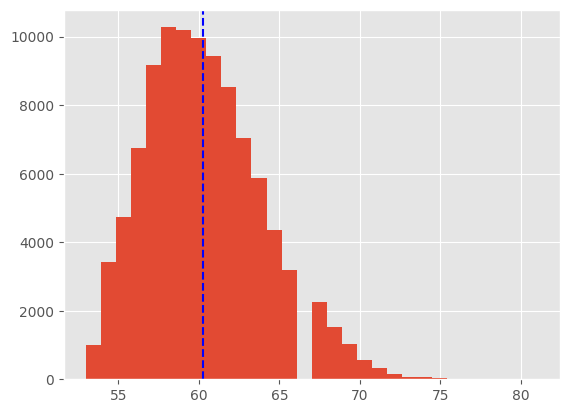

In [234]:
plt.hist(vtd_splits, bins=30)
plt.axvline(np.mean(vtd_splits), color='b', linestyle='--')

In [202]:
steps = [re.findall(r'\d+', i)[0] for i in os.listdir('./output/') if '.txt' in i]

In [227]:
init_vtd_split

65

In [226]:
min([vtd_splits[int(step)] for step in steps])

53

In [ ]:
min_splits_indx = [step for step in steps if vtd_splits[int(step)] == min([vtd_splits[int(step)] for step in steps])]

In [215]:
# of paritions with min VTD splits, partition with the highest avg reock socre
[idx for idx in min_splits_indx if reock_avg[int(idx)] == max([reock_avg[int(idx)] for idx in min_splits_indx])]

['69031']

In [223]:
[idx for idx in min_splits_indx if (reock_avg[int(idx)] - init_reock > .03) & (polsby_popper_avg[int(idx)] - init_polsby > .02)]

['89646']

In [235]:
low_splits_indx = [step for step in steps if vtd_splits[int(step)] < 58]

In [236]:
[idx for idx in low_splits_indx if (reock_avg[int(idx)] - init_reock > .03) & (polsby_popper_avg[int(idx)] - init_polsby > .03)]

['73051', '87376', '75083', '8216']

selected from a plan that minimizes VTD splits while also increase compactness (as measured by Reock and Polsby Popper)

In [242]:
# print(reock_avg[73051], polsby_popper_avg[73051])
# print(reock_avg[87376], polsby_popper_avg[87376])
###  best compactness score
print(reock_avg[75083], polsby_popper_avg[75083])
# print(reock_avg[8216], polsby_popper_avg[8216])

0.4709592822171976 0.30544710261224783
0.47246458706648337 0.30757457107419095
0.4994634681295536 0.3040839485584882
0.4849299150838385 0.30581055980715577


- 75083
- 89646
- 69031

### Population deviation based on student population?

how does it compare also to the current plan?

In [247]:
def calc_pop_dev(p):
    return abs((min(p.values()) / ideal_population) - (max(p.values()) / ideal_population))

calc_pop_dev(initial_partition['students'])

0.06837388765653078

my new proposed plan decreases the deviation in student population by nearly 2 percentage points

In [254]:
print(round(calc_pop_dev(initial_partition['students']) - calc_pop_dev(student_pop[75083]), 3))
print(calc_pop_dev(student_pop[75083]))

0.019
0.04933454153760766


### CVAP breakdown?

In [268]:
for i,t in zip(initial_partition['cvap_coalition'].values(), initial_partition['cvap'].values()):
    print(i/t)

0.25461720599842147
0.19064417177914111
0.22553936411809236
0.28511135057471265
0.2003479269353436


In [272]:
# cvap_coalition[75083]

for i,t in zip(cvap_coalition[75083].values(), cvap_pop[75083].values()):
    print(i/t)

0.2628876063777756
0.19929758607043926
0.2115207596531176
0.31636770210490495
0.1708748136392055


relatively similar composition of CVAP population by district

In [284]:
# of plans that greatly minimized VTD splits, the plan with the highest CVAP coalition score
l = []
high_cvap_idx = []
for idx in low_splits_indx:
  out = max([i/t for i,t in zip(cvap_coalition[int(idx)].values(), cvap_pop[int(idx)].values())])
  if out > .34:
    high_cvap_idx.append(idx)
  l.append(max([i/t for i,t in zip(cvap_coalition[int(idx)].values(), cvap_pop[int(idx)].values())]))
max(l)

0.34328576299254787

In [291]:
# compacktness scores of plans that greatly minimized VTD splits and had highest prop poc cvap district
print([reock_avg[int(i)] for i in high_cvap_idx])
print([polsby_popper_avg[int(i)] for i in high_cvap_idx])

[0.4126867073727221, 0.43790446194364757, 0.44867150481024876, 0.44434618775710194]
[0.28128344940647587, 0.2641819219385205, 0.22386021599442923, 0.2153311233441096]


In [292]:
# plan with the best balance between compactness scores
high_cvap_idx[0]

'67421'

what about in relation to economics? custom dataset using latest ACS data?

- using the above selected plans, looking at them in relation to poverty data

******************************

In [3]:
import json
import pandas as pd

In [1]:
with open('./output/MS_output.jsonl', 'r') as json_file:
    json_list = list(json_file)

In [4]:
d = pd.json_normalize(json.loads(json_list[75083]))

  # pops = dict(d[[i for i in d.columns if "population" in i]].loc[0]).values()
  # dev = abs((min(pops) / ideal_population) - (max(pops) / ideal_population))

In [53]:
student_pop = d[[i for i in d.columns if 'students' in i]]
ideal_student_pop = student_pop.sum(axis=1) / 5

In [54]:
student_pop.sum(axis=1)

0    19518.266728
dtype: float64

In [55]:
ideal_student_pop

0    3903.653346
dtype: float64

In [52]:
student_pop

,students.1,students.2,students.4,students.0,students.3
0,3250.630964,3963.489911,4583.473021,4237.976374,3482.696458


In [21]:
student_pop.min()[0] / ideal_student_pop

0    0.832715
dtype: float64

In [48]:
max(sorted(student_pop.values.tolist()[0]))

4583.4730205583455

In [50]:
# ideal_student_pop

abs((min(sorted(student_pop.values.tolist()[0])) / ideal_student_pop) - (max(sorted(student_pop.values.tolist()[0])) / ideal_student_pop)) * 100

0    34.143453
dtype: float64

In [ ]:
for idx, i in enumerate(json_list):
  d = pd.json_normalize(json.loads(json_list[idx]))
  pops = dict(d[[i for i in d.columns if "population" in i]].loc[0]).values()
  dev = abs((min(pops) / ideal_population) - (max(pops) / ideal_population))